In [1]:
%load_ext autoreload
%autoreload 2
from boxes import *
from learner import *
import math
import matplotlib.pyplot as plt
import os
import wandb
import pickle

import numpy as np

import matplotlib.patches as patches
import matplotlib.colors as mcolors


%matplotlib inline

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed) # cpu
    torch.cuda.manual_seed_all(seed)  # gpu
    
set_seed(10086)

torch.set_printoptions(precision=16)

split_num = 3

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
use_cuda

False

In [4]:
PATH = 'data/ontologies/anatomy/debug/'

# aligment training split
ats = ""

# Transitive closure
Transitive_Closure = False

if Transitive_Closure:
    tc = "tc_"
else:
    tc = ""

# Data in unary.tsv are probabilites separated by newlines. The probability on line n is P(n), where n is the id assigned to the nth element.
#unary_prob = [1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
unary_prob = [1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3]
unary_prob = torch.tensor(unary_prob).float().to(device)
num_boxes = unary_prob.shape[0]

# We're going to use random negative sampling during training, so no need to include negatives in our training data itself
train = Probs.load_from_julia(PATH, f'tr_pos.tsv', f'tr_neg.tsv', ratio_neg = 0).to(device)

# The dev set will have a fixed set of negatives, however.
dev = Probs.load_from_julia(PATH, f'dev_align_pos.tsv', f'dev_align_neg.tsv', ratio_neg = 0).to(device)

# This set is used just for evaluation purposes after training
tr_align = Probs.load_from_julia(PATH, f'tr_align_pos.tsv', f'tr_align_neg.tsv', ratio_neg = 0).to(device)


In [5]:
mouse_eval = Probs.load_from_julia(PATH, 'human_dev_pos.tsv', 'human_dev_neg.tsv', ratio_neg = 0).to(device)
human_eval = Probs.load_from_julia(PATH, 'mouse_dev_pos.tsv', 'mouse_dev_neg.tsv', ratio_neg = 0).to(device)


In [6]:
import torch
from torch import Tensor # for type annotations
import torch.nn.functional as F
from typing import *

'''
def _intersection(self: TBoxTensor,
                  other: TBoxTensor,
                  gumbel_beta: float = 1.0,
                  bayesian :bool = False) -> Tuple[Tensor, Tensor]:
    t1 = self
    t2 = other
    # broadcast if necessary

    if len(t1.data.shape) > len(t2.data.shape):
        t2 = self._broadcast_other(t1, t2)
    elif len(t1.data.shape) < len(t2.data.shape):
        t1 = self._broadcast_other(t2, t1)

    if bayesian:
        try:
            z = gumbel_beta * torch.logsumexp(torch.stack((t1.z / gumbel_beta, t2.z / gumbel_beta)), 0)
            z = torch.max(z, torch.max(t1.z, t2.z))
            Z = - gumbel_beta * torch.logsumexp(torch.stack((-t1.Z / gumbel_beta, -t2.Z / gumbel_beta)), 0)
            Z = torch.min(Z, torch.min(t1.Z, t2.Z))
        except:
            breakpoint()
    else:
        z = torch.max(t1.z, t2.z)
        Z = torch.min(t1.Z, t2.Z)

    return z, Z


def gumbel_intersection(self: TBoxTensor, other: TBoxTensor, gumbel_beta: float=1.) -> TBoxTensor:
    z, Z = self._intersection(other, gumbel_beta=gumbel_beta, bayesian=True)
    return BoxTensor.from_zZ(z, Z)
'''

def gumbel_intersection(A: Tensor, B: Tensor, gumbel_beta: float=1.)-> Tensor:
    Az = A[...,0,:]
    AZ = A[...,1,:]
    Bz = B[...,0,:]
    BZ = B[...,1,:]
    
    gumbel_beta = 0.001
    z = gumbel_beta * torch.logsumexp(torch.stack((Az / gumbel_beta, Bz / gumbel_beta)), 0)
    z = torch.max(z, torch.max(Az, Bz))
    Z = - gumbel_beta * torch.logsumexp(torch.stack((-AZ / gumbel_beta, -BZ / gumbel_beta)), 0)
    Z = torch.min(Z, torch.min(AZ, BZ))
    return torch.stack((z, Z), dim=-2)


def log_soft_volume_adjusted(
                     boxes: Tensor,
                     temp: float = 1.,
                     gumbel_beta: float = 1.,
                     scale: Union[float, Tensor] = 1.) -> Tensor:
    
    euler_gamma = 0.57721566490153286060
    gumbel_beta = 0.001
    
    z = boxes[:,:,0]
    Z = boxes[:,:,1]
    eps = torch.finfo(z.dtype).tiny  # type: ignore
    

    
    if isinstance(scale, float):
        s = torch.tensor(scale)
    else:
        s = scale

    return (torch.sum(
        torch.log(F.softplus(Z - z - 2*euler_gamma*gumbel_beta, beta=temp).clamp_min(eps)),
        dim=-1) + torch.log(s)
    )




def intersection(A: Tensor, B: Tensor) -> Tensor:
    """
    :param A: Tensor(..., zZ, dim)
    :param B: Tensor(..., zZ, dim)
    :return: Tensor(..., zZ, dim), box embeddings for A intersect B
    """
    z = torch.max(A[...,0,:], B[...,0,:])
    Z = torch.min(A[...,1,:], B[...,1,:])
    
#     z = gumbel_beta * torch.logsumexp(torch.stack((t1.z / gumbel_beta, t2.z / gumbel_beta)), 0)
#     z = torch.max(z, torch.max(t1.z, t2.z))
#     Z = - gumbel_beta * torch.logsumexp(torch.stack((-t1.Z / gumbel_beta, -t2.Z / gumbel_beta)), 0)
#     Z = torch.min(Z, torch.min(t1.Z, t2.Z))
    return torch.stack((z, Z), dim=-2)

def neg_edge_adjustment(A: Tensor) -> Tensor:
    """
    :param A: Tensor(..., zZ, dim)
    
    Replace "negative" edges with their mean.
    
    (TODO: optimize this)
    """
    center_of_meet = torch.mean(A, dim=-2)
    neg_edges_mask = ((A[...,1,:] - A[...,0,:]) >= 0)
    neg_edges_mask_stack = torch.stack((neg_edges_mask, neg_edges_mask), dim=-2)
    center_of_meet_stack = torch.stack((center_of_meet, center_of_meet), dim=-2)
    return torch.where(neg_edges_mask_stack, A, center_of_meet_stack)

def join(A: Tensor, B: Tensor) -> Tensor:
    """
    :param A: Tensor(model, pair, zZ, dim)
    :param B: Tensor(model, pair, zZ, dim)
    :return: Tensor(model, pair, zZ, dim), box embeddings for the smallest box which contains A and B
    """
    z = torch.min(A[:,:,0], B[:,:,0])
    Z = torch.max(A[:,:,1], B[:,:,1])
    return torch.stack((z, Z), dim=2)


def clamp_volume(boxes: Tensor) -> Tensor:
    """
    :param boxes: Tensor(... zZ, dim)
    :return: Tensor(...) of volumes
    """
    return torch.prod((boxes[...,1,:] - boxes[...,0,:]).clamp_min(0), dim=-1)


def soft_volume(boxes: Tensor) -> Tensor:
    """
    :param sidelengths: Tensor(model, box, dim)
    :return: Tensor(model, box) of volumes
    """
#     print("you are in soft_volume now!!!")
#     print("Z:",boxes[:,0,1])
#     print("z:",boxes[:,0,0])
#     print("boxes[:,0,1] - boxes[:,0,0]:", boxes[:,0,1] - boxes[:,0,0])
#     print("after softplus:", F.softplus(boxes[:,0,1] - boxes[:,0,0]))
    return torch.prod(F.softplus(boxes[:,:,1] - boxes[:,:,0]), dim=-1)


def log_clamp_volume(boxes: Tensor, eps:float = torch.finfo(torch.float32).tiny) -> Tensor:
    """
    :param boxes: Tensor(model, box, zZ, dim)
    :return: Tensor(model, box) of volumes
    """
    return torch.sum(torch.log((boxes[:,:,1] - boxes[:,:,0]).clamp_min(0) + eps), dim=-1)


def log_soft_volume(boxes: Tensor, eps:float = torch.finfo(torch.float32).tiny) -> Tensor:
    """
    :param sidelengths: Tensor(model, box, dim)
    :return: Tensor(model, box) of volumes
    """
    return torch.sum(torch.log(F.softplus(boxes[:,:,1] - boxes[:,:,0]) + eps), dim=-1)


def smallest_containing_box(boxes: Tensor) -> Tensor:
    """
    Returns the smallest box which contains all boxes in `boxes`.
    
    :param boxes: Box embedding of shape (model, box, zZ, dim)
    :return: Tensor of shape (model, 1, zZ, dim)
    """
    z = boxes[:,:,0]
    Z = boxes[:,:,1]
    min_z, _ = torch.min(z, dim=1, keepdim=True)
    max_Z, _ = torch.max(Z, dim=1, keepdim=True)
    return torch.stack((min_z, max_Z), dim=2)

def smallest_containing_box_outside_unit_cube(boxes: Tensor) -> Tensor:
    """
    Returns the smallest box which contains all boxes in `boxes` and the unit cube.

    :param boxes: Box embedding of shape (model, box, zZ, dim)
    :return: Tensor of shape (model, 1, zZ, dim)
    """
    z = boxes[:,:,0]
    Z = boxes[:,:,1]
    min_z, _ = torch.min(z, dim=1, keepdim=True)
    max_Z, _ = torch.max(Z, dim=1, keepdim=True)
    min_z = min_z.clamp_max(0)
    max_Z = max_Z.clamp_min(1)
    return torch.stack((min_z, max_Z), dim=2)


def detect_small_boxes(boxes: Tensor, vol_func: Callable = clamp_volume, min_vol: float = 1e-20) -> Tensor:
    """
    Returns the indices of boxes with volume smaller than eps.

    :param boxes: box parametrization as Tensor(model, box, z/Z, dim)
    :param vol_func: function taking in side lengths and returning volumes
    :param min_vol: minimum volume of boxes
    :return: masked tensor which selects boxes whose side lengths are less than min_vol
    """
    return vol_func(boxes) < min_vol


def replace_Z_by_cube(boxes: Tensor, indices: Tensor, cube_vol: float = 1e-20) -> Tensor:
    """
    Returns a new Z parameter for boxes for which those boxes[indices] are now replaced by cubes of size cube_vol

    :param boxes: box parametrization as Tensor(model, box, z/Z, dim)
    :param indices: box indices to replace by a cube
    :param cube_vol: volume of cube
    :return: tensor representing the Z parameter
    """
    return boxes[:, :, 0][indices] + cube_vol ** (1 / boxes.shape[-1])



def replace_Z_by_cube_(boxes: Tensor, indices: Tensor, cube_vol: float = 1e-20) -> Tensor:
    """
    Replaces the boxes indexed by `indices` by a cube of volume `min_vol` with the same z coordinate

    :param boxes: box parametrization as Tensor(model, box, z/Z, dim)
    :param indices: box indices to replace by a cube
    :param cube_vol: volume of cube
    :return: tensor representing the box parametrization with those boxes
    """
    boxes[:, :, 1][indices] = replace_Z_by_cube(boxes, indices, cube_vol)


def disjoint_boxes_mask(A: Tensor, B: Tensor) -> Tensor:
    """
    Returns a mask for when A and B are disjoint.
    Note: This is symmetric with respect to the arguments.
    """
    return ((B[:,:,1] <= A[:,:,0]) | (B[:,:,0] >= A[:,:,1])).any(dim=-1)


def overlapping_boxes_mask(A: Tensor, B: Tensor) -> Tensor:
    return disjoint_boxes_mask(A, B) ^ 1


def containing_boxes_mask(A: Tensor, B: Tensor) -> Tensor:
    """
    Returns a mask for when B contains A.
    Note: This is *not* symmetric with respect to it's arguments!
    """
    return ((B[:,:,1] >= A[:,:,1]) & (B[:,:,0] <= A[:,:,0])).all(dim=-1)


def needing_pull_mask(A: Tensor, B: Tensor, target_prob_B_given_A: Tensor) -> Tensor:
    return (target_prob_B_given_A != 0) & disjoint_boxes_mask(A, B)


def needing_push_mask(A: Tensor, B: Tensor, target_prob_B_given_A: Tensor) -> Tensor:
    return (target_prob_B_given_A != 1) & containing_boxes_mask(A, B)


In [7]:
import torch
from torch import Tensor
import scipy.stats as spstats # For Spearman r
from sklearn.metrics import roc_curve, precision_recall_curve  # for roc_curve


def metric_hard_accuracy(model, data_in, data_out):
    hard_pred = model(data_in, is_align=torch.tensor(0))["P(A|B)"] > 0.5
#     print("data_in:", data_in)
#     print("hard_pred:", hard_pred)
    return (data_out == hard_pred.float()).float().mean()


def metric_hard_f1(model, data_in, data_out):
    hard_pred = model(data_in, is_align=torch.tensor(0))["P(A|B)"] > 0.5
    true_pos = data_out[hard_pred==1].sum()
    total_pred_pos = (hard_pred==1).sum().float()
    total_actual_pos = data_out.sum().float()
    precision = true_pos / total_pred_pos
    recall = true_pos / total_actual_pos
    return 2 * (precision*recall) / (precision + recall)

def metric_hard_accuracy_align(model, data_in, data_out, threshold:float):
    A_given_B = data_in[::2]
    B_given_A = data_in[1::2,:]
    data_out = data_out[::2]

    align_probs = torch.stack((model(A_given_B, is_align=torch.tensor(1))["P(A|B)"], model(B_given_A, is_align=torch.tensor(1))["P(A|B)"]), dim=1)
    p = torch.min(align_probs, dim=1).values
    hard_pred = p > threshold

    return (data_out == hard_pred).float().mean()

def metric_hard_f1_align(model, data_in, data_out, threshold:float):
    A_given_B = data_in[::2]
    B_given_A = data_in[1::2,:]
    data_out = data_out[::2]

    align_probs = torch.stack((model(A_given_B, is_align=torch.tensor(1))["P(A|B)"], model(B_given_A, is_align=torch.tensor(1))["P(A|B)"]), dim=1)
    p = torch.min(align_probs, dim=1).values
    hard_pred = p > threshold

    true_pos = data_out[hard_pred==1].sum()
    total_pred_pos = (hard_pred==1).sum().float()
    total_actual_pos = data_out.sum().float()

    precision = true_pos / total_pred_pos
    recall = true_pos / total_actual_pos

    return 2 * (precision*recall) / (precision + recall)

def metric_hard_accuracy_align_mean(model, data_in, data_out, threshold):
    A_given_B = data_in[::2]
    B_given_A = data_in[1::2,:]
    data_out = data_out[::2]

    align_probs = torch.stack((model(A_given_B, is_align=torch.tensor(1))["P(A|B)"], model(B_given_A, is_align=torch.tensor(1))["P(A|B)"]), dim=1)
    p = torch.mean(align_probs, dim=1)
    hard_pred = p > threshold

    return (data_out == hard_pred).float().mean()

def metric_hard_f1_align_mean(model, data_in, data_out, threshold):
    A_given_B = data_in[::2]
    B_given_A = data_in[1::2,:]
    data_out = data_out[::2]

    align_probs = torch.stack((model(A_given_B, is_align=torch.tensor(1))["P(A|B)"], model(B_given_A, is_align=torch.tensor(1))["P(A|B)"]), dim=1)
    p = torch.mean(align_probs, dim=1)
    hard_pred = p > threshold

    true_pos = data_out[hard_pred==1].sum()
    total_pred_pos = (hard_pred==1).sum().float()
    total_actual_pos = data_out.sum().float()

    precision = true_pos / total_pred_pos
    recall = true_pos / total_actual_pos

    return 2 * (precision*recall) / (precision + recall)


In [8]:
import torch
from torch.utils.data import Dataset
from typing import *
from dataclasses import dataclass, field
import wandb

try:
    from IPython import get_ipython
    if 'IPKernelApp' not in get_ipython().config:  # pragma: no cover
        raise ImportError("console")
except:
    pass
else:
    import ipywidgets as widgets
    from IPython.core.display import HTML, display

if TYPE_CHECKING:
    from learner import Learner, Recorder


class Callback:
    def learner_post_init(self, learner: Learner):
        pass

    def train_begin(self, learner: Learner):
        pass

    def epoch_begin(self, learner: Learner):
        pass

    def batch_begin(self, learner: Learner):
        pass

    def backward_end(self, learner: Learner):
        pass

    def batch_end(self, learner: Learner):
        pass

    def epoch_end(self, learner: Learner):
        pass

    def train_end(self, learner: Learner):
        pass

    def eval_align(self, learner: Learner, threshold:float):
        pass

    def metric_plots(self, l: Learner):
        pass

    def eval_end(self, l: Learner):
        pass

    def bias_metric(self, l: Learner):
        pass

class CallbackCollection:

    def __init__(self, *callbacks: Callback):
        self._callbacks = callbacks

    def __call__(self, action: str, *args, **kwargs):
        for c in self._callbacks:
            getattr(c, action)(*args, **kwargs)

    def __getattr__(self, action: str):
        return lambda *args, **kwargs: self.__call__(action, *args, **kwargs)


@dataclass
class GradientClipping(Callback):
    min: float = None
    max: float = None

    def backward_end(self, learner: Learner):
        for param in learner.model.parameters():
            if param.grad is not None:
                param.grad = param.grad.clamp(self.min, self.max)


@dataclass
class LossCallback(Callback):
    recorder: Recorder
    ds: Dataset
    weighted: bool = True

    @torch.no_grad()
    def train_begin(self, learner: Learner):
        self.epoch_end(learner)

    @torch.no_grad()
    def epoch_end(self, l: Learner):
        data_in, data_out = self.ds[:]
        if l.categories:
            split_in, split_out = l.split_data(data_in, data_out, split=2737)
            
            model_pred = []
            count = 0
            for item in split_in:
                if len(item)>0:
                    if count<2:
                        model_pred.append(l.model(item, is_align=torch.tensor(0)))
                    else:
                        model_pred.append(l.model(item, is_align=torch.tensor(1)))
                else:
                    model_pred.append({'P(A|B)':l.TensorNaN(device=data_in.device)})
                count+=1

            #model_pred = [l.model(item) if len(item)>0 else {'P(A|B)':l.TensorNaN(device=data_in.device)} for item in split_in]
            l.loss_fn(model_pred, split_out, l, self.recorder, weighted=self.weighted, categories=True)  
        else:
            output = l.model(data_in, is_align=torch.tensor(0))
            l.loss_fn(output, data_out, l, self.recorder, weighted=self.weighted) # this logs the data to the recorder


@dataclass
class MetricCallback(Callback):
    recorder: Recorder
    ds: Dataset
    data_categories: str
    metric: Callable
    use_wandb: bool = False
    name: Union[str, None] = None

    def __post_init__(self):
        if self.name is None:
            self.name = self.metric.__name__
        self.name = self.recorder.get_unique_name(self.name)

    @torch.no_grad()
    def train_begin(self, learner: Learner):
        self.epoch_end(learner)

    @torch.no_grad()
    def epoch_end(self, l: Learner):
        data_in, data_out = self.ds[:]
        metric_val = self.metric(l.model, data_in, data_out)
        self.recorder.update_({self.name: metric_val}, l.progress.current_epoch_iter)
        
        print("evaluation_" + self.data_categories + "_" + self.name, str(metric_val))
        
        if self.use_wandb:
            metric_name = "evaluation_" + self.data_categories + "_" + self.name
            wandb.log({metric_name: metric_val})

@dataclass
class EvalAlignment(Callback):
    recorder: Recorder
    ds: Dataset
    data_categories: str
    metric: callable
    use_wandb: bool = False
    name: Union[str, None] = None
        

    def __post_init__(self):
        if self.name is None:
            self.name = self.metric.__name__
        self.name = self.recorder.get_unique_name(self.name)

    @torch.no_grad()
    def eval_align(self, l: Learner, threshold: float):
        data_in, data_out = self.ds[:]
        metric_val = self.metric(l.model, data_in, data_out, threshold)
        self.recorder.update_({self.name: metric_val}, threshold)
        
        print("align_evaluation_" + self.data_categories + "_" + str(threshold) + "_" + self.name, str(metric_val))
        
        if self.use_wandb:
            metric_name = "align_evaluation_" + self.data_categories + "_" + str(threshold) + "_" + self.name
            wandb.log({metric_name: metric_val})


In [9]:
import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Module, Parameter
import torch.nn.functional as F


################################################
# Box Parametrization Layers
################################################
default_init_min_vol = torch.finfo(torch.float32).tiny

def initialize_boxes_in_unit_cube(shape_prefix: Tuple[int], dims:int, init_min_vol: float = default_init_min_vol,
    method = "gibbs", gibbs_iter: int = 2000, **kwargs):
    """
    Creates the Parameters used for the representation of boxes.
    Initializes boxes with a uniformly random distribution of coordinates, ensuring that each box
    contains a cube of volume larger than init_min_vol.

    :param shape_prefix: Tuple which prefixes the parameters, eg. (num_boxes, num_models) will lead to
        a Tensor of shape (num_boxes, num_models, 2, dims)
    :param dims: Dimension of boxes
    :param init_min_vol: Minimum volume for boxes which are created
    :param kwargs: Unused for now, but include this for future possible parameters.
    """
    if method == "gibbs":
        sides = torch.ones(*shape_prefix, dims)
        log_min_vol = torch.log(torch.tensor(init_min_vol))
        for i in range(gibbs_iter):
            idx = torch.randint(0, dims, shape_prefix)[...,None]
            sides.scatter_(-1, idx, 1)
            complement = torch.log(sides).sum(dim=-1)
            min = torch.exp(log_min_vol - complement)[..., None]
            new_lengths = min + torch.rand(idx.shape) * (1 - min)
            sides.scatter_(-1, idx, new_lengths)

        z = torch.rand(*shape_prefix, dims) * (1-sides)
        Z = z + sides

    else:
        rand_param = lambda min, max: min + torch.rand(*shape_prefix, dims) * (max - min)
        if init_min_vol == 0:
            per_dim_min = 0
        elif init_min_vol > 0:
            per_dim_min = torch.tensor(init_min_vol).pow(1/dims)
        else:
            raise ValueError(f"init_min_vol={init_min_vol} is an invalid option.")

        z = rand_param(0, 1-per_dim_min)
        Z = rand_param(z+per_dim_min, 1)

    return torch.stack((z,Z), dim=-2)


class BoxParam(Module):
    """
    An example class for creating a box parametrization.
    Don't inherit from this, it is just an example which contains the methods for a class to be used as a BoxParam
    layer. Refer to the docstring of the functions when implementing your own BoxParam.

    Note: to avoid naming conflicts with min/max functions, we refer to the min coordinate for a box as `z`, and the
    max coordinate as `Z`.
    """

    def __init__(self, num_models:int, num_boxes:int, dim:int, **kwargs):
        """
        Creates the Parameters used for the representation of boxes.

        :param num_models: Number of models
        :param num_boxes: Number of boxes
        :param dim: Dimension
        :param kwargs: Unused for now, but include this for future possible parameters.
        """
        # Remember to call:
        super().__init__()
        raise NotImplemented


    def forward(self, box_indices = slice(None, None, None), **kwargs) -> Tensor:
        """
        Returns a Tensor representing the boxes specified by `box_indices` in the form they should be used for training.

        :param box_indices: Slice, List, or Tensor of the box indices
        :param kwargs: Unused for now, but include this for future possible parameters.
        :return: Tensor of shape (model, id, zZ, dim).
        """
        raise NotImplemented


class Boxes(Module):
    """
    Parametrize boxes using the min coordinate and max coordinate,
    initialized to be in the unit hypercube.

    self.boxes[model, box, min/max, dim] \in [0,1]

    In this parametrization, the min and max coordinates are explicitly stored
    in separate dimensions (as shown above), which means that care must be
    taken to preserve max > min while training. (See MinBoxSize Callback.)
    """

    def __init__(self, num_models: int, num_boxes: int, dims: int,
                 init_min_vol: float = default_init_min_vol, method = "gibbs", gibbs_iter: int = 2000, **kwargs):
        super().__init__()
        self.boxes = Parameter(initialize_boxes_in_unit_cube((num_models, num_boxes), dims, init_min_vol, method, gibbs_iter, **kwargs))

    def forward(self, box_indices = slice(None, None, None), **kwargs) -> Tensor:
        """
        Returns a Tensor representing the box embeddings specified by box_indices.

        :param box_indices: Slice, List, or Tensor of the box indices
        :param kwargs: Unused for now, but include this for future possible parameters.
        :return: NamedTensor of shape (model, id, zZ, dim).
        """
        return self.boxes[:, box_indices]



class MinMaxSigmoidBoxes(Module):
    """
    Parametrize boxes using sigmoid to make them always valid and contained within the unit cube.

    self.boxes[model, box, 2, dim] in Reals


    In this parametrization, we first convert to the unit cube:

    unit_cube_boxes = torch.sigmoid(self.boxes)  # shape: (model, box, 2, dim)

    We now select the z/Z coordinates by taking the min/max over axis 2, i.e.

    z, _ = torch.min(unit_cube_boxes, dim=2)
    Z, _ = torch.max(unit_cube_boxes, dim=2)
    """

    def __init__(self, num_models: int, num_boxes: int, dim: int, init_min_vol: float = default_init_min_vol,  **kwargs):
        super().__init__()
        unit_boxes = Boxes(num_models, num_boxes, dim, init_min_vol, **kwargs)
        self._from_UnitBoxes(unit_boxes)
        del unit_boxes


    def _from_UnitBoxes(self, unit_boxes:Boxes):
        boxes = unit_boxes().detach().clone()
        self.boxes = Parameter(torch.log(boxes / (1-boxes)))


    def forward(self, box_indices = slice(None, None, None), **kwargs) -> Tensor:
        """
        Returns a Tensor representing the box embeddings specified by box_indices.

        :param box_indices: A NamedTensor of the box indices
        :param kwargs: Unused for now, but include this for future possible parameters.
        :return: Tensor of shape (model, id, zZ, dim).
        """
        unit_cube_boxes = torch.sigmoid(self.boxes)
        z, _ = torch.min(unit_cube_boxes, dim=2)
        Z, _ = torch.max(unit_cube_boxes, dim=2)
        return torch.stack((z,Z), dim=2)
    
class AlignmentBoxes(Module):
    """
    Parametrize boxes using sigmoid to make them always valid and contained within the unit cube.

    self.boxes[model, box, 2, dim] in Reals


    In this parametrization, we first convert to the unit cube:

    unit_cube_boxes = torch.sigmoid(self.boxes)  # shape: (model, box, 2, dim)

    We now select the z/Z coordinates by taking the min/max over axis 2, i.e.

    z, _ = torch.min(unit_cube_boxes, dim=2)
    Z, _ = torch.max(unit_cube_boxes, dim=2)
    """

    def __init__(self, num_models: int, num_boxes: int, dim: int, init_min_vol: float = default_init_min_vol,  **kwargs):
        super().__init__()
        unit_boxes = Boxes(num_models, num_boxes, dim, init_min_vol, **kwargs)
        self._from_UnitBoxes(unit_boxes)
        self.fc1 = nn.Linear(dim, 64)
        self.fc2 = nn.Linear(64, dim)
        #self.fc = nn.Linear(dim, dim)
        del unit_boxes


    def _from_UnitBoxes(self, unit_boxes:Boxes):
        boxes = unit_boxes().detach().clone()
        self.boxes = Parameter(torch.log(boxes / (1-boxes)))


    def forward(self, box_indices = slice(None, None, None), is_align=torch.tensor(0), **kwargs) -> Tensor:
        """
        Returns a Tensor representing the box embeddings specified by box_indices.

        :param box_indices: A NamedTensor of the box indices
        :param kwargs: Unused for now, but include this for future possible parameters.
        :return: Tensor of shape (model, id, zZ, dim).
        """
        unit_cube_boxes = torch.sigmoid(self.boxes)
        z, _ = torch.min(unit_cube_boxes, dim=2)
        Z, _ = torch.max(unit_cube_boxes, dim=2)

#         if is_align.tolist() == 1:
# #             print("z before1:", z[0])
# #             print("w:", self.fc.weight)
# #             z = torch.nn.functional.relu(self.fc1(z))
# #             z = self.fc2(z)
# #             Z = torch.nn.functional.relu(self.fc1(Z))
# #             Z = self.fc2(Z)
#             z = self.fc1(z)
#             Z = self.fc1(Z)
#         else:
#             z = self.fc2(z)
#             Z = self.fc2(Z)

        if is_align.tolist() == 1:
            #print("before z", z)
            #print("before Z", Z)
            z = torch.nn.functional.relu(self.fc1(z))
            z = self.fc2(z)
            Z = torch.nn.functional.relu(self.fc1(Z))
            Z = self.fc2(Z)
            #print("after z", z)
            #print("after Z", Z)
            
#         if is_align.tolist() == 1:    
#             z = self.fc(z)
#             Z = self.fc(Z)

        #print("z Z", torch.stack((z,Z), dim=2))
        return torch.stack((z,Z), dim=2)


###############################################
# Downstream Model
###############################################

class WeightedSum(Module):
    def __init__(self, num_models: int) -> None:
        super().__init__()
        self.weights = Parameter(torch.rand(num_models))

    def forward(self, box_vols: Tensor) -> Tensor:
        return (F.softmax(self.weights, dim=0).unsqueeze(0) @ box_vols).squeeze()


class LogWeightedSum(Module):
    def __init__(self, num_models: int) -> None:
        super().__init__()
        self.weights = Parameter(torch.rand(num_models))

    def forward(self, log_box_vols: Tensor) -> Tensor:
        return (torch.logsumexp(self.weights + log_box_vols, 0) - torch.logsumexp(self.weights, 0))


class BoxModel(Module):
    def __init__(self, BoxParamType: type, vol_func: Callable, intersection_func: Callable,
                 num_models:int, num_boxes:int, dims:int,
                 init_min_vol: float = default_init_min_vol, universe_box: Optional[Callable] = None, **kwargs):
        super().__init__()
        self.box_embedding = BoxParamType(num_models, num_boxes, dims, init_min_vol, **kwargs)
        self.vol_func = vol_func
        self.intersection_func = intersection_func

        if universe_box is None:
            z = torch.zeros(dims)
            Z = torch.ones(dims)
            self.universe_box = lambda _: torch.stack((z,Z))[None, None]
            self.universe_vol = lambda _: self.vol_func(self.universe_box(None)).squeeze()
            self.clamp = True
        else:
            self.universe_box = universe_box
            self.universe_vol = lambda b: self.vol_func(self.universe_box(b))
            self.clamp = False

        self.weights = WeightedSum(num_models)

    def forward(self, box_indices: Tensor, is_align: Tensor = torch.tensor(0)) -> Dict:
        #print("is_align in BoxModel:", is_align)
        # Unary
        box_embeddings_orig = self.box_embedding(is_align = is_align)
        #print("box_embeddings_orig", box_embeddings_orig)
#         if self.clamp:
#             box_embeddings = box_embeddings_orig.clamp(0,1)
#         else:
#             box_embeddings = box_embeddings_orig
        box_embeddings = box_embeddings_orig
        universe_vol = self.universe_vol(box_embeddings)

        unary_probs = self.weights(self.vol_func(box_embeddings) / universe_vol)
        #print("unary_probs:", unary_probs)

        
        #print("after clamp box_embeddings", box_embeddings)
        # Conditional
        A = box_embeddings[:, box_indices[:,0]]
        B = box_embeddings[:, box_indices[:,1]]
        #print("------------------------------------")
        #print("A", A)
        #print("B", B)
        #print("A shape", A.shape) #1 4 2 2
        #print("A", A[0, 0])
        #print("B", B[0, 0])
        #print("intersection_func(A, B)", self.intersection_func(A, B)[0, 0])
        
        #A_int_B_vol = self.weights(self.vol_func(intersection(A, B)) / universe_vol) + torch.finfo(torch.float32).tiny
        A_int_B_vol = self.weights(self.vol_func(self.intersection_func(A, B)) / universe_vol) + torch.finfo(torch.float32).tiny
        
        #print("box_indices", box_indices)
        #print("A_int_B_vol:", A_int_B_vol)
        
        B_vol = unary_probs[box_indices[:,1]] + torch.finfo(torch.float32).tiny
        #print("B_vol:", B_vol)
        #P_A_given_B = torch.exp(torch.log(A_int_B_vol) - torch.log(B_vol))
        P_A_given_B = torch.exp(A_int_B_vol - B_vol)
        #print("P_A_given_B:", P_A_given_B)
        #print("------------------------------------")
        
        # symmetric same
        # print("you are in right place!")
#         A = box_embeddings[:, box_indices[:,0]]
#         B = box_embeddings[:, box_indices[:,1]]
#         A_int_B_vol = self.weights(self.vol_func(intersection(A, B)) / universe_vol) + torch.finfo(torch.float32).tiny
#         A_join_B_vol = self.weights(self.vol_func(join(A, B)) / universe_vol) + torch.finfo(torch.float32).tiny
#         P_A_given_B = torch.exp(torch.log(A_int_B_vol) - torch.log(A_join_B_vol))
#         try:
#             print("box_embeddings_orig:", box_embeddings_orig)
#             print("box_indices:", box_indices[0])
#             print("A:", A[0][0])
#             print("B:", B[0][0])
#             print("intersection(A, B):", intersection(A, B)[0][0])
#             print("self.vol_func(intersection(A, B)):", self.vol_func(intersection(A, B))[0][0])
#             print("universe_vol:", universe_vol)
#             print("self.weights(self.vol_func(intersection(A, B)) / universe_vol):", self.weights(self.vol_func(intersection(A, B)) / universe_vol)[0])
#             print("A_int_B_vol:", A_int_B_vol[0])
#             print("unary_probs:", unary_probs)
#             print("B_vol:", B_vol[0])
#             print("P_A_given_B:", P_A_given_B[0])
#         except:
#             pass
        

        return {
            "unary_probs": unary_probs,
            "box_embeddings_orig": box_embeddings_orig,
            "A": A,
            "B": B,
            "P(A|B)": P_A_given_B,
        }


In [10]:
def get_boxes(idx, color, beo, dim=0):
    node = beo[idx,:,dim:dim+2].cpu().detach()
    
    width  = abs(node[1,0] - node[0,0])
    height = abs(node[1,1] - node[0,1])
    
    node_min = torch.min(node, dim=0).values
    
    rect = patches.Rectangle(node_min, width, height, linewidth=2, edgecolor=color, fill=True, facecolor=color, alpha=0.5)
    
    return rect, node_min[0].item(), node_min[1].item(), idx.item(), width, height

def draw(beo, box_idx):
    fig,ax = plt.subplots(1, figsize=(14,14), facecolor="white")

    #box_idx = torch.tensor(np.arange(2, 7))

    # colors = list(mcolors.CSS4_COLORS)
    colors = ['xkcd:orange red', 'xkcd:sunflower', 'xkcd:magenta', 'xkcd:baby purple',
              'xkcd:chartreuse',  'xkcd:greenish', 'xkcd:mint', 'xkcd:sky blue',
               'xkcd:slate blue', 'xkcd:deep red', 'xkcd:greyish brown', 'xkcd:canary yellow' ]

    rectangles = []
    labels = []

    # rect1 = patches.Rectangle(one_node_min, width, height,linewidth=2,edgecolor='r', fill=True, facecolor='r', alpha=0.3)
    # rect2 = patches.Rectangle((0.5,0.1),.1,.3,linewidth=2,edgecolor='b', fill=True, facecolor='b', alpha=0.3)
    left = 100
    right = -100
    top = -100
    bottom = 100
    # 0, 4
    for i, bidx in enumerate(box_idx):
        rect, xmin, ymin, name, w, h = get_boxes(bidx, colors[i], beo, dim=0)
        print(bidx, xmin, ymin, xmin + w, ymin + h)
        if xmin < left:
            left = xmin
        if ymin < bottom:
            bottom = ymin
        if xmin + w > right:
            right = xmin+w
        if ymin + h > top:
            top = ymin+h

        ax.text(xmin, ymin, bidx.item(), fontsize=14)
        ax.add_patch(rect)

        if bidx.item() < split_num:
            labels.append(str(name) + " (mouse)")
        else:
            labels.append(str(name) + " (human)")

    # ax.add_patch(rect2)

    # ax.set_xlim([-.1, 1.5])
    # ax.set_ylim([-.1, 1.5])

    ax.set_xlim([left-0.01, right+0.01])
    ax.set_ylim([bottom-0.01, top+0.01])

    # ax.legend(labels, fontsize=18, loc=10, )
    plt.show()



In [11]:
dims = 2
#lr = 0.07342406890949607
lr = 0.2
rns_ratio = 5
#box_type = MinMaxSigmoidBoxes, AlignmentBoxes
use_unary = False
unary_weight = 1e-2

In [12]:
box_model = BoxModel(
    BoxParamType=AlignmentBoxes,
    vol_func=soft_volume,
    intersection_func = intersection,
    #vol_func=log_soft_volume_adjusted,
    #intersection_func = gumbel_intersection,
    
    
    num_models=1,
    num_boxes=num_boxes,
    dims=dims,
    method="tree").to(device)


#### IF YOU ARE LOADING FROM JULIA WITH ratio_neg=0, train_dl WILL ONLY CONTAIN POSITIVE EXAMPLES
#### THIS MEANS YOUR MODEL SHOULD USE NEGATIVE SAMPLING DURING TRAINING
train_dl = TensorDataLoader(train, batch_size=2**2, shuffle=True)

mouse_dl = TensorDataLoader(mouse_eval, batch_size=2**2)
human_dl = TensorDataLoader(human_eval, batch_size=2**2)

eval_dl = [mouse_dl, human_dl]

opt = torch.optim.Adam(box_model.parameters(), lr=lr)

In [13]:
import torch.nn.functional as F
def kl_div_sym(p: Tensor, q: Tensor, eps: float = torch.finfo(torch.float32).tiny) -> Tensor:
    #print("p", p)
    #print("q", q)
    #print("kl_div_term(p, q, eps)", kl_div_term(p, q, eps))
    #print("kl_div_term(1-p, 1-q, eps)", kl_div_term(1-p, 1-q, eps))
    return kl_div_term(p, q, eps) + kl_div_term(1-p, 1-q, eps)

def kl_div_term(p: Tensor, q: Tensor, eps: float = torch.finfo(torch.float32).tiny) -> Tensor:
    return F.kl_div(torch.log(p.clamp_min(eps)), q.clamp_min(eps), reduction="none")

In [14]:
def mean_cond_kl_loss(model_out: ModelOutput, target: Tensor, eps: float = torch.finfo(torch.float32).tiny) -> Tensor:
    return kl_div_sym(model_out["P(A|B)"], target, eps).mean()

def human_cond_kl_loss(model_out: ModelOutput, target: Tensor, eps: float = torch.finfo(torch.float32).tiny) -> Tensor:
    return kl_div_sym(model_out["P(A|B)"], target, eps).mean()

def mouse_cond_kl_loss(model_out: ModelOutput, target: Tensor, eps: float = torch.finfo(torch.float32).tiny) -> Tensor:
    return kl_div_sym(model_out["P(A|B)"], target, eps).mean()

def align_cond_kl_loss(model_out: ModelOutput, target: Tensor, eps: float = torch.finfo(torch.float32).tiny) -> Tensor:
    #print("ModelOutput", ModelOutput)
    #print("target", target)
    #print("align_cond_kl_loss", kl_div_sym(model_out["P(A|B)"], target, eps).mean())
    return kl_div_sym(model_out["P(A|B)"], target, eps).mean()

# See boxes/loss_functions.py file for more options. Note that you may have to changed them to fit your use case.
# Also note that "kl_div_sym" is just binary cross-entropy.

In [15]:
global my_batch_in
global my_batch_out
my_batch_in = None
my_batch_out = None

@dataclass
class Learner:
    train_dl: DataLoader
    model: Module
    loss_fn: Callable
    opt: optim.Optimizer
    callbacks: CallbackCollection = field(default_factory=CallbackCollection)
    recorder: Recorder = field(default_factory=Recorder)
    categories: bool = False
    use_wandb: bool = False
    reraise_keyboard_interrupt: bool = False
    reraise_stop_training_exceptions: bool = False

    def __post_init__(self):
        self.progress = Progress(0,0,len(self.train_dl))
        self.callbacks.learner_post_init(self)

    #the split parameter will be used to find human/mouse/align data, so you need change it when using diff dataset(index)
    def split_data(self, batch_in, batch_out, split):
        category = torch.zeros(size=(batch_in.shape[0],), dtype=int)

        batch_class = batch_in > split

        for i, (a,b) in enumerate(batch_class):
            if not a and not b:
                category[i] = 0
            elif a and b:
                category[i] = 1
            else:
                category[i] = 2

        self.mouse_in = batch_in[category == 0]
        self.human_in = batch_in[category == 1]
        self.align_in = batch_in[category == 2]

        self.mouse_out = batch_out[category == 0]
        self.human_out = batch_out[category == 1]
        self.align_out = batch_out[category == 2]

        # INPUT TO THE MODEL:
        data_in = (self.mouse_in, self.human_in, self.align_in)
        # TARGET/LABEL:
        data_out = (self.mouse_out, self.human_out, self.align_out)

        return data_in, data_out

    def TensorNaN(self, size:Union[None,List[int], Tuple[int]]=None, device=None, requires_grad:bool=True):
        if size is None:    
            return torch.tensor(float('nan'), device=device, requires_grad=requires_grad)
        else:
            return float('nan') * torch.zeros(size=size, device=device, requires_grad=requires_grad)


    def train(self, epochs, progress_bar = True):
        global my_batch_in
        global my_batch_out
        try:
            self.callbacks.train_begin(self)
            for epoch in trange(epochs, desc="Overall Training:", disable=not progress_bar):
                self.callbacks.epoch_begin(self)
                for iteration, batch in enumerate(tqdm(self.train_dl, desc="Current Batch:", leave=False, disable=not progress_bar)):
                    # draw the boxes at every beginning of epoch
                    print("tree data:")
                    beo = box_model(torch.tensor([[1, 1]]), torch.tensor(0))['box_embeddings_orig'].squeeze(0)
#                     box_idx = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
                    box_idx = torch.tensor([1, 2, 3, 4, 5, 6])
                    draw(beo, box_idx)
                    
                    print("alignment data:")
                    beo = box_model(torch.tensor([[1, 1]]), torch.tensor(1))['box_embeddings_orig'].squeeze(0)
##                     box_idx = torch.tensor([2, 11, 4, 13, 6, 15, 9, 17])
                    box_idx = torch.tensor([1, 2, 3, 4, 5, 6])
                    draw(beo, box_idx)

                    print("batch", batch)
                    if len(batch) == 2: # KLUDGE
                        self.batch_in, self.batch_out = batch
                    else:
                        self.batch_in = batch[0]
                        self.batch_out = None
                    self.progress.increment()
                    self.callbacks.batch_begin(self)
                    self.opt.zero_grad()
                    
                    if self.categories:
                        self.data_in, self.data_out = self.split_data(self.batch_in, self.batch_out, split=split_num)
                        #9 is max mouse index  
                        self.model_pred = []
                        count = 0
                        for item in self.data_in:
                            if len(item)>0:
                                if count<2:
                                    self.model_pred.append(self.model(item, is_align=torch.tensor(0)))
                                else:
                                    self.model_pred.append(self.model(item, is_align=torch.tensor(1)))
                            else:
                                self.model_pred.append({'P(A|B)':self.TensorNaN(device=self.batch_in.device)})
                            count+=1
                        #self.model_pred = [self.model(item, is_align=is_align) if len(item)>0 else {'P(A|B)':self.TensorNaN(device=self.batch_in.device)} for item in self.data_in]
                        #print("self.model_pred:", self.model_pred)
                        #print("self.data_in:", self.data_in)
                        #print("self.data_out:", self.data_out)
                        self.loss = self.loss_fn(self.model_pred, self.data_out, self, self.recorder, categories=True, use_wandb=self.use_wandb)   
                        #print("previous loss:", self.loss)
                    else:
                        self.model_out = self.model(self.batch_in, is_align=False)
                        if self.batch_out is None:
                            self.loss = self.loss_fn(self.model_out, self, self.recorder, categories=True, use_wandb=self.use_wandb)
                        else:
                            self.loss = self.loss_fn(self.model_out, self.batch_out, self, self.recorder, categories=True, use_wandb=self.use_wandb)
                    
                    # Log metrics inside your training loop
                    if self.use_wandb:
                        metrics = {'epoch': epoch, 'loss': self.loss}
                        wandb.log(metrics)

                    # print(self.recorder.dataframe)
                    #print("loss:", self.loss)
                    self.loss.backward()
                    self.callbacks.backward_end(self)
                    self.opt.step()
                    self.callbacks.batch_end(self)
                # print(self.recorder.dataframe)
                
                # run evaluating at the end of every epoch
                #self.evaluation(np.arange(0.1, 1, 0.1))
                self.evaluation([0.8])
                
                
                self.callbacks.epoch_end(self)
        except StopTrainingException as e:
            print(e)
            if self.reraise_stop_training_exceptions:
                raise e
        except KeyboardInterrupt:
            print(f"Stopped training at {self.progress.partial_epoch_progress()} epochs due to keyboard interrupt.")
            if self.reraise_keyboard_interrupt:
                raise KeyboardInterrupt
        finally:
            self.callbacks.train_end(self)


    def evaluation(self, trials, progress_bar=True):
        with torch.no_grad():
            # self.callbacks.eval_begin(self)
            for t in trials:
                self.callbacks.eval_align(self, t)
            self.callbacks.metric_plots(self)
            self.callbacks.bias_metric(self)
            self.callbacks.eval_end(self)

In [16]:
import torch
from torch import Tensor
from torch.nn import Module
from typing import *
#from .learner import Learner, Recorder
from collections import OrderedDict
#import wandb

FuncInput = Union[OrderedDict, dict, Collection[Union[Callable, Tuple[float, Callable]]]]

def func_list_to_dict(*func_list: FuncInput) -> Dict[str, Callable]:
    """

    :param func_list: List of functions or tuples (weight, function)
    :type func_list: Union[Collection[Union[Callable, Tuple[float, Callable]]], Dict[str, Callable]]

    :return: Ordered Dictionary of {name: function}
    :rtype: OrderedDict[str, Callable]
    """
    if type(func_list) == OrderedDict or type(func_list) == dict:
        return func_list
    func_dict = OrderedDict()
    for f in func_list:
        if type(f) is tuple:
            func_dict[f"{f[0]}*{f[1].__name__}"] = lambda *args, weight=f[0], func=f[1], **kwargs: weight * func(*args, **kwargs)
        else:
            func_dict[f.__name__] = f
    return func_dict

def unweighted_func_dict(*func_list: FuncInput) -> Dict[str, Callable]:
    if type(func_list) == OrderedDict or type(func_list) == dict:
        return func_list
    func_dict = OrderedDict()
    for f in func_list:
        if type(f) is tuple:
            f = f[1]
        func_dict[f.__name__] = f
    return func_dict

def isnan(x):
    return (x != x)

class LossPieces(Module):

    def __init__(self, *loss_funcs: FuncInput):
        """

        :param functions: List of functions or tuples (weight, function)
        :type functions: Collection[Union[Callable, Tuple[float, Callable]]]
        """
        super().__init__()
        self.unweighted_funcs = unweighted_func_dict(*loss_funcs)
        self.loss_funcs = func_list_to_dict(*loss_funcs)

    def forward(self, model_out, true_out: Tensor,
                learner: Optional[Learner] = None,
                recorder: Optional[Recorder] = None,
                weighted: bool = True,
                categories: bool = False,
                use_wandb: bool = False,
                **kwargs) -> Tensor:
        """
        Weighted sum of all loss functions. Tracks values in Recorder.
        """
        if weighted:
            loss_funcs = self.loss_funcs
        else:
            loss_funcs = self.unweighted_funcs
        
        grad_status = torch.is_grad_enabled()
        if learner is None:
            torch.set_grad_enabled(False)
        
        # change the loss function for margin loss
        try:
            if categories:
                loss_pieces = {}
                for k,l in loss_funcs.items():
                    if 'mouse' in k:
                        loss_pieces['mouse_cond_kl_loss'] = l(model_out[0], true_out[0])
                    elif 'human' in k:
                        loss_pieces['human_cond_kl_loss'] = l(model_out[1], true_out[1])
                    else:
                        loss_pieces['align_cond_kl_loss'] = 1000 * l(model_out[2], true_out[2])
#                     if 'mouse' in k:
#                         loss_pieces[k] = l(model_out[0], true_out[0])
#                     elif 'human' in k:
#                         loss_pieces[k] = l(model_out[1], true_out[1])
#                     else:
#                         loss_pieces[k] = l(model_out[2], true_out[2])
                if use_wandb:
                    # Log metrics inside your training loop
                    metrics = {'mouse_loss': torch.sum(loss_pieces['mouse_cond_kl_loss']), 
                               'human_loss': torch.sum(loss_pieces['human_cond_kl_loss']), 
                               'alignmnt_loss': torch.sum(loss_pieces['align_cond_kl_loss'])}
                    wandb.log(metrics)
                
                loss = 0
                for key,val in loss_pieces.items():
                    if not isnan(val):
                        loss += val
                        #print("key", key)
                        #print("val", val)
                        

            else:
                loss_pieces = {k: l(model_out, true_out) for k, l in loss_funcs.items()}
                loss = sum(loss_pieces.values())
          

            loss_pieces['loss'] = loss
            if learner is not None:
                if recorder is not None:
                    recorder.update_(loss_pieces, learner.progress.partial_epoch_progress())
                else:
                    self.recorder.update_(loss_pieces, learner.progress.partial_epoch_progress())
        finally:
            torch.set_grad_enabled(grad_status)
        return loss


In [17]:
# For this dataset we had unary probabilities as well as conditional probabilities. Our loss function will be a sum of these, which is provided by the following loss function wrapper:

# if use_unary:
#     loss_func = LossPieces(mean_cond_kl_loss, (unary_weight, mean_unary_kl_loss(unary_prob)))
# else:
#     loss_func = LossPieces(mean_cond_kl_loss)

loss_func = LossPieces((mouse_cond_kl_loss), (human_cond_kl_loss), (5e-2, align_cond_kl_loss))

metrics = [metric_hard_accuracy, metric_hard_f1]
align_metrics = [metric_hard_accuracy_align, metric_hard_f1_align, metric_hard_accuracy_align_mean, metric_hard_f1_align_mean]

rec_col = RecorderCollection()

# #threshold = np.arange(0.1, 1, 0.1)
# threshold = [0.5]

callbacks = CallbackCollection(
    LossCallback(rec_col.train, train),
    LossCallback(rec_col.dev, dev),
#     *(MetricCallback(rec_col.dev, dev, "dev", m) for m in metrics),
#     *(MetricCallback(rec_col.train, train, "train", m) for m in metrics),
    *(MetricCallback(rec_col.onto, human_eval, "human", m) for m in metrics),
    *(MetricCallback(rec_col.onto, mouse_eval, "mouse", m) for m in metrics),
    *(EvalAlignment(rec_col.train_align, tr_align, "train_align", m) for m in align_metrics),
    *(EvalAlignment(rec_col.dev_align, dev, "dev_align", m) for m in align_metrics),
    #JustGiveMeTheData(rec_col.probs, dev, get_probabilities),
    #BiasMetric(rec_col.bias, dev, pct_of_align_cond_on_human_as_min),
    #PlotMetrics(rec_col.dev_roc_plot, dev, roc_plot),
    #PlotMetrics(rec_col.dev_pr_plot, dev, pr_plot),
    #PlotMetrics(rec_col.tr_roc_plot, tr_align, roc_plot),
    #PlotMetrics(rec_col.tr_pr_plot, tr_align, pr_plot),
    #MetricCallback(rec_col.train, train, 'train', metric_pearson_r),
    #MetricCallback(rec_col.train, train, 'train', metric_spearman_r),
    #MetricCallback(rec_col.dev, dev, 'dev', metric_pearson_r),
    #MetricCallback(rec_col.dev, dev, 'dev', metric_spearman_r),
#     MetricCallback(rec_col.train, train, 'train', mean_reciprocal_rank),
#     MetricCallback(rec_col.dev, dev, 'dev', mean_reciprocal_rank),
#     PercentIncreaseEarlyStopping(rec_col.dev, "mean_cond_kl_loss", 0.25, 10),
#     PercentIncreaseEarlyStopping(rec_col.dev, "mean_cond_kl_loss", 0.5),
#     PercentIncreaseEarlyStopping(rec_col.dev, "mouse_cond_kl_loss", 0.25, 10),
#     PercentIncreaseEarlyStopping(rec_col.dev, "mouse_cond_kl_loss", 0.5),
#     GradientClipping(-1000,1000),
#     RandomNegativeSampling(num_boxes, rns_ratio),
    StopIfNaN(),
)

# l = Learner(train_dl, box_model, loss_func, opt, callbacks, recorder = rec_col.learn)
l = Learner(train_dl, box_model, loss_func, opt, callbacks, recorder = rec_col.learn, categories=True)

In [18]:
torch.log(torch.tensor(1+np.exp(0.8)))

tensor(1.1711006659477778, dtype=torch.float64)

evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -0.30328136682510376 -0.09724578261375427 tensor(-0.2753419876098633) tensor(-0.0798394680023193)
tensor(2) -0.3773524761199951 -0.10922780632972717 tensor(-0.3294852972030640) tensor(-0.0842306017875671)
tensor(3) -0.342227578163147 -0.10159160196781158 tensor(-0.3381157517433167) tensor(-0.0361851304769516)
tensor(4) -0.31722670793533325 -0.1162261962890625 tensor(-0.2923195362091064) tensor(-0.1129644811153412)
tensor(5) -0.2660994529724121 -0.10924753546714783 tensor(-0.2503808140754700) tensor(-0.1083493381738663)
tensor(6) -0.3716745972633362 -0.053328752517700195 tensor(-0.3381309509277344) tensor(-0.0355123132467270)


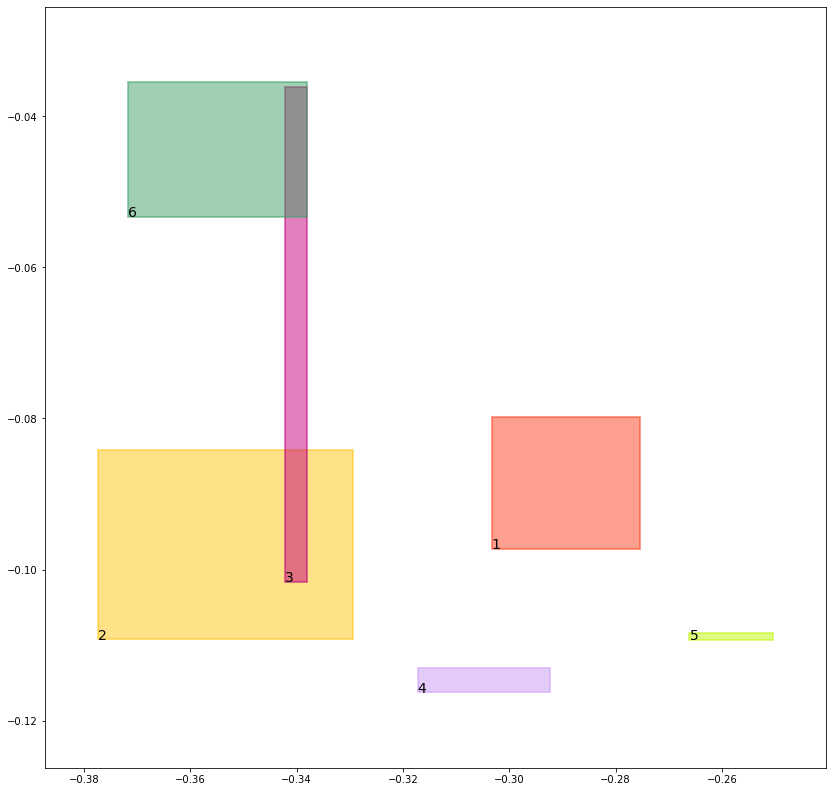

alignment data:
tensor(1) 0.22891832888126373 0.5432847738265991 tensor(0.6382021903991699) tensor(0.6613235473632812)
tensor(2) 0.6196406483650208 0.970485270023346 tensor(0.9933118820190430) tensor(0.9747607707977295)
tensor(3) 0.04273218289017677 0.8823361396789551 tensor(0.8873839974403381) tensor(0.9396696090698242)
tensor(4) 0.9791988730430603 0.8512340784072876 tensor(0.9978456497192383) tensor(0.9387893080711365)
tensor(5) 0.9082626700401306 0.5716201663017273 tensor(0.9102379083633423) tensor(0.6835398674011230)
tensor(6) 0.03248864784836769 0.8760227560997009 tensor(0.2207243591547012) tensor(0.9161222577095032)


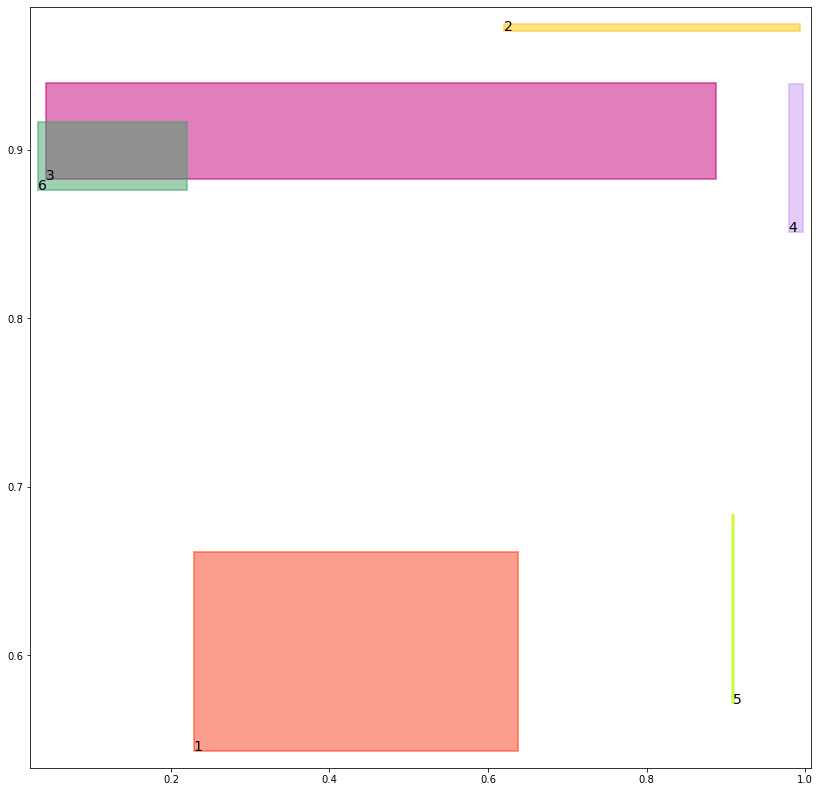

batch (tensor([[4, 6],
        [1, 3],
        [4, 5],
        [6, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -0.4674074649810791 0.9640604853630066 tensor(-0.0473454594612122) tensor(1.5742726325988770)
tensor(2) -0.46571820974349976 1.8370405435562134 tensor(0.0267863273620605) tensor(2.3613693714141846)
tensor(3) -0.31656426191329956 0.7979944348335266 tensor(0.7642739415168762) tensor(2.1405057907104492)
tensor(4) -0.6034637689590454 2.262589693069458 tensor(-0.5536280870437622) tensor(2.3357667922973633)
tensor(5) -1.0584604740142822 1.899202585220337 tensor(-0.7700994014739990) tensor(2.0740780830383301)
tensor(6) 0.5632307529449463 0.7796875238418579 tensor(0.7648743391036987) tensor(1.1850788593292236)


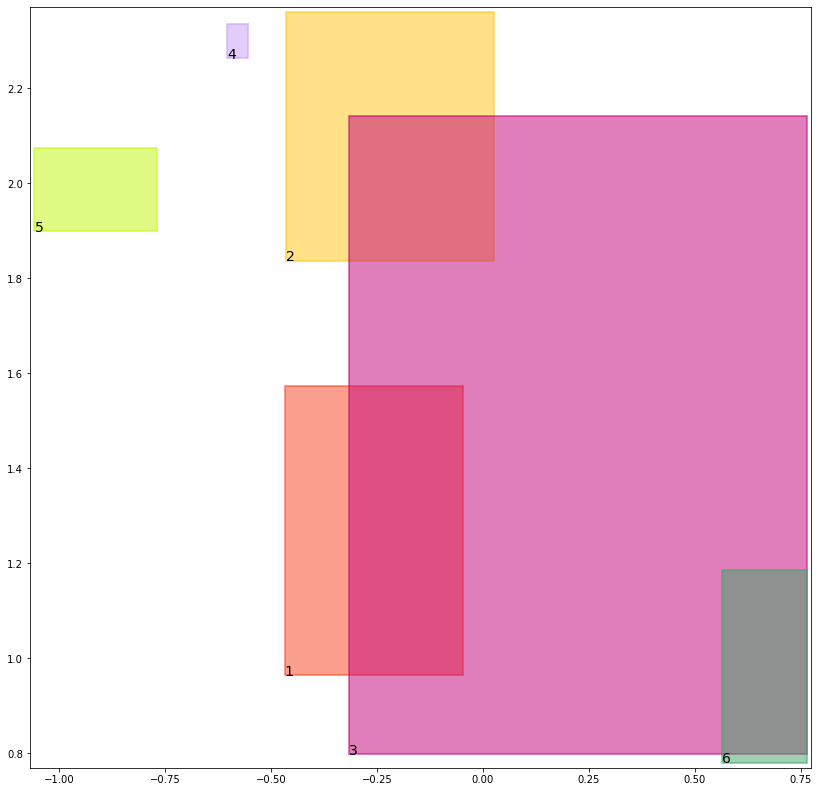

alignment data:
tensor(1) 0.26611390709877014 0.5923221707344055 tensor(0.6382021903991699) tensor(0.6613235473632812)
tensor(2) 0.6655269861221313 0.9693441390991211 tensor(0.9918431639671326) tensor(0.9757054448127747)
tensor(3) 0.035259321331977844 0.8599339723587036 tensor(0.8658059835433960) tensor(0.9500580430030823)
tensor(4) 0.9747100472450256 0.874825119972229 tensor(0.9973723888397217) tensor(0.9262368679046631)
tensor(5) 0.8925009965896606 0.5221084356307983 tensor(0.9236124753952026) tensor(0.7251368761062622)
tensor(6) 0.026757117360830307 0.8526193499565125 tensor(0.2570324242115021) tensor(0.9302664399147034)


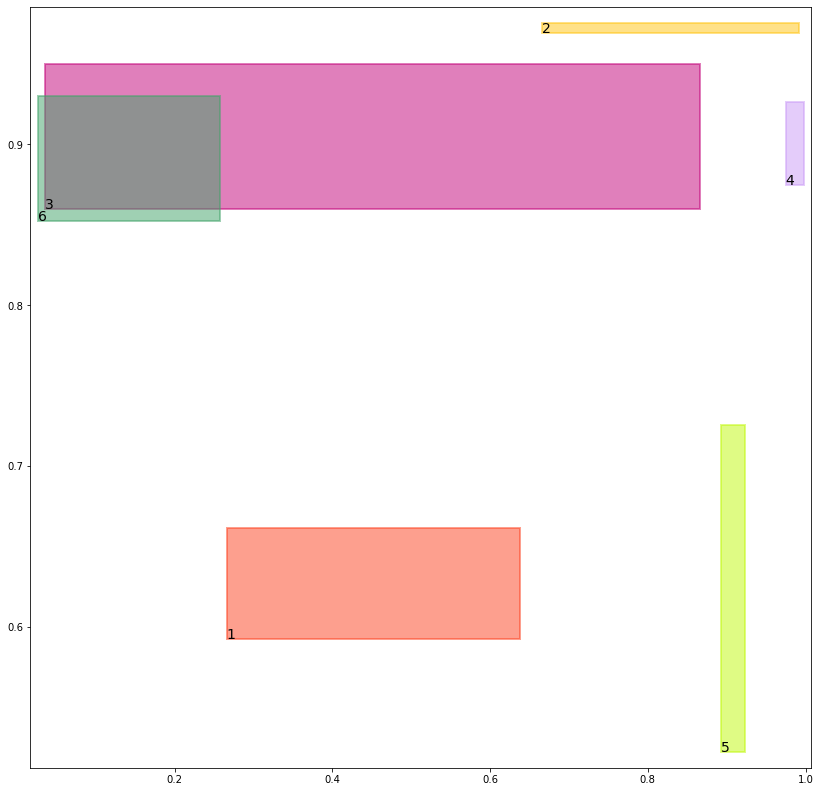

batch (tensor([[1, 2],
        [5, 3],
        [2, 6],
        [3, 5]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(0.5000000000000000)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(0.6666666865348816)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(0.5000000000000000)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(0.6666666865348816)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -2.362309217453003 0.9291005730628967 tensor(-1.0745537281036377) tensor(1.4438347816467285)
tensor(2) -3.0333492755889893 1.4424569606781006 tensor(-1.8762689828872681) tensor(1.8735926151275635)
tensor(3) -2.6936421394348145 0.5854851603507996 tensor(0.2439455986022949) tensor(1.7263607978820801)
tensor(4) -3.1701042652130127 1.8484721183776855 tensor(-3.1244208812713623) tensor(1.8831825256347656)
tensor(5) -3.376392364501953 1.725904107093811 tensor(-3.1511991024017334) tensor(1.7706058025360107)
tensor(6) -0.44439899921417236 0.5738073587417603 tensor(0.3391988873481750) tensor(0.9025326967239380)


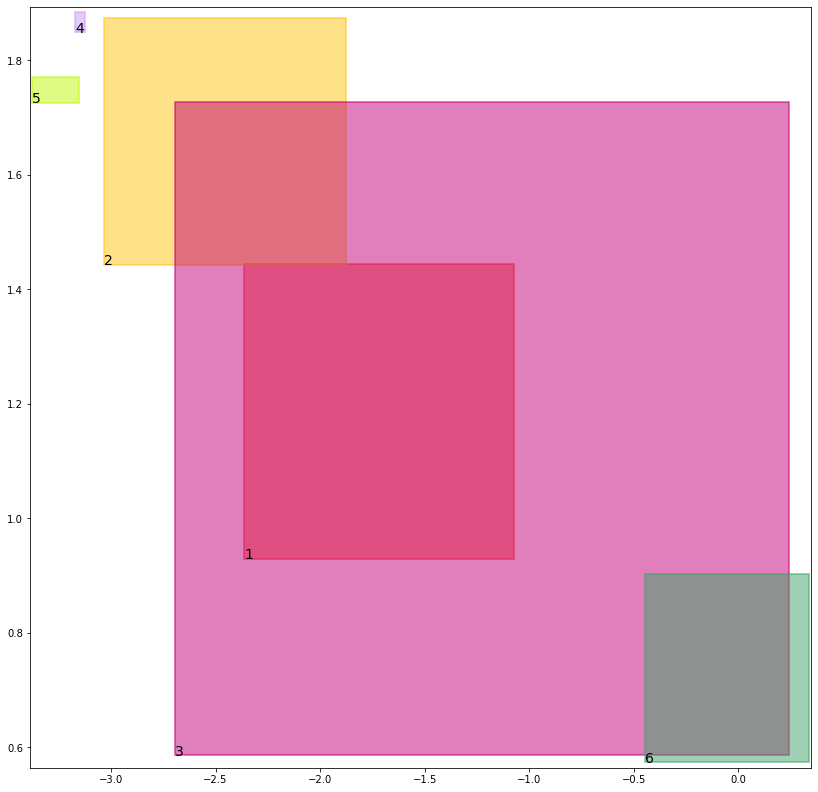

alignment data:
tensor(1) 0.2930911183357239 0.6242401599884033 tensor(0.6718128919601440) tensor(0.6938170194625854)
tensor(2) 0.6739976406097412 0.9641753435134888 tensor(0.9906908273696899) tensor(0.9784613251686096)
tensor(3) 0.04064038395881653 0.83488929271698 tensor(0.8821732997894287) tensor(0.9425063133239746)
tensor(4) 0.971187949180603 0.8887783885002136 tensor(0.9969992637634277) tensor(0.9165417551994324)
tensor(5) 0.87730473279953 0.5590502619743347 tensor(0.9124284386634827) tensor(0.7540326118469238)
tensor(6) 0.030894864350557327 0.8702507615089417 tensor(0.2772794961929321) tensor(0.9366557002067566)


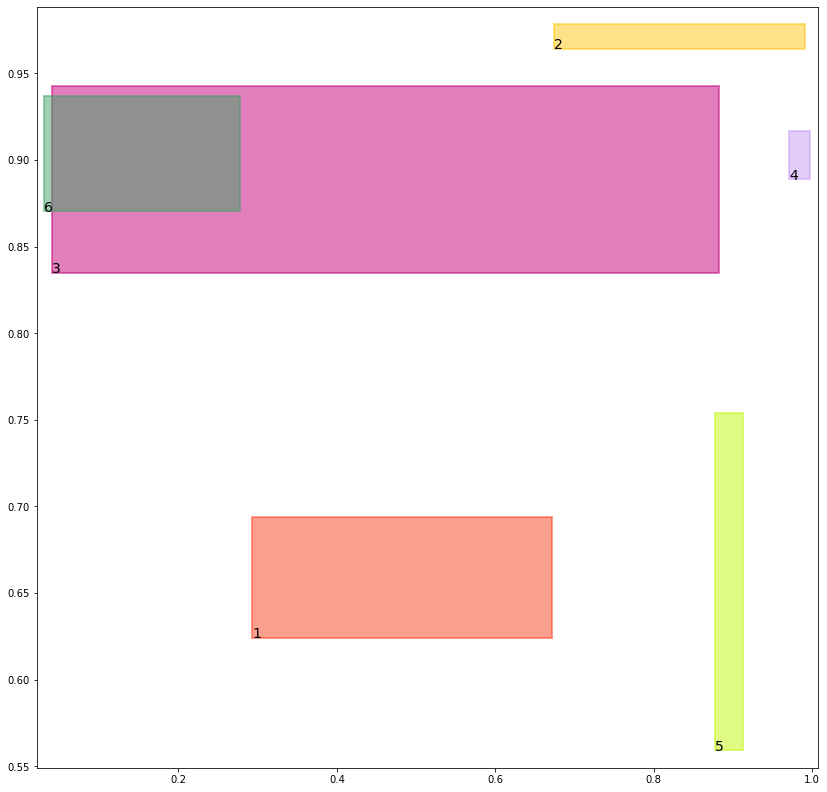

batch (tensor([[4, 6],
        [2, 6],
        [3, 5],
        [1, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -4.266879558563232 0.4261997640132904 tensor(-2.0597977638244629) tensor(0.5279094576835632)
tensor(2) -5.429859638214111 0.2839761972427368 tensor(-3.3288586139678955) tensor(0.3453324735164642)
tensor(3) -4.9413042068481445 0.3152061402797699 tensor(0.3142604827880859) tensor(0.4984706044197083)
tensor(4) -5.645598888397217 0.30573028326034546 tensor(-5.5007243156433105) tensor(0.3175472021102905)
tensor(5) -5.70284366607666 0.37672364711761475 tensor(-5.4082503318786621) tensor(0.4414465427398682)
tensor(6) -0.9264510273933411 0.41282975673675537 tensor(0.5730645060539246) tensor(0.4732319712638855)


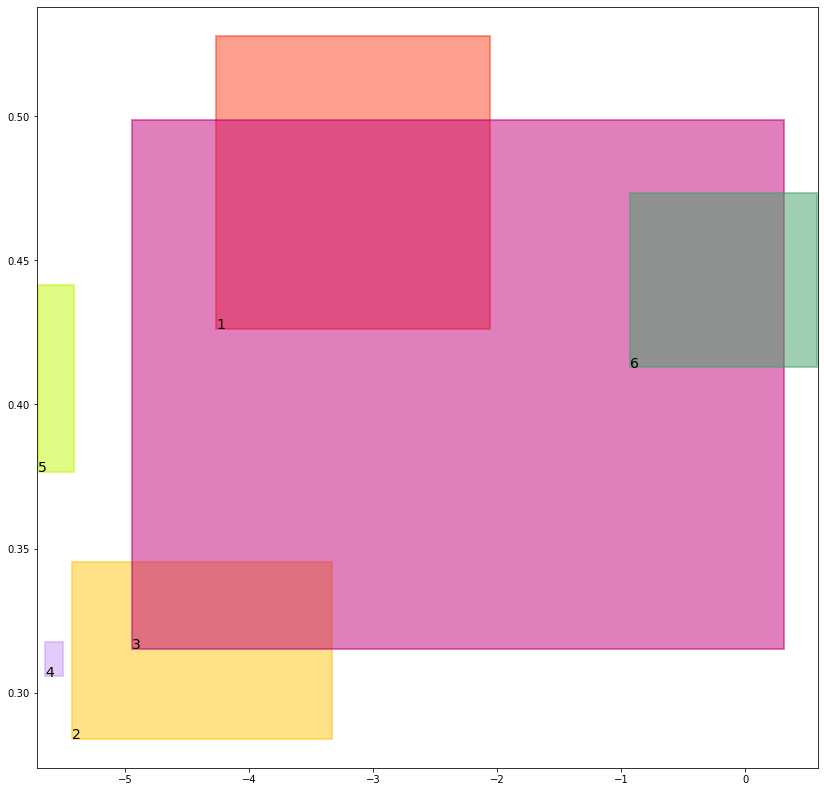

alignment data:
tensor(1) 0.32268646359443665 0.6082001328468323 tensor(0.7038660049438477) tensor(0.7176436185836792)
tensor(2) 0.6608676314353943 0.9581900238990784 tensor(0.9897159934043884) tensor(0.9803346395492554)
tensor(3) 0.045330341905355453 0.8160266876220703 tensor(0.8969805836677551) tensor(0.9359469413757324)
tensor(4) 0.9666289687156677 0.8986364603042603 tensor(0.9965797066688538) tensor(0.9177119135856628)
tensor(5) 0.8737863898277283 0.6005033850669861 tensor(0.8979952931404114) tensor(0.7670191526412964)
tensor(6) 0.03637032210826874 0.8882991671562195 tensor(0.2873951792716980) tensor(0.9390242695808411)


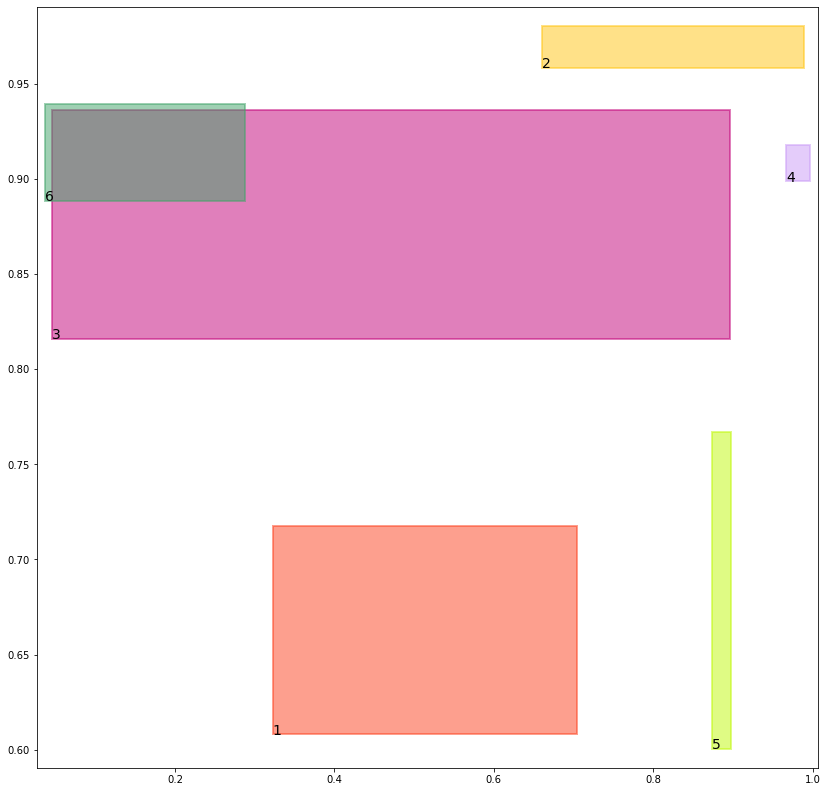

batch (tensor([[4, 5],
        [6, 2],
        [1, 3],
        [5, 3]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(0.5000000000000000)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(0.6666666865348816)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(0.5000000000000000)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(0.6666666865348816)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -7.2896599769592285 -0.0014396607875823975 tensor(-4.0422639846801758) tensor(0.5132802724838257)
tensor(2) -9.21703052520752 -0.35777682065963745 tensor(-6.2035088539123535) tensor(0.0800389349460602)
tensor(3) -8.523360252380371 -0.24367845058441162 tensor(-0.9190306663513184) tensor(0.8941937685012817)
tensor(4) -9.397172927856445 -0.36367809772491455 tensor(-9.2270879745483398) tensor(-0.3278012871742249)
tensor(5) -8.660503387451172 -0.21465343236923218 tensor(-8.6331777572631836) tensor(-0.1754063665866852)
tensor(6) -2.981609582901001 0.5466858148574829 tensor(-0.6473515033721924) tensor(0.9029772877693176)


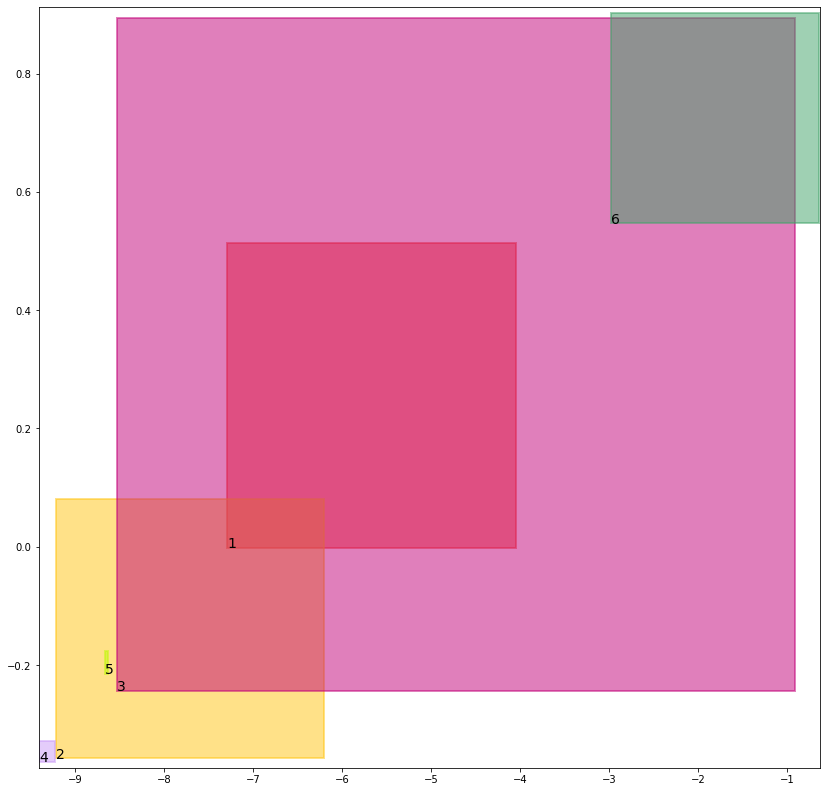

alignment data:
tensor(1) 0.3480825424194336 0.59502112865448 tensor(0.7287201285362244) tensor(0.7362993359565735)
tensor(2) 0.6575327515602112 0.9543271064758301 tensor(0.9882355928421021) tensor(0.9801796674728394)
tensor(3) 0.05208460986614227 0.8165562152862549 tensor(0.9022288322448730) tensor(0.9265879988670349)
tensor(4) 0.9701424241065979 0.888377845287323 tensor(0.9961532950401306) tensor(0.9260997772216797)
tensor(5) 0.8601094484329224 0.6355353593826294 tensor(0.8878917098045349) tensor(0.7893721461296082)
tensor(6) 0.041540469974279404 0.901409924030304 tensor(0.3071363568305969) tensor(0.9429731369018555)


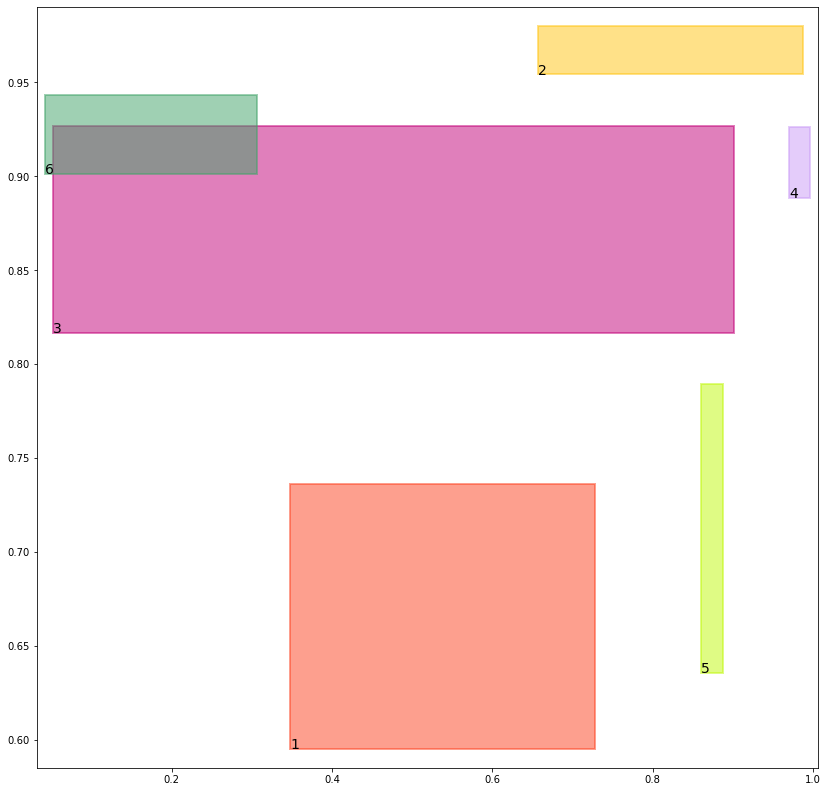

batch (tensor([[3, 5],
        [1, 2],
        [4, 6],
        [1, 3]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -10.897281646728516 -0.7641629576683044 tensor(-6.4449996948242188) tensor(0.2542077898979187)
tensor(2) -13.526410102844238 -1.3647234439849854 tensor(-9.5519971847534180) tensor(-0.4662725329399109)
tensor(3) -12.632418632507324 -1.159548044204712 tensor(-2.3355340957641602) tensor(1.1893408298492432)
tensor(4) -13.624068260192871 -1.3976855278015137 tensor(-13.3772096633911133) tensor(-1.3455748558044434)
tensor(5) -12.337431907653809 -1.0976810455322266 tensor(-12.0688333511352539) tensor(-1.0539236068725586)
tensor(6) -5.481343746185303 0.46562814712524414 tensor(-2.0692155361175537) tensor(1.2492892742156982)


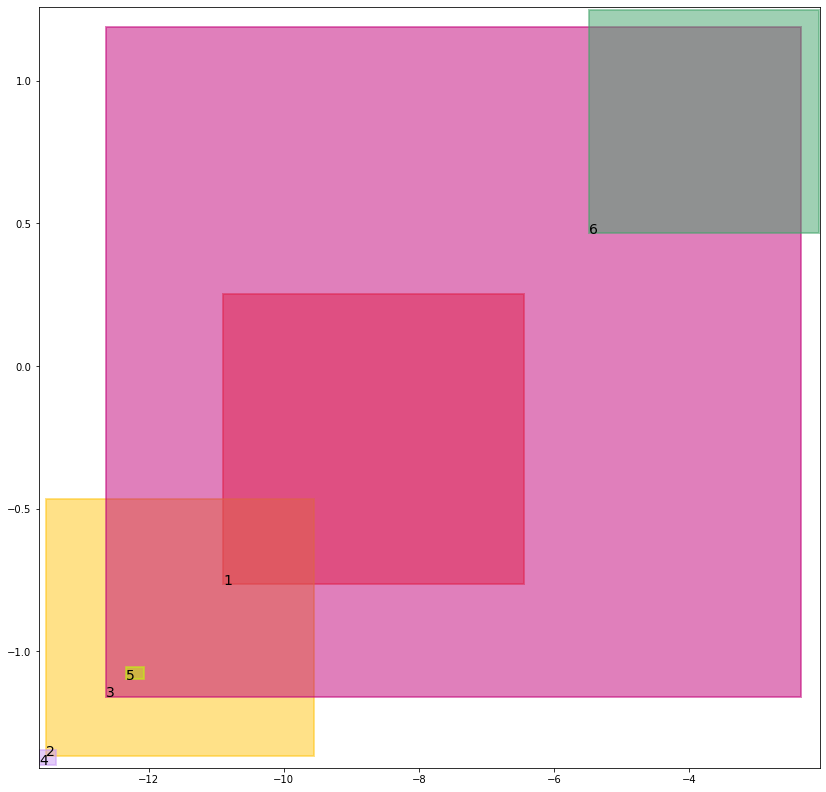

alignment data:
tensor(1) 0.3711193799972534 0.5834822058677673 tensor(0.7486759424209595) tensor(0.7514367103576660)
tensor(2) 0.6544523239135742 0.9508073329925537 tensor(0.9868321418762207) tensor(0.9800453782081604)
tensor(3) 0.05852474272251129 0.802449643611908 tensor(0.9064775109291077) tensor(0.9177119731903076)
tensor(4) 0.9728302359580994 0.8790098428726196 tensor(0.9957516193389893) tensor(0.9325690865516663)
tensor(5) 0.8509579300880432 0.6717683672904968 tensor(0.8761754631996155) tensor(0.8040128946304321)
tensor(6) 0.046200212091207504 0.9114552736282349 tensor(0.3252669274806976) tensor(0.9460974335670471)


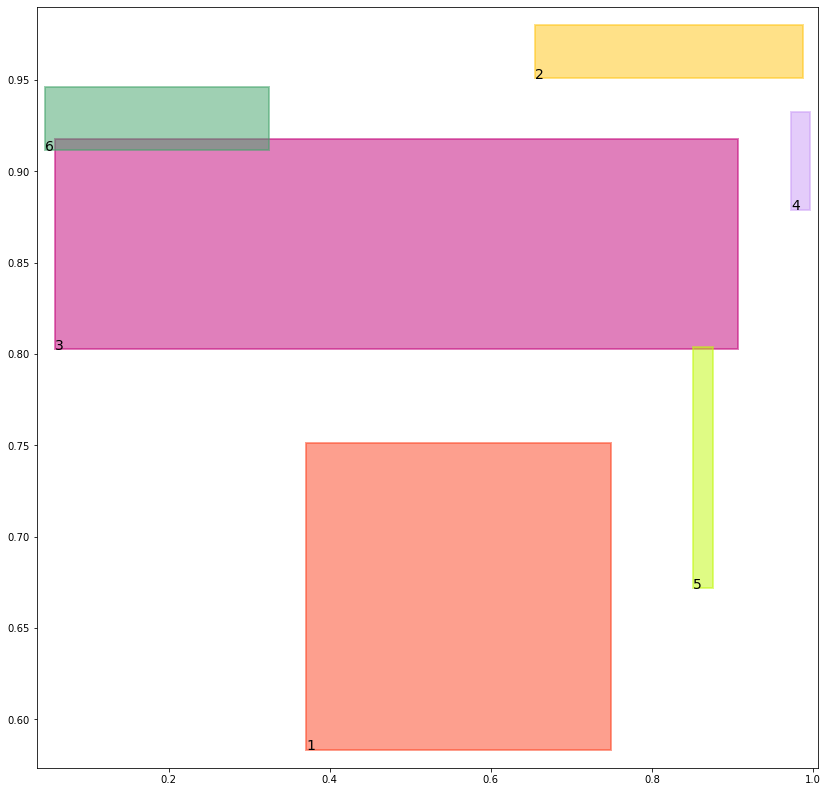

batch (tensor([[5, 3],
        [6, 2],
        [2, 6],
        [4, 5]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -14.377242088317871 -1.6984858512878418 tensor(-9.0634927749633789) tensor(-0.2478352785110474)
tensor(2) -17.4604434967041 -2.504297971725464 tensor(-12.9637098312377930) tensor(-1.2276527881622314)
tensor(3) -16.34259796142578 -2.2114017009735107 tensor(-4.2639980316162109) tensor(1.1242873668670654)
tensor(4) -17.511579513549805 -2.5398662090301514 tensor(-17.1457843780517578) tensor(-2.4655385017395020)
tensor(5) -15.869845390319824 -2.1137096881866455 tensor(-15.1546840667724609) tensor(-1.9593346118927002)
tensor(6) -8.463334083557129 -0.00296860933303833 tensor(-4.0861535072326660) tensor(1.2049181461334229)


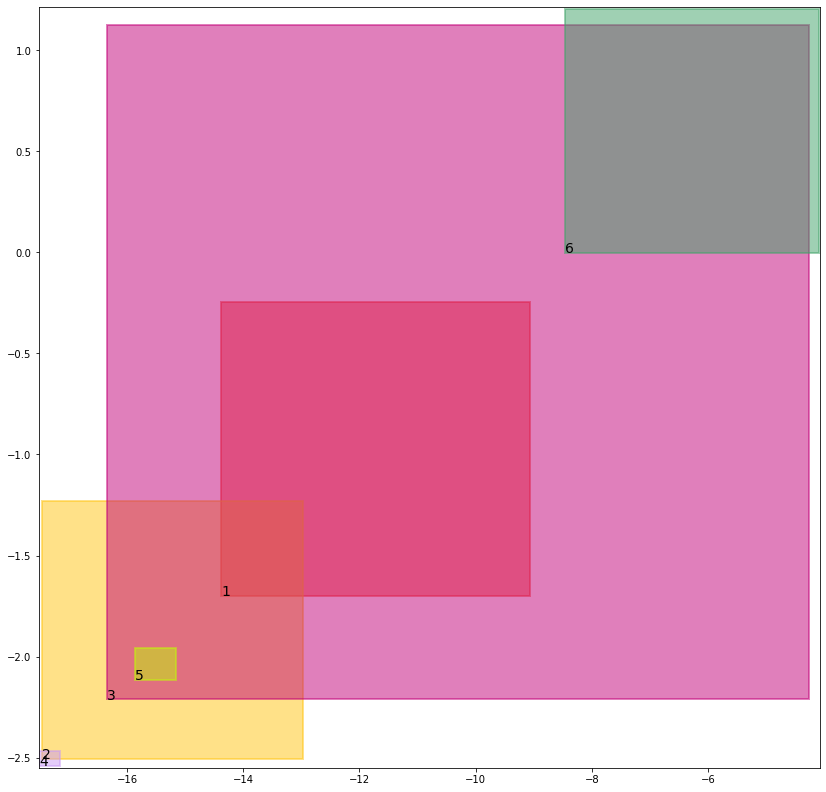

alignment data:
tensor(1) 0.39146023988723755 0.573462724685669 tensor(0.7650739550590515) tensor(0.7640079855918884)
tensor(2) 0.6464514136314392 0.946962296962738 tensor(0.9849510192871094) tensor(0.9791517257690430)
tensor(3) 0.06721900403499603 0.7941146492958069 tensor(0.9039437770843506) tensor(0.9058291316032410)
tensor(4) 0.974956750869751 0.8703991770744324 tensor(0.9951564073562622) tensor(0.9377921223640442)
tensor(5) 0.8356773853302002 0.701477587223053 tensor(0.8773595094680786) tensor(0.8220207095146179)
tensor(6) 0.052823301404714584 0.9215728640556335 tensor(0.3461425304412842) tensor(0.9490959048271179)


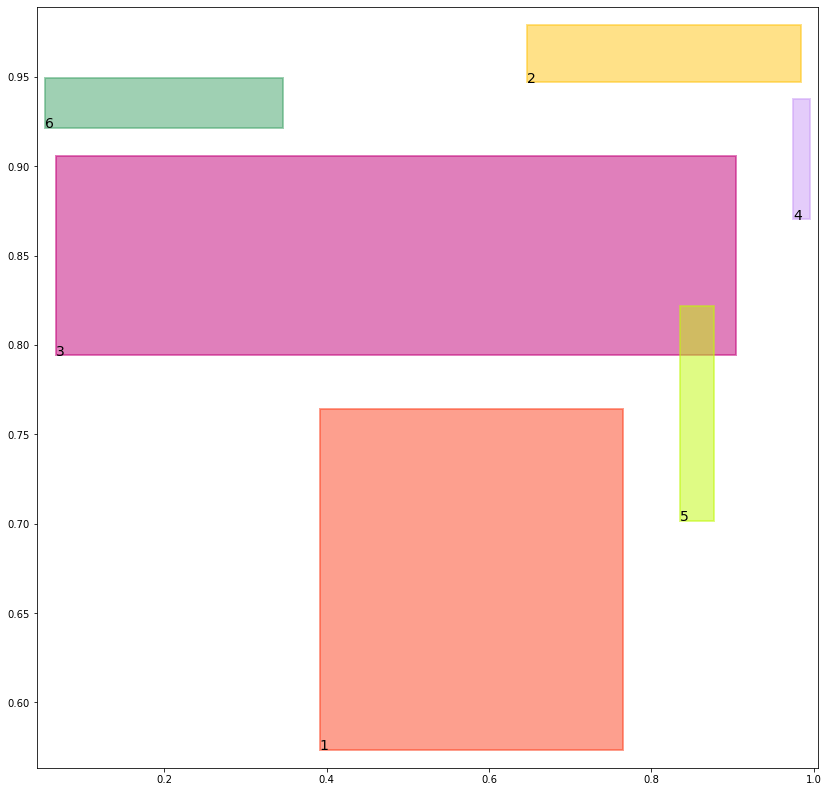

batch (tensor([[4, 5],
        [2, 6],
        [3, 5],
        [6, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -18.22042465209961 -2.8657009601593018 tensor(-11.9681997299194336) tensor(-0.9913313388824463)
tensor(2) -21.85283851623535 -3.8917477130889893 tensor(-16.5763359069824219) tensor(-2.2290399074554443)
tensor(3) -20.40182876586914 -3.483464479446411 tensor(-6.5532207489013672) tensor(0.7694499492645264)
tensor(4) -21.901277542114258 -3.932067632675171 tensor(-21.3746414184570312) tensor(-3.8175222873687744)
tensor(5) -19.89948272705078 -3.3617899417877197 tensor(-18.6481628417968750) tensor(-3.0336010456085205)
tensor(6) -12.087117195129395 -0.8493620157241821 tensor(-6.5957713127136230) tensor(0.8217444419860840)


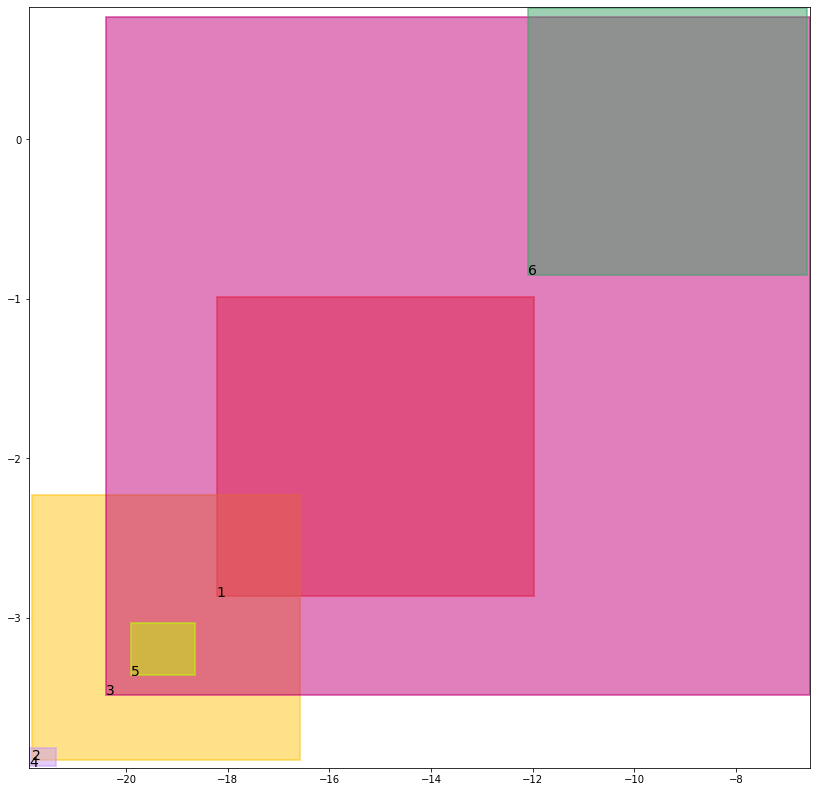

alignment data:
tensor(1) 0.40954047441482544 0.564662754535675 tensor(0.7787758111953735) tensor(0.7746214866638184)
tensor(2) 0.634032666683197 0.9426299333572388 tensor(0.9825252294540405) tensor(0.9775975346565247)
tensor(3) 0.0757773220539093 0.7818517088890076 tensor(0.9016808271408081) tensor(0.8942171335220337)
tensor(4) 0.9766805768013 0.8624579906463623 tensor(0.9944254159927368) tensor(0.9416000843048096)
tensor(5) 0.8189984560012817 0.7301180362701416 tensor(0.8804752230644226) tensor(0.8367611765861511)
tensor(6) 0.06138177216053009 0.9311650395393372 tensor(0.3699263334274292) tensor(0.9519994854927063)


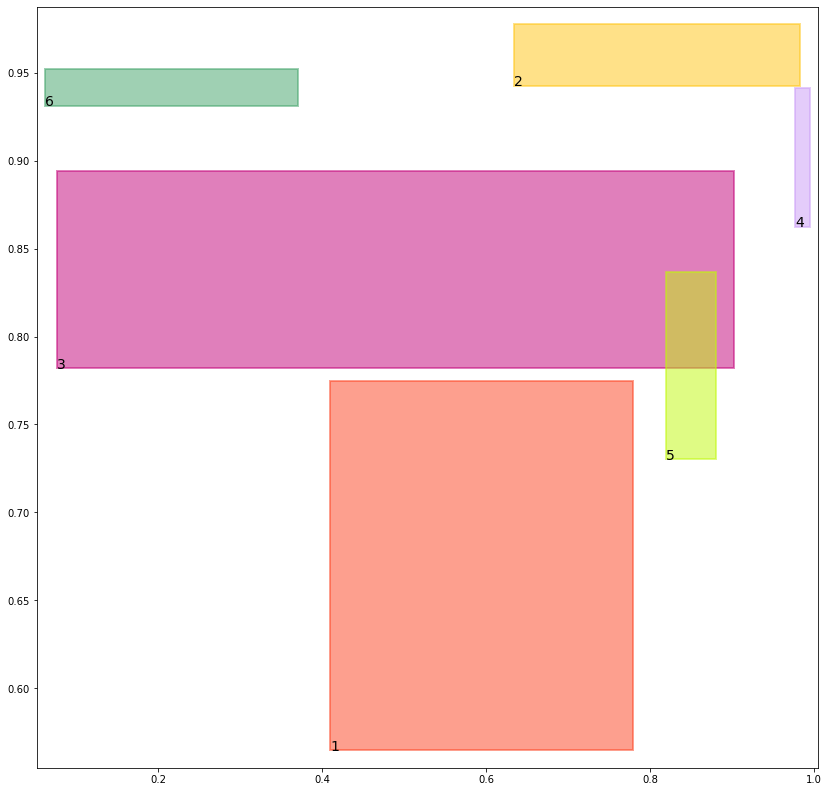

batch (tensor([[5, 3],
        [1, 2],
        [4, 6],
        [1, 3]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -22.02752113342285 -4.065795421600342 tensor(-14.6502027511596680) tensor(-1.7402977943420410)
tensor(2) -26.139949798583984 -5.292194843292236 tensor(-19.9001274108886719) tensor(-3.2057669162750244)
tensor(3) -24.209190368652344 -4.721166133880615 tensor(-8.9653120040893555) tensor(0.3254952430725098)
tensor(4) -26.206504821777344 -5.343184471130371 tensor(-25.4948158264160156) tensor(-5.1818494796752930)
tensor(5) -24.03409194946289 -4.685241222381592 tensor(-21.9951171875000000) tensor(-4.0816941261291504)
tensor(6) -15.750592231750488 -1.7847752571105957 tensor(-9.2148790359497070) tensor(0.3478498458862305)


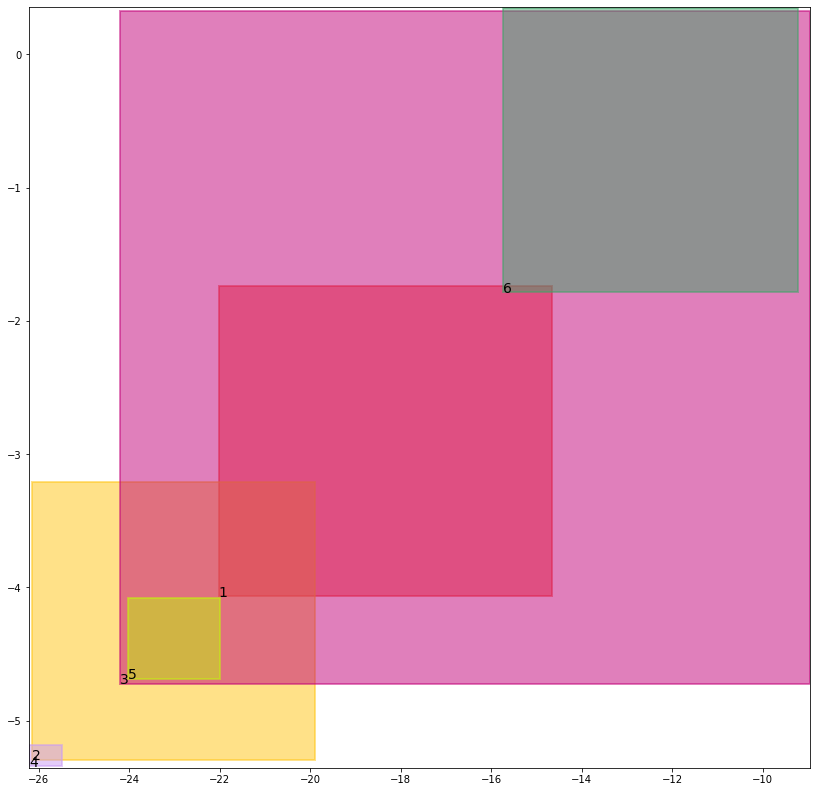

alignment data:
tensor(1) 0.42568913102149963 0.5568714737892151 tensor(0.7903724312782288) tensor(0.7836936116218567)
tensor(2) 0.6229177713394165 0.9385363459587097 tensor(0.9800722599029541) tensor(0.9761340618133545)
tensor(3) 0.08590983599424362 0.781971275806427 tensor(0.8926212191581726) tensor(0.8805166482925415)
tensor(4) 0.978103756904602 0.8551217317581177 tensor(0.9936907291412354) tensor(0.9447746872901917)
tensor(5) 0.7975361943244934 0.7538799047470093 tensor(0.8900627493858337) tensor(0.8542873263359070)
tensor(6) 0.06997454166412354 0.9387079477310181 tensor(0.3914644420146942) tensor(0.9544284343719482)


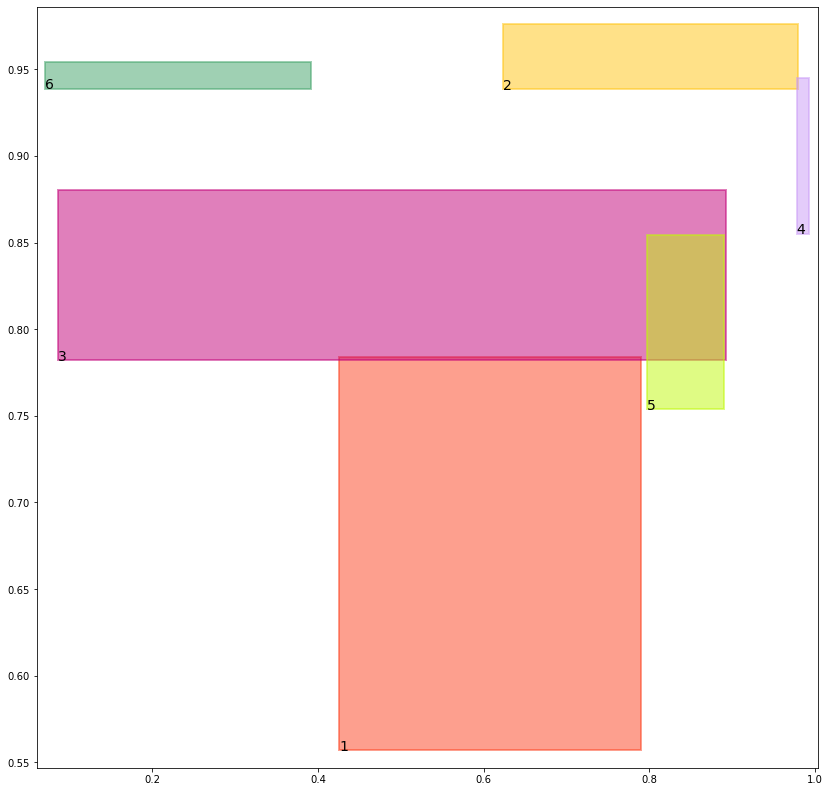

batch (tensor([[2, 6],
        [6, 2],
        [4, 5],
        [4, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -25.94521713256836 -5.3959736824035645 tensor(-17.3593444824218750) tensor(-2.5858097076416016)
tensor(2) -30.480663299560547 -6.809442043304443 tensor(-23.1278247833251953) tensor(-4.2256069183349609)
tensor(3) -28.022201538085938 -6.052087783813477 tensor(-11.5197677612304688) tensor(-0.2404551506042480)
tensor(4) -30.604427337646484 -6.8831610679626465 tensor(-29.6793918609619141) tensor(-6.6645617485046387)
tensor(5) -28.29834747314453 -6.14896297454834 tensor(-25.3798904418945312) tensor(-5.2143201828002930)
tensor(6) -19.55533218383789 -2.9226531982421875 tensor(-12.0536489486694336) tensor(-0.2785041332244873)


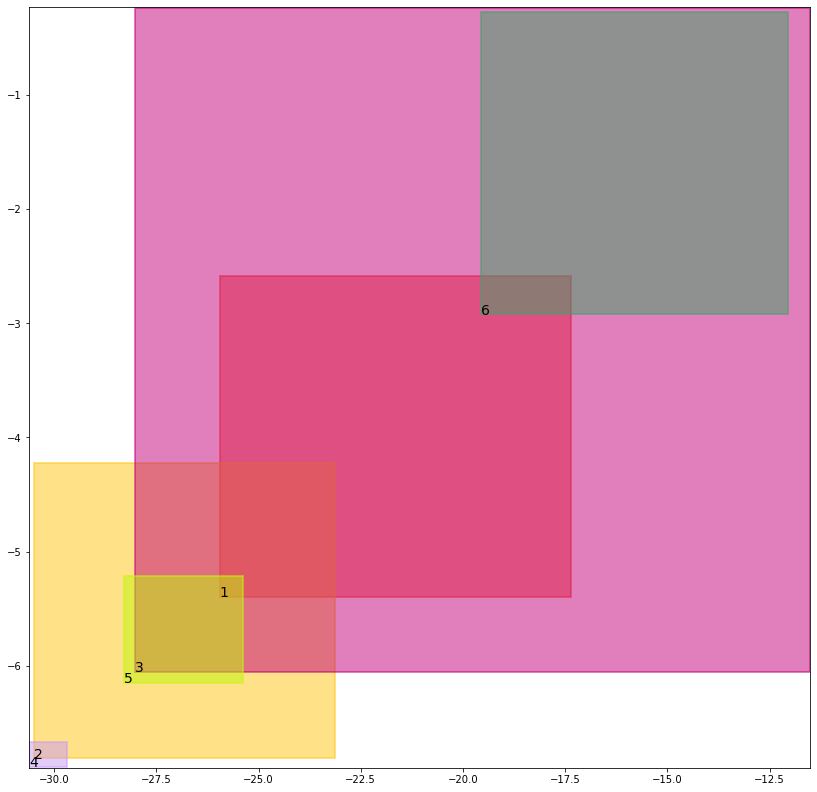

alignment data:
tensor(1) 0.44016003608703613 0.5499311685562134 tensor(0.8002876043319702) tensor(0.7915232181549072)
tensor(2) 0.6047413349151611 0.9399362802505493 tensor(0.9768413901329041) tensor(0.9736628532409668)
tensor(3) 0.09591729938983917 0.7820773720741272 tensor(0.8839711546897888) tensor(0.8670943379402161)
tensor(4) 0.9792957305908203 0.8483393788337708 tensor(0.9929395914077759) tensor(0.9474042654037476)
tensor(5) 0.7765252590179443 0.7736806869506836 tensor(0.8981917500495911) tensor(0.8685749173164368)
tensor(6) 0.08076509833335876 0.9440551400184631 tensor(0.4187536537647247) tensor(0.9570704102516174)


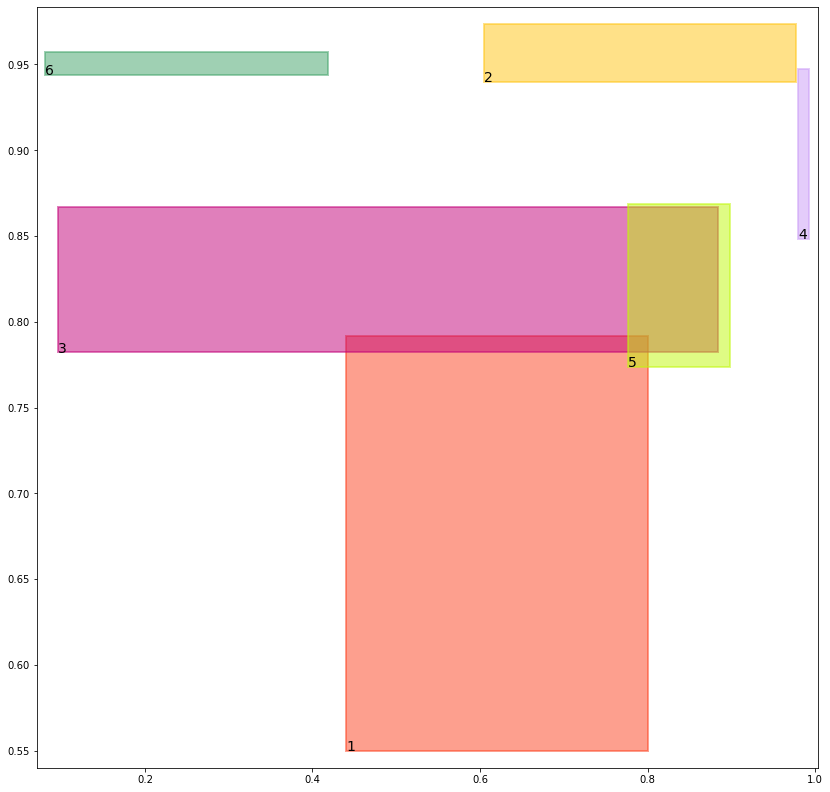

batch (tensor([[1, 3],
        [5, 3],
        [3, 5],
        [1, 2]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -29.71706771850586 -6.71425199508667 tensor(-19.9590034484863281) tensor(-3.4331097602844238)
tensor(2) -34.58946990966797 -8.28237247467041 tensor(-26.1515312194824219) tensor(-5.2030253410339355)
tensor(3) -31.652267456054688 -7.351866245269775 tensor(-14.0847358703613281) tensor(-0.8815803527832031)
tensor(4) -34.78352737426758 -8.400337219238281 tensor(-33.6055870056152344) tensor(-8.1486206054687500)
tensor(5) -32.29843521118164 -7.563652515411377 tensor(-28.4752979278564453) tensor(-6.2603812217712402)
tensor(6) -23.11440658569336 -4.055323123931885 tensor(-14.8640098571777344) tensor(-0.9680876731872559)


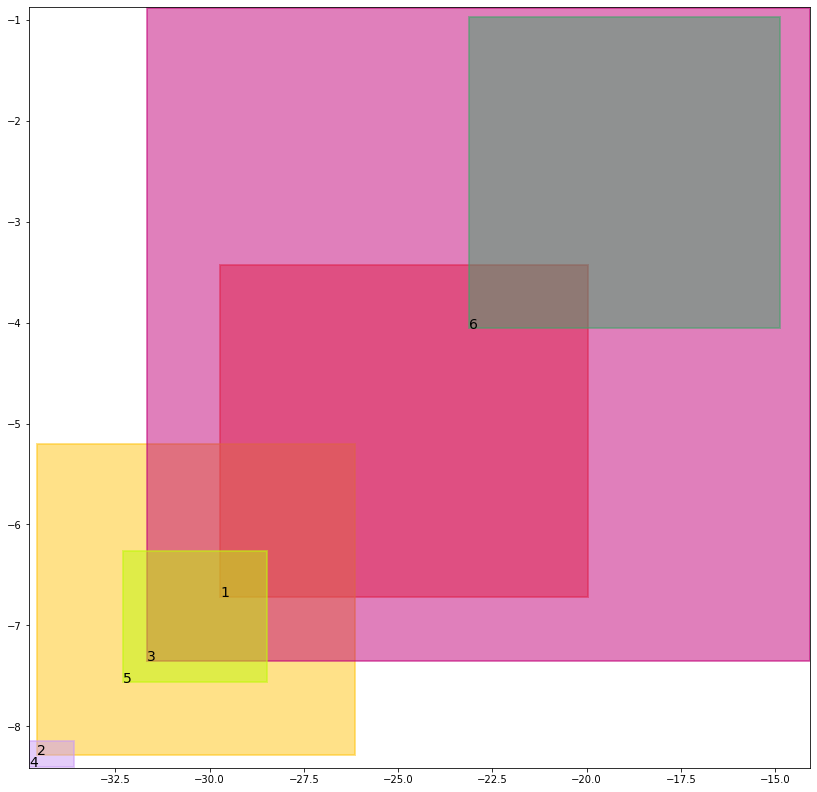

alignment data:
tensor(1) 0.4531622529029846 0.5437206625938416 tensor(0.8088357448577881) tensor(0.7983329296112061)
tensor(2) 0.5882682204246521 0.9411603212356567 tensor(0.9735301136970520) tensor(0.9712484478950500)
tensor(3) 0.10890605300664902 0.7791110277175903 tensor(0.8786899447441101) tensor(0.8560415506362915)
tensor(4) 0.9803057909011841 0.842068076133728 tensor(0.9921945333480835) tensor(0.9496508836746216)
tensor(5) 0.7505835294723511 0.7944674491882324 tensor(0.9016795754432678) tensor(0.8761377334594727)
tensor(6) 0.09165538102388382 0.9484540224075317 tensor(0.4435412585735321) tensor(0.9593042135238647)


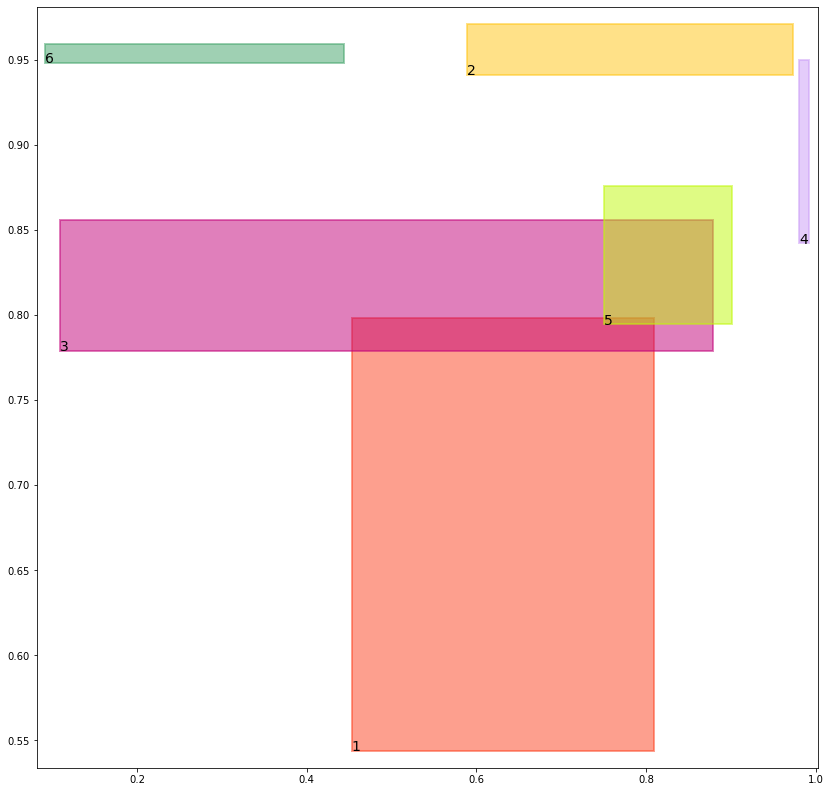

batch (tensor([[1, 3],
        [2, 6],
        [5, 3],
        [4, 5]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -33.33304214477539 -8.136659622192383 tensor(-22.4168090820312500) tensor(-4.3843998908996582)
tensor(2) -38.483917236328125 -9.838911056518555 tensor(-28.7215347290039062) tensor(-6.1614985466003418)
tensor(3) -35.00605010986328 -8.712255477905273 tensor(-16.5700912475585938) tensor(-1.6813473701477051)
tensor(4) -38.79486083984375 -9.98445987701416 tensor(-37.3980140686035156) tensor(-9.6461992263793945)
tensor(5) -36.13118362426758 -9.078813552856445 tensor(-31.1658325195312500) tensor(-7.3071990013122559)
tensor(6) -26.465675354003906 -5.271693229675293 tensor(-17.5685081481933594) tensor(-1.8137578964233398)


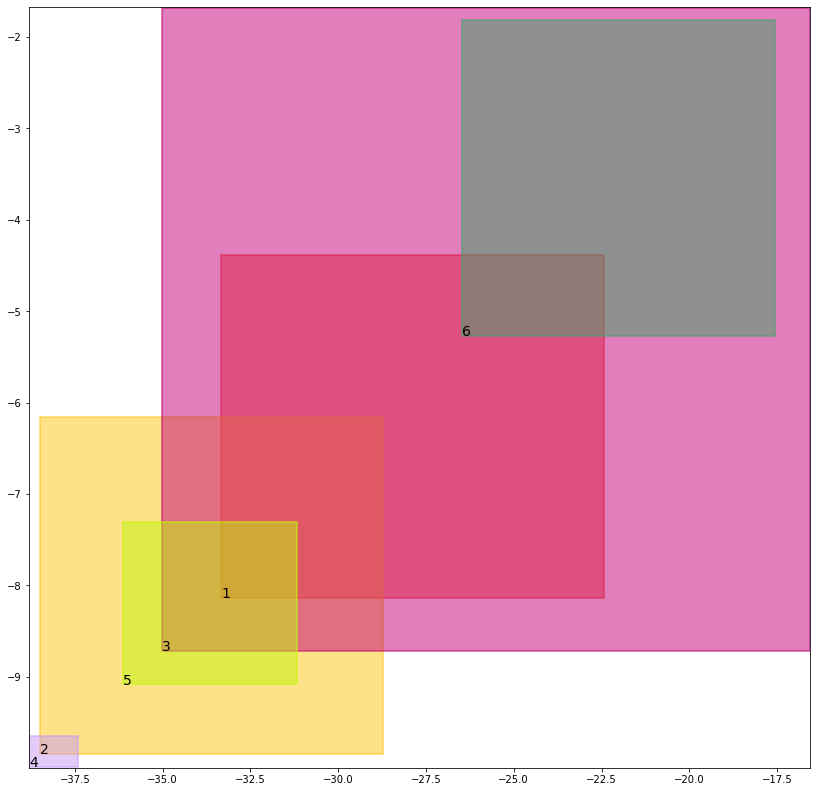

alignment data:
tensor(1) 0.46486979722976685 0.5381431579589844 tensor(0.8162567019462585) tensor(0.8042933344841003)
tensor(2) 0.5629476308822632 0.9422374367713928 tensor(0.9701742529869080) tensor(0.9689031839370728)
tensor(3) 0.1251307874917984 0.7857298851013184 tensor(0.8726111054420471) tensor(0.8432952761650085)
tensor(4) 0.9811698794364929 0.8362702131271362 tensor(0.9914568066596985) tensor(0.9515783786773682)
tensor(5) 0.7197615504264832 0.8071832656860352 tensor(0.9047544002532959) tensor(0.8826115727424622)
tensor(6) 0.10550002008676529 0.9525060057640076 tensor(0.4617777764797211) tensor(0.9607802629470825)


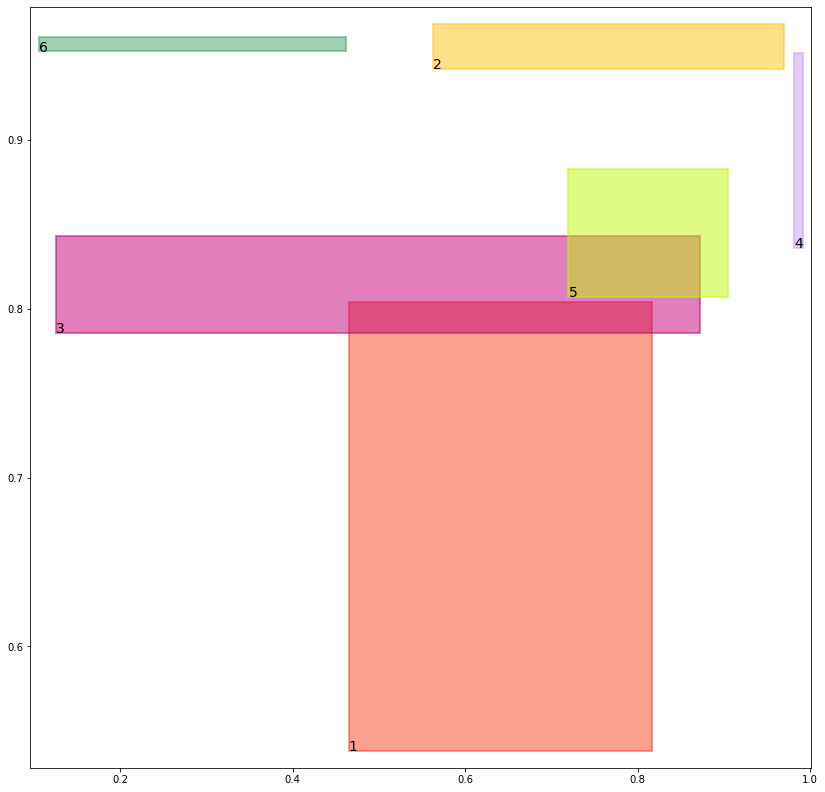

batch (tensor([[4, 6],
        [3, 5],
        [1, 2],
        [6, 2]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -36.771217346191406 -9.515607833862305 tensor(-24.7517166137695312) tensor(-5.3134813308715820)
tensor(2) -42.08843231201172 -11.309539794921875 tensor(-31.2137069702148438) tensor(-7.1004056930541992)
tensor(3) -38.28131103515625 -10.055463790893555 tensor(-18.8760223388671875) tensor(-2.4621095657348633)
tensor(4) -42.568077087402344 -11.517797470092773 tensor(-40.9389038085937500) tensor(-11.1012573242187500)
tensor(5) -39.662254333496094 -10.507406234741211 tensor(-33.5852165222167969) tensor(-8.2579641342163086)
tensor(6) -29.965927124023438 -6.581788063049316 tensor(-19.9923171997070312) tensor(-2.6178262233734131)


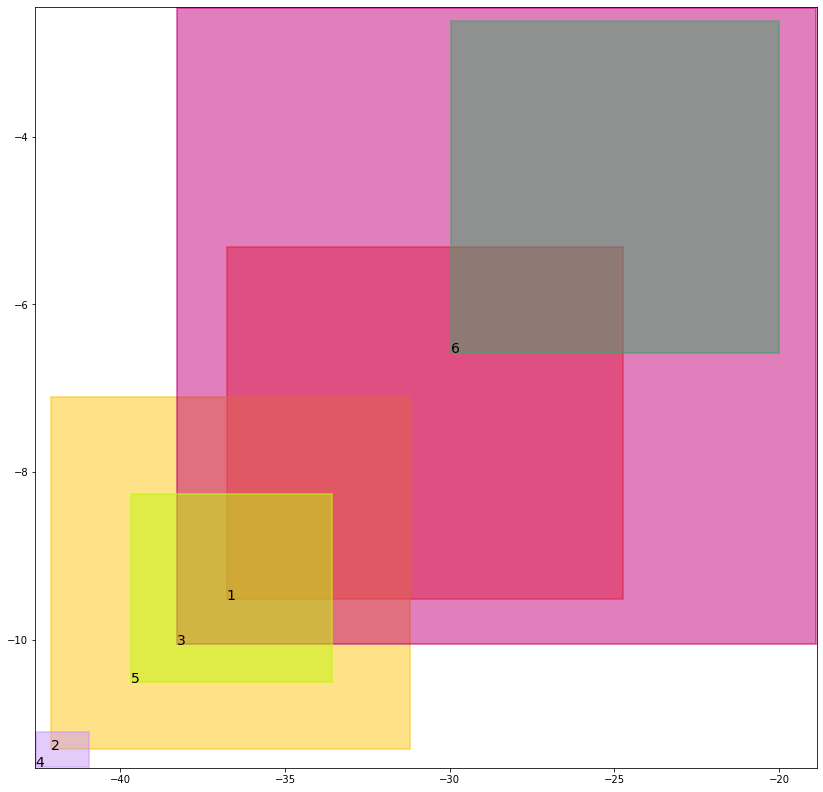

alignment data:
tensor(1) 0.4754299521446228 0.5331200957298279 tensor(0.8227367997169495) tensor(0.8095378875732422)
tensor(2) 0.5439003705978394 0.945902943611145 tensor(0.9656460881233215) tensor(0.9652398228645325)
tensor(3) 0.14144662022590637 0.7915570139884949 tensor(0.8713030815124512) tensor(0.8367250561714172)
tensor(4) 0.9819148778915405 0.8309121131896973 tensor(0.9907346963882446) tensor(0.9532515406608582)
tensor(5) 0.6905806660652161 0.8182538151741028 tensor(0.9047502279281616) tensor(0.8849918842315674)
tensor(6) 0.11949104815721512 0.9549729824066162 tensor(0.4885652065277100) tensor(0.9629409313201904)


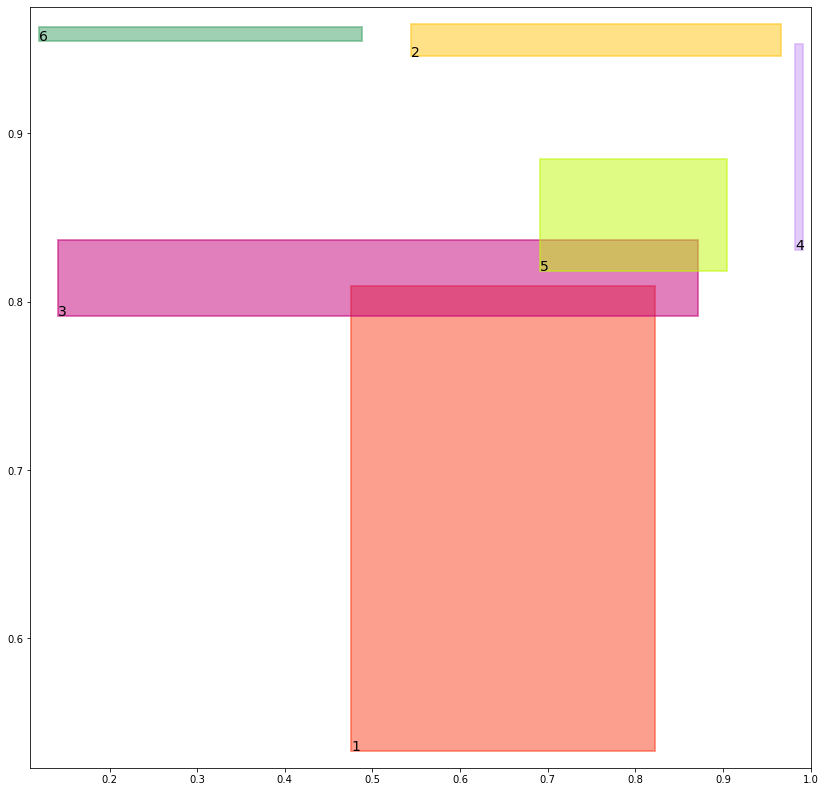

batch (tensor([[1, 2],
        [6, 2],
        [2, 6],
        [1, 3]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -40.023094177246094 -10.840341567993164 tensor(-26.9600372314453125) tensor(-6.2109265327453613)
tensor(2) -45.38713073730469 -12.679817199707031 tensor(-33.3137741088867188) tensor(-7.8934750556945801)
tensor(3) -41.33660125732422 -11.329216003417969 tensor(-21.1473121643066406) tensor(-3.2585372924804688)
tensor(4) -46.112640380859375 -12.978893280029297 tensor(-44.2456550598144531) tensor(-12.4884357452392578)
tensor(5) -42.984169006347656 -11.871095657348633 tensor(-35.7573699951171875) tensor(-9.1167182922363281)
tensor(6) -33.548973083496094 -7.958096981048584 tensor(-22.4637813568115234) tensor(-3.4750871658325195)


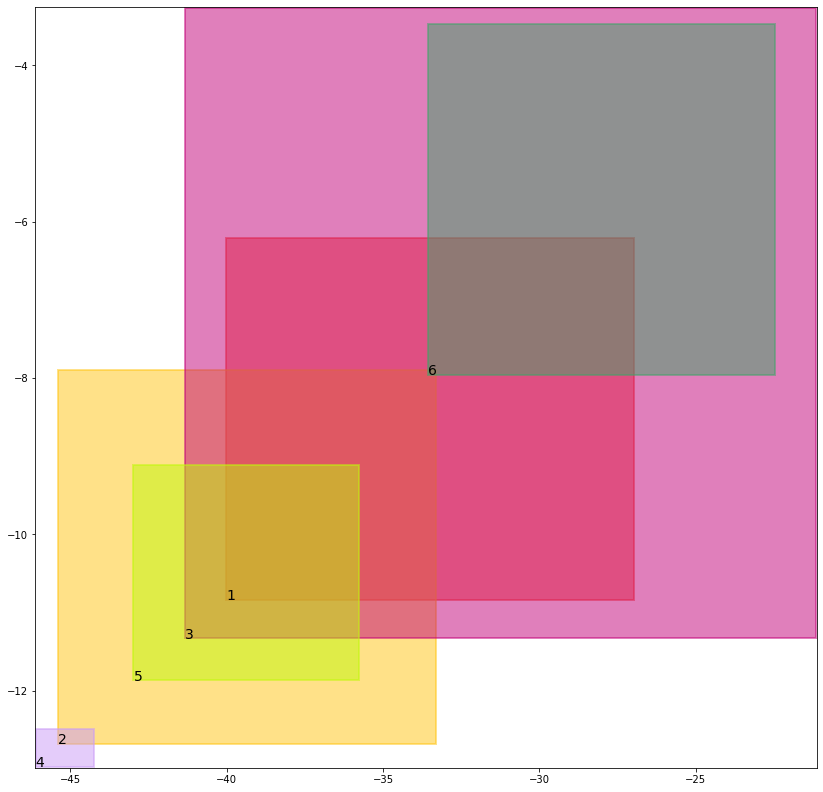

alignment data:
tensor(1) 0.4849691390991211 0.5285859107971191 tensor(0.8284237384796143) tensor(0.8141731023788452)
tensor(2) 0.5185614824295044 0.9508395791053772 tensor(0.9598123431205750) tensor(0.9602385163307190)
tensor(3) 0.15764383971691132 0.7967094779014587 tensor(0.8701139688491821) tensor(0.8306135535240173)
tensor(4) 0.9825618267059326 0.8259629607200623 tensor(0.9900321960449219) tensor(0.9547125697135925)
tensor(5) 0.662895679473877 0.8278045058250427 tensor(0.9047464132308960) tensor(0.8871016502380371)
tensor(6) 0.137204110622406 0.9565481543540955 tensor(0.5203383564949036) tensor(0.9653119444847107)


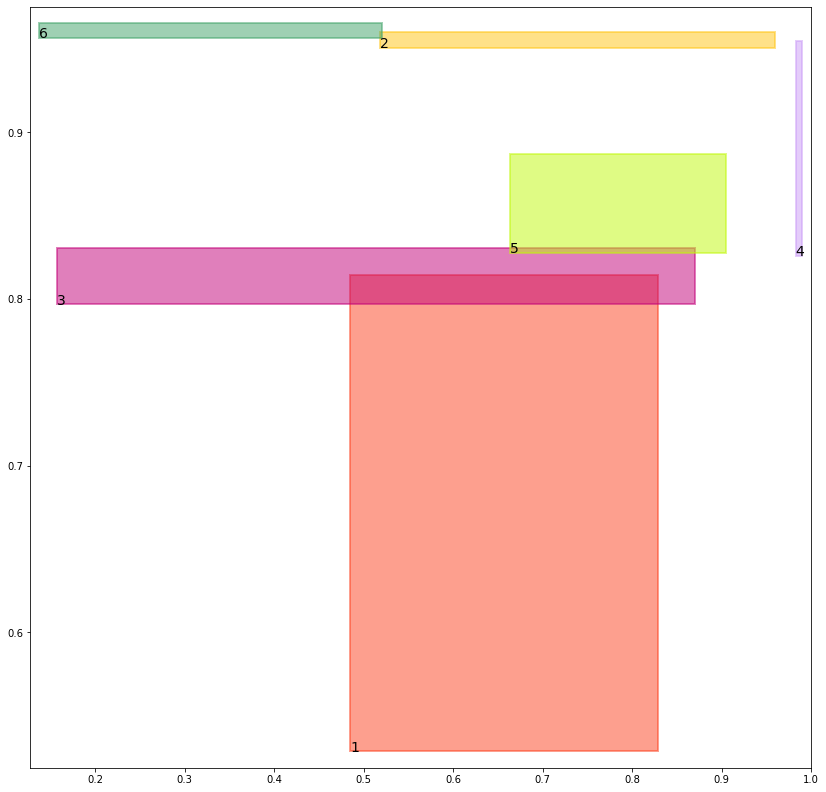

batch (tensor([[4, 5],
        [3, 5],
        [4, 6],
        [5, 3]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -43.08646774291992 -12.1045503616333 tensor(-29.0386676788330078) tensor(-7.0659880638122559)
tensor(2) -48.421722412109375 -13.957860946655273 tensor(-35.2219047546386719) tensor(-8.6177854537963867)
tensor(3) -44.31010437011719 -12.576428413391113 tensor(-23.5955886840820312) tensor(-4.1411294937133789)
tensor(4) -49.431922912597656 -14.363482475280762 tensor(-47.3362388610839844) tensor(-13.7903070449829102)
tensor(5) -45.986572265625 -13.126300811767578 tensor(-37.4497795104980469) tensor(-9.7928447723388672)
tensor(6) -36.974952697753906 -9.30141830444336 tensor(-24.8796691894531250) tensor(-4.3394098281860352)


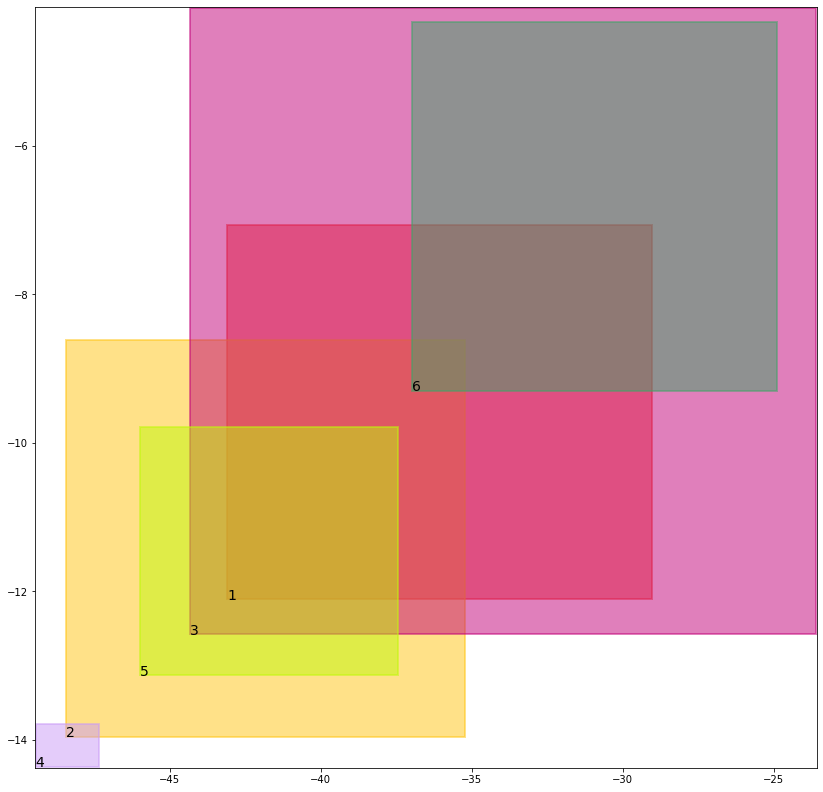

alignment data:
tensor(1) 0.4935965836048126 0.5244856476783752 tensor(0.8334361314773560) tensor(0.8182854056358337)
tensor(2) 0.49558377265930176 0.9549292922019958 tensor(0.9537352323532104) tensor(0.9551329612731934)
tensor(3) 0.17841453850269318 0.807432234287262 tensor(0.8720142841339111) tensor(0.8282348513603210)
tensor(4) 0.9831265807151794 0.8213940858840942 tensor(0.9893521666526794) tensor(0.9559951424598694)
tensor(5) 0.6296660900115967 0.8328866958618164 tensor(0.9021926522254944) tensor(0.8861066699028015)
tensor(6) 0.15505768358707428 0.9579257965087891 tensor(0.5489091277122498) tensor(0.9673275947570801)


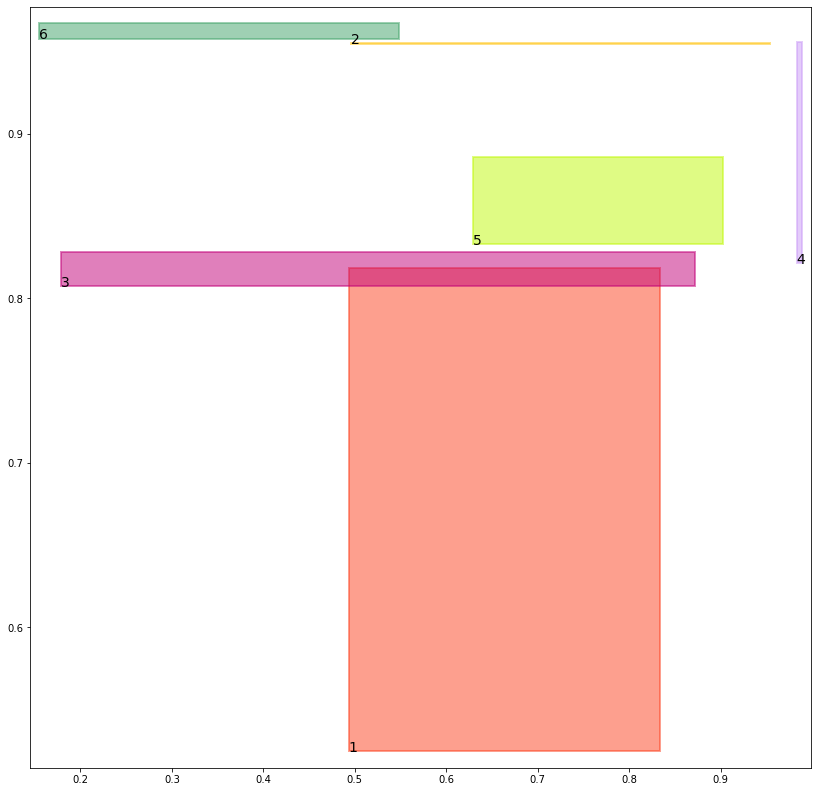

batch (tensor([[4, 5],
        [3, 5],
        [1, 3],
        [4, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -45.96135330200195 -13.303754806518555 tensor(-30.9880619049072266) tensor(-7.8799223899841309)
tensor(2) -51.332786560058594 -15.176301956176758 tensor(-36.8300933837890625) tensor(-9.2467422485351562)
tensor(3) -47.39537048339844 -13.858989715576172 tensor(-26.0064964294433594) tensor(-5.0334873199462891)
tensor(4) -52.530616760253906 -15.668838500976562 tensor(-50.2113113403320312) tensor(-15.0144367218017578)
tensor(5) -48.573585510253906 -14.233570098876953 tensor(-38.9794006347656250) tensor(-10.4022502899169922)
tensor(6) -40.231624603271484 -10.600150108337402 tensor(-27.2340583801269531) tensor(-5.2041797637939453)


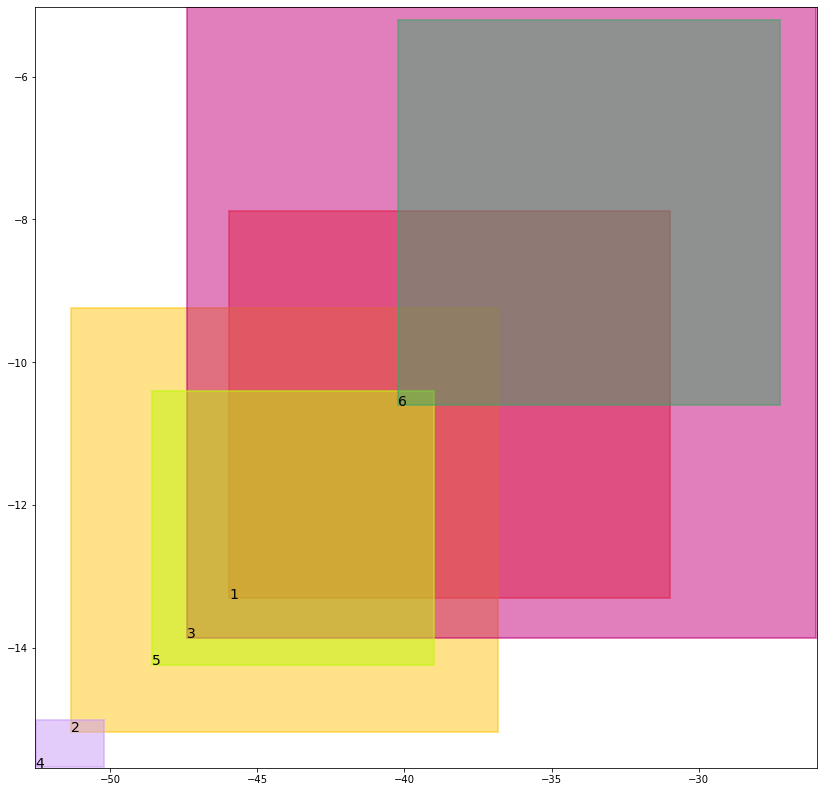

alignment data:
tensor(1) 0.5014076828956604 0.5207721590995789 tensor(0.8378705978393555) tensor(0.8219455480575562)
tensor(2) 0.47480297088623047 0.9499790072441101 tensor(0.9474902749061584) tensor(0.9583493471145630)
tensor(3) 0.19900555908679962 0.8167599439620972 tensor(0.8795065879821777) tensor(0.8350087404251099)
tensor(4) 0.983622133731842 0.8171789050102234 tensor(0.9886974096298218) tensor(0.9571257233619690)
tensor(5) 0.5998380780220032 0.8376944065093994 tensor(0.8954654932022095) tensor(0.8801926970481873)
tensor(6) 0.17280957102775574 0.9591365456581116 tensor(0.5744950771331787) tensor(0.9690539836883545)


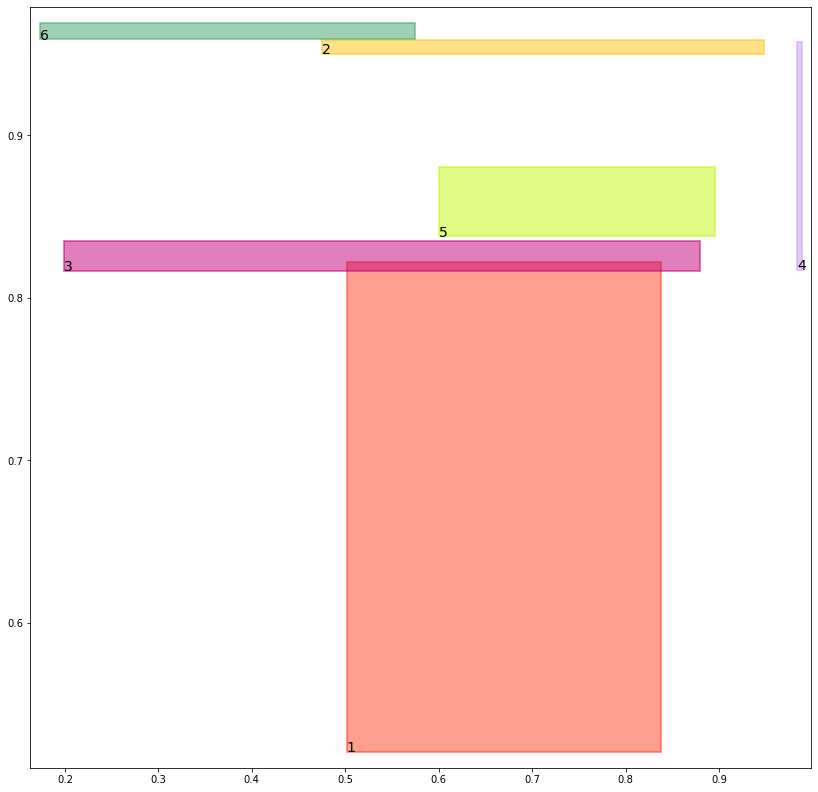

batch (tensor([[2, 6],
        [6, 2],
        [5, 3],
        [1, 2]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -48.65105056762695 -14.435860633850098 tensor(-32.8116874694824219) tensor(-8.6510133743286133)
tensor(2) -53.96599578857422 -16.28592300415039 tensor(-38.1128616333007812) tensor(-9.7404603958129883)
tensor(3) -50.25804138183594 -15.062268257141113 tensor(-28.5834236145019531) tensor(-6.0113353729248047)
tensor(4) -55.41615676879883 -16.89451789855957 tensor(-52.8800277709960938) tensor(-16.1610794067382812)
tensor(5) -50.944114685058594 -15.258193016052246 tensor(-40.0901298522949219) tensor(-10.8439998626708984)
tensor(6) -43.48957061767578 -11.921502113342285 tensor(-29.6936149597167969) tensor(-6.1385488510131836)


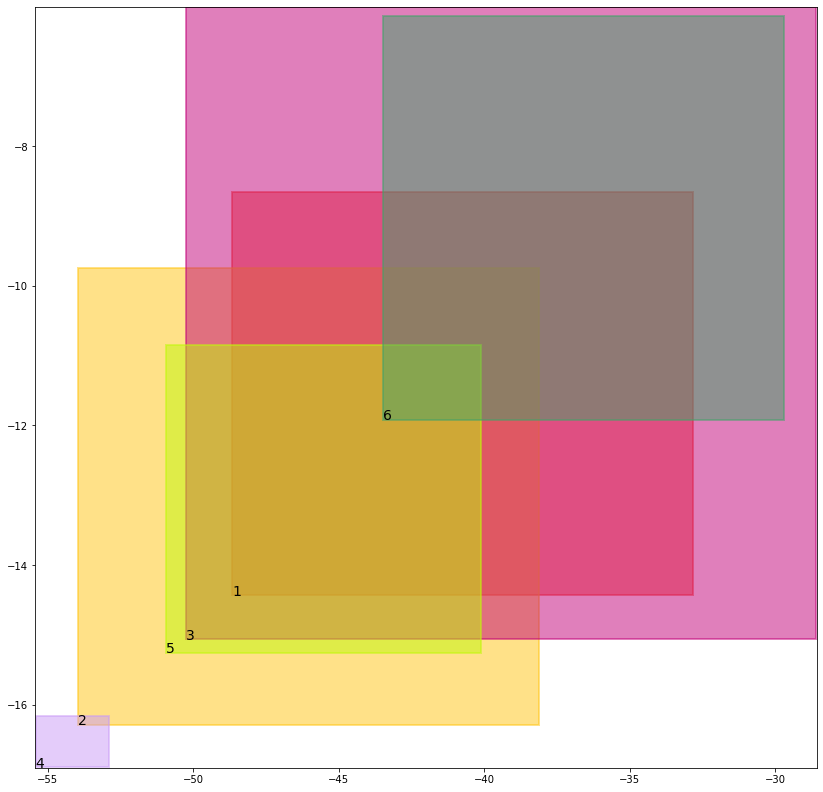

alignment data:
tensor(1) 0.5084860324859619 0.5174047946929932 tensor(0.8418067097663879) tensor(0.8252125382423401)
tensor(2) 0.44970735907554626 0.9477739334106445 tensor(0.9392534494400024) tensor(0.9617069363594055)
tensor(3) 0.22399486601352692 0.8281803131103516 tensor(0.8856235146522522) tensor(0.8401219844818115)
tensor(4) 0.9840589761734009 0.8132925629615784 tensor(0.9880695939064026) tensor(0.9581264853477478)
tensor(5) 0.5658298134803772 0.839864194393158 tensor(0.8890192508697510) tensor(0.8746057748794556)
tensor(6) 0.19551493227481842 0.9598100185394287 tensor(0.6031572222709656) tensor(0.9699666500091553)


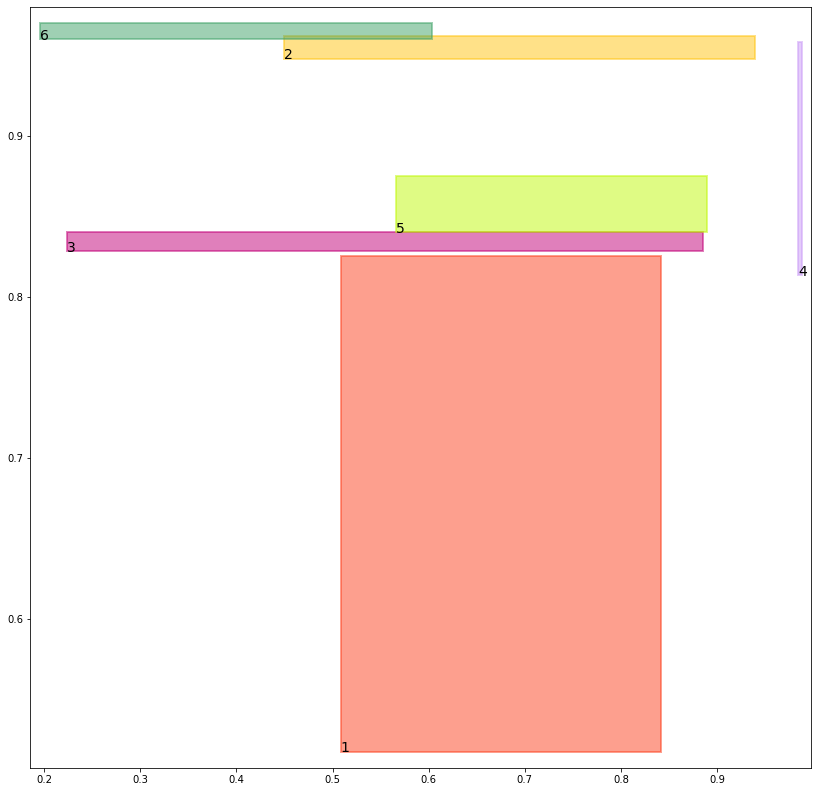

batch (tensor([[2, 6],
        [4, 6],
        [3, 5],
        [1, 3]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -51.160888671875 -15.500409126281738 tensor(-34.5132293701171875) tensor(-9.3782920837402344)
tensor(2) -56.38184356689453 -17.308347702026367 tensor(-38.9614791870117188) tensor(-10.0555667877197266)
tensor(3) -53.06834411621094 -16.242183685302734 tensor(-31.1090087890625000) tensor(-6.9899988174438477)
tensor(4) -58.09754943847656 -18.041566848754883 tensor(-55.3526458740234375) tensor(-17.2318115234375000)
tensor(5) -52.974388122558594 -16.153650283813477 tensor(-41.0570831298828125) tensor(-11.2244253158569336)
tensor(6) -46.48904037475586 -13.154823303222656 tensor(-32.2920761108398438) tensor(-7.1553478240966797)


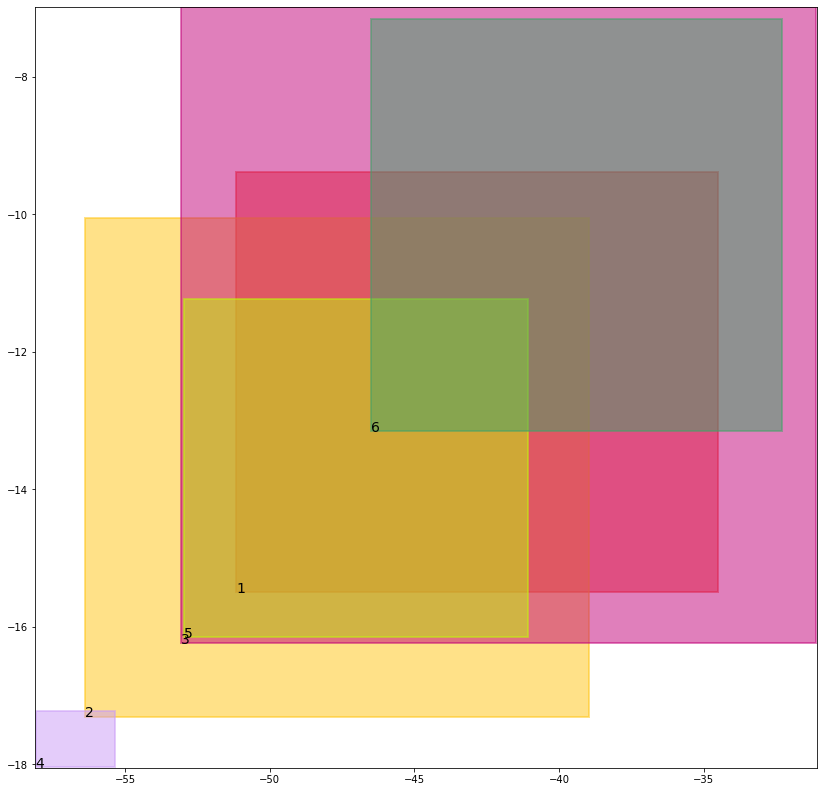

alignment data:
tensor(1) 0.5149053335189819 0.5143481492996216 tensor(0.8453104496002197) tensor(0.8281355500221252)
tensor(2) 0.41830477118492126 0.9456941485404968 tensor(0.9307490587234497) tensor(0.9653289318084717)
tensor(3) 0.24853238463401794 0.838047206401825 tensor(0.8932571411132812) tensor(0.8482354283332825)
tensor(4) 0.9844452738761902 0.8097116947174072 tensor(0.9874703288078308) tensor(0.9590150117874146)
tensor(5) 0.5347563028335571 0.8418735265731812 tensor(0.8801882863044739) tensor(0.8664574623107910)
tensor(6) 0.22334620356559753 0.9605607986450195 tensor(0.6270790100097656) tensor(0.9699679613113403)


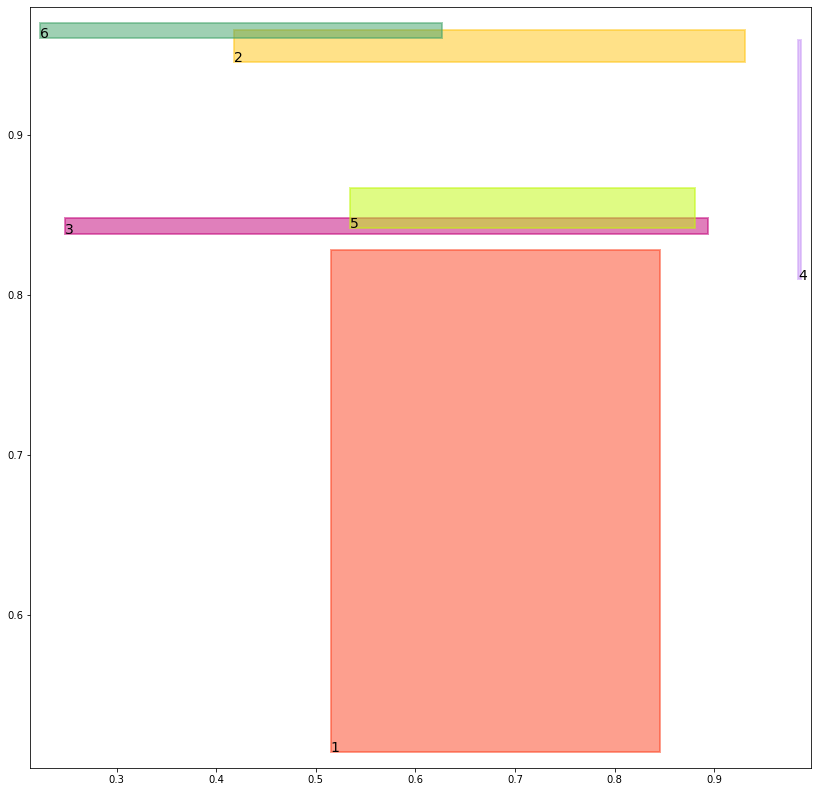

batch (tensor([[4, 5],
        [5, 3],
        [6, 2],
        [1, 2]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -53.49757766723633 -16.498075485229492 tensor(-36.0972518920898438) tensor(-10.0616722106933594)
tensor(2) -58.49620056152344 -18.209157943725586 tensor(-39.8402023315429688) tensor(-10.3746013641357422)
tensor(3) -55.577392578125 -17.305463790893555 tensor(-33.8865737915039062) tensor(-8.0889301300048828)
tensor(4) -60.58464813232422 -19.11199951171875 tensor(-57.6399574279785156) tensor(-18.2290306091308594)
tensor(5) -54.924312591552734 -17.018762588500977 tensor(-41.5435333251953125) tensor(-11.4099960327148438)
tensor(6) -49.57814025878906 -14.440844535827637 tensor(-34.8302650451660156) tensor(-8.1699180603027344)


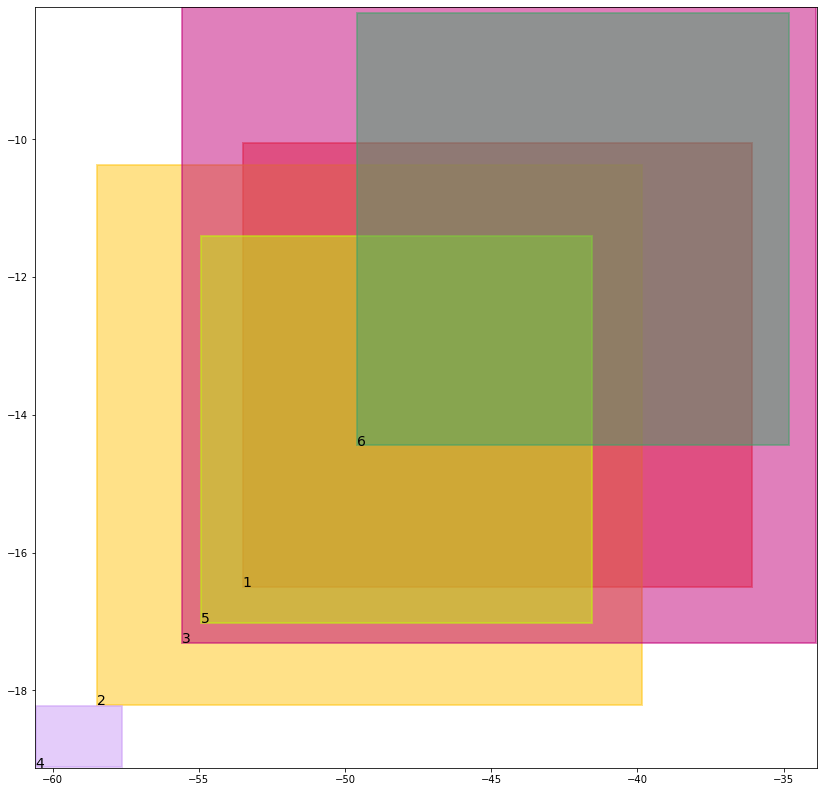

alignment data:
tensor(1) 0.52073073387146 0.5115713477134705 tensor(0.8484371900558472) tensor(0.8307564258575439)
tensor(2) 0.39208880066871643 0.9473114609718323 tensor(0.9197397232055664) tensor(0.9681442975997925)
tensor(3) 0.2791672348976135 0.8502288460731506 tensor(0.8970824480056763) tensor(0.8545358180999756)
tensor(4) 0.984788179397583 0.8064143657684326 tensor(0.9869005084037781) tensor(0.9598062634468079)
tensor(5) 0.49799203872680664 0.8405407071113586 tensor(0.8752105832099915) tensor(0.8586737513542175)
tensor(6) 0.25097188353538513 0.9604389071464539 tensor(0.6562845110893250) tensor(0.9699690937995911)


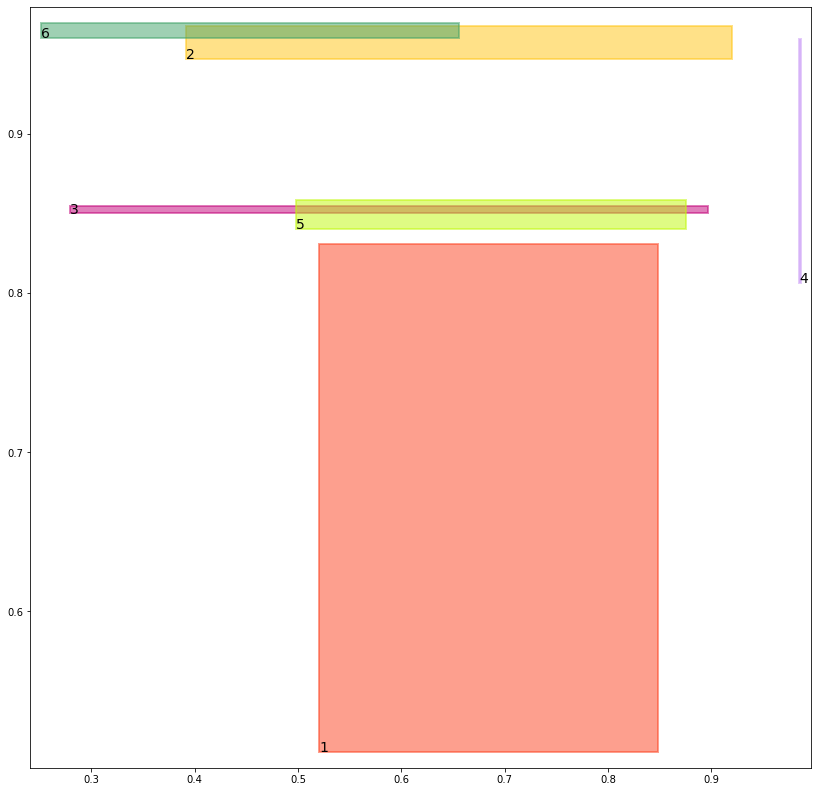

batch (tensor([[4, 6],
        [1, 3],
        [6, 2],
        [3, 5]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -55.668678283691406 -17.430360794067383 tensor(-37.5689392089843750) tensor(-10.7017488479614258)
tensor(2) -60.299400329589844 -18.981576919555664 tensor(-40.7261962890625000) tensor(-10.6925039291381836)
tensor(3) -57.97077178955078 -18.316204071044922 tensor(-36.5303535461425781) tensor(-9.1610288619995117)
tensor(4) -62.88777160644531 -20.108491897583008 tensor(-59.7528800964355469) tensor(-19.1556854248046875)
tensor(5) -56.628517150878906 -17.793184280395508 tensor(-42.0019912719726562) tensor(-11.5718488693237305)
tensor(6) -52.69584655761719 -15.75301456451416 tensor(-37.2868576049804688) tensor(-9.1703453063964844)


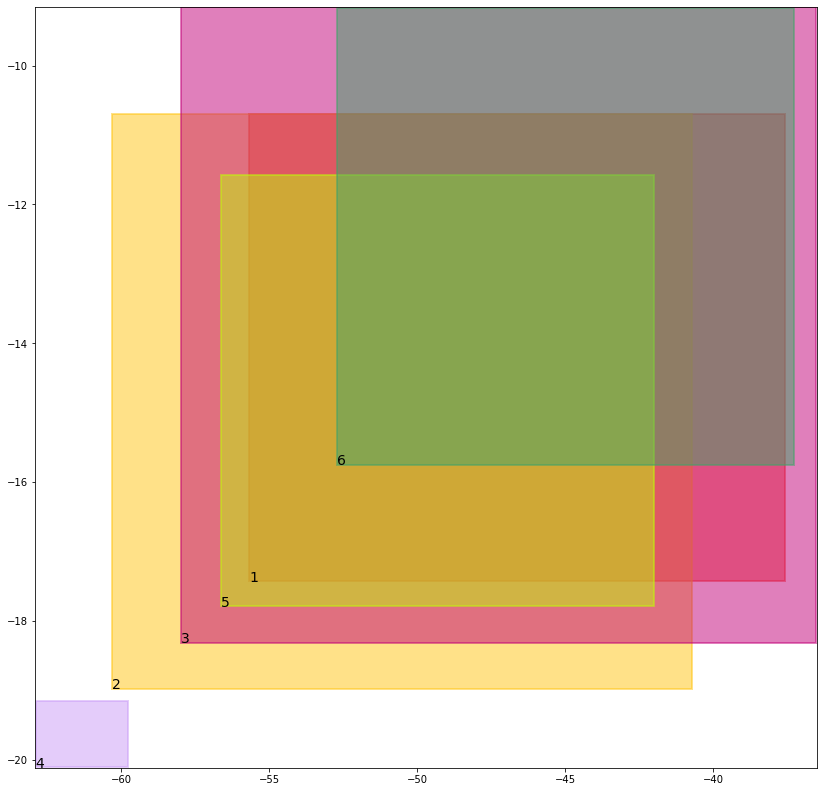

alignment data:
tensor(1) 0.526020348072052 0.5090470910072327 tensor(0.8512336611747742) tensor(0.8331106901168823)
tensor(2) 0.37023094296455383 0.9510189294815063 tensor(0.9057983160018921) tensor(0.9703693389892578)
tensor(3) 0.3089298605918884 0.8573850989341736 tensor(0.9004532694816589) tensor(0.8631379604339600)
tensor(4) 0.985093355178833 0.8033802509307861 tensor(0.9863603115081787) tensor(0.9605126976966858)
tensor(5) 0.464706152677536 0.8425111770629883 tensor(0.8704992532730103) tensor(0.8478024005889893)
tensor(6) 0.27797436714172363 0.9595121741294861 tensor(0.6885572671890259) tensor(0.9699701070785522)


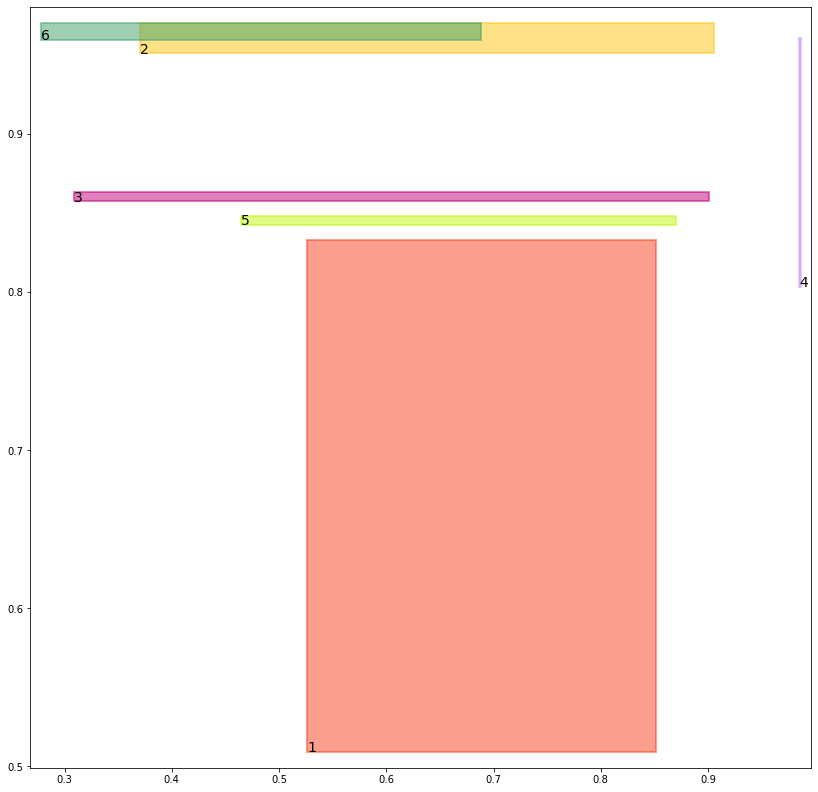

batch (tensor([[2, 6],
        [4, 5],
        [1, 2],
        [5, 3]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -57.68233871459961 -18.29935073852539 tensor(-38.9338150024414062) tensor(-11.2995853424072266)
tensor(2) -61.88221740722656 -19.6617374420166 tensor(-41.1244354248046875) tensor(-10.8041362762451172)
tensor(3) -60.034515380859375 -19.203392028808594 tensor(-39.3961067199707031) tensor(-10.3489971160888672)
tensor(4) -65.01744842529297 -21.034183502197266 tensor(-61.7022933959960938) tensor(-20.0150737762451172)
tensor(5) -58.442481994628906 -18.595272064208984 tensor(-42.0500335693359375) tensor(-11.5637655258178711)
tensor(6) -55.55887985229492 -16.96843147277832 tensor(-39.9634017944335938) tensor(-10.2856454849243164)


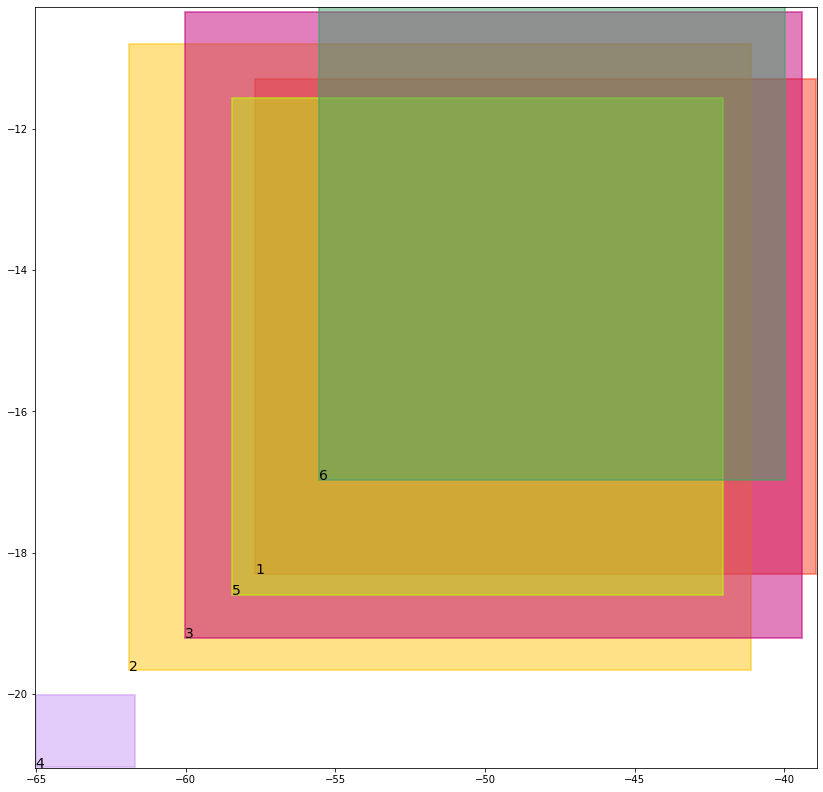

alignment data:
tensor(1) 0.5308257341384888 0.5067510604858398 tensor(0.8537397980690002) tensor(0.8352289199829102)
tensor(2) 0.342629075050354 0.9541746377944946 tensor(0.8912751674652100) tensor(0.9722613692283630)
tensor(3) 0.3450392782688141 0.8640187978744507 tensor(0.9011702537536621) tensor(0.8669734597206116)
tensor(4) 0.9853655099868774 0.8005897998809814 tensor(0.9858501553535461) tensor(0.9611447453498840)
tensor(5) 0.4269276261329651 0.8419667482376099 tensor(0.8697729706764221) tensor(0.8442859053611755)
tensor(6) 0.311606228351593 0.9587083458900452 tensor(0.7160836458206177) tensor(0.9699232578277588)


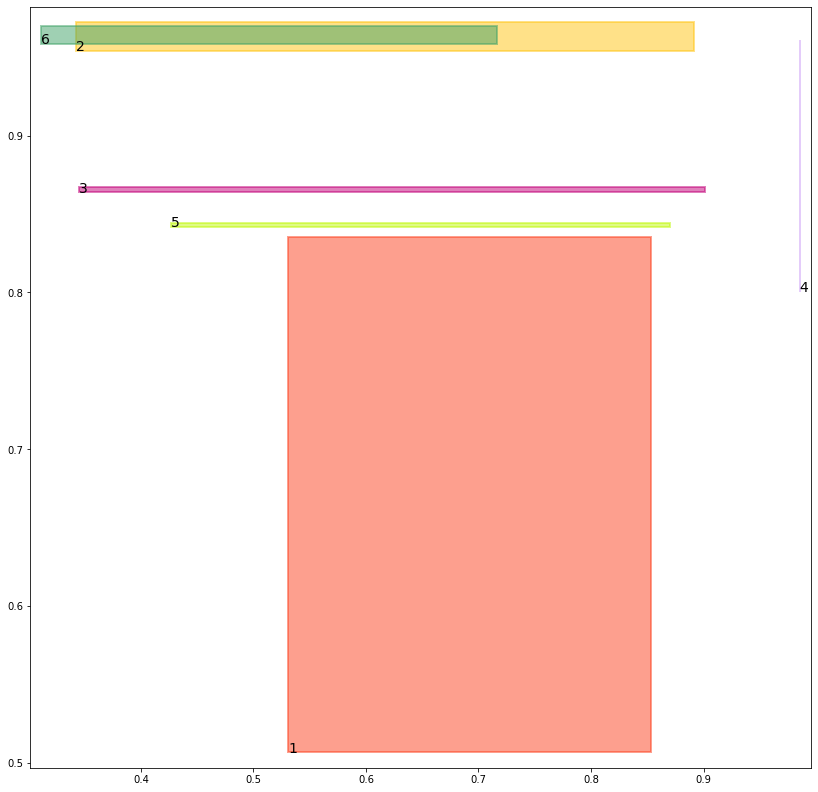

batch (tensor([[4, 5],
        [1, 2],
        [4, 6],
        [1, 3]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -59.54698181152344 -19.1075439453125 tensor(-40.1976242065429688) tensor(-11.8566017150878906)
tensor(2) -63.26443862915039 -20.25704002380371 tensor(-41.4903411865234375) tensor(-10.9031267166137695)
tensor(3) -61.94493865966797 -20.028030395507812 tensor(-42.1590957641601562) tensor(-11.4854688644409180)
tensor(4) -66.99291229248047 -21.896249771118164 tensor(-63.4899559020996094) tensor(-20.8071861267089844)
tensor(5) -60.21675109863281 -19.366392135620117 tensor(-41.9617805480957031) tensor(-11.5114173889160156)
tensor(6) -58.184356689453125 -18.090633392333984 tensor(-42.5796966552734375) tensor(-11.3719196319580078)


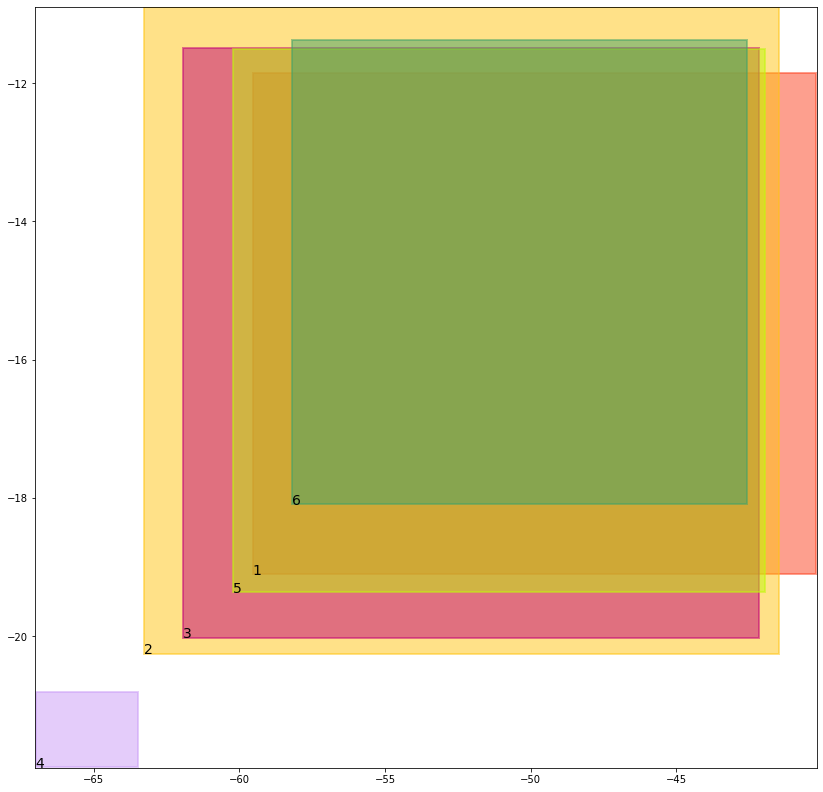

alignment data:
tensor(1) 0.5351929664611816 0.5046617984771729 tensor(0.8559895157814026) tensor(0.8371372818946838)
tensor(2) 0.31840232014656067 0.956876814365387 tensor(0.8763886690139771) tensor(0.9738805890083313)
tensor(3) 0.37953832745552063 0.8698267340660095 tensor(0.9018186330795288) tensor(0.8703839182853699)
tensor(4) 0.9853695631027222 0.7980251908302307 tensor(0.9856089949607849) tensor(0.9617114663124084)
tensor(5) 0.3932682275772095 0.8365001678466797 tensor(0.8691090941429138) tensor(0.8458864688873291)
tensor(6) 0.3440486490726471 0.9579636454582214 tensor(0.7398093342781067) tensor(0.9698804020881653)


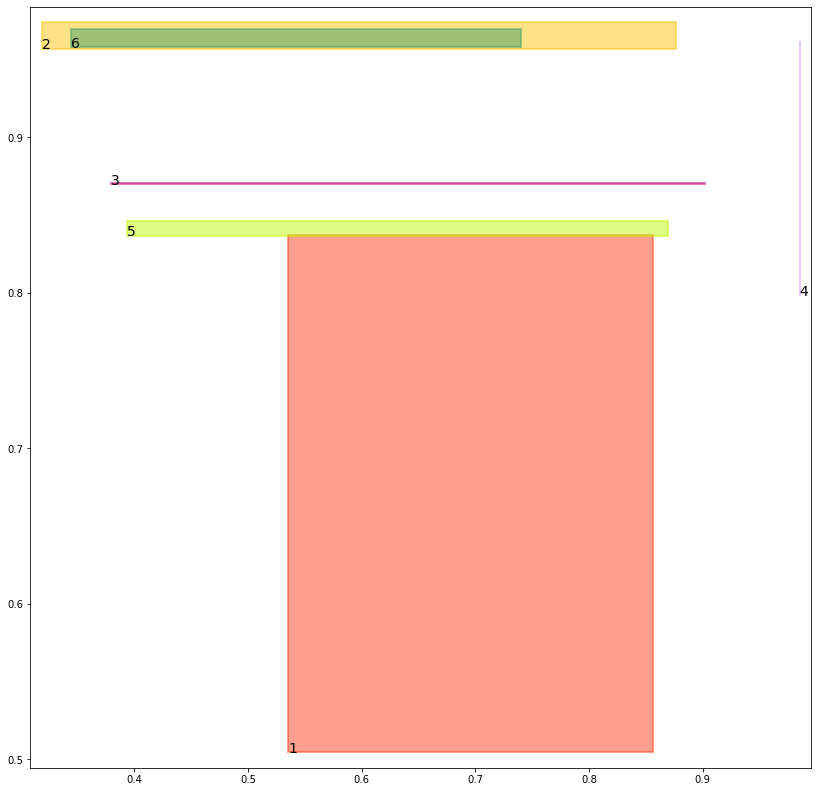

batch (tensor([[6, 2],
        [5, 3],
        [2, 6],
        [3, 5]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -61.271141052246094 -19.85772132873535 tensor(-41.3661499023437500) tensor(-12.3744564056396484)
tensor(2) -64.31549835205078 -20.711448669433594 tensor(-42.0799179077148438) tensor(-11.0952997207641602)
tensor(3) -63.676551818847656 -20.77740478515625 tensor(-44.9066772460937500) tensor(-12.6379184722900391)
tensor(4) -68.83447265625 -22.698457717895508 tensor(-65.1182785034179688) tensor(-21.5324172973632812)
tensor(5) -61.95502471923828 -20.11878776550293 tensor(-41.7278861999511719) tensor(-11.3854188919067383)
tensor(6) -60.68505859375 -19.162153244018555 tensor(-44.6604461669921875) tensor(-12.2359952926635742)


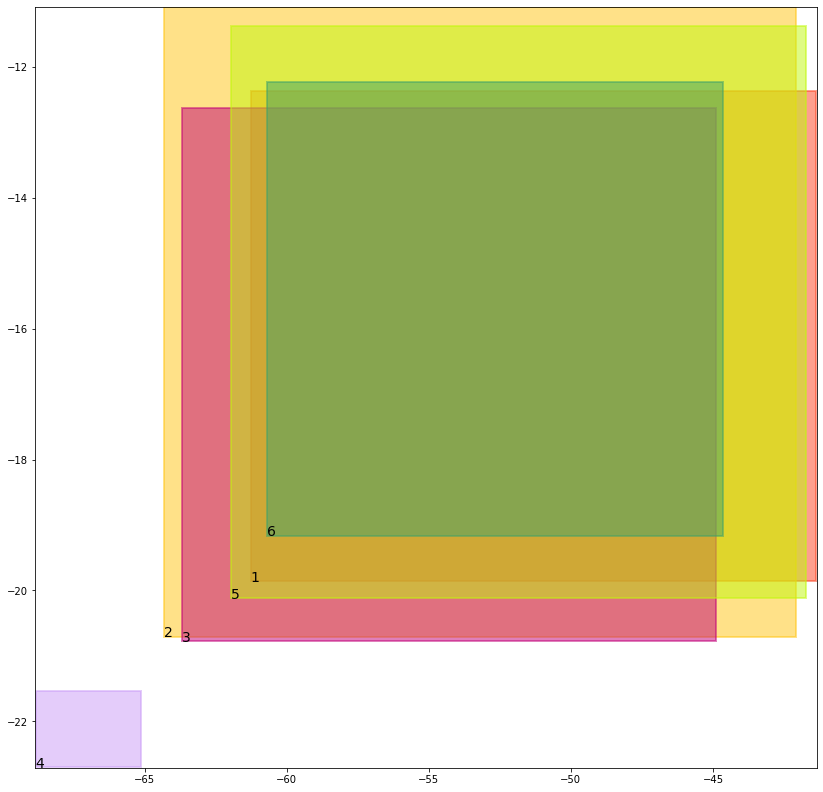

alignment data:
tensor(1) 0.5391635298728943 0.5027598738670349 tensor(0.8580120801925659) tensor(0.8388589620590210)
tensor(2) 0.3024996221065521 0.9600082635879517 tensor(0.8575149774551392) tensor(0.9749574661254883)
tensor(3) 0.4176068902015686 0.8719088435173035 tensor(0.9013383388519287) tensor(0.8736711740493774)
tensor(4) 0.9849182963371277 0.7956694960594177 tensor(0.9858272075653076) tensor(0.9622203111648560)
tensor(5) 0.3592974543571472 0.8338826298713684 tensor(0.8702569007873535) tensor(0.8488784432411194)
tensor(6) 0.36490491032600403 0.9567599296569824 tensor(0.7633676528930664) tensor(0.9702478647232056)


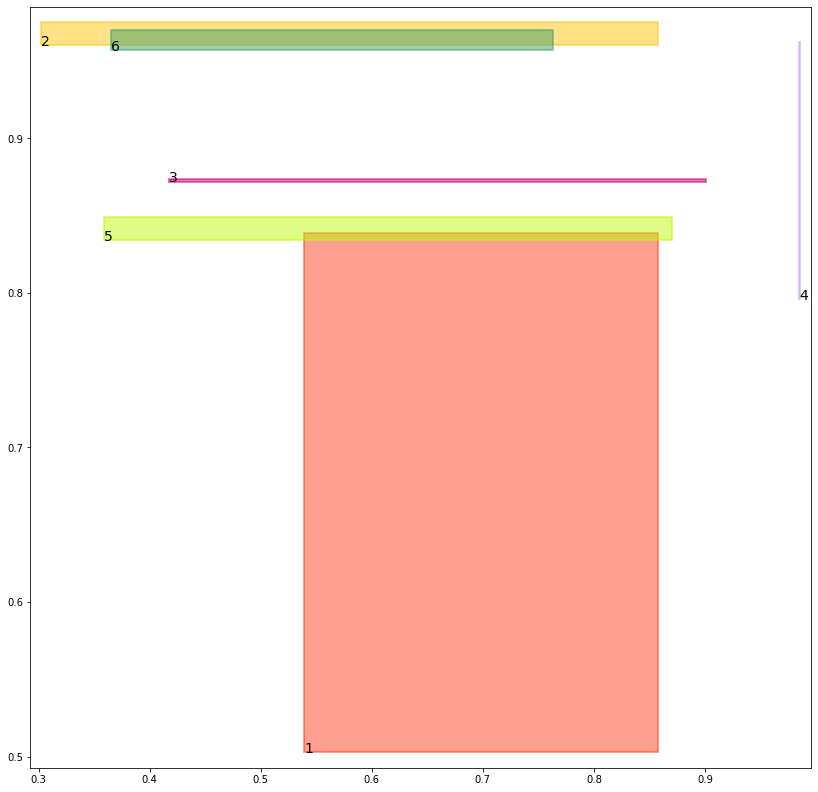

batch (tensor([[1, 3],
        [3, 5],
        [4, 5],
        [2, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -62.86331558227539 -20.552825927734375 tensor(-42.4451675415039062) tensor(-12.8549728393554688)
tensor(2) -65.1856689453125 -21.087400436401367 tensor(-42.5915527343750000) tensor(-11.2598495483398438)
tensor(3) -65.28535461425781 -21.474075317382812 tensor(-46.7853240966796875) tensor(-13.4334850311279297)
tensor(4) -70.53309631347656 -23.43944549560547 tensor(-66.6201248168945312) tensor(-22.2037658691406250)
tensor(5) -63.549468994140625 -20.81179428100586 tensor(-42.0227966308593750) tensor(-11.4685745239257812)
tensor(6) -62.96605682373047 -20.144813537597656 tensor(-46.6492233276367188) tensor(-13.0653247833251953)


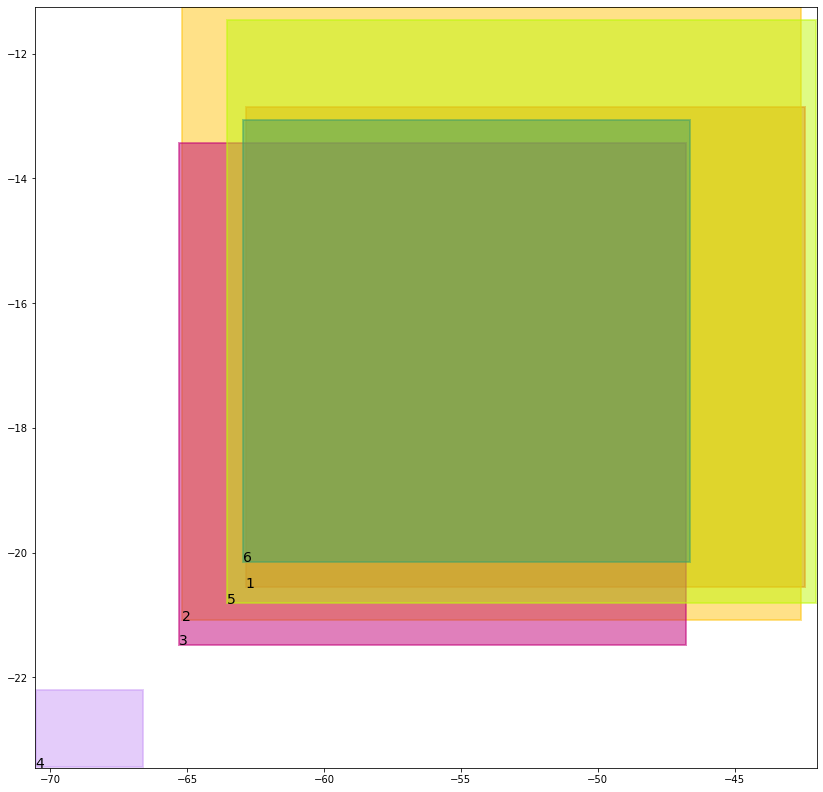

alignment data:
tensor(1) 0.5427744388580322 0.5010281205177307 tensor(0.8598330616950989) tensor(0.8404136896133423)
tensor(2) 0.28841933608055115 0.9612265825271606 tensor(0.8382953405380249) tensor(0.9759002327919006)
tensor(3) 0.43675434589385986 0.8704915046691895 tensor(0.9008992314338684) tensor(0.8770867586135864)
tensor(4) 0.9844954609870911 0.7935068011283875 tensor(0.9860229492187500) tensor(0.9626780152320862)
tensor(5) 0.3406318128108978 0.8363706469535828 tensor(0.8711147308349609) tensor(0.8513833880424500)
tensor(6) 0.3843890428543091 0.9567397236824036 tensor(0.7834870219230652) tensor(0.9705773591995239)


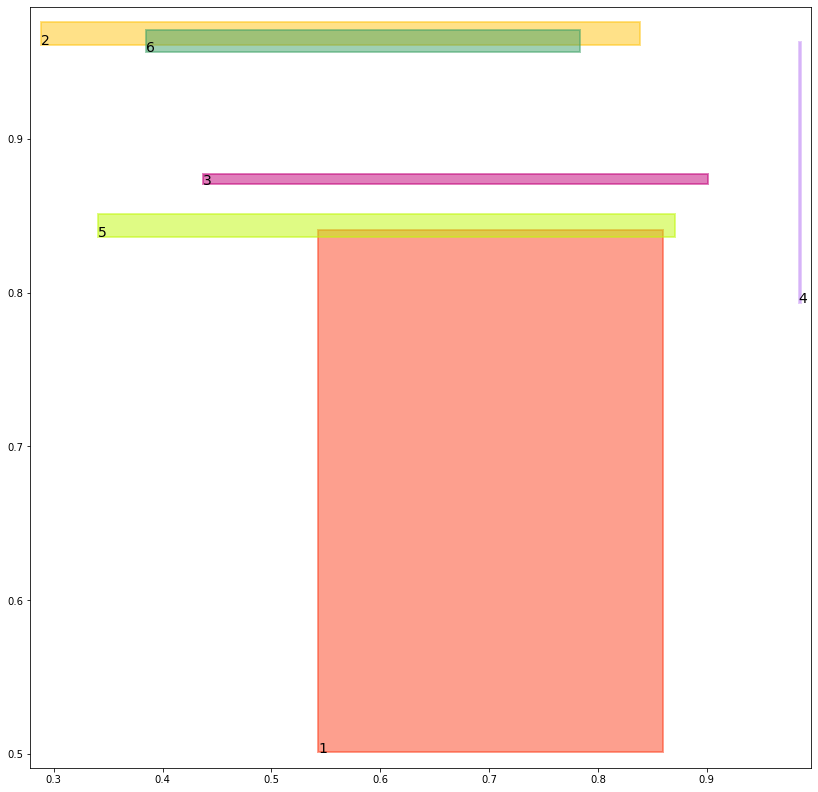

batch (tensor([[6, 2],
        [1, 2],
        [5, 3],
        [4, 6]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -64.33184814453125 -21.195873260498047 tensor(-43.4403533935546875) tensor(-13.3000726699829102)
tensor(2) -65.68550109863281 -21.304092407226562 tensor(-43.4660415649414062) tensor(-11.5936117172241211)
tensor(3) -66.62602996826172 -22.06494903564453 tensor(-48.5588607788085938) tensor(-14.1892261505126953)
tensor(4) -72.09761810302734 -24.123863220214844 tensor(-68.0093917846679688) tensor(-22.8268699645996094)
tensor(5) -65.21634674072266 -21.528003692626953 tensor(-42.3009567260742188) tensor(-11.5397539138793945)
tensor(6) -65.23223876953125 -21.12335777282715 tensor(-47.7225074768066406) tensor(-13.4997968673706055)


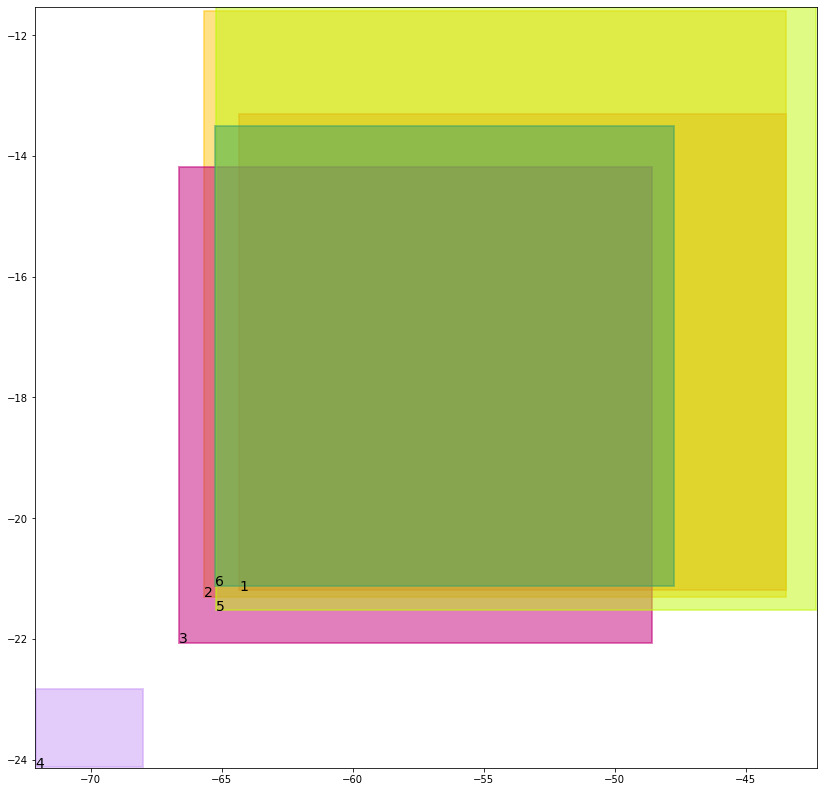

alignment data:
tensor(1) 0.5460591912269592 0.4994509220123291 tensor(0.8614743947982788) tensor(0.8418190479278564)
tensor(2) 0.2851271629333496 0.9624357223510742 tensor(0.8138996362686157) tensor(0.9761756062507629)
tensor(3) 0.45473960041999817 0.8692818284034729 tensor(0.8983600139617920) tensor(0.8776735663414001)
tensor(4) 0.9841001033782959 0.7915225028991699 tensor(0.9861989021301270) tensor(0.9630901813507080)
tensor(5) 0.3240504264831543 0.8386104702949524 tensor(0.8751927614212036) tensor(0.8564624786376953)
tensor(6) 0.3845064342021942 0.9567211866378784 tensor(0.8050634860992432) tensor(0.9716203808784485)


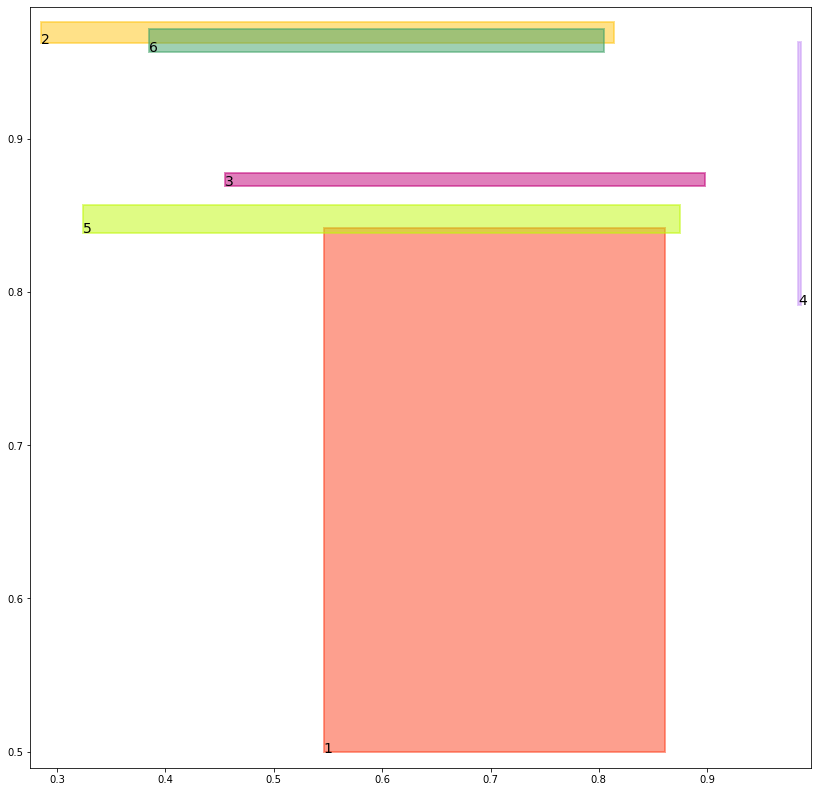

batch (tensor([[1, 3],
        [5, 3],
        [6, 2],
        [2, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -65.68487548828125 -21.789928436279297 tensor(-44.3571929931640625) tensor(-13.7117185592651367)
tensor(2) -65.803955078125 -21.354652404785156 tensor(-44.4917678833007812) tensor(-12.0055160522460938)
tensor(3) -67.75770568847656 -22.57119369506836 tensor(-50.2213592529296875) tensor(-14.9015626907348633)
tensor(4) -73.544921875 -24.75872802734375 tensor(-69.2846298217773438) tensor(-23.4005088806152344)
tensor(5) -66.87339782714844 -22.23645782470703 tensor(-42.5582046508789062) tensor(-11.6042451858520508)
tensor(6) -67.3943099975586 -22.05958366394043 tensor(-48.3162689208984375) tensor(-13.7238683700561523)


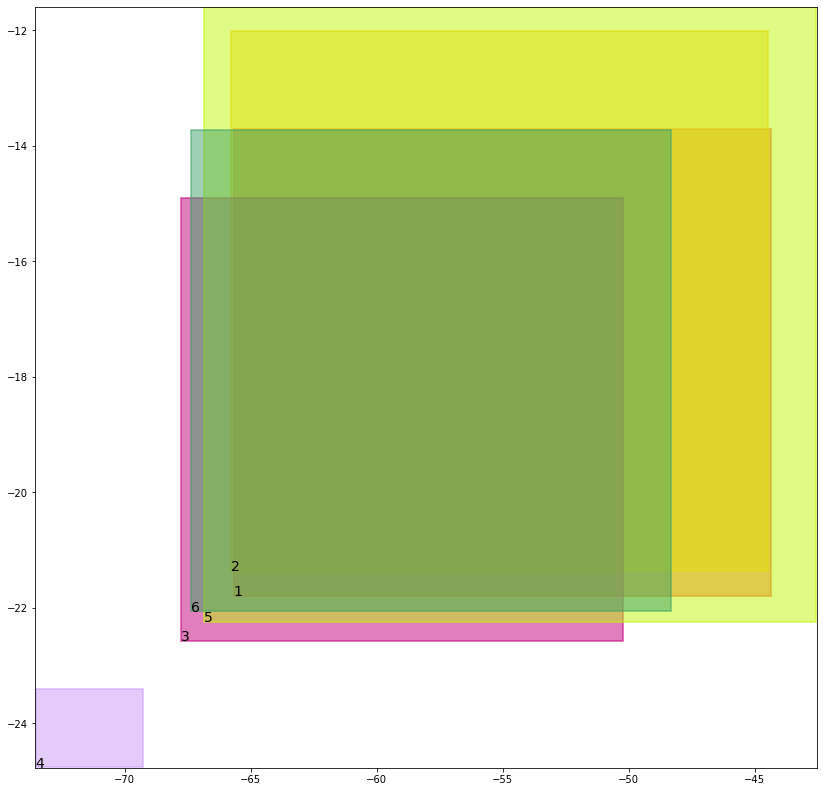

alignment data:
tensor(1) 0.5490477085113525 0.49801433086395264 tensor(0.8629554510116577) tensor(0.8430904150009155)
tensor(2) 0.28758883476257324 0.9627450108528137 tensor(0.7838681340217590) tensor(0.9760710000991821)
tensor(3) 0.47143691778182983 0.8682218790054321 tensor(0.8945150971412659) tensor(0.8766157627105713)
tensor(4) 0.9837315082550049 0.7897028923034668 tensor(0.9863573312759399) tensor(0.9634618759155273)
tensor(5) 0.3093203008174896 0.8406291604042053 tensor(0.8808093070983887) tensor(0.8627055287361145)
tensor(6) 0.37548384070396423 0.957423210144043 tensor(0.8258599638938904) tensor(0.9729930758476257)


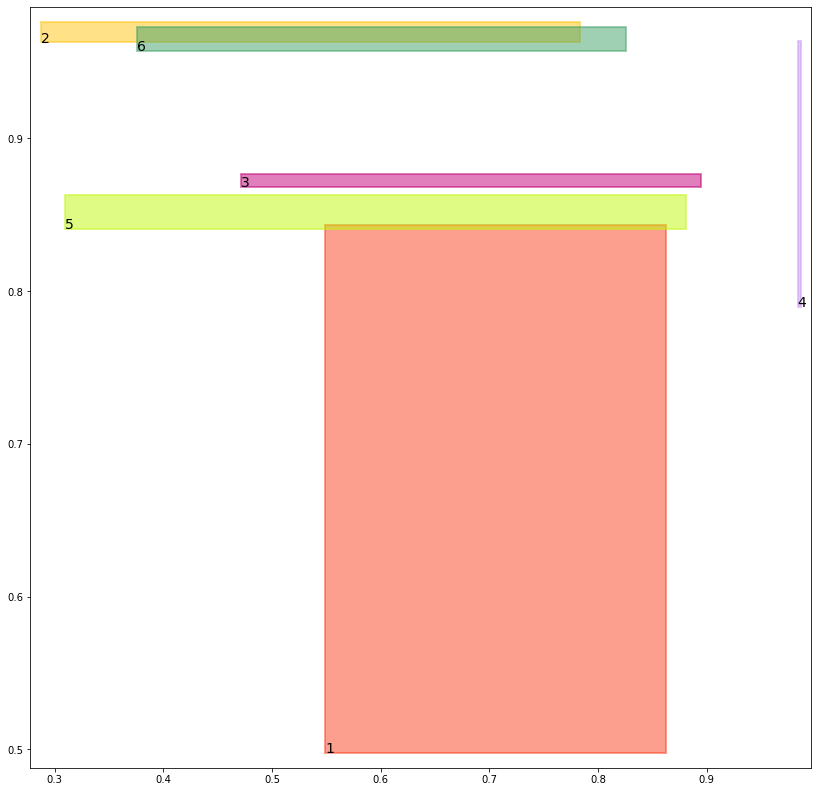

batch (tensor([[4, 5],
        [4, 6],
        [3, 5],
        [1, 2]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -66.9301986694336 -22.338001251220703 tensor(-45.2010154724121094) tensor(-14.0918827056884766)
tensor(2) -65.76863861083984 -21.33624267578125 tensor(-45.4379119873046875) tensor(-12.3869380950927734)
tensor(3) -68.7889175415039 -23.033531188964844 tensor(-50.6577377319335938) tensor(-15.0972194671630859)
tensor(4) -74.88178253173828 -25.34659194946289 tensor(-70.4543838500976562) tensor(-23.9280719757080078)
tensor(5) -68.35835266113281 -22.875446319580078 tensor(-43.6989974975585938) tensor(-12.0469493865966797)
tensor(6) -69.33673858642578 -22.90399742126465 tensor(-48.8573570251464844) tensor(-13.9274635314941406)


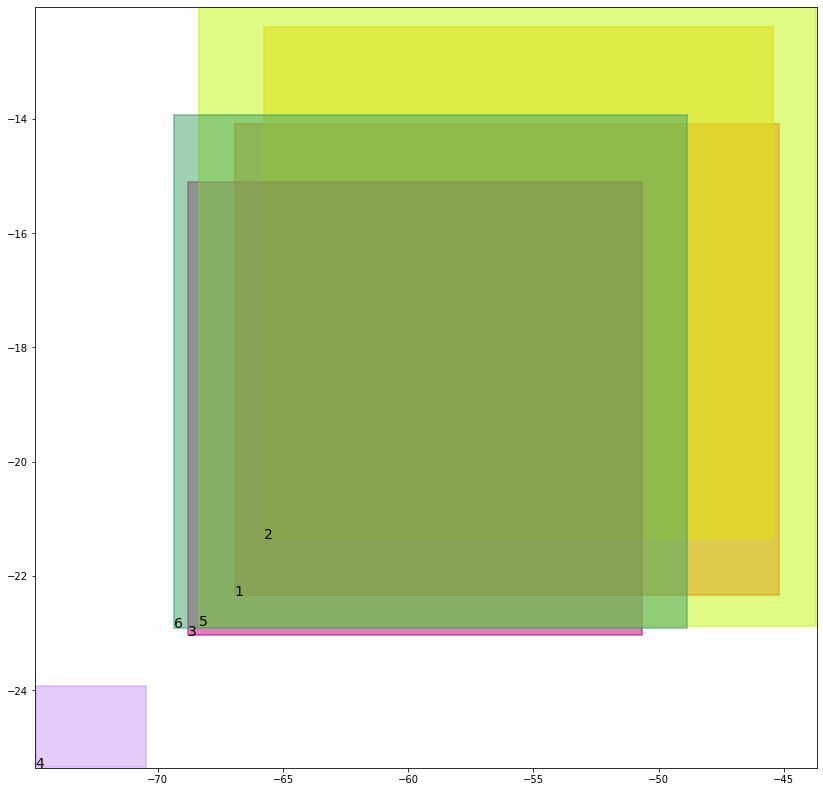

alignment data:
tensor(1) 0.5517671704292297 0.496705561876297 tensor(0.8642930388450623) tensor(0.8442413806915283)
tensor(2) 0.2898424565792084 0.9630244970321655 tensor(0.7535826563835144) tensor(0.9759752750396729)
tensor(3) 0.46369847655296326 0.8619125485420227 tensor(0.8909012675285339) tensor(0.8756452798843384)
tensor(4) 0.9833883047103882 0.7880350351333618 tensor(0.9865000844001770) tensor(0.9637972712516785)
tensor(5) 0.3122309446334839 0.8499544262886047 tensor(0.8852409720420837) tensor(0.8675607442855835)
tensor(6) 0.3673385679721832 0.9580532312393188 tensor(0.8432449698448181) tensor(0.9741871953010559)


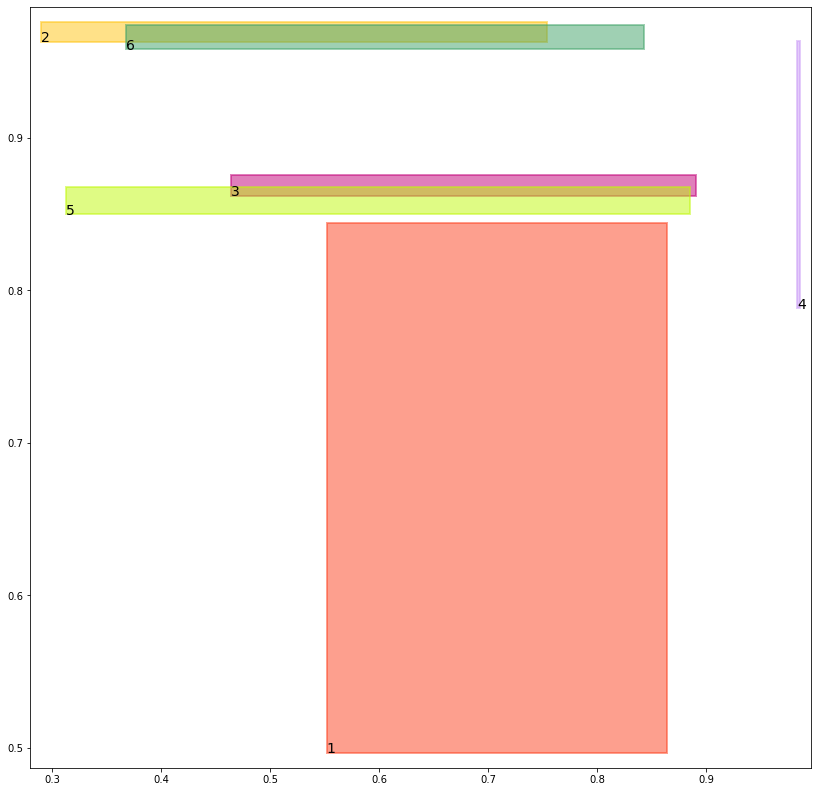

batch (tensor([[3, 5],
        [4, 5],
        [6, 2],
        [1, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -68.07534790039062 -22.84305763244629 tensor(-45.9769096374511719) tensor(-14.4425287246704102)
tensor(2) -65.54569244384766 -21.232833862304688 tensor(-46.6662483215332031) tensor(-12.8983049392700195)
tensor(3) -69.72830200195312 -23.45553970336914 tensor(-50.5998077392578125) tensor(-15.0860385894775391)
tensor(4) -76.11004638671875 -25.887815475463867 tensor(-71.5267105102539062) tensor(-24.4128360748291016)
tensor(5) -69.70665740966797 -23.45813751220703 tensor(-45.1268539428710938) tensor(-12.6178140640258789)
tensor(6) -71.09709930419922 -23.669851303100586 tensor(-48.8458442687988281) tensor(-13.8877801895141602)


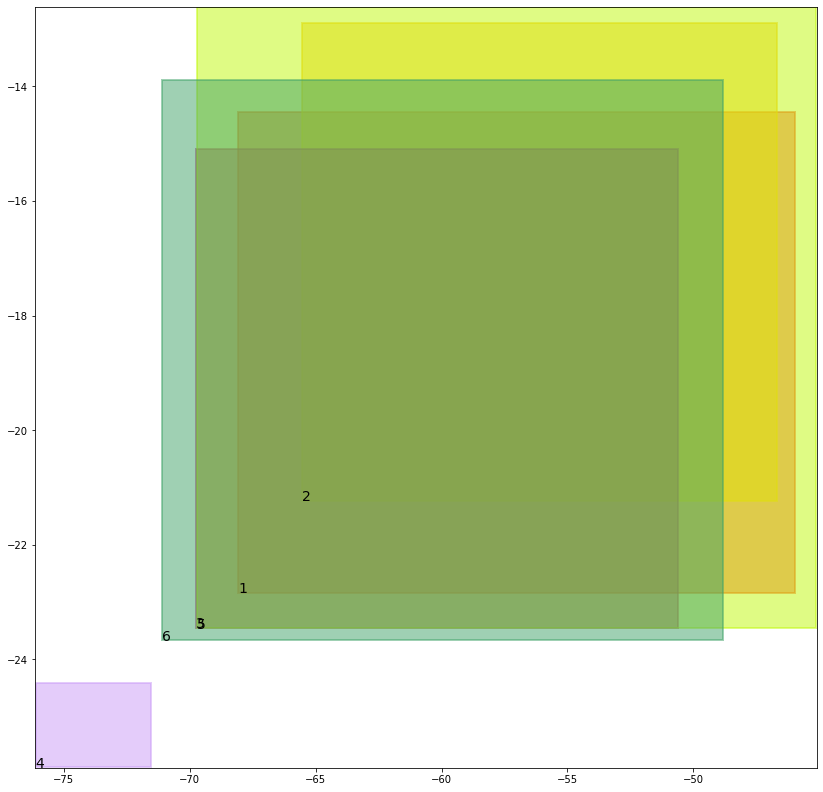

alignment data:
tensor(1) 0.5542421936988831 0.4955131709575653 tensor(0.8655021786689758) tensor(0.8452840447425842)
tensor(2) 0.2995622456073761 0.9633396863937378 tensor(0.7230316400527954) tensor(0.9753665924072266)
tensor(3) 0.44806915521621704 0.8530924320220947 tensor(0.8875145912170410) tensor(0.8747554421424866)
tensor(4) 0.9830695390701294 0.7865071296691895 tensor(0.9866288900375366) tensor(0.9641003012657166)
tensor(5) 0.32151591777801514 0.8611634969711304 tensor(0.8889632225036621) tensor(0.8715927004814148)
tensor(6) 0.3491005301475525 0.9586194753646851 tensor(0.8578293919563293) tensor(0.9757712483406067)


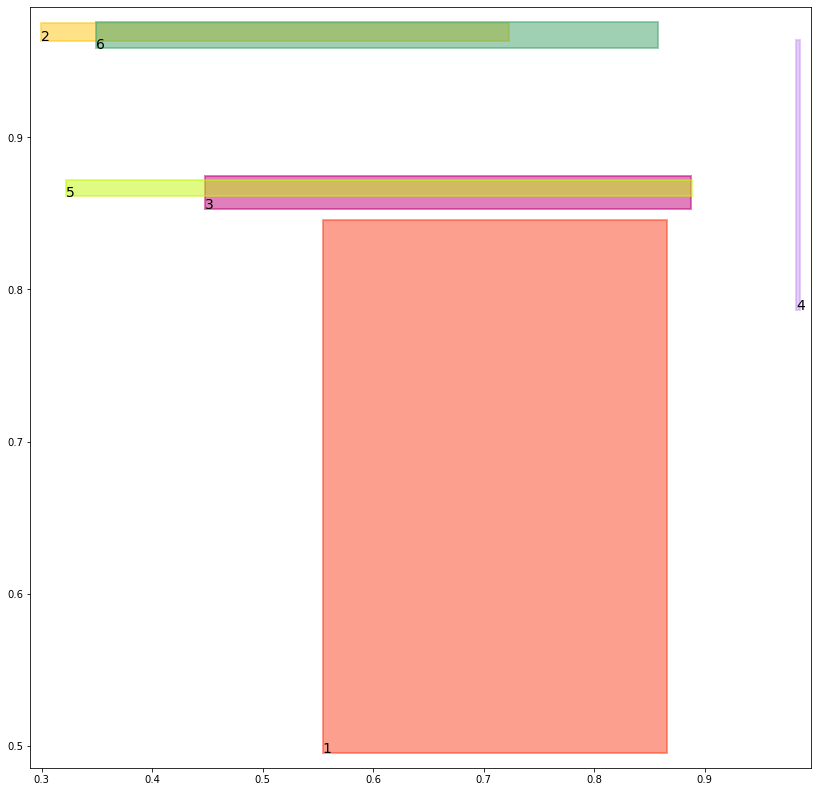

batch (tensor([[1, 3],
        [5, 3],
        [4, 6],
        [2, 6]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -69.12747192382812 -23.307966232299805 tensor(-46.6897354125976562) tensor(-14.7655591964721680)
tensor(2) -66.21321868896484 -21.519006729125977 tensor(-47.7835273742675781) tensor(-13.3665294647216797)
tensor(3) -70.51687622070312 -23.820987701416016 tensor(-50.6176376342773438) tensor(-15.0944423675537109)
tensor(4) -77.23767852783203 -26.385604858398438 tensor(-72.5091094970703125) tensor(-24.8578853607177734)
tensor(5) -71.00202178955078 -24.010921478271484 tensor(-46.3762893676757812) tensor(-13.1235857009887695)
tensor(6) -72.53677368164062 -24.299898147583008 tensor(-48.8954467773437500) tensor(-13.8726072311401367)


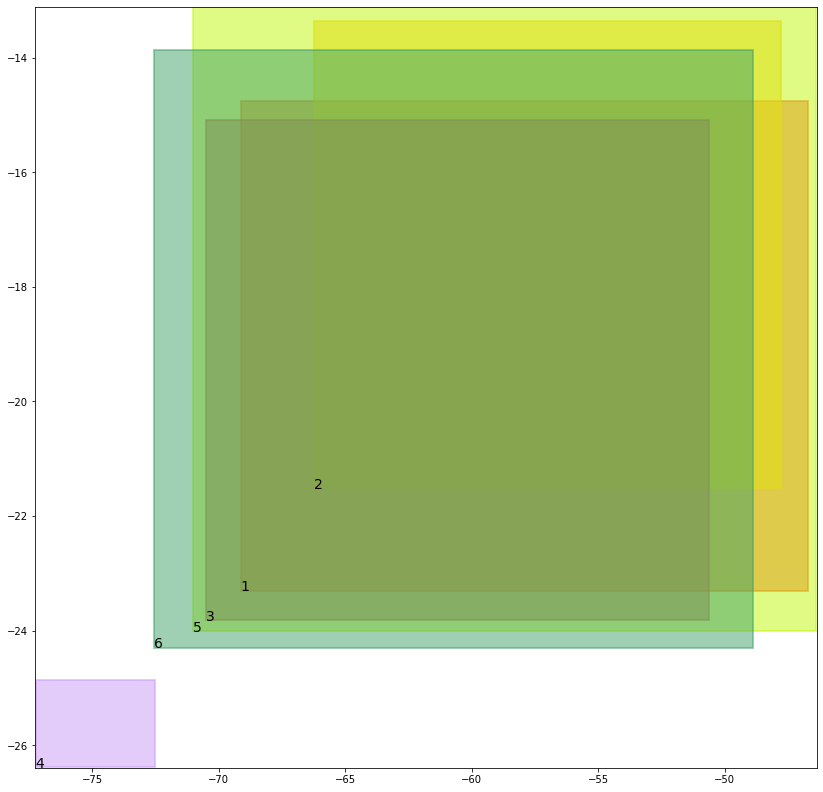

alignment data:
tensor(1) 0.5564948916435242 0.4944268465042114 tensor(0.8665958642959595) tensor(0.8462290167808533)
tensor(2) 0.30857840180397034 0.9624795317649841 tensor(0.7161549329757690) tensor(0.9753226637840271)
tensor(3) 0.4339905083179474 0.8482068777084351 tensor(0.8843267560005188) tensor(0.8714044690132141)
tensor(4) 0.9827737808227539 0.7851079702377319 tensor(0.9867451786994934) tensor(0.9643743038177490)
tensor(5) 0.3301004469394684 0.8678510189056396 tensor(0.8922622203826904) tensor(0.8774215579032898)
tensor(6) 0.3335149884223938 0.9601524472236633 tensor(0.8669903874397278) tensor(0.9765609502792358)


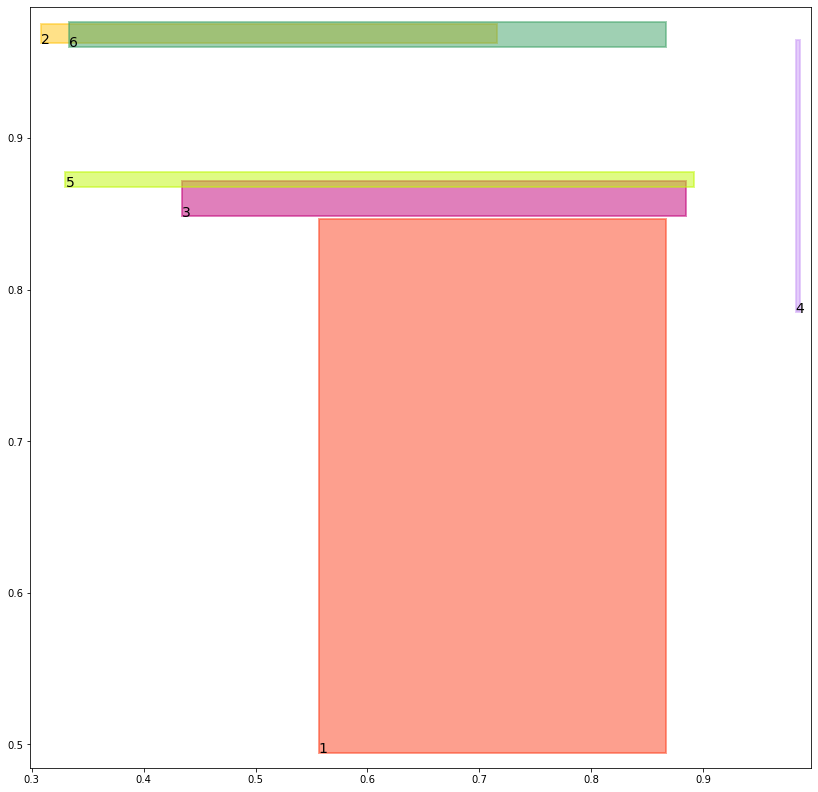

batch (tensor([[1, 3],
        [4, 5],
        [3, 5],
        [6, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -70.09333038330078 -23.735492706298828 tensor(-47.3440895080566406) tensor(-15.0628318786621094)
tensor(2) -66.80956268310547 -21.774518966674805 tensor(-49.1784515380859375) tensor(-13.9632358551025391)
tensor(3) -71.42552947998047 -24.228069305419922 tensor(-50.2731552124023438) tensor(-14.9414348602294922)
tensor(4) -78.27214813232422 -26.843027114868164 tensor(-73.4086380004882812) tensor(-25.2661724090576172)
tensor(5) -72.00910949707031 -24.449079513549805 tensor(-47.8581199645996094) tensor(-13.7361049652099609)
tensor(6) -73.8448715209961 -24.87379264831543 tensor(-48.5303878784179688) tensor(-13.6738691329956055)


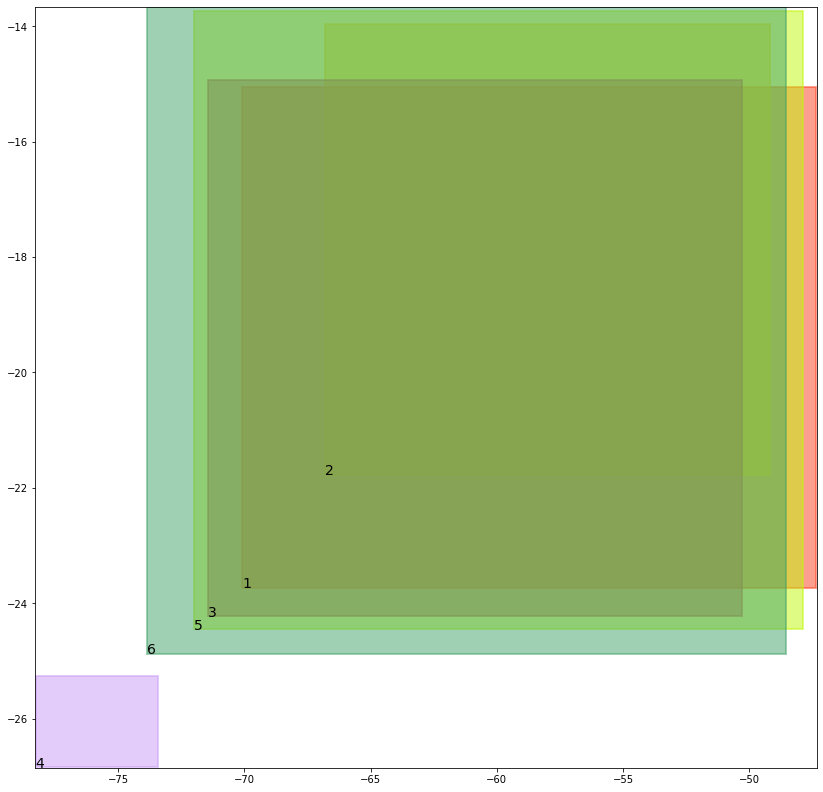

alignment data:
tensor(1) 0.5585453510284424 0.4934370815753937 tensor(0.8675857782363892) tensor(0.8470858931541443)
tensor(2) 0.3244509696960449 0.9616991281509399 tensor(0.7096426486968994) tensor(0.9752741456031799)
tensor(3) 0.4133288860321045 0.8436400890350342 tensor(0.8842906951904297) tensor(0.8709867000579834)
tensor(4) 0.9824998378753662 0.7838274240493774 tensor(0.9868502616882324) tensor(0.9646221399307251)
tensor(5) 0.34471091628074646 0.8739001750946045 tensor(0.8924443721771240) tensor(0.8801336288452148)
tensor(6) 0.3109196424484253 0.9615015983581543 tensor(0.8748973011970520) tensor(0.9772586226463318)


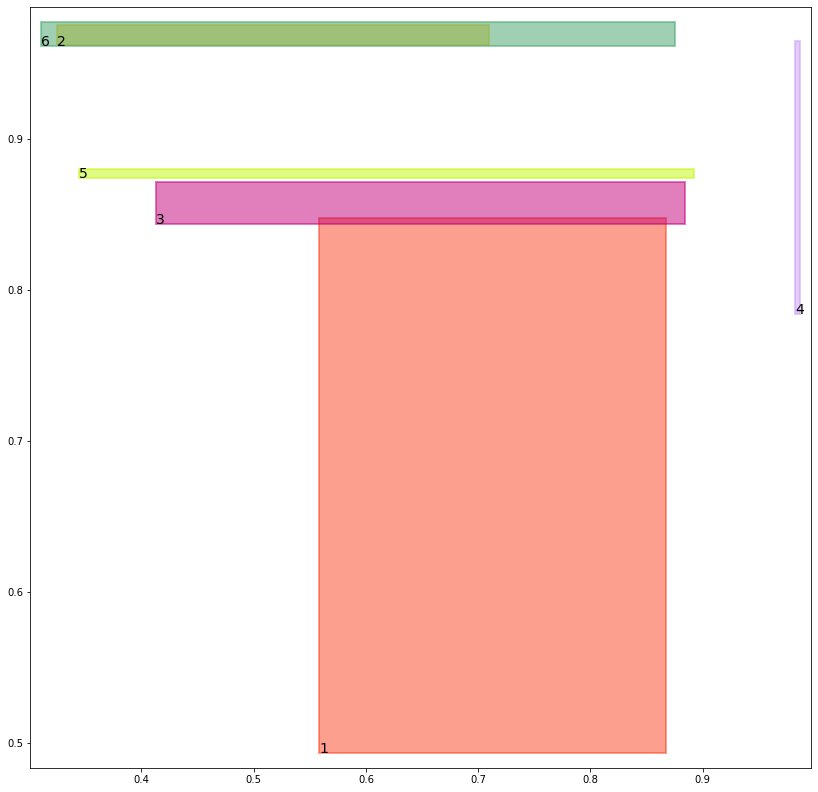

batch (tensor([[1, 2],
        [5, 3],
        [4, 6],
        [2, 6]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -70.97936248779297 -24.128286361694336 tensor(-47.9443168640136719) tensor(-15.3361263275146484)
tensor(2) -67.99735260009766 -22.292984008789062 tensor(-50.0317459106445312) tensor(-14.3264837265014648)
tensor(3) -72.2542495727539 -24.60011863708496 tensor(-50.0456619262695312) tensor(-14.8239679336547852)
tensor(4) -79.22052764892578 -27.263002395629883 tensor(-74.2318496704101562) tensor(-25.6404647827148438)
tensor(5) -72.93265533447266 -24.851537704467773 tensor(-49.1717224121093750) tensor(-14.2903375625610352)
tensor(6) -74.91263580322266 -25.34514808654785 tensor(-48.7574272155761719) tensor(-13.7384233474731445)


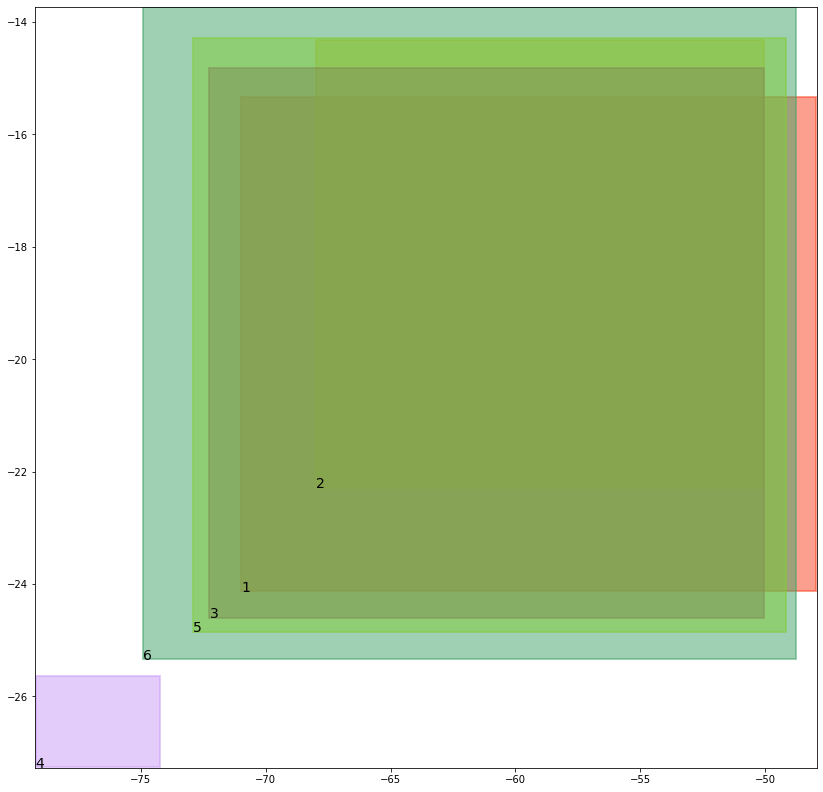

alignment data:
tensor(1) 0.560411810874939 0.4925353527069092 tensor(0.8684822916984558) tensor(0.8478632569313049)
tensor(2) 0.3305147886276245 0.959756076335907 tensor(0.7179160714149475) tensor(0.9757446050643921)
tensor(3) 0.39495009183883667 0.8431645631790161 tensor(0.8841947913169861) tensor(0.8705644011497498)
tensor(4) 0.9822465777397156 0.7826559543609619 tensor(0.9869452118873596) tensor(0.9648464918136597)
tensor(5) 0.3582840859889984 0.8767205476760864 tensor(0.8926100730895996) tensor(0.8825592994689941)
tensor(6) 0.3018668591976166 0.9635793566703796 tensor(0.8792191743850708) tensor(0.9773542284965515)


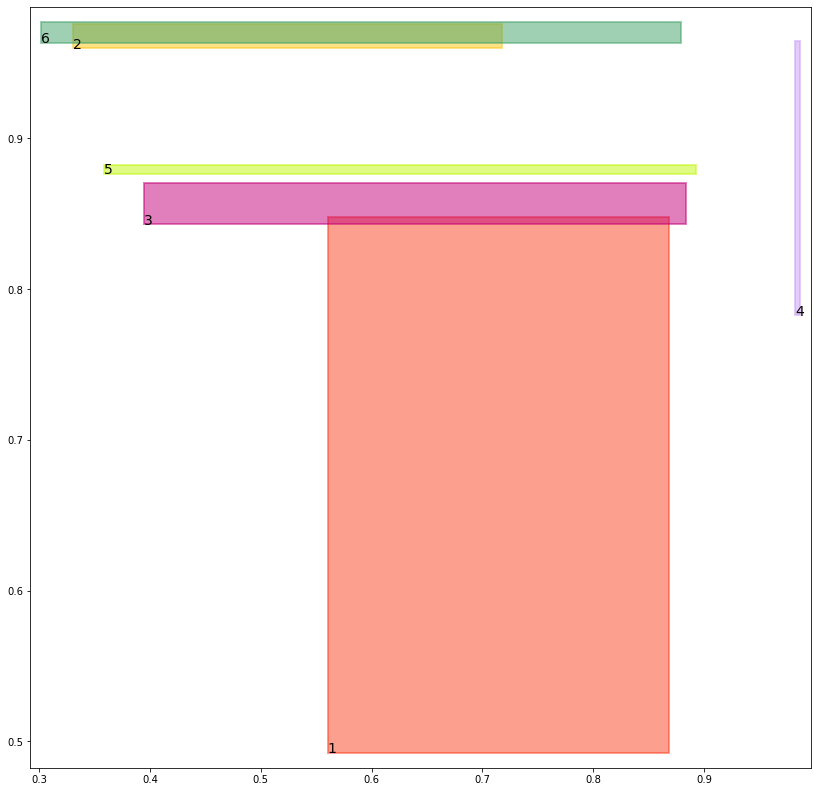

batch (tensor([[1, 2],
        [5, 3],
        [6, 2],
        [3, 5]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -71.79158782958984 -24.488859176635742 tensor(-48.4945220947265625) tensor(-15.5871496200561523)
tensor(2) -69.08356475830078 -22.768163681030273 tensor(-50.8424491882324219) tensor(-14.6695804595947266)
tensor(3) -73.14102935791016 -24.990625381469727 tensor(-49.6084136962890625) tensor(-14.6004514694213867)
tensor(4) -80.08942413330078 -27.64829444885254 tensor(-74.9848556518554688) tensor(-25.9833660125732422)
tensor(5) -73.66259002685547 -25.17533302307129 tensor(-50.5849342346191406) tensor(-14.9006109237670898)
tensor(6) -75.88835906982422 -25.77663230895996 tensor(-48.9513282775878906) tensor(-13.7932662963867188)


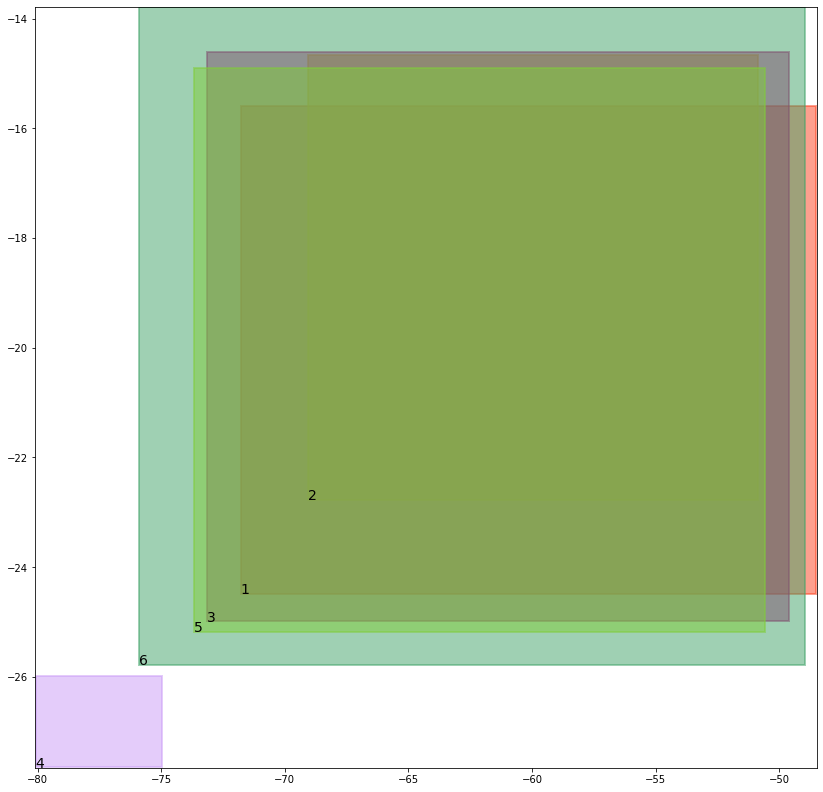

alignment data:
tensor(1) 0.5621108412742615 0.49171391129493713 tensor(0.8692946434020996) tensor(0.8485686182975769)
tensor(2) 0.3361039459705353 0.9588523507118225 tensor(0.7253043651580811) tensor(0.9761649370193481)
tensor(3) 0.37348103523254395 0.8451722860336304 tensor(0.8859669566154480) tensor(0.8719635009765625)
tensor(4) 0.9820127487182617 0.7815845608711243 tensor(0.9870311617851257) tensor(0.9650497436523438)
tensor(5) 0.37564849853515625 0.8777047395706177 tensor(0.8909676074981689) tensor(0.8832698464393616)
tensor(6) 0.29375091195106506 0.9648721218109131 tensor(0.8830440044403076) tensor(0.9774410128593445)


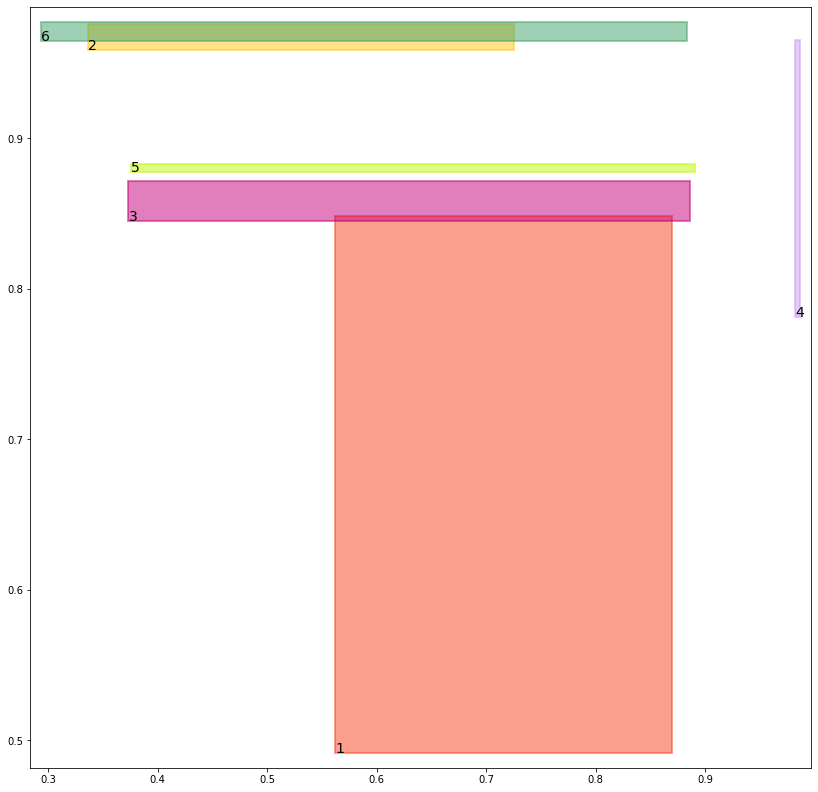

batch (tensor([[2, 6],
        [4, 5],
        [1, 3],
        [4, 6]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -72.53565979003906 -24.819591522216797 tensor(-48.9985351562500000) tensor(-15.8175191879272461)
tensor(2) -70.7406234741211 -23.49579620361328 tensor(-50.8650207519531250) tensor(-14.6602525711059570)
tensor(3) -73.95521545410156 -25.34968376159668 tensor(-49.2170410156250000) tensor(-14.3984174728393555)
tensor(4) -80.8850326538086 -28.001506805419922 tensor(-75.6733093261718750) tensor(-26.2973136901855469)
tensor(5) -74.33143615722656 -25.47235870361328 tensor(-51.9029693603515625) tensor(-15.4718875885009766)
tensor(6) -76.5599365234375 -26.07817840576172 tensor(-49.9222335815429688) tensor(-14.1999387741088867)


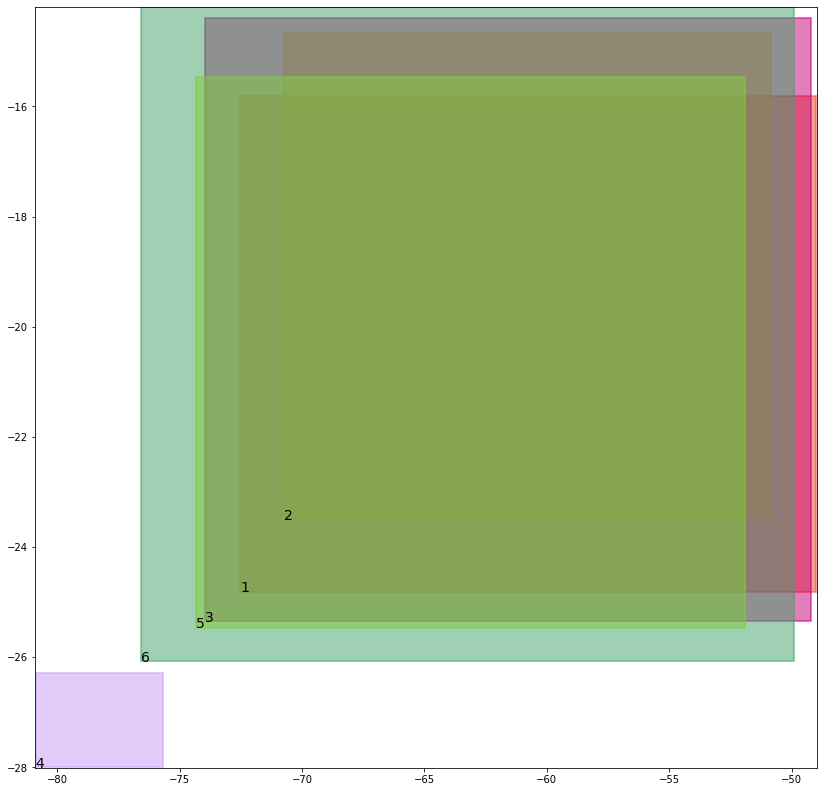

alignment data:
tensor(1) 0.5636574029922485 0.4909655451774597 tensor(0.8700309395790100) tensor(0.8492088317871094)
tensor(2) 0.3264240026473999 0.9580121040344238 tensor(0.7463855147361755) tensor(0.9774182438850403)
tensor(3) 0.3543446362018585 0.8469831347465515 tensor(0.8875608444213867) tensor(0.8732268810272217)
tensor(4) 0.9817970991134644 0.7806051969528198 tensor(0.9871089458465576) tensor(0.9652339816093445)
tensor(5) 0.39175230264663696 0.8785954713821411 tensor(0.8894520998001099) tensor(0.8839139938354492)
tensor(6) 0.3025861382484436 0.9662026166915894 tensor(0.8819798231124878) tensor(0.9765175580978394)


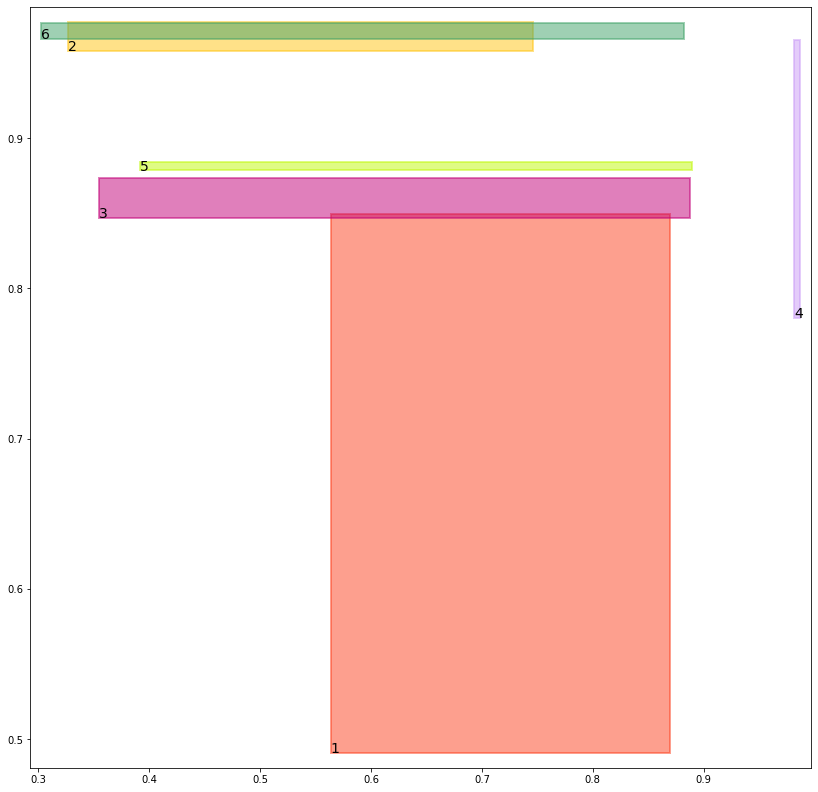

batch (tensor([[3, 5],
        [5, 3],
        [4, 6],
        [1, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -73.2168960571289 -25.122730255126953 tensor(-49.4599494934082031) tensor(-16.0287685394287109)
tensor(2) -72.19698333740234 -24.13380241394043 tensor(-50.8860626220703125) tensor(-14.6515426635742188)
tensor(3) -74.88822174072266 -25.751895904541016 tensor(-49.3758659362792969) tensor(-14.4304304122924805)
tensor(4) -81.61311340332031 -28.325092315673828 tensor(-76.3024902343750000) tensor(-26.5845947265625000)
tensor(5) -74.7629623413086 -25.673194885253906 tensor(-52.6579589843750000) tensor(-15.8027429580688477)
tensor(6) -77.1722640991211 -26.353565216064453 tensor(-50.8211593627929688) tensor(-14.5778179168701172)


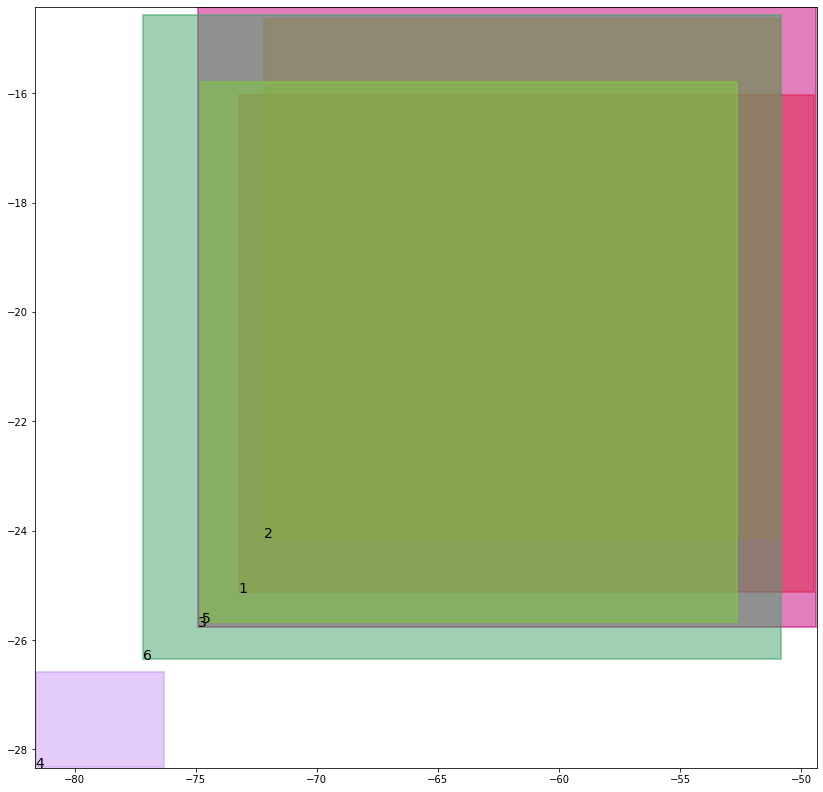

alignment data:
tensor(1) 0.5650651454925537 0.49028387665748596 tensor(0.8706985712051392) tensor(0.8497900962829590)
tensor(2) 0.3177328109741211 0.9572324752807617 tensor(0.7646355032920837) tensor(0.9785037636756897)
tensor(3) 0.34565469622612 0.8521125316619873 tensor(0.8915375471115112) tensor(0.8768545389175415)
tensor(4) 0.9815984964370728 0.7797104120254517 tensor(0.9871794581413269) tensor(0.9654009342193604)
tensor(5) 0.3984016478061676 0.8770422339439392 tensor(0.8852790594100952) tensor(0.8823647499084473)
tensor(6) 0.3107638955116272 0.9673722386360168 tensor(0.8810031414031982) tensor(0.9756444096565247)


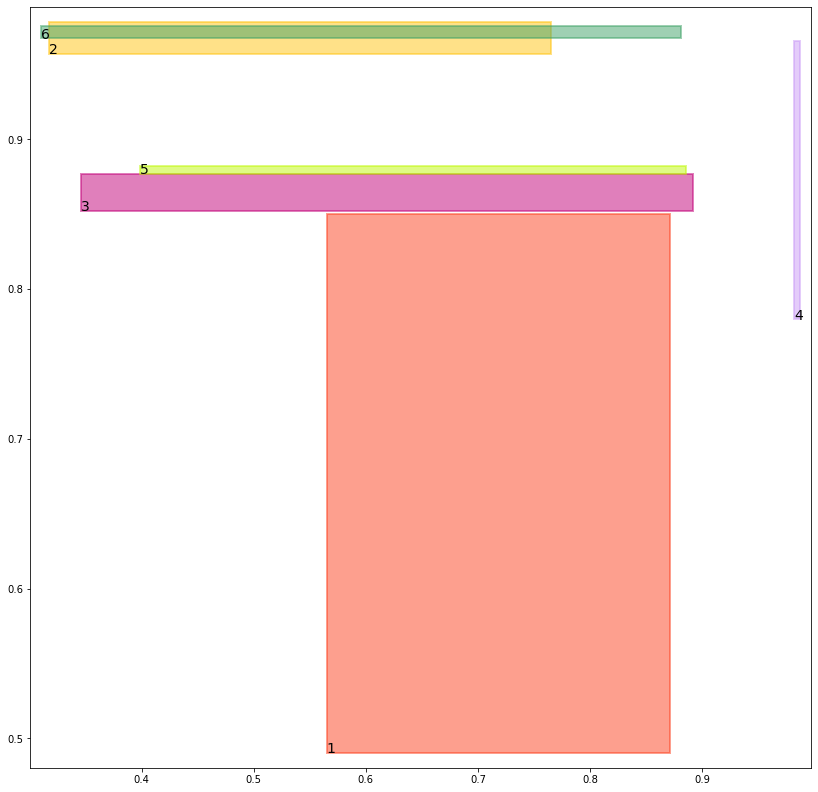

batch (tensor([[2, 6],
        [6, 2],
        [1, 3],
        [4, 5]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -73.8423080444336 -25.40135955810547 tensor(-49.8821411132812500) tensor(-16.2223434448242188)
tensor(2) -73.7370376586914 -24.812759399414062 tensor(-50.6390838623046875) tensor(-14.5160255432128906)
tensor(3) -75.73786926269531 -26.118793487548828 tensor(-49.5201911926269531) tensor(-14.4592781066894531)
tensor(4) -82.279052734375 -28.621353149414062 tensor(-76.8772354125976562) tensor(-26.8473281860351562)
tensor(5) -75.1493148803711 -25.85336685180664 tensor(-53.3521156311035156) tensor(-16.1077575683593750)
tensor(6) -77.64762878417969 -26.566082000732422 tensor(-51.9992256164550781) tensor(-15.0878677368164062)


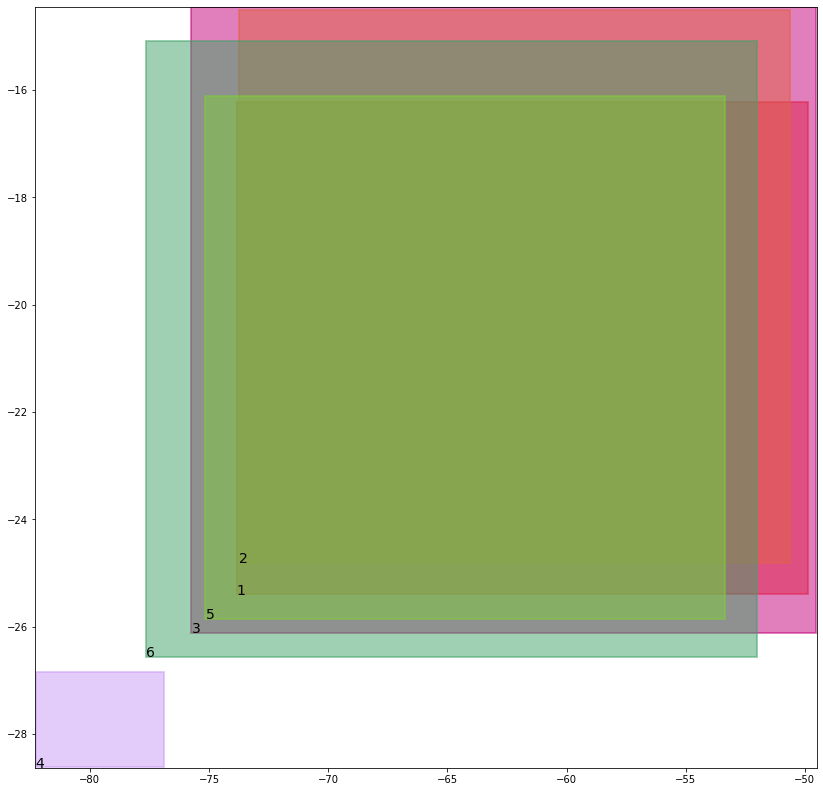

alignment data:
tensor(1) 0.5663465261459351 0.48966294527053833 tensor(0.8713041543960571) tensor(0.8503179550170898)
tensor(2) 0.30367350578308105 0.9580700993537903 tensor(0.7861111760139465) tensor(0.9790486097335815)
tensor(3) 0.3378278613090515 0.8566602468490601 tensor(0.8950517773628235) tensor(0.8800809979438782)
tensor(4) 0.9814156293869019 0.778892993927002 tensor(0.9872433543205261) tensor(0.9655522704124451)
tensor(5) 0.4044910967350006 0.8756125569343567 tensor(0.8813593387603760) tensor(0.8809379935264587)
tensor(6) 0.32565781474113464 0.9677974581718445 tensor(0.8778927326202393) tensor(0.9753243923187256)


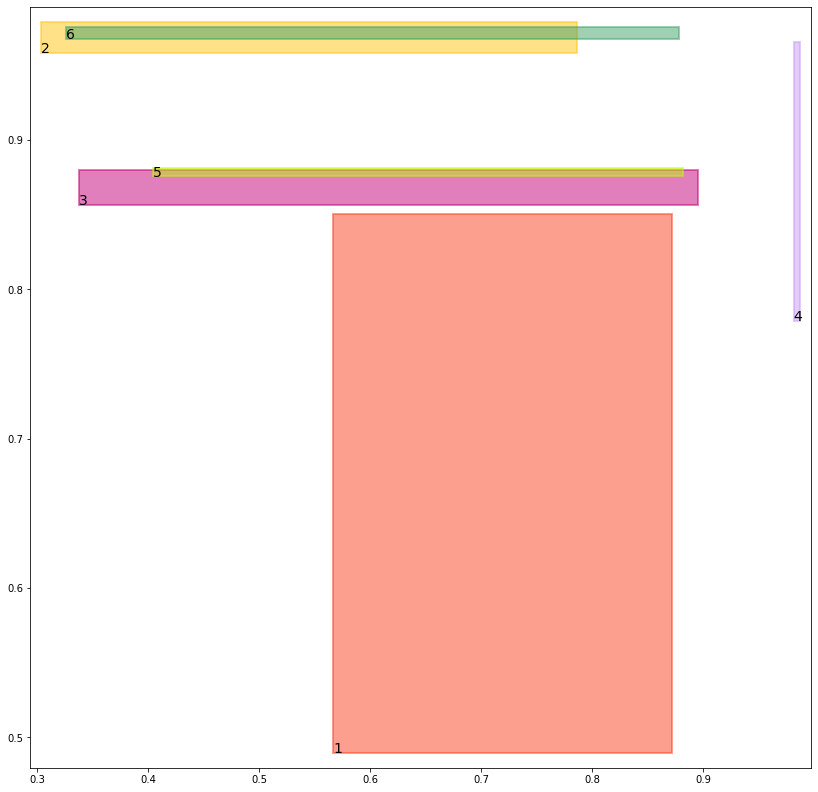

batch (tensor([[5, 3],
        [1, 2],
        [2, 6],
        [4, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -74.418212890625 -25.658252716064453 tensor(-50.2682228088378906) tensor(-16.3996047973632812)
tensor(2) -75.3038101196289 -25.505325317382812 tensor(-50.4226531982421875) tensor(-14.3957347869873047)
tensor(3) -76.39165496826172 -26.40065574645996 tensor(-50.1165161132812500) tensor(-14.6821422576904297)
tensor(4) -82.88785552978516 -28.892436981201172 tensor(-77.4020767211914062) tensor(-27.0874900817871094)
tensor(5) -75.64073944091797 -26.07978057861328 tensor(-53.5240592956542969) tensor(-16.1888294219970703)
tensor(6) -77.97620391845703 -26.713462829589844 tensor(-53.1132125854492188) tensor(-15.5718011856079102)


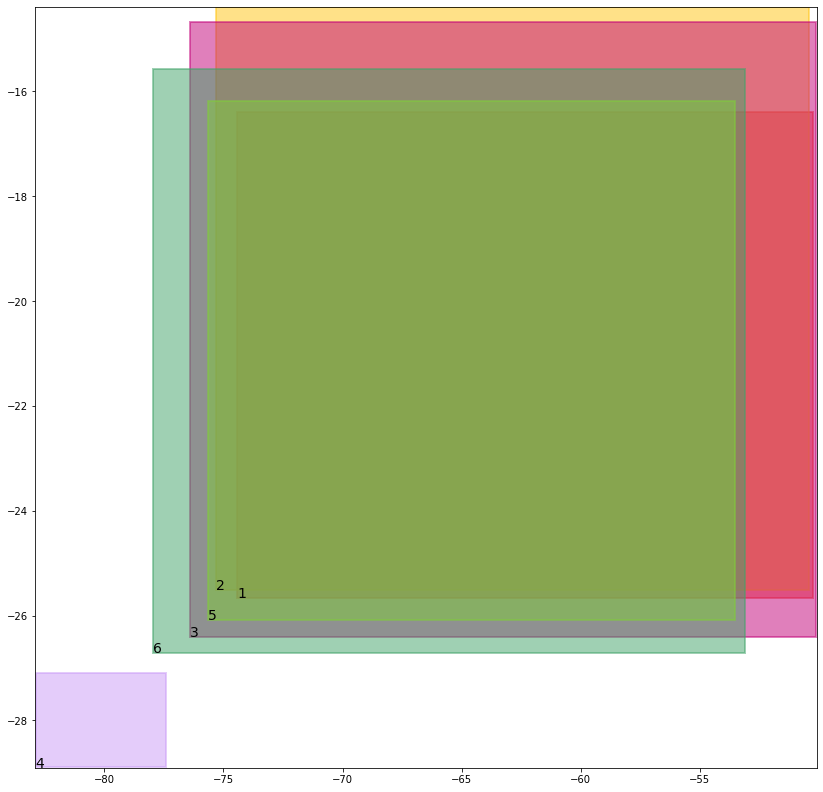

alignment data:
tensor(1) 0.5675127506256104 0.48909756541252136 tensor(0.8718536496162415) tensor(0.8507974743843079)
tensor(2) 0.2911796271800995 0.9588193893432617 tensor(0.8090915679931641) tensor(0.9795330166816711)
tensor(3) 0.33836841583251953 0.8637726306915283 tensor(0.8955976963043213) tensor(0.8828052282333374)
tensor(4) 0.98124760389328 0.7781466841697693 tensor(0.9873013496398926) tensor(0.9656896591186523)
tensor(5) 0.40212124586105347 0.8718262910842896 tensor(0.8809162974357605) tensor(0.8796256184577942)
tensor(6) 0.33981236815452576 0.9682190418243408 tensor(0.8727087974548340) tensor(0.9749960899353027)


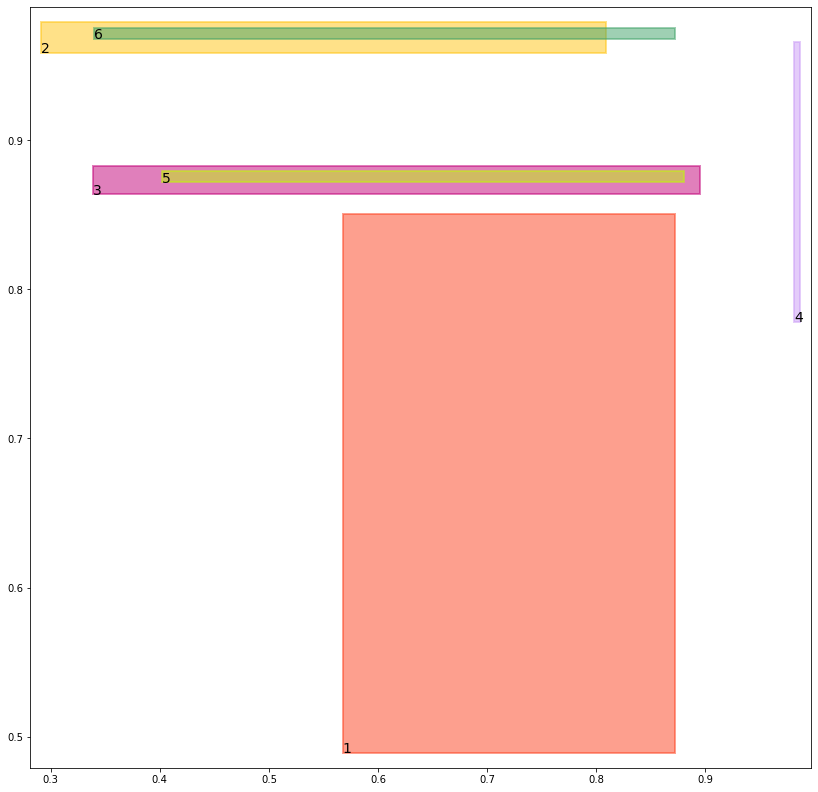

batch (tensor([[4, 5],
        [3, 5],
        [1, 3],
        [6, 2]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -74.94467163085938 -25.893281936645508 tensor(-50.6211013793945312) tensor(-16.5618190765380859)
tensor(2) -76.6518783569336 -26.103729248046875 tensor(-50.5979385375976562) tensor(-14.4482107162475586)
tensor(3) -76.98877716064453 -26.658416748046875 tensor(-50.6568946838378906) tensor(-14.8848619461059570)
tensor(4) -83.44414520263672 -29.14033317565918 tensor(-77.8811416625976562) tensor(-27.3069210052490234)
tensor(5) -76.08870697021484 -26.286455154418945 tensor(-53.6765708923339844) tensor(-16.2613353729248047)
tensor(6) -78.2833251953125 -26.848773956298828 tensor(-53.7069740295410156) tensor(-15.8255662918090820)


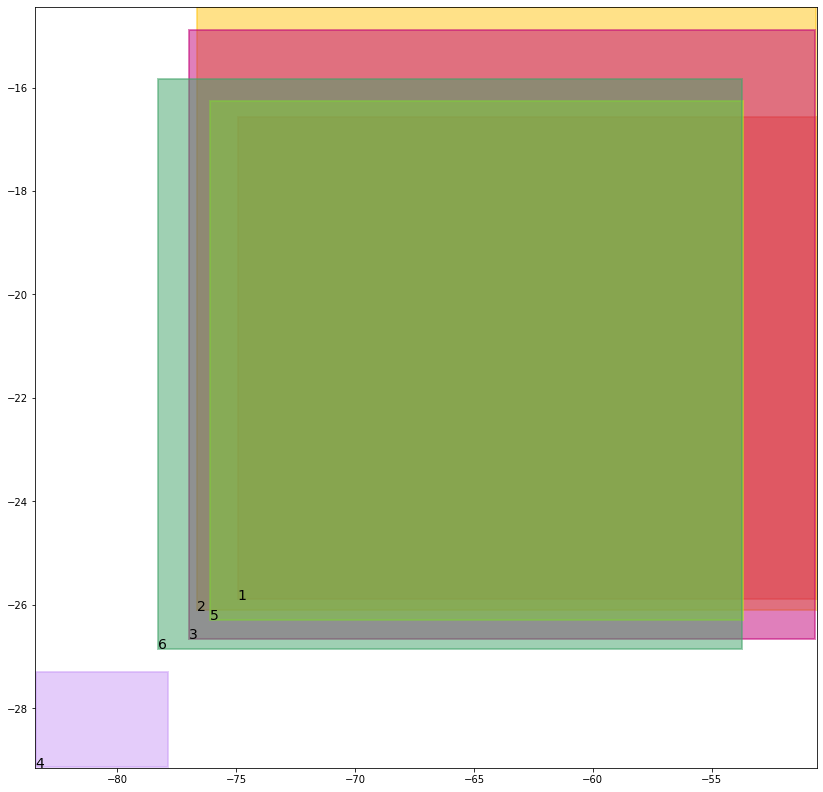

alignment data:
tensor(1) 0.5685741305351257 0.4885826110839844 tensor(0.8723522424697876) tensor(0.8512329459190369)
tensor(2) 0.2865603566169739 0.9608640074729919 tensor(0.8281996250152588) tensor(0.9795780777931213)
tensor(3) 0.33886104822158813 0.8699886202812195 tensor(0.8960928320884705) tensor(0.8852393627166748)
tensor(4) 0.9810932278633118 0.7774655222892761 tensor(0.9873538613319397) tensor(0.9658142924308777)
tensor(5) 0.39996716380119324 0.8682932257652283 tensor(0.8805116415023804) tensor(0.8784196376800537)
tensor(6) 0.34450459480285645 0.9679526686668396 tensor(0.8678255081176758) tensor(0.9752599596977234)


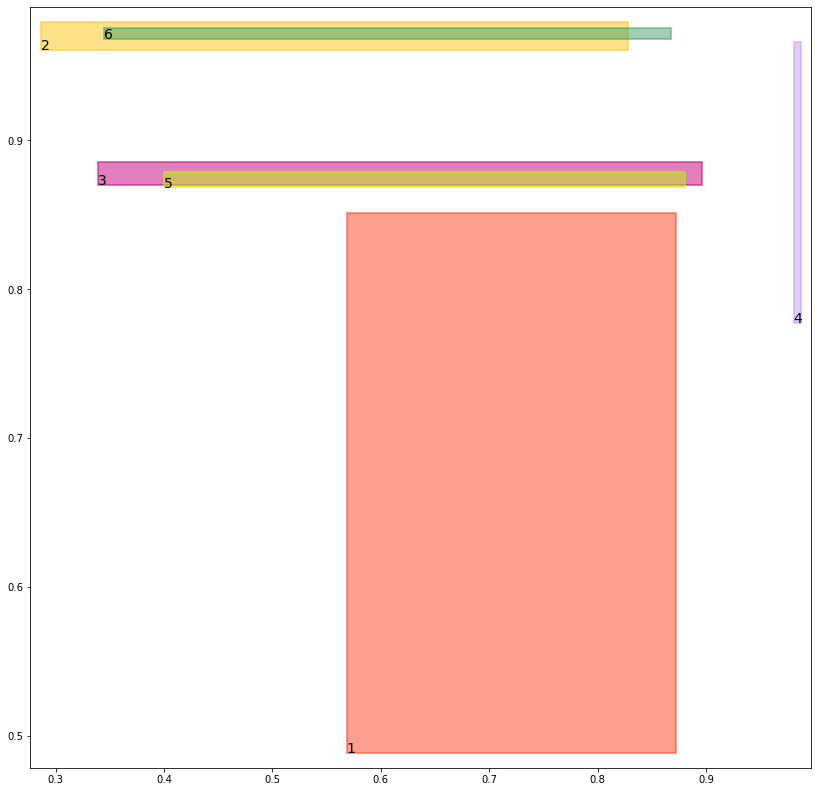

batch (tensor([[2, 6],
        [1, 2],
        [4, 5],
        [6, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -75.42568969726562 -26.108196258544922 tensor(-50.9434890747070312) tensor(-16.7101783752441406)
tensor(2) -77.96624755859375 -26.68987274169922 tensor(-51.1007347106933594) tensor(-14.6466398239135742)
tensor(3) -77.53389739990234 -26.89400863647461 tensor(-51.1467285156250000) tensor(-15.0692491531372070)
tensor(4) -83.9522476196289 -29.36691665649414 tensor(-78.3182907104492188) tensor(-27.5073165893554688)
tensor(5) -76.49699401855469 -26.47503662109375 tensor(-53.8119812011718750) tensor(-16.3262252807617188)
tensor(6) -78.45508575439453 -26.921607971191406 tensor(-53.8405227661132812) tensor(-15.8751497268676758)


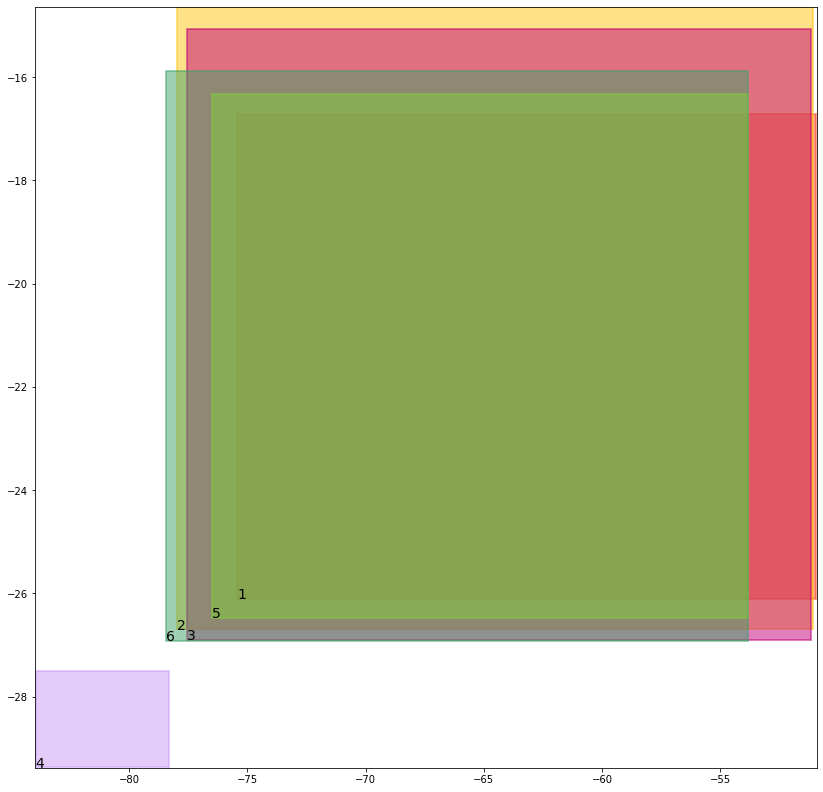

alignment data:
tensor(1) 0.5695400238037109 0.48811376094818115 tensor(0.8728048801422119) tensor(0.8516286015510559)
tensor(2) 0.2885628342628479 0.9637928605079651 tensor(0.8475794196128845) tensor(0.9792267680168152)
tensor(3) 0.33930984139442444 0.8754372596740723 tensor(0.8965417146682739) tensor(0.8874173760414124)
tensor(4) 0.9809516668319702 0.7768439650535583 tensor(0.9874014258384705) tensor(0.9659273028373718)
tensor(5) 0.3980090618133545 0.8650047183036804 tensor(0.8801420927047729) tensor(0.8773125410079956)
tensor(6) 0.3410114049911499 0.9670613408088684 tensor(0.8606346845626831) tensor(0.9760211706161499)


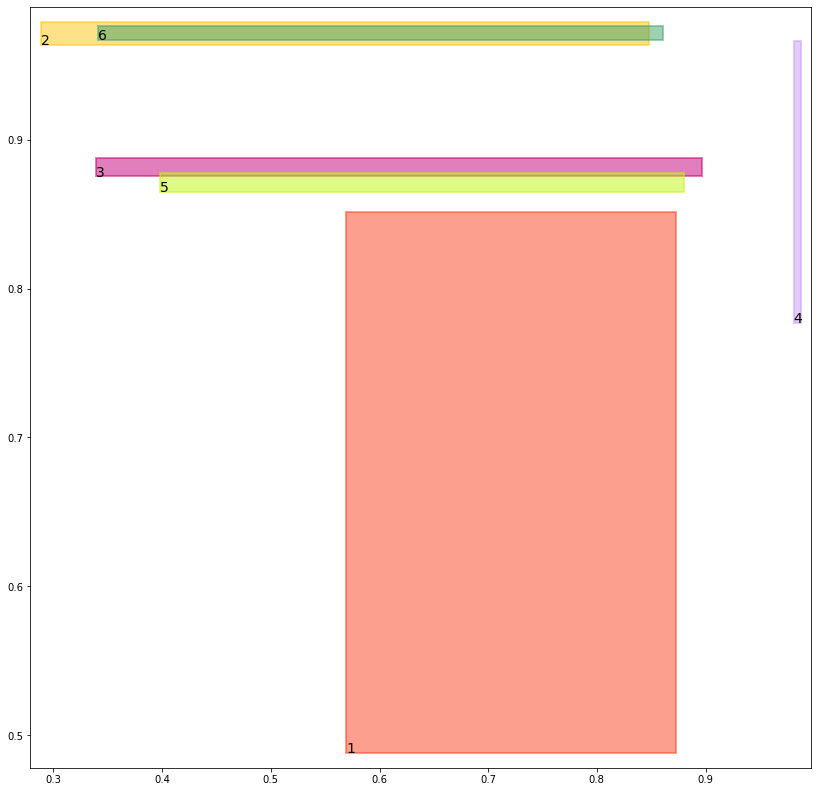

batch (tensor([[5, 3],
        [1, 3],
        [3, 5],
        [4, 6]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -75.86498260498047 -26.30460548400879 tensor(-51.2378807067871094) tensor(-16.8457927703857422)
tensor(2) -79.10041046142578 -27.196434020996094 tensor(-51.5564117431640625) tensor(-14.8272294998168945)
tensor(3) -77.84807586669922 -27.037761688232422 tensor(-51.8958435058593750) tensor(-15.3863306045532227)
tensor(4) -84.4161148071289 -29.573915481567383 tensor(-78.7170333862304688) tensor(-27.6902542114257812)
tensor(5) -77.08039855957031 -26.73099708557129 tensor(-53.6368637084960938) tensor(-16.2365131378173828)
tensor(6) -78.5967025756836 -26.98128318786621 tensor(-53.9611663818359375) tensor(-15.9198904037475586)


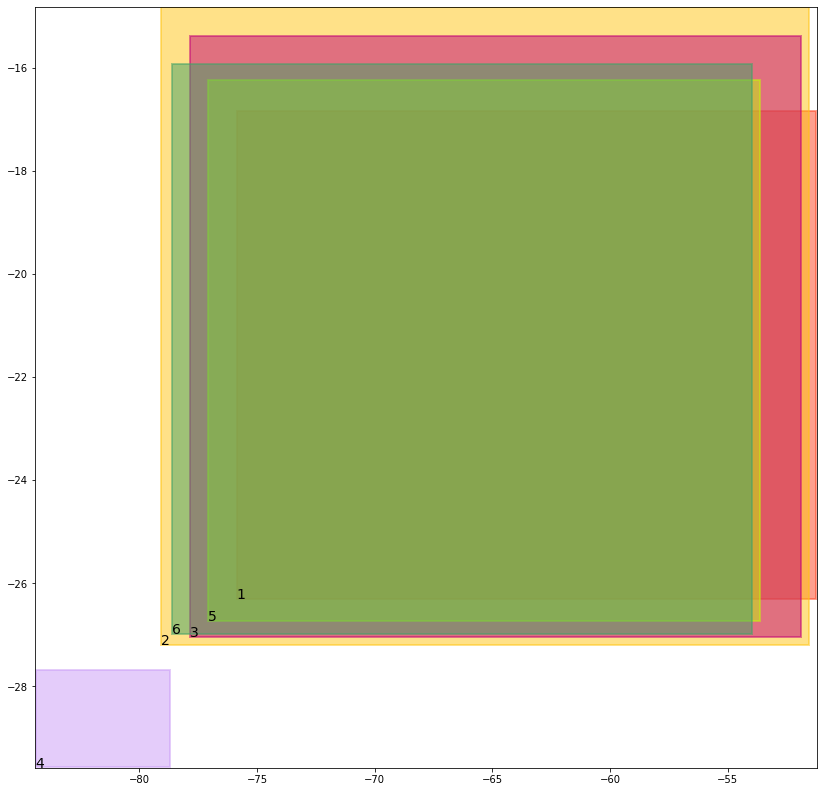

alignment data:
tensor(1) 0.5704189538955688 0.48768696188926697 tensor(0.8732157349586487) tensor(0.8519879579544067)
tensor(2) 0.2903931438922882 0.9662749767303467 tensor(0.8636294603347778) tensor(0.9789019227027893)
tensor(3) 0.3470709025859833 0.8778610825538635 tensor(0.8944495916366577) tensor(0.8869847059249878)
tensor(4) 0.9808217883110046 0.7762769460678101 tensor(0.9874446392059326) tensor(0.9660299420356750)
tensor(5) 0.3887227773666382 0.8649215698242188 tensor(0.8829069733619690) tensor(0.8786997199058533)
tensor(6) 0.3378460109233856 0.9662291407585144 tensor(0.8538055419921875) tensor(0.9766942262649536)


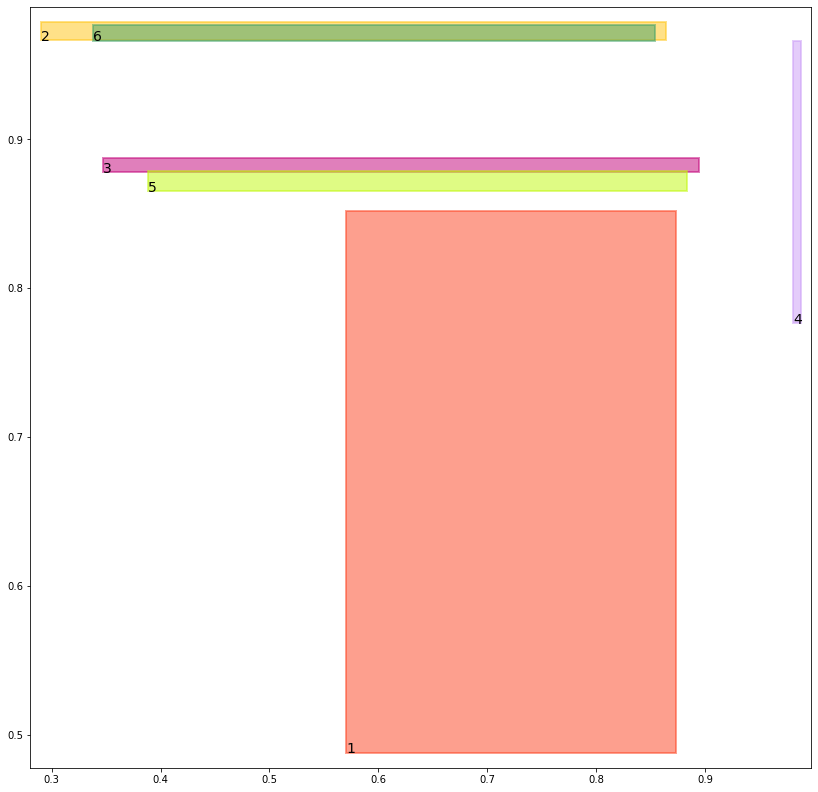

batch (tensor([[3, 5],
        [6, 2],
        [2, 6],
        [1, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -76.2660140991211 -26.484020233154297 tensor(-51.5065994262695312) tensor(-16.9696941375732422)
tensor(2) -79.99370574951172 -27.59752082824707 tensor(-52.1651840209960938) tensor(-15.0833282470703125)
tensor(3) -78.13253784179688 -27.167997360229492 tensor(-52.5383567810058594) tensor(-15.6649742126464844)
tensor(4) -84.8394546508789 -29.762939453125 tensor(-79.0812454223632812) tensor(-27.8563041687011719)
tensor(5) -77.61024475097656 -26.963699340820312 tensor(-53.5359573364257812) tensor(-16.1722068786621094)
tensor(6) -78.8210220336914 -27.076744079589844 tensor(-53.8265075683593750) tensor(-15.8471031188964844)


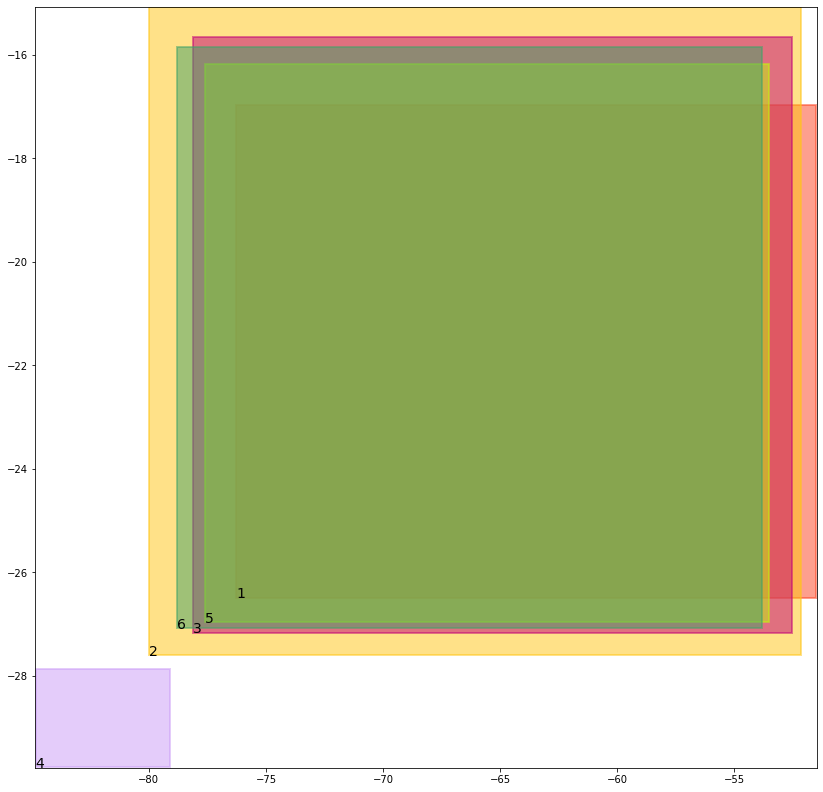

alignment data:
tensor(1) 0.5712186694145203 0.48729851841926575 tensor(0.8735886812210083) tensor(0.8523145914077759)
tensor(2) 0.2962498962879181 0.967781126499176 tensor(0.8749858140945435) tensor(0.9783120155334473)
tensor(3) 0.354207307100296 0.8784108757972717 tensor(0.8925127983093262) tensor(0.8865894675254822)
tensor(4) 0.9807027578353882 0.7757599949836731 tensor(0.9874838590621948) tensor(0.9661231637001038)
tensor(5) 0.3803863227367401 0.8667803406715393 tensor(0.8853569030761719) tensor(0.8799405694007874)
tensor(6) 0.3298999071121216 0.9659697413444519 tensor(0.8495419025421143) tensor(0.9776160120964050)


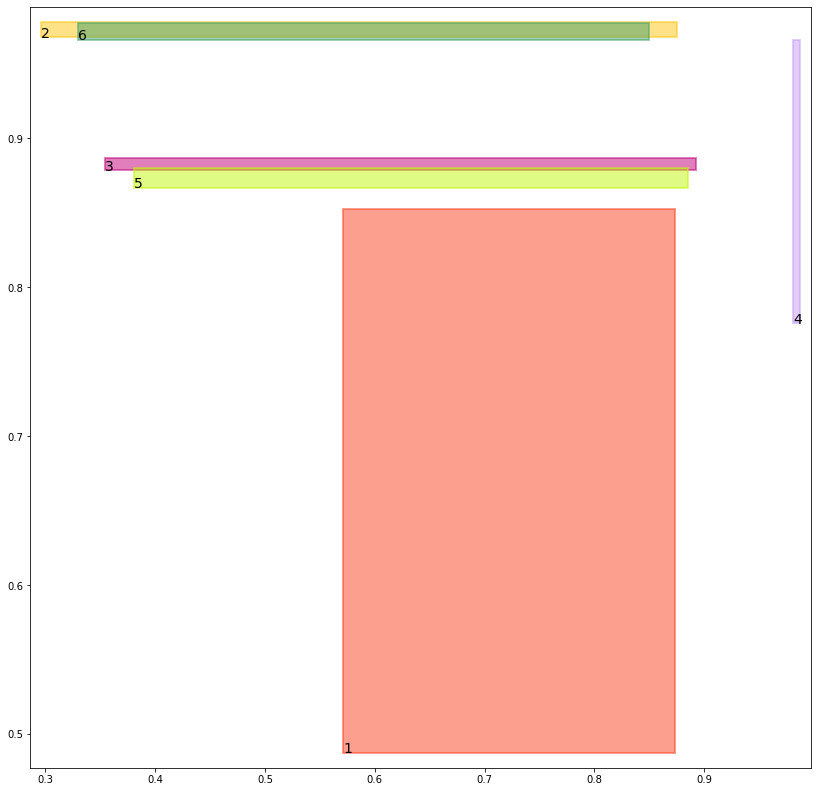

batch (tensor([[4, 5],
        [1, 3],
        [4, 6],
        [5, 3]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -76.63195037841797 -26.647829055786133 tensor(-51.7517738342285156) tensor(-17.0828342437744141)
tensor(2) -80.7842025756836 -27.953100204467773 tensor(-52.7239074707031250) tensor(-15.3190021514892578)
tensor(3) -78.02900695800781 -27.144689559936523 tensor(-53.8019866943359375) tensor(-16.2272586822509766)
tensor(4) -85.22563934326172 -29.935468673706055 tensor(-79.4136123657226562) tensor(-28.0072593688964844)
tensor(5) -78.45267486572266 -27.31758689880371 tensor(-52.8002510070800781) tensor(-15.8204212188720703)
tensor(6) -79.01988983154297 -27.161333084106445 tensor(-53.7056045532226562) tensor(-15.7813663482666016)


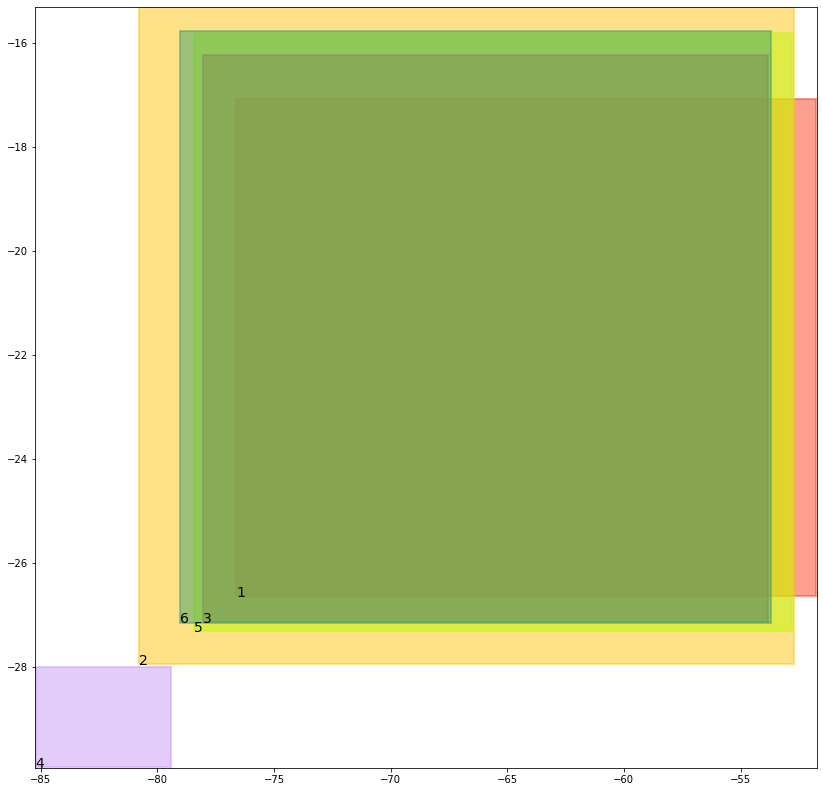

alignment data:
tensor(1) 0.5719462037086487 0.48694485425949097 tensor(0.8739274144172668) tensor(0.8526113033294678)
tensor(2) 0.30163952708244324 0.9690952897071838 tensor(0.8846080303192139) tensor(0.9777611494064331)
tensor(3) 0.37384602427482605 0.8790309429168701 tensor(0.8858035802841187) tensor(0.8816442489624023)
tensor(4) 0.9805939793586731 0.7752887010574341 tensor(0.9875193834304810) tensor(0.9662077426910400)
tensor(5) 0.36025524139404297 0.868453323841095 tensor(0.8925961852073669) tensor(0.8854109048843384)
tensor(6) 0.3227509558200836 0.9657319784164429 tensor(0.8455729484558105) tensor(0.9784239530563354)


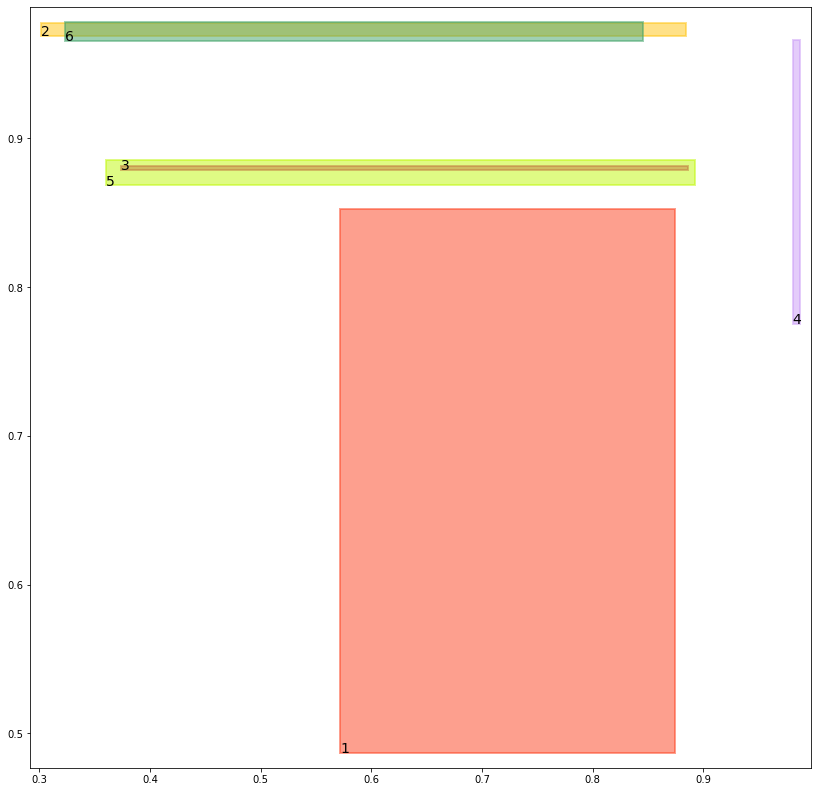

batch (tensor([[1, 2],
        [1, 3],
        [3, 5],
        [4, 5]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -76.96575164794922 -26.79732894897461 tensor(-51.9753990173339844) tensor(-17.1861038208007812)
tensor(2) -81.48062133789062 -28.266809463500977 tensor(-53.2362289428710938) tensor(-15.5356235504150391)
tensor(3) -78.31807708740234 -27.27411651611328 tensor(-54.0814743041992188) tensor(-16.3653450012207031)
tensor(4) -85.57781982421875 -30.092884063720703 tensor(-79.7165069580078125) tensor(-28.1449012756347656)
tensor(5) -78.84683227539062 -27.492778778076172 tensor(-52.9984359741210938) tensor(-15.8706645965576172)
tensor(6) -79.19641876220703 -27.23638153076172 tensor(-53.5970993041992188) tensor(-15.7220382690429688)


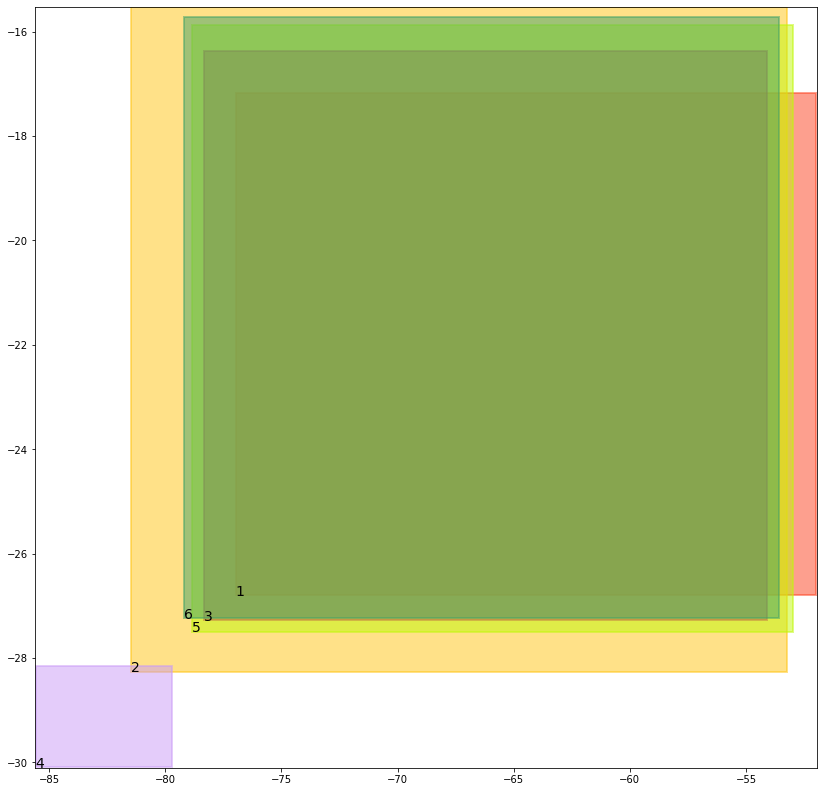

alignment data:
tensor(1) 0.5726080536842346 0.4866231381893158 tensor(0.8742349743843079) tensor(0.8528808951377869)
tensor(2) 0.3065924048423767 0.9702460765838623 tensor(0.8927983045578003) tensor(0.9772478938102722)
tensor(3) 0.3773076832294464 0.8748440742492676 tensor(0.8850365877151489) tensor(0.8818697929382324)
tensor(4) 0.9804942607879639 0.7748591303825378 tensor(0.9875517487525940) tensor(0.9662845730781555)
tensor(5) 0.35602569580078125 0.8751475811004639 tensor(0.8938717246055603) tensor(0.8859346508979797)
tensor(6) 0.31631624698638916 0.9655142426490784 tensor(0.8418869376182556) tensor(0.9791344404220581)


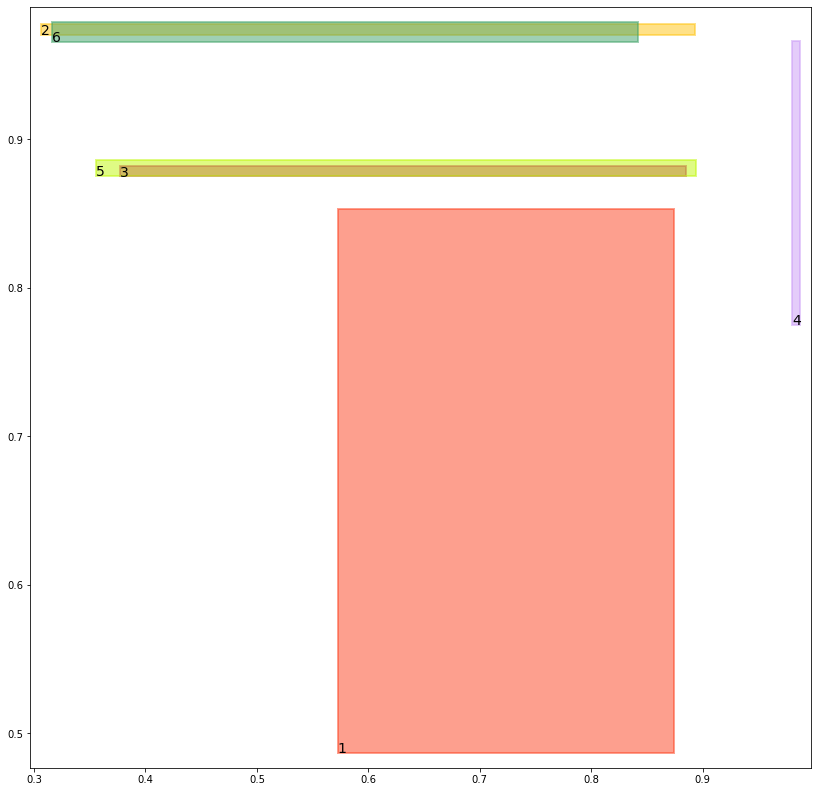

batch (tensor([[5, 3],
        [4, 6],
        [6, 2],
        [2, 6]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -77.27011108398438 -26.93370819091797 tensor(-52.1792755126953125) tensor(-17.2803230285644531)
tensor(2) -82.04288482666016 -28.51913833618164 tensor(-53.9241256713867188) tensor(-15.8364257812500000)
tensor(3) -78.58123016357422 -27.391990661621094 tensor(-54.3837928771972656) tensor(-16.5055980682373047)
tensor(4) -85.89887237548828 -30.2364501953125 tensor(-79.9924697875976562) tensor(-28.2703647613525391)
tensor(5) -79.20594787597656 -27.652481079101562 tensor(-53.1258201599121094) tensor(-15.9007301330566406)
tensor(6) -79.45693969726562 -27.35065460205078 tensor(-53.2715797424316406) tensor(-15.5620002746582031)


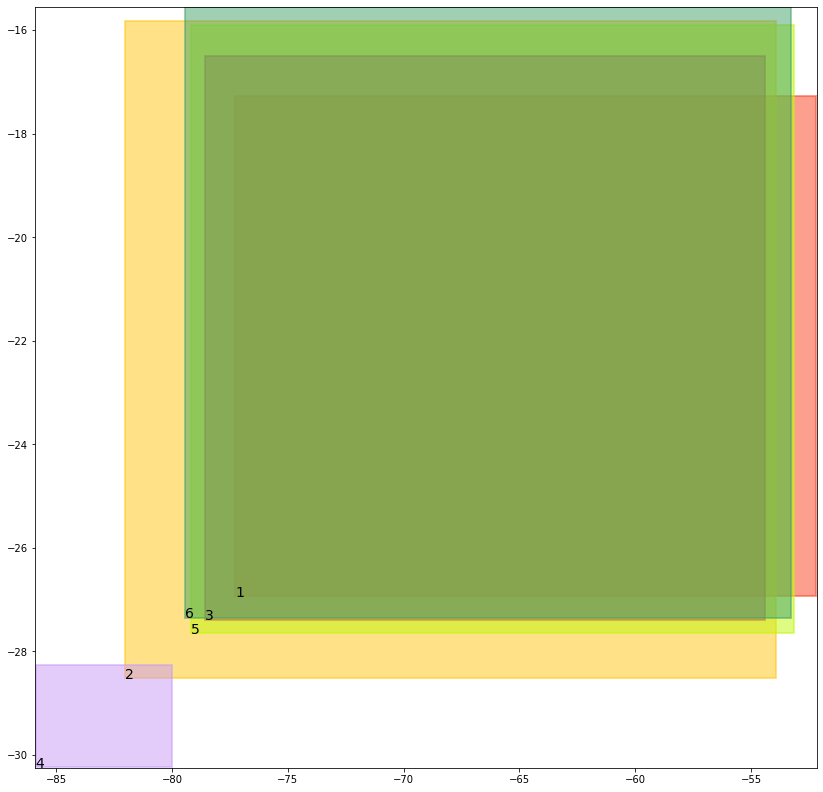

alignment data:
tensor(1) 0.5732100009918213 0.4863303005695343 tensor(0.8745142221450806) tensor(0.8531258106231689)
tensor(2) 0.31566566228866577 0.9707615971565247 tensor(0.8984538316726685) tensor(0.9770945906639099)
tensor(3) 0.3804693818092346 0.8726394772529602 tensor(0.8843343257904053) tensor(0.8820743560791016)
tensor(4) 0.9804033041000366 0.7744678258895874 tensor(0.9875810146331787) tensor(0.9663542509078979)
tensor(5) 0.3521966338157654 0.8793706893920898 tensor(0.8950208425521851) tensor(0.8864094614982605)
tensor(6) 0.3057812452316284 0.9658563137054443 tensor(0.8409357070922852) tensor(0.9794800281524658)


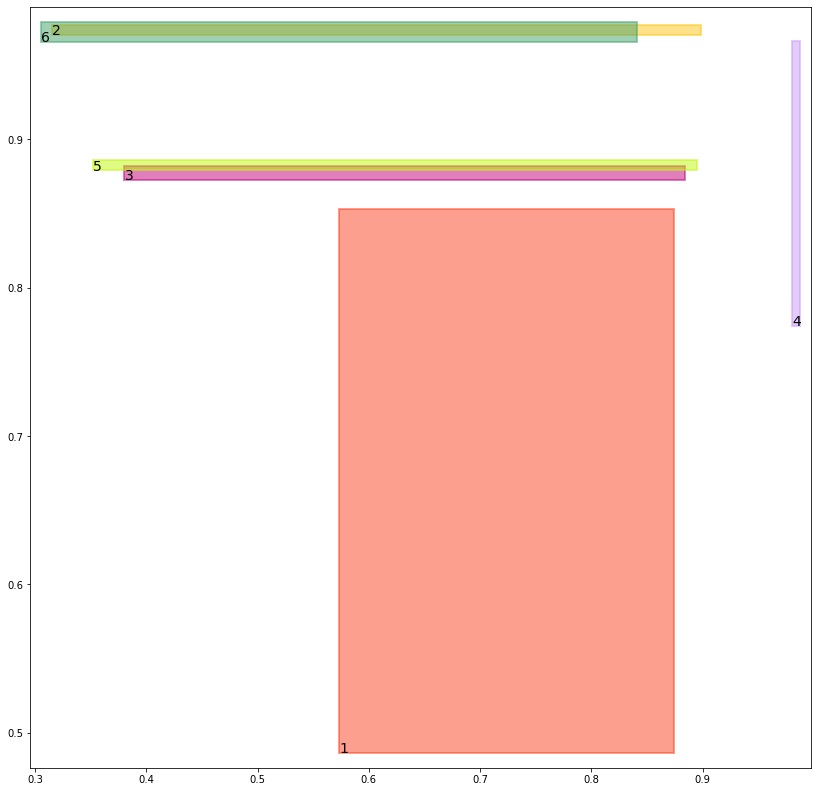

batch (tensor([[5, 3],
        [3, 5],
        [1, 2],
        [6, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -77.54753875732422 -27.058073043823242 tensor(-52.3651008605957031) tensor(-17.3662509918212891)
tensor(2) -82.487548828125 -28.718965530395508 tensor(-54.5648727416992188) tensor(-16.1171035766601562)
tensor(3) -78.94562530517578 -27.548547744750977 tensor(-54.4829292297363281) tensor(-16.5451202392578125)
tensor(4) -86.19145965576172 -30.367338180541992 tensor(-80.2438125610351562) tensor(-28.3846874237060547)
tensor(5) -79.42186737060547 -27.75436019897461 tensor(-53.4056053161621094) tensor(-16.0101356506347656)
tensor(6) -79.80529022216797 -27.504497528076172 tensor(-52.9816246032714844) tensor(-15.4189548492431641)


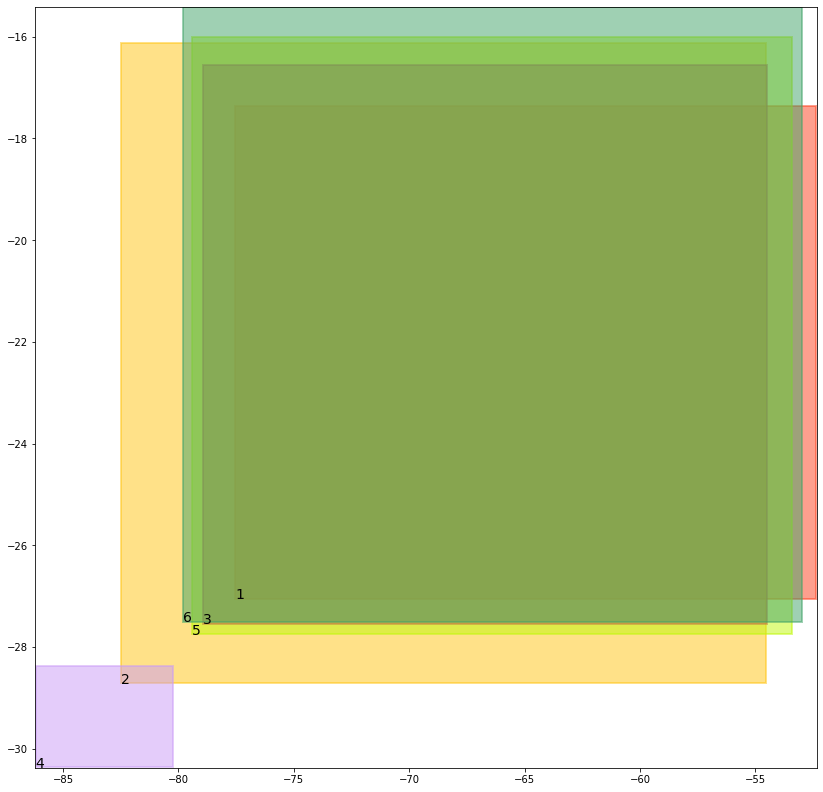

alignment data:
tensor(1) 0.573757529258728 0.4860639274120331 tensor(0.8747678399085999) tensor(0.8533484339714050)
tensor(2) 0.3241438567638397 0.9712414741516113 tensor(0.9021314382553101) tensor(0.9769416451454163)
tensor(3) 0.37895333766937256 0.8723381757736206 tensor(0.8854145407676697) tensor(0.8837627768516541)
tensor(4) 0.9803199768066406 0.7741113901138306 tensor(0.9876076579093933) tensor(0.9664175510406494)
tensor(5) 0.3527921438217163 0.8816196322441101 tensor(0.8945484161376953) tensor(0.8854628205299377)
tensor(6) 0.29636967182159424 0.9661648273468018 tensor(0.8425108194351196) tensor(0.9797896146774292)


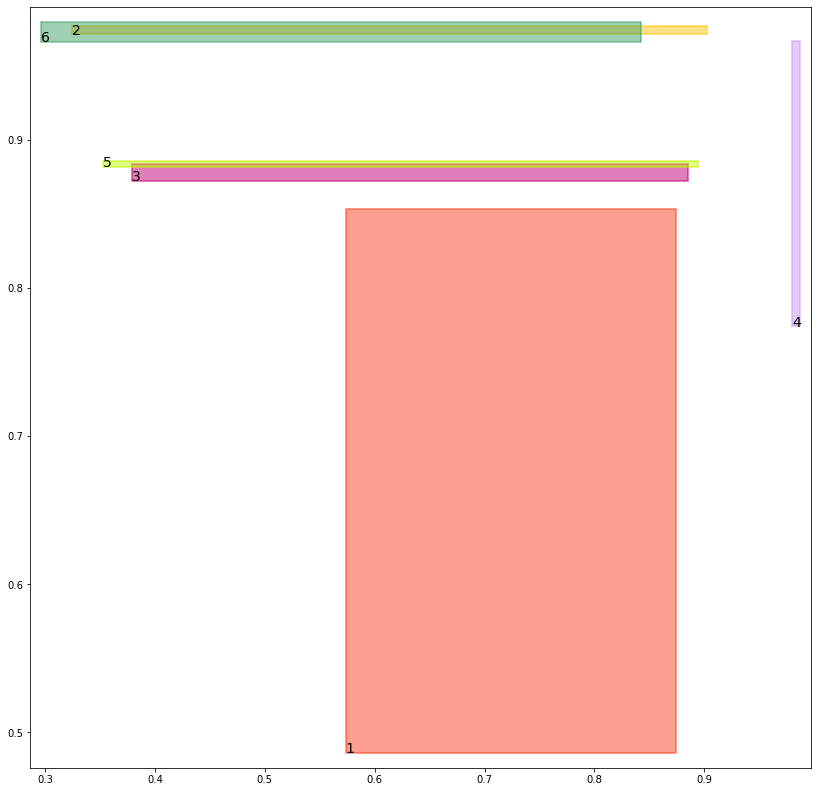

batch (tensor([[4, 5],
        [1, 3],
        [4, 6],
        [2, 6]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -77.80033111572266 -27.17144012451172 tensor(-52.5344085693359375) tensor(-17.4445838928222656)
tensor(2) -82.91719818115234 -28.907798767089844 tensor(-54.4034843444824219) tensor(-16.0397796630859375)
tensor(3) -79.27718353271484 -27.691104888916016 tensor(-54.5729713439941406) tensor(-16.5810012817382812)
tensor(4) -86.4580078125 -30.486621856689453 tensor(-80.4726943969726562) tensor(-28.4888343811035156)
tensor(5) -79.6180648803711 -27.84701919555664 tensor(-53.6601028442382812) tensor(-16.1097850799560547)
tensor(6) -80.09288024902344 -27.635019302368164 tensor(-53.4662513732910156) tensor(-15.6232290267944336)


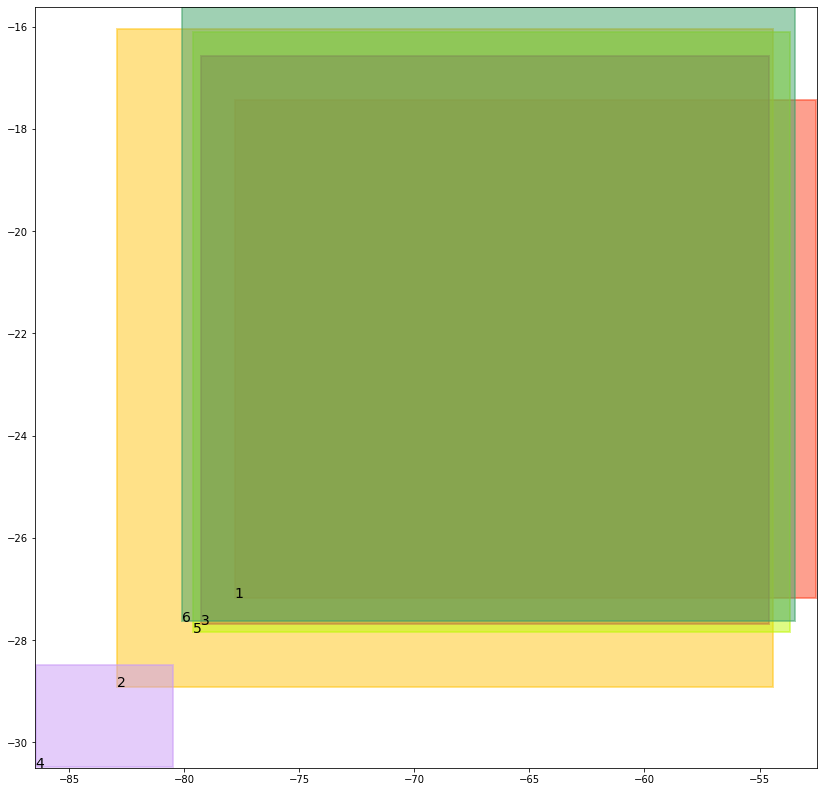

alignment data:
tensor(1) 0.5742553472518921 0.4858216643333435 tensor(0.8749981522560120) tensor(0.8535506725311279)
tensor(2) 0.31824198365211487 0.9702516198158264 tensor(0.9053730964660645) tensor(0.9777692556381226)
tensor(3) 0.3775762915611267 0.8720635771751404 tensor(0.8863895535469055) tensor(0.8852803707122803)
tensor(4) 0.9802440404891968 0.7737868428230286 tensor(0.9876318573951721) tensor(0.9664750099182129)
tensor(5) 0.3533342182636261 0.8836337924003601 tensor(0.8941171169281006) tensor(0.8845955133438110)
tensor(6) 0.30147871375083923 0.9678986072540283 tensor(0.8438165187835693) tensor(0.9792599678039551)


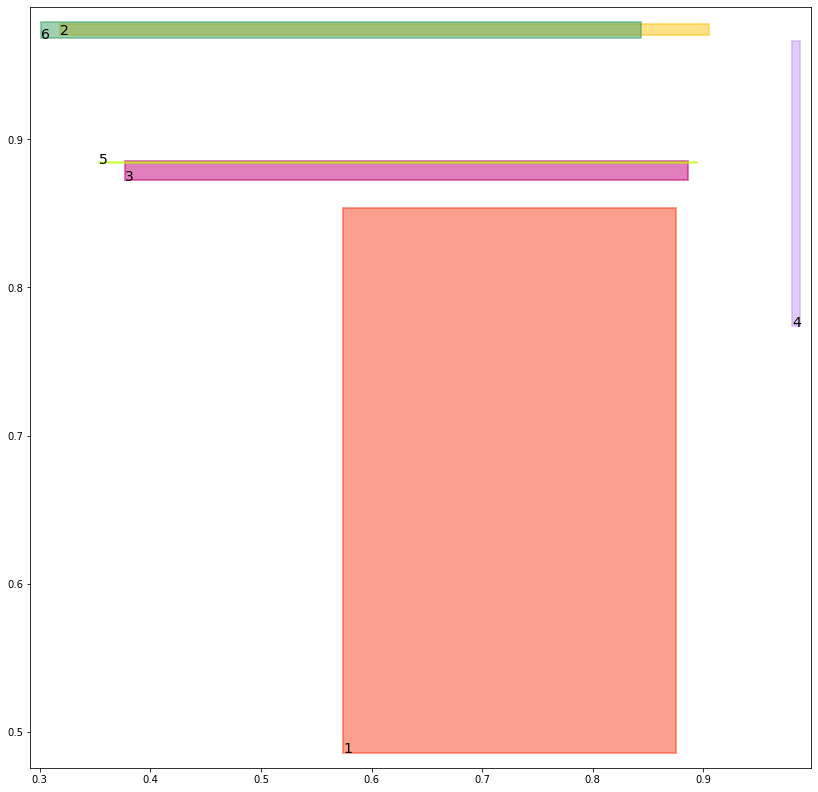

batch (tensor([[2, 6],
        [1, 3],
        [1, 2],
        [6, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -78.03060913085938 -27.274744033813477 tensor(-52.6886291503906250) tensor(-17.5159721374511719)
tensor(2) -83.2379379272461 -29.04646873474121 tensor(-53.9285049438476562) tensor(-15.8230600357055664)
tensor(3) -79.57880401611328 -27.820890426635742 tensor(-54.6547622680664062) tensor(-16.6135807037353516)
tensor(4) -86.7007827758789 -30.59529685974121 tensor(-80.6810455322265625) tensor(-28.5836734771728516)
tensor(5) -79.84524536132812 -27.945833206176758 tensor(-53.8429641723632812) tensor(-16.1861114501953125)
tensor(6) -80.49962615966797 -27.820775985717773 tensor(-54.2539138793945312) tensor(-15.9648885726928711)


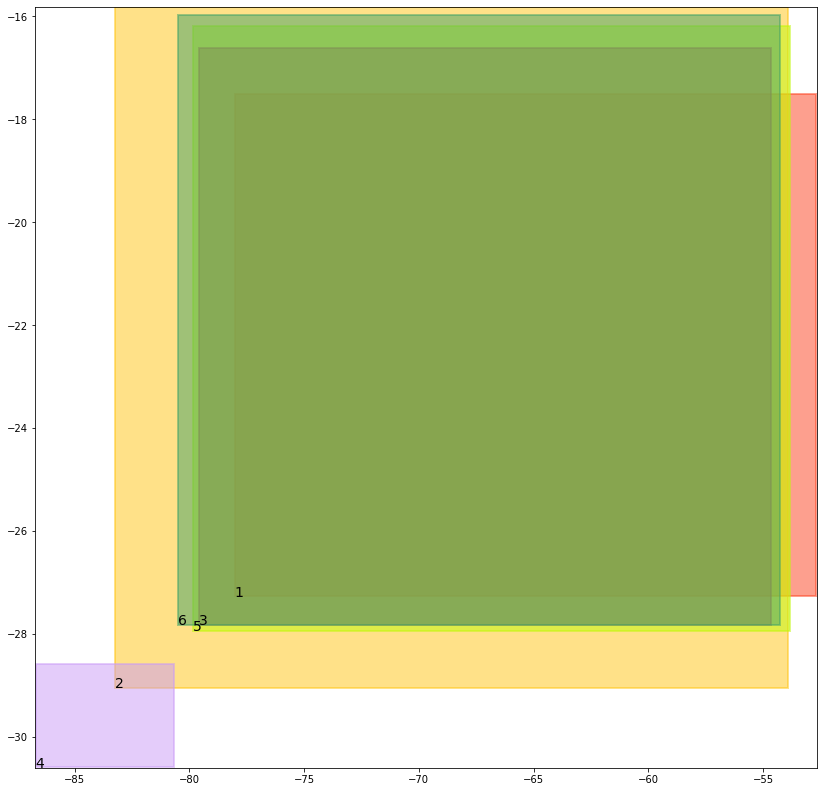

alignment data:
tensor(1) 0.5747079849243164 0.48560136556625366 tensor(0.8752073049545288) tensor(0.8537343740463257)
tensor(2) 0.30700305104255676 0.9686043858528137 tensor(0.9065555334091187) tensor(0.9789081811904907)
tensor(3) 0.3763256072998047 0.8718133568763733 tensor(0.8872700929641724) tensor(0.8866456747055054)
tensor(4) 0.9801746606826782 0.7734913229942322 tensor(0.9876536726951599) tensor(0.9665272831916809)
tensor(5) 0.3538275957107544 0.8838019371032715 tensor(0.8937234282493591) tensor(0.8854398131370544)
tensor(6) 0.31246280670166016 0.9700245261192322 tensor(0.8484466075897217) tensor(0.9783452153205872)


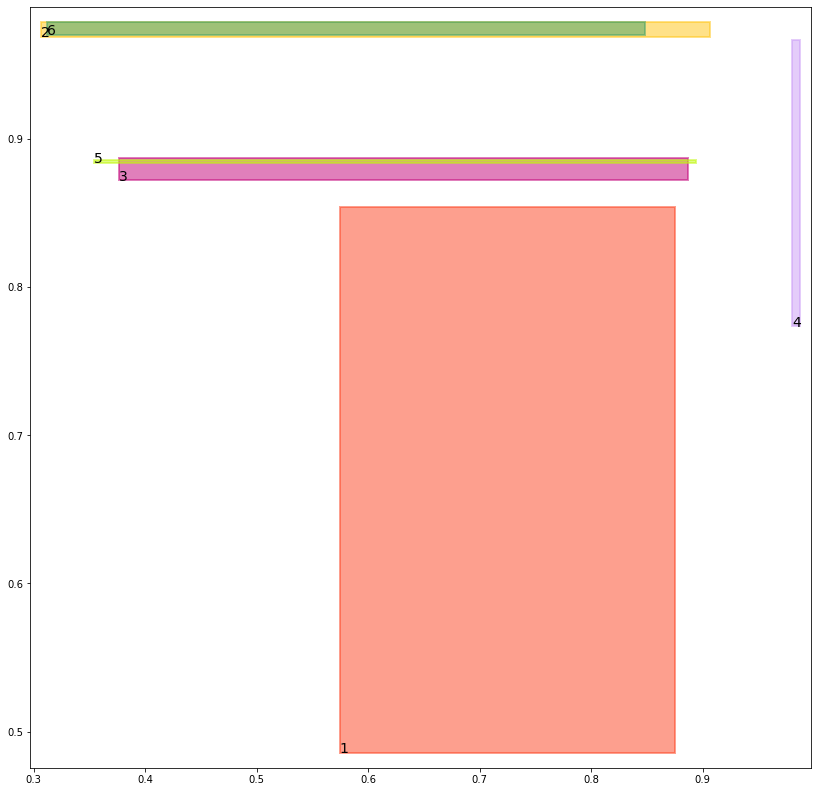

batch (tensor([[3, 5],
        [5, 3],
        [4, 5],
        [4, 6]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -78.24031829833984 -27.368850708007812 tensor(-52.8290557861328125) tensor(-17.5810070037841797)
tensor(2) -83.52828216552734 -29.172229766845703 tensor(-53.5018463134765625) tensor(-15.6285543441772461)
tensor(3) -79.90184783935547 -27.9708309173584 tensor(-54.4699478149414062) tensor(-16.5122890472412109)
tensor(4) -86.92182159423828 -30.69428825378418 tensor(-80.8706741333007812) tensor(-28.6700210571289062)
tensor(5) -80.02881622314453 -28.012224197387695 tensor(-54.2398757934570312) tensor(-16.3751163482666016)
tensor(6) -80.86954498291016 -27.990095138549805 tensor(-54.9793243408203125) tensor(-16.2805271148681641)


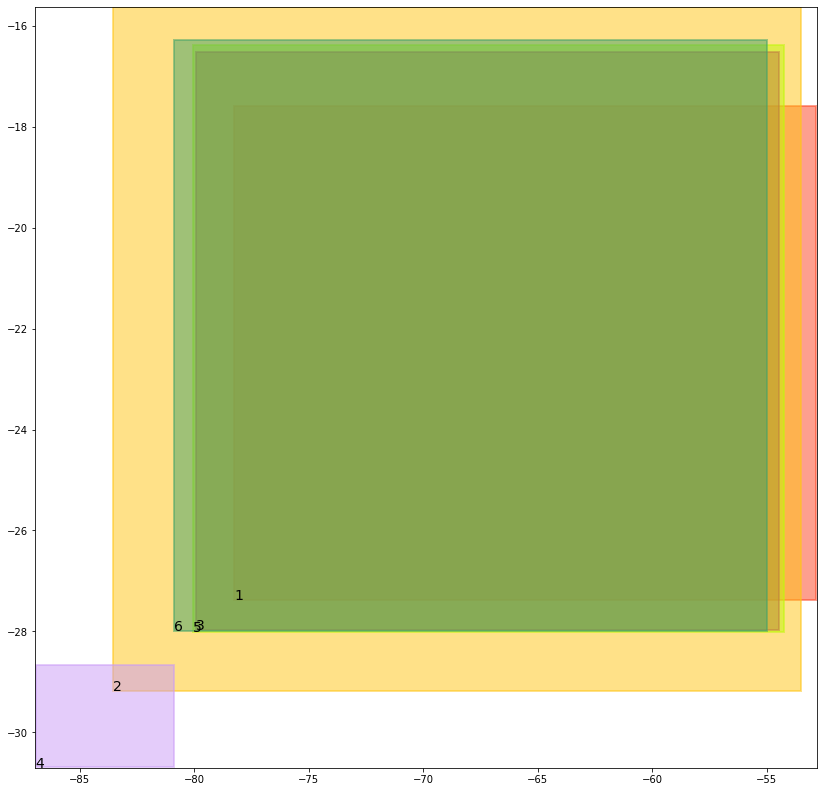

alignment data:
tensor(1) 0.5751195549964905 0.4854009449481964 tensor(0.8753972649574280) tensor(0.8539012670516968)
tensor(2) 0.2969774305820465 0.9670301079750061 tensor(0.9076192378997803) tensor(0.9798943400382996)
tensor(3) 0.36870115995407104 0.8742173910140991 tensor(0.8905079364776611) tensor(0.8856710195541382)
tensor(4) 0.9801114201545715 0.7732223868370056 tensor(0.9876736998558044) tensor(0.9665747284889221)
tensor(5) 0.3604179322719574 0.8809612393379211 tensor(0.8910125494003296) tensor(0.8891183137893677)
tensor(6) 0.3226381242275238 0.9718388915061951 tensor(0.8525588512420654) tensor(0.9774792790412903)


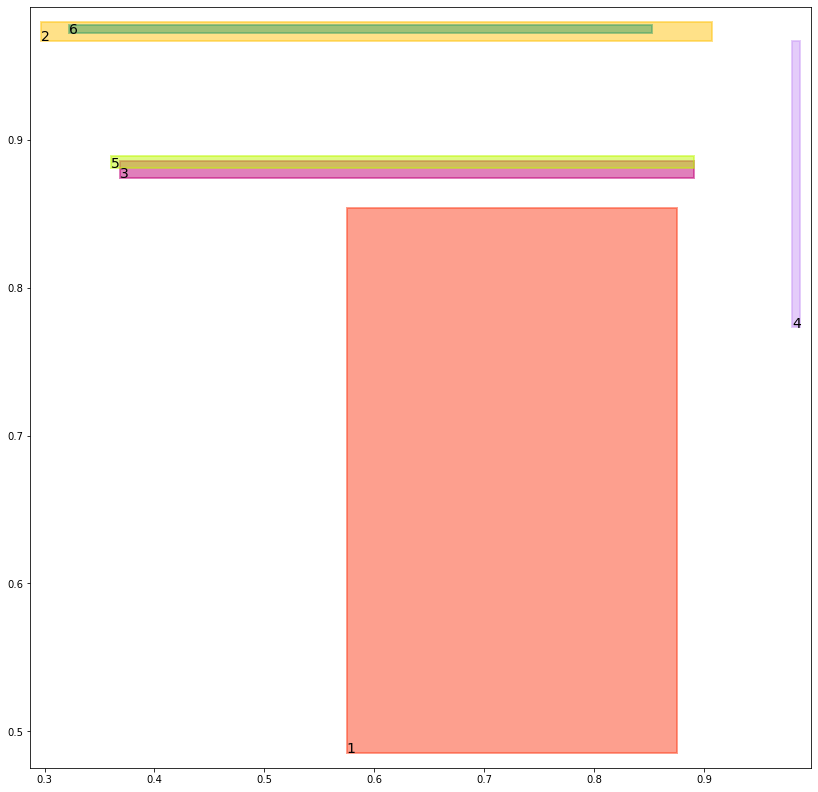

batch (tensor([[5, 3],
        [3, 5],
        [6, 2],
        [1, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -78.43122100830078 -27.454547882080078 tensor(-52.9568862915039062) tensor(-17.6402378082275391)
tensor(2) -83.73128509521484 -29.260597229003906 tensor(-53.3513946533203125) tensor(-15.5571584701538086)
tensor(3) -80.3097915649414 -28.15178108215332 tensor(-54.1323509216308594) tensor(-16.3347110748291016)
tensor(4) -87.1230239868164 -30.784414291381836 tensor(-81.0432205200195312) tensor(-28.7486152648925781)
tensor(5) -80.07166290283203 -28.023475646972656 tensor(-54.7734527587890625) tensor(-16.6335449218750000)
tensor(6) -81.31275939941406 -28.190750122070312 tensor(-55.3910903930664062) tensor(-16.4565467834472656)


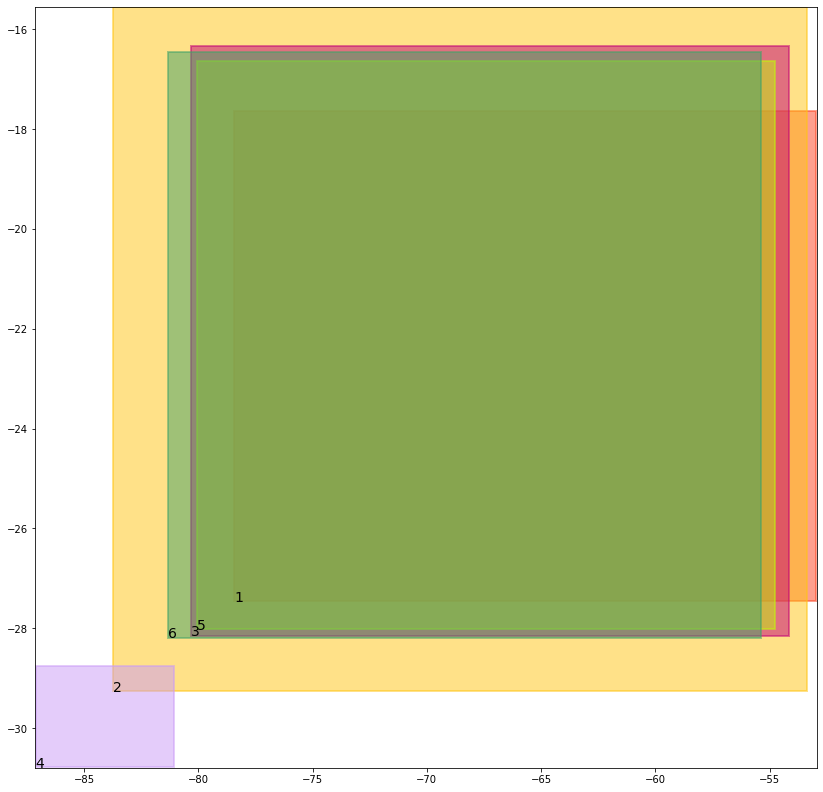

alignment data:
tensor(1) 0.5754936337471008 0.4852187931537628 tensor(0.8755697607994080) tensor(0.8540528416633606)
tensor(2) 0.2921111583709717 0.9662081003189087 tensor(0.9074713587760925) tensor(0.9804888963699341)
tensor(3) 0.3575934171676636 0.8780443072319031 tensor(0.8949161767959595) tensor(0.8862714767456055)
tensor(4) 0.9800536036491394 0.7729776501655579 tensor(0.9876917004585266) tensor(0.9666178226470947)
tensor(5) 0.3706033229827881 0.8768115639686584 tensor(0.8868421316146851) tensor(0.8909955620765686)
tensor(6) 0.327336847782135 0.9730518460273743 tensor(0.8583161830902100) tensor(0.9770016074180603)


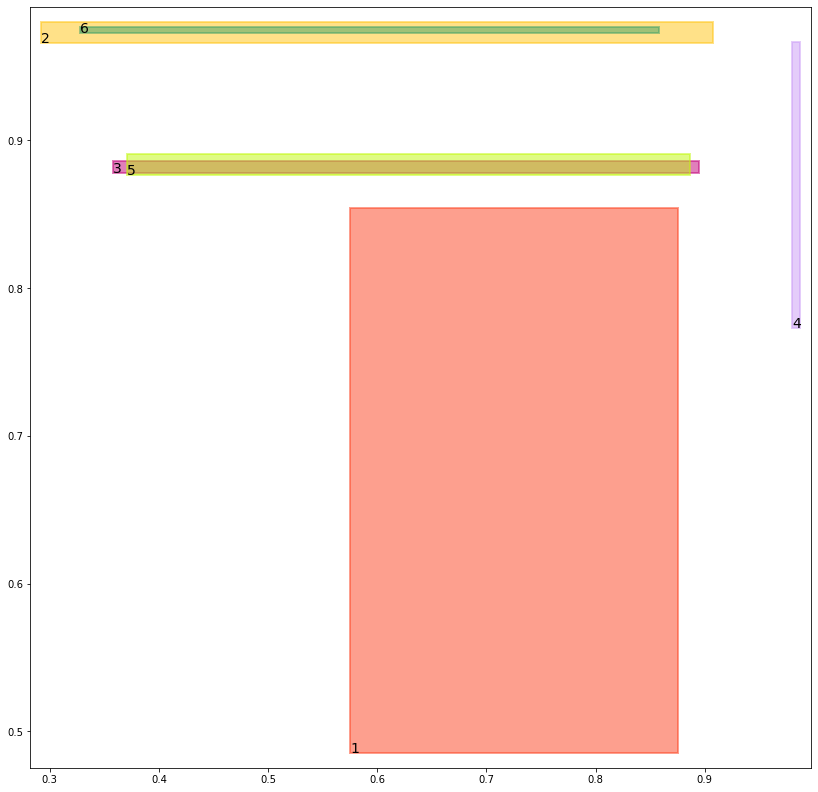

batch (tensor([[4, 6],
        [2, 6],
        [4, 5],
        [1, 3]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -78.60497283935547 -27.532567977905273 tensor(-53.0732269287109375) tensor(-17.6941604614257812)
tensor(2) -83.91559600830078 -29.340898513793945 tensor(-53.2153434753417969) tensor(-15.4926023483276367)
tensor(3) -80.67513275146484 -28.313888549804688 tensor(-53.8283309936523438) tensor(-16.1747665405273438)
tensor(4) -87.30614471435547 -30.866453170776367 tensor(-81.2001876831054688) tensor(-28.8201313018798828)
tensor(5) -80.10396575927734 -28.030765533447266 tensor(-55.2619323730468750) tensor(-16.8707942962646484)
tensor(6) -81.70874786376953 -28.37019157409668 tensor(-55.7668304443359375) tensor(-16.6174907684326172)


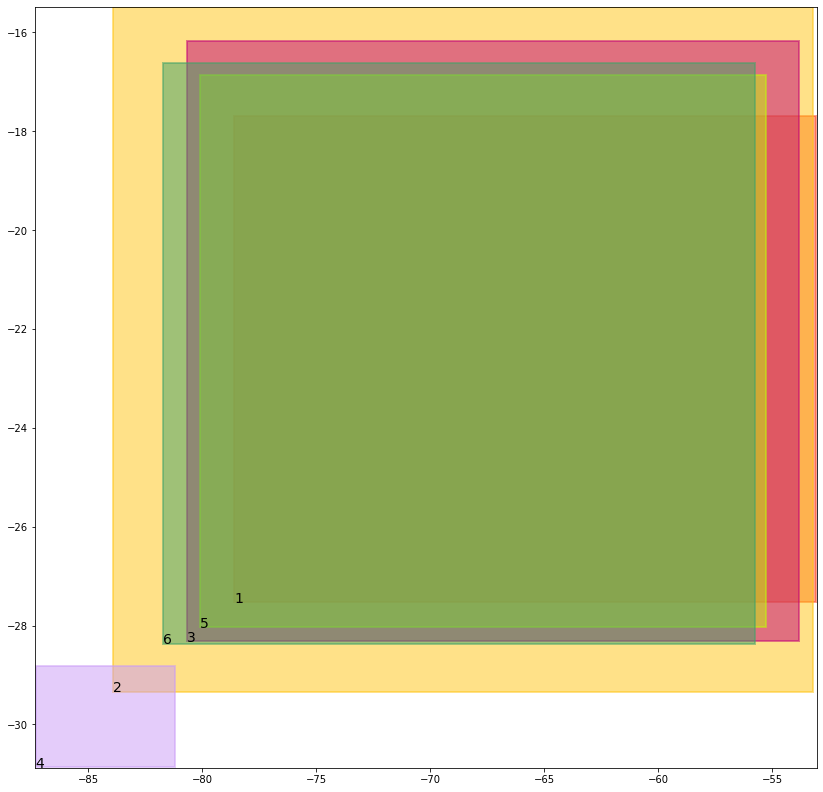

alignment data:
tensor(1) 0.5758336782455444 0.485053151845932 tensor(0.8757264018058777) tensor(0.8541905879974365)
tensor(2) 0.28772810101509094 0.9654436707496643 tensor(0.9073365926742554) tensor(0.9810143113136292)
tensor(3) 0.3476259708404541 0.8814361095428467 tensor(0.8987871408462524) tensor(0.8868149518966675)
tensor(4) 0.9800010323524475 0.7727550268173218 tensor(0.9877080917358398) tensor(0.9666569232940674)
tensor(5) 0.379964143037796 0.8729317784309387 tensor(0.8829306364059448) tensor(0.8926779627799988)
tensor(6) 0.33163878321647644 0.9741102457046509 tensor(0.8633862733840942) tensor(0.9765586853027344)


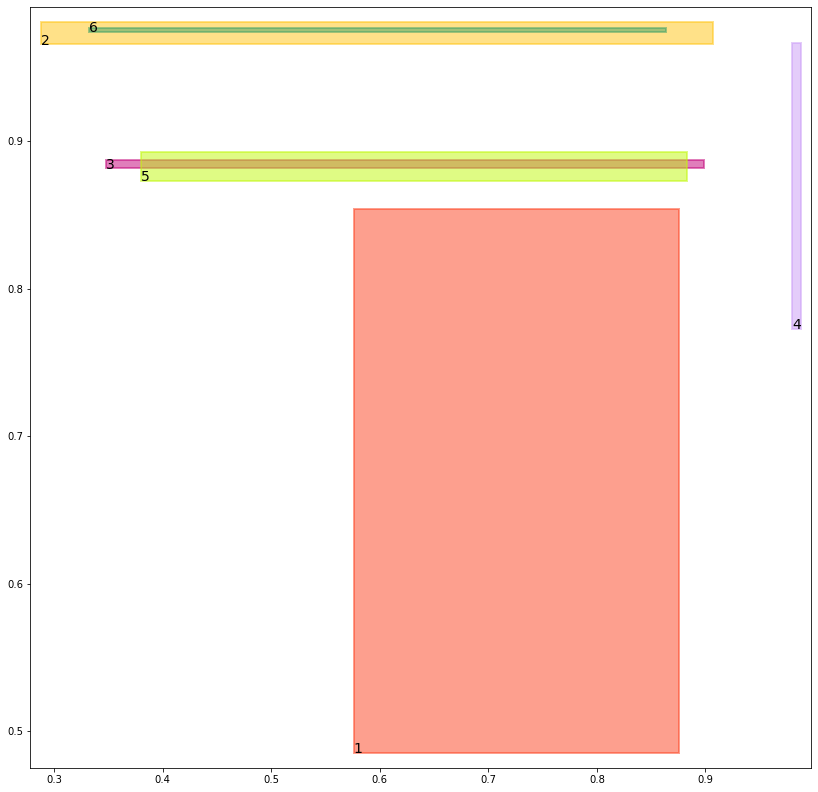

batch (tensor([[1, 3],
        [5, 3],
        [2, 6],
        [6, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -78.7630844116211 -27.603574752807617 tensor(-53.1790771484375000) tensor(-17.7432403564453125)
tensor(2) -84.0217056274414 -29.387474060058594 tensor(-53.3222808837890625) tensor(-15.5359172821044922)
tensor(3) -80.93549346923828 -28.426589965820312 tensor(-53.7797126770019531) tensor(-16.1334362030029297)
tensor(4) -87.47272491455078 -30.941112518310547 tensor(-81.3429641723632812) tensor(-28.8851928710937500)
tensor(5) -80.21798706054688 -28.075462341308594 tensor(-55.4760704040527344) tensor(-16.9819755554199219)
tensor(6) -82.1613998413086 -28.573406219482422 tensor(-55.8517379760742188) tensor(-16.6480979919433594)


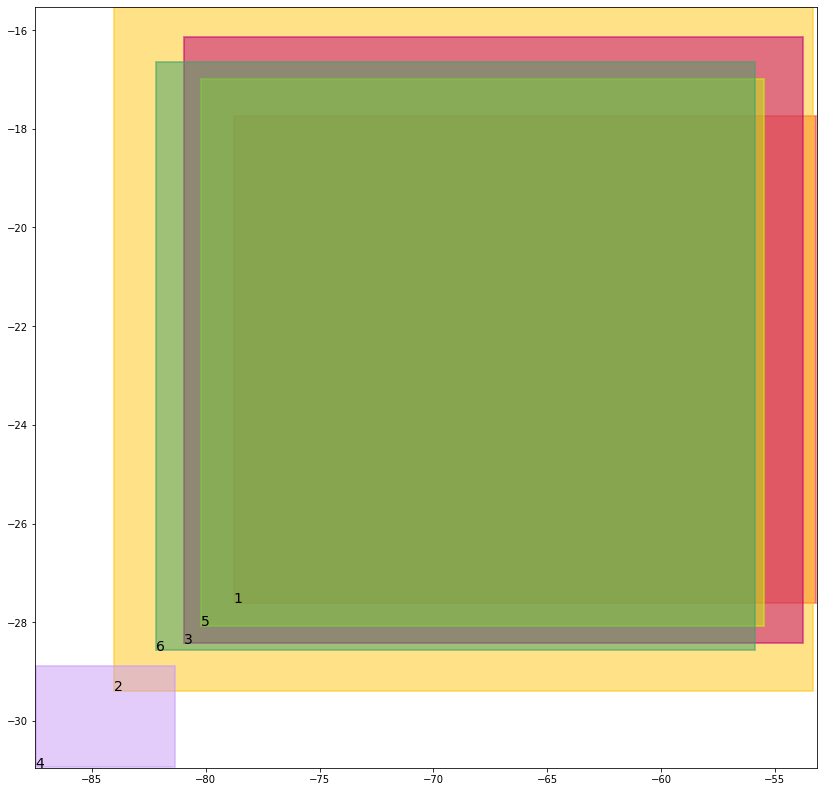

alignment data:
tensor(1) 0.5761426687240601 0.48490259051322937 tensor(0.8758686184883118) tensor(0.8543156385421753)
tensor(2) 0.28776127099990845 0.965458333492279 tensor(0.9060723185539246) tensor(0.9812372326850891)
tensor(3) 0.3429553210735321 0.8844954371452332 tensor(0.9007704257965088) tensor(0.8872613310813904)
tensor(4) 0.9799530506134033 0.772552490234375 tensor(0.9877229928970337) tensor(0.9666923284530640)
tensor(5) 0.3841072916984558 0.869314968585968 tensor(0.8811853528022766) tensor(0.8941872119903564)
tensor(6) 0.33081474900245667 0.9747374653816223 tensor(0.8697121143341064) tensor(0.9765110611915588)


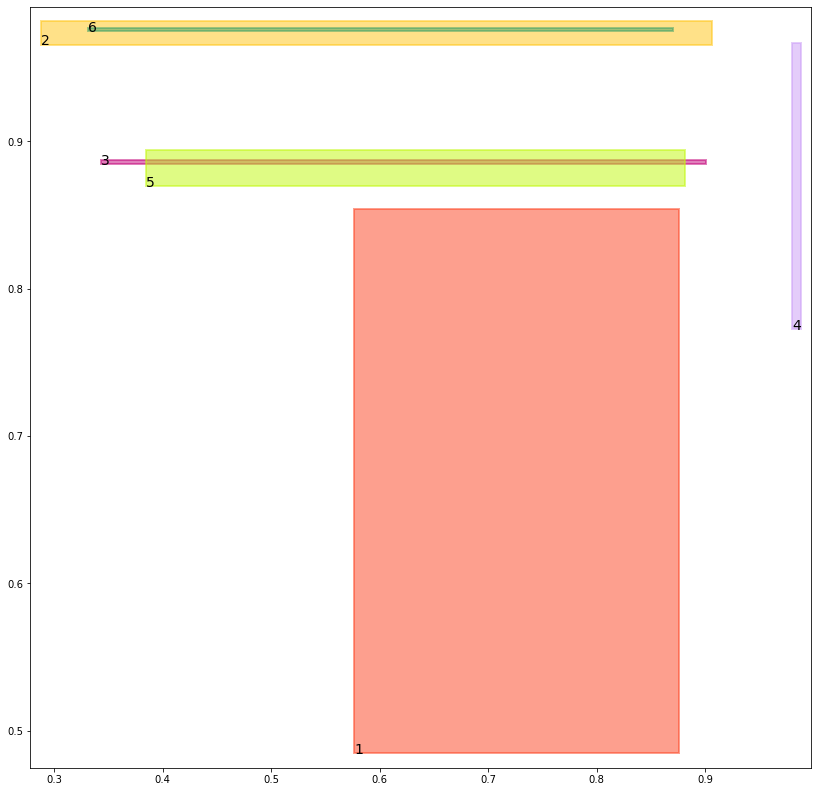

batch (tensor([[4, 5],
        [4, 6],
        [1, 2],
        [3, 5]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -78.90691375732422 -27.66818618774414 tensor(-53.2753601074218750) tensor(-17.7878990173339844)
tensor(2) -84.1174087524414 -29.429479598999023 tensor(-53.4195442199707031) tensor(-15.5753240585327148)
tensor(3) -81.2938232421875 -28.568540573120117 tensor(-53.6023025512695312) tensor(-16.0563201904296875)
tensor(4) -87.624267578125 -31.009031295776367 tensor(-81.4727859497070312) tensor(-28.9443721771240234)
tensor(5) -80.2004623413086 -28.079111099243164 tensor(-55.8409233093261719) tensor(-17.1357173919677734)
tensor(6) -82.56348419189453 -28.753995895385742 tensor(-55.9285888671875000) tensor(-16.6758193969726562)


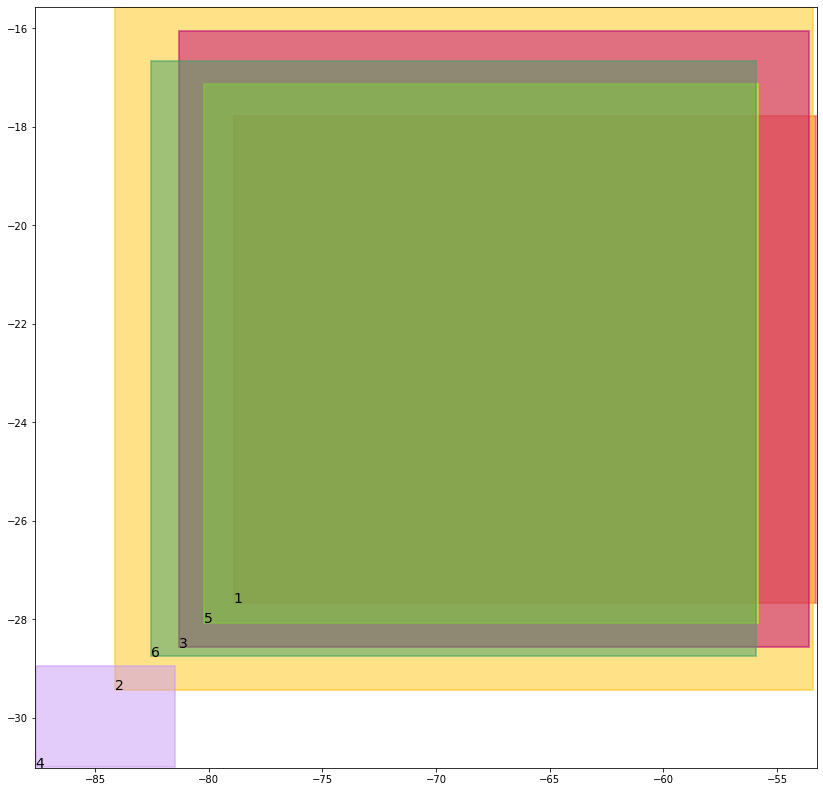

alignment data:
tensor(1) 0.5764234662055969 0.48476576805114746 tensor(0.8759977817535400) tensor(0.8544292449951172)
tensor(2) 0.28779137134552 0.9654715657234192 tensor(0.9049100279808044) tensor(0.9814375638961792)
tensor(3) 0.3387366235256195 0.8828067183494568 tensor(0.9025428295135498) tensor(0.8917851448059082)
tensor(4) 0.9799094796180725 0.7723683714866638 tensor(0.9877365231513977) tensor(0.9667246341705322)
tensor(5) 0.388099730014801 0.8712877035140991 tensor(0.8794870972633362) tensor(0.8917276859283447)
tensor(6) 0.3300667405128479 0.9752945899963379 tensor(0.8752437233924866) tensor(0.9764676690101624)


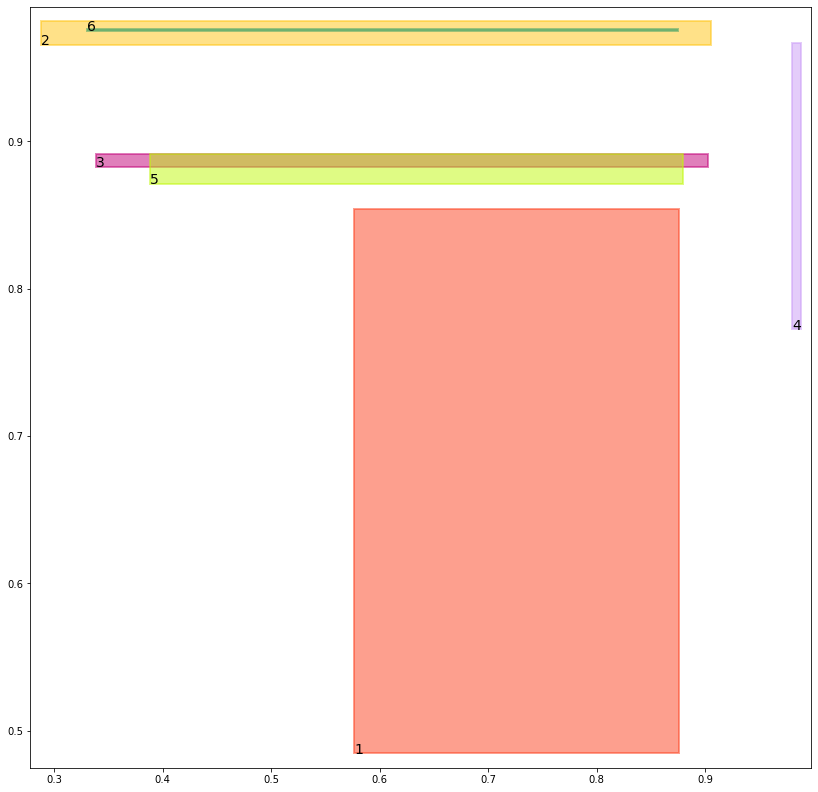

batch (tensor([[6, 2],
        [3, 5],
        [4, 6],
        [1, 3]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -79.03772735595703 -27.726959228515625 tensor(-53.3629226684570312) tensor(-17.8285274505615234)
tensor(2) -84.1068344116211 -29.425447463989258 tensor(-53.8520050048828125) tensor(-15.7635755538940430)
tensor(3) -81.61492156982422 -28.69603157043457 tensor(-53.3739471435546875) tensor(-15.9663019180297852)
tensor(4) -87.7620620727539 -31.070817947387695 tensor(-81.5908050537109375) tensor(-28.9981822967529297)
tensor(5) -80.18041229248047 -28.080854415893555 tensor(-56.2488708496093750) tensor(-17.2989139556884766)
tensor(6) -83.04944610595703 -28.96988868713379 tensor(-55.6213874816894531) tensor(-16.5305786132812500)


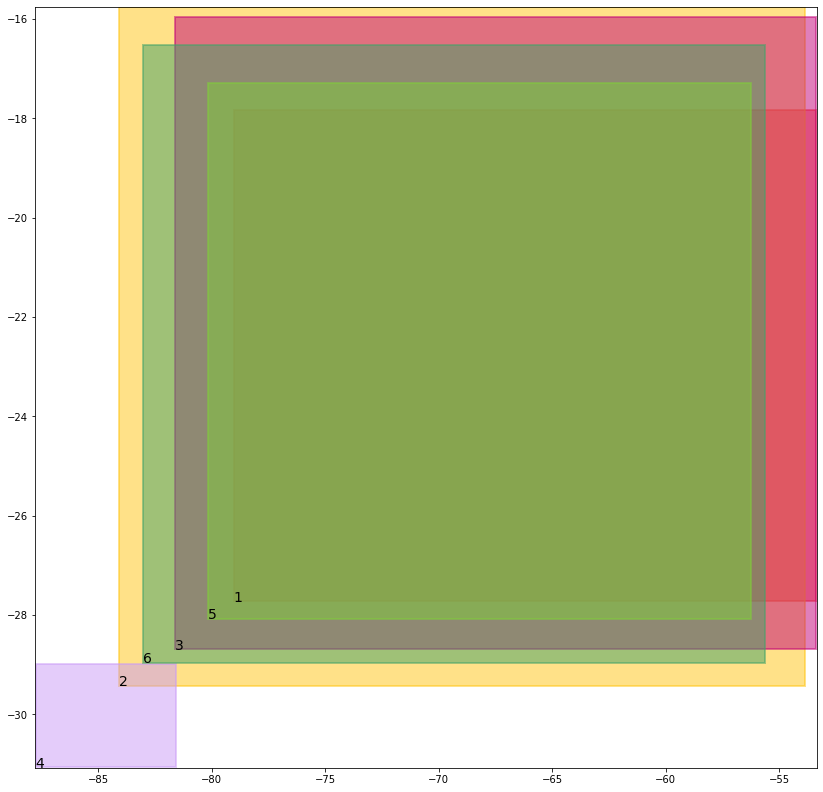

alignment data:
tensor(1) 0.5766785740852356 0.484641432762146 tensor(0.8761150240898132) tensor(0.8545324206352234)
tensor(2) 0.29378312826156616 0.966521143913269 tensor(0.9020244479179382) tensor(0.9812614917755127)
tensor(3) 0.33492511510849 0.8790282607078552 tensor(0.9041288495063782) tensor(0.8957568407058716)
tensor(4) 0.9798696041107178 0.772200882434845 tensor(0.9877488017082214) tensor(0.9667538404464722)
tensor(5) 0.39179694652557373 0.8754682540893555 tensor(0.8779008984565735) tensor(0.8894377946853638)
tensor(6) 0.322446346282959 0.9753651022911072 tensor(0.8824530839920044) tensor(0.9769688248634338)


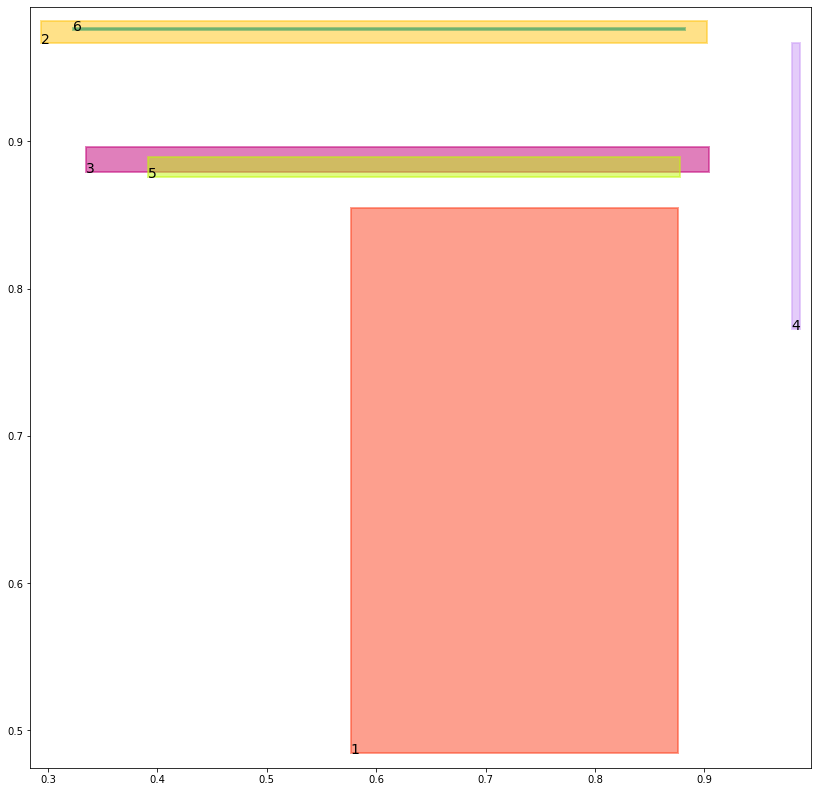

batch (tensor([[1, 2],
        [2, 6],
        [5, 3],
        [4, 5]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -79.15665435791016 -27.780410766601562 tensor(-53.4425392150878906) tensor(-17.8654747009277344)
tensor(2) -84.09369659423828 -29.420190811157227 tensor(-54.2483062744140625) tensor(-15.9363584518432617)
tensor(3) -81.74769592285156 -28.749561309814453 tensor(-53.5009346008300781) tensor(-16.0373592376708984)
tensor(4) -87.88736724853516 -31.126996994018555 tensor(-81.6981124877929688) tensor(-29.0471057891845703)
tensor(5) -80.36560821533203 -28.16465950012207 tensor(-56.2625579833984375) tensor(-17.2843132019042969)
tensor(6) -83.47669219970703 -29.159730911254883 tensor(-55.3456192016601562) tensor(-16.4000663757324219)


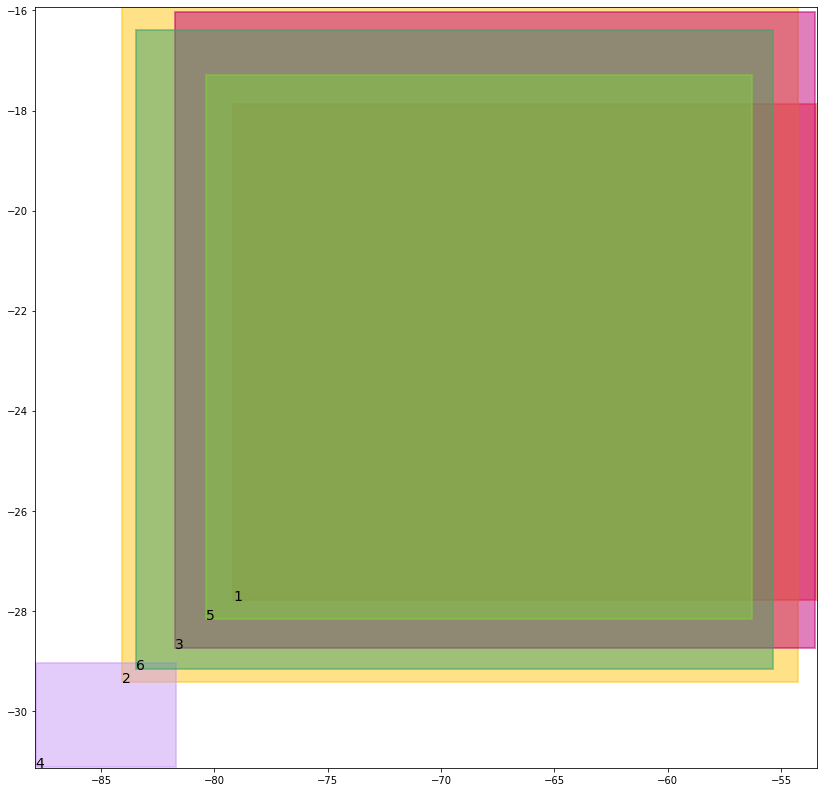

alignment data:
tensor(1) 0.5769103169441223 0.48452845215797424 tensor(0.8762214779853821) tensor(0.8546260595321655)
tensor(2) 0.2992897927761078 0.9674479961395264 tensor(0.8993351459503174) tensor(0.9810999631881714)
tensor(3) 0.3378210663795471 0.8756423592567444 tensor(0.9035212993621826) tensor(0.8973039984703064)
tensor(4) 0.9798334836959839 0.7720486521720886 tensor(0.9877600073814392) tensor(0.9667804241180420)
tensor(5) 0.3883975148200989 0.8791651725769043 tensor(0.8794656395912170) tensor(0.8893702626228333)
tensor(6) 0.3156033158302307 0.9754290580749512 tensor(0.8886876702308655) tensor(0.9774150252342224)


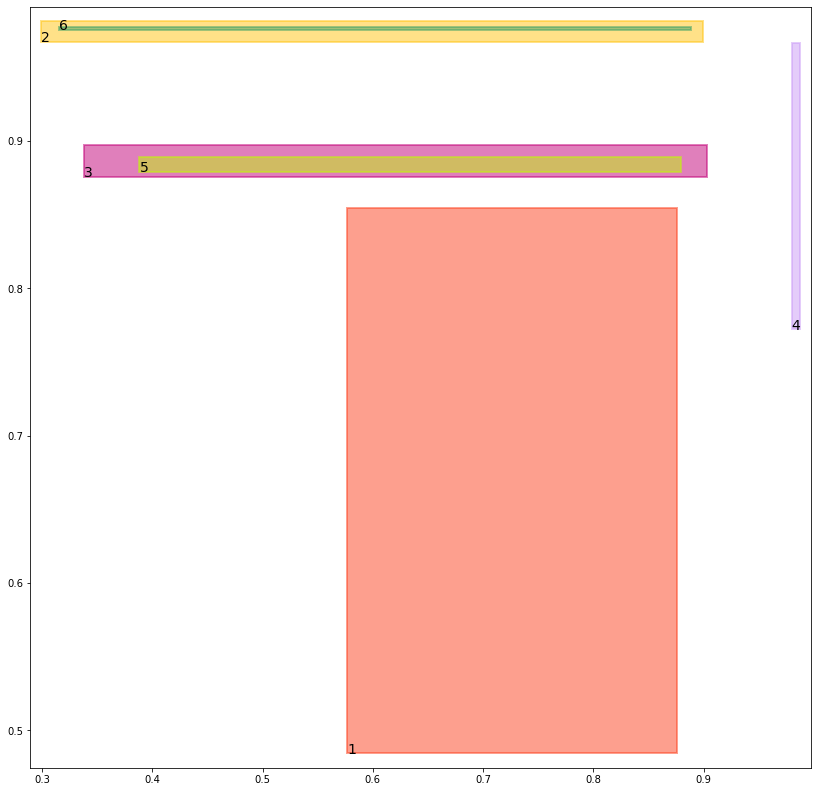

batch (tensor([[2, 6],
        [3, 5],
        [1, 3],
        [5, 3]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -79.2647933959961 -27.829010009765625 tensor(-53.5149154663085938) tensor(-17.8990669250488281)
tensor(2) -84.07880401611328 -29.414081573486328 tensor(-54.6110992431640625) tensor(-16.0947532653808594)
tensor(3) -81.76377868652344 -28.756568908691406 tensor(-53.8913803100585938) tensor(-16.2196350097656250)
tensor(4) -88.00125885009766 -31.17807388305664 tensor(-81.7956161499023438) tensor(-29.0915756225585938)
tensor(5) -80.6651840209961 -28.29368019104004 tensor(-55.9966201782226562) tensor(-17.1511192321777344)
tensor(6) -83.85335540771484 -29.327125549316406 tensor(-55.0979690551757812) tensor(-16.2827415466308594)


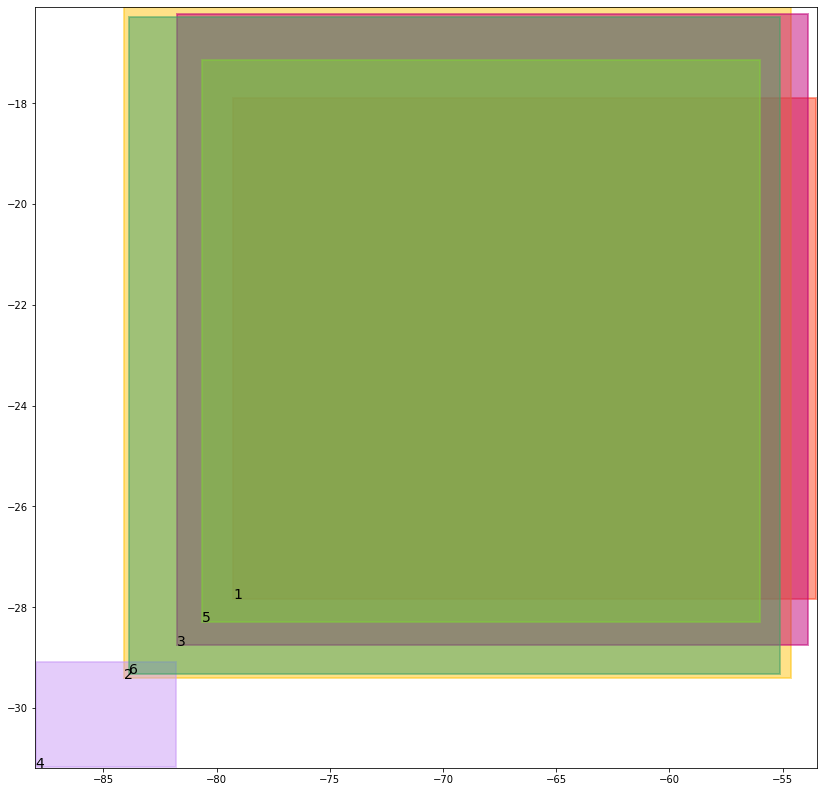

alignment data:
tensor(1) 0.577120840549469 0.484425812959671 tensor(0.8763181567192078) tensor(0.8547111749649048)
tensor(2) 0.30434325337409973 0.9682683944702148 tensor(0.8968354463577271) tensor(0.9809522032737732)
tensor(3) 0.34470027685165405 0.8742784261703491 tensor(0.9015859365463257) tensor(0.8974189758300781)
tensor(4) 0.9798005223274231 0.7719103097915649 tensor(0.9877700805664062) tensor(0.9668045043945312)
tensor(5) 0.3809143900871277 0.8809557557106018 tensor(0.8827856779098511) tensor(0.8906551599502563)
tensor(6) 0.30945515632629395 0.9754869341850281 tensor(0.8940987586975098) tensor(0.9778132438659668)


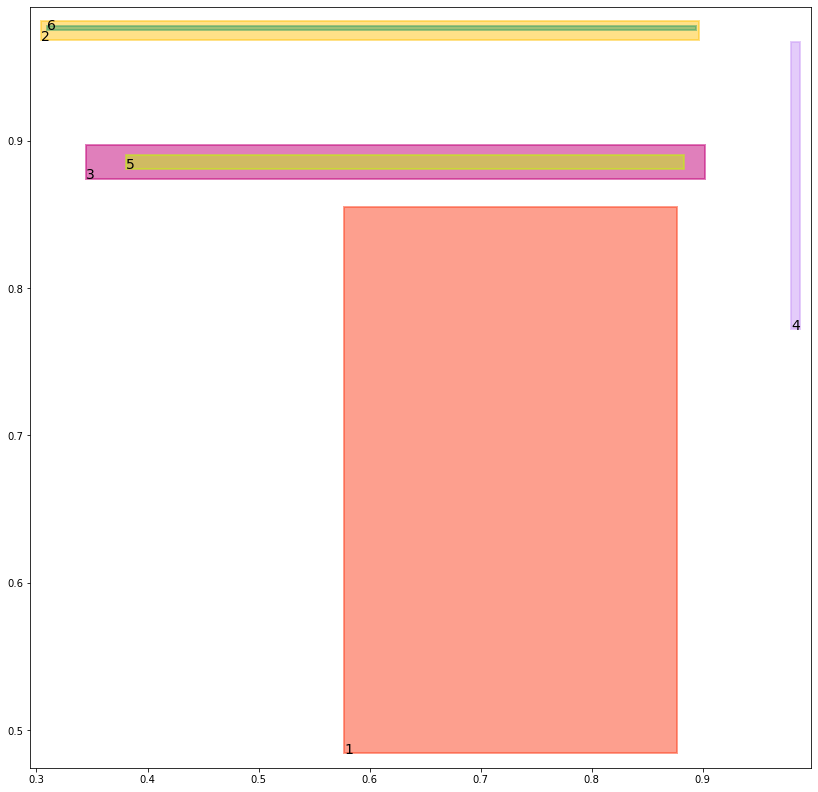

batch (tensor([[4, 6],
        [1, 2],
        [4, 5],
        [6, 2]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -79.3630599975586 -27.873186111450195 tensor(-53.5806884765625000) tensor(-17.9296073913574219)
tensor(2) -83.84664154052734 -29.31361198425293 tensor(-55.6071891784667969) tensor(-16.5364608764648438)
tensor(3) -81.77686309814453 -28.762229919433594 tensor(-54.2493133544921875) tensor(-16.3868408203125000)
tensor(4) -88.10477447509766 -31.224504470825195 tensor(-81.8842086791992188) tensor(-29.1319866180419922)
tensor(5) -80.93412017822266 -28.409526824951172 tensor(-55.7564392089843750) tensor(-17.0307769775390625)
tensor(6) -84.37751770019531 -29.55685806274414 tensor(-54.2290420532226562) tensor(-15.8854675292968750)


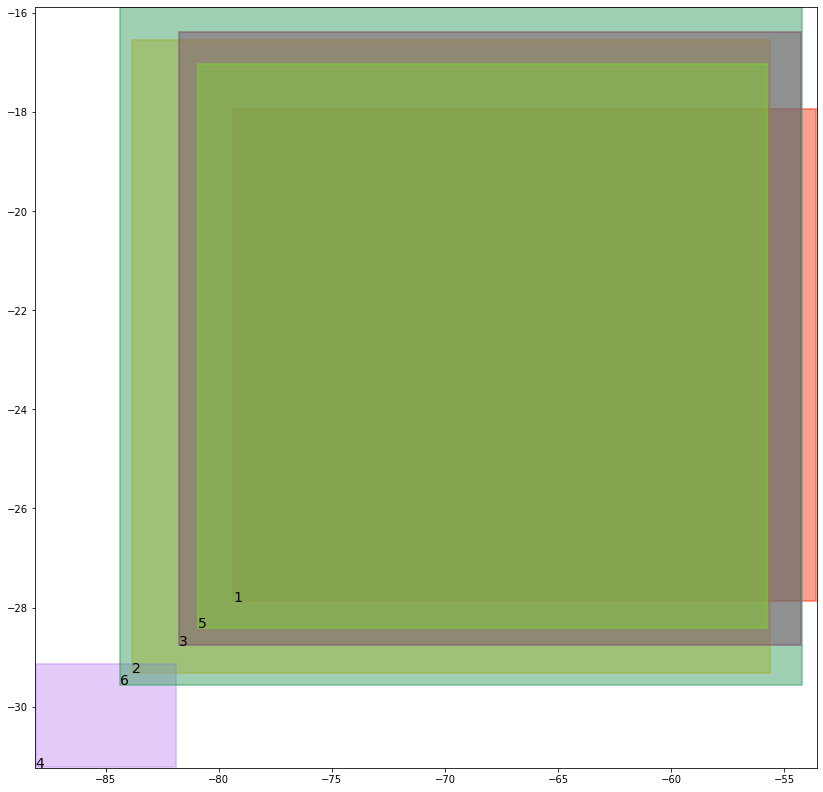

alignment data:
tensor(1) 0.5773119926452637 0.4843326210975647 tensor(0.8764058351516724) tensor(0.8547884225845337)
tensor(2) 0.3207090497016907 0.9705453515052795 tensor(0.8904455304145813) tensor(0.9800761342048645)
tensor(3) 0.3510059416294098 0.8730283975601196 tensor(0.8997981548309326) tensor(0.8975234031677246)
tensor(4) 0.9797705411911011 0.7717846035957336 tensor(0.9877793192863464) tensor(0.9668264985084534)
tensor(5) 0.37416574358940125 0.8825623989105225 tensor(0.8857324123382568) tensor(0.8918108940124512)
tensor(6) 0.292144238948822 0.9746665358543396 tensor(0.9022421240806580) tensor(0.9790921807289124)


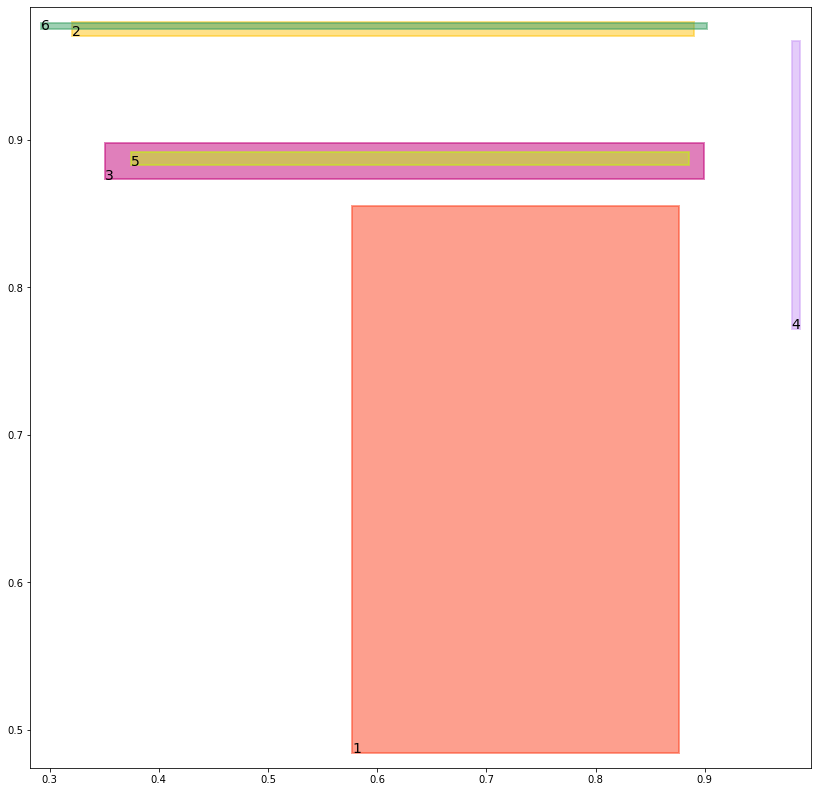

batch (tensor([[1, 2],
        [2, 6],
        [5, 3],
        [6, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -79.4523696899414 -27.913339614868164 tensor(-53.6404609680175781) tensor(-17.9573650360107422)
tensor(2) -83.68636322021484 -29.246488571166992 tensor(-56.3149909973144531) tensor(-16.8461780548095703)
tensor(3) -81.6771469116211 -28.723081588745117 tensor(-54.8640594482421875) tensor(-16.6626777648925781)
tensor(4) -88.1988296508789 -31.266695022583008 tensor(-81.9646987915039062) tensor(-29.1687068939208984)
tensor(5) -81.2990951538086 -28.563047409057617 tensor(-55.2681732177734375) tensor(-16.8048667907714844)
tensor(6) -84.78575897216797 -29.734148025512695 tensor(-53.6637344360351562) tensor(-15.6286296844482422)


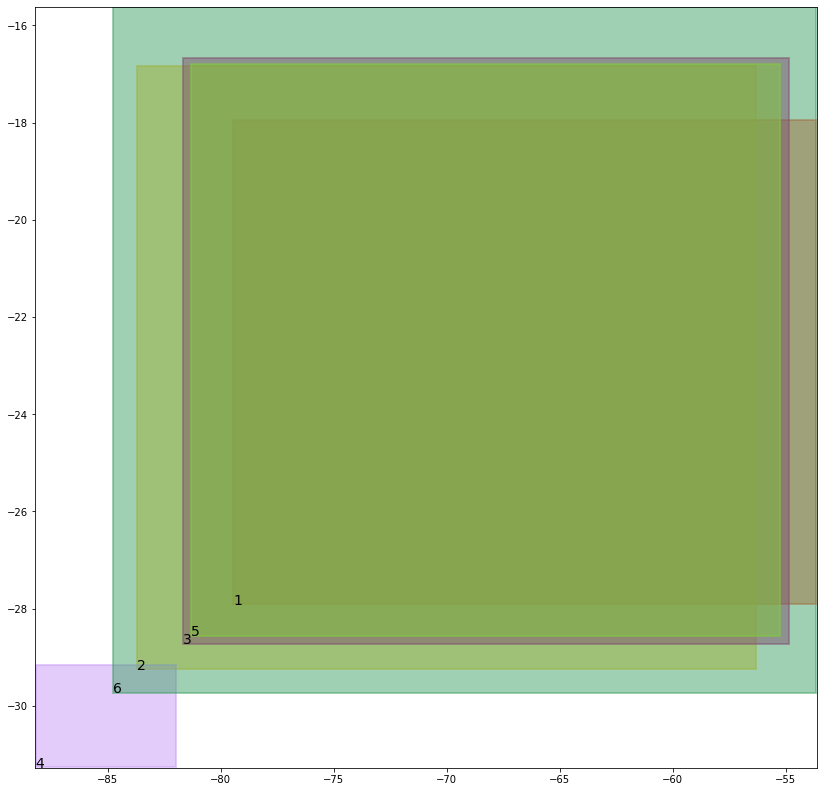

alignment data:
tensor(1) 0.5774856805801392 0.48424795269966125 tensor(0.8764855265617371) tensor(0.8548585176467896)
tensor(2) 0.33163270354270935 0.972907304763794 tensor(0.8859125375747681) tensor(0.9789757132530212)
tensor(3) 0.36118459701538086 0.8736979365348816 tensor(0.8966537117958069) tensor(0.8963358402252197)
tensor(4) 0.9797433018684387 0.771670401096344 tensor(0.9877875447273254) tensor(0.9668462872505188)
tensor(5) 0.3637670576572418 0.88254314661026 tensor(0.8901015520095825) tensor(0.8941636681556702)
tensor(6) 0.2808929681777954 0.9735939502716064 tensor(0.9080688357353210) tensor(0.9804511666297913)


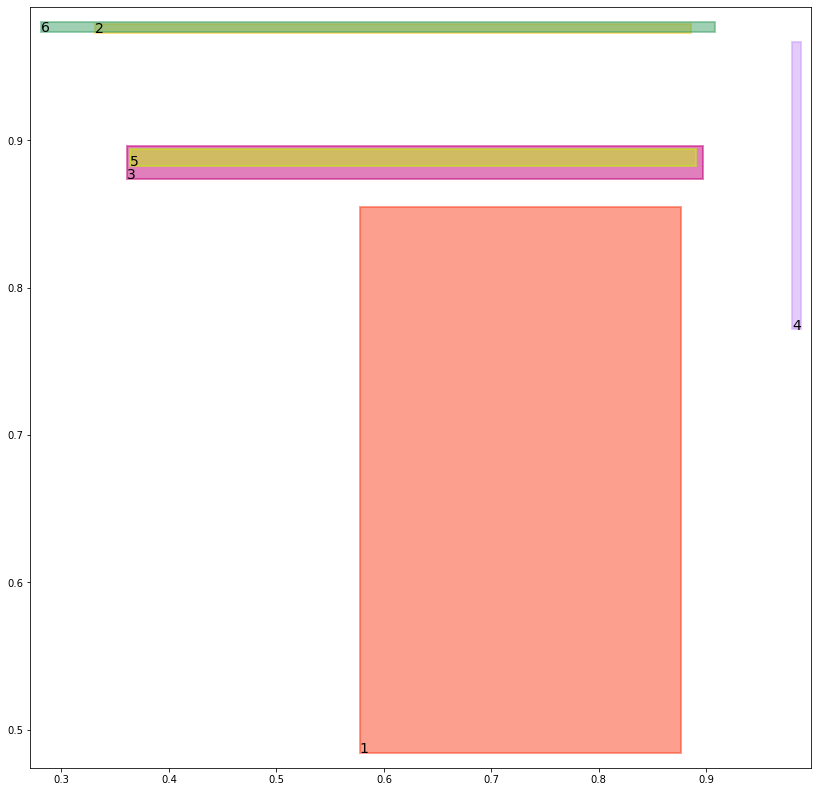

batch (tensor([[1, 3],
        [3, 5],
        [4, 6],
        [4, 5]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -79.53350067138672 -27.9498233795166 tensor(-53.6947631835937500) tensor(-17.9825839996337891)
tensor(2) -83.53215789794922 -29.181852340698242 tensor(-56.9624214172363281) tensor(-17.1304244995117188)
tensor(3) -81.58238983154297 -28.68567657470703 tensor(-55.4289245605468750) tensor(-16.9162883758544922)
tensor(4) -88.2842788696289 -31.30503273010254 tensor(-82.0378189086914062) tensor(-29.2020664215087891)
tensor(5) -81.62377166748047 -28.699623107910156 tensor(-54.8296585083007812) tensor(-16.6018695831298828)
tensor(6) -85.14179229736328 -29.888914108276367 tensor(-53.1604499816894531) tensor(-15.4001102447509766)


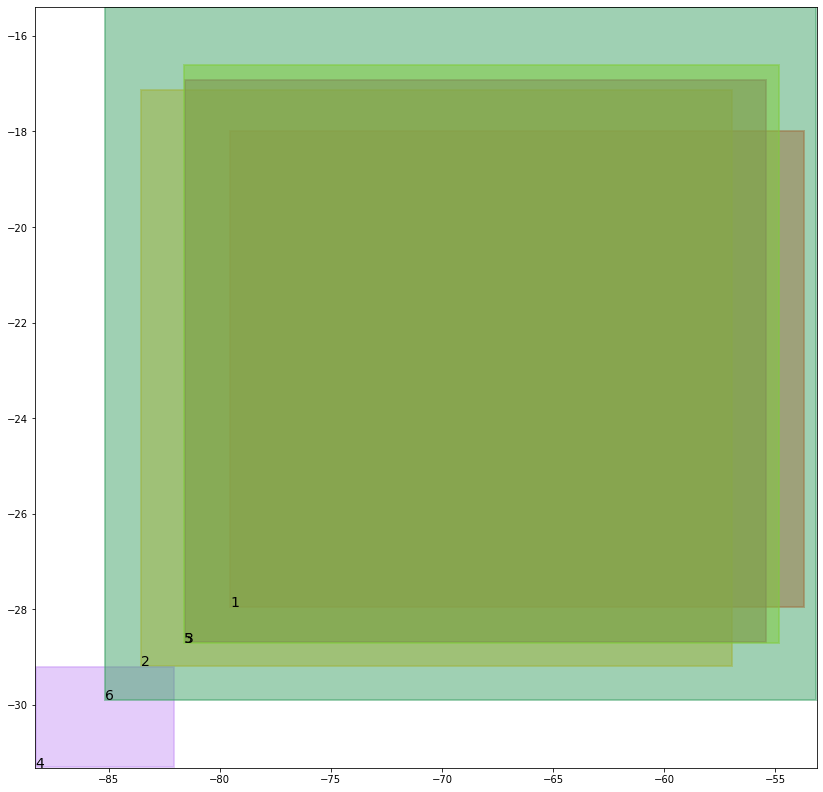

alignment data:
tensor(1) 0.5776433348655701 0.4841710925102234 tensor(0.8765577673912048) tensor(0.8549222350120544)
tensor(2) 0.3417123258113861 0.9748919606208801 tensor(0.8816552162170410) tensor(0.9779249429702759)
tensor(3) 0.37053734064102173 0.8743032813072205 tensor(0.8937228918075562) tensor(0.8952468633651733)
tensor(4) 0.9797185659408569 0.77156662940979 tensor(0.9877951145172119) tensor(0.9668643474578857)
tensor(5) 0.3544328212738037 0.8825258016586304 tensor(0.8939417600631714) tensor(0.8962609171867371)
tensor(6) 0.27090778946876526 0.9725817441940308 tensor(0.9130876064300537) tensor(0.9816100597381592)


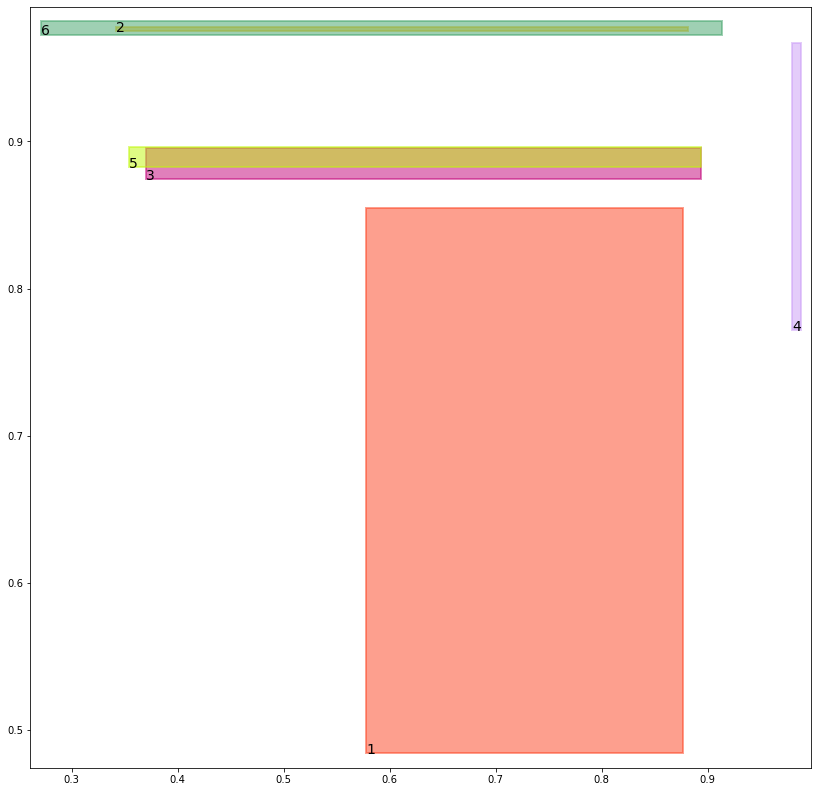

batch (tensor([[4, 6],
        [5, 3],
        [6, 2],
        [1, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -79.60721588134766 -27.982969284057617 tensor(-53.7440795898437500) tensor(-18.0054969787597656)
tensor(2) -83.3847885131836 -29.120052337646484 tensor(-57.5540885925292969) tensor(-17.3909282684326172)
tensor(3) -81.4918441772461 -28.649765014648438 tensor(-56.0277404785156250) tensor(-17.1734447479248047)
tensor(4) -88.36188507080078 -31.339859008789062 tensor(-82.1042175292968750) tensor(-29.2323665618896484)
tensor(5) -81.91313171386719 -28.82134437561035 tensor(-54.3674125671386719) tensor(-16.3990688323974609)
tensor(6) -85.45343780517578 -30.02450942993164 tensor(-52.7174758911132812) tensor(-15.1942625045776367)


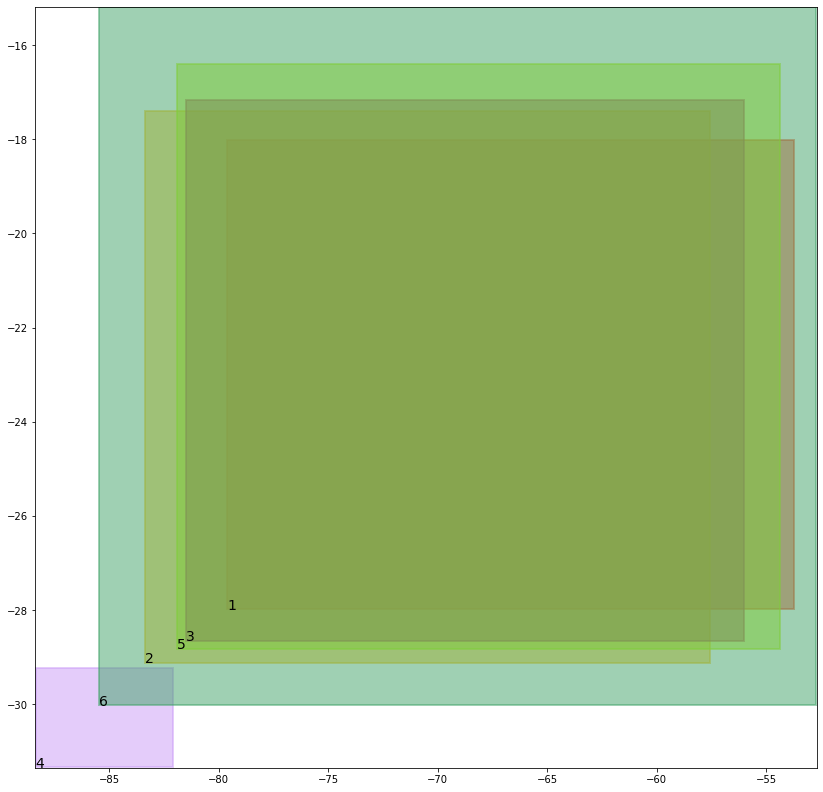

alignment data:
tensor(1) 0.577786386013031 0.4841012954711914 tensor(0.8766233921051025) tensor(0.8549799919128418)
tensor(2) 0.35099029541015625 0.976570725440979 tensor(0.8776712417602539) tensor(0.9769266247749329)
tensor(3) 0.3791561424732208 0.8774357438087463 tensor(0.8909835815429688) tensor(0.8942411541938782)
tensor(4) 0.9796960353851318 0.7714724540710449 tensor(0.9878019690513611) tensor(0.9668806195259094)
tensor(5) 0.3460521996021271 0.8802595138549805 tensor(0.8973255157470703) tensor(0.8981333971023560)
tensor(6) 0.26203712821006775 0.9716300368309021 tensor(0.9174286127090454) tensor(0.9826038479804993)


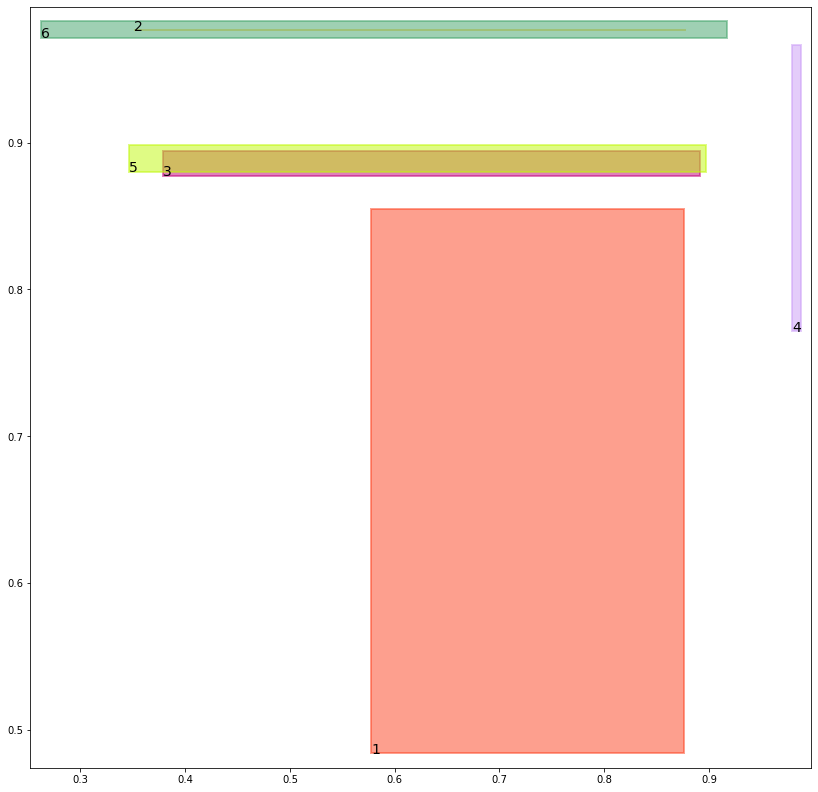

batch (tensor([[2, 6],
        [1, 3],
        [3, 5],
        [4, 5]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -79.67414855957031 -28.013076782226562 tensor(-53.7888755798339844) tensor(-18.0263099670410156)
tensor(2) -83.4249038696289 -29.135082244873047 tensor(-57.6846313476562500) tensor(-17.4488182067871094)
tensor(3) -81.59236907958984 -28.690141677856445 tensor(-56.1965332031250000) tensor(-17.2354736328125000)
tensor(4) -88.4323959350586 -31.37149429321289 tensor(-82.1645126342773438) tensor(-29.2598819732666016)
tensor(5) -82.0019302368164 -28.86246109008789 tensor(-54.2925872802734375) tensor(-16.3727531433105469)
tensor(6) -85.6567611694336 -30.113487243652344 tensor(-52.6240158081054688) tensor(-15.1482086181640625)


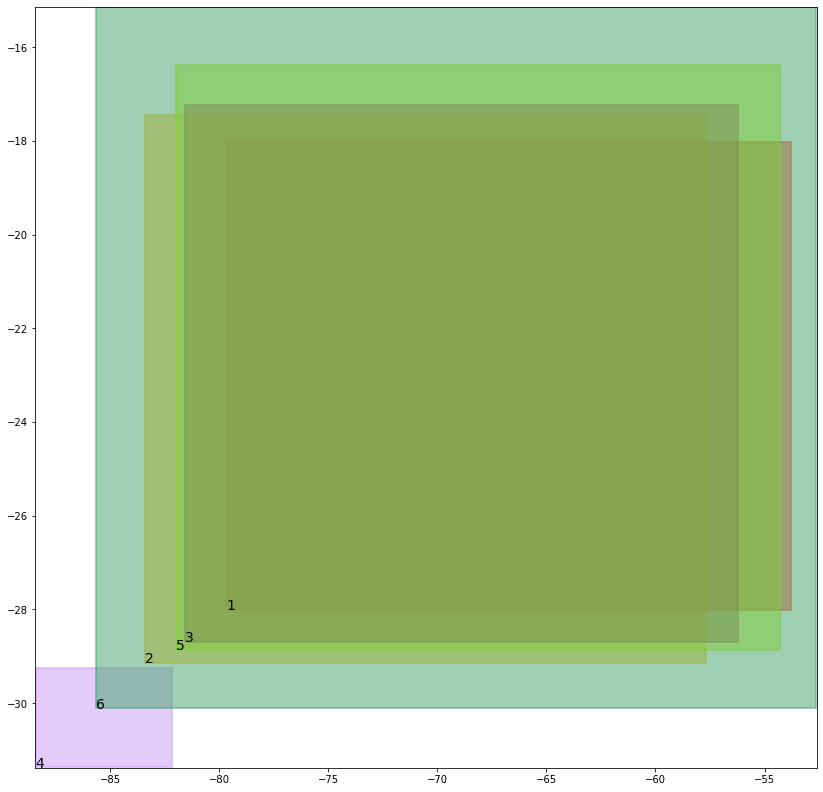

alignment data:
tensor(1) 0.5779163837432861 0.48403793573379517 tensor(0.8766829371452332) tensor(0.8550323843955994)
tensor(2) 0.3526015877723694 0.9765224456787109 tensor(0.8767201900482178) tensor(0.9775576591491699)
tensor(3) 0.3798976540565491 0.8802212476730347 tensor(0.8910492062568665) tensor(0.8953275084495544)
tensor(4) 0.9796755313873291 0.7713868021965027 tensor(0.9878082871437073) tensor(0.9668955802917480)
tensor(5) 0.34497177600860596 0.8782334923744202 tensor(0.8979742527008057) tensor(0.8979166150093079)
tensor(6) 0.2595466375350952 0.9713714122772217 tensor(0.9199270009994507) tensor(0.9831410646438599)


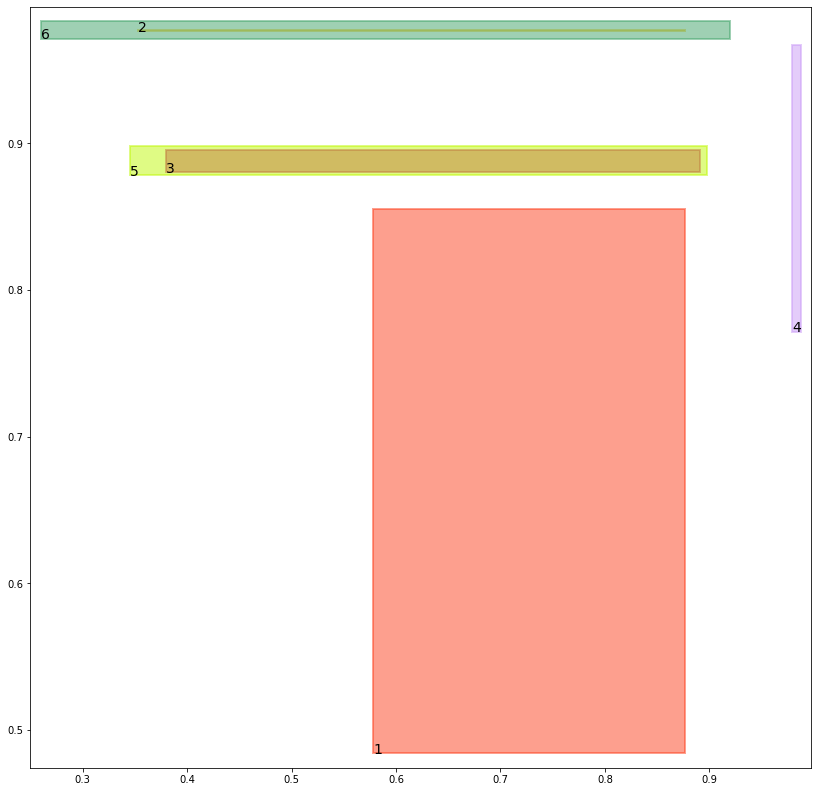

batch (tensor([[6, 2],
        [3, 5],
        [1, 2],
        [4, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -79.73493957519531 -28.040414810180664 tensor(-53.8295516967773438) tensor(-18.0452117919921875)
tensor(2) -83.4698715209961 -29.151233673095703 tensor(-57.7933692932128906) tensor(-17.4985122680664062)
tensor(3) -81.86144256591797 -28.79796600341797 tensor(-55.9107131958007812) tensor(-17.1025447845458984)
tensor(4) -88.49639129638672 -31.40021514892578 tensor(-82.2192611694335938) tensor(-29.2848682403564453)
tensor(5) -81.9130859375 -28.83238410949707 tensor(-54.6332817077636719) tensor(-16.5242004394531250)
tensor(6) -85.8382339477539 -30.192943572998047 tensor(-52.5396423339843750) tensor(-15.1066274642944336)


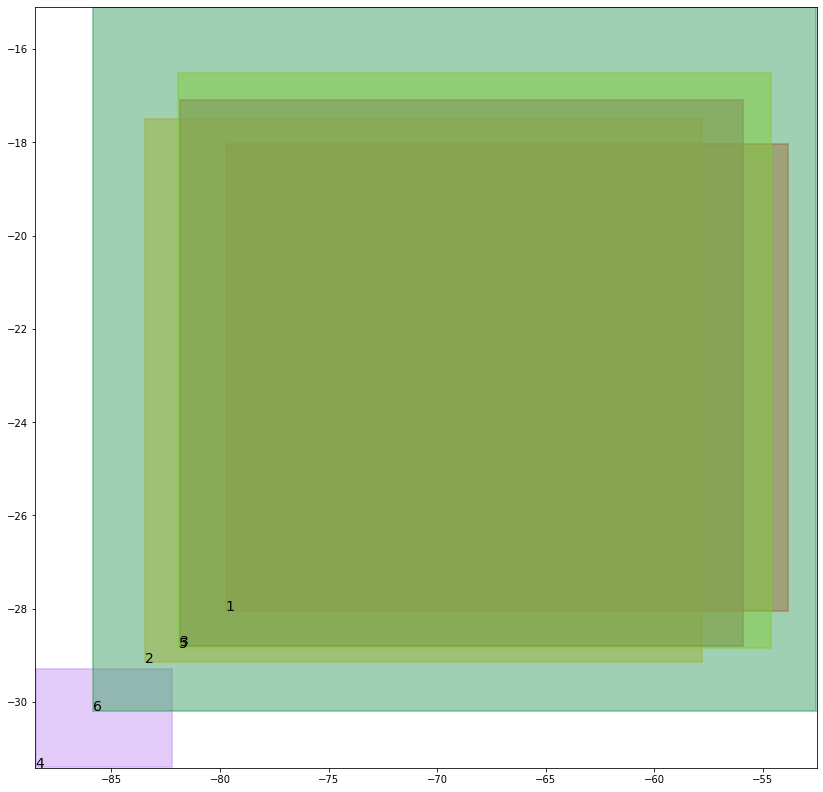

alignment data:
tensor(1) 0.5780342817306519 0.4839804172515869 tensor(0.8767368793487549) tensor(0.8550799489021301)
tensor(2) 0.3540671169757843 0.9761493802070618 tensor(0.8758512735366821) tensor(0.9784182906150818)
tensor(3) 0.3736709654331207 0.8802916407585144 tensor(0.8936059474945068) tensor(0.8982248306274414)
tensor(4) 0.9796568751335144 0.7713091373443604 tensor(0.9878138303756714) tensor(0.9669090509414673)
tensor(5) 0.3503192961215973 0.878843367099762 tensor(0.8962397575378418) tensor(0.8958063125610352)
tensor(6) 0.2572992742061615 0.9711345434188843 tensor(0.9221351146697998) tensor(0.9836146235466003)


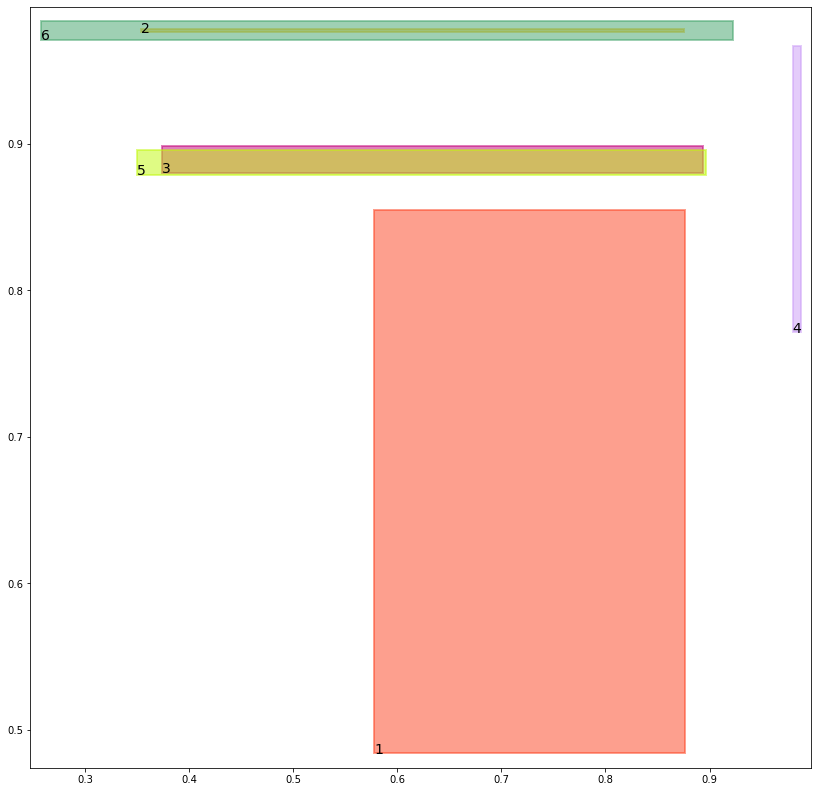

batch (tensor([[4, 5],
        [2, 6],
        [5, 3],
        [1, 3]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -79.7901382446289 -28.065242767333984 tensor(-53.8664817810058594) tensor(-18.0623760223388672)
tensor(2) -83.65203094482422 -29.227935791015625 tensor(-57.5184707641601562) tensor(-17.3751602172851562)
tensor(3) -82.04419708251953 -28.877132415771484 tensor(-55.6535606384277344) tensor(-16.9828891754150391)
tensor(4) -88.55450439453125 -31.42629623413086 tensor(-82.2689590454101562) tensor(-29.3075523376464844)
tensor(5) -81.89005279541016 -28.822132110595703 tensor(-54.9445190429687500) tensor(-16.6626205444335938)
tensor(6) -85.9355697631836 -30.236156463623047 tensor(-52.7567291259765625) tensor(-15.2048816680908203)


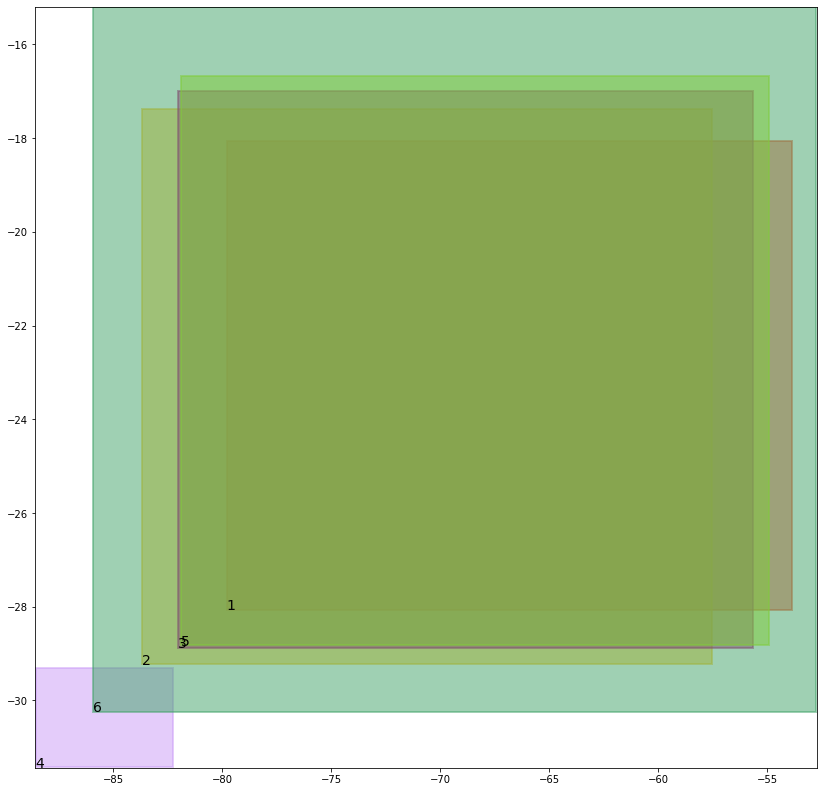

alignment data:
tensor(1) 0.5781413316726685 0.48392820358276367 tensor(0.8767859339714050) tensor(0.8551231622695923)
tensor(2) 0.3486522436141968 0.9752457141876221 tensor(0.8778045773506165) tensor(0.9795381426811218)
tensor(3) 0.36806720495224 0.8803583383560181 tensor(0.8958764076232910) tensor(0.8989184498786926)
tensor(4) 0.9796400666236877 0.7712386250495911 tensor(0.9878189563751221) tensor(0.9669212102890015)
tensor(5) 0.355205774307251 0.87939453125 tensor(0.8946429491043091) tensor(0.8958112597465515)
tensor(6) 0.26054736971855164 0.9715580344200134 tensor(0.9229202270507812) tensor(0.9837411642074585)


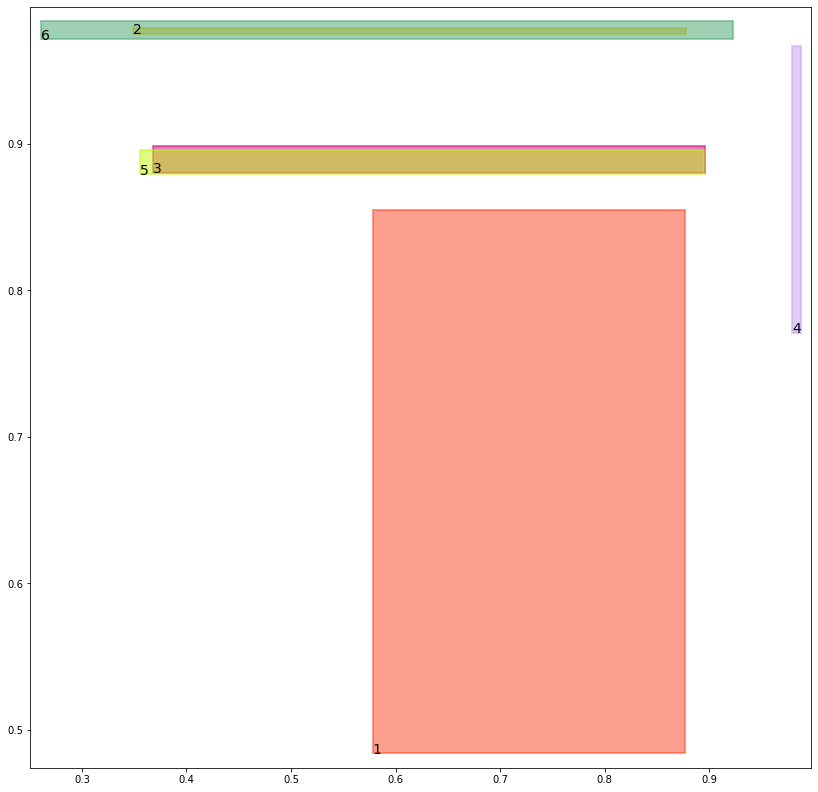

batch (tensor([[6, 2],
        [1, 3],
        [4, 6],
        [2, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -79.8402328491211 -28.08778190612793 tensor(-53.9000015258789062) tensor(-18.0779552459716797)
tensor(2) -83.94872283935547 -29.355392456054688 tensor(-56.9100952148437500) tensor(-17.1017894744873047)
tensor(3) -82.20832061767578 -28.94822120666504 tensor(-55.4215240478515625) tensor(-16.8748798370361328)
tensor(4) -88.60726165771484 -31.449975967407227 tensor(-82.3140563964843750) tensor(-29.3281421661376953)
tensor(5) -81.8681869506836 -28.81239128112793 tensor(-55.2285957336425781) tensor(-16.7890148162841797)
tensor(6) -85.95925903320312 -30.24762725830078 tensor(-53.2498855590820312) tensor(-15.4301786422729492)


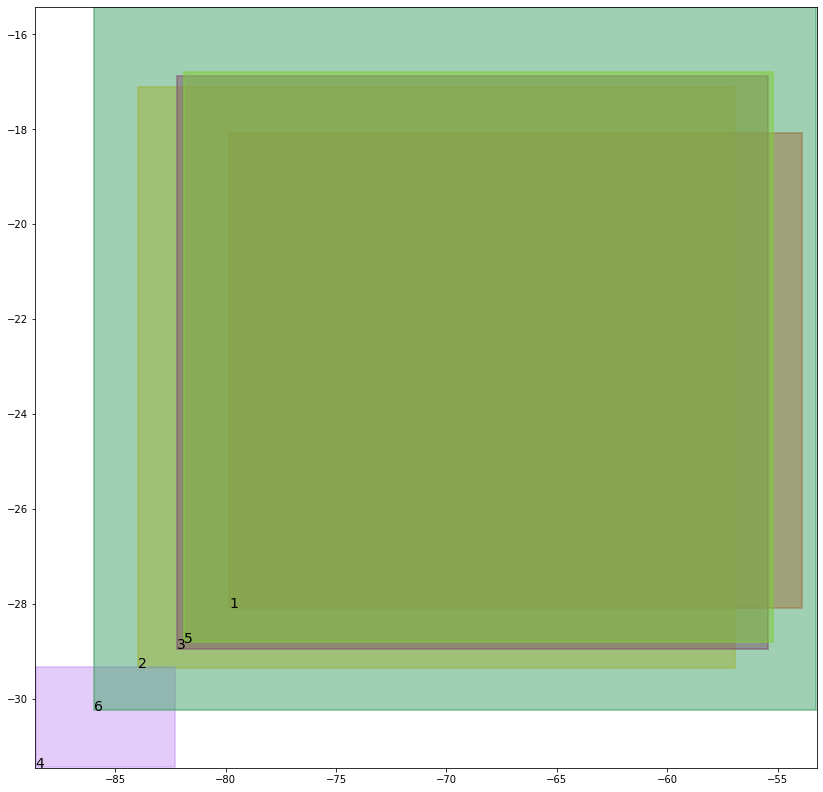

alignment data:
tensor(1) 0.5782384276390076 0.48388081789016724 tensor(0.8768303394317627) tensor(0.8551623225212097)
tensor(2) 0.33732348680496216 0.9737884402275085 tensor(0.8821449279785156) tensor(0.9808324575424194)
tensor(3) 0.36301225423812866 0.8804188370704651 tensor(0.8978997468948364) tensor(0.8995441198348999)
tensor(4) 0.9796246290206909 0.7711745500564575 tensor(0.9878236055374146) tensor(0.9669323563575745)
tensor(5) 0.35966673493385315 0.8798928260803223 tensor(0.8931750059127808) tensor(0.8958156704902649)
tensor(6) 0.26881876587867737 0.9725381135940552 tensor(0.9224654436111450) tensor(0.9835644960403442)


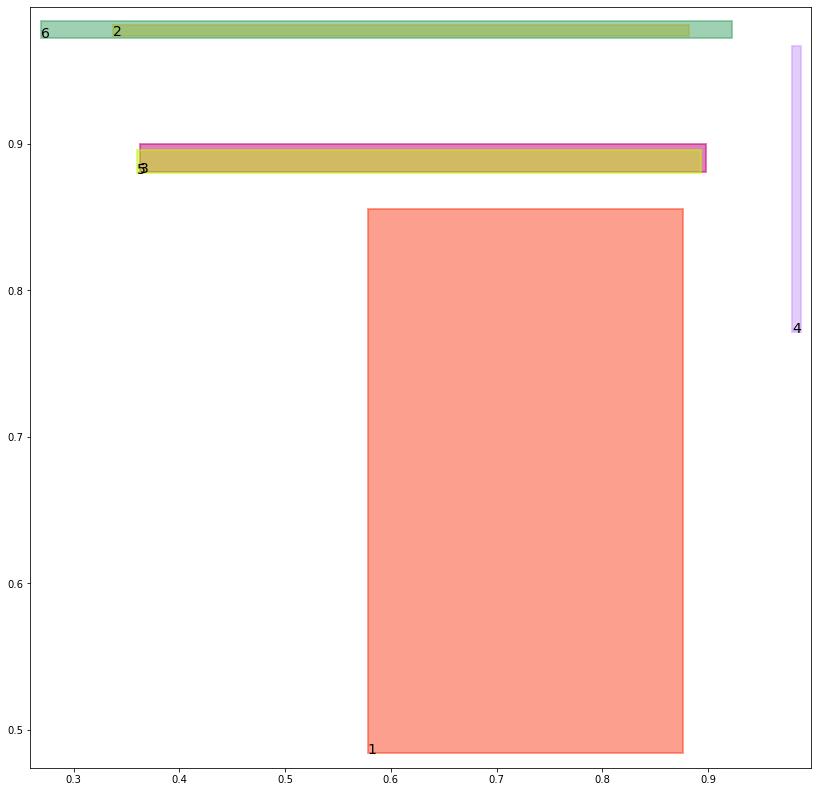

batch (tensor([[1, 2],
        [3, 5],
        [5, 3],
        [4, 5]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -79.8857192993164 -28.10824203491211 tensor(-53.9304275512695312) tensor(-18.0921001434326172)
tensor(2) -84.21051025390625 -29.468034744262695 tensor(-56.3636550903320312) tensor(-16.8566093444824219)
tensor(3) -82.18744659423828 -28.945024490356445 tensor(-54.7887840270996094) tensor(-16.5953750610351562)
tensor(4) -88.65514373779297 -31.47146987915039 tensor(-82.3550033569335938) tensor(-29.3468322753906250)
tensor(5) -82.02667236328125 -28.874900817871094 tensor(-55.9039535522460938) tensor(-17.0836734771728516)
tensor(6) -85.98058319091797 -30.257970809936523 tensor(-53.7104797363281250) tensor(-15.6354627609252930)


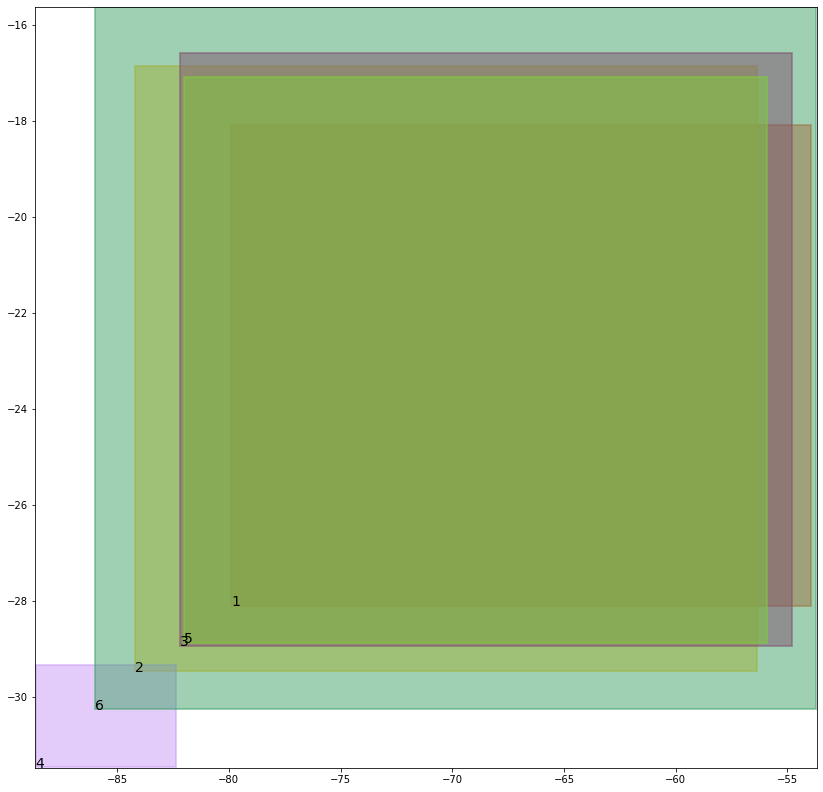

alignment data:
tensor(1) 0.5783266425132751 0.4838378131389618 tensor(0.8768706917762756) tensor(0.8551979064941406)
tensor(2) 0.3272022604942322 0.9723940491676331 tensor(0.8859673142433167) tensor(0.9819372296333313)
tensor(3) 0.35187336802482605 0.8780035376548767 tensor(0.8973898887634277) tensor(0.8982300162315369)
tensor(4) 0.979610800743103 0.7711164951324463 tensor(0.9878277778625488) tensor(0.9669423699378967)
tensor(5) 0.3702479302883148 0.8826964497566223 tensor(0.8943377733230591) tensor(0.8977458477020264)
tensor(6) 0.27646657824516296 0.9733989238739014 tensor(0.9220508337020874) tensor(0.9834026098251343)


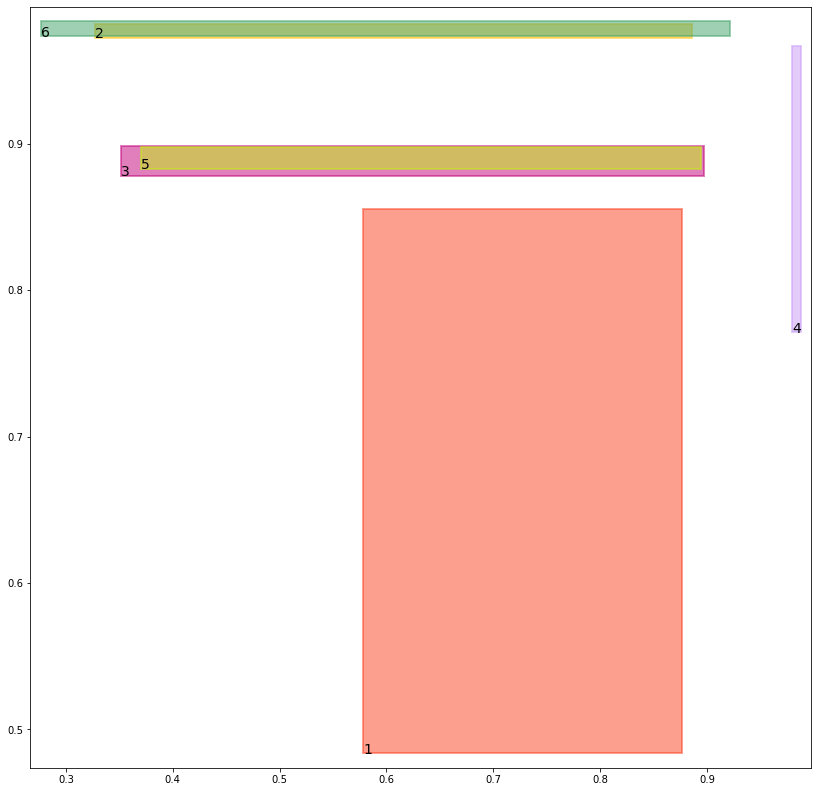

batch (tensor([[6, 2],
        [4, 5],
        [1, 3],
        [3, 5]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -79.92698669433594 -28.126811981201172 tensor(-53.9580383300781250) tensor(-18.1049365997314453)
tensor(2) -84.4419937133789 -29.567777633666992 tensor(-55.8972091674804688) tensor(-16.6439933776855469)
tensor(3) -82.16796112060547 -28.941936492919922 tensor(-54.2202758789062500) tensor(-16.3444728851318359)
tensor(4) -88.69860076904297 -31.490976333618164 tensor(-82.3921585083007812) tensor(-29.3637905120849609)
tensor(5) -82.1692886352539 -28.931201934814453 tensor(-56.5215682983398438) tensor(-17.3535194396972656)
tensor(6) -85.99979400634766 -30.26729393005371 tensor(-54.1185913085937500) tensor(-15.8198604583740234)


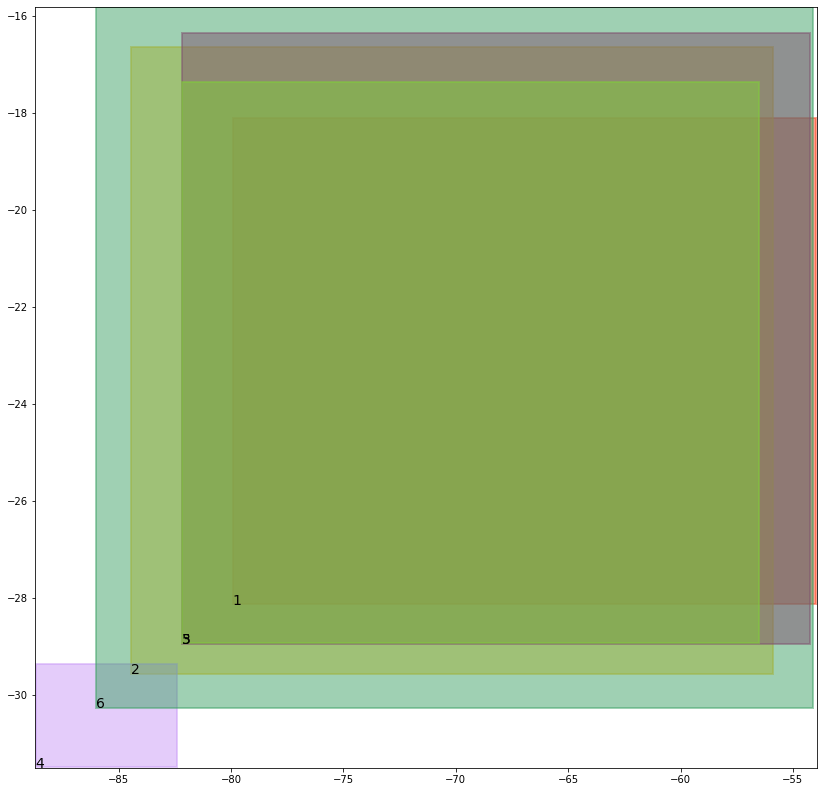

alignment data:
tensor(1) 0.578406572341919 0.4837988018989563 tensor(0.8769072890281677) tensor(0.8552301526069641)
tensor(2) 0.31816035509109497 0.9718611836433411 tensor(0.8893398046493530) tensor(0.9828853607177734)
tensor(3) 0.341903954744339 0.8757758140563965 tensor(0.8969253301620483) tensor(0.8970245122909546)
tensor(4) 0.9795981049537659 0.7710638046264648 tensor(0.9878316521644592) tensor(0.9669514894485474)
tensor(5) 0.3799579441547394 0.8851909637451172 tensor(0.8953828811645508) tensor(0.8994695544242859)
tensor(6) 0.28352078795433044 0.9736474752426147 tensor(0.9216728210449219) tensor(0.9832542538642883)


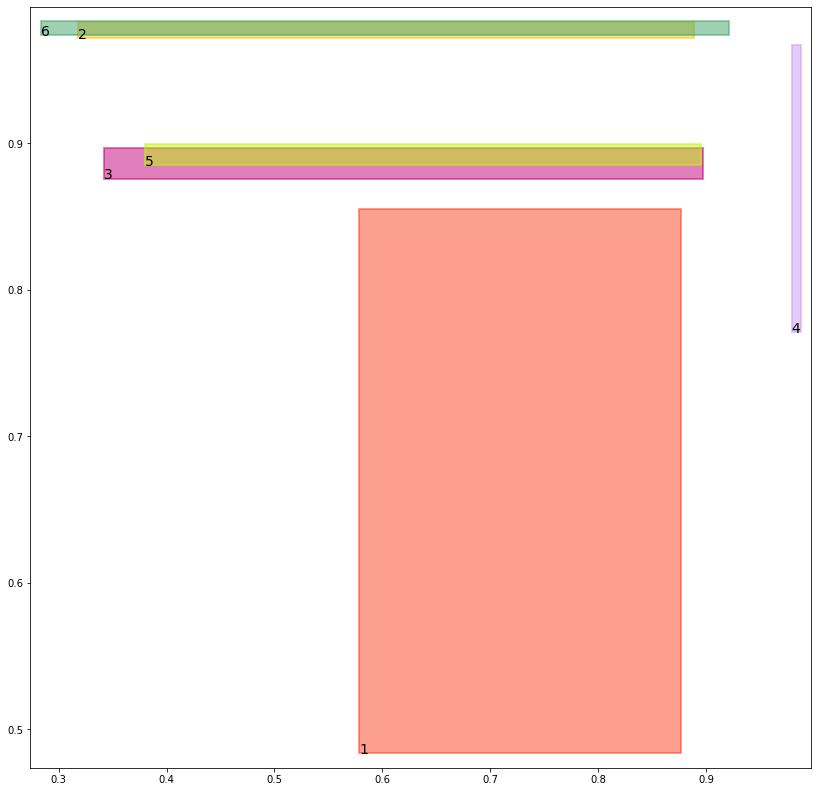

batch (tensor([[2, 6],
        [1, 2],
        [4, 6],
        [5, 3]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -79.96443939208984 -28.14366340637207 tensor(-53.9830932617187500) tensor(-18.1165828704833984)
tensor(2) -84.76056671142578 -29.706222534179688 tensor(-55.1649703979492188) tensor(-16.3094120025634766)
tensor(3) -82.0332260131836 -28.886768341064453 tensor(-54.1405563354492188) tensor(-16.3035755157470703)
tensor(4) -88.73802947998047 -31.508676528930664 tensor(-82.4258651733398438) tensor(-29.3791809082031250)
tensor(5) -82.40945434570312 -29.03226089477539 tensor(-56.6511001586914062) tensor(-17.4117660522460938)
tensor(6) -85.94940948486328 -30.246681213378906 tensor(-54.8045196533203125) tensor(-16.1318168640136719)


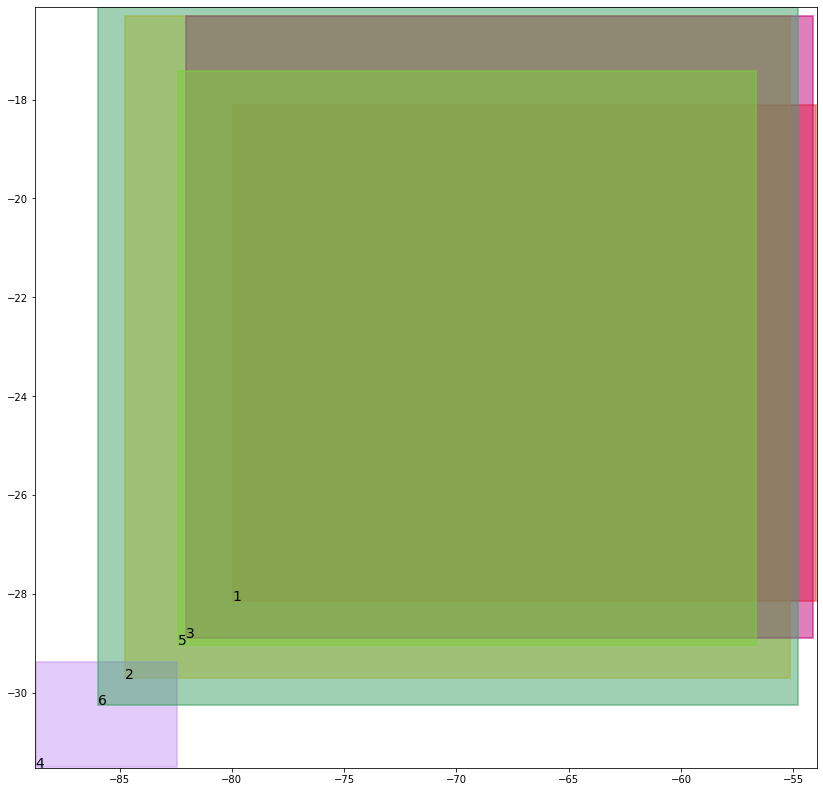

alignment data:
tensor(1) 0.5784791111946106 0.4837633967399597 tensor(0.8769404292106628) tensor(0.8552593588829041)
tensor(2) 0.30413126945495605 0.9713690280914307 tensor(0.8945364952087402) tensor(0.9839457869529724)
tensor(3) 0.3395496606826782 0.876449465751648 tensor(0.8941036462783813) tensor(0.8958604335784912)
tensor(4) 0.979586660861969 0.7710158824920654 tensor(0.9878351092338562) tensor(0.9669597744941711)
tensor(5) 0.38190996646881104 0.8852208852767944 tensor(0.8986589312553406) tensor(0.9010109901428223)
tensor(6) 0.29586660861968994 0.9738926887512207 tensor(0.9201135635375977) tensor(0.9828073978424072)


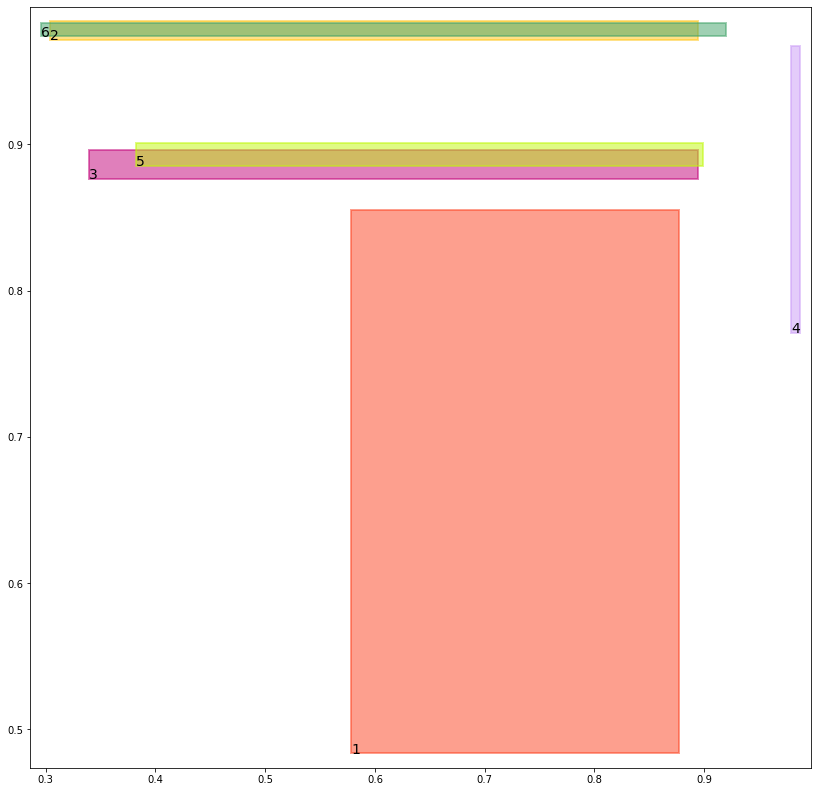

batch (tensor([[1, 3],
        [1, 2],
        [5, 3],
        [2, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -79.99842071533203 -28.158952713012695 tensor(-54.0058288574218750) tensor(-18.1271514892578125)
tensor(2) -85.1346664428711 -29.87039566040039 tensor(-54.2235183715820312) tensor(-15.8787794113159180)
tensor(3) -81.90312957763672 -28.833520889282227 tensor(-54.4876632690429688) tensor(-16.4460544586181641)
tensor(4) -88.77379608154297 -31.524736404418945 tensor(-82.4564437866210938) tensor(-29.3931369781494141)
tensor(5) -82.62313079833984 -29.12213706970215 tensor(-56.3451995849609375) tensor(-17.2812213897705078)
tensor(6) -85.8414077758789 -30.200010299682617 tensor(-55.7609291076660156) tensor(-16.5680294036865234)


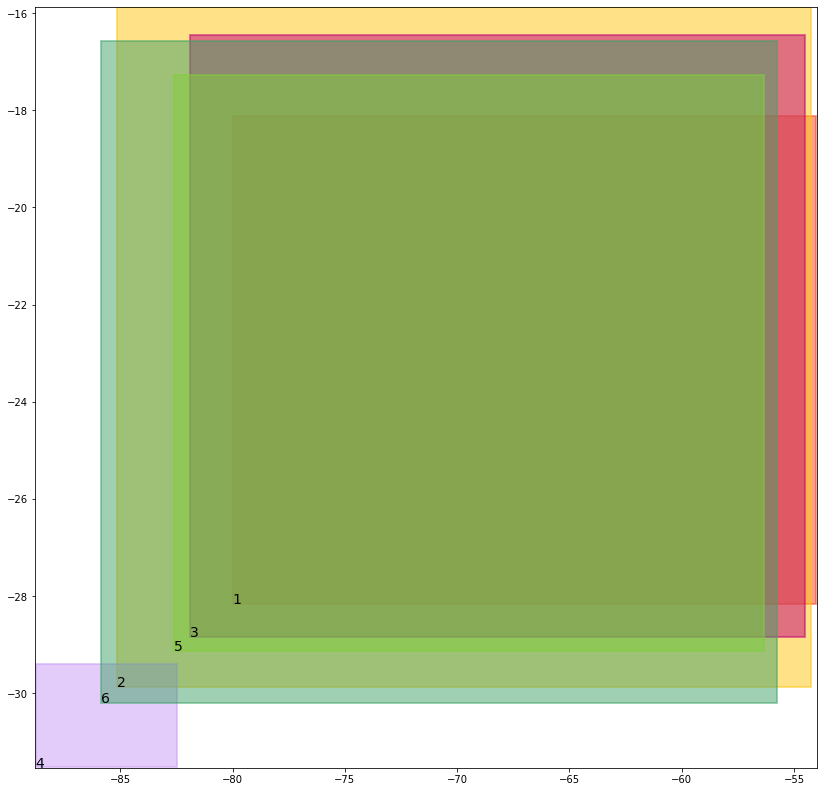

alignment data:
tensor(1) 0.5785449147224426 0.48373129963874817 tensor(0.8769705295562744) tensor(0.8552858829498291)
tensor(2) 0.2861842215061188 0.9709154963493347 tensor(0.9010603427886963) tensor(0.9848517775535583)
tensor(3) 0.3438328504562378 0.8796631097793579 tensor(0.8914297223091125) tensor(0.8947304487228394)
tensor(4) 0.9795761108398438 0.770972490310669 tensor(0.9878382682800293) tensor(0.9669673442840576)
tensor(5) 0.37695375084877014 0.8830484747886658 tensor(0.9015516042709351) tensor(0.9023910164833069)
tensor(6) 0.3133624792098999 0.9741239547729492 tensor(0.9174097776412964) tensor(0.9823849797248840)


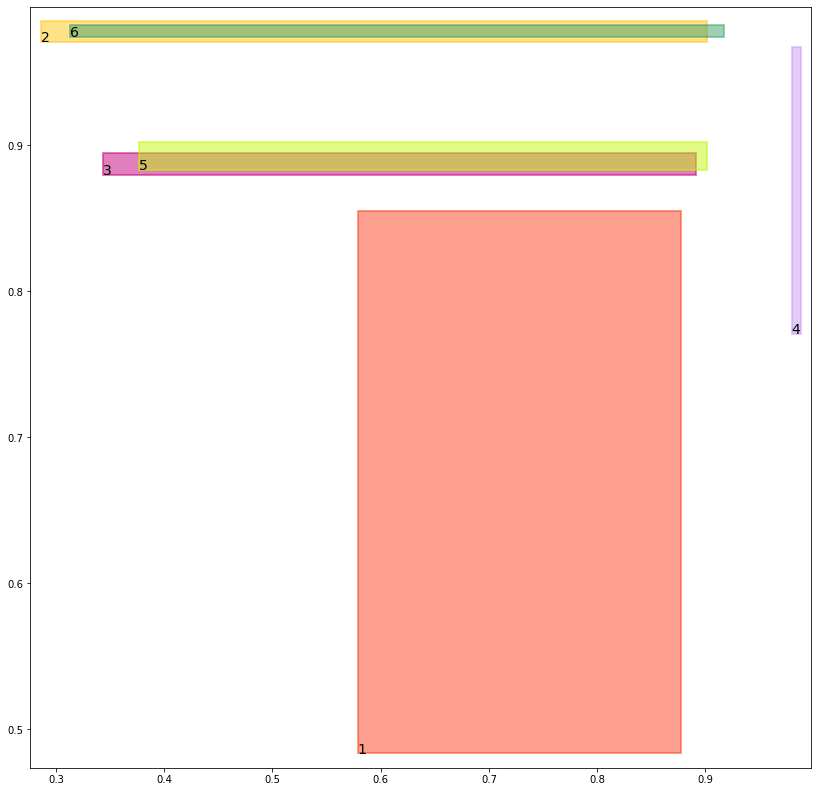

batch (tensor([[3, 5],
        [6, 2],
        [4, 6],
        [4, 5]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.02923583984375 -28.172821044921875 tensor(-54.0264396667480469) tensor(-18.1367397308349609)
tensor(2) -85.45028686523438 -30.009815216064453 tensor(-53.7211189270019531) tensor(-15.6450958251953125)
tensor(3) -81.9701156616211 -28.859037399291992 tensor(-54.8019828796386719) tensor(-16.5753593444824219)
tensor(4) -88.8062515258789 -31.539310455322266 tensor(-82.4841842651367188) tensor(-29.4058055877685547)
tensor(5) -82.65477752685547 -29.13896369934082 tensor(-56.0717811584472656) tensor(-17.1646957397460938)
tensor(6) -85.75006103515625 -30.159120559692383 tensor(-56.2816085815429688) tensor(-16.8071899414062500)


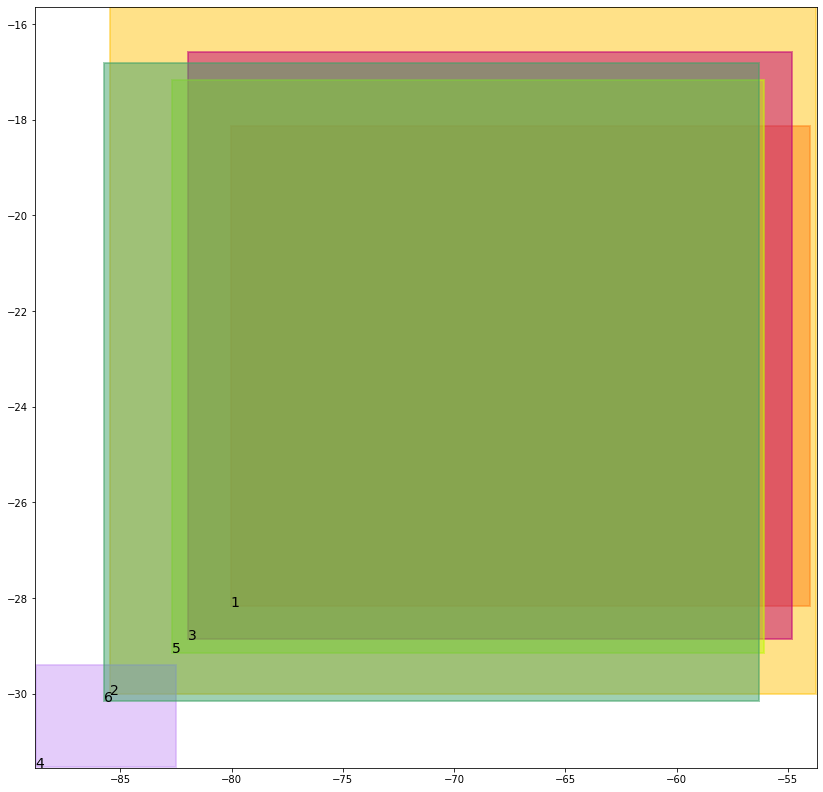

alignment data:
tensor(1) 0.5786045789718628 0.4837021827697754 tensor(0.8769978284835815) tensor(0.8553099632263184)
tensor(2) 0.2760530114173889 0.9713692665100098 tensor(0.9066393375396729) tensor(0.9854223728179932)
tensor(3) 0.34773996472358704 0.8825153708457947 tensor(0.8915587663650513) tensor(0.8957468271255493)
tensor(4) 0.979566752910614 0.7709330916404724 tensor(0.9878411889076233) tensor(0.9669741392135620)
tensor(5) 0.37254273891448975 0.8810710906982422 tensor(0.9019369482994080) tensor(0.9018508195877075)
tensor(6) 0.3229672312736511 0.9738264083862305 tensor(0.9148855805397034) tensor(0.9823312759399414)


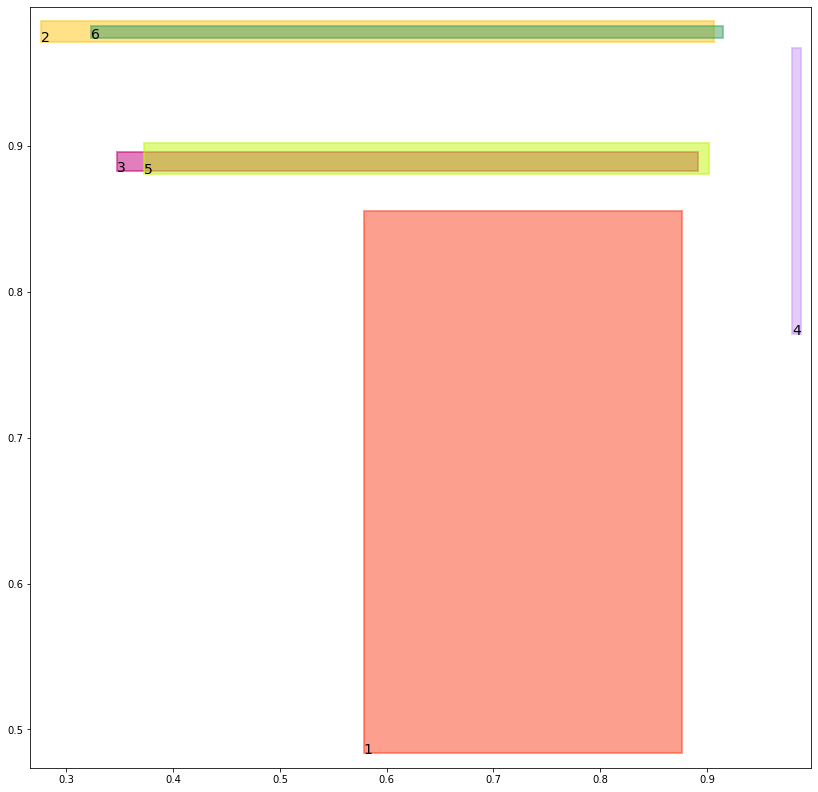

batch (tensor([[3, 5],
        [6, 2],
        [1, 2],
        [4, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.05719757080078 -28.185405731201172 tensor(-54.0451431274414062) tensor(-18.1454372406005859)
tensor(2) -85.71663665771484 -30.128313064575195 tensor(-53.5821075439453125) tensor(-15.5744018554687500)
tensor(3) -82.21127319335938 -28.95429039001465 tensor(-55.0137939453125000) tensor(-16.6709461212158203)
tensor(4) -88.8356704711914 -31.552522659301758 tensor(-82.5093383789062500) tensor(-29.4172916412353516)
tensor(5) -82.5233383178711 -29.090566635131836 tensor(-55.9005241394042969) tensor(-17.0825653076171875)
tensor(6) -85.6744155883789 -30.123748779296875 tensor(-56.3917732238769531) tensor(-16.8606548309326172)


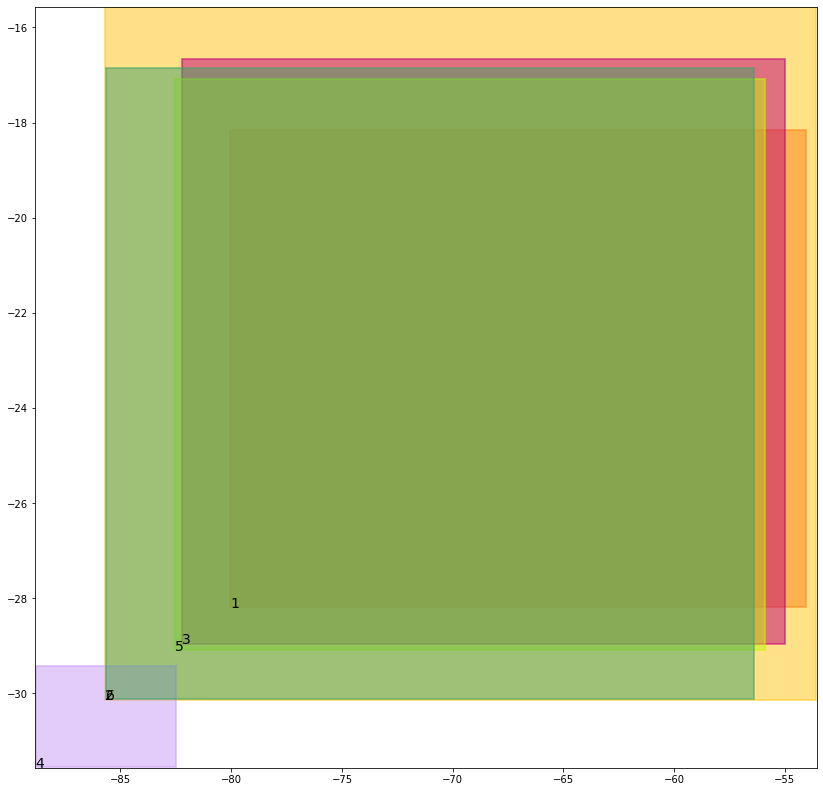

alignment data:
tensor(1) 0.5786586999893188 0.4836758077144623 tensor(0.8770226240158081) tensor(0.8553317785263062)
tensor(2) 0.2723821699619293 0.9725825190544128 tensor(0.9114186763763428) tensor(0.9857243895530701)
tensor(3) 0.35130128264427185 0.8826706409454346 tensor(0.8941807746887207) tensor(0.8986316919326782)
tensor(4) 0.9795581698417664 0.7708973288536072 tensor(0.9878437519073486) tensor(0.9669802784919739)
tensor(5) 0.3686228096485138 0.881651759147644 tensor(0.9001106023788452) tensor(0.8995432853698730)
tensor(6) 0.3251432180404663 0.9730326533317566 tensor(0.9125361442565918) tensor(0.9826129674911499)


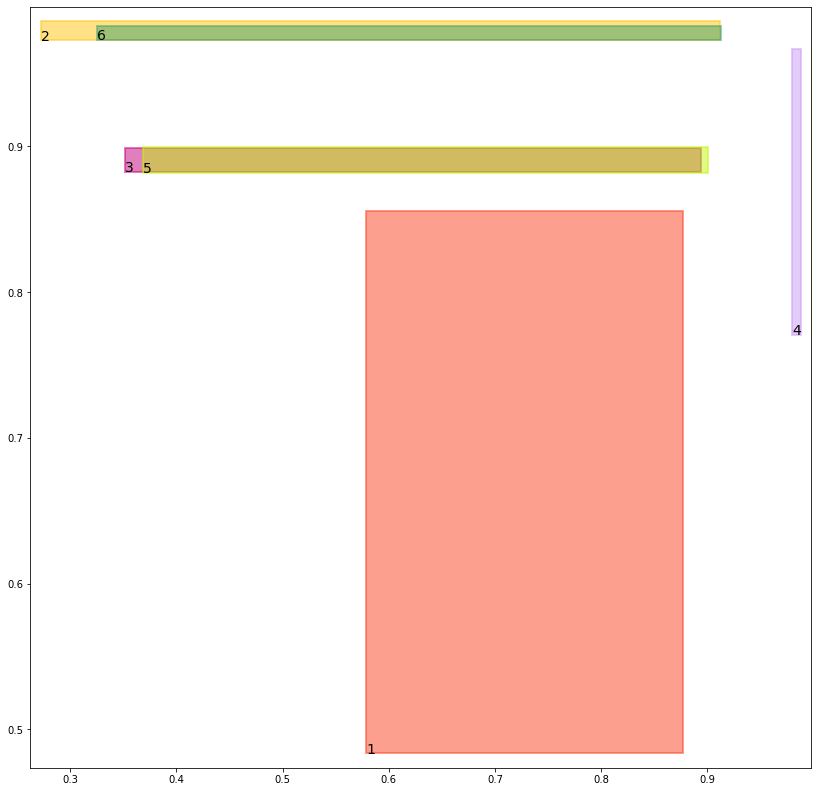

batch (tensor([[5, 3],
        [1, 3],
        [4, 5],
        [2, 6]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.08255767822266 -28.196821212768555 tensor(-54.0621032714843750) tensor(-18.1533260345458984)
tensor(2) -86.01995086669922 -30.26362419128418 tensor(-53.4560585021972656) tensor(-15.5105037689208984)
tensor(3) -82.42450714111328 -29.038593292236328 tensor(-55.5563240051269531) tensor(-16.9182224273681641)
tensor(4) -88.86238098144531 -31.56450843811035 tensor(-82.5321578979492188) tensor(-29.4277076721191406)
tensor(5) -82.40152740478516 -29.045690536499023 tensor(-55.4000053405761719) tensor(-16.8497753143310547)
tensor(6) -85.53126525878906 -30.058107376098633 tensor(-56.4916000366210938) tensor(-16.9092082977294922)


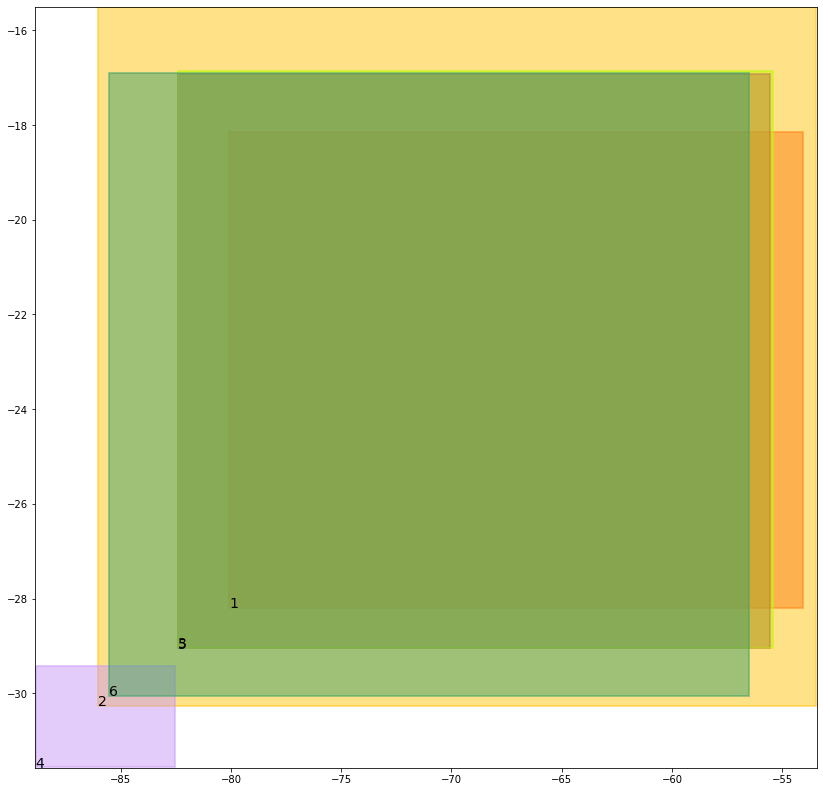

alignment data:
tensor(1) 0.5787078142166138 0.4836518168449402 tensor(0.8770450353622437) tensor(0.8553515672683716)
tensor(2) 0.2690798044204712 0.9736396074295044 tensor(0.9170432090759277) tensor(0.9859927892684937)
tensor(3) 0.3611253499984741 0.8828377723693848 tensor(0.8964945673942566) tensor(0.9011653661727905)
tensor(4) 0.9795503616333008 0.7708649635314941 tensor(0.9878460764884949) tensor(0.9669858217239380)
tensor(5) 0.35855814814567566 0.8821763396263123 tensor(0.8984283208847046) tensor(0.8974090218544006)
tensor(6) 0.3271256983280182 0.9722930192947388 tensor(0.9088525772094727) tensor(0.9828644990921021)


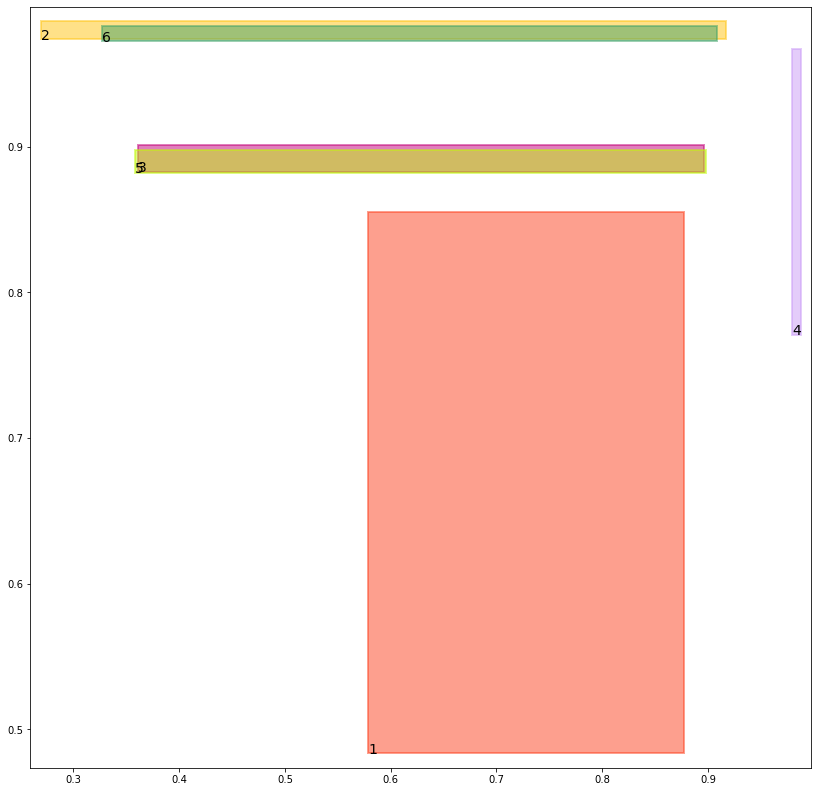

batch (tensor([[4, 5],
        [1, 2],
        [2, 6],
        [3, 5]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.10555267333984 -28.20716667175293 tensor(-54.0774765014648438) tensor(-18.1604804992675781)
tensor(2) -86.28143310546875 -30.38024139404297 tensor(-53.3209381103515625) tensor(-15.4463481903076172)
tensor(3) -82.72330474853516 -29.162744522094727 tensor(-55.6166992187500000) tensor(-16.9564189910888672)
tensor(4) -88.88658905029297 -31.575376510620117 tensor(-82.5528335571289062) tensor(-29.4371547698974609)
tensor(5) -82.17668914794922 -28.953683853149414 tensor(-55.3696136474609375) tensor(-16.8215084075927734)
tensor(6) -85.39544677734375 -29.995893478393555 tensor(-56.6003417968750000) tensor(-16.9587879180908203)


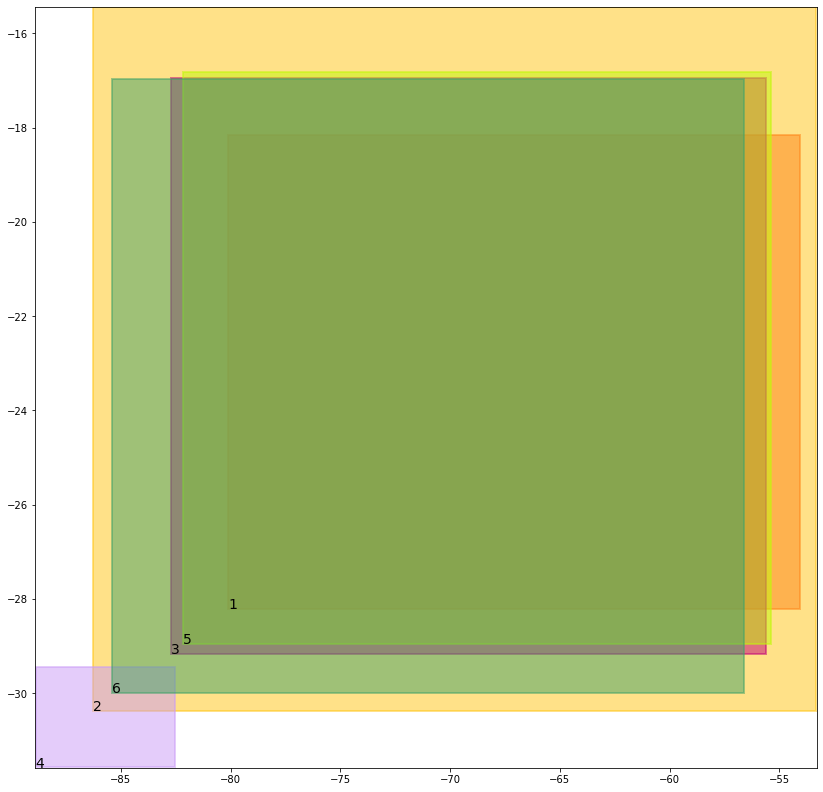

alignment data:
tensor(1) 0.5787522792816162 0.48363012075424194 tensor(0.8770653009414673) tensor(0.8553695082664490)
tensor(2) 0.26610735058784485 0.9738744497299194 tensor(0.9218603372573853) tensor(0.9862319827079773)
tensor(3) 0.3632894456386566 0.8805636167526245 tensor(0.9008226394653320) tensor(0.9034139513969421)
tensor(4) 0.9795432686805725 0.7708355784416199 tensor(0.9878481626510620) tensor(0.9669909477233887)
tensor(5) 0.3560839891433716 0.8849713206291199 tensor(0.8945439457893372) tensor(0.8954328894615173)
tensor(6) 0.3289351463317871 0.9721959233283997 tensor(0.9053909182548523) tensor(0.9830892086029053)


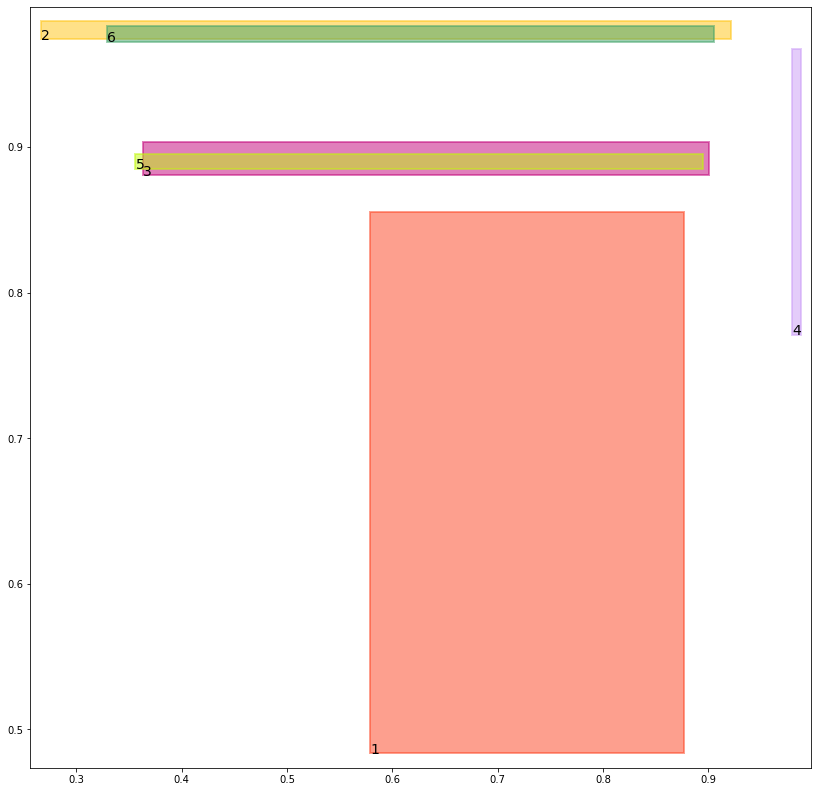

batch (tensor([[4, 6],
        [1, 3],
        [6, 2],
        [5, 3]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.12639617919922 -28.216550827026367 tensor(-54.0914306640625000) tensor(-18.1669654846191406)
tensor(2) -86.44063568115234 -30.451791763305664 tensor(-53.4735603332519531) tensor(-15.5145759582519531)
tensor(3) -82.82617950439453 -29.208232879638672 tensor(-55.7521667480468750) tensor(-17.0158500671386719)
tensor(4) -88.90853118896484 -31.585235595703125 tensor(-82.5716018676757812) tensor(-29.4457206726074219)
tensor(5) -82.1508560180664 -28.940990447998047 tensor(-55.2724075317382812) tensor(-16.7751293182373047)
tensor(6) -85.36109161376953 -29.978073120117188 tensor(-56.3483314514160156) tensor(-16.8429450988769531)


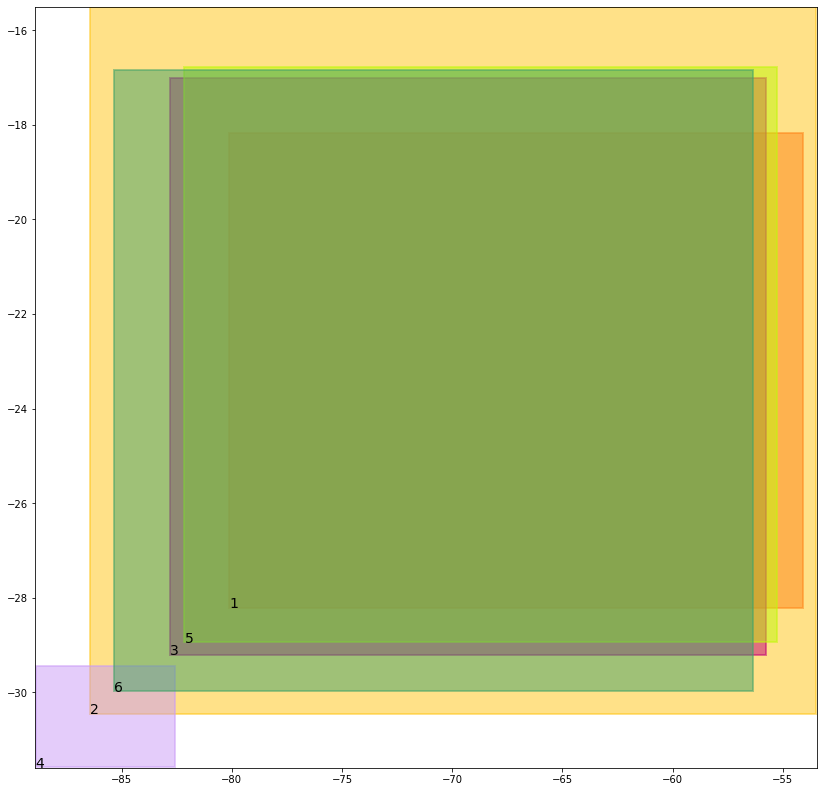

alignment data:
tensor(1) 0.5787926316261292 0.48361045122146606 tensor(0.8770837783813477) tensor(0.8553857207298279)
tensor(2) 0.2685903310775757 0.9741209149360657 tensor(0.9247219562530518) tensor(0.9862605929374695)
tensor(3) 0.3653322756290436 0.8809979557991028 tensor(0.9024257659912109) tensor(0.9036043882369995)
tensor(4) 0.9795368909835815 0.7708089351654053 tensor(0.9878501296043396) tensor(0.9669955372810364)
tensor(5) 0.3538473844528198 0.8852197527885437 tensor(0.8934338092803955) tensor(0.8956715464591980)
tensor(6) 0.32396382093429565 0.9721075892448425 tensor(0.9039142131805420) tensor(0.9835915565490723)


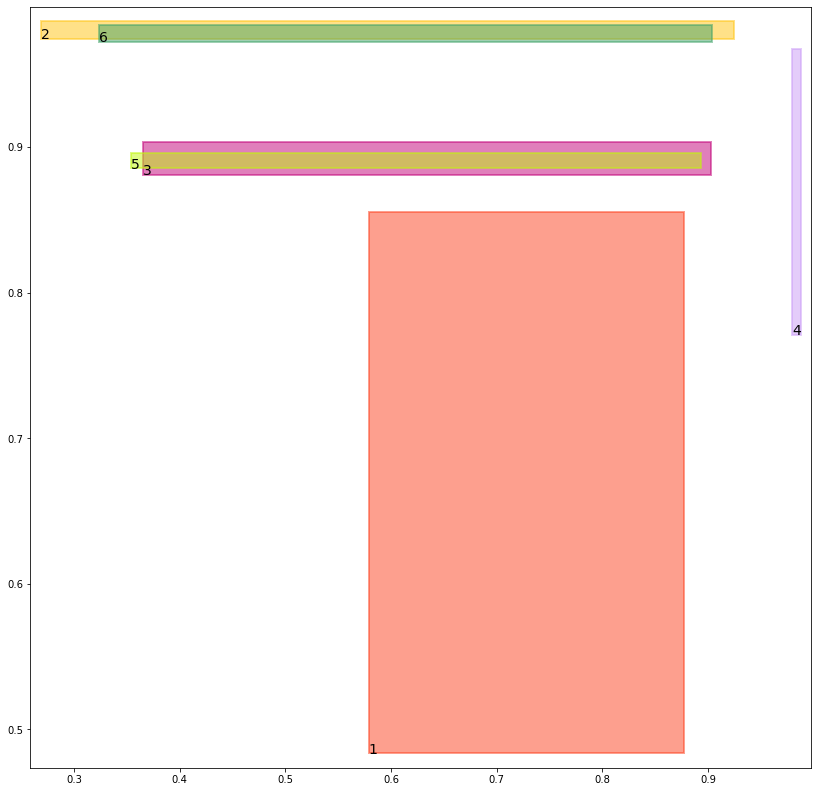

batch (tensor([[2, 6],
        [1, 3],
        [4, 6],
        [6, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.14533996582031 -28.22501564025879 tensor(-54.1040725708007812) tensor(-18.1728477478027344)
tensor(2) -86.51709747314453 -30.48697280883789 tensor(-53.8683929443359375) tensor(-15.6970319747924805)
tensor(3) -82.91849517822266 -29.249055862426758 tensor(-55.8752212524414062) tensor(-17.0698547363281250)
tensor(4) -88.92843627929688 -31.594173431396484 tensor(-82.5886001586914062) tensor(-29.4534854888916016)
tensor(5) -82.1269760131836 -28.929283142089844 tensor(-55.1845245361328125) tensor(-16.7331905364990234)
tensor(6) -85.42198944091797 -30.002120971679688 tensor(-55.8055496215820312) tensor(-16.5908889770507812)


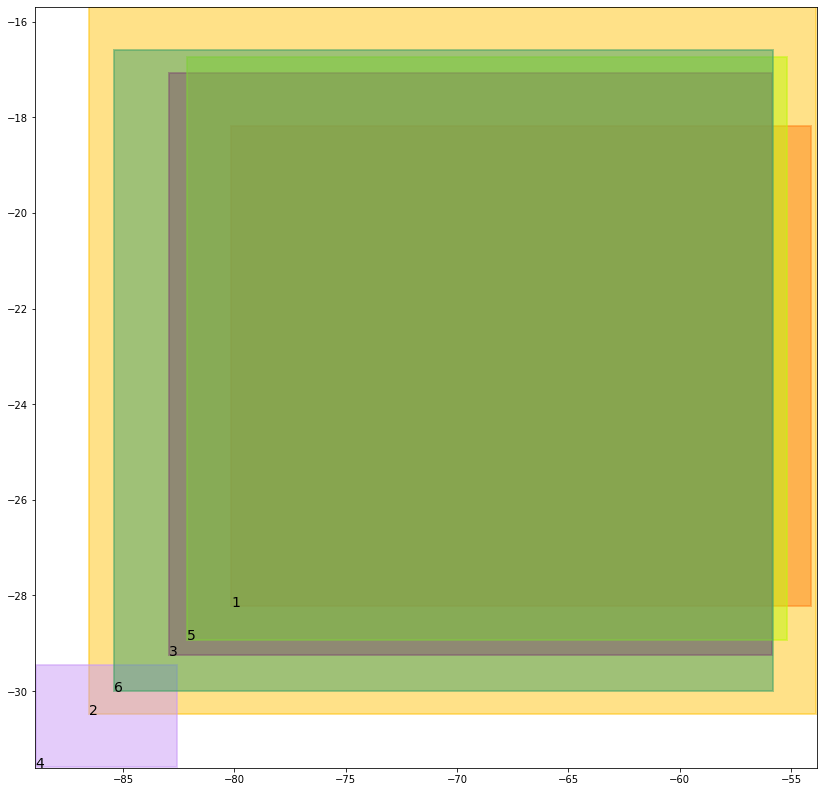

alignment data:
tensor(1) 0.5788292288780212 0.48359259963035583 tensor(0.8771005272865295) tensor(0.8554005026817322)
tensor(2) 0.27604272961616516 0.9737021923065186 tensor(0.9260195493698120) tensor(0.9860998988151550)
tensor(3) 0.3671885132789612 0.8813906311988831 tensor(0.9038591384887695) tensor(0.9037769436836243)
tensor(4) 0.9795310497283936 0.7707847952842712 tensor(0.9878518581390381) tensor(0.9669997692108154)
tensor(5) 0.35182520747184753 0.8854444622993469 tensor(0.8924186229705811) tensor(0.8958874344825745)
tensor(6) 0.3131956160068512 0.9726110696792603 tensor(0.9043244123458862) tensor(0.9843132495880127)


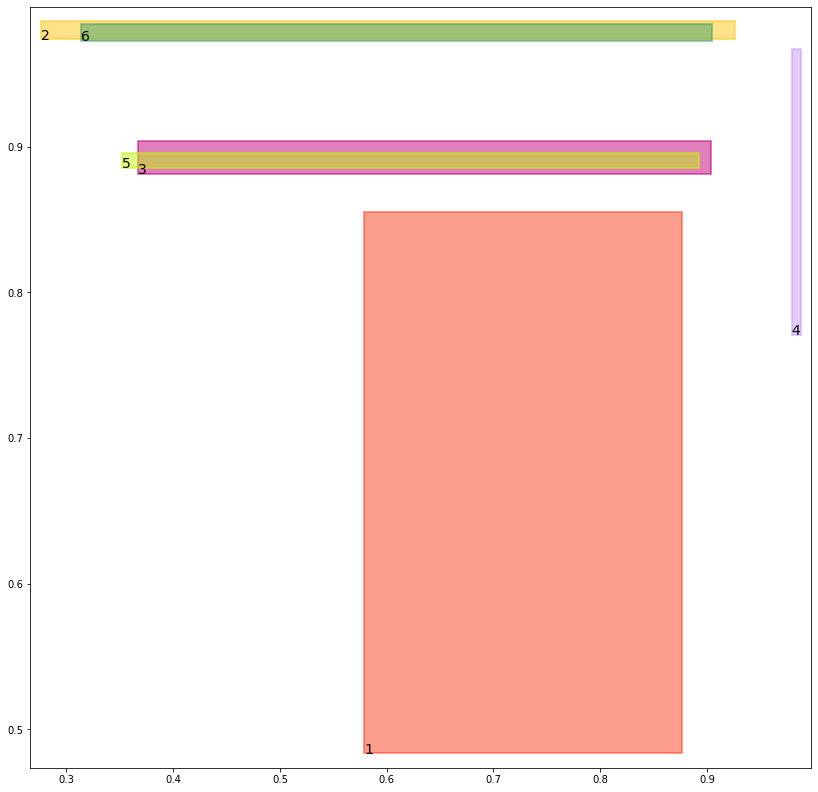

batch (tensor([[3, 5],
        [1, 2],
        [4, 5],
        [5, 3]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.16250610351562 -28.232685089111328 tensor(-54.1155395507812500) tensor(-18.1781768798828125)
tensor(2) -86.58553314208984 -30.518470764160156 tensor(-54.2320671081542969) tensor(-15.8651132583618164)
tensor(3) -82.84504699707031 -29.22376251220703 tensor(-55.7072525024414062) tensor(-16.9786453247070312)
tensor(4) -88.94648742675781 -31.602275848388672 tensor(-82.6040267944335938) tensor(-29.4605255126953125)
tensor(5) -82.28617095947266 -28.990907669067383 tensor(-55.3773269653320312) tensor(-16.8310298919677734)
tensor(6) -85.47630310058594 -30.02364730834961 tensor(-55.3221511840820312) tensor(-16.3663787841796875)


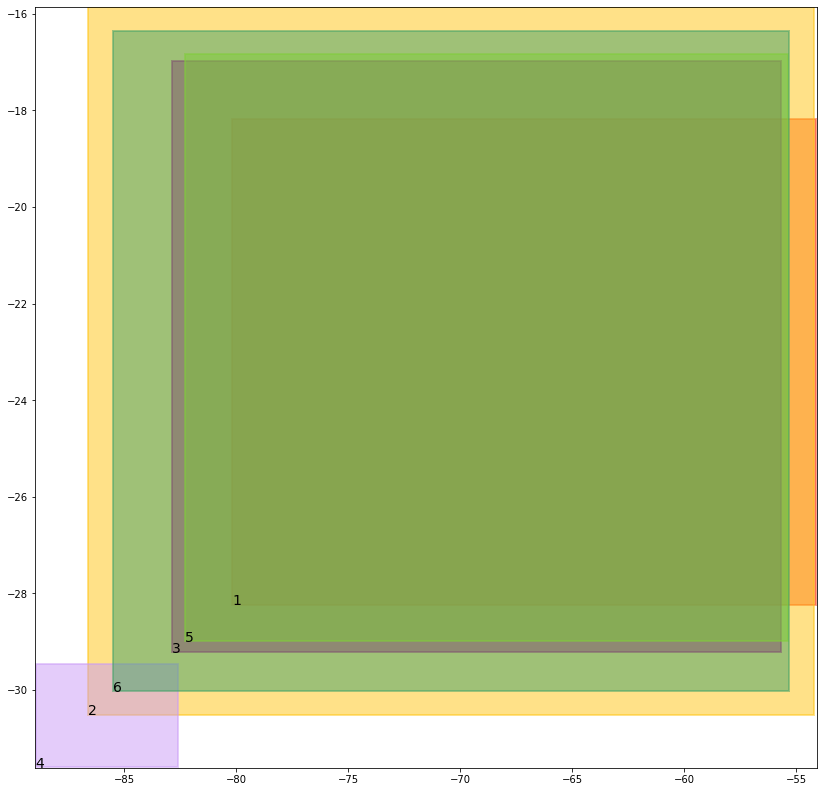

alignment data:
tensor(1) 0.5788623690605164 0.4835764169692993 tensor(0.8771156668663025) tensor(0.8554138541221619)
tensor(2) 0.28290775418281555 0.9733169674873352 tensor(0.9271780252456665) tensor(0.9859526157379150)
tensor(3) 0.36219319701194763 0.8841850161552429 tensor(0.9030523300170898) tensor(0.9021096825599670)
tensor(4) 0.9795258045196533 0.7707629203796387 tensor(0.9878535270690918) tensor(0.9670035839080811)
tensor(5) 0.3564116060733795 0.8834273219108582 tensor(0.8939990997314453) tensor(0.8980603814125061)
tensor(6) 0.30360496044158936 0.9730597734451294 tensor(0.9046947956085205) tensor(0.9849403500556946)


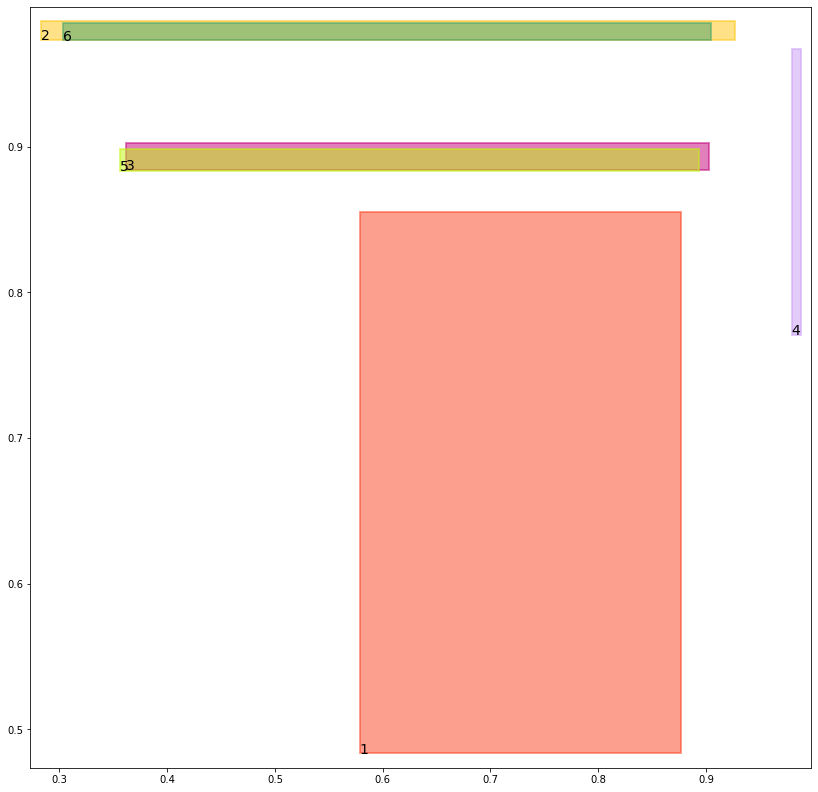

batch (tensor([[2, 6],
        [4, 6],
        [1, 3],
        [5, 3]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.17807006835938 -28.239635467529297 tensor(-54.1259307861328125) tensor(-18.1830101013183594)
tensor(2) -86.64684295654297 -30.546707153320312 tensor(-54.5438690185546875) tensor(-16.0129146575927734)
tensor(3) -82.61698150634766 -29.137035369873047 tensor(-55.5575866699218750) tensor(-16.8973045349121094)
tensor(4) -88.96283721923828 -31.609615325927734 tensor(-82.6179962158203125) tensor(-29.4669075012207031)
tensor(5) -82.60113525390625 -29.115001678466797 tensor(-55.5525360107421875) tensor(-16.9200592041015625)
tensor(6) -85.52481842041016 -30.042938232421875 tensor(-54.9080467224121094) tensor(-16.1712646484375000)


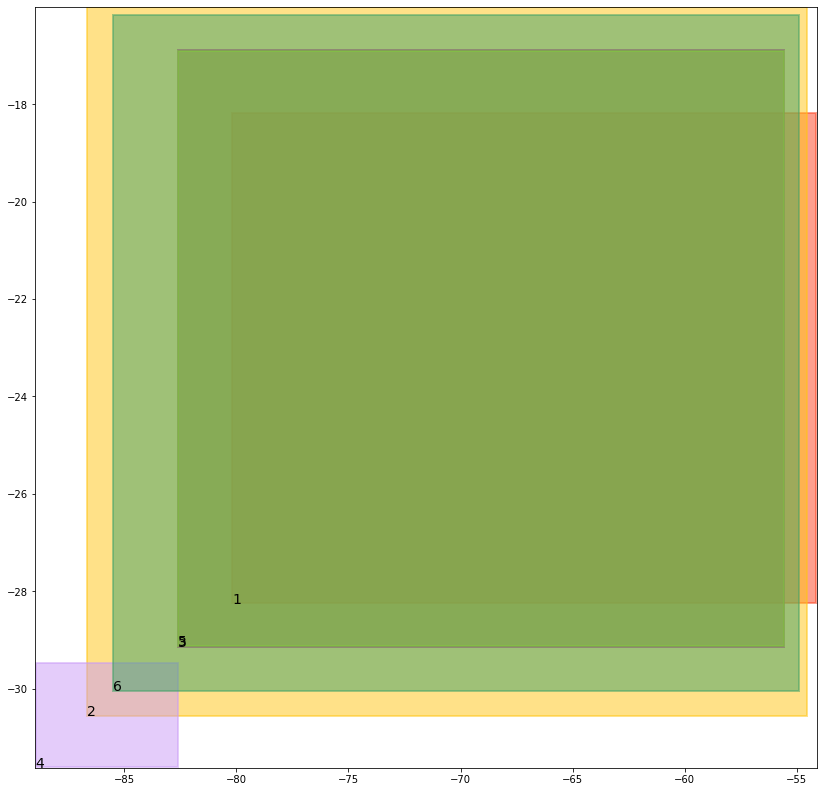

alignment data:
tensor(1) 0.5788924694061279 0.4835616946220398 tensor(0.8771294355392456) tensor(0.8554259538650513)
tensor(2) 0.28921881318092346 0.9722291827201843 tensor(0.9282135963439941) tensor(0.9858177304267883)
tensor(3) 0.3577331006526947 0.8866862654685974 tensor(0.9001865386962891) tensor(0.8986817002296448)
tensor(4) 0.9795209765434265 0.7707430124282837 tensor(0.9878548979759216) tensor(0.9670069217681885)
tensor(5) 0.3605916500091553 0.8815723657608032 tensor(0.8977971673011780) tensor(0.9018850922584534)
tensor(6) 0.29505789279937744 0.9740033745765686 tensor(0.9050291180610657) tensor(0.9854874610900879)


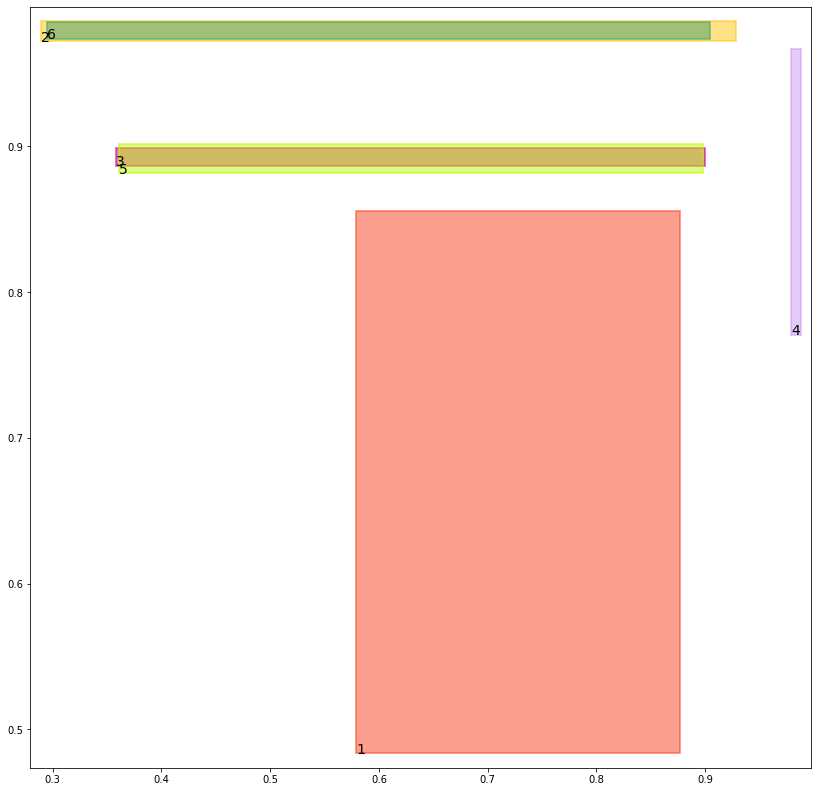

batch (tensor([[1, 2],
        [6, 2],
        [4, 5],
        [3, 5]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.19218444824219 -28.245935440063477 tensor(-54.1353416442871094) tensor(-18.1873912811279297)
tensor(2) -86.64107513427734 -30.545621871948242 tensor(-55.1561660766601562) tensor(-16.2942676544189453)
tensor(3) -82.46698760986328 -29.074932098388672 tensor(-55.3517608642578125) tensor(-16.8027820587158203)
tensor(4) -88.97765350341797 -31.61627769470215 tensor(-82.6306533813476562) tensor(-29.4726886749267578)
tensor(5) -82.82144927978516 -29.20711898803711 tensor(-55.7880630493164062) tensor(-17.0241775512695312)
tensor(6) -85.65860748291016 -30.09990119934082 tensor(-54.2197952270507812) tensor(-15.8535547256469727)


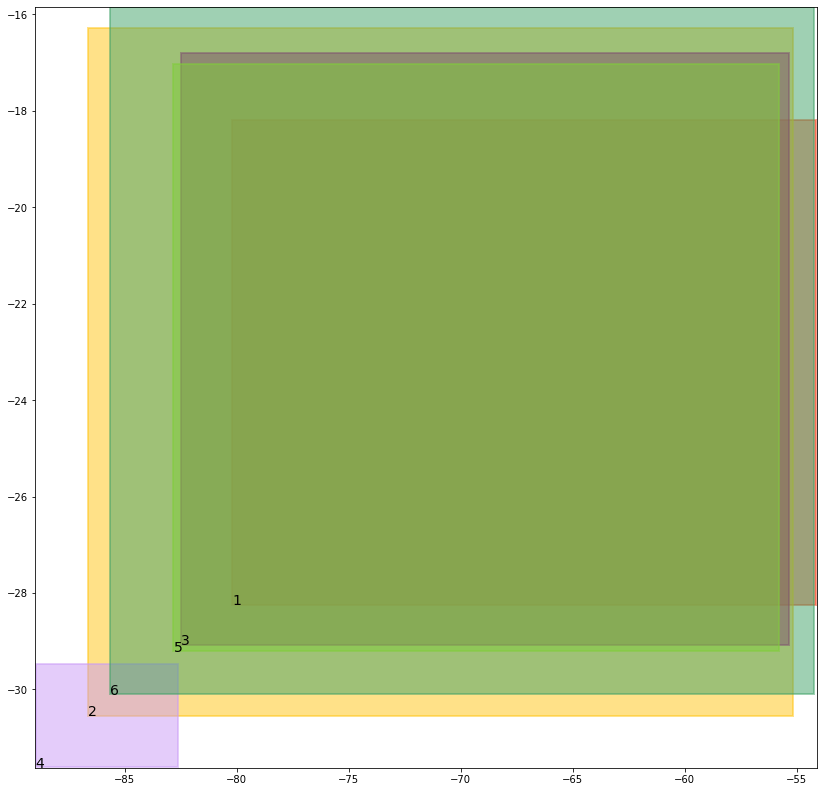

alignment data:
tensor(1) 0.5789196491241455 0.48354843258857727 tensor(0.8771418333053589) tensor(0.8554369211196899)
tensor(2) 0.30069634318351746 0.9720293283462524 tensor(0.9280034303665161) tensor(0.9854927659034729)
tensor(3) 0.35371193289756775 0.8866280913352966 tensor(0.8975245952606201) tensor(0.8975170254707336)
tensor(4) 0.9795166254043579 0.7707250118255615 tensor(0.9878562092781067) tensor(0.9670100212097168)
tensor(5) 0.36443832516670227 0.8822922706604004 tensor(0.9011212587356567) tensor(0.9034190177917480)
tensor(6) 0.2817327678203583 0.9743108749389648 tensor(0.9070701599121094) tensor(0.9861922860145569)


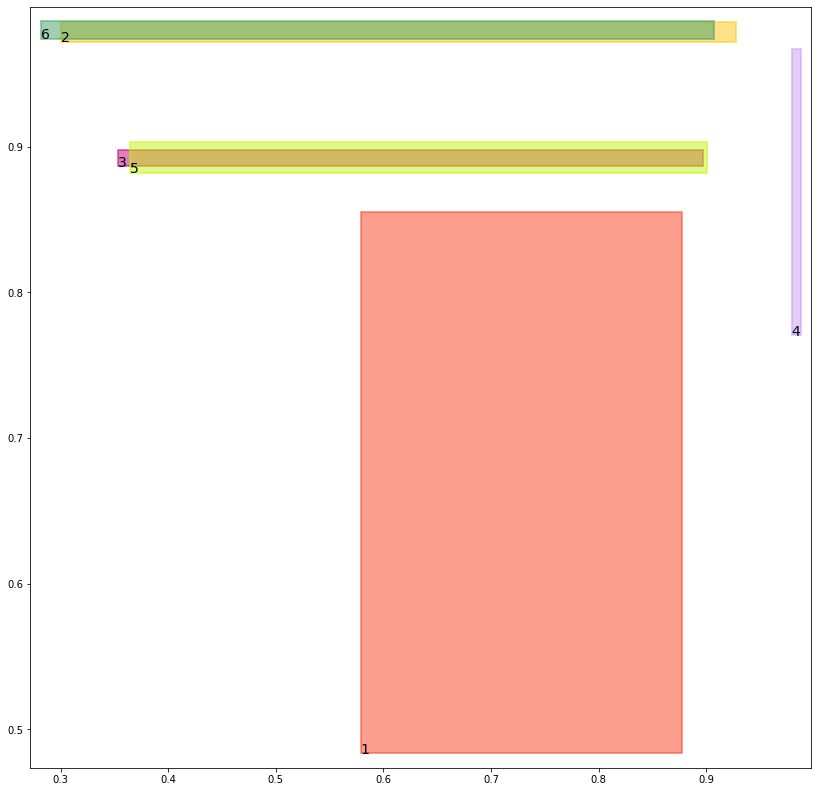

batch (tensor([[6, 2],
        [1, 3],
        [1, 2],
        [5, 3]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.20496368408203 -28.25164794921875 tensor(-54.1438827514648438) tensor(-18.1913623809814453)
tensor(2) -86.58030700683594 -30.51966094970703 tensor(-55.7498931884765625) tensor(-16.5632152557373047)
tensor(3) -82.32720184326172 -29.017032623291016 tensor(-55.5210418701171875) tensor(-16.8802604675292969)
tensor(4) -88.99109649658203 -31.62230682373047 tensor(-82.6421432495117188) tensor(-29.4779319763183594)
tensor(5) -83.01659393310547 -29.28865623474121 tensor(-55.6488723754882812) tensor(-16.9567947387695312)
tensor(6) -85.85578155517578 -30.185855865478516 tensor(-53.5971221923828125) tensor(-15.5686254501342773)


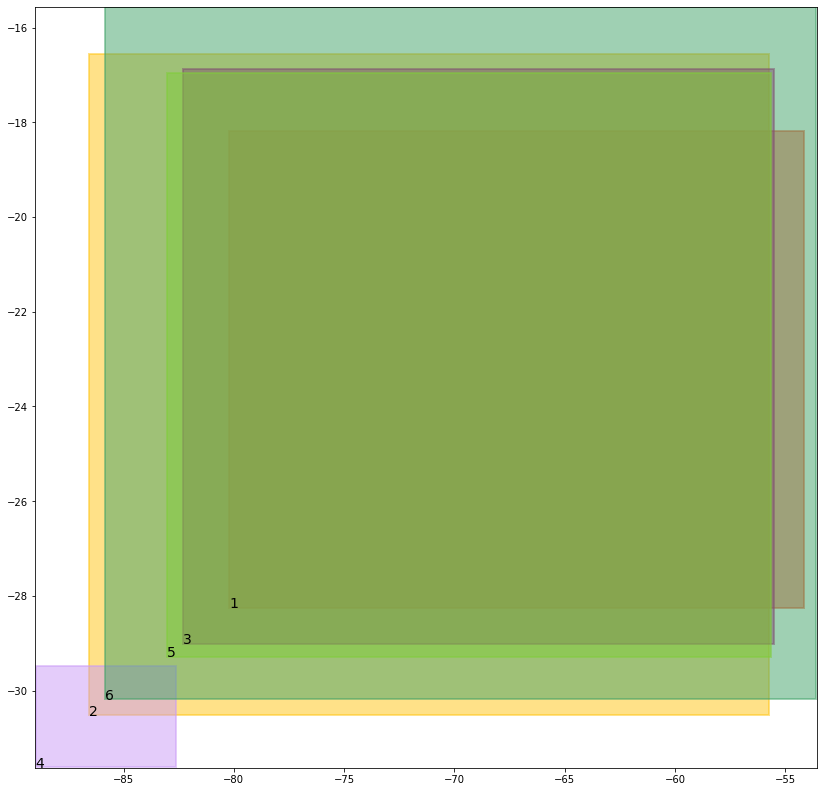

alignment data:
tensor(1) 0.5789443850517273 0.48353639245033264 tensor(0.8771530985832214) tensor(0.8554468750953674)
tensor(2) 0.31137287616729736 0.9726337194442749 tensor(0.9266611337661743) tensor(0.9851888418197632)
tensor(3) 0.35676413774490356 0.8865909576416016 tensor(0.8950484395027161) tensor(0.8964374661445618)
tensor(4) 0.9795127511024475 0.7707087397575378 tensor(0.9878573417663574) tensor(0.9670128226280212)
tensor(5) 0.3612808585166931 0.8829413056373596 tensor(0.9040502309799194) tensor(0.9047906994819641)
tensor(6) 0.2699781358242035 0.9740734100341797 tensor(0.9105206727981567) tensor(0.9868017435073853)


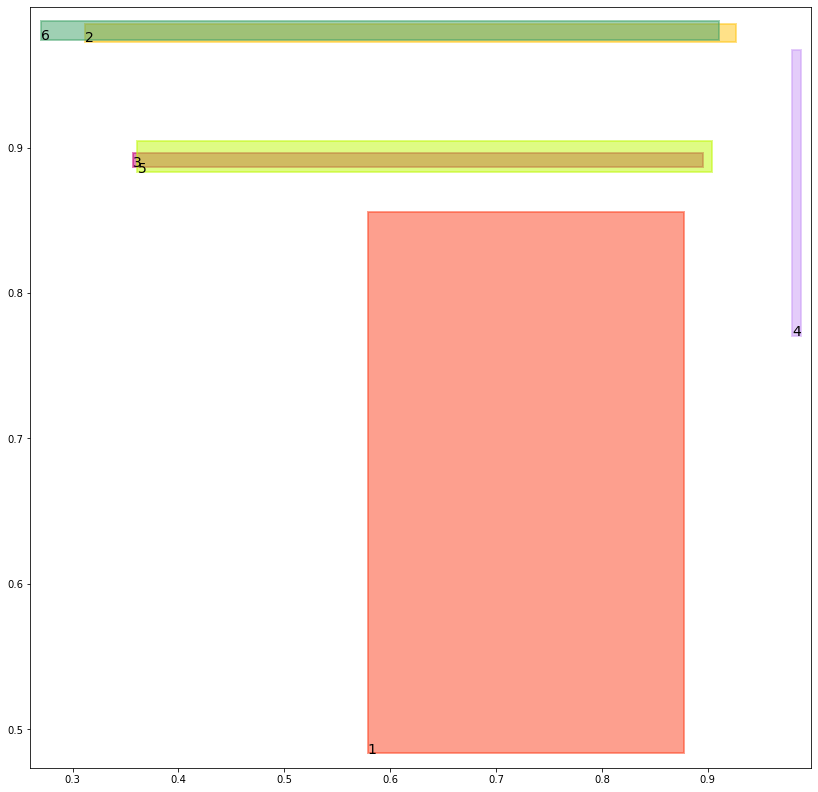

batch (tensor([[4, 6],
        [3, 5],
        [2, 6],
        [4, 5]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.21654510498047 -28.256818771362305 tensor(-54.1516113281250000) tensor(-18.1949615478515625)
tensor(2) -86.53077697753906 -30.497655868530273 tensor(-55.9640579223632812) tensor(-16.6584339141845703)
tensor(3) -82.38005828857422 -29.035871505737305 tensor(-55.6041603088378906) tensor(-16.9295635223388672)
tensor(4) -89.00325775146484 -31.627775192260742 tensor(-82.6525421142578125) tensor(-29.4826831817626953)
tensor(5) -83.03496551513672 -29.299448013305664 tensor(-55.5989913940429688) tensor(-16.9192657470703125)
tensor(6) -86.02169036865234 -30.259029388427734 tensor(-53.3367156982421875) tensor(-15.4488010406494141)


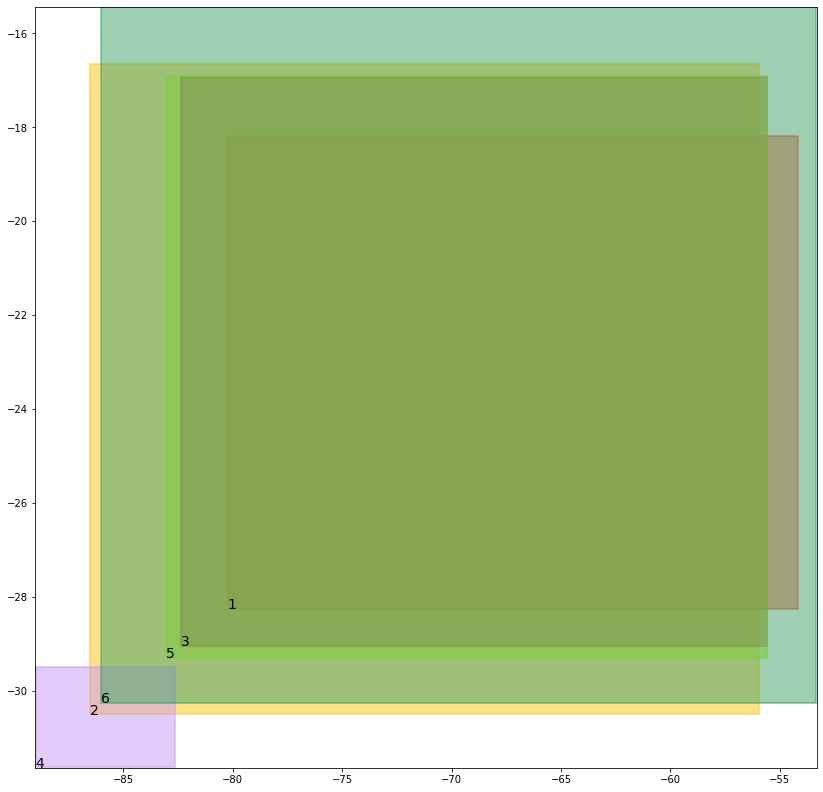

alignment data:
tensor(1) 0.5789667367935181 0.48352548480033875 tensor(0.8771633505821228) tensor(0.8554558753967285)
tensor(2) 0.31495019793510437 0.9731703996658325 tensor(0.9254249334335327) tensor(0.9851249456405640)
tensor(3) 0.35954007506370544 0.8842464089393616 tensor(0.8952288627624512) tensor(0.8975101113319397)
tensor(4) 0.9795092344284058 0.7706940174102783 tensor(0.9878584146499634) tensor(0.9670153856277466)
tensor(5) 0.35850897431373596 0.8858627080917358 tensor(0.9045435190200806) tensor(0.9042555689811707)
tensor(6) 0.2650264501571655 0.9738705158233643 tensor(0.9135230183601379) tensor(0.9871325492858887)


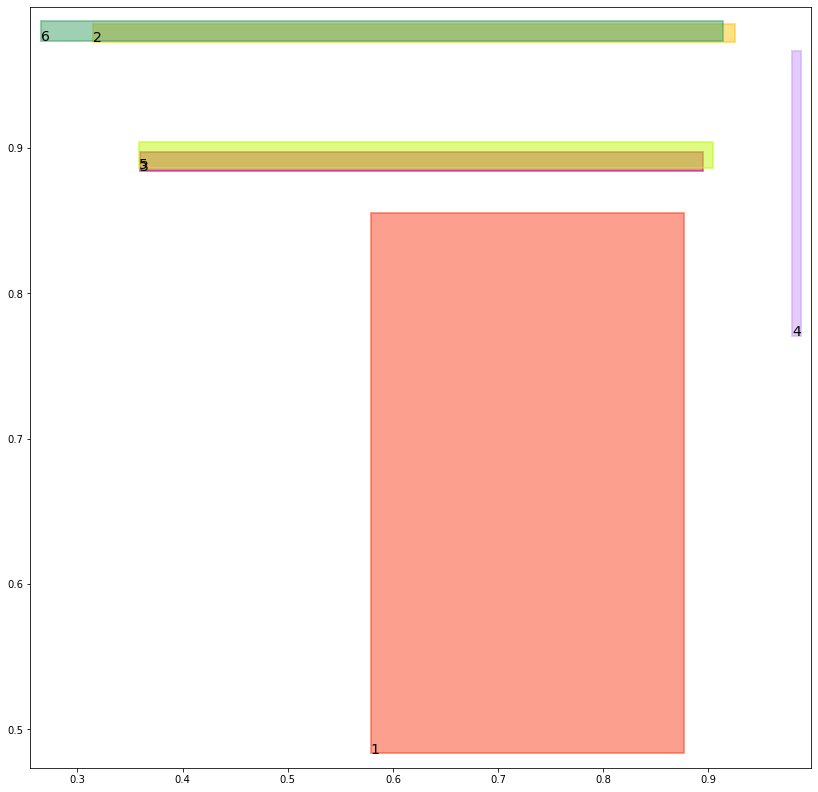

batch (tensor([[4, 5],
        [3, 5],
        [5, 3],
        [4, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.22704315185547 -28.261510848999023 tensor(-54.1586189270019531) tensor(-18.1982212066650391)
tensor(2) -86.48509979248047 -30.47735023498535 tensor(-56.1589088439941406) tensor(-16.7451210021972656)
tensor(3) -82.6025619506836 -29.122451782226562 tensor(-55.3957901000976562) tensor(-16.8324527740478516)
tensor(4) -89.01429748535156 -31.632734298706055 tensor(-82.6619644165039062) tensor(-29.4869899749755859)
tensor(5) -82.89594268798828 -29.247488021850586 tensor(-55.8358993530273438) tensor(-17.0258235931396484)
tensor(6) -86.16804504394531 -30.323579788208008 tensor(-53.1065673828125000) tensor(-15.3400354385375977)


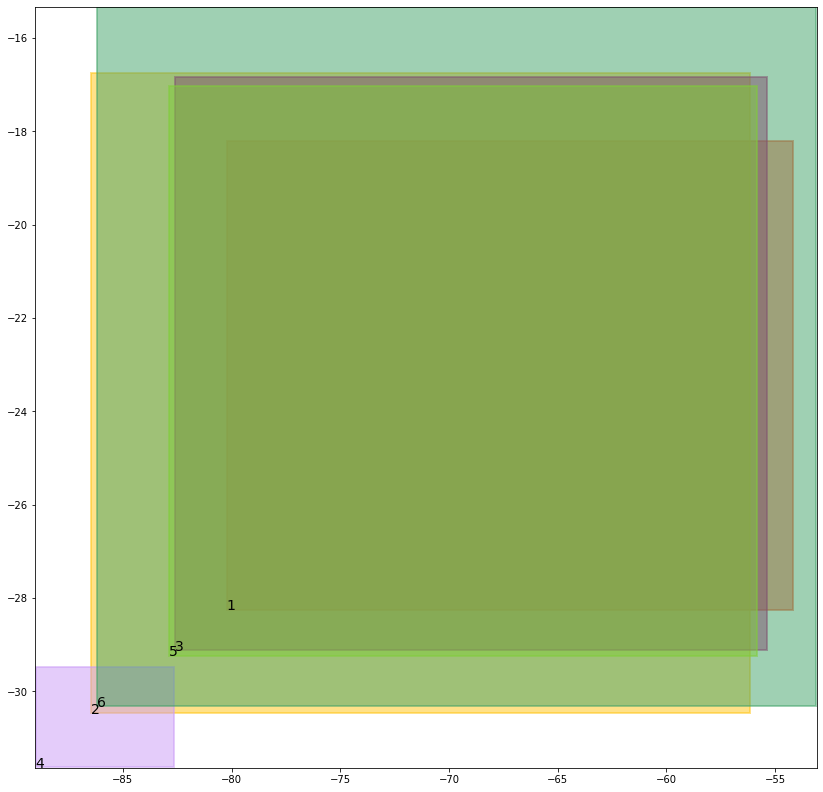

alignment data:
tensor(1) 0.5789870023727417 0.48351556062698364 tensor(0.8771726489067078) tensor(0.8554639816284180)
tensor(2) 0.3182107210159302 0.9736478328704834 tensor(0.9242882132530212) tensor(0.9850668907165527)
tensor(3) 0.35533902049064636 0.8844970464706421 tensor(0.8977689743041992) tensor(0.9004461765289307)
tensor(4) 0.9795060157775879 0.7706805467605591 tensor(0.9878594279289246) tensor(0.9670177102088928)
tensor(5) 0.36262524127960205 0.8862359523773193 tensor(0.9029029011726379) tensor(0.9019711613655090)
tensor(6) 0.26059019565582275 0.9736853837966919 tensor(0.9161643385887146) tensor(0.9874251484870911)


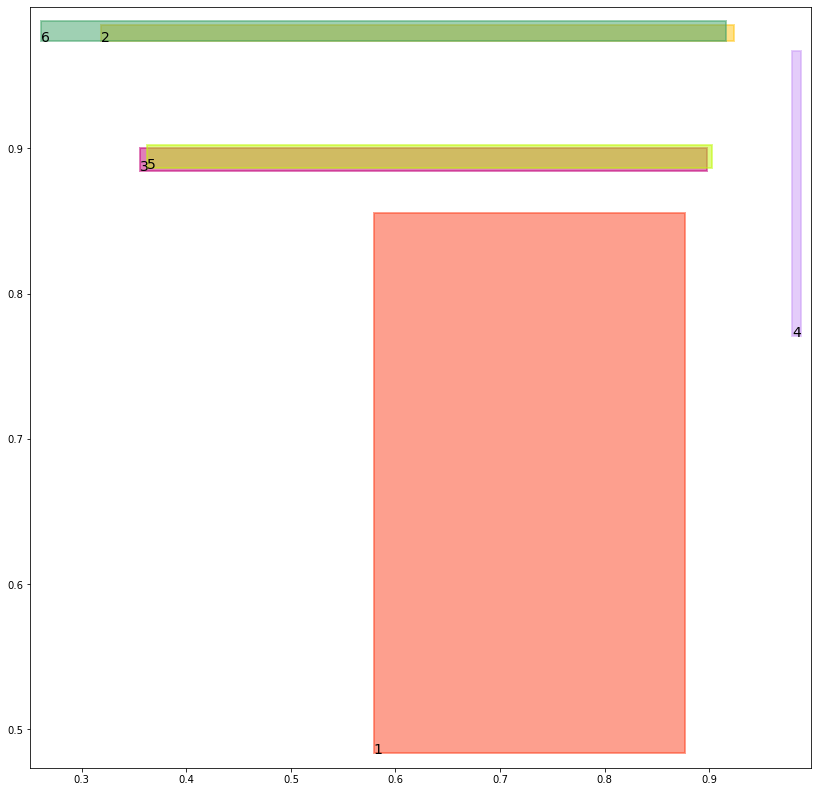

batch (tensor([[1, 3],
        [2, 6],
        [6, 2],
        [1, 2]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.23656463623047 -28.265758514404297 tensor(-54.1649665832519531) tensor(-18.2011718750000000)
tensor(2) -86.38835906982422 -30.433006286621094 tensor(-56.0260314941406250) tensor(-16.6784458160400391)
tensor(3) -82.79994201660156 -29.19929313659668 tensor(-55.2079582214355469) tensor(-16.7449073791503906)
tensor(4) -89.02428436279297 -31.637218475341797 tensor(-82.6705017089843750) tensor(-29.4908866882324219)
tensor(5) -82.76761627197266 -29.199539184570312 tensor(-56.0514793395996094) tensor(-17.1228027343750000)
tensor(6) -86.35558319091797 -30.407703399658203 tensor(-53.1565856933593750) tensor(-15.3668851852416992)


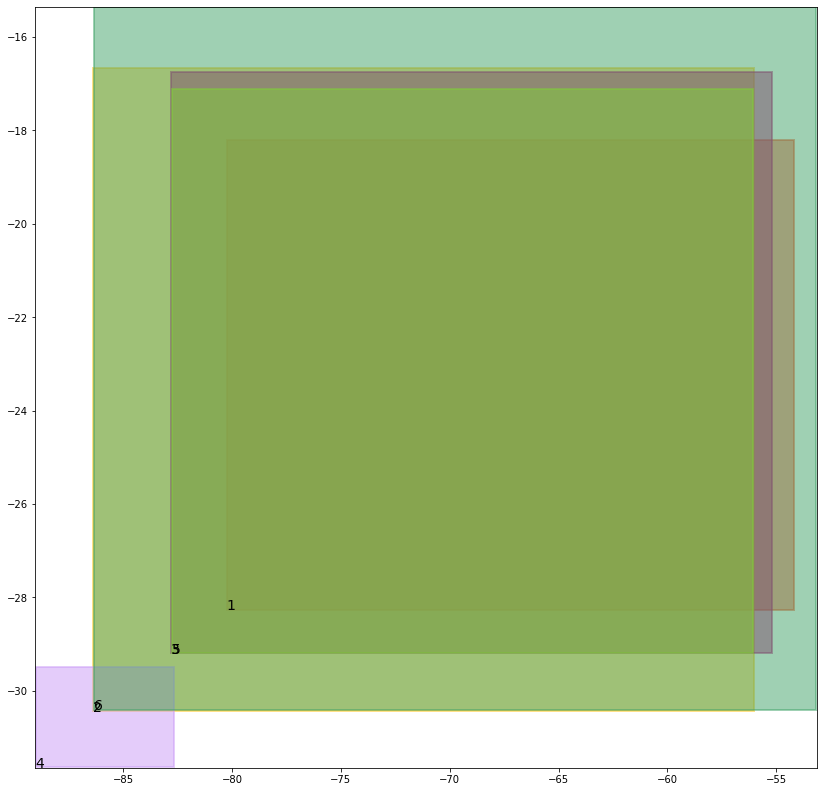

alignment data:
tensor(1) 0.5790053606033325 0.48350661993026733 tensor(0.8771809935569763) tensor(0.8554714322090149)
tensor(2) 0.31495073437690735 0.9747471809387207 tensor(0.9219654798507690) tensor(0.9852313995361328)
tensor(3) 0.35155192017555237 0.8847236633300781 tensor(0.9000228643417358) tensor(0.9030416011810303)
tensor(4) 0.9795030355453491 0.7706684470176697 tensor(0.9878602623939514) tensor(0.9670198559761047)
tensor(5) 0.3663721978664398 0.8865731358528137 tensor(0.9013947248458862) tensor(0.8998596668243408)
tensor(6) 0.2618360221385956 0.9729892015457153 tensor(0.9198256731033325) tensor(0.9874979257583618)


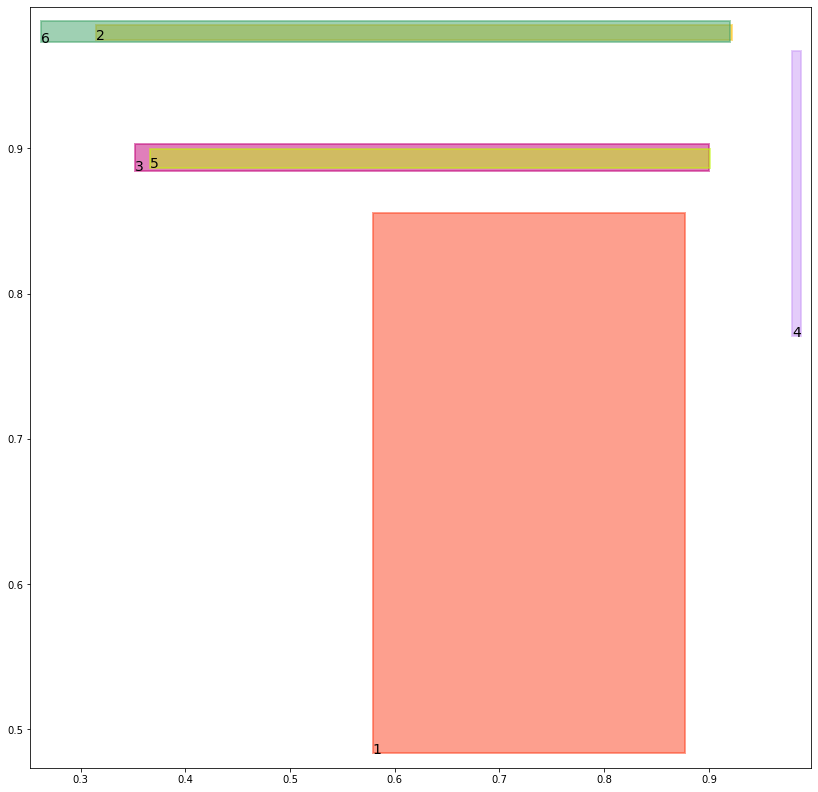

batch (tensor([[5, 3],
        [4, 5],
        [1, 3],
        [4, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.24517059326172 -28.269607543945312 tensor(-54.1707191467285156) tensor(-18.2038478851318359)
tensor(2) -86.29794311523438 -30.391597747802734 tensor(-55.9052810668945312) tensor(-16.6180572509765625)
tensor(3) -82.85964965820312 -29.2326717376709 tensor(-55.8669281005859375) tensor(-17.0235729217529297)
tensor(4) -89.03334045410156 -31.641286849975586 tensor(-82.6782302856445312) tensor(-29.4944210052490234)
tensor(5) -82.76688385009766 -29.190576553344727 tensor(-55.4261093139648438) tensor(-16.8559265136718750)
tensor(6) -86.5194320678711 -30.48119354248047 tensor(-53.2016143798828125) tensor(-15.3911504745483398)


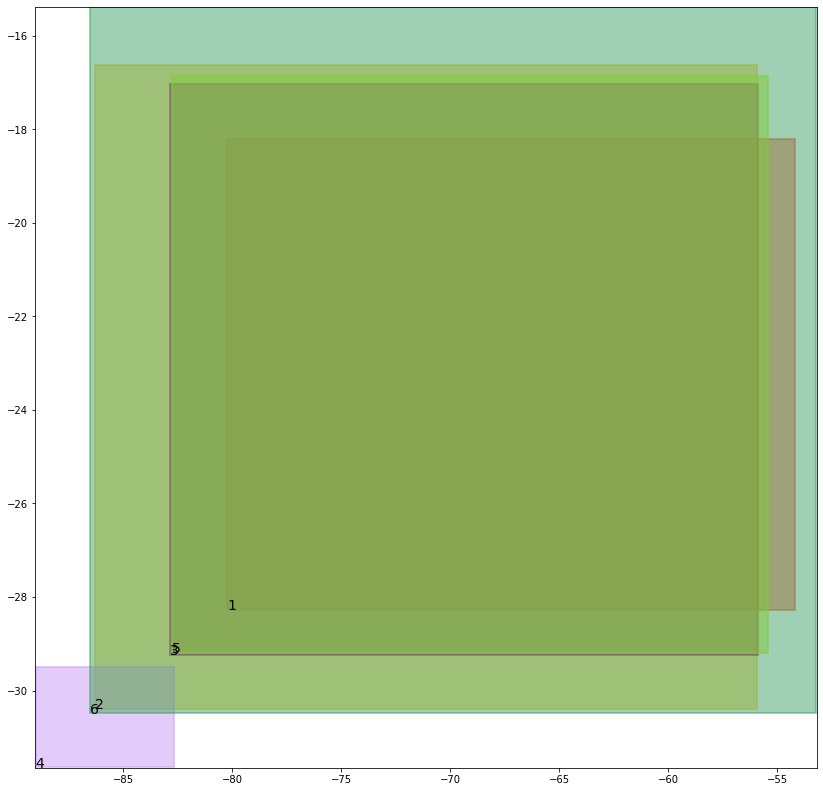

alignment data:
tensor(1) 0.5790219902992249 0.4834984838962555 tensor(0.8771885633468628) tensor(0.8554781079292297)
tensor(2) 0.31201300024986267 0.9757046699523926 tensor(0.9198049306869507) tensor(0.9853788614273071)
tensor(3) 0.3611006438732147 0.8894936442375183 tensor(0.9019865989685059) tensor(0.9016528129577637)
tensor(4) 0.979500412940979 0.770657479763031 tensor(0.9878610968589783) tensor(0.9670217633247375)
tensor(5) 0.356869637966156 0.8824465870857239 tensor(0.9000104069709778) tensor(0.9017200469970703)
tensor(6) 0.2629680037498474 0.9723430871963501 tensor(0.9230158329010010) tensor(0.9875634908676147)


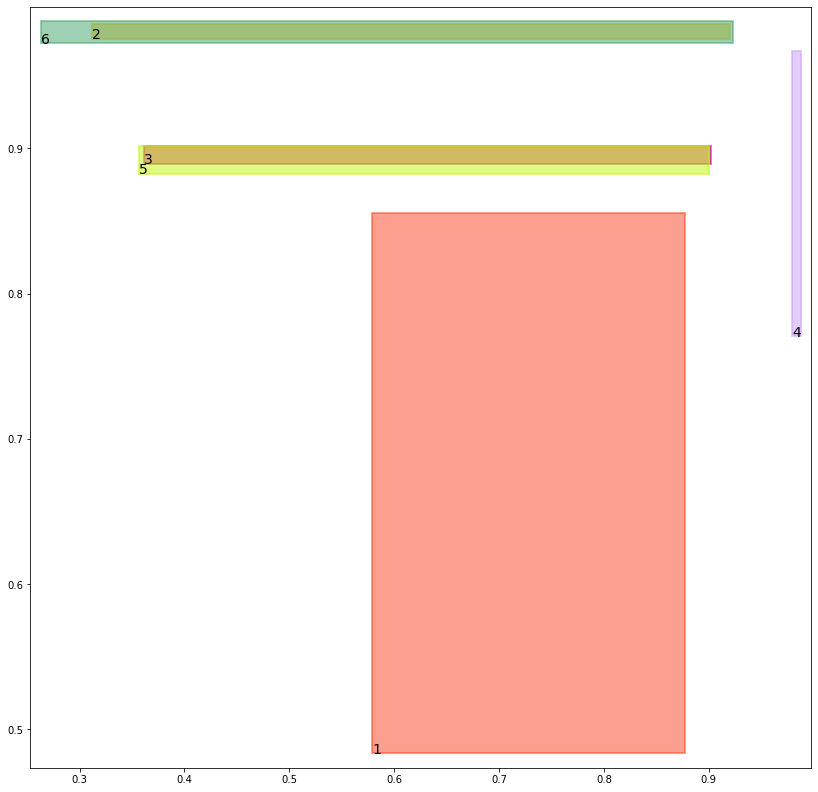

batch (tensor([[6, 2],
        [1, 2],
        [3, 5],
        [2, 6]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.25297546386719 -28.273094177246094 tensor(-54.1759262084960938) tensor(-18.2062740325927734)
tensor(2) -86.26431274414062 -30.375179290771484 tensor(-55.5689277648925781) tensor(-16.4613132476806641)
tensor(3) -82.95032501220703 -29.273653030395508 tensor(-56.1876525878906250) tensor(-17.1569347381591797)
tensor(4) -89.04154205322266 -31.644968032836914 tensor(-82.6852416992187500) tensor(-29.4976177215576172)
tensor(5) -82.72661590576172 -29.170406341552734 tensor(-55.1344375610351562) tensor(-16.7328739166259766)
tensor(6) -86.61974334716797 -30.526674270629883 tensor(-53.4413986206054688) tensor(-15.5047817230224609)


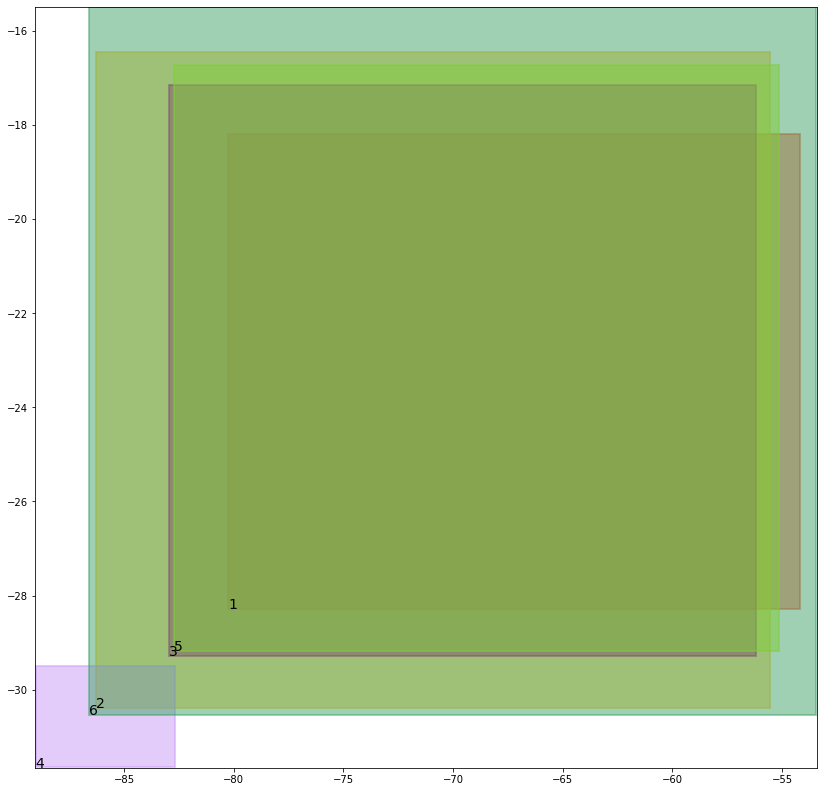

alignment data:
tensor(1) 0.579037070274353 0.4834911525249481 tensor(0.8771954774856567) tensor(0.8554842472076416)
tensor(2) 0.3053235709667206 0.9761465191841125 tensor(0.9187644720077515) tensor(0.9856513738632202)
tensor(3) 0.3654472529888153 0.8922556042671204 tensor(0.9037356376647949) tensor(0.9016269445419312)
tensor(4) 0.979498028755188 0.7706474661827087 tensor(0.9878617525100708) tensor(0.9670234322547913)
tensor(5) 0.35257166624069214 0.880210280418396 tensor(0.8987312316894531) tensor(0.9021608233451843)
tensor(6) 0.26755350828170776 0.9721697568893433 tensor(0.9249830245971680) tensor(0.9874979257583618)


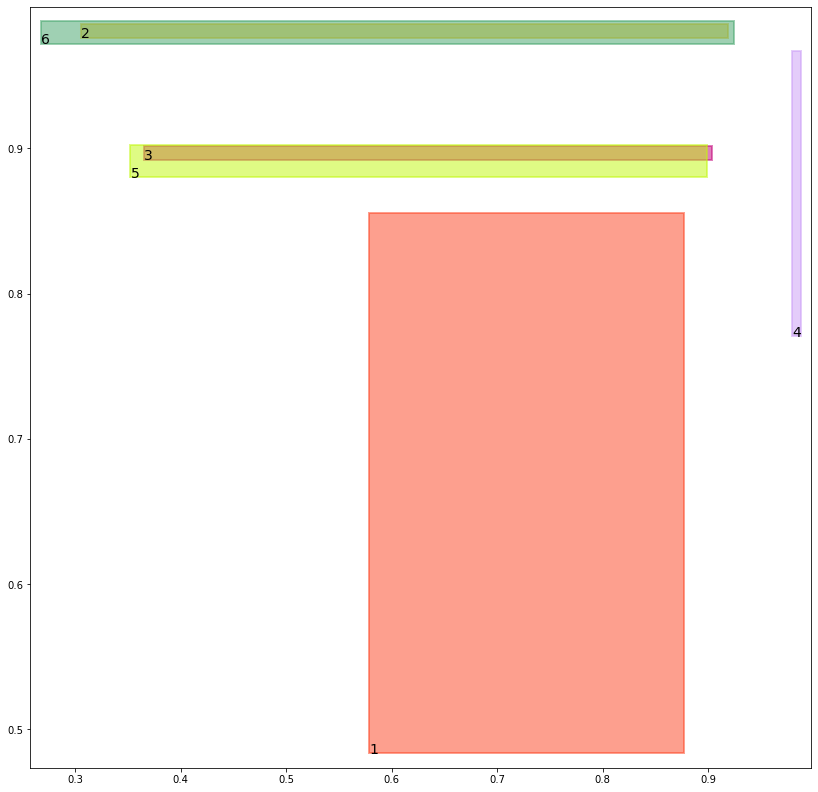

batch (tensor([[1, 3],
        [6, 2],
        [3, 5],
        [5, 3]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.26004791259766 -28.27625274658203 tensor(-54.1806488037109375) tensor(-18.2084693908691406)
tensor(2) -86.23319244384766 -30.36003303527832 tensor(-55.2677230834960938) tensor(-16.3209476470947266)
tensor(3) -83.0015869140625 -29.291166305541992 tensor(-56.2040634155273438) tensor(-17.1588859558105469)
tensor(4) -89.0489730834961 -31.648305892944336 tensor(-82.6915817260742188) tensor(-29.5005168914794922)
tensor(5) -82.7254867553711 -29.173768997192383 tensor(-55.1430816650390625) tensor(-16.7386531829833984)
tensor(6) -86.70868682861328 -30.5670108795166 tensor(-53.6640472412109375) tensor(-15.6074447631835938)


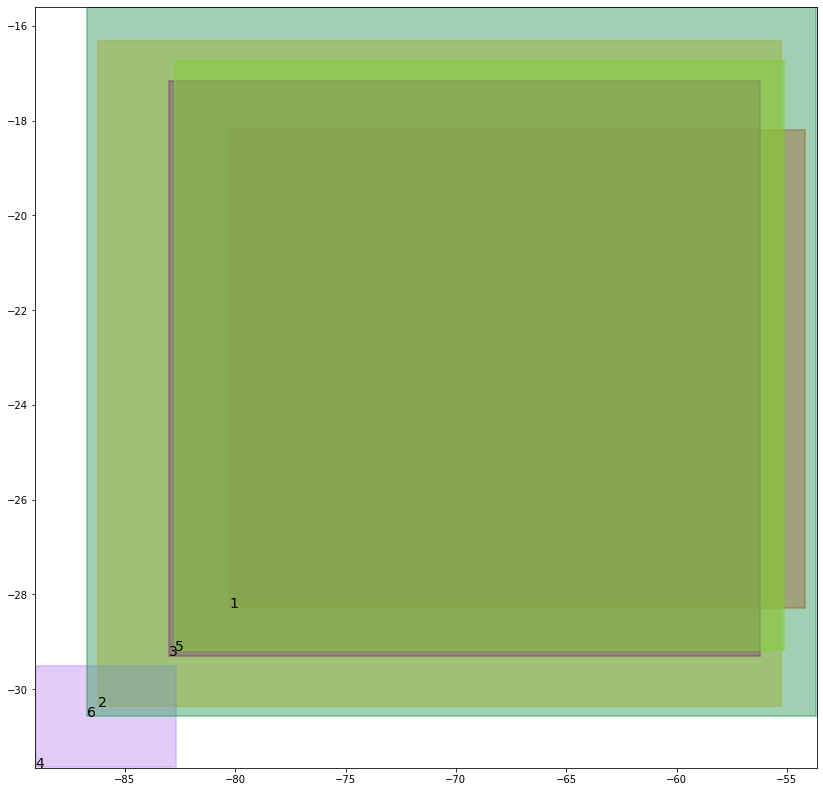

alignment data:
tensor(1) 0.5790507197380066 0.48348450660705566 tensor(0.8772017359733582) tensor(0.8554897308349609)
tensor(2) 0.29933416843414307 0.9765400290489197 tensor(0.9178112745285034) tensor(0.9858939647674561)
tensor(3) 0.365033894777298 0.8933515548706055 tensor(0.9038890600204468) tensor(0.9028280377388000)
tensor(4) 0.9794958233833313 0.7706384658813477 tensor(0.9878624677658081) tensor(0.9670249819755554)
tensor(5) 0.35288387537002563 0.87980055809021 tensor(0.8990985155105591) tensor(0.9013321995735168)
tensor(6) 0.27175068855285645 0.9720118641853333 tensor(0.9267249107360840) tensor(0.9874382615089417)


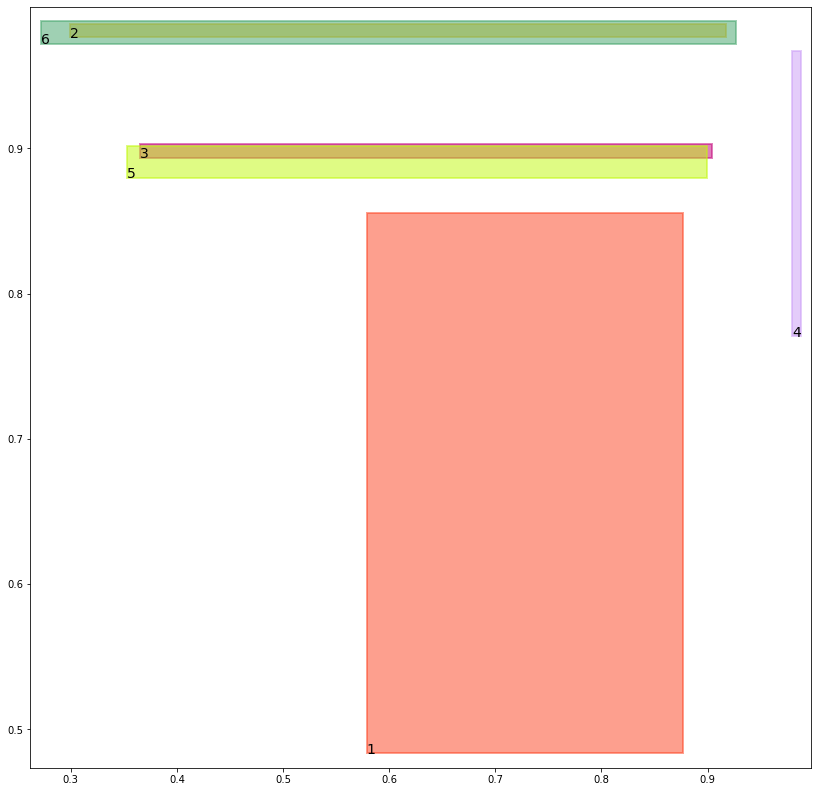

batch (tensor([[1, 2],
        [2, 6],
        [4, 5],
        [4, 6]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.2664566040039 -28.279117584228516 tensor(-54.1849212646484375) tensor(-18.2104587554931641)
tensor(2) -86.35717010498047 -30.413063049316406 tensor(-54.3870849609375000) tensor(-15.9205074310302734)
tensor(3) -83.04766082763672 -29.306922912597656 tensor(-56.2186698913574219) tensor(-17.1605796813964844)
tensor(4) -89.05571746826172 -31.651325225830078 tensor(-82.6973495483398438) tensor(-29.5031433105468750)
tensor(5) -82.72425079345703 -29.17674446105957 tensor(-55.1508903503417969) tensor(-16.7438869476318359)
tensor(6) -86.66536712646484 -30.549545288085938 tensor(-54.4737701416015625) tensor(-15.9733543395996094)


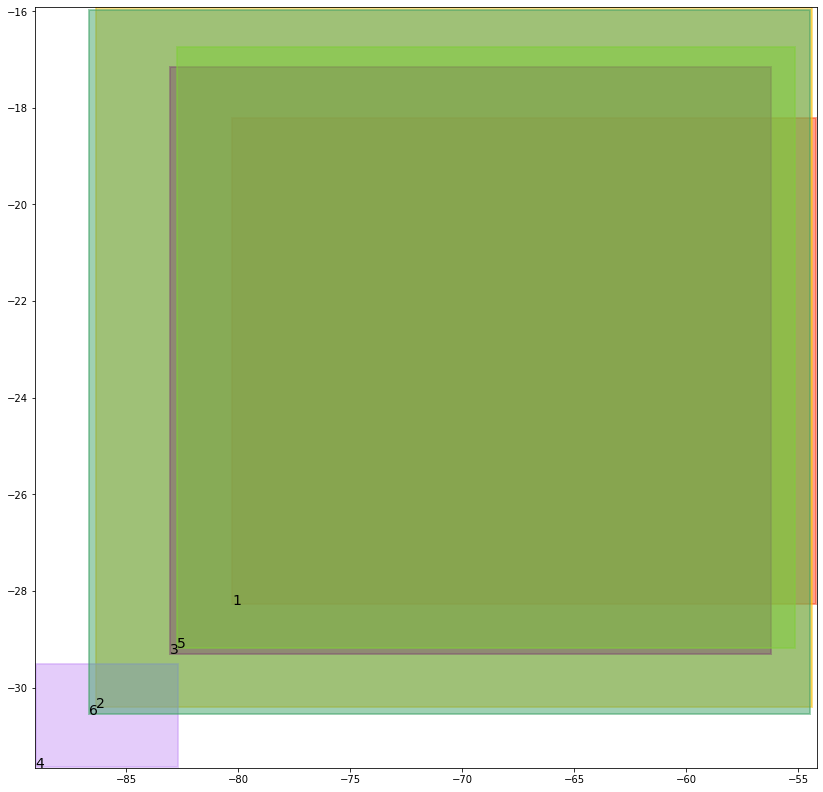

alignment data:
tensor(1) 0.5790631175041199 0.4834784269332886 tensor(0.8772073984146118) tensor(0.8554946780204773)
tensor(2) 0.2831181585788727 0.9757651090621948 tensor(0.9198716878890991) tensor(0.9864963889122009)
tensor(3) 0.3646596372127533 0.8943357467651367 tensor(0.9040278196334839) tensor(0.9039046168327332)
tensor(4) 0.9794939160346985 0.7706303000450134 tensor(0.9878630638122559) tensor(0.9670264124870300)
tensor(5) 0.35316675901412964 0.8794285655021667 tensor(0.8994300365447998) tensor(0.9005762934684753)
tensor(6) 0.2862898111343384 0.9731009602546692 tensor(0.9259696602821350) tensor(0.9869983792304993)


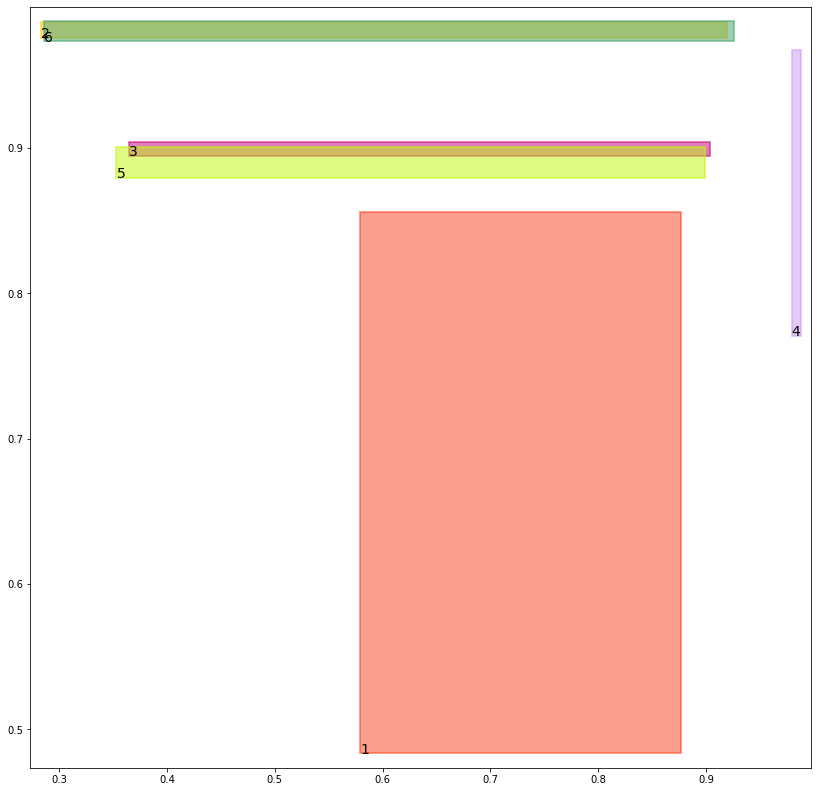

batch (tensor([[1, 3],
        [2, 6],
        [3, 5],
        [4, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.27225494384766 -28.28170394897461 tensor(-54.1887931823730469) tensor(-18.2122573852539062)
tensor(2) -86.5374526977539 -30.491008758544922 tensor(-53.5949325561523438) tensor(-15.5634050369262695)
tensor(3) -83.089111328125 -29.321107864379883 tensor(-55.8268165588378906) tensor(-16.9861297607421875)
tensor(4) -89.06180572509766 -31.654067993164062 tensor(-82.7025527954101562) tensor(-29.5055198669433594)
tensor(5) -82.72041320800781 -29.17836570739746 tensor(-55.5678253173828125) tensor(-16.9245796203613281)
tensor(6) -86.56267547607422 -30.506168365478516 tensor(-55.2449493408203125) tensor(-16.3196430206298828)


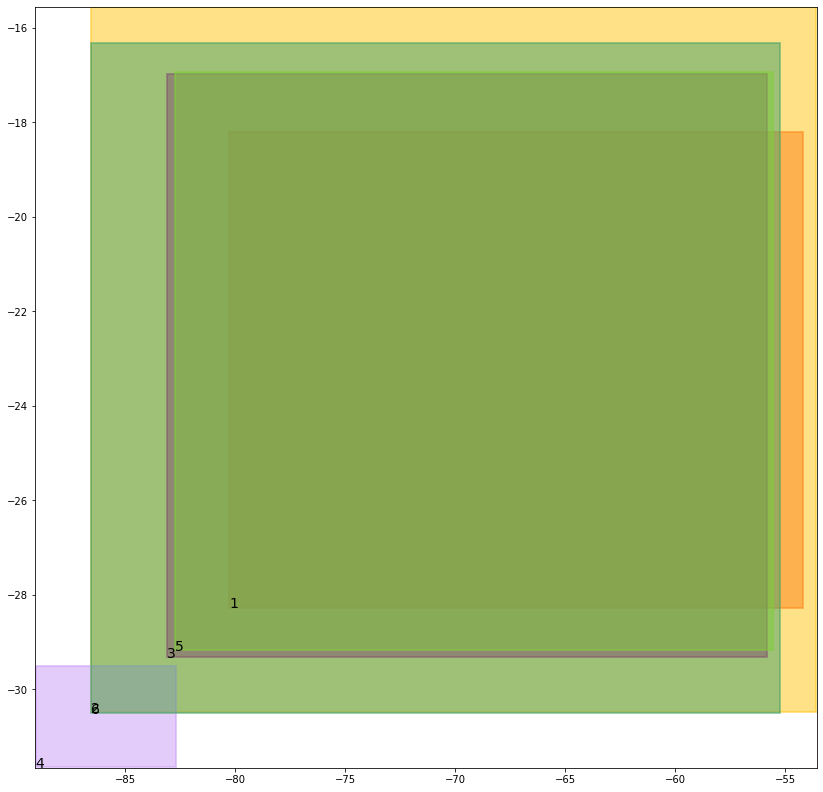

alignment data:
tensor(1) 0.5790742635726929 0.4834729731082916 tensor(0.8772124648094177) tensor(0.8554991483688354)
tensor(2) 0.2688997983932495 0.974433183670044 tensor(0.9230551719665527) tensor(0.9871962070465088)
tensor(3) 0.3578546345233917 0.8932170867919922 tensor(0.9041533470153809) tensor(0.9048704504966736)
tensor(4) 0.9794920682907104 0.7706229090690613 tensor(0.9878636598587036) tensor(0.9670276641845703)
tensor(5) 0.3597182631492615 0.8815526366233826 tensor(0.8996947407722473) tensor(0.8998593091964722)
tensor(6) 0.2998772859573364 0.9745910167694092 tensor(0.9241056442260742) tensor(0.9863794445991516)


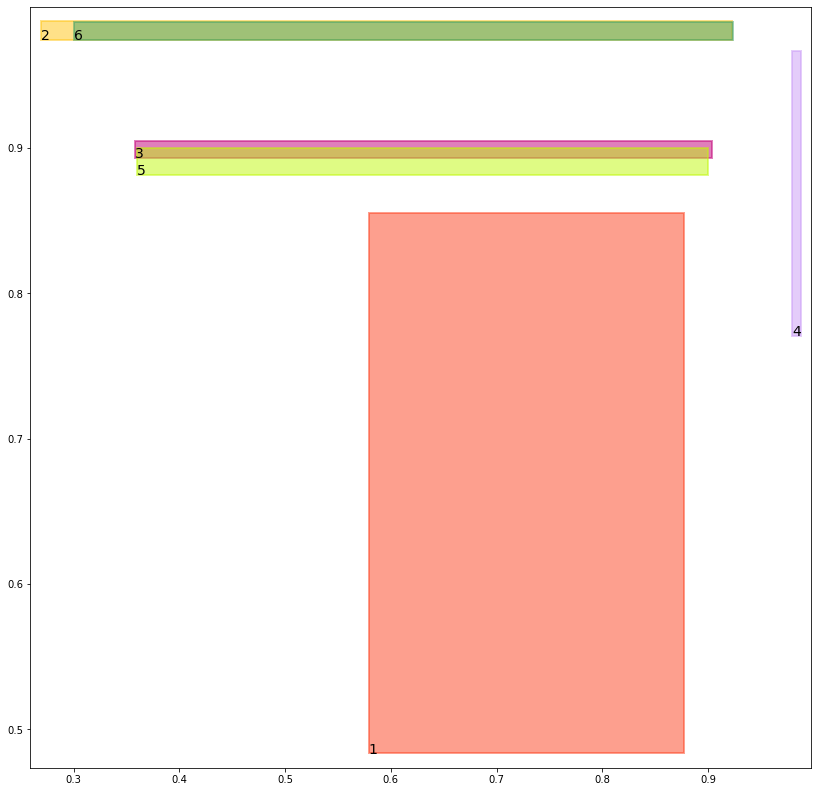

batch (tensor([[6, 2],
        [5, 3],
        [4, 5],
        [1, 2]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.27751159667969 -28.2840518951416 tensor(-54.1923065185546875) tensor(-18.2138919830322266)
tensor(2) -86.68917083740234 -30.55730628967285 tensor(-53.1918907165527344) tensor(-15.3773050308227539)
tensor(3) -82.96794891357422 -29.27083969116211 tensor(-55.8175964355468750) tensor(-16.9867057800292969)
tensor(4) -89.06732940673828 -31.656545639038086 tensor(-82.7072677612304688) tensor(-29.5076732635498047)
tensor(5) -82.885009765625 -29.246662139892578 tensor(-55.6097259521484375) tensor(-16.9343509674072266)
tensor(6) -86.47415924072266 -30.467958450317383 tensor(-55.6143188476562500) tensor(-16.4850654602050781)


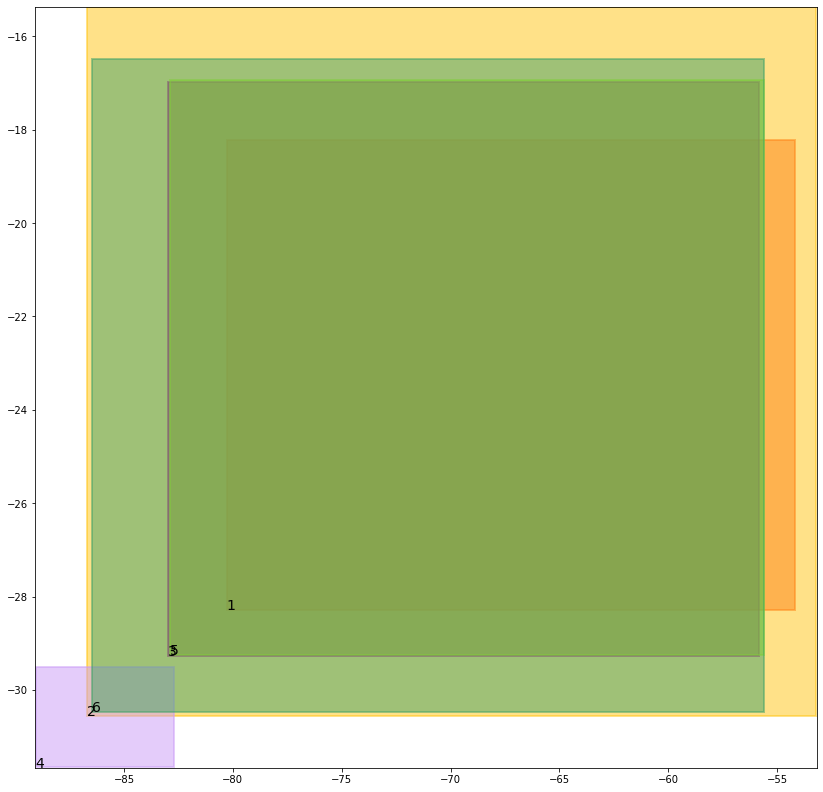

alignment data:
tensor(1) 0.5790844559669495 0.48346805572509766 tensor(0.8772171139717102) tensor(0.8555032610893250)
tensor(2) 0.2614944279193878 0.9738652110099792 tensor(0.9258230924606323) tensor(0.9876338243484497)
tensor(3) 0.3581981062889099 0.8922085165977478 tensor(0.9021164774894714) tensor(0.9039486050605774)
tensor(4) 0.9794904589653015 0.7706161737442017 tensor(0.9878640770912170) tensor(0.9670288562774658)
tensor(5) 0.3593464195728302 0.8834482431411743 tensor(0.9022090435028076) tensor(0.9011175632476807)
tensor(6) 0.3063112199306488 0.9753771424293518 tensor(0.9223805665969849) tensor(0.9860223531723022)


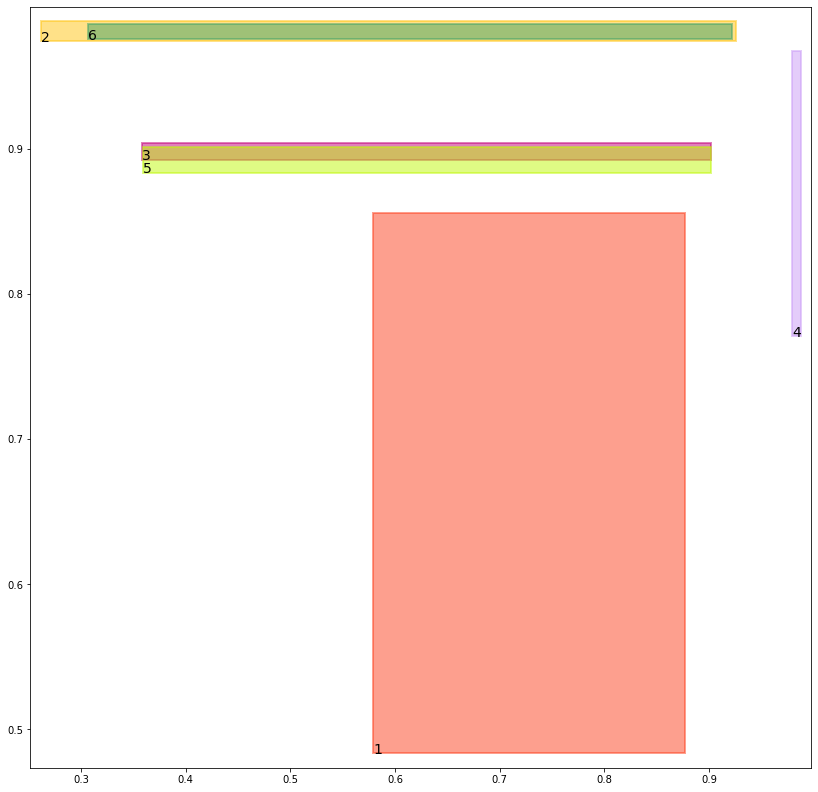

batch (tensor([[2, 6],
        [5, 3],
        [1, 3],
        [6, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.28227233886719 -28.286178588867188 tensor(-54.1954727172851562) tensor(-18.2153663635253906)
tensor(2) -86.77982330322266 -30.596839904785156 tensor(-53.0199394226074219) tensor(-15.2957391738891602)
tensor(3) -82.81843566894531 -29.213123321533203 tensor(-56.0367660522460938) tensor(-17.0916290283203125)
tensor(4) -89.07231903076172 -31.65878677368164 tensor(-82.7115402221679688) tensor(-29.5096225738525391)
tensor(5) -83.06937408447266 -29.318735122680664 tensor(-55.4254341125488281) tensor(-16.8413467407226562)
tensor(6) -86.4382553100586 -30.452600479125977 tensor(-55.7247543334960938) tensor(-16.5337028503417969)


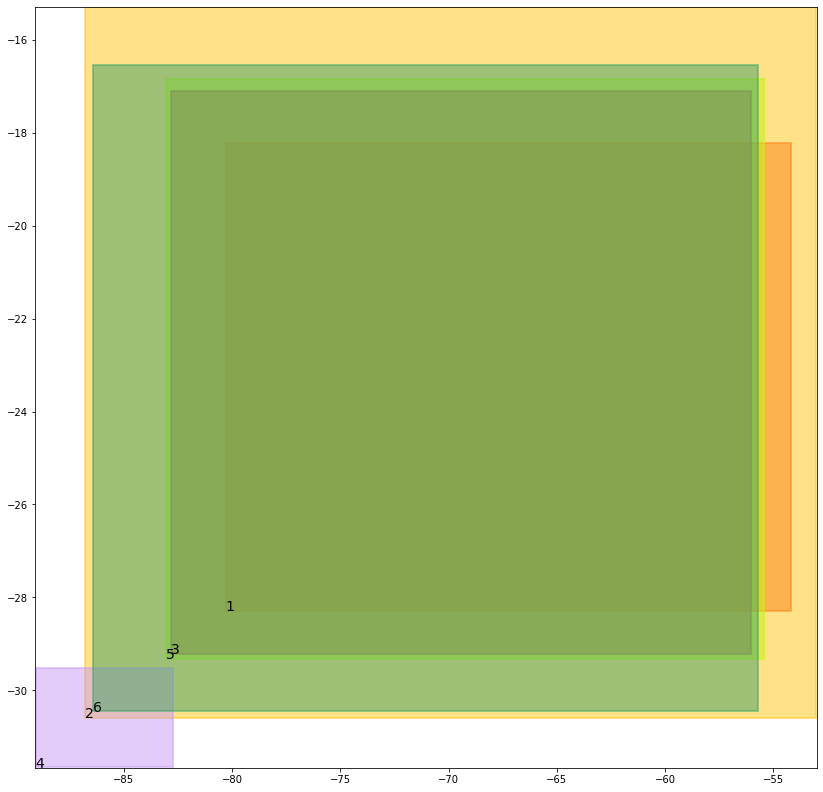

alignment data:
tensor(1) 0.5790935754776001 0.4834635555744171 tensor(0.8772213459014893) tensor(0.8555068969726562)
tensor(2) 0.2581709325313568 0.9738121628761292 tensor(0.9274317026138306) tensor(0.9879123568534851)
tensor(3) 0.36279505491256714 0.8912910223007202 tensor(0.9002350568771362) tensor(0.9018820524215698)
tensor(4) 0.9794890880584717 0.7706100940704346 tensor(0.9878645539283752) tensor(0.9670298695564270)
tensor(5) 0.35483863949775696 0.8851420283317566 tensor(0.9044373035430908) tensor(0.9034756422042847)
tensor(6) 0.3081105649471283 0.975756824016571 tensor(0.9216445684432983) tensor(0.9858477115631104)


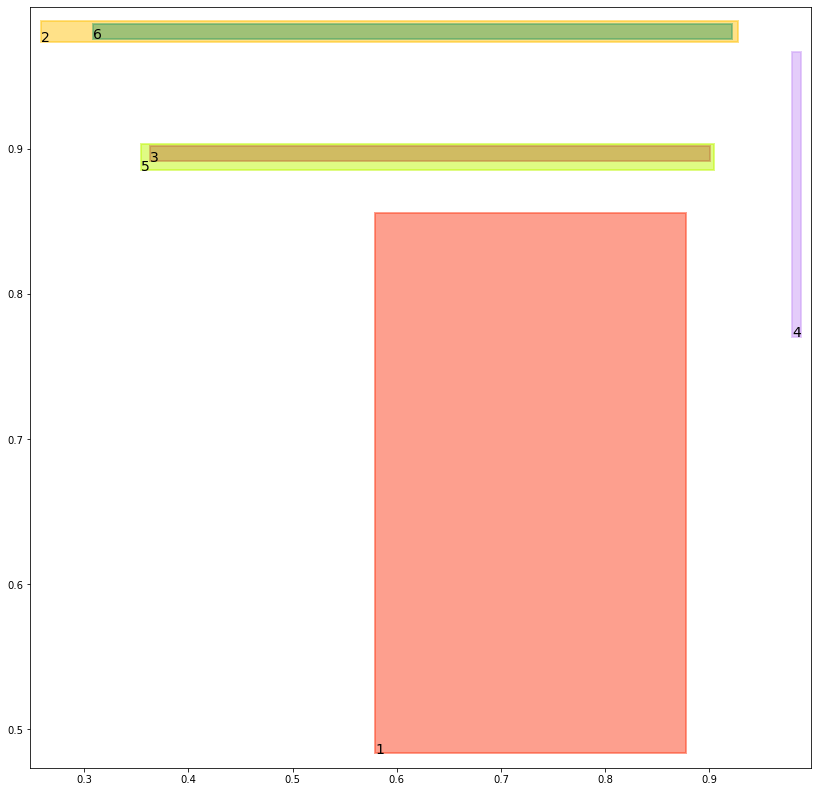

batch (tensor([[1, 2],
        [3, 5],
        [4, 6],
        [4, 5]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.28658294677734 -28.28809928894043 tensor(-54.1983489990234375) tensor(-18.2167034149169922)
tensor(2) -86.86042022705078 -30.631994247436523 tensor(-52.8654632568359375) tensor(-15.2224645614624023)
tensor(3) -83.01107788085938 -29.291404724121094 tensor(-55.4379806518554688) tensor(-16.8417263031005859)
tensor(4) -89.07685089111328 -31.66082191467285 tensor(-82.7154006958007812) tensor(-29.5113887786865234)
tensor(5) -82.91742706298828 -29.25736427307129 tensor(-56.0438385009765625) tensor(-17.0962619781494141)
tensor(6) -86.4054183959961 -30.438554763793945 tensor(-55.8248748779296875) tensor(-16.5778255462646484)


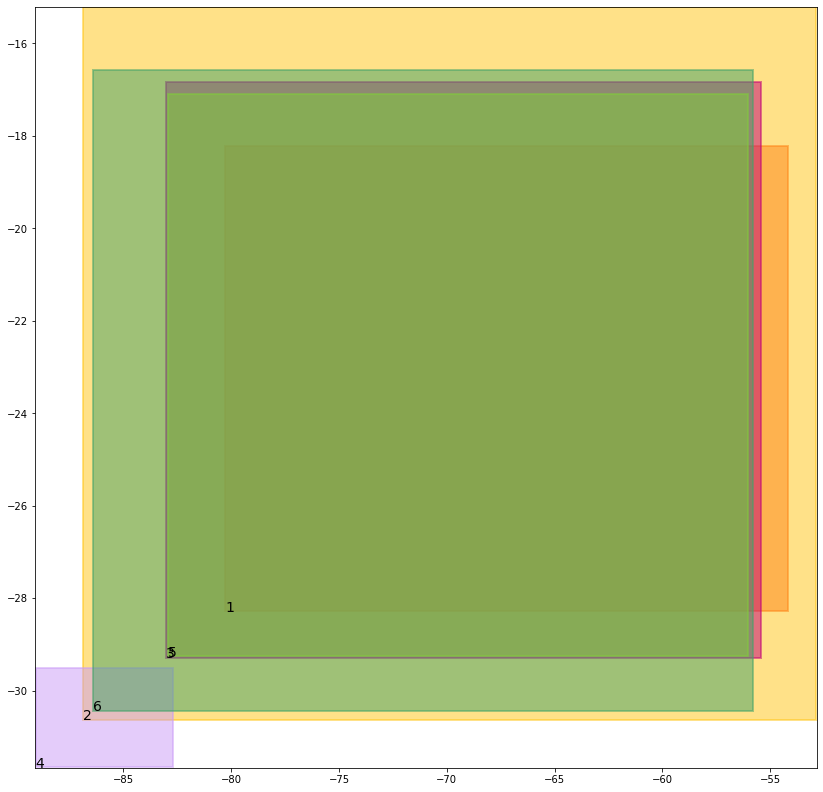

alignment data:
tensor(1) 0.5791019201278687 0.48345947265625 tensor(0.8772251009941101) tensor(0.8555102944374084)
tensor(2) 0.25518539547920227 0.9737641215324402 tensor(0.9288604259490967) tensor(0.9881591796875000)
tensor(3) 0.35440269112586975 0.8862126469612122 tensor(0.9029873609542847) tensor(0.9037071466445923)
tensor(4) 0.9794877171516418 0.77060467004776 tensor(0.9878649115562439) tensor(0.9670307636260986)
tensor(5) 0.3630512058734894 0.890984833240509 tensor(0.9021608829498291) tensor(0.9019589424133301)
tensor(6) 0.30974486470222473 0.9760956764221191 tensor(0.9209727048873901) tensor(0.9856876730918884)


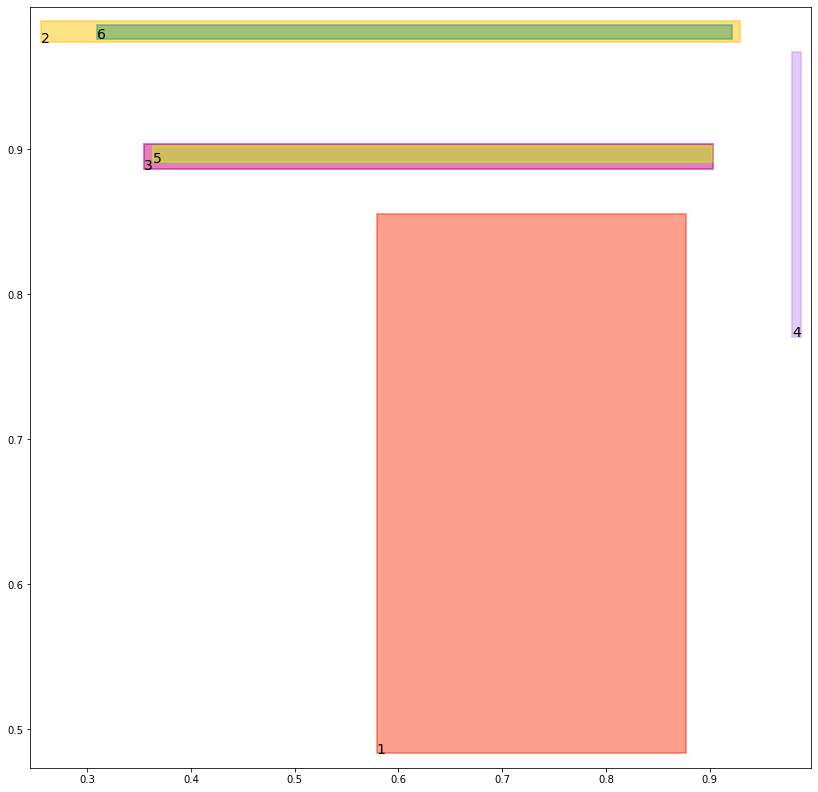

batch (tensor([[4, 6],
        [1, 3],
        [6, 2],
        [2, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.29047393798828 -28.289844512939453 tensor(-54.2009506225585938) tensor(-18.2179164886474609)
tensor(2) -86.87156677246094 -30.636690139770508 tensor(-52.9991722106933594) tensor(-15.2824087142944336)
tensor(3) -83.18187713623047 -29.360780715942383 tensor(-54.8943862915039062) tensor(-16.6156635284423828)
tensor(4) -89.08094024658203 -31.662660598754883 tensor(-82.7188949584960938) tensor(-29.5129909515380859)
tensor(5) -82.77725982666016 -29.200721740722656 tensor(-56.6005706787109375) tensor(-17.3267173767089844)
tensor(6) -86.4460220336914 -30.456388473510742 tensor(-55.5773696899414062) tensor(-16.4648609161376953)


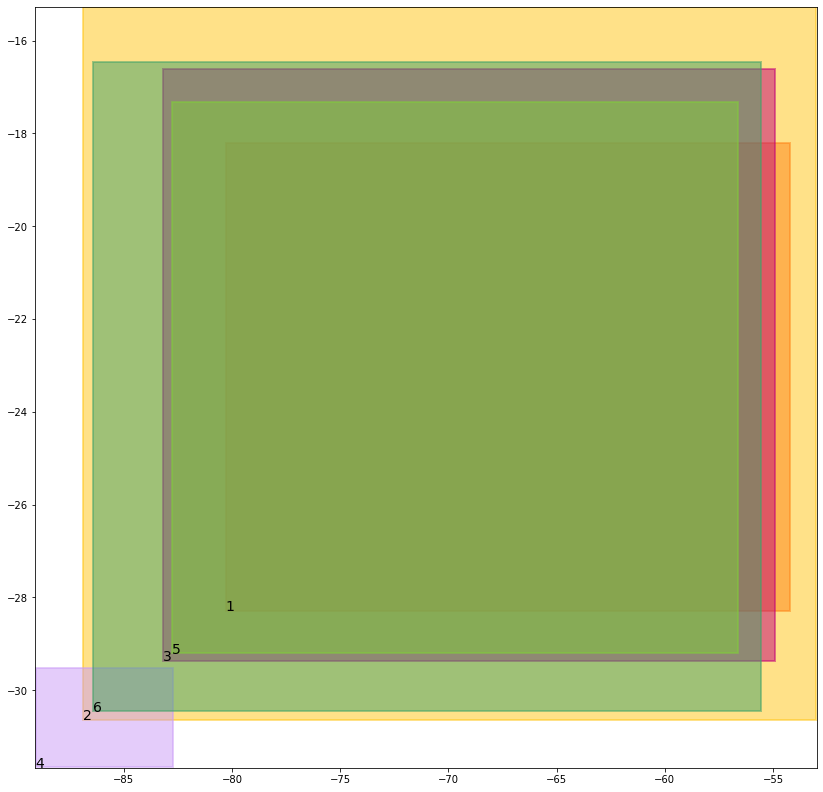

alignment data:
tensor(1) 0.5791094899177551 0.4834558069705963 tensor(0.8772284984588623) tensor(0.8555133938789368)
tensor(2) 0.25731801986694336 0.9744194149971008 tensor(0.9289647936820984) tensor(0.9882295131683350)
tensor(3) 0.34688031673431396 0.8814373016357422 tensor(0.9054206013679504) tensor(0.9053333401679993)
tensor(4) 0.9794865846633911 0.7705996036529541 tensor(0.9878652691841125) tensor(0.9670316576957703)
tensor(5) 0.37055686116218567 0.8960486054420471 tensor(0.9000580310821533) tensor(0.9005674123764038)
tensor(6) 0.3051208257675171 0.9759485721588135 tensor(0.9216739535331726) tensor(0.9857842326164246)


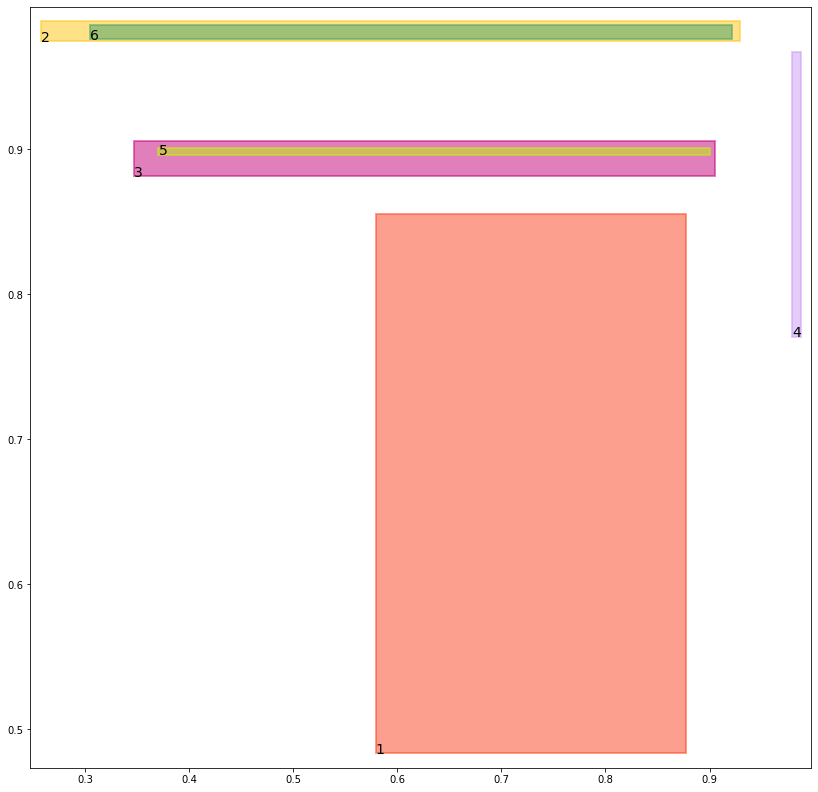

batch (tensor([[5, 3],
        [3, 5],
        [1, 2],
        [4, 5]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.29399871826172 -28.291419982910156 tensor(-54.2033081054687500) tensor(-18.2190132141113281)
tensor(2) -86.88165283203125 -30.640933990478516 tensor(-53.1203346252441406) tensor(-15.3368072509765625)
tensor(3) -83.18020629882812 -29.361520767211914 tensor(-54.8051910400390625) tensor(-16.5839519500732422)
tensor(4) -89.08465576171875 -31.664329528808594 tensor(-82.7220687866210938) tensor(-29.5144348144531250)
tensor(5) -82.81454467773438 -29.214767456054688 tensor(-56.7131729125976562) tensor(-17.3656578063964844)
tensor(6) -86.4825210571289 -30.472427368164062 tensor(-55.3550376892089844) tensor(-16.3633842468261719)


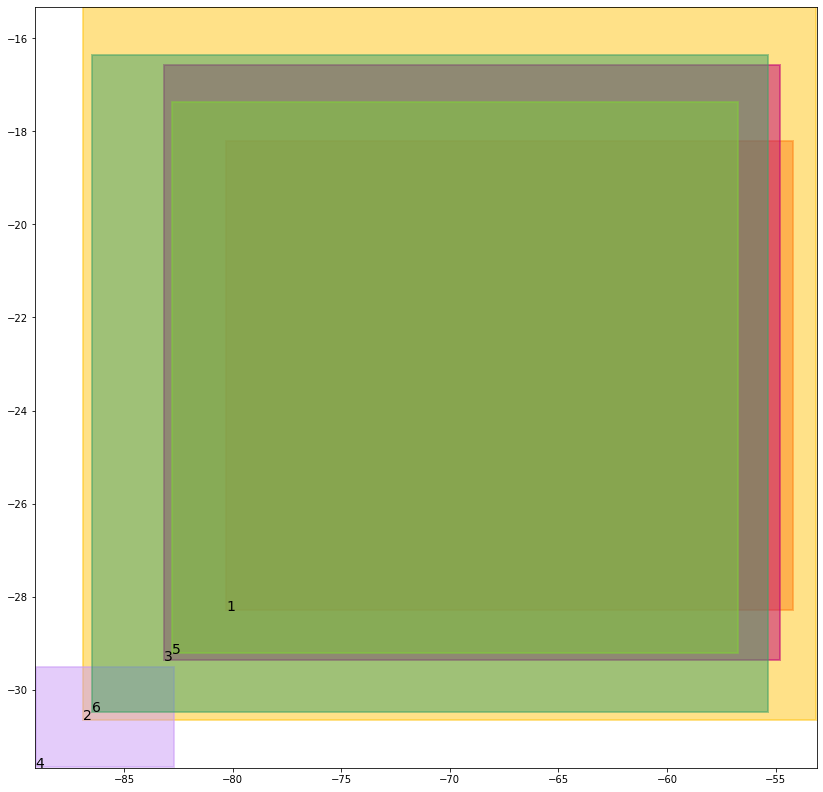

alignment data:
tensor(1) 0.5791162848472595 0.48345252871513367 tensor(0.8772315979003906) tensor(0.8555160760879517)
tensor(2) 0.259258896112442 0.9749988317489624 tensor(0.9290592670440674) tensor(0.9882928729057312)
tensor(3) 0.34625324606895447 0.87954181432724 tensor(0.9055197238922119) tensor(0.9050145745277405)
tensor(4) 0.9794854521751404 0.770595133304596 tensor(0.9878656268119812) tensor(0.9670324325561523)
tensor(5) 0.37114620208740234 0.898619532585144 tensor(0.9003832936286926) tensor(0.9011589884757996)
tensor(6) 0.3009679317474365 0.9758147597312927 tensor(0.9223039150238037) tensor(0.9858710169792175)


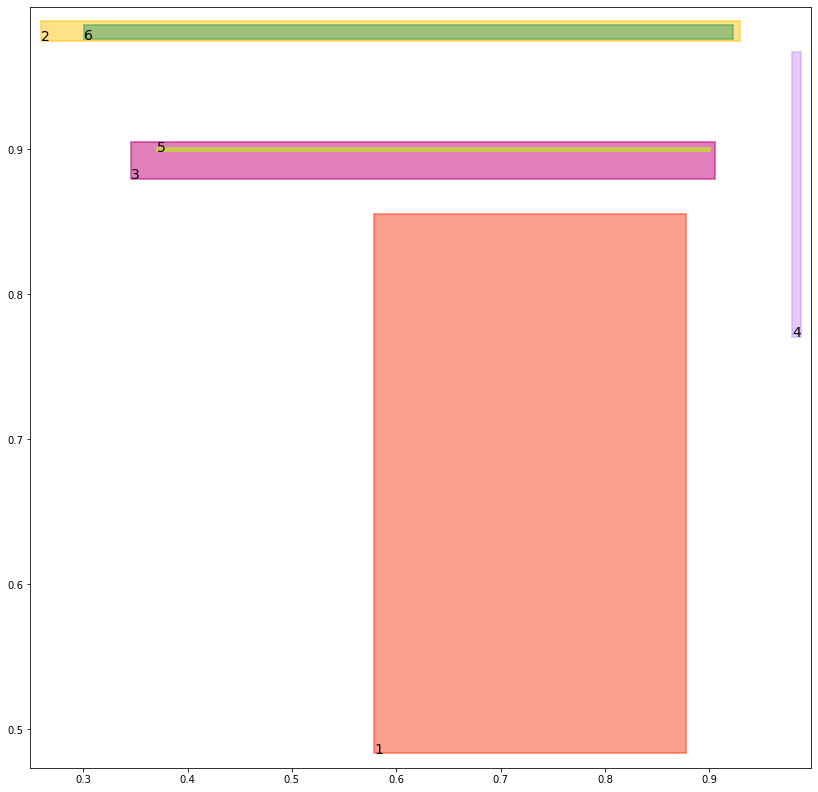

batch (tensor([[1, 3],
        [6, 2],
        [3, 5],
        [4, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.29720306396484 -28.292848587036133 tensor(-54.2054367065429688) tensor(-18.2200050354003906)
tensor(2) -86.8295669555664 -30.617895126342773 tensor(-53.5067787170410156) tensor(-15.5137233734130859)
tensor(3) -83.17867279052734 -29.362184524536133 tensor(-54.7237701416015625) tensor(-16.5550441741943359)
tensor(4) -89.0880126953125 -31.66583824157715 tensor(-82.7249298095703125) tensor(-29.5157451629638672)
tensor(5) -82.8481674194336 -29.227439880371094 tensor(-56.8136444091796875) tensor(-17.4004764556884766)
tensor(6) -86.58338165283203 -30.516393661499023 tensor(-54.8316993713378906) tensor(-16.1260757446289062)


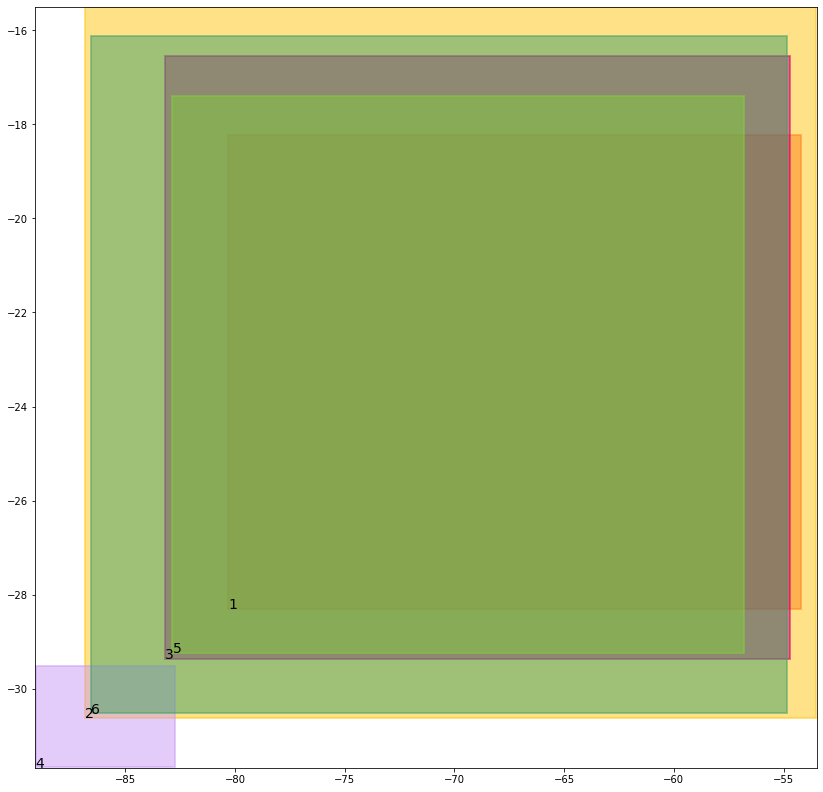

alignment data:
tensor(1) 0.5791224241256714 0.48344945907592773 tensor(0.8772344589233398) tensor(0.8555185794830322)
tensor(2) 0.2659533619880676 0.9761289358139038 tensor(0.9279653429985046) tensor(0.9882016777992249)
tensor(3) 0.3456859886646271 0.8778033256530762 tensor(0.9056093692779541) tensor(0.9047250747680664)
tensor(4) 0.9794843792915344 0.7705910801887512 tensor(0.9878658652305603) tensor(0.9670330882072449)
tensor(5) 0.37168002128601074 0.900898277759552 tensor(0.9006767868995667) tensor(0.9016918540000916)
tensor(6) 0.2914189398288727 0.9752210974693298 tensor(0.9241352081298828) tensor(0.9861847758293152)


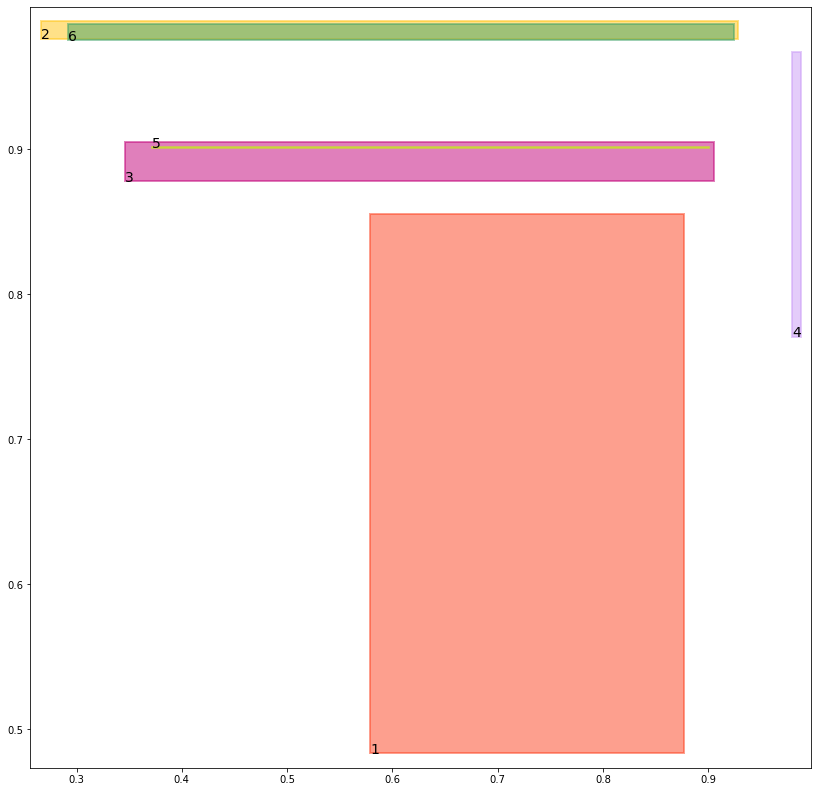

batch (tensor([[1, 2],
        [2, 6],
        [4, 5],
        [5, 3]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.30010223388672 -28.294139862060547 tensor(-54.2073745727539062) tensor(-18.2209014892578125)
tensor(2) -86.78174591064453 -30.59674072265625 tensor(-53.8484115600585938) tensor(-15.6683149337768555)
tensor(3) -83.02088165283203 -29.300827026367188 tensor(-55.0551681518554688) tensor(-16.7018299102783203)
tensor(4) -89.09104919433594 -31.66720199584961 tensor(-82.7275390625000000) tensor(-29.5169334411621094)
tensor(5) -83.03846740722656 -29.30255889892578 tensor(-56.5237312316894531) tensor(-17.2658405303955078)
tensor(6) -86.67281341552734 -30.555381774902344 tensor(-54.3813858032226562) tensor(-15.9195985794067383)


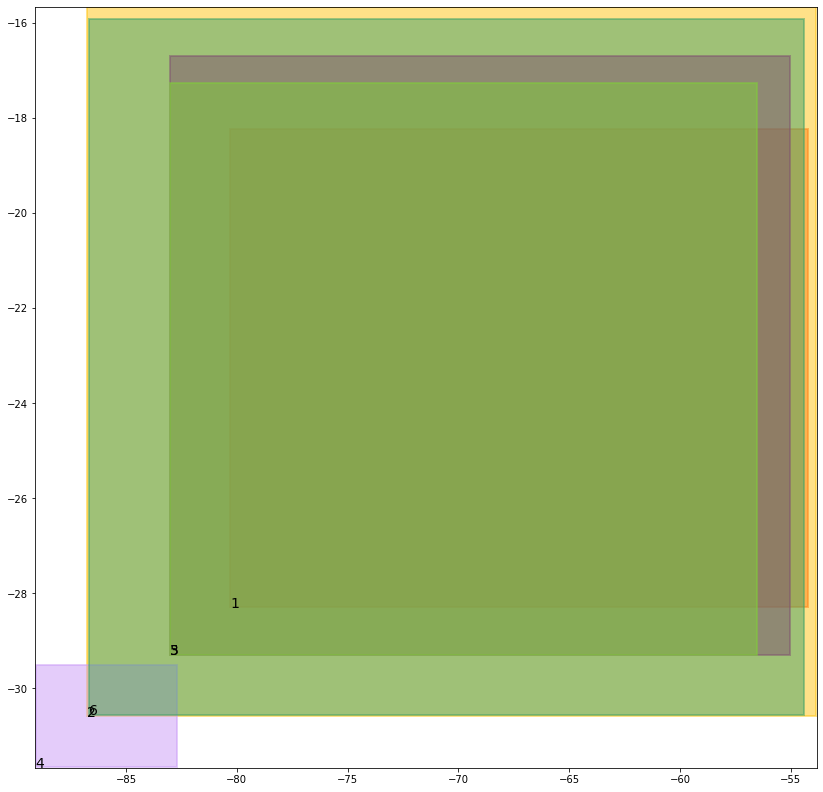

alignment data:
tensor(1) 0.5791280269622803 0.48344677686691284 tensor(0.8772370219230652) tensor(0.8555208444595337)
tensor(2) 0.2721078097820282 0.9765456318855286 tensor(0.9269617795944214) tensor(0.9881187081336975)
tensor(3) 0.35127919912338257 0.8788577914237976 tensor(0.9036059975624084) tensor(0.9026396870613098)
tensor(4) 0.9794836044311523 0.7705873847007751 tensor(0.9878661632537842) tensor(0.9670338034629822)
tensor(5) 0.36600545048713684 0.9012104272842407 tensor(0.9031177759170532) tensor(0.9039682745933533)
tensor(6) 0.2829340398311615 0.9751725792884827 tensor(0.9257578849792480) tensor(0.9864627718925476)


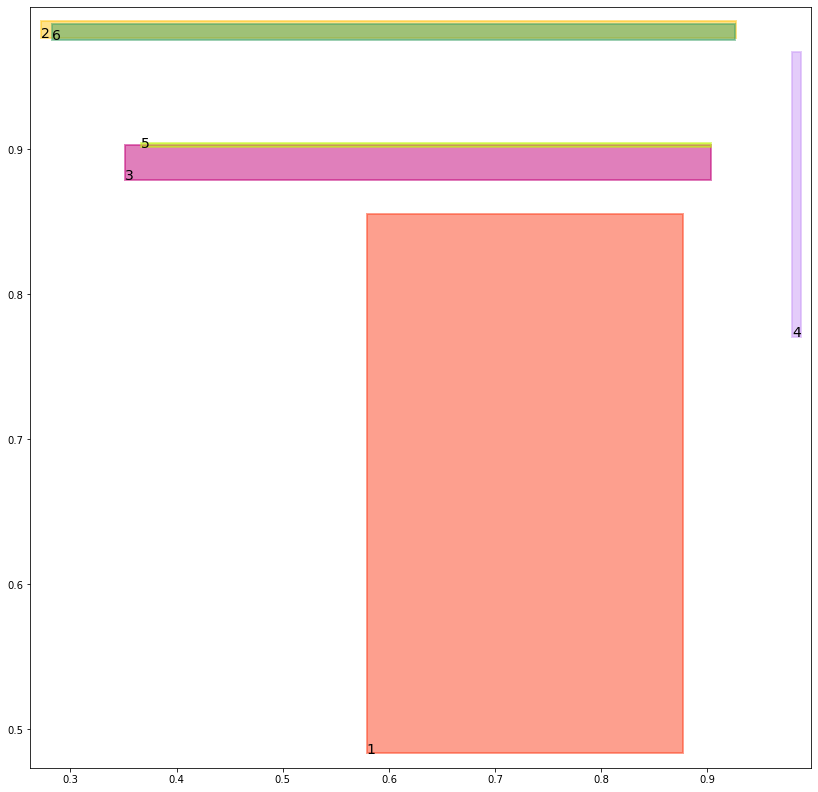

batch (tensor([[4, 6],
        [4, 5],
        [3, 5],
        [6, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.30272674560547 -28.295310974121094 tensor(-54.2091178894042969) tensor(-18.2217178344726562)
tensor(2) -86.67285919189453 -30.54875946044922 tensor(-54.4391326904296875) tensor(-15.9374084472656250)
tensor(3) -82.93262481689453 -29.261404037475586 tensor(-55.3568420410156250) tensor(-16.8355178833007812)
tensor(4) -89.09380340576172 -31.668441772460938 tensor(-82.7298812866210938) tensor(-29.5180072784423828)
tensor(5) -83.15309143066406 -29.352947235107422 tensor(-56.2633056640625000) tensor(-17.1448860168457031)
tensor(6) -86.81490325927734 -30.617229461669922 tensor(-53.6959342956542969) tensor(-15.6052188873291016)


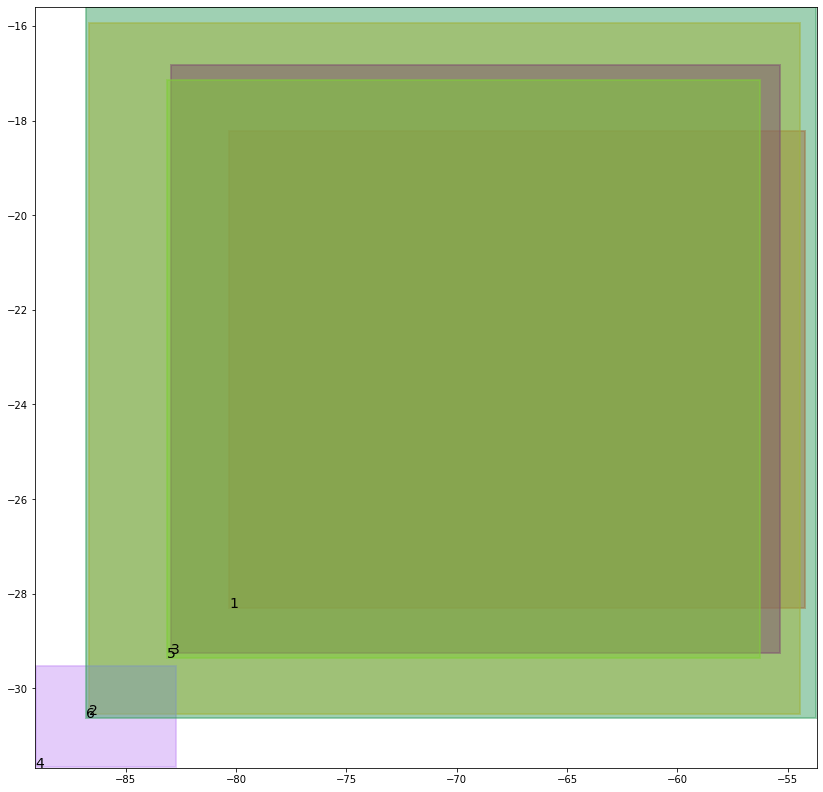

alignment data:
tensor(1) 0.5791330337524414 0.48344433307647705 tensor(0.8772393465042114) tensor(0.8555228710174561)
tensor(2) 0.28297778964042664 0.9769212603569031 tensor(0.9247862100601196) tensor(0.9878892302513123)
tensor(3) 0.3563777506351471 0.8798055648803711 tensor(0.9017598628997803) tensor(0.9025703668594360)
tensor(4) 0.9794827699661255 0.770583987236023 tensor(0.9878664016723633) tensor(0.9670343399047852)
tensor(5) 0.3609064817428589 0.9014934301376343 tensor(0.9052791595458984) tensor(0.9042372703552246)
tensor(6) 0.27002429962158203 0.9751284718513489 tensor(0.9283629655838013) tensor(0.9869272112846375)


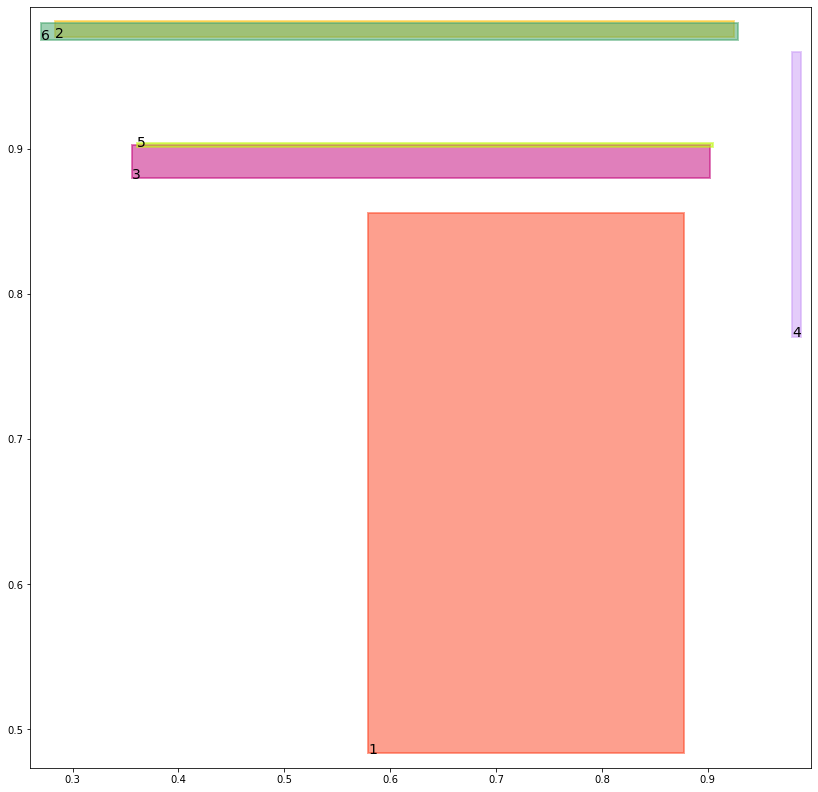

batch (tensor([[2, 6],
        [5, 3],
        [1, 2],
        [1, 3]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.30509185791016 -28.296371459960938 tensor(-54.2107009887695312) tensor(-18.2224521636962891)
tensor(2) -86.6355972290039 -30.532957077026367 tensor(-54.6731376647949219) tensor(-16.0456981658935547)
tensor(3) -82.84879302978516 -29.22405433654785 tensor(-56.0379333496093750) tensor(-17.1315402984619141)
tensor(4) -89.09629821777344 -31.6695613861084 tensor(-82.7320175170898438) tensor(-29.5189781188964844)
tensor(5) -83.25533294677734 -29.397314071655273 tensor(-55.6593246459960938) tensor(-16.8749675750732422)
tensor(6) -86.8858871459961 -30.64731788635254 tensor(-53.3895034790039062) tensor(-15.4610452651977539)


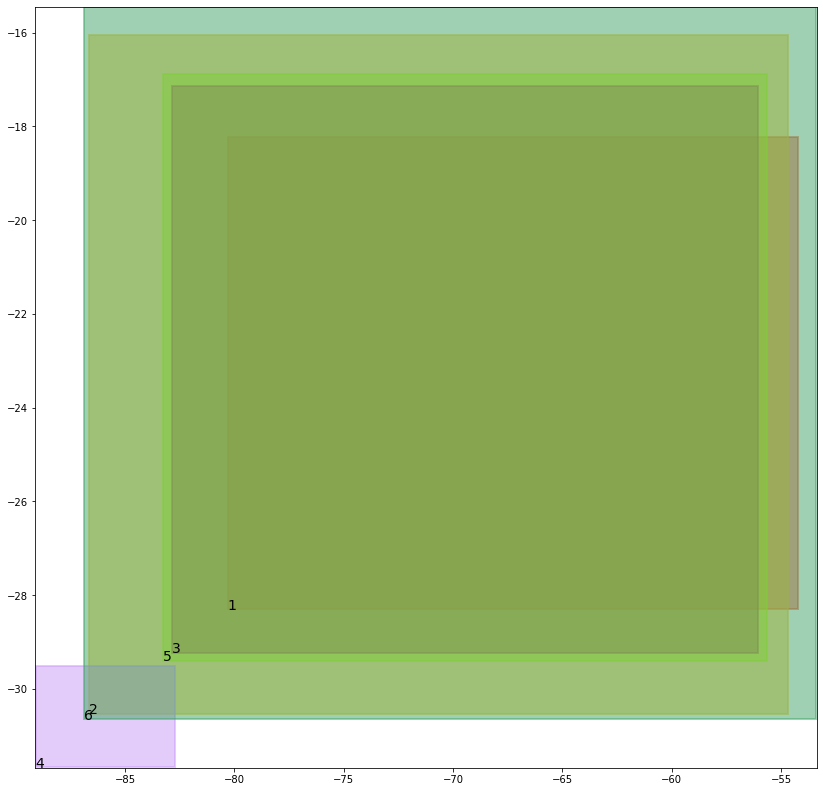

alignment data:
tensor(1) 0.5791376233100891 0.483442097902298 tensor(0.8772414326667786) tensor(0.8555247187614441)
tensor(2) 0.28747162222862244 0.976715624332428 tensor(0.9240959882736206) tensor(0.9876777529716492)
tensor(3) 0.36723756790161133 0.8831467032432556 tensor(0.9000231027603149) tensor(0.9024822115898132)
tensor(4) 0.9794819951057434 0.7705810070037842 tensor(0.9878666400909424) tensor(0.9670348763465881)
tensor(5) 0.35036274790763855 0.9000144600868225 tensor(0.9071983098983765) tensor(0.9044800996780396)
tensor(6) 0.2639341354370117 0.975590705871582 tensor(0.9295307397842407) tensor(0.9873318076133728)


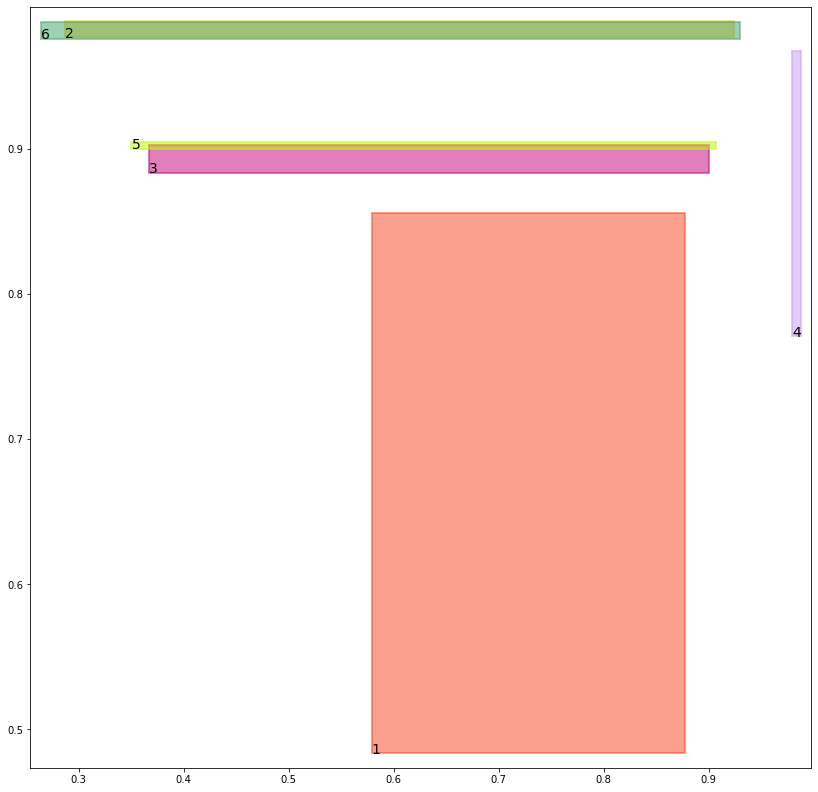

batch (tensor([[2, 6],
        [5, 3],
        [3, 5],
        [1, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.30724334716797 -28.29732894897461 tensor(-54.2121353149414062) tensor(-18.2231197357177734)
tensor(2) -86.64404296875 -30.537673950195312 tensor(-54.6792373657226562) tensor(-16.0511703491210938)
tensor(3) -82.88136291503906 -29.233461380004883 tensor(-56.4827613830566406) tensor(-17.3134899139404297)
tensor(4) -89.09854888916016 -31.67057228088379 tensor(-82.7339401245117188) tensor(-29.5198574066162109)
tensor(5) -83.24633026123047 -29.396240234375 tensor(-55.2935485839843750) tensor(-16.7195148468017578)
tensor(6) -86.91382598876953 -30.65825653076172 tensor(-53.3075790405273438) tensor(-15.4183349609375000)


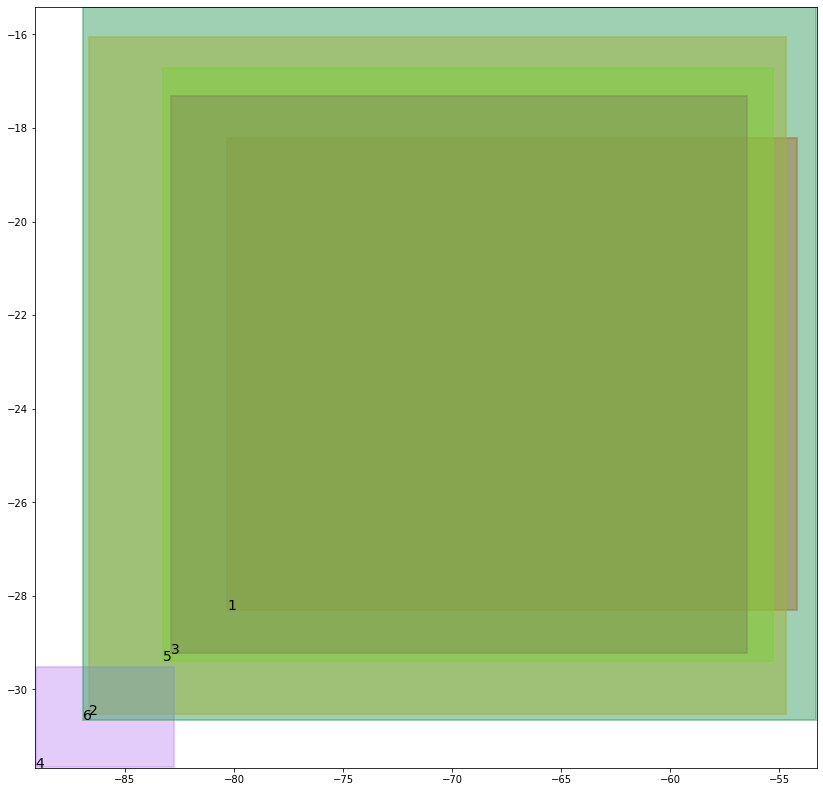

alignment data:
tensor(1) 0.5791417956352234 0.4834400415420532 tensor(0.8772432804107666) tensor(0.8555263876914978)
tensor(2) 0.2878824472427368 0.9761573076248169 tensor(0.9243518710136414) tensor(0.9874831438064575)
tensor(3) 0.37298449873924255 0.8876439332962036 tensor(0.8999304771423340) tensor(0.9036142230033875)
tensor(4) 0.9794812798500061 0.7705782651901245 tensor(0.9878667593002319) tensor(0.9670353531837463)
tensor(5) 0.34491434693336487 0.8974824547767639 tensor(0.9075753688812256) tensor(0.9035081863403320)
tensor(6) 0.2619127929210663 0.9763211607933044 tensor(0.9298399686813354) tensor(0.9876849651336670)


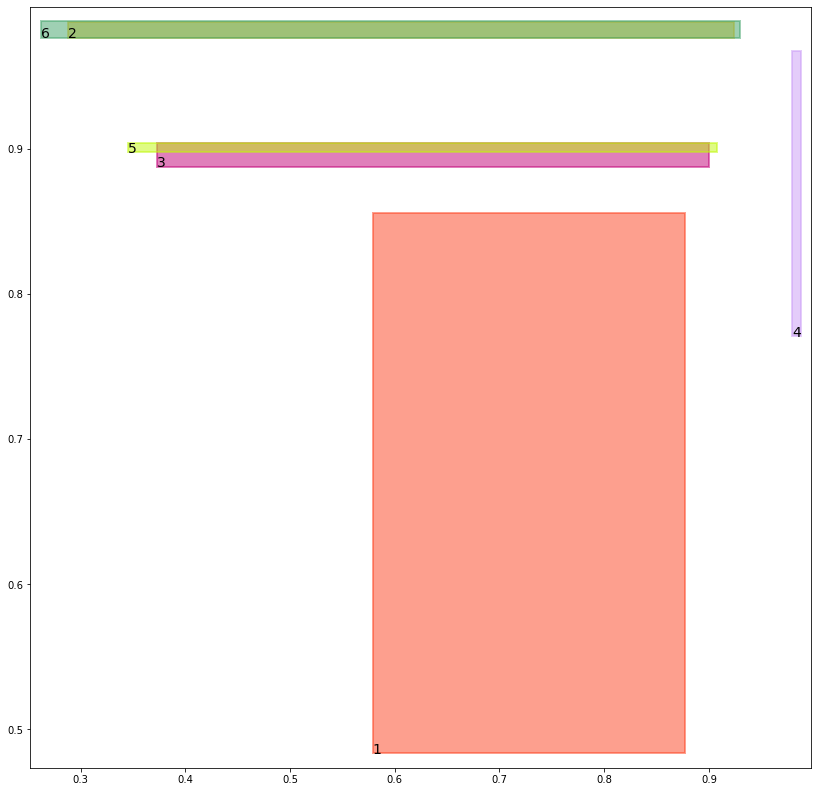

batch (tensor([[4, 5],
        [6, 2],
        [4, 6],
        [1, 3]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.30917358398438 -28.29819679260254 tensor(-54.2134284973144531) tensor(-18.2237224578857422)
tensor(2) -86.65158081054688 -30.541898727416992 tensor(-54.7192687988281250) tensor(-16.0664424896240234)
tensor(3) -82.91053009033203 -29.241878509521484 tensor(-56.8830108642578125) tensor(-17.4777297973632812)
tensor(4) -89.10059356689453 -31.67148780822754 tensor(-82.7356796264648438) tensor(-29.5206508636474609)
tensor(5) -83.23789978027344 -29.395164489746094 tensor(-54.9628372192382812) tensor(-16.5792179107666016)
tensor(6) -86.93879699707031 -30.668054580688477 tensor(-53.2059135437011719) tensor(-15.3713130950927734)


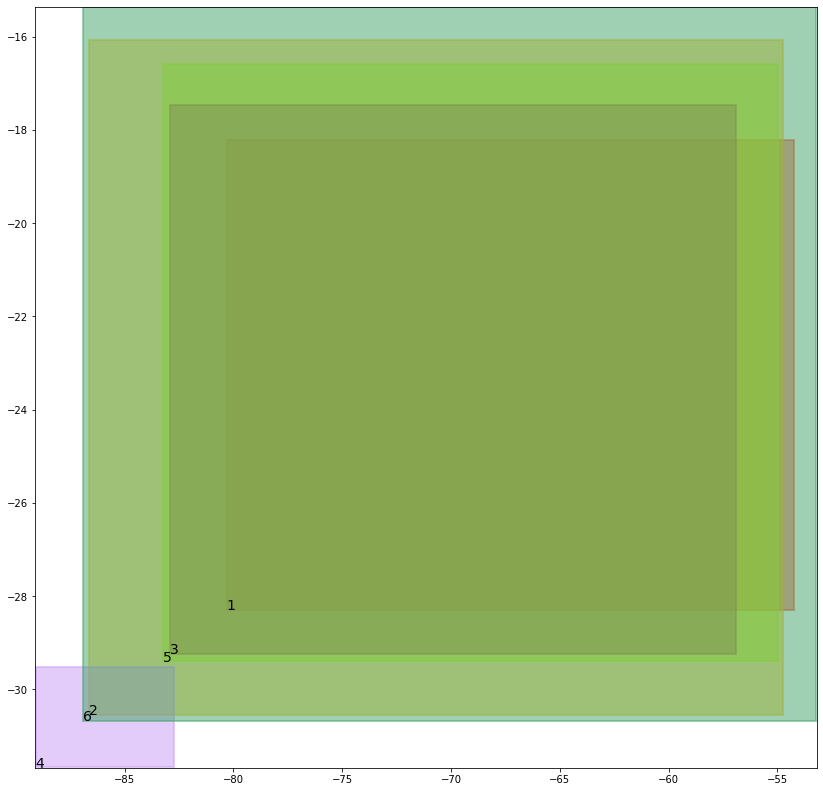

alignment data:
tensor(1) 0.5791455507278442 0.4834381937980652 tensor(0.8772450089454651) tensor(0.8555278778076172)
tensor(2) 0.28825587034225464 0.9767726063728333 tensor(0.9245825409889221) tensor(0.9873045086860657)
tensor(3) 0.3782169222831726 0.8915830254554749 tensor(0.8998463749885559) tensor(0.9046287536621094)
tensor(4) 0.9794807434082031 0.770575761795044 tensor(0.9878669977188110) tensor(0.9670357704162598)
tensor(5) 0.340018093585968 0.8951422572135925 tensor(0.9079157114028931) tensor(0.9026208519935608)
tensor(6) 0.26009199023246765 0.9760614633560181 tensor(0.9301186800003052) tensor(0.9879961609840393)


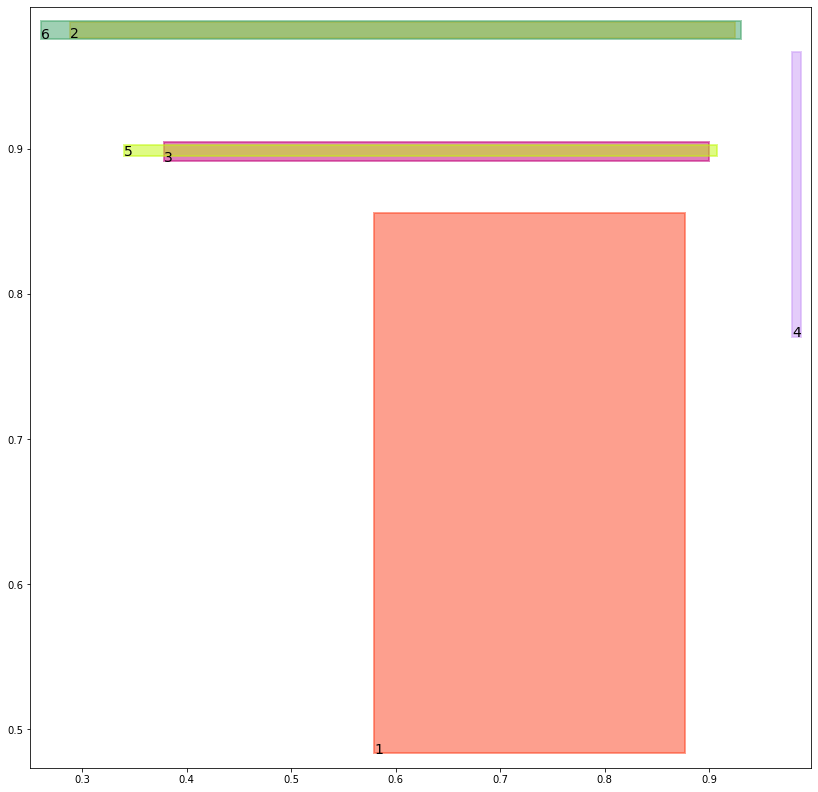

batch (tensor([[5, 3],
        [4, 6],
        [1, 3],
        [6, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.31092834472656 -28.29898452758789 tensor(-54.2146034240722656) tensor(-18.2242679595947266)
tensor(2) -86.6583023071289 -30.545684814453125 tensor(-54.7550888061523438) tensor(-16.0801448822021484)
tensor(3) -82.8812255859375 -29.232738494873047 tensor(-57.3058967590332031) tensor(-17.6449279785156250)
tensor(4) -89.1024398803711 -31.672317504882812 tensor(-82.7372665405273438) tensor(-29.5213756561279297)
tensor(5) -83.28519439697266 -29.412269592285156 tensor(-54.6035766601562500) tensor(-16.4345722198486328)
tensor(6) -86.9611587524414 -30.676843643188477 tensor(-53.1142044067382812) tensor(-15.3289070129394531)


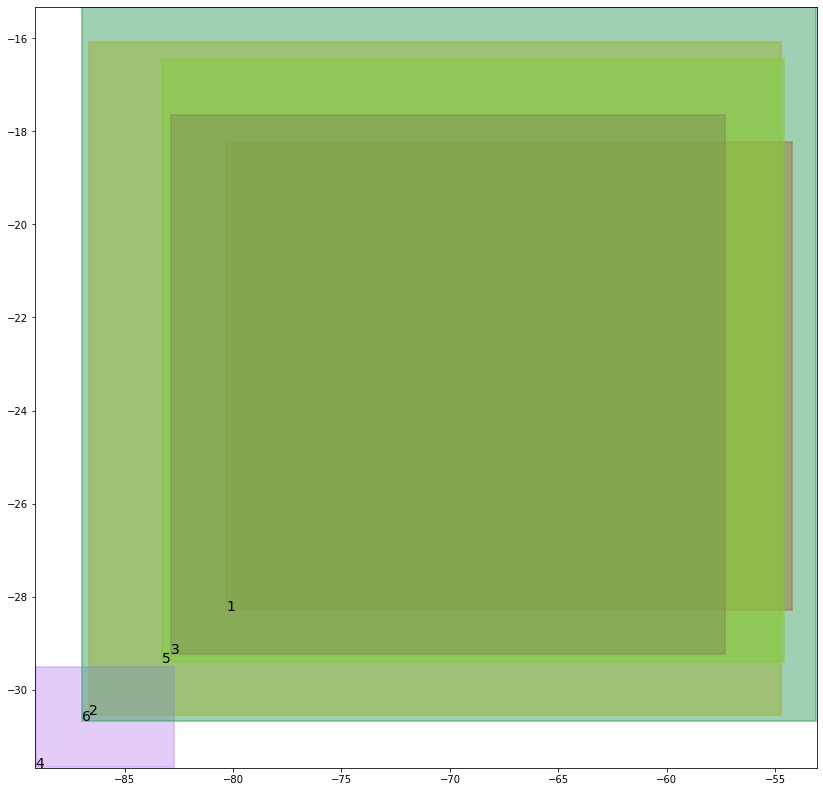

alignment data:
tensor(1) 0.5791489481925964 0.4834365248680115 tensor(0.8772465586662292) tensor(0.8555292487144470)
tensor(2) 0.2885940670967102 0.9773159623146057 tensor(0.9247906804084778) tensor(0.9871405959129333)
tensor(3) 0.3830030560493469 0.8970351219177246 tensor(0.8997611403465271) tensor(0.9037573337554932)
tensor(4) 0.9794802665710449 0.7705734968185425 tensor(0.9878671169281006) tensor(0.9670362472534180)
tensor(5) 0.33561626076698303 0.8910208940505981 tensor(0.9082225561141968) tensor(0.9036284685134888)
tensor(6) 0.2584512531757355 0.9758240580558777 tensor(0.9303699731826782) tensor(0.9882710576057434)


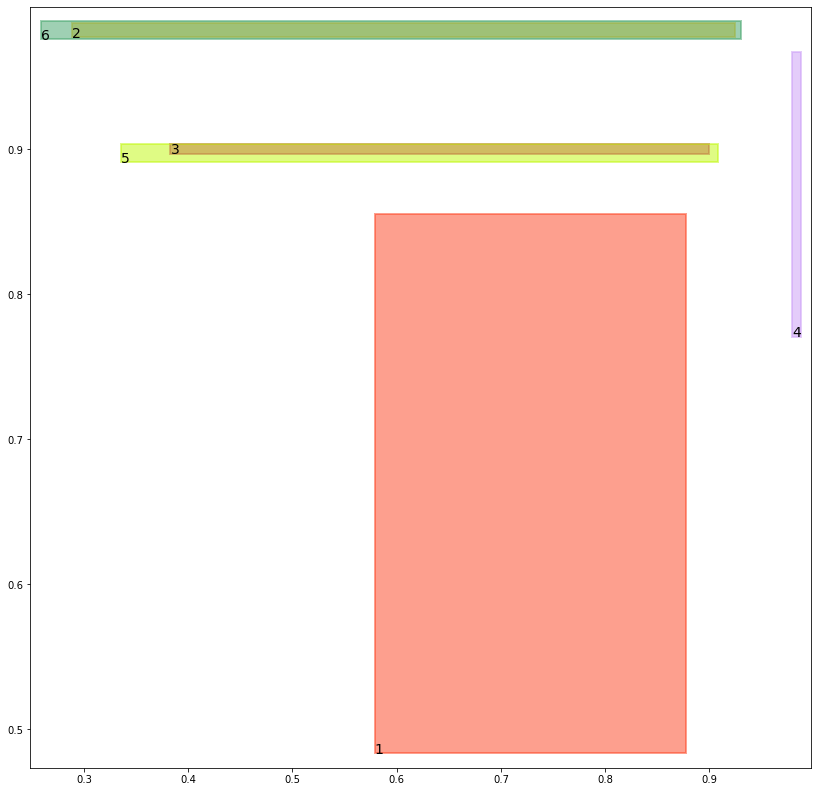

batch (tensor([[3, 5],
        [4, 5],
        [2, 6],
        [1, 2]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.3125228881836 -28.29969024658203 tensor(-54.2156600952148438) tensor(-18.2247619628906250)
tensor(2) -86.73238372802734 -30.57891273498535 tensor(-54.4784088134765625) tensor(-15.9532661437988281)
tensor(3) -82.96288299560547 -29.27322769165039 tensor(-57.2784042358398438) tensor(-17.6182098388671875)
tensor(4) -89.1041030883789 -31.67306900024414 tensor(-82.7386856079101562) tensor(-29.5220241546630859)
tensor(5) -83.2270736694336 -29.38524627685547 tensor(-54.6545791625976562) tensor(-16.4660224914550781)
tensor(6) -86.92274475097656 -30.659221649169922 tensor(-53.3107604980468750) tensor(-15.4207954406738281)


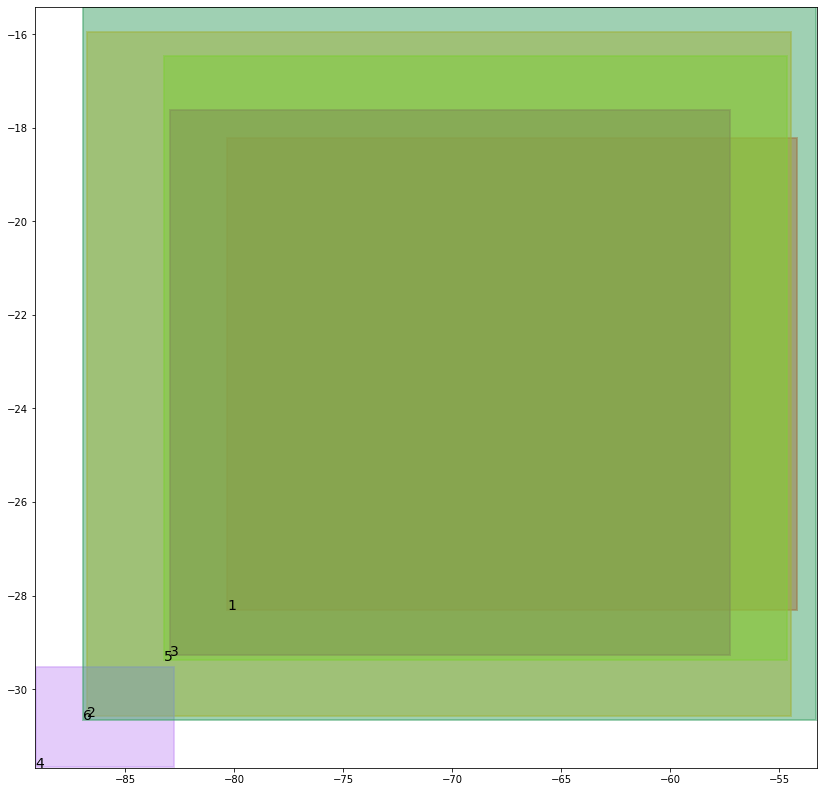

alignment data:
tensor(1) 0.57915198802948 0.4834350645542145 tensor(0.8772479295730591) tensor(0.8555304408073425)
tensor(2) 0.2833814322948456 0.977290153503418 tensor(0.9262797832489014) tensor(0.9871717095375061)
tensor(3) 0.3808107078075409 0.8998979330062866 tensor(0.9019405841827393) tensor(0.9029626846313477)
tensor(4) 0.9794797301292419 0.7705715298652649 tensor(0.9878672361373901) tensor(0.9670365452766418)
tensor(5) 0.33750927448272705 0.8893725275993347 tensor(0.9064769148826599) tensor(0.9044631123542786)
tensor(6) 0.26204386353492737 0.9760875701904297 tensor(0.9294925928115845) tensor(0.9883394241333008)


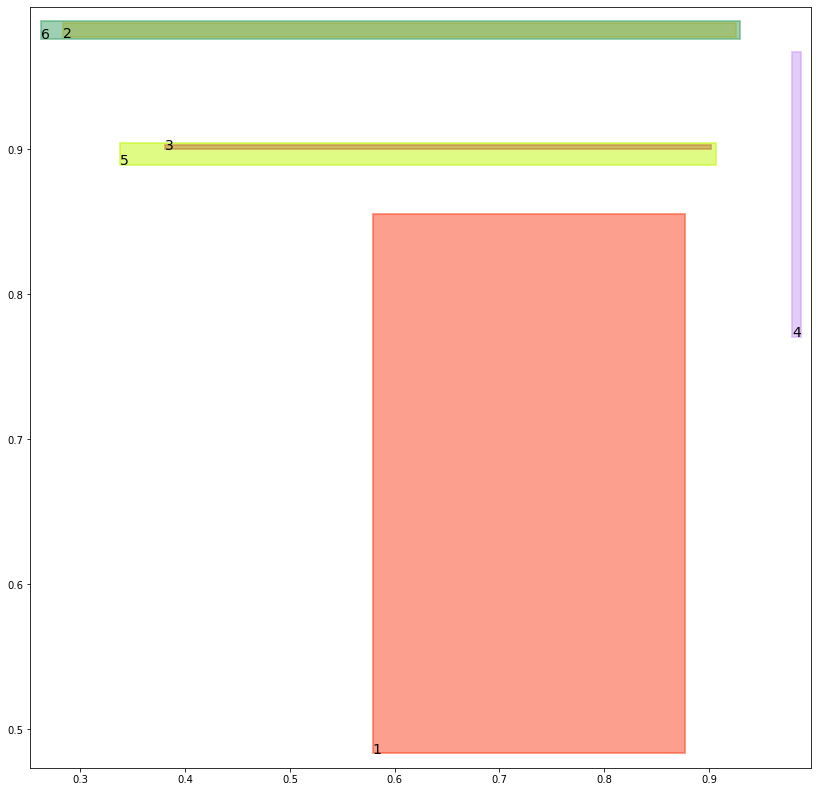

batch (tensor([[1, 2],
        [5, 3],
        [4, 5],
        [4, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.31397247314453 -28.300338745117188 tensor(-54.2166290283203125) tensor(-18.2252101898193359)
tensor(2) -86.79830169677734 -30.608478546142578 tensor(-54.2306442260742188) tensor(-15.8396482467651367)
tensor(3) -83.04070281982422 -29.310779571533203 tensor(-57.2460784912109375) tensor(-17.5918388366699219)
tensor(4) -89.10562896728516 -31.673751831054688 tensor(-82.7399826049804688) tensor(-29.5226154327392578)
tensor(5) -83.1745376586914 -29.358089447021484 tensor(-54.7003860473632812) tensor(-16.4944229125976562)
tensor(6) -86.8875503540039 -30.643085479736328 tensor(-53.4901809692382812) tensor(-15.5045328140258789)


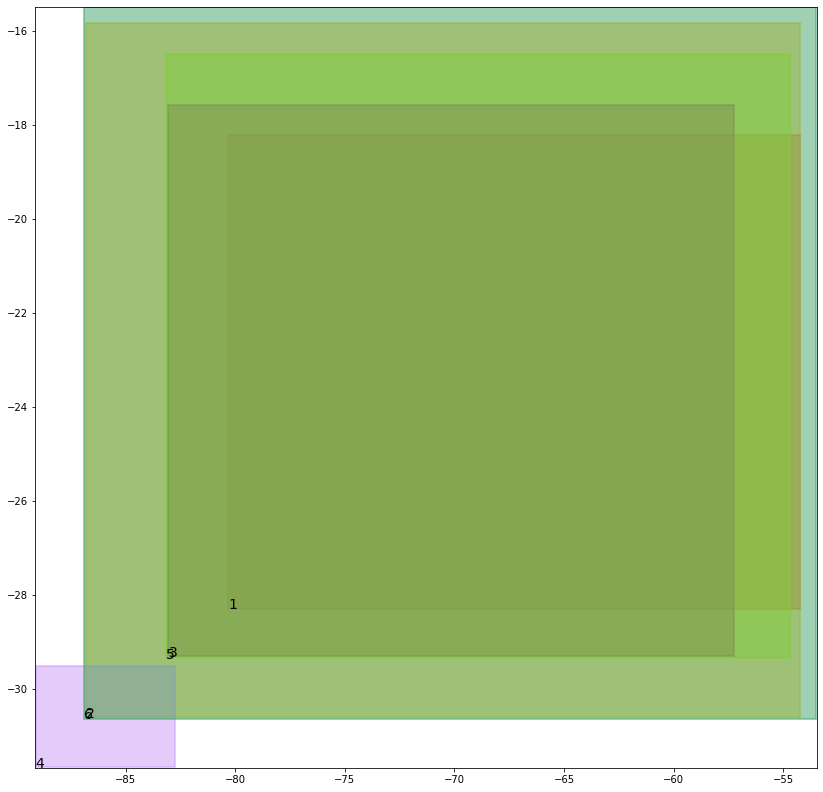

alignment data:
tensor(1) 0.5791547894477844 0.4834337532520294 tensor(0.8772492408752441) tensor(0.8555316329002380)
tensor(2) 0.2787138521671295 0.9772666692733765 tensor(0.9276038408279419) tensor(0.9871998429298401)
tensor(3) 0.37883108854293823 0.9022385478019714 tensor(0.9038761854171753) tensor(0.9024272561073303)
tensor(4) 0.9794792532920837 0.7705696821212769 tensor(0.9878674745559692) tensor(0.9670369029045105)
tensor(5) 0.3392268121242523 0.8878620862960815 tensor(0.9048717021942139) tensor(0.9052128791809082)
tensor(6) 0.2653224766254425 0.9763235449790955 tensor(0.9286898374557495) tensor(0.9884009361267090)


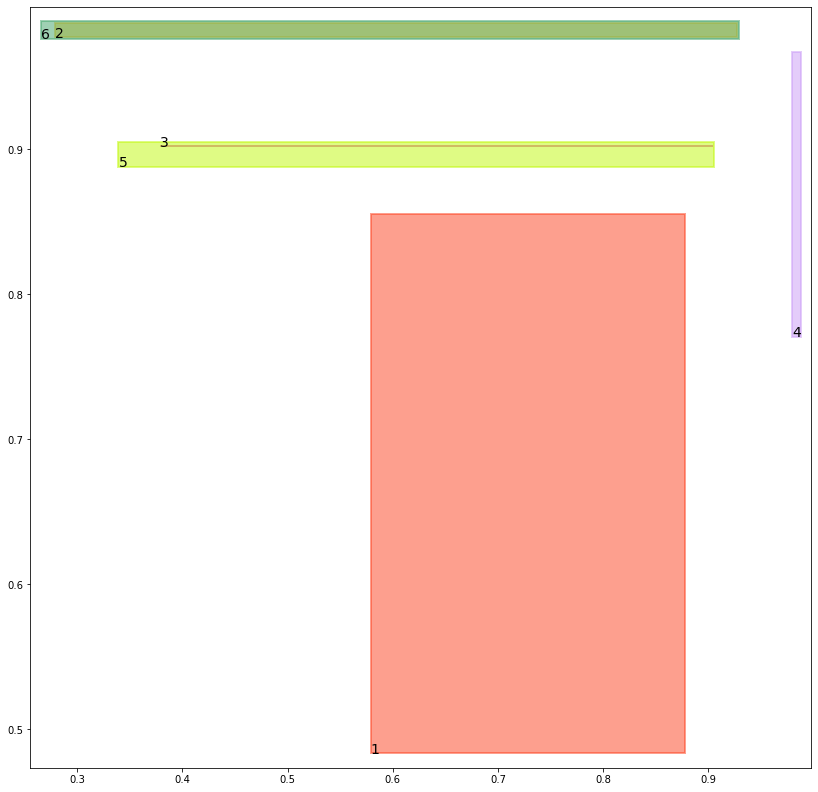

batch (tensor([[1, 3],
        [3, 5],
        [2, 6],
        [6, 2]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.31526947021484 -28.30091667175293 tensor(-54.2174911499023438) tensor(-18.2256107330322266)
tensor(2) -86.89962005615234 -30.653440475463867 tensor(-53.8110122680664062) tensor(-15.6488771438598633)
tensor(3) -83.29481506347656 -29.409570693969727 tensor(-56.8652458190917969) tensor(-17.4265003204345703)
tensor(4) -89.10700225830078 -31.67436408996582 tensor(-82.7411422729492188) tensor(-29.5231494903564453)
tensor(5) -83.01832580566406 -29.29021453857422 tensor(-54.9987792968750000) tensor(-16.6306514739990234)
tensor(6) -86.81433868408203 -30.610383987426758 tensor(-53.8524971008300781) tensor(-15.6682004928588867)


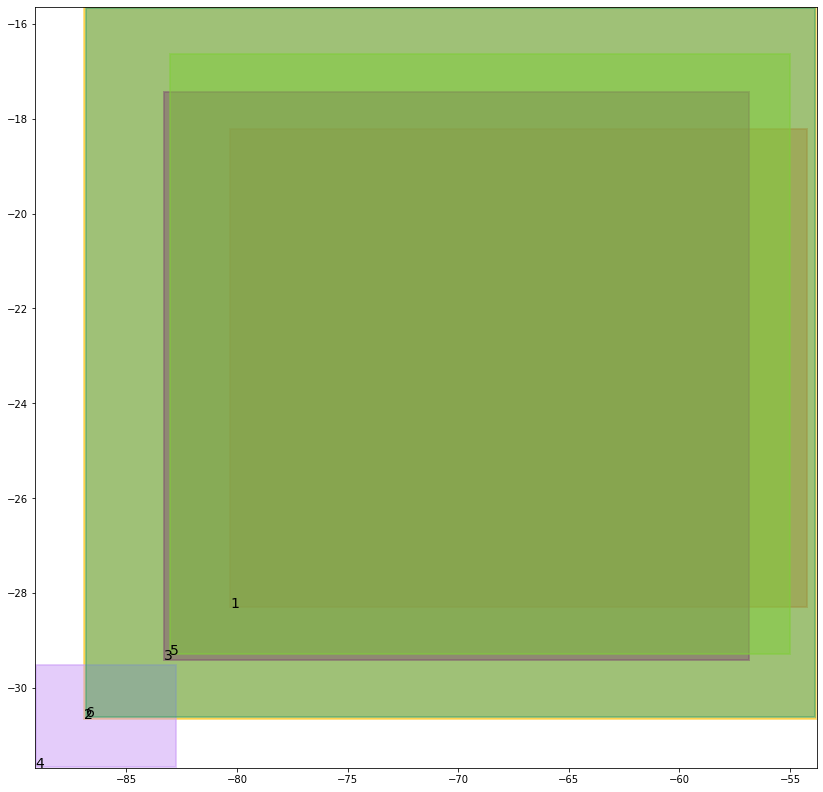

alignment data:
tensor(1) 0.579157292842865 0.48343250155448914 tensor(0.8772503137588501) tensor(0.8555326461791992)
tensor(2) 0.2710134983062744 0.9768969416618347 tensor(0.9295923709869385) tensor(0.9873453974723816)
tensor(3) 0.3727572560310364 0.9003169536590576 tensor(0.9069771170616150) tensor(0.9057924151420593)
tensor(4) 0.9794788956642151 0.7705679535865784 tensor(0.9878675937652588) tensor(0.9670371413230896)
tensor(5) 0.34475114941596985 0.8879932165145874 tensor(0.9019361734390259) tensor(0.9046788811683655)
tensor(6) 0.271828293800354 0.9768379926681519 tensor(0.9271765947341919) tensor(0.9883404970169067)


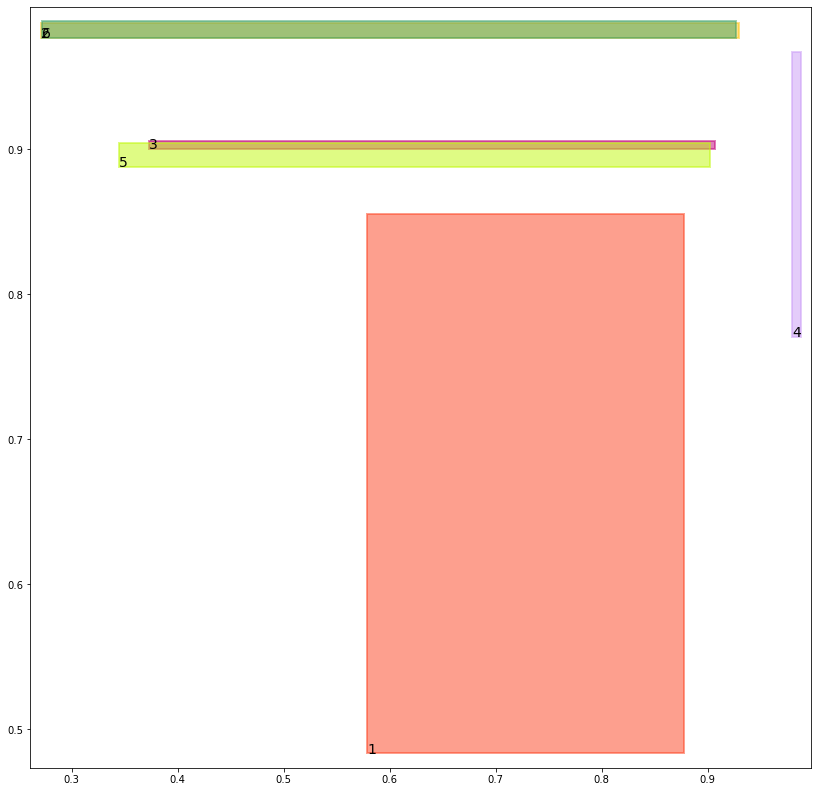

batch (tensor([[1, 3],
        [4, 6],
        [4, 5],
        [5, 3]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.31645202636719 -28.301443099975586 tensor(-54.2182807922363281) tensor(-18.2259769439697266)
tensor(2) -86.98917388916016 -30.693166732788086 tensor(-53.4381637573242188) tensor(-15.4786987304687500)
tensor(3) -83.22559356689453 -29.379850387573242 tensor(-56.5238647460937500) tensor(-17.2784442901611328)
tensor(4) -89.10823059082031 -31.674917221069336 tensor(-82.7422103881835938) tensor(-29.5236320495605469)
tensor(5) -83.19357299804688 -29.35529327392578 tensor(-55.2707138061523438) tensor(-16.7548065185546875)
tensor(6) -86.74685668945312 -30.58024024963379 tensor(-54.1845855712890625) tensor(-15.8182888031005859)


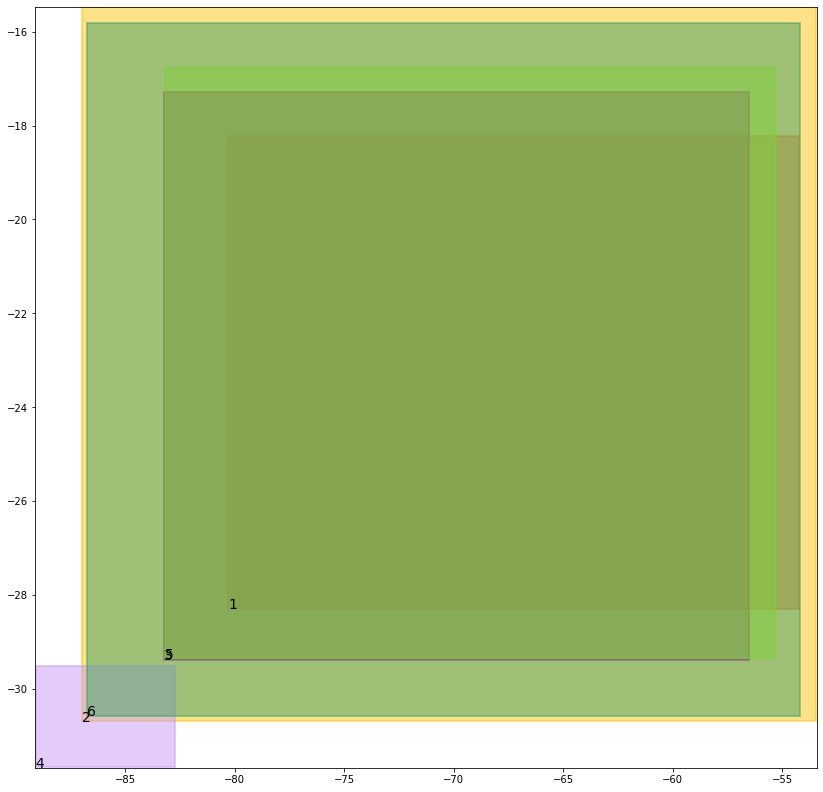

alignment data:
tensor(1) 0.5791595578193665 0.4834313988685608 tensor(0.8772514462471008) tensor(0.8555335402488708)
tensor(2) 0.26416251063346863 0.976557195186615 tensor(0.9313480854034424) tensor(0.9874758124351501)
tensor(3) 0.3673301935195923 0.8985643982887268 tensor(0.9057133197784424) tensor(0.9054794311523438)
tensor(4) 0.9794785380363464 0.7705665230751038 tensor(0.9878677129745483) tensor(0.9670373201370239)
tensor(5) 0.34978607296943665 0.8881117701530457 tensor(0.9036478996276855) tensor(0.9076544046401978)
tensor(6) 0.2778002619743347 0.9772940278053284 tensor(0.9257819056510925) tensor(0.9882855415344238)


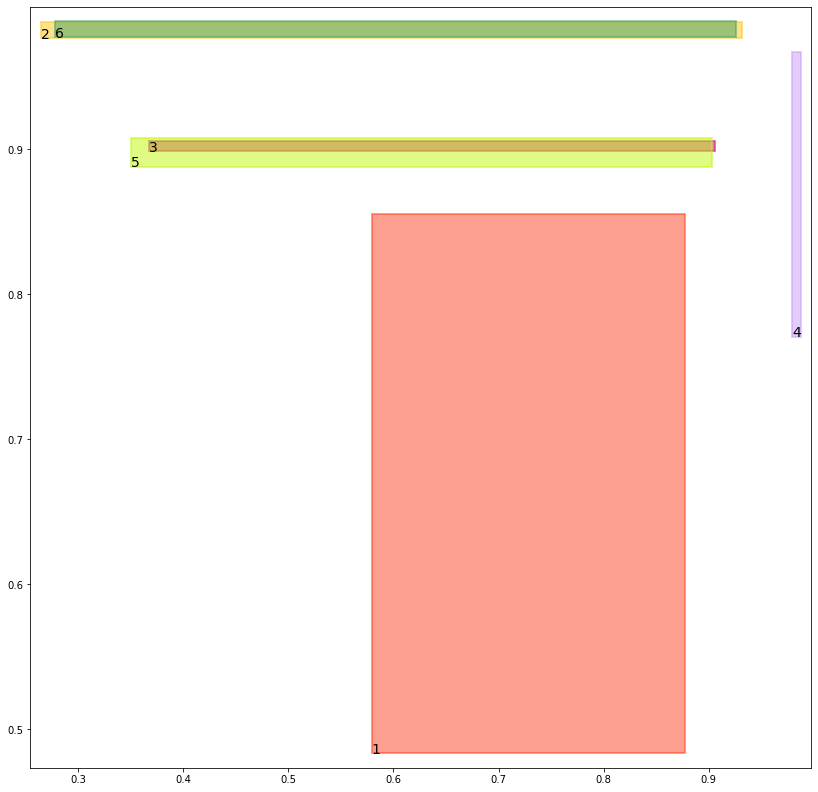

batch (tensor([[1, 2],
        [6, 2],
        [3, 5],
        [2, 6]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.31751251220703 -28.301918029785156 tensor(-54.2189903259277344) tensor(-18.2263050079345703)
tensor(2) -87.0357894897461 -30.713090896606445 tensor(-53.2989273071289062) tensor(-15.4122171401977539)
tensor(3) -83.19607543945312 -29.3627872467041 tensor(-55.9495353698730469) tensor(-17.0295791625976562)
tensor(4) -89.1093521118164 -31.6754207611084 tensor(-82.7431640625000000) tensor(-29.5240688323974609)
tensor(5) -83.31340789794922 -29.402250289916992 tensor(-55.7818374633789062) tensor(-16.9814643859863281)
tensor(6) -86.72150421142578 -30.569608688354492 tensor(-54.2807617187500000) tensor(-15.8617725372314453)


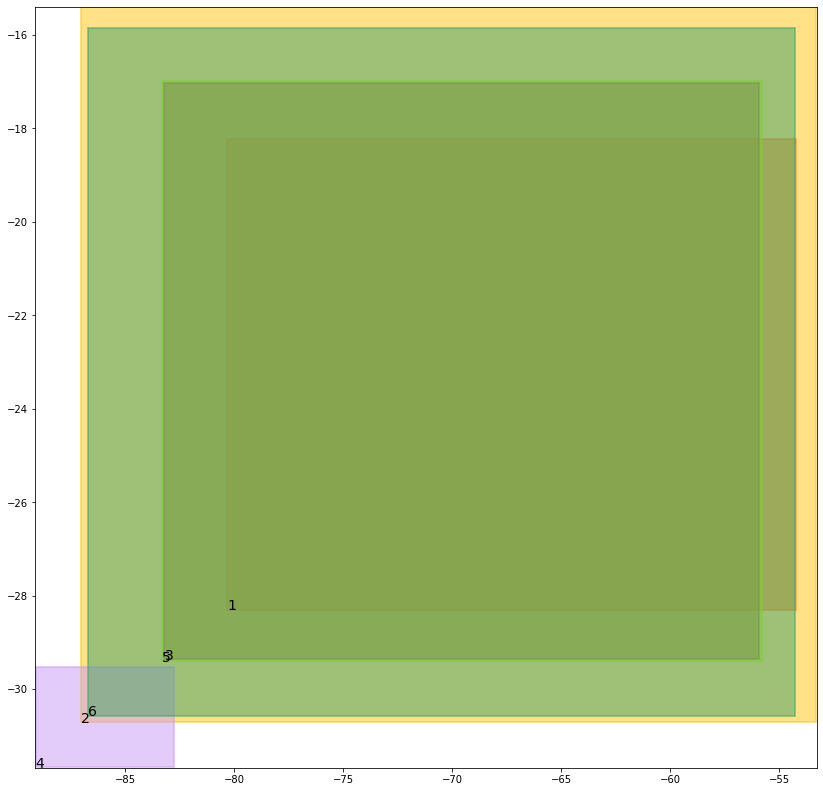

alignment data:
tensor(1) 0.5791615843772888 0.4834303855895996 tensor(0.8772523403167725) tensor(0.8555343151092529)
tensor(2) 0.2614436149597168 0.9766228199005127 tensor(0.9321477413177490) tensor(0.9877063632011414)
tensor(3) 0.35823559761047363 0.8955742120742798 tensor(0.9045564532279968) tensor(0.9062893390655518)
tensor(4) 0.9794782400131226 0.7705651521682739 tensor(0.9878677129745483) tensor(0.9670376777648926)
tensor(5) 0.35847076773643494 0.889706552028656 tensor(0.9051518440246582) tensor(0.9091622233390808)
tensor(6) 0.2795254588127136 0.9774182438850403 tensor(0.9253401160240173) tensor(0.9881167411804199)


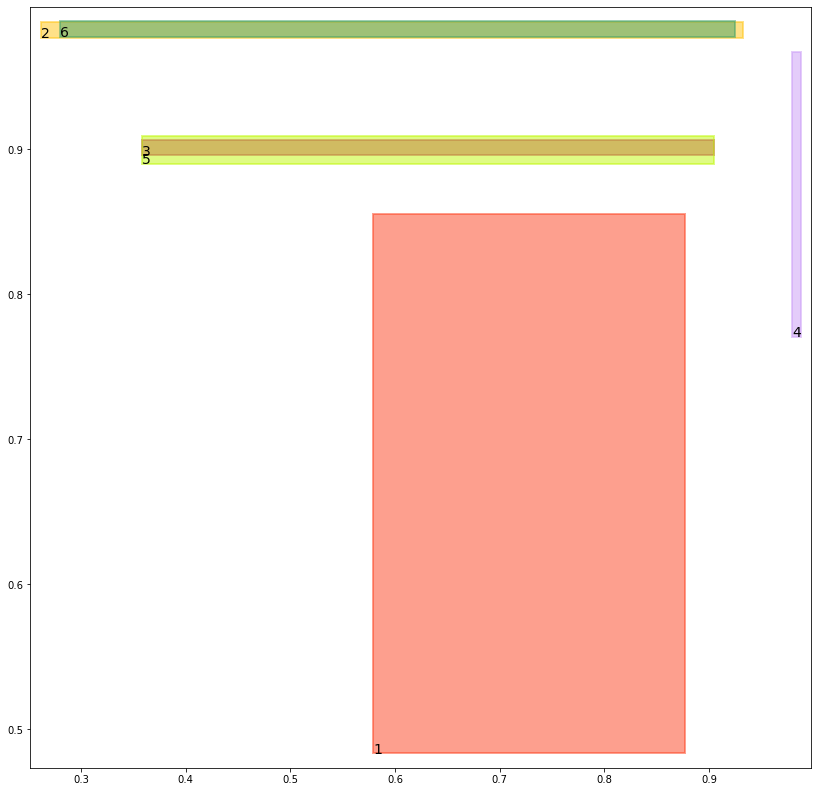

batch (tensor([[3, 5],
        [4, 5],
        [1, 3],
        [2, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.3184814453125 -28.302350997924805 tensor(-54.2196350097656250) tensor(-18.2266063690185547)
tensor(2) -87.08258819580078 -30.732450485229492 tensor(-53.1737632751464844) tensor(-15.3524551391601562)
tensor(3) -83.3188247680664 -29.407209396362305 tensor(-55.3646087646484375) tensor(-16.7856445312500000)
tensor(4) -89.11035919189453 -31.675878524780273 tensor(-82.7440261840820312) tensor(-29.5244655609130859)
tensor(5) -83.26970672607422 -29.383913040161133 tensor(-56.3155136108398438) tensor(-17.2088603973388672)
tensor(6) -86.69267272949219 -30.55820655822754 tensor(-54.3681602478027344) tensor(-15.9012842178344727)


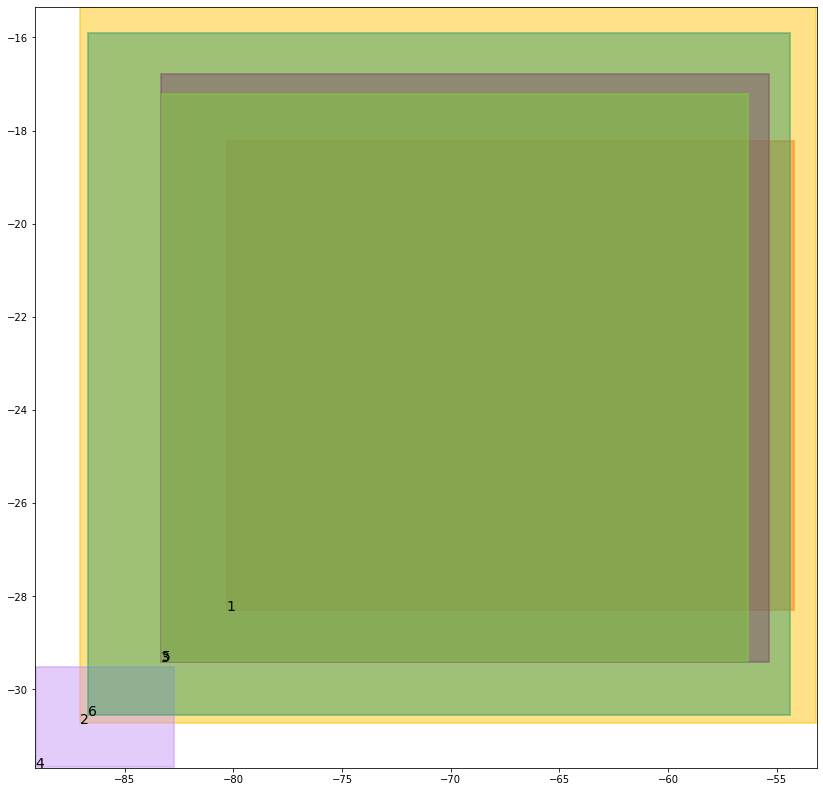

alignment data:
tensor(1) 0.5791634917259216 0.4834294617176056 tensor(0.8772531747817993) tensor(0.8555350899696350)
tensor(2) 0.25899937748908997 0.9766820669174194 tensor(0.9328638315200806) tensor(0.9880763292312622)
tensor(3) 0.3500942885875702 0.8905924558639526 tensor(0.9055927991867065) tensor(0.9086217880249023)
tensor(4) 0.9794778823852539 0.7705639004707336 tensor(0.9878678321838379) tensor(0.9670377969741821)
tensor(5) 0.3664500117301941 0.8932583332061768 tensor(0.9044084548950195) tensor(0.9088729023933411)
tensor(6) 0.281093567609787 0.9775301814079285 tensor(0.9249380826950073) tensor(0.9877766370773315)


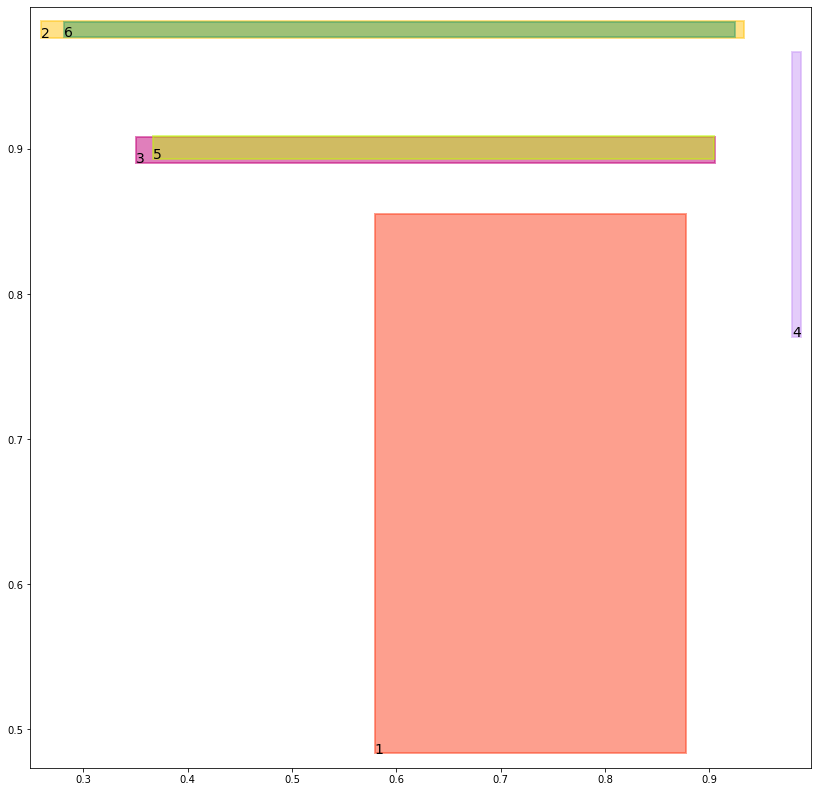

batch (tensor([[5, 3],
        [1, 2],
        [6, 2],
        [4, 6]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.3193588256836 -28.30274200439453 tensor(-54.2202148437500000) tensor(-18.2268791198730469)
tensor(2) -87.06612396240234 -30.724262237548828 tensor(-53.3394012451171875) tensor(-15.4279642105102539)
tensor(3) -83.32818603515625 -29.401897430419922 tensor(-55.2427482604980469) tensor(-16.7406349182128906)
tensor(4) -89.11128234863281 -31.676288604736328 tensor(-82.7448196411132812) tensor(-29.5248222351074219)
tensor(5) -83.33032989501953 -29.41244888305664 tensor(-56.3951644897460938) tensor(-17.2399597167968750)
tensor(6) -86.73357391357422 -30.577178955078125 tensor(-54.1361999511718750) tensor(-15.7963914871215820)


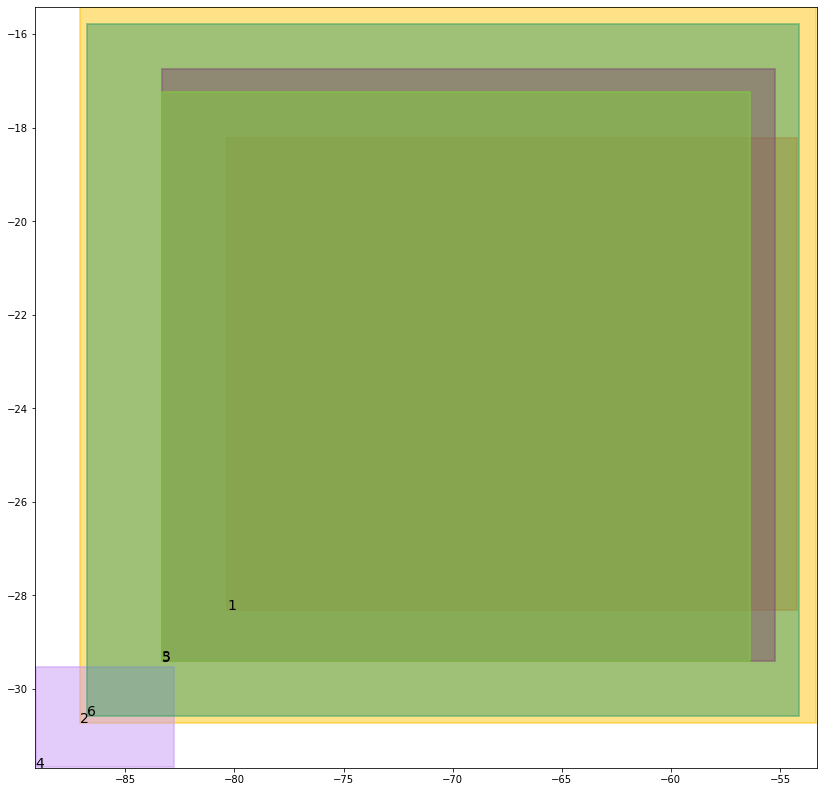

alignment data:
tensor(1) 0.5791651606559753 0.48342862725257874 tensor(0.8772540092468262) tensor(0.8555358052253723)
tensor(2) 0.2618100345134735 0.9772863984107971 tensor(0.9323964118957520) tensor(0.9882413744926453)
tensor(3) 0.3490754961967468 0.8883684277534485 tensor(0.9044543504714966) tensor(0.9106675982475281)
tensor(4) 0.9794776439666748 0.7705627679824829 tensor(0.9878679513931274) tensor(0.9670380353927612)
tensor(5) 0.3673001527786255 0.8943620324134827 tensor(0.9058219790458679) tensor(0.9086104631423950)
tensor(6) 0.27690157294273376 0.9772111177444458 tensor(0.9258475303649902) tensor(0.9876577854156494)


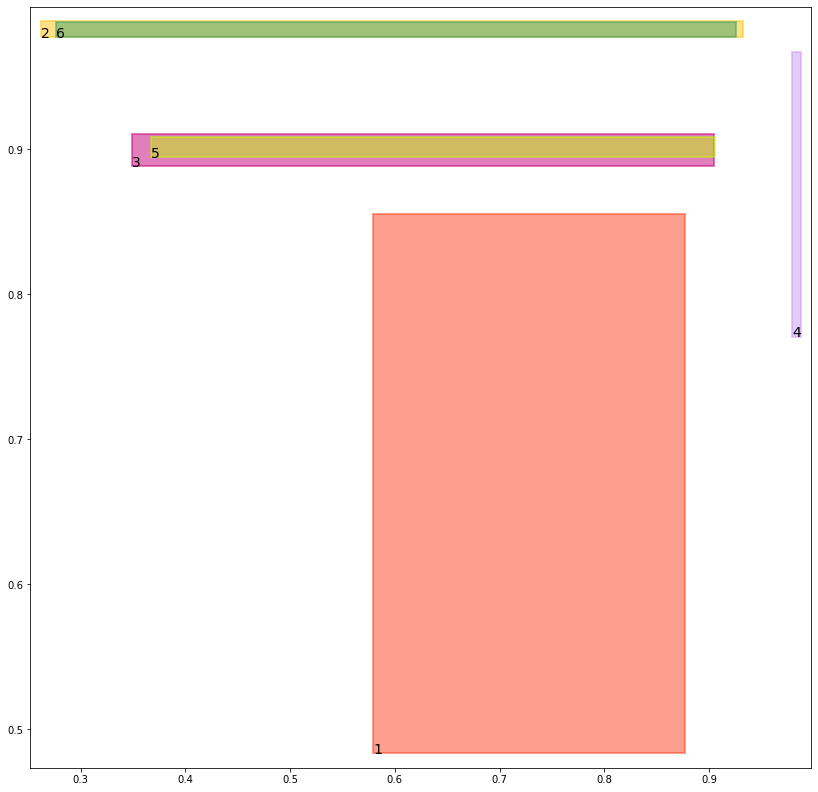

batch (tensor([[3, 5],
        [1, 3],
        [4, 5],
        [4, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.32013702392578 -28.30309295654297 tensor(-54.2207412719726562) tensor(-18.2271232604980469)
tensor(2) -87.0510482788086 -30.71678924560547 tensor(-53.4897308349609375) tensor(-15.4965677261352539)
tensor(3) -83.52996826171875 -29.484338760375977 tensor(-55.1315307617187500) tensor(-16.6996326446533203)
tensor(4) -89.11211395263672 -31.67666244506836 tensor(-82.7455215454101562) tensor(-29.5251426696777344)
tensor(5) -83.19012451171875 -29.350414276123047 tensor(-56.4674377441406250) tensor(-17.2682151794433594)
tensor(6) -86.77010345458984 -30.59414291381836 tensor(-53.9280166625976562) tensor(-15.7022790908813477)


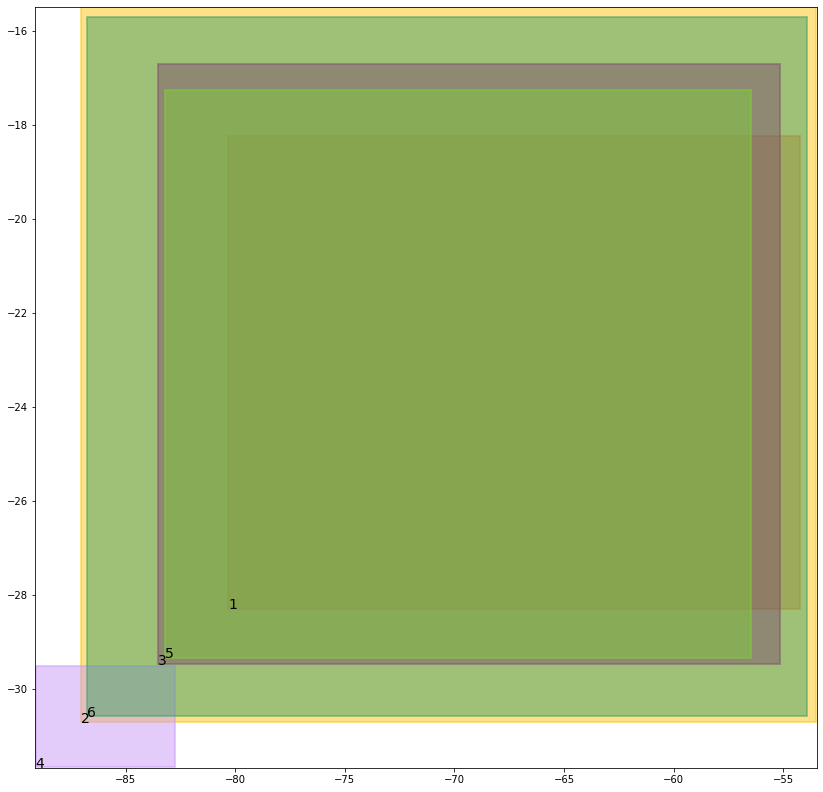

alignment data:
tensor(1) 0.5791667103767395 0.48342788219451904 tensor(0.8772546648979187) tensor(0.8555364012718201)
tensor(2) 0.26436951756477356 0.9778198599815369 tensor(0.9319710731506348) tensor(0.9883887171745300)
tensor(3) 0.34815505146980286 0.8863224983215332 tensor(0.9074726104736328) tensor(0.9124826192855835)
tensor(4) 0.9794774055480957 0.7705617547035217 tensor(0.9878680706024170) tensor(0.9670382142066956)
tensor(5) 0.3680763244628906 0.8953551054000854 tensor(0.9030417799949646) tensor(0.9083696007728577)
tensor(6) 0.2731427848339081 0.976918637752533 tensor(0.9266614913940430) tensor(0.9875490665435791)


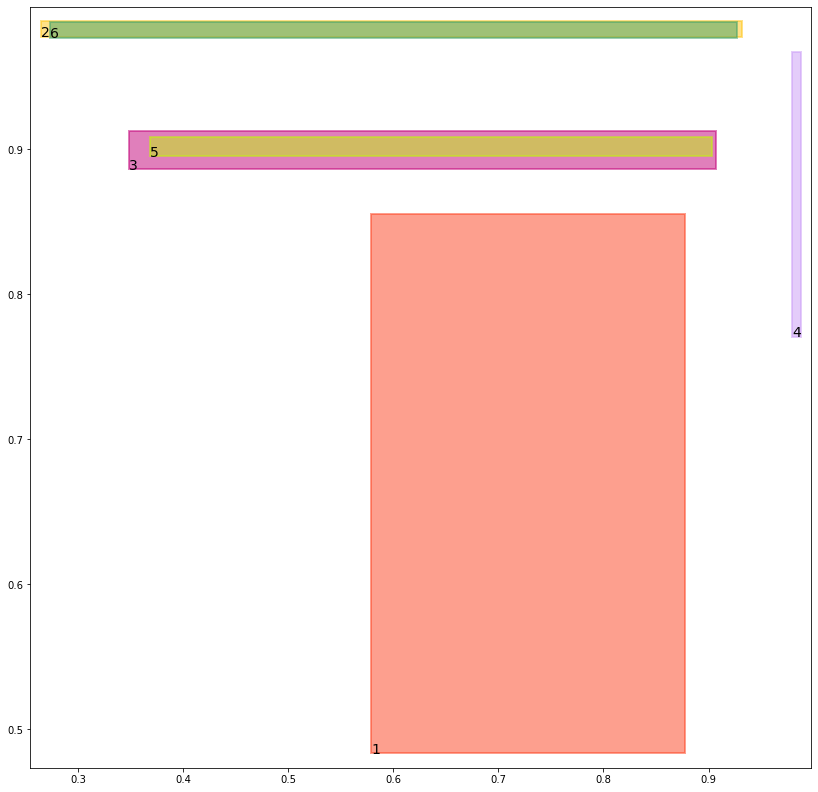

batch (tensor([[1, 2],
        [5, 3],
        [6, 2],
        [2, 6]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.32085418701172 -28.303409576416016 tensor(-54.2212219238281250) tensor(-18.2273445129394531)
tensor(2) -86.9971694946289 -30.692386627197266 tensor(-53.8014068603515625) tensor(-15.6390304565429688)
tensor(3) -83.61591339111328 -29.520116806030273 tensor(-55.3062973022460938) tensor(-16.7805595397949219)
tensor(4) -89.11286163330078 -31.676998138427734 tensor(-82.7461624145507812) tensor(-29.5254364013671875)
tensor(5) -83.16309356689453 -29.334096908569336 tensor(-56.2664489746093750) tensor(-17.1780738830566406)
tensor(6) -86.8459701538086 -30.628150939941406 tensor(-53.5596580505371094) tensor(-15.5330753326416016)


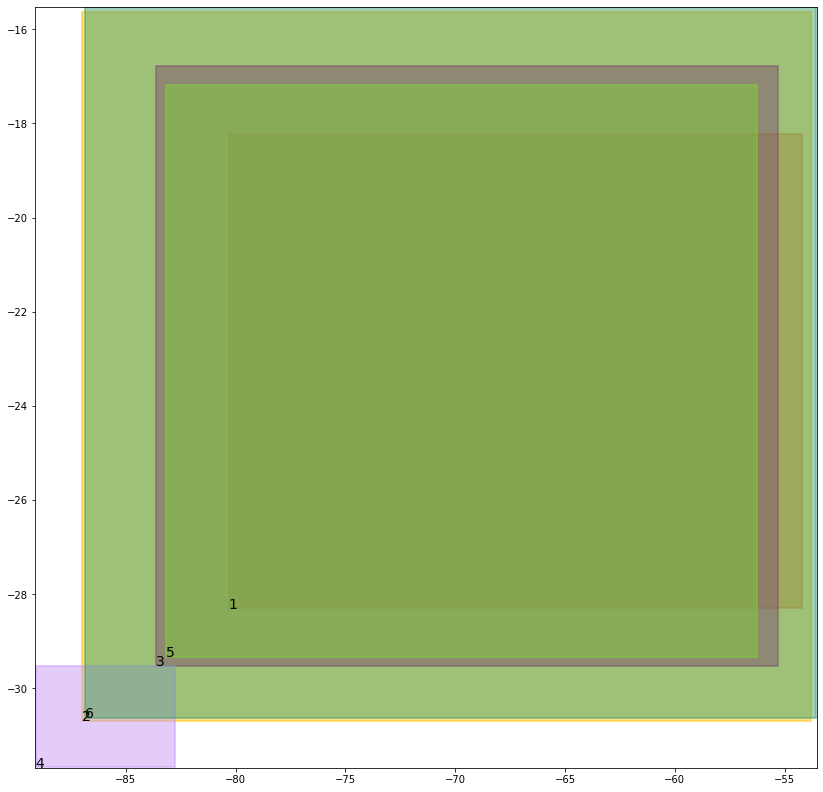

alignment data:
tensor(1) 0.5791680812835693 0.4834272265434265 tensor(0.8772552609443665) tensor(0.8555369377136230)
tensor(2) 0.27014806866645813 0.9779621362686157 tensor(0.9308155775070190) tensor(0.9884174466133118)
tensor(3) 0.3515245020389557 0.886168360710144 tensor(0.9088420867919922) tensor(0.9131130576133728)
tensor(4) 0.9794771671295166 0.7705609202384949 tensor(0.9878680706024170) tensor(0.9670383334159851)
tensor(5) 0.3645317554473877 0.8949275612831116 tensor(0.9018927216529846) tensor(0.9092587232589722)
tensor(6) 0.2661829888820648 0.9769505262374878 tensor(0.9282025098800659) tensor(0.9875855445861816)


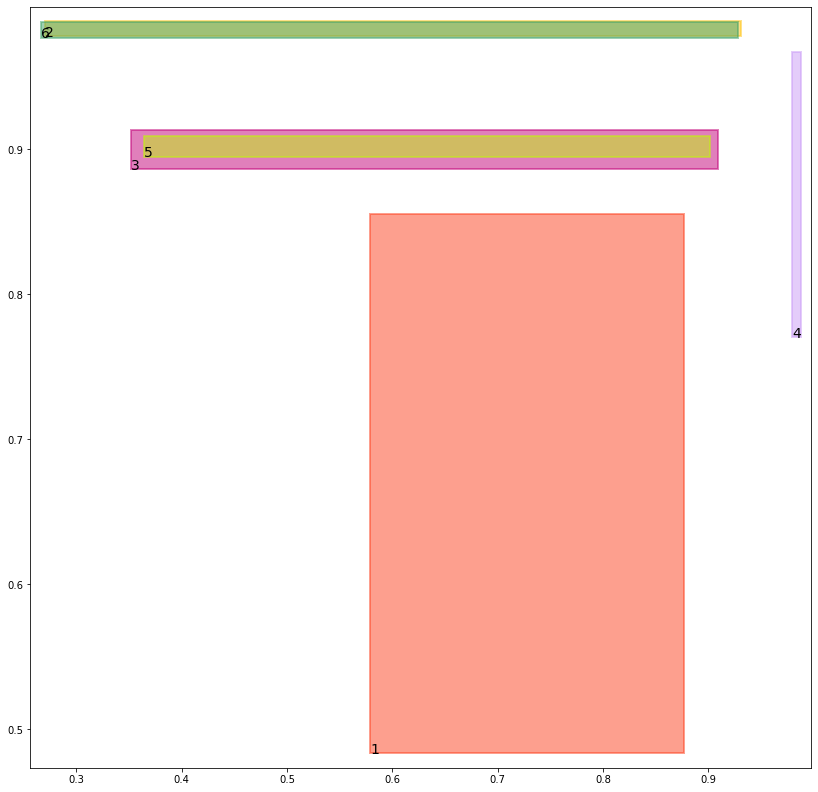

batch (tensor([[2, 6],
        [6, 2],
        [4, 5],
        [3, 5]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.32150268554688 -28.303701400756836 tensor(-54.2216491699218750) tensor(-18.2275466918945312)
tensor(2) -86.9061050415039 -30.651721954345703 tensor(-53.8879623413085938) tensor(-15.6797332763671875)
tensor(3) -83.69278717041016 -29.552106857299805 tensor(-55.4650688171386719) tensor(-16.8540782928466797)
tensor(4) -89.11354064941406 -31.677303314208984 tensor(-82.7467498779296875) tensor(-29.5256996154785156)
tensor(5) -83.13793182373047 -29.319049835205078 tensor(-56.0852661132812500) tensor(-17.0968303680419922)
tensor(6) -86.95471954345703 -30.676361083984375 tensor(-53.4297332763671875) tensor(-15.4707946777343750)


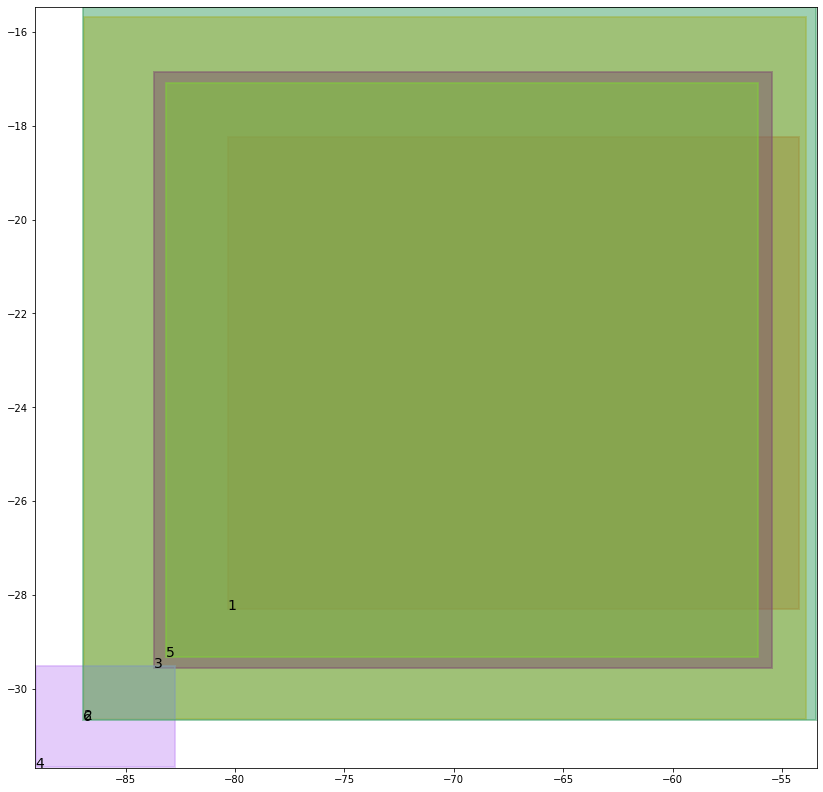

alignment data:
tensor(1) 0.5791693329811096 0.48342660069465637 tensor(0.8772558569908142) tensor(0.8555374741554260)
tensor(2) 0.27188798785209656 0.9777563810348511 tensor(0.9289555549621582) tensor(0.9883402585983276)
tensor(3) 0.354585200548172 0.8860287070274353 tensor(0.9100651741027832) tensor(0.9136797785758972)
tensor(4) 0.9794769883155823 0.7705600261688232 tensor(0.9878681898117065) tensor(0.9670384526252747)
tensor(5) 0.36133813858032227 0.8945395350456238 tensor(0.9008429646492004) tensor(0.9100563526153564)
tensor(6) 0.26351961493492126 0.9772760272026062 tensor(0.9303460121154785) tensor(0.9877519607543945)


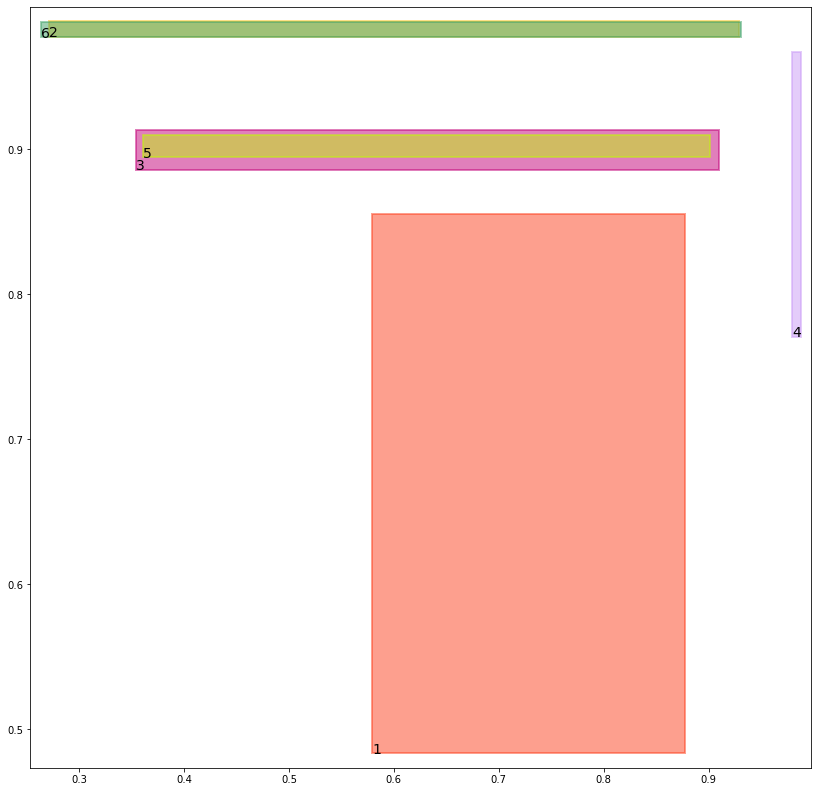

batch (tensor([[5, 3],
        [4, 6],
        [1, 2],
        [1, 3]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.32209014892578 -28.3039608001709 tensor(-54.2220382690429688) tensor(-18.2277259826660156)
tensor(2) -86.82181549072266 -30.614078521728516 tensor(-53.9665184020996094) tensor(-15.7166805267333984)
tensor(3) -83.49324798583984 -29.473421096801758 tensor(-56.4227066040039062) tensor(-17.2698535919189453)
tensor(4) -89.1141586303711 -31.67757797241211 tensor(-82.7472763061523438) tensor(-29.5259399414062500)
tensor(5) -83.4161376953125 -29.42650604248047 tensor(-55.1582336425781250) tensor(-16.6930809020996094)
tensor(6) -87.05056762695312 -30.71884536743164 tensor(-53.3139533996582031) tensor(-15.4143276214599609)


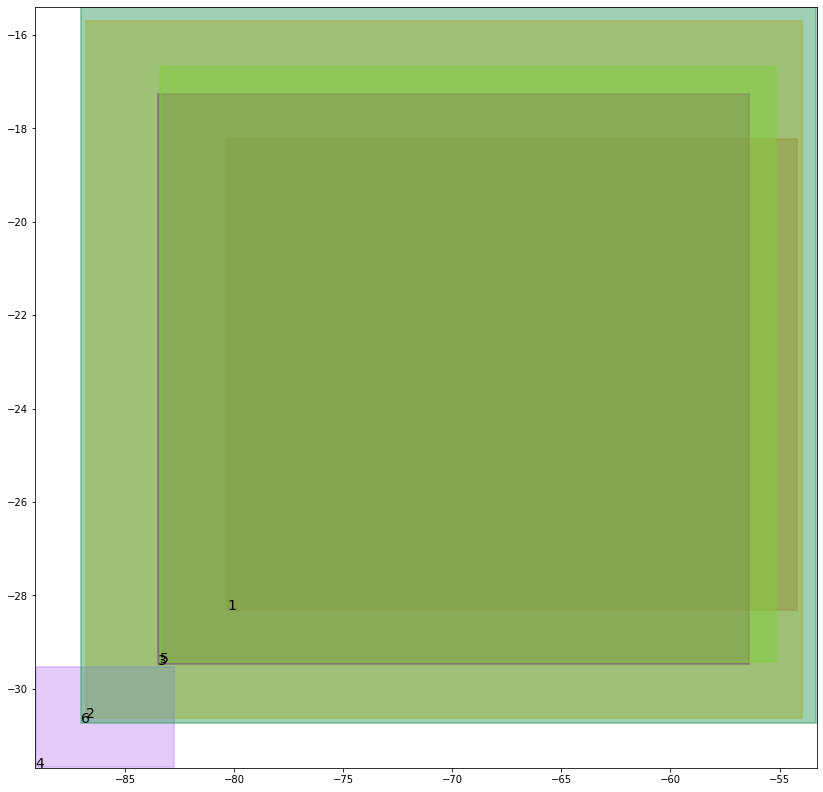

alignment data:
tensor(1) 0.5791704654693604 0.4834260642528534 tensor(0.8772563934326172) tensor(0.8555378913879395)
tensor(2) 0.2734677493572235 0.9775685667991638 tensor(0.9272334575653076) tensor(0.9882699251174927)
tensor(3) 0.3698231279850006 0.890833854675293 tensor(0.9074438810348511) tensor(0.9112771749496460)
tensor(4) 0.9794768691062927 0.7705593705177307 tensor(0.9878681898117065) tensor(0.9670386910438538)
tensor(5) 0.3464279770851135 0.890138566493988 tensor(0.9041575193405151) tensor(0.9138908982276917)
tensor(6) 0.2611253559589386 0.977566659450531 tensor(0.9322336912155151) tensor(0.9879004955291748)


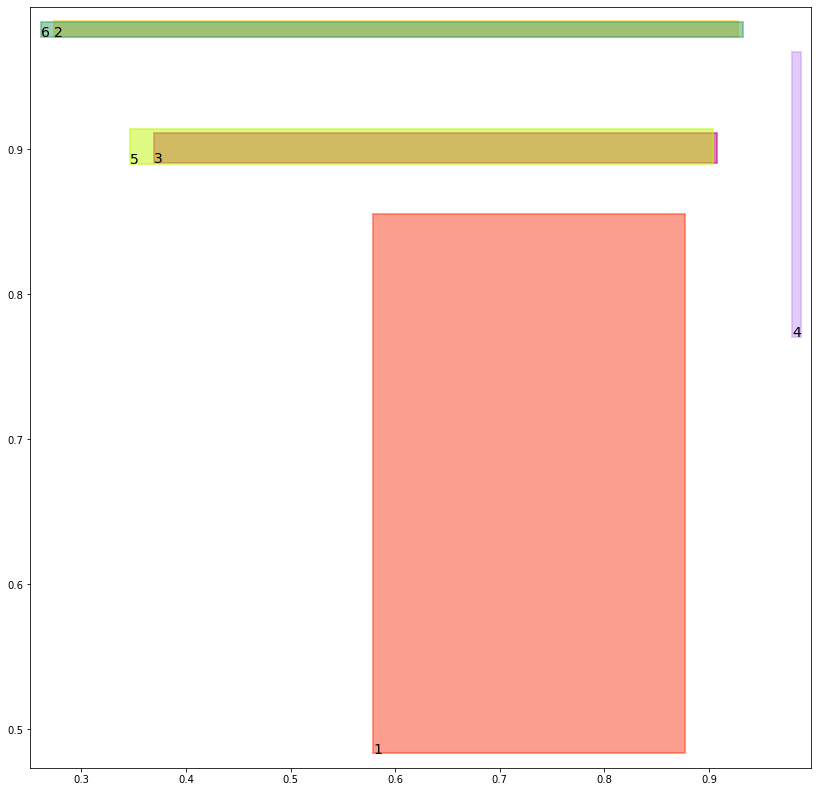

batch (tensor([[2, 6],
        [1, 2],
        [5, 3],
        [4, 5]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.32261657714844 -28.304197311401367 tensor(-54.2223892211914062) tensor(-18.2278900146484375)
tensor(2) -86.80741119384766 -30.60788345336914 tensor(-53.7376251220703125) tensor(-15.6150608062744141)
tensor(3) -83.21466827392578 -29.35831069946289 tensor(-57.2968063354492188) tensor(-17.6502914428710938)
tensor(4) -89.11470794677734 -31.67782974243164 tensor(-82.7477416992187500) tensor(-29.5261573791503906)
tensor(5) -83.75221252441406 -29.562332153320312 tensor(-54.3290176391601562) tensor(-16.3328247070312500)
tensor(6) -87.08348846435547 -30.733062744140625 tensor(-53.4958076477050781) tensor(-15.4971609115600586)


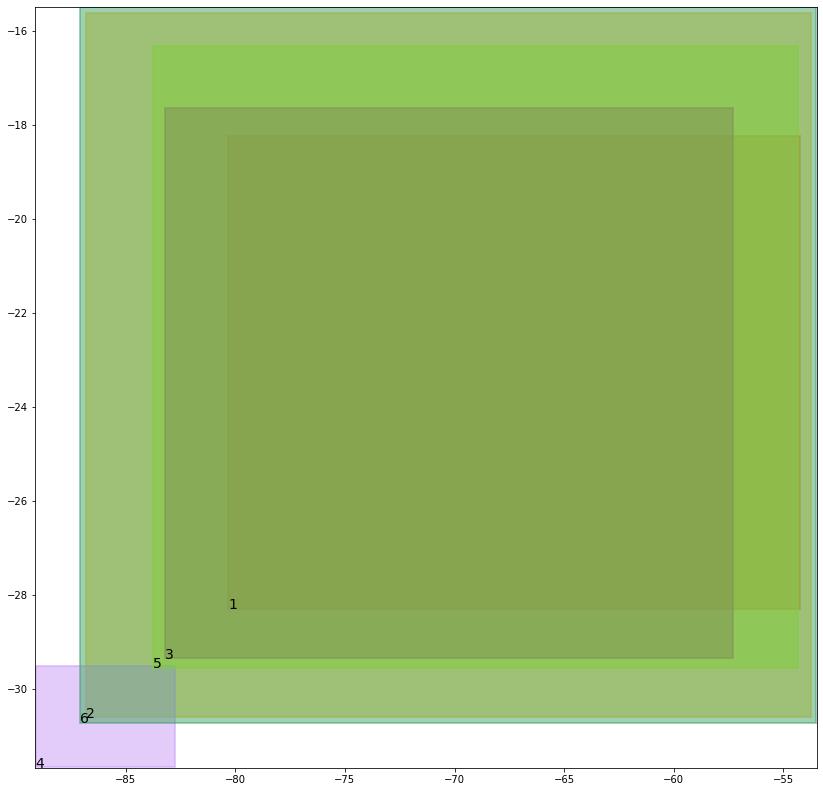

alignment data:
tensor(1) 0.5791714191436768 0.4834255576133728 tensor(0.8772568702697754) tensor(0.8555383086204529)
tensor(2) 0.2695567011833191 0.9768708944320679 tensor(0.9269632697105408) tensor(0.9882060289382935)
tensor(3) 0.3838411867618561 0.8950303792953491 tensor(0.9030659198760986) tensor(0.9090490341186523)
tensor(4) 0.9794766306877136 0.7705586552619934 tensor(0.9878681898117065) tensor(0.9670388102531433)
tensor(5) 0.3331962823867798 0.8860201835632324 tensor(0.9089962244033813) tensor(0.9172308444976807)
tensor(6) 0.2642068564891815 0.9782463312149048 tensor(0.9328236579895020) tensor(0.9880313873291016)


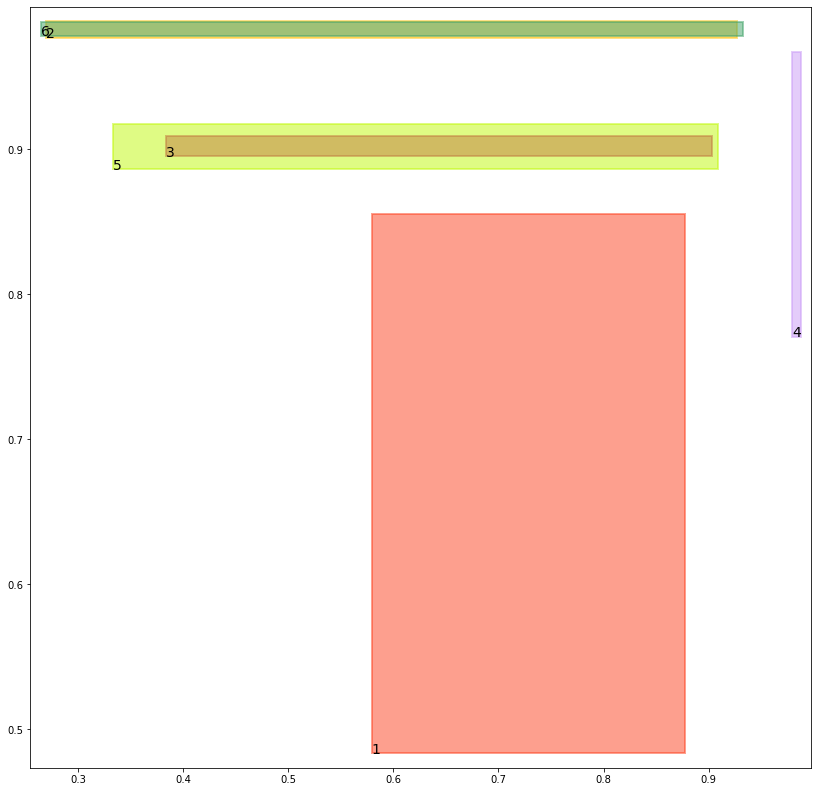

batch (tensor([[3, 5],
        [6, 2],
        [4, 6],
        [1, 3]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.3230972290039 -28.30440902709961 tensor(-54.2227172851562500) tensor(-18.2280387878417969)
tensor(2) -86.78919982910156 -30.60071563720703 tensor(-53.5492858886718750) tensor(-15.5290451049804688)
tensor(3) -83.10426330566406 -29.310848236083984 tensor(-57.6741981506347656) tensor(-17.8156738281250000)
tensor(4) -89.11522674560547 -31.678050994873047 tensor(-82.7481765747070312) tensor(-29.5263519287109375)
tensor(5) -83.91181182861328 -29.627182006835938 tensor(-53.9730377197265625) tensor(-16.1763935089111328)
tensor(6) -87.11881256103516 -30.747556686401367 tensor(-53.6512145996093750) tensor(-15.5676536560058594)


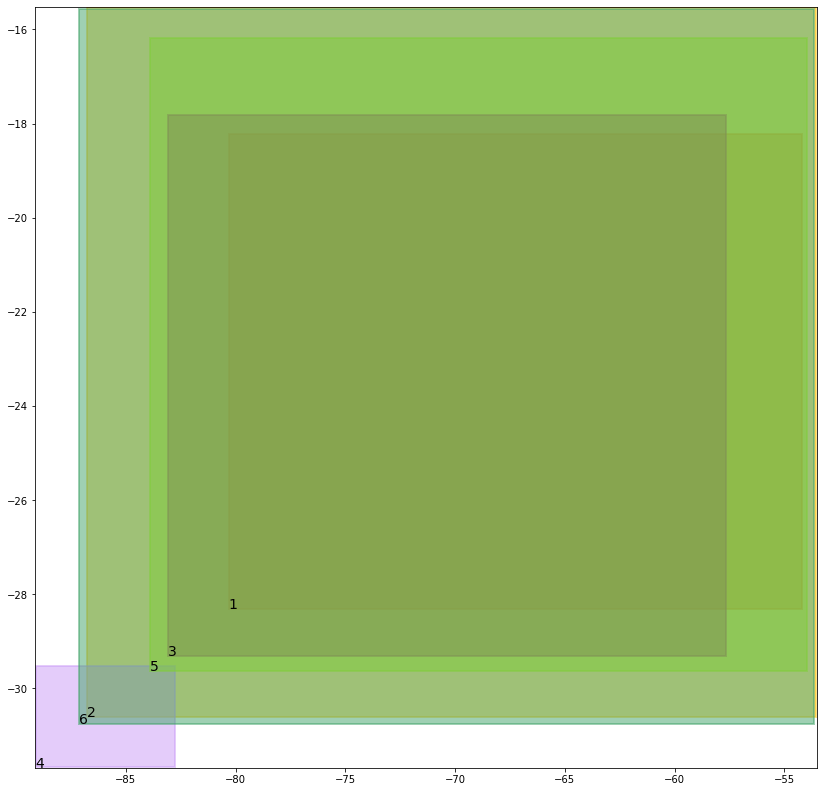

alignment data:
tensor(1) 0.5791724324226379 0.483425110578537 tensor(0.8772572875022888) tensor(0.8555386662483215)
tensor(2) 0.2660558223724365 0.9767850041389465 tensor(0.9267166852951050) tensor(0.9879842996597290)
tensor(3) 0.3900238573551178 0.8966108560562134 tensor(0.9010713100433350) tensor(0.9085611701011658)
tensor(4) 0.9794765114784241 0.7705579996109009 tensor(0.9878683090209961) tensor(0.9670389294624329)
tensor(5) 0.3273055851459503 0.8846109509468079 tensor(0.9113371372222900) tensor(0.9187425374984741)
tensor(6) 0.267013818025589 0.9784466624259949 tensor(0.9333533048629761) tensor(0.9883356094360352)


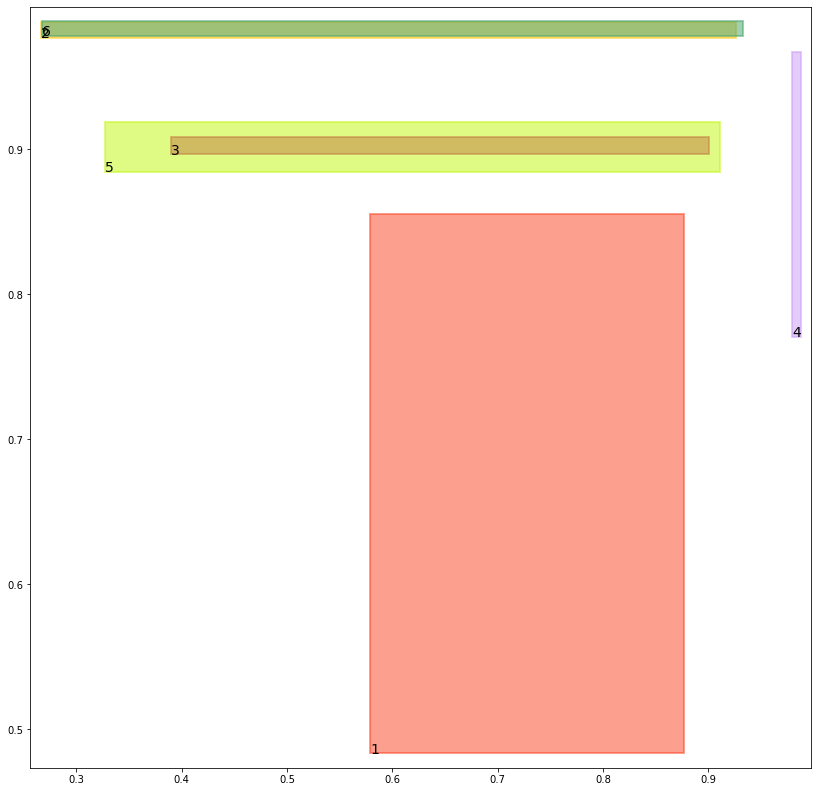

batch (tensor([[1, 3],
        [3, 5],
        [4, 6],
        [2, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.32352447509766 -28.304603576660156 tensor(-54.2229995727539062) tensor(-18.2281723022460938)
tensor(2) -86.84113311767578 -30.624267578125 tensor(-53.3821907043457031) tensor(-15.4510335922241211)
tensor(3) -83.15274810791016 -29.327556610107422 tensor(-57.6045074462890625) tensor(-17.7868080139160156)
tensor(4) -89.11566925048828 -31.67825698852539 tensor(-82.7485656738281250) tensor(-29.5265312194824219)
tensor(5) -83.92432403564453 -29.633020401000977 tensor(-54.0339508056640625) tensor(-16.1987133026123047)
tensor(6) -87.0938491821289 -30.735902786254883 tensor(-53.7935447692871094) tensor(-15.6320524215698242)


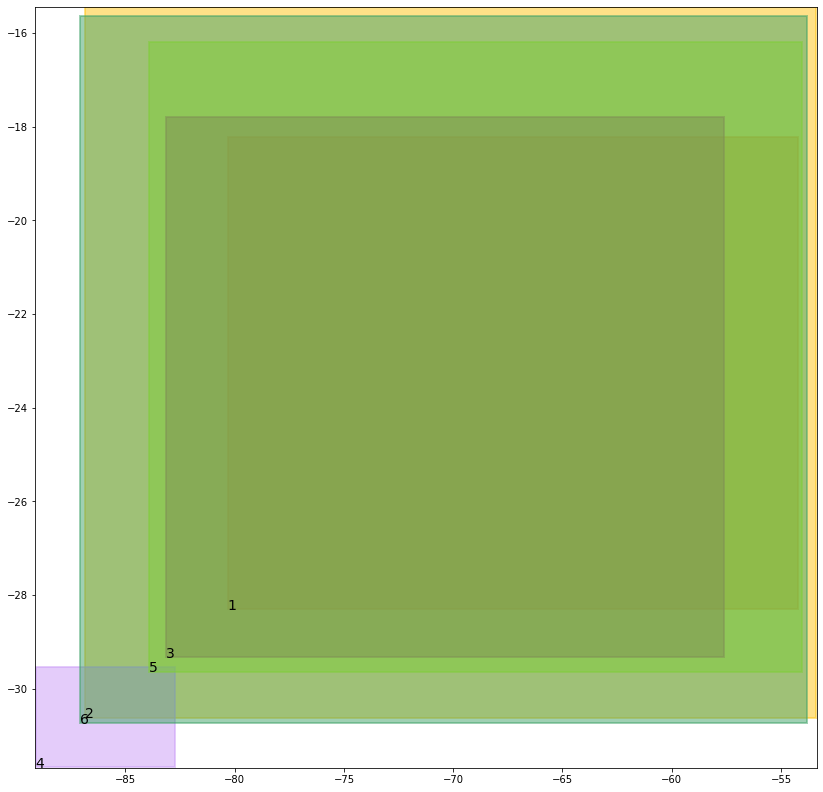

alignment data:
tensor(1) 0.57917320728302 0.48342472314834595 tensor(0.8772576451301575) tensor(0.8555390238761902)
tensor(2) 0.262914776802063 0.9767071008682251 tensor(0.9278103709220886) tensor(0.9879507422447205)
tensor(3) 0.3890739977359772 0.8959754705429077 tensor(0.9013632535934448) tensor(0.9096633791923523)
tensor(4) 0.9794763922691345 0.7705575227737427 tensor(0.9878683090209961) tensor(0.9670389294624329)
tensor(5) 0.327786386013031 0.8857532143592834 tensor(0.9116161465644836) tensor(0.9187002778053284)
tensor(6) 0.2695823013782501 0.9786279797554016 tensor(0.9327678680419922) tensor(0.9884234070777893)


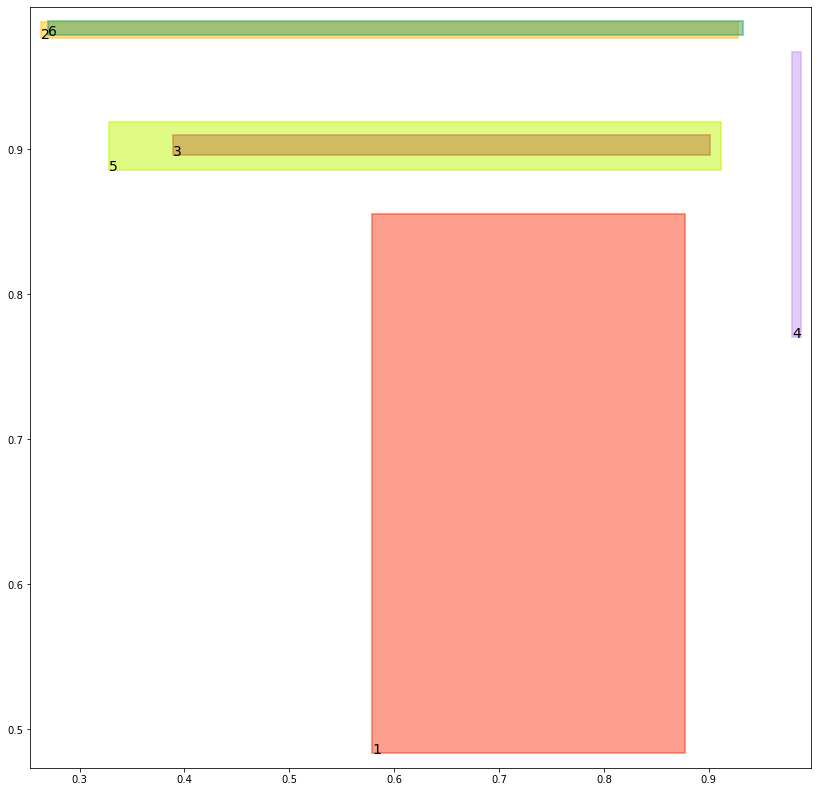

batch (tensor([[6, 2],
        [5, 3],
        [1, 2],
        [4, 5]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.32392120361328 -28.304779052734375 tensor(-54.2232589721679688) tensor(-18.2282924652099609)
tensor(2) -86.8872299194336 -30.64517593383789 tensor(-53.5198974609375000) tensor(-15.5135240554809570)
tensor(3) -83.19625091552734 -29.34255599975586 tensor(-57.5414276123046875) tensor(-17.7606925964355469)
tensor(4) -89.11608123779297 -31.678443908691406 tensor(-82.7489166259765625) tensor(-29.5266914367675781)
tensor(5) -83.93560028076172 -29.63827896118164 tensor(-54.0887870788574219) tensor(-16.2188301086425781)
tensor(6) -87.07106018066406 -30.725269317626953 tensor(-53.6216392517089844) tensor(-15.5542840957641602)


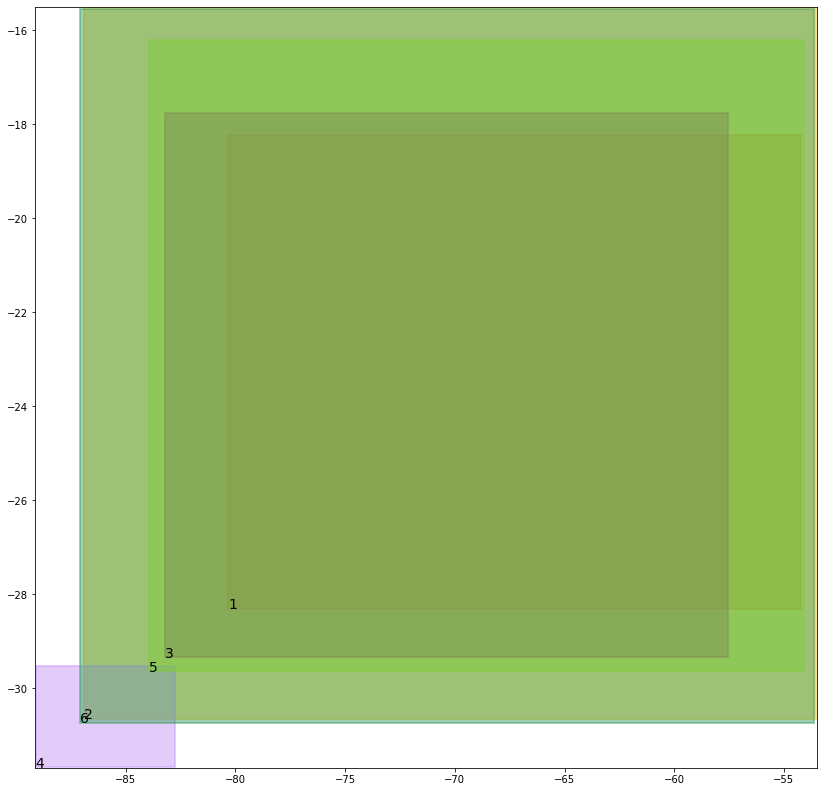

alignment data:
tensor(1) 0.5791739821434021 0.4834243357181549 tensor(0.8772580623626709) tensor(0.8555393815040588)
tensor(2) 0.2652566432952881 0.9771935939788818 tensor(0.9287818074226379) tensor(0.9879194498062134)
tensor(3) 0.3882157504558563 0.8953979015350342 tensor(0.9016267061233521) tensor(0.9106497764587402)
tensor(4) 0.979476273059845 0.7705569267272949 tensor(0.9878684282302856) tensor(0.9670389890670776)
tensor(5) 0.32822149991989136 0.8867777585983276 tensor(0.9118676781654358) tensor(0.9186620116233826)
tensor(6) 0.2664746046066284 0.9783990979194641 tensor(0.9322343468666077) tensor(0.9885022640228271)


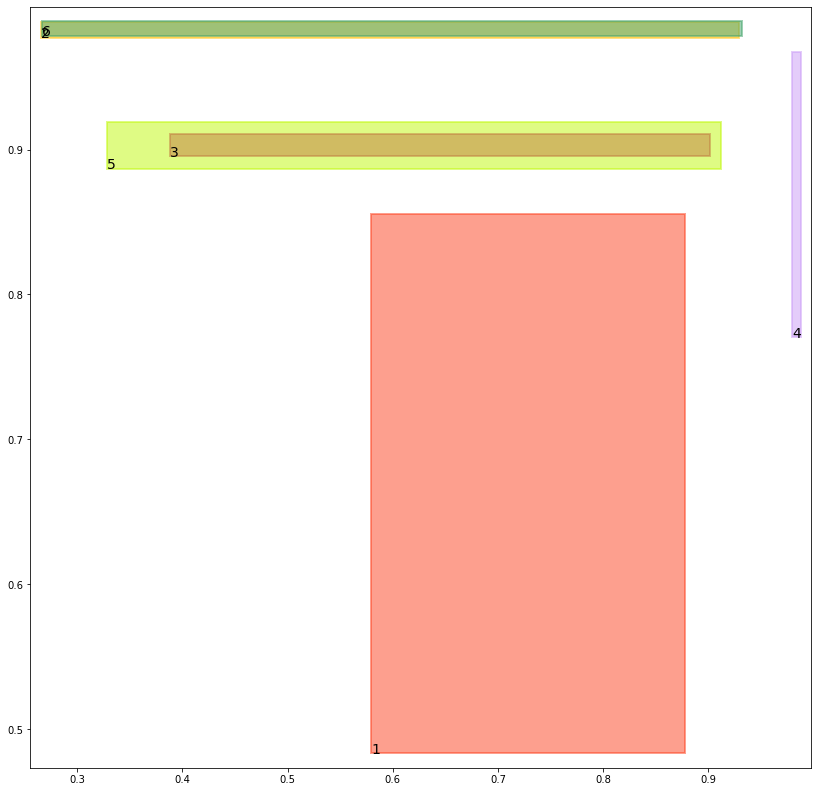

batch (tensor([[6, 2],
        [2, 6],
        [4, 5],
        [1, 3]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.32427215576172 -28.304935455322266 tensor(-54.2234916687011719) tensor(-18.2284049987792969)
tensor(2) -86.99292755126953 -30.69212532043457 tensor(-53.9396362304687500) tensor(-15.7014379501342773)
tensor(3) -83.23529815673828 -29.35603141784668 tensor(-57.4843444824218750) tensor(-17.7370681762695312)
tensor(4) -89.11644744873047 -31.678607940673828 tensor(-82.7492294311523438) tensor(-29.5268363952636719)
tensor(5) -83.94578552246094 -29.643028259277344 tensor(-54.1381721496582031) tensor(-16.2369632720947266)
tensor(6) -86.9913101196289 -30.689849853515625 tensor(-53.1824531555175781) tensor(-15.3506908416748047)


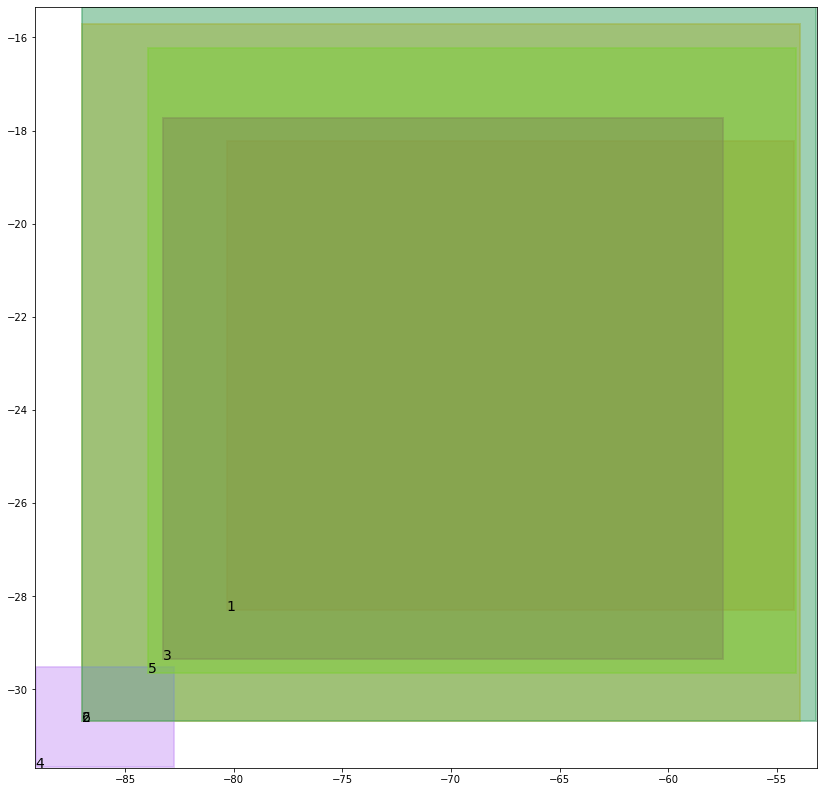

alignment data:
tensor(1) 0.5791746377944946 0.48342397809028625 tensor(0.8772583007812500) tensor(0.8555396199226379)
tensor(2) 0.27260252833366394 0.9781434535980225 tensor(0.9308835268020630) tensor(0.9880619049072266)
tensor(3) 0.38744017481803894 0.8948731422424316 tensor(0.9018644094467163) tensor(0.9115334153175354)
tensor(4) 0.9794761538505554 0.7705565094947815 tensor(0.9878684282302856) tensor(0.9670391082763672)
tensor(5) 0.3286152184009552 0.8876972794532776 tensor(0.9120947122573853) tensor(0.9186273217201233)
tensor(6) 0.25845226645469666 0.9777848720550537 tensor(0.9306362867355347) tensor(0.9883941411972046)


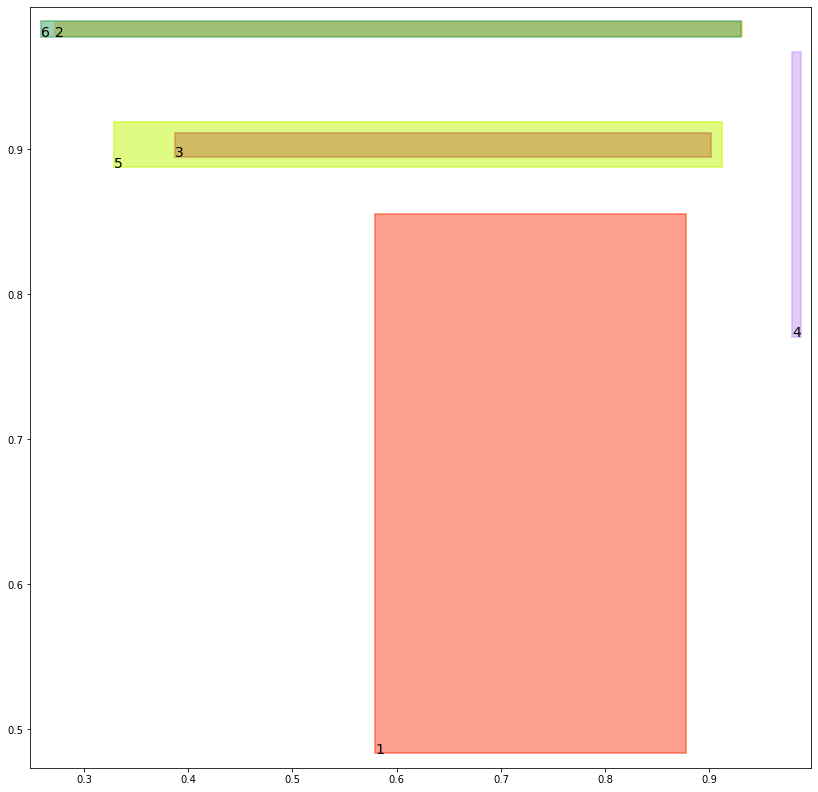

batch (tensor([[5, 3],
        [3, 5],
        [1, 2],
        [4, 6]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.32459259033203 -28.305078506469727 tensor(-54.2237129211425781) tensor(-18.2285022735595703)
tensor(2) -87.0860824584961 -30.733497619628906 tensor(-54.3239364624023438) tensor(-15.8737020492553711)
tensor(3) -83.41478729248047 -29.42641258239746 tensor(-57.0205307006835938) tensor(-17.5371875762939453)
tensor(4) -89.11678314208984 -31.67875862121582 tensor(-82.7495117187500000) tensor(-29.5269660949707031)
tensor(5) -83.82481384277344 -29.595291137695312 tensor(-54.5615081787109375) tensor(-16.4159297943115234)
tensor(6) -86.91773223876953 -30.65717124938965 tensor(-52.7937622070312500) tensor(-15.1690759658813477)


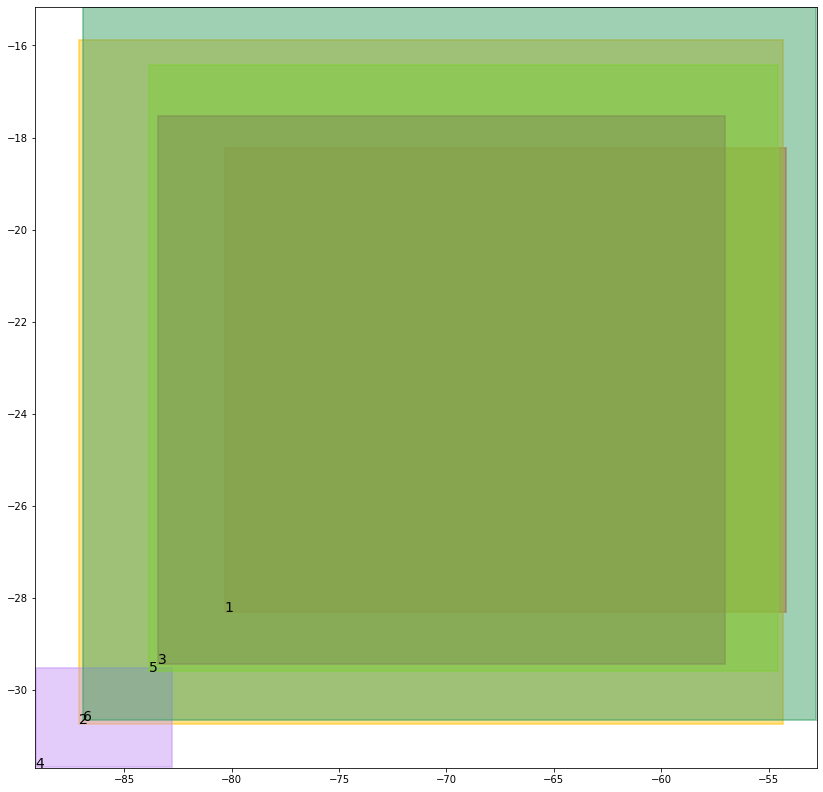

alignment data:
tensor(1) 0.5791752934455872 0.48342370986938477 tensor(0.8772585988044739) tensor(0.8555399179458618)
tensor(2) 0.27935361862182617 0.9789688587188721 tensor(0.9327344894409180) tensor(0.9881891012191772)
tensor(3) 0.38023021817207336 0.8922386169433594 tensor(0.9041497707366943) tensor(0.9137804508209229)
tensor(4) 0.9794760346412659 0.7705560922622681 tensor(0.9878684282302856) tensor(0.9670391082763672)
tensor(5) 0.33478230237960815 0.8908044099807739 tensor(0.9105023145675659) tensor(0.9171770811080933)
tensor(6) 0.25133466720581055 0.9772146344184875 tensor(0.9291612505912781) tensor(0.9882954359054565)


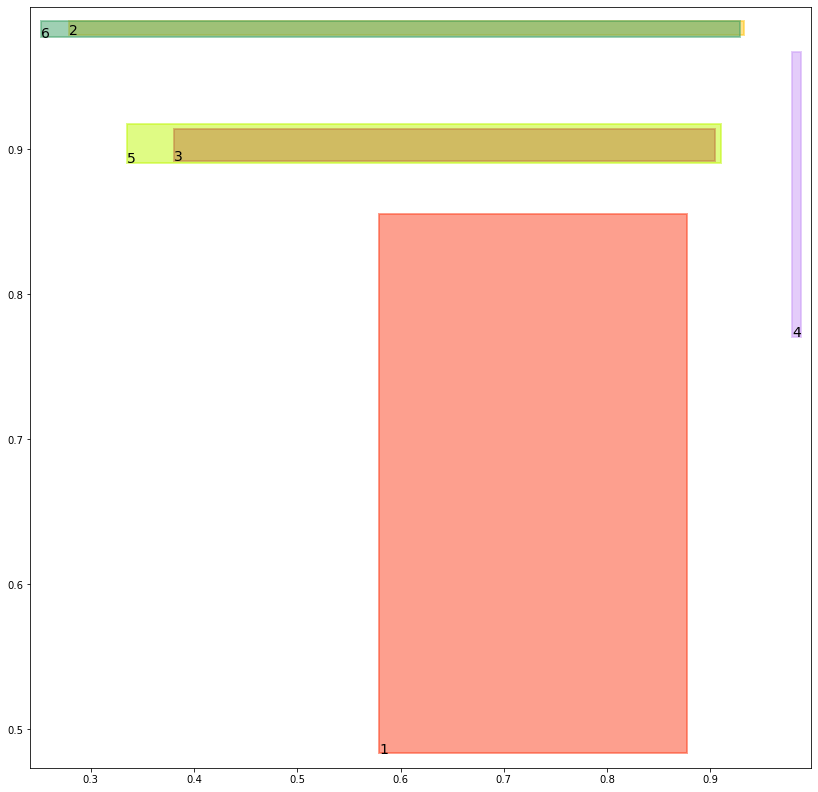

batch (tensor([[3, 5],
        [1, 2],
        [6, 2],
        [4, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.32486724853516 -28.305204391479492 tensor(-54.2238998413085938) tensor(-18.2285919189453125)
tensor(2) -87.1141586303711 -30.745615005493164 tensor(-54.6756591796875000) tensor(-16.0315361022949219)
tensor(3) -83.71003723144531 -29.543733596801758 tensor(-56.1944732666015625) tensor(-17.1813678741455078)
tensor(4) -89.11708068847656 -31.67888832092285 tensor(-82.7497711181640625) tensor(-29.5270824432373047)
tensor(5) -83.57878875732422 -29.497522354125977 tensor(-55.3213310241699219) tensor(-16.7407150268554688)
tensor(6) -86.9080581665039 -30.65322494506836 tensor(-52.4478378295898438) tensor(-15.0075435638427734)


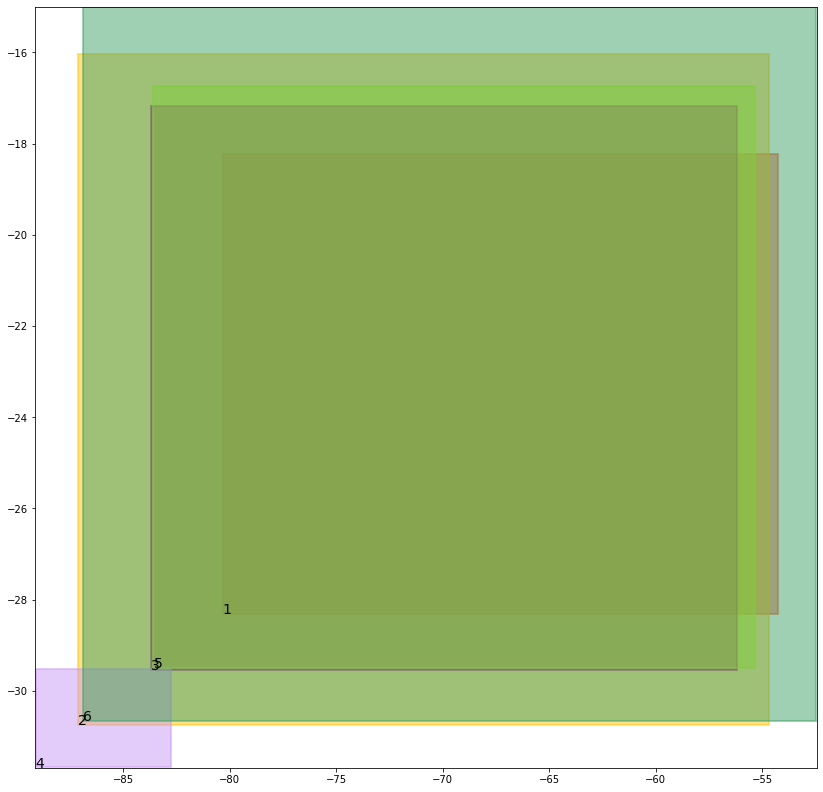

alignment data:
tensor(1) 0.5791758298873901 0.4834234416484833 tensor(0.8772588372230530) tensor(0.8555400371551514)
tensor(2) 0.2855524718761444 0.9796899557113647 tensor(0.9332398176193237) tensor(0.9883027672767639)
tensor(3) 0.3674117624759674 0.8875138759613037 tensor(0.9081263542175293) tensor(0.9171466231346130)
tensor(4) 0.9794759154319763 0.7705557942390442 tensor(0.9878684282302856) tensor(0.9670392274856567)
tensor(5) 0.34627294540405273 0.8956575989723206 tensor(0.9071762561798096) tensor(0.9143748283386230)
tensor(6) 0.2450118213891983 0.9766868352890015 tensor(0.9290112257003784) tensor(0.9882055521011353)


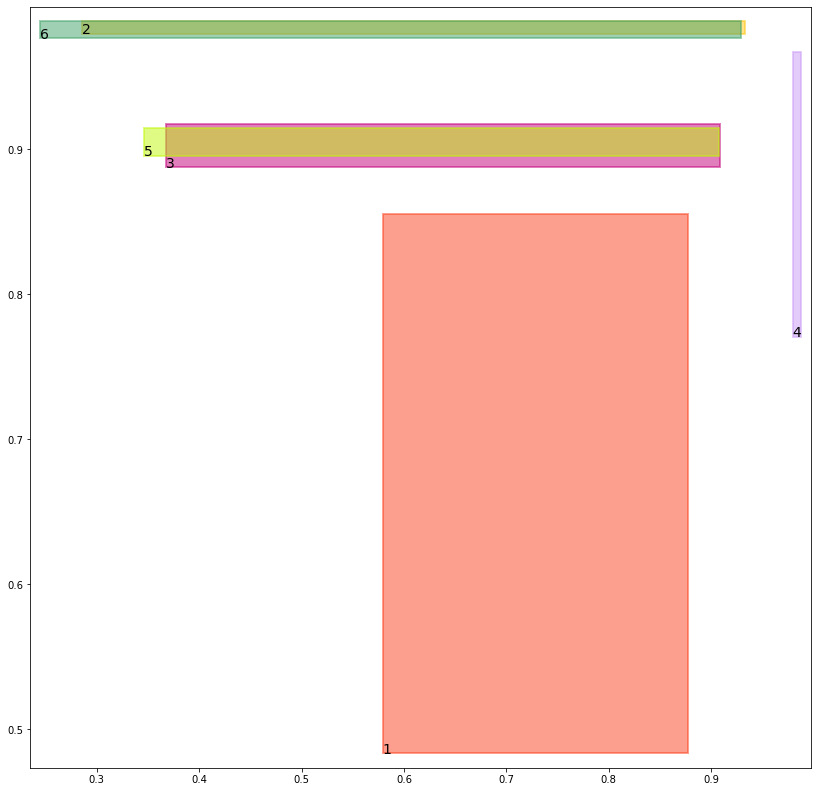

batch (tensor([[2, 6],
        [4, 5],
        [5, 3],
        [1, 3]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.32514190673828 -28.305322647094727 tensor(-54.2240753173828125) tensor(-18.2286701202392578)
tensor(2) -87.13936614990234 -30.756494522094727 tensor(-54.6790390014648438) tensor(-16.0320434570312500)
tensor(3) -83.83708953857422 -29.593435287475586 tensor(-55.5319519042968750) tensor(-16.8866405487060547)
tensor(4) -89.11736297607422 -31.679018020629883 tensor(-82.7500076293945312) tensor(-29.5271892547607422)
tensor(5) -83.49158477783203 -29.46324348449707 tensor(-55.9521636962890625) tensor(-17.0189266204833984)
tensor(6) -86.89817810058594 -30.64917755126953 tensor(-52.4074783325195312) tensor(-14.9884004592895508)


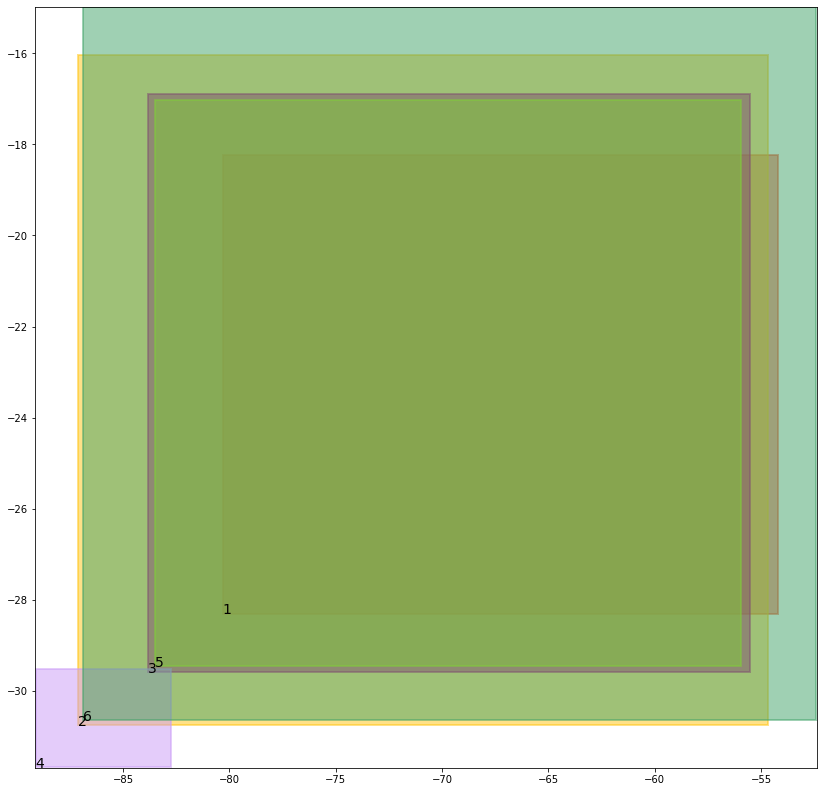

alignment data:
tensor(1) 0.5791763067245483 0.4834231436252594 tensor(0.8772590160369873) tensor(0.8555403351783752)
tensor(2) 0.2854912281036377 0.9799001812934875 tensor(0.9336936473846436) tensor(0.9884045124053955)
tensor(3) 0.3560313284397125 0.8856263160705566 tensor(0.9097273349761963) tensor(0.9187619686126709)
tensor(4) 0.9794757962226868 0.7705554366111755 tensor(0.9878684878349304) tensor(0.9670393466949463)
tensor(5) 0.3568199574947357 0.8979439735412598 tensor(0.9060456752777100) tensor(0.9133017659187317)
tensor(6) 0.24423861503601074 0.9766814708709717 tensor(0.9288559556007385) tensor(0.9881184697151184)


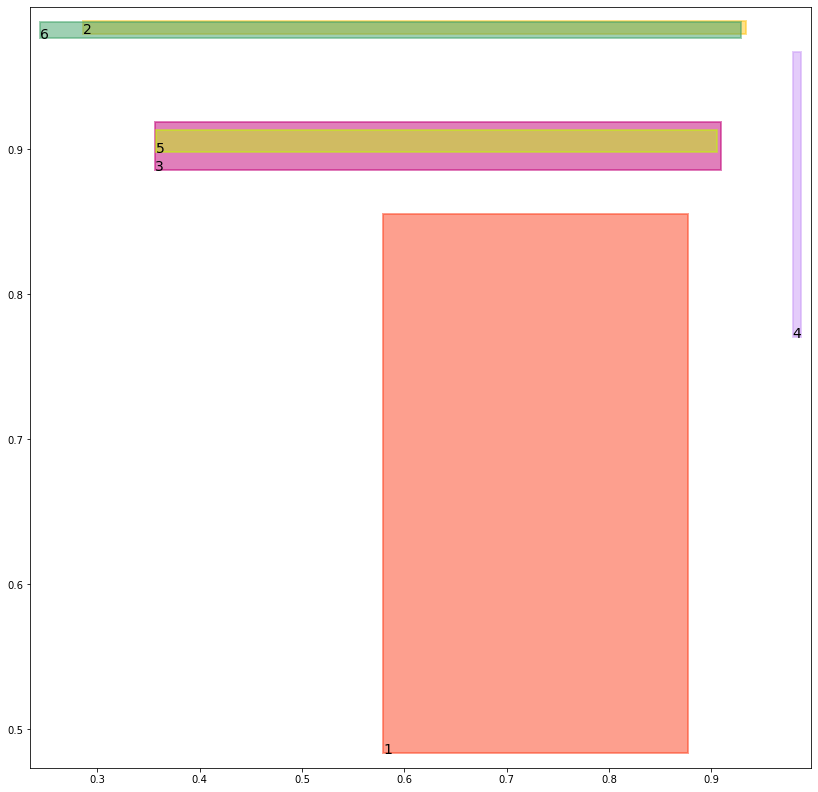

batch (tensor([[4, 6],
        [6, 2],
        [5, 3],
        [4, 5]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.32537078857422 -28.305431365966797 tensor(-54.2242279052734375) tensor(-18.2287464141845703)
tensor(2) -87.10344696044922 -30.740636825561523 tensor(-54.6826400756835938) tensor(-16.0327568054199219)
tensor(3) -83.82115936279297 -29.585668563842773 tensor(-55.3515853881835938) tensor(-16.7997951507568359)
tensor(4) -89.11760711669922 -31.679128646850586 tensor(-82.7502212524414062) tensor(-29.5272846221923828)
tensor(5) -83.55384826660156 -29.48866844177246 tensor(-56.1387710571289062) tensor(-17.1038799285888672)
tensor(6) -86.95262908935547 -30.673189163208008 tensor(-52.3710632324218750) tensor(-14.9711275100708008)


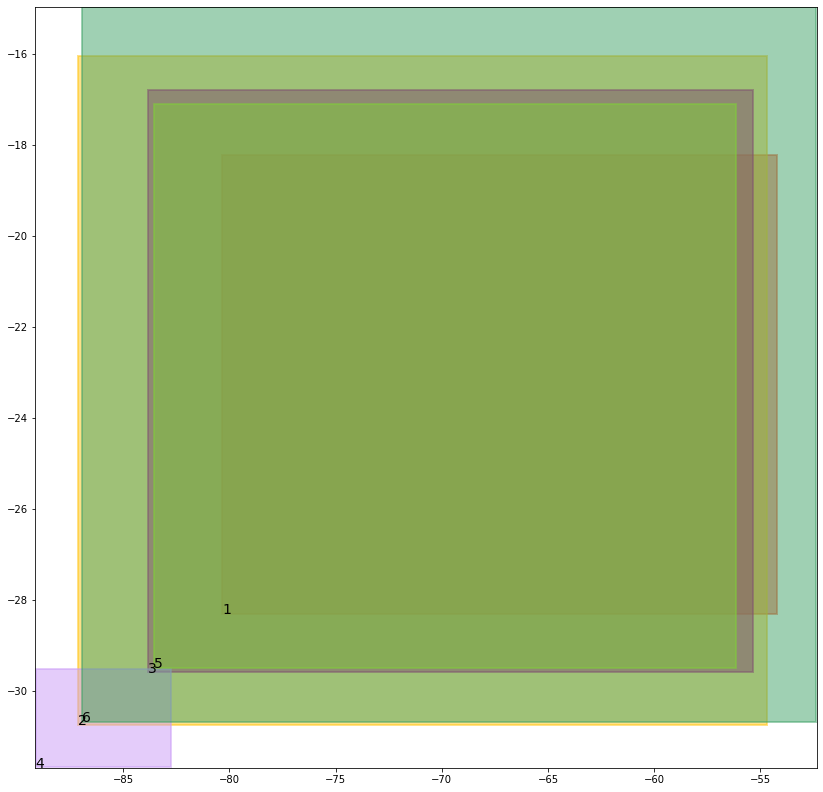

alignment data:
tensor(1) 0.5791767835617065 0.4834229350090027 tensor(0.8772593140602112) tensor(0.8555405139923096)
tensor(2) 0.2854464650154114 0.9800897836685181 tensor(0.9329847693443298) tensor(0.9883362650871277)
tensor(3) 0.3521544337272644 0.8864560723304749 tensor(0.9093091487884521) tensor(0.9188891649246216)
tensor(4) 0.9794757962226868 0.7705550789833069 tensor(0.9878684878349304) tensor(0.9670393466949463)
tensor(5) 0.3602505922317505 0.8980792760848999 tensor(0.9069753885269165) tensor(0.9138640761375427)
tensor(6) 0.24354100227355957 0.9766767024993896 tensor(0.9299128651618958) tensor(0.9882301092147827)


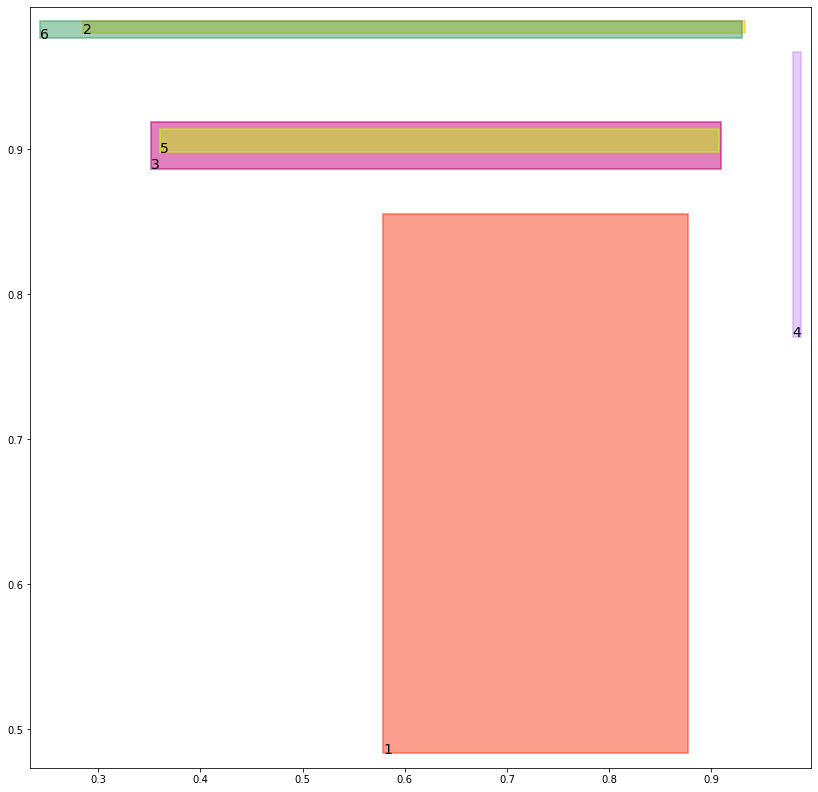

batch (tensor([[1, 3],
        [1, 2],
        [3, 5],
        [2, 6]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.32559967041016 -28.305524826049805 tensor(-54.2243728637695312) tensor(-18.2288112640380859)
tensor(2) -87.0706787109375 -30.726163864135742 tensor(-54.3746032714843750) tensor(-15.8926038742065430)
tensor(3) -83.80667877197266 -29.57861328125 tensor(-55.1892471313476562) tensor(-16.7216396331787109)
tensor(4) -89.11782836914062 -31.679224014282227 tensor(-82.7504043579101562) tensor(-29.5273723602294922)
tensor(5) -83.60971069335938 -29.511476516723633 tensor(-56.3081474304199219) tensor(-17.1809883117675781)
tensor(6) -87.00012969970703 -30.694143295288086 tensor(-52.6057128906250000) tensor(-15.0801124572753906)


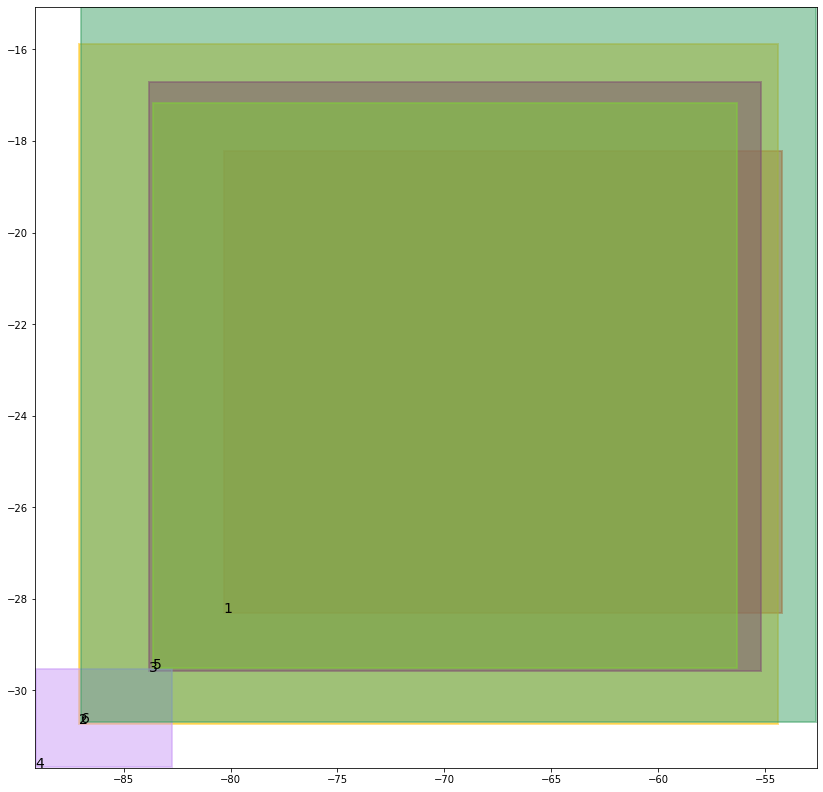

alignment data:
tensor(1) 0.57917720079422 0.48342275619506836 tensor(0.8772594928741455) tensor(0.8555406928062439)
tensor(2) 0.2797876000404358 0.979846179485321 tensor(0.9323378205299377) tensor(0.9882742166519165)
tensor(3) 0.34866586327552795 0.8872016668319702 tensor(0.9089294672012329) tensor(0.9190040230751038)
tensor(4) 0.9794756770133972 0.7705548405647278 tensor(0.9878684878349304) tensor(0.9670393466949463)
tensor(5) 0.3633647561073303 0.8982013463973999 tensor(0.9078088998794556) tensor(0.9143697023391724)
tensor(6) 0.24776016175746918 0.9771456718444824 tensor(0.9308363795280457) tensor(0.9883248805999756)


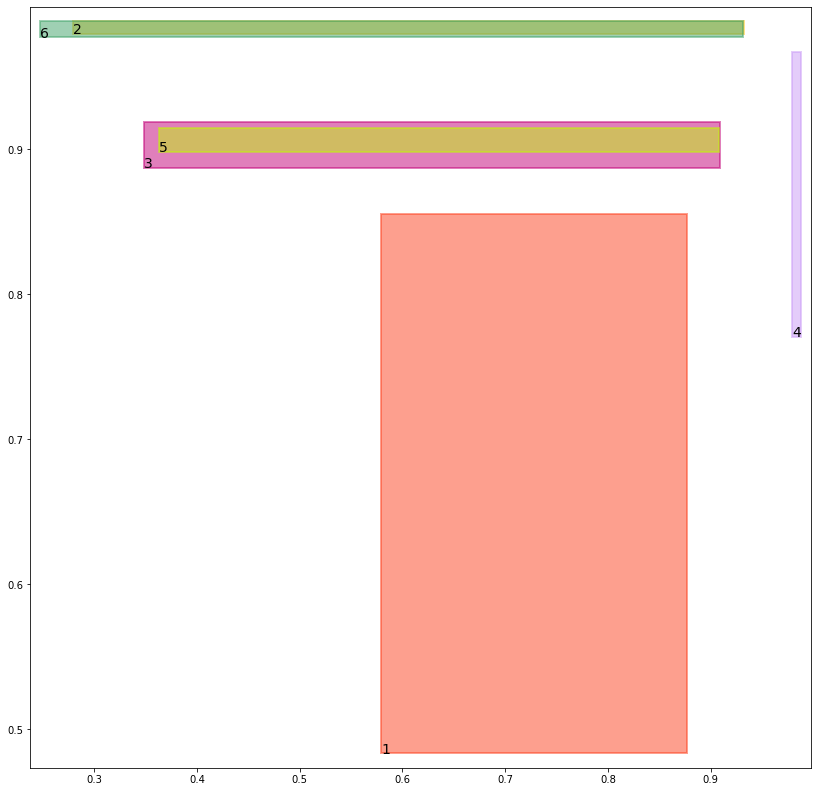

batch (tensor([[2, 6],
        [4, 5],
        [3, 5],
        [6, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.32576751708984 -28.30561065673828 tensor(-54.2245101928710938) tensor(-18.2288742065429688)
tensor(2) -87.00640869140625 -30.69696044921875 tensor(-53.8983802795410156) tensor(-15.6765918731689453)
tensor(3) -83.79352569580078 -29.572202682495117 tensor(-55.0431060791015625) tensor(-16.6512832641601562)
tensor(4) -89.11803436279297 -31.679319381713867 tensor(-82.7505874633789062) tensor(-29.5274524688720703)
tensor(5) -83.65985870361328 -29.531946182250977 tensor(-56.4617958068847656) tensor(-17.2509422302246094)
tensor(6) -87.07451629638672 -30.72785186767578 tensor(-53.0022964477539062) tensor(-15.2647190093994141)


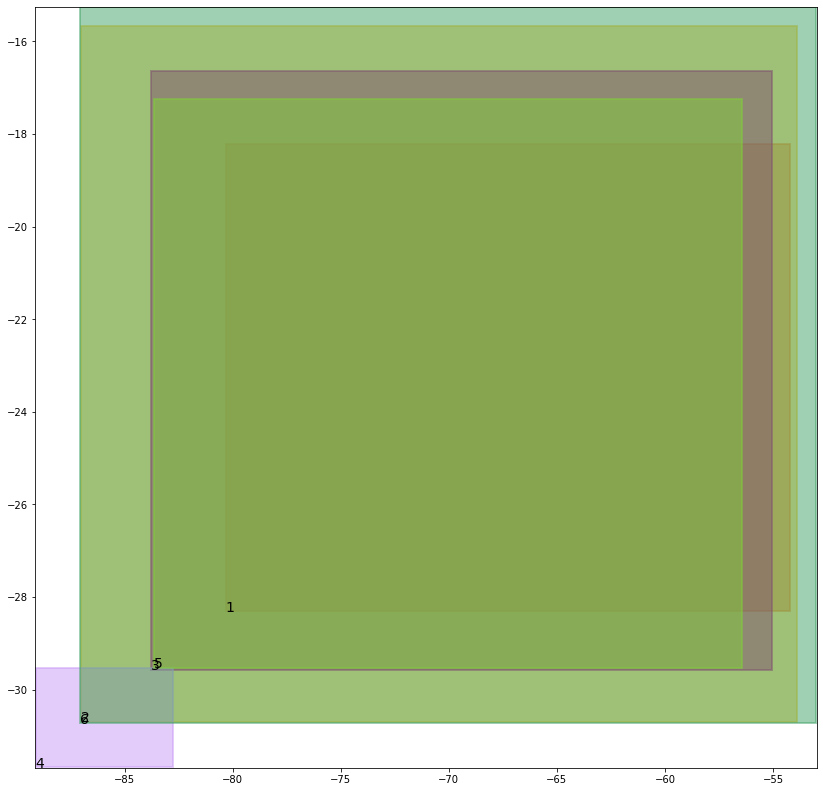

alignment data:
tensor(1) 0.5791776180267334 0.4834226071834564 tensor(0.8772596120834351) tensor(0.8555407524108887)
tensor(2) 0.2711179256439209 0.9793363213539124 tensor(0.9309613704681396) tensor(0.9883275628089905)
tensor(3) 0.34552571177482605 0.887872040271759 tensor(0.9085850715637207) tensor(0.9191077351570129)
tensor(4) 0.9794756770133972 0.7705546021461487 tensor(0.9878684878349304) tensor(0.9670394659042358)
tensor(5) 0.366190105676651 0.8983116745948792 tensor(0.9085565805435181) tensor(0.9148245453834534)
tensor(6) 0.2549389600753784 0.9778597354888916 tensor(0.9324080944061279) tensor(0.9882829785346985)


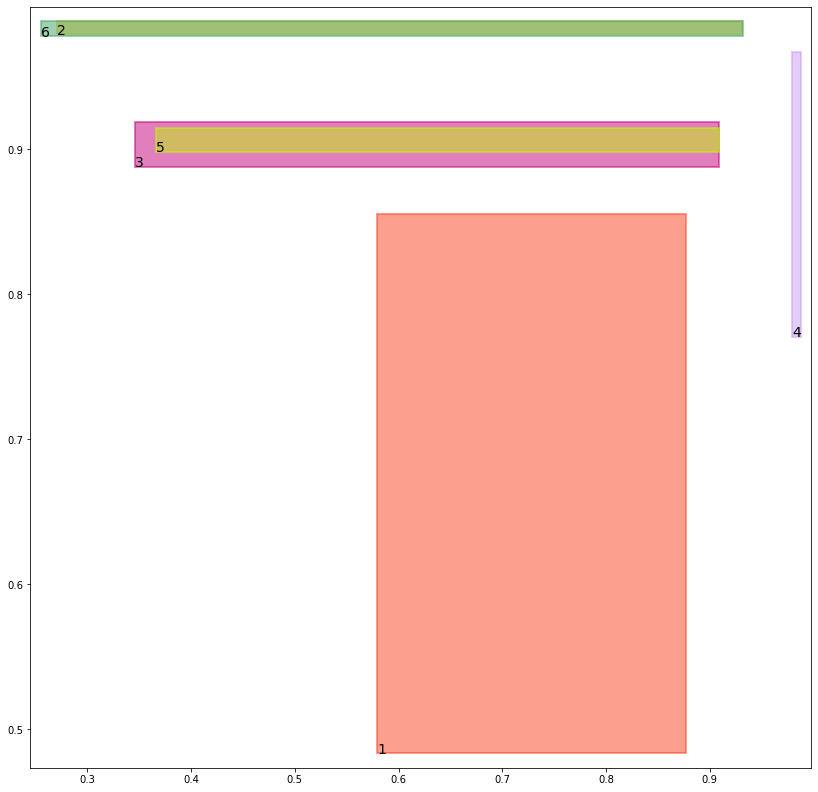

batch (tensor([[1, 3],
        [5, 3],
        [1, 2],
        [4, 6]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.32595825195312 -28.305688858032227 tensor(-54.2246170043945312) tensor(-18.2289257049560547)
tensor(2) -86.94722747802734 -30.670080184936523 tensor(-53.4760360717773438) tensor(-15.4844703674316406)
tensor(3) -83.51599884033203 -29.459136962890625 tensor(-55.6993408203125000) tensor(-16.9261684417724609)
tensor(4) -89.11821746826172 -31.679399490356445 tensor(-82.7507400512695312) tensor(-29.5275249481201172)
tensor(5) -83.96617889404297 -29.654563903808594 tensor(-55.8330650329589844) tensor(-16.9806499481201172)
tensor(6) -87.1404037475586 -30.75770378112793 tensor(-53.3663558959960938) tensor(-15.4343318939208984)


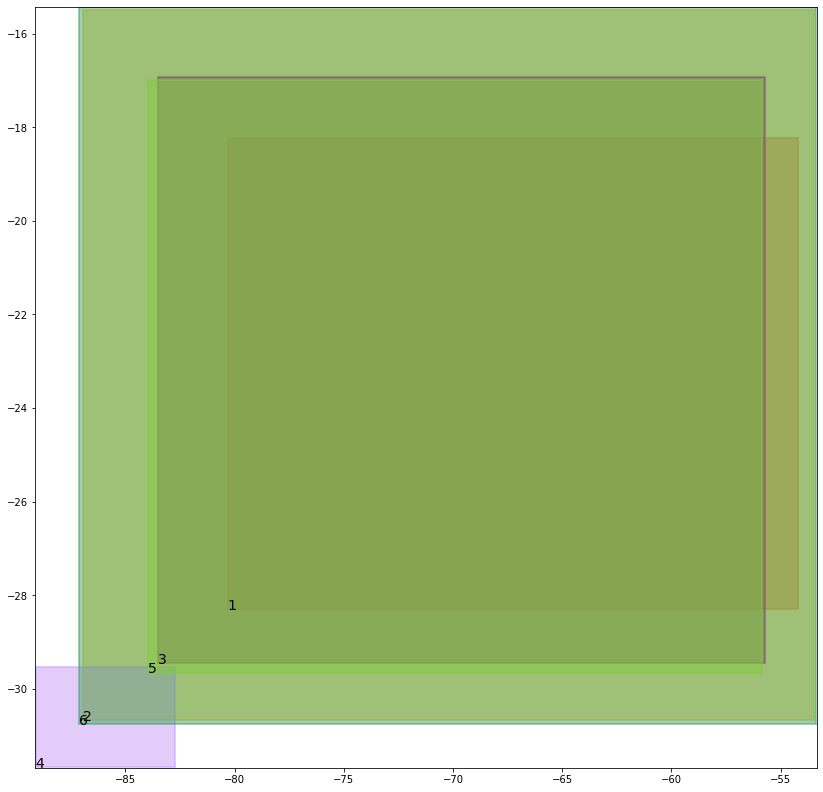

alignment data:
tensor(1) 0.5791779160499573 0.4834223687648773 tensor(0.8772597908973694) tensor(0.8555409312248230)
tensor(2) 0.2634267807006836 0.9788644313812256 tensor(0.9296945333480835) tensor(0.9883756637573242)
tensor(3) 0.35478946566581726 0.893207311630249 tensor(0.9044530391693115) tensor(0.9165425300598145)
tensor(4) 0.9794756174087524 0.7705543637275696 tensor(0.9878684878349304) tensor(0.9670394659042358)
tensor(5) 0.3564968407154083 0.8946073651313782 tensor(0.9128090143203735) tensor(0.9181233048439026)
tensor(6) 0.26154568791389465 0.9784866571426392 tensor(0.9338003396987915) tensor(0.9882450103759766)


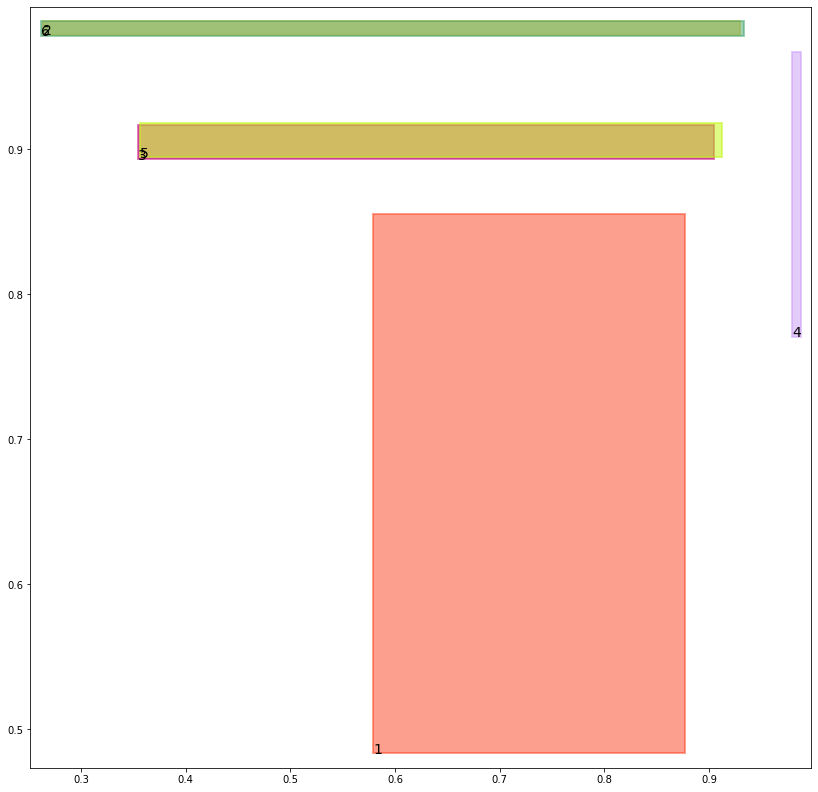

batch (tensor([[1, 3],
        [4, 5],
        [1, 2],
        [3, 5]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.32611846923828 -28.30575942993164 tensor(-54.2247238159179688) tensor(-18.2289752960205078)
tensor(2) -86.89283752441406 -30.645376205444336 tensor(-53.1062850952148438) tensor(-15.3111629486083984)
tensor(3) -83.5382080078125 -29.46732521057129 tensor(-56.2916946411132812) tensor(-17.1752166748046875)
tensor(4) -89.1183853149414 -31.679475784301758 tensor(-82.7508926391601562) tensor(-29.5275897979736328)
tensor(5) -83.9858627319336 -29.662824630737305 tensor(-55.2702713012695312) tensor(-16.7392444610595703)
tensor(6) -87.19886016845703 -30.784196853637695 tensor(-53.7031936645507812) tensor(-15.5884819030761719)


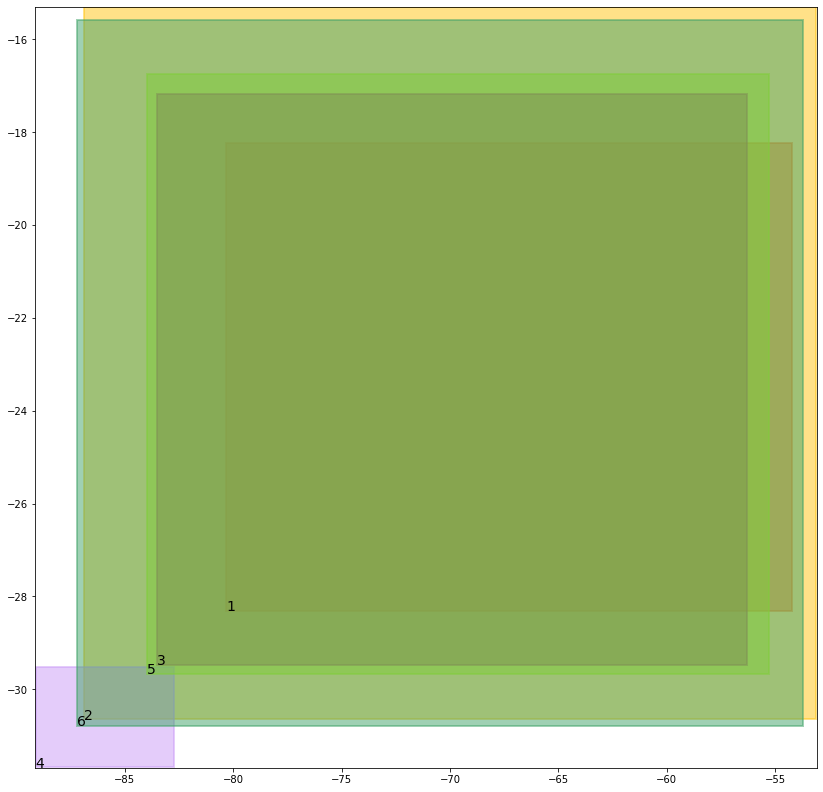

alignment data:
tensor(1) 0.5791782140731812 0.48342224955558777 tensor(0.8772599697113037) tensor(0.8555410504341125)
tensor(2) 0.25659552216529846 0.9784289002418518 tensor(0.9285309314727783) tensor(0.9884188771247864)
tensor(3) 0.3632592260837555 0.8978368043899536 tensor(0.9046616554260254) tensor(0.9169320464134216)
tensor(4) 0.9794756174087524 0.7705541849136353 tensor(0.9878684878349304) tensor(0.9670395851135254)
tensor(5) 0.3478836715221405 0.8911817073822021 tensor(0.9131320714950562) tensor(0.9182536602020264)
tensor(6) 0.2676127851009369 0.9790383577346802 tensor(0.9350360631942749) tensor(0.9882106781005859)


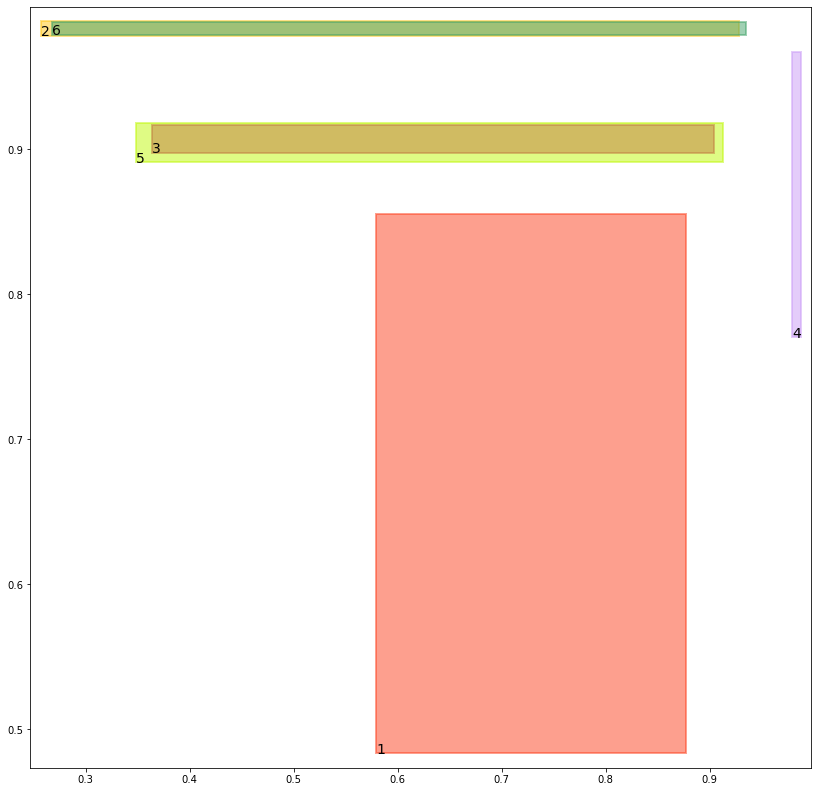

batch (tensor([[5, 3],
        [2, 6],
        [4, 6],
        [6, 2]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.32625579833984 -28.30582046508789 tensor(-54.2248229980468750) tensor(-18.2290210723876953)
tensor(2) -86.88170623779297 -30.64069175720215 tensor(-52.9621505737304688) tensor(-15.2430686950683594)
tensor(3) -83.5582275390625 -29.474712371826172 tensor(-56.8263854980468750) tensor(-17.4007434844970703)
tensor(4) -89.11853790283203 -31.679540634155273 tensor(-82.7510147094726562) tensor(-29.5276470184326172)
tensor(5) -84.00362396240234 -29.670278549194336 tensor(-54.7634201049804688) tensor(-16.5223026275634766)
tensor(6) -87.2215347290039 -30.793960571289062 tensor(-53.8102416992187500) tensor(-15.6364517211914062)


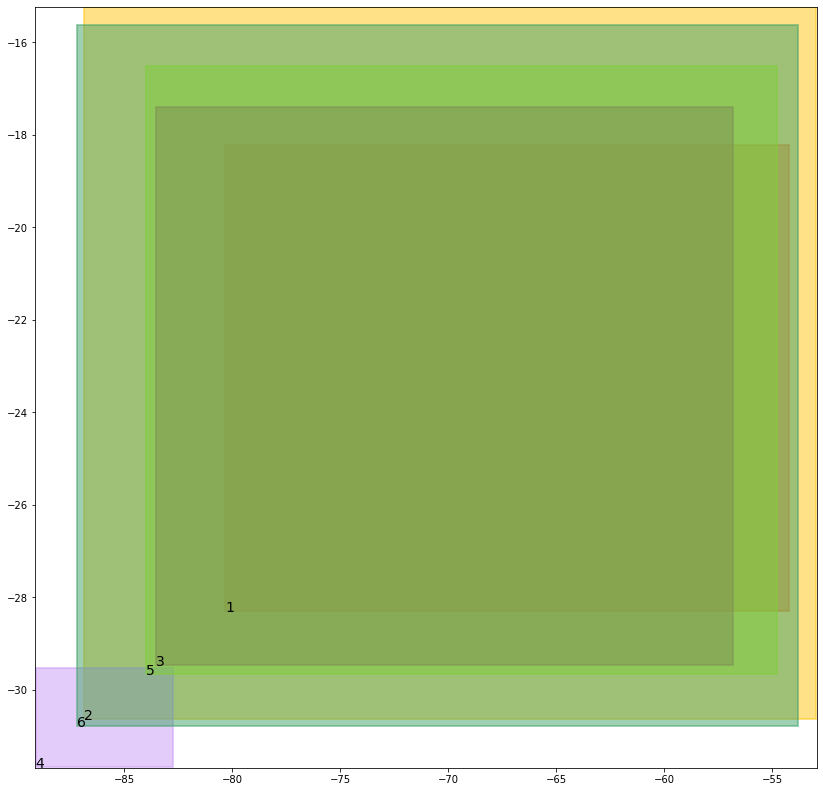

alignment data:
tensor(1) 0.579178512096405 0.4834221601486206 tensor(0.8772600293159485) tensor(0.8555411100387573)
tensor(2) 0.25387099385261536 0.9783632755279541 tensor(0.9283419847488403) tensor(0.9883477091789246)
tensor(3) 0.37098973989486694 0.9018679857254028 tensor(0.9048500657081604) tensor(0.9172828197479248)
tensor(4) 0.9794754981994629 0.7705539464950562 tensor(0.9878684878349304) tensor(0.9670395851135254)
tensor(5) 0.340181827545166 0.8880010843276978 tensor(0.9134230613708496) tensor(0.9183713793754578)
tensor(6) 0.2694907784461975 0.9792715907096863 tensor(0.9354427456855774) tensor(0.9883077740669250)


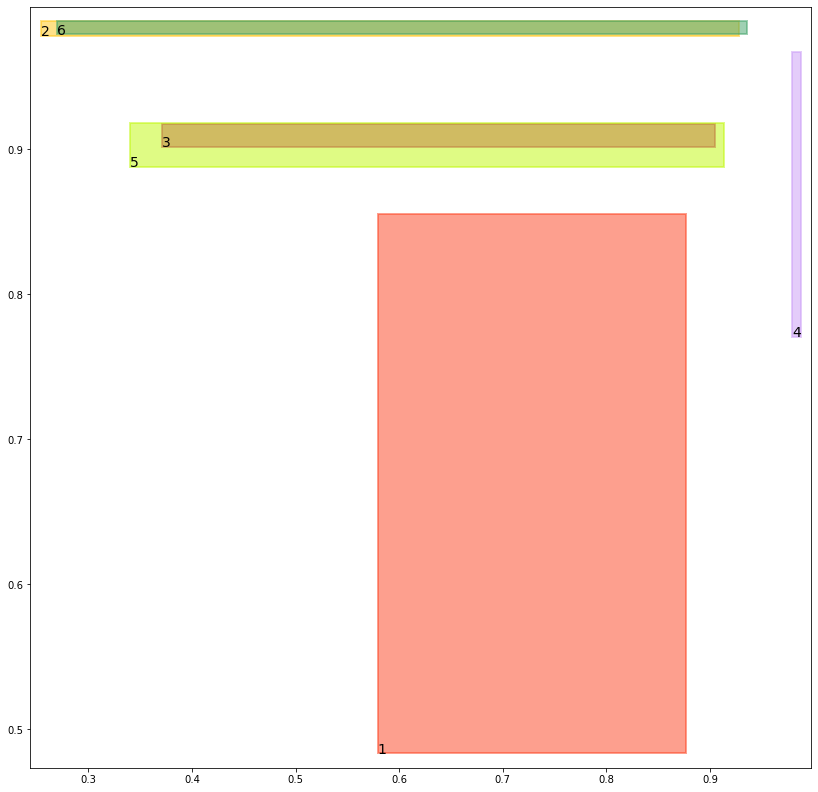

batch (tensor([[4, 6],
        [6, 2],
        [3, 5],
        [1, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.32638549804688 -28.305883407592773 tensor(-54.2249145507812500) tensor(-18.2290611267089844)
tensor(2) -86.86599731445312 -30.63471031188965 tensor(-53.1081848144531250) tensor(-15.3101644515991211)
tensor(3) -83.7087173461914 -29.534936904907227 tensor(-56.9150505065917969) tensor(-17.4332599639892578)
tensor(4) -89.11866760253906 -31.67960548400879 tensor(-82.7511215209960938) tensor(-29.5277042388916016)
tensor(5) -83.89472198486328 -29.627275466918945 tensor(-54.6919975280761719) tensor(-16.4924831390380859)
tensor(6) -87.24768829345703 -30.804471969604492 tensor(-53.6045379638671875) tensor(-15.5428943634033203)


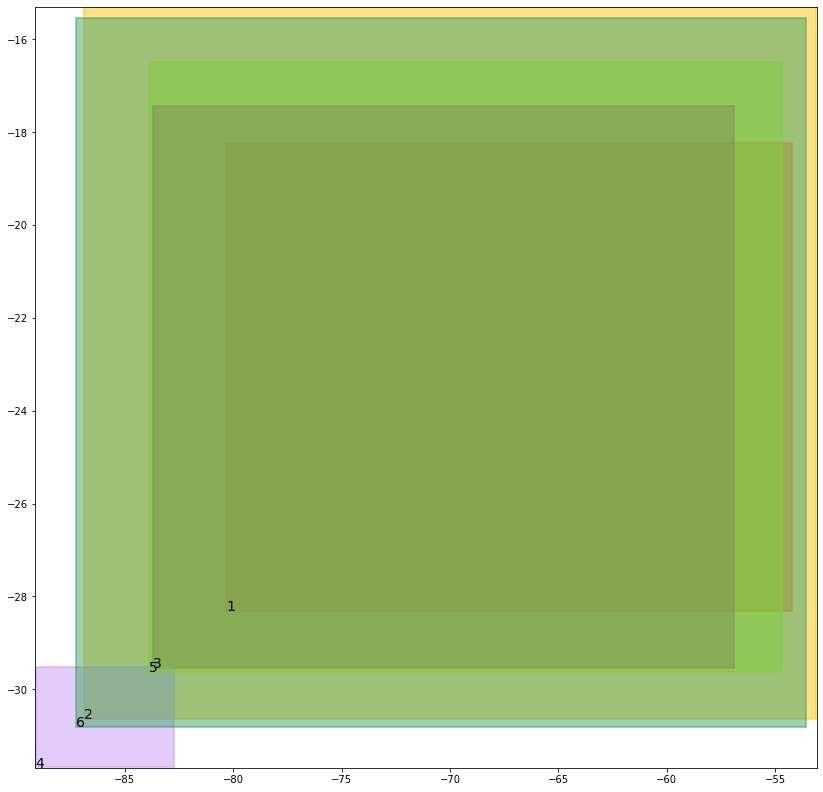

alignment data:
tensor(1) 0.5791787505149841 0.48342204093933105 tensor(0.8772601485252380) tensor(0.8555412888526917)
tensor(2) 0.25641295313835144 0.9787994623184204 tensor(0.9281629323959351) tensor(0.9881135821342468)
tensor(3) 0.3716962933540344 0.9035296440124512 tensor(0.9069359302520752) tensor(0.9189074635505676)
tensor(4) 0.9794754981994629 0.7705538272857666 tensor(0.9878684878349304) tensor(0.9670395851135254)
tensor(5) 0.3391835689544678 0.8874001502990723 tensor(0.9119887351989746) tensor(0.9170721173286438)
tensor(6) 0.26571616530418396 0.9791017770767212 tensor(0.9358083009719849) tensor(0.9885822534561157)


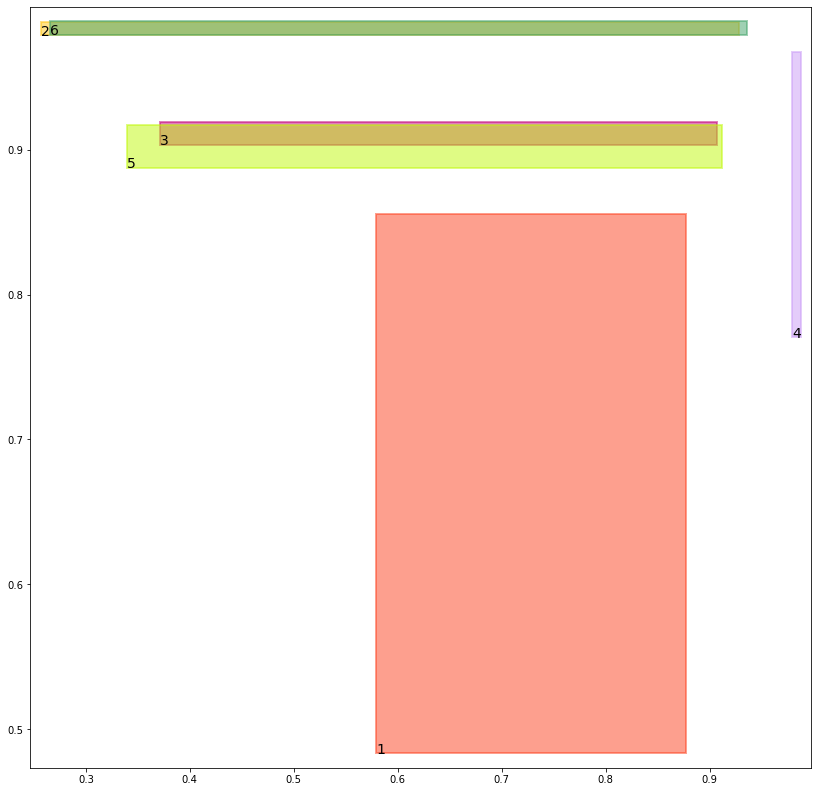

batch (tensor([[1, 3],
        [5, 3],
        [2, 6],
        [4, 5]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.32649993896484 -28.305932998657227 tensor(-54.2249832153320312) tensor(-18.2290973663330078)
tensor(2) -86.9205093383789 -30.659452438354492 tensor(-53.2407188415527344) tensor(-15.3710975646972656)
tensor(3) -83.80287170410156 -29.576549530029297 tensor(-56.9950523376464844) tensor(-17.4626846313476562)
tensor(4) -89.1187973022461 -31.679658889770508 tensor(-82.7512435913085938) tensor(-29.5277519226074219)
tensor(5) -83.83824920654297 -29.600847244262695 tensor(-54.6274337768554688) tensor(-16.4655361175537109)
tensor(6) -87.21581268310547 -30.789819717407227 tensor(-53.4226989746093750) tensor(-15.4586915969848633)


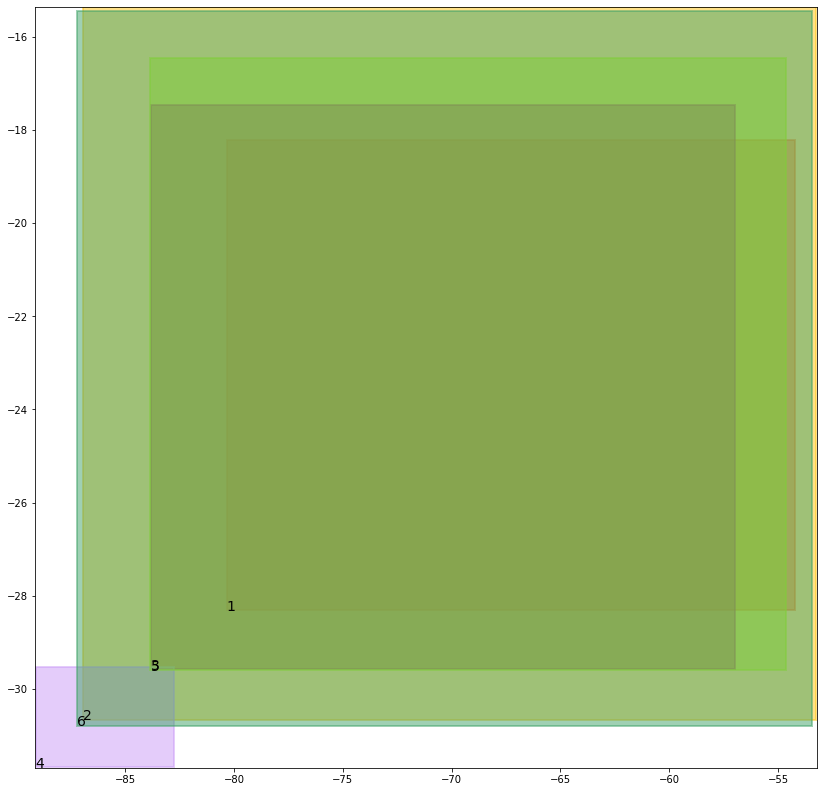

alignment data:
tensor(1) 0.5791789889335632 0.4834219217300415 tensor(0.8772602081298828) tensor(0.8555413484573364)
tensor(2) 0.25872501730918884 0.9791863560676575 tensor(0.9293211698532104) tensor(0.9880735278129578)
tensor(3) 0.3723437488079071 0.9050117135047913 tensor(0.9087837934494019) tensor(0.9190784096717834)
tensor(4) 0.9794754981994629 0.770553708076477 tensor(0.9878686070442200) tensor(0.9670395851135254)
tensor(5) 0.33828243613243103 0.8868546485900879 tensor(0.9106736183166504) tensor(0.9172853231430054)
tensor(6) 0.26234903931617737 0.9789488911628723 tensor(0.9351027011871338) tensor(0.9886433482170105)


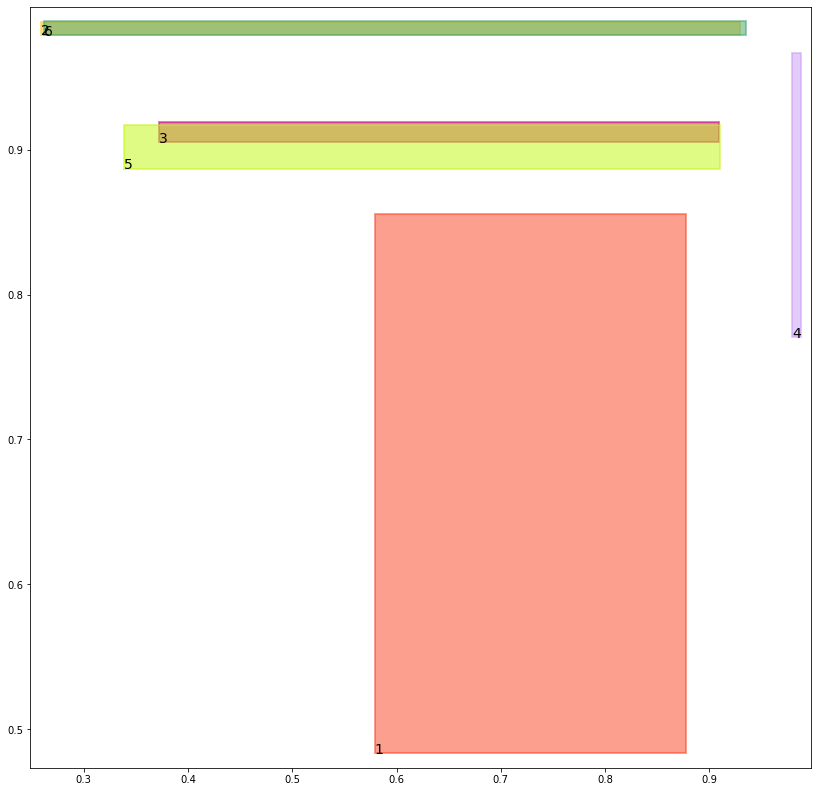

batch (tensor([[3, 5],
        [4, 5],
        [1, 3],
        [4, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.32660675048828 -28.305980682373047 tensor(-54.2250518798828125) tensor(-18.2291297912597656)
tensor(2) -86.96906280517578 -30.681493759155273 tensor(-53.3609390258789062) tensor(-15.4264106750488281)
tensor(3) -84.04976654052734 -29.68705177307129 tensor(-56.3088378906250000) tensor(-17.1588344573974609)
tensor(4) -89.11890411376953 -31.679712295532227 tensor(-82.7513275146484375) tensor(-29.5277938842773438)
tensor(5) -83.6106185913086 -29.49782371520996 tensor(-55.3224945068359375) tensor(-16.7645320892333984)
tensor(6) -87.1866683959961 -30.776439666748047 tensor(-53.2608871459960938) tensor(-15.3825874328613281)


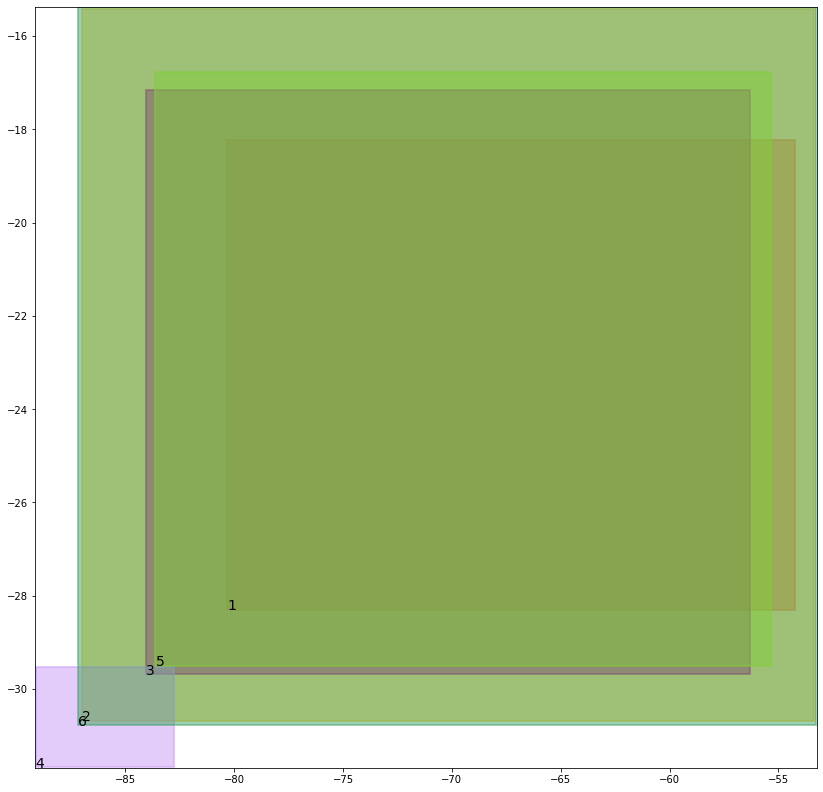

alignment data:
tensor(1) 0.5791791677474976 0.48342180252075195 tensor(0.8772603273391724) tensor(0.8555414676666260)
tensor(2) 0.26082655787467957 0.9795301556587219 tensor(0.9303531646728516) tensor(0.9880371093750000)
tensor(3) 0.36072519421577454 0.9027683138847351 tensor(0.9138226509094238) tensor(0.9192326068878174)
tensor(4) 0.9794753789901733 0.7705535292625427 tensor(0.9878686070442200) tensor(0.9670397043228149)
tensor(5) 0.34901776909828186 0.8909094333648682 tensor(0.9058660268783569) tensor(0.9173882007598877)
tensor(6) 0.259329229593277 0.9788097739219666 tensor(0.9344584941864014) tensor(0.9886981248855591)


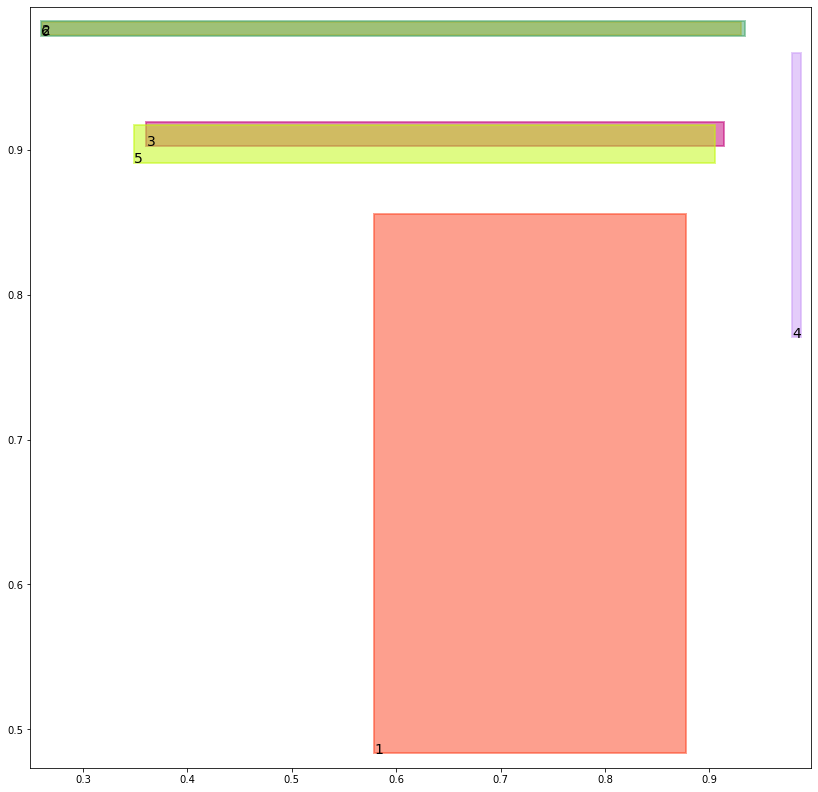

batch (tensor([[6, 2],
        [1, 2],
        [2, 6],
        [5, 3]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.32669830322266 -28.3060245513916 tensor(-54.2251205444335938) tensor(-18.2291584014892578)
tensor(2) -87.05575561523438 -30.72014808654785 tensor(-53.2800521850585938) tensor(-15.3879756927490234)
tensor(3) -84.18695831298828 -29.749507904052734 tensor(-55.6957855224609375) tensor(-16.8876667022705078)
tensor(4) -89.11901092529297 -31.679758071899414 tensor(-82.7514114379882812) tensor(-29.5278339385986328)
tensor(5) -83.48757934570312 -29.437637329101562 tensor(-55.9544868469238281) tensor(-17.0370483398437500)
tensor(6) -87.12129974365234 -30.747323989868164 tensor(-53.3082160949707031) tensor(-15.4043254852294922)


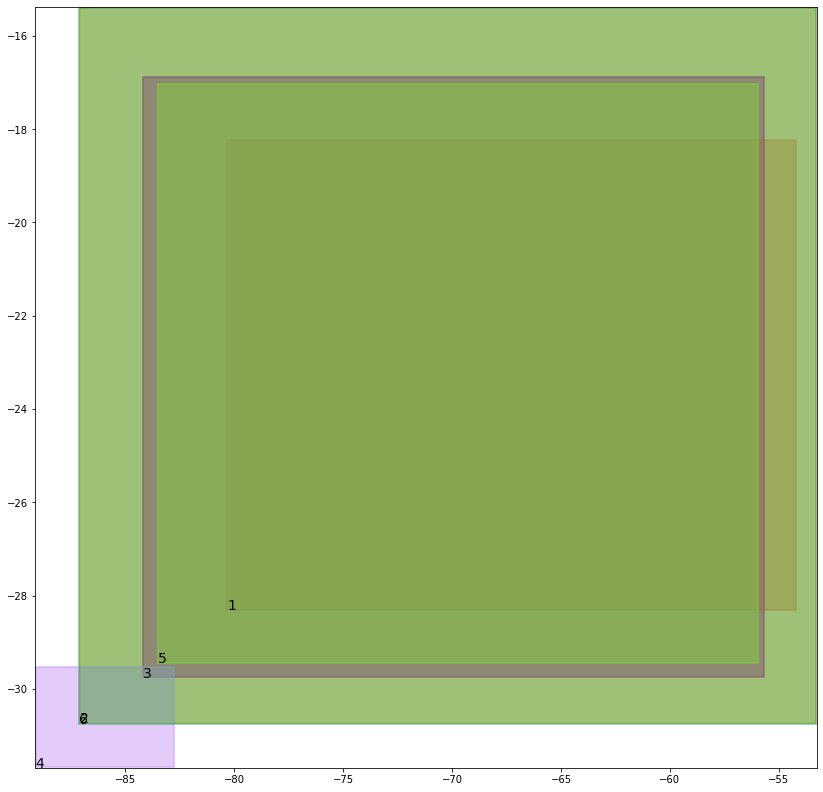

alignment data:
tensor(1) 0.5791793465614319 0.4834217131137848 tensor(0.8772604465484619) tensor(0.8555415272712708)
tensor(2) 0.25927209854125977 0.979536771774292 tensor(0.9321011304855347) tensor(0.9881222844123840)
tensor(3) 0.35037827491760254 0.9007075428962708 tensor(0.9171146154403687) tensor(0.9185056090354919)
tensor(4) 0.9794753789901733 0.7705534100532532 tensor(0.9878686070442200) tensor(0.9670397043228149)
tensor(5) 0.3588552176952362 0.8944642543792725 tensor(0.9026455879211426) tensor(0.9184095859527588)
tensor(6) 0.260151743888855 0.9789522886276245 tensor(0.9331417083740234) tensor(0.9886261820793152)


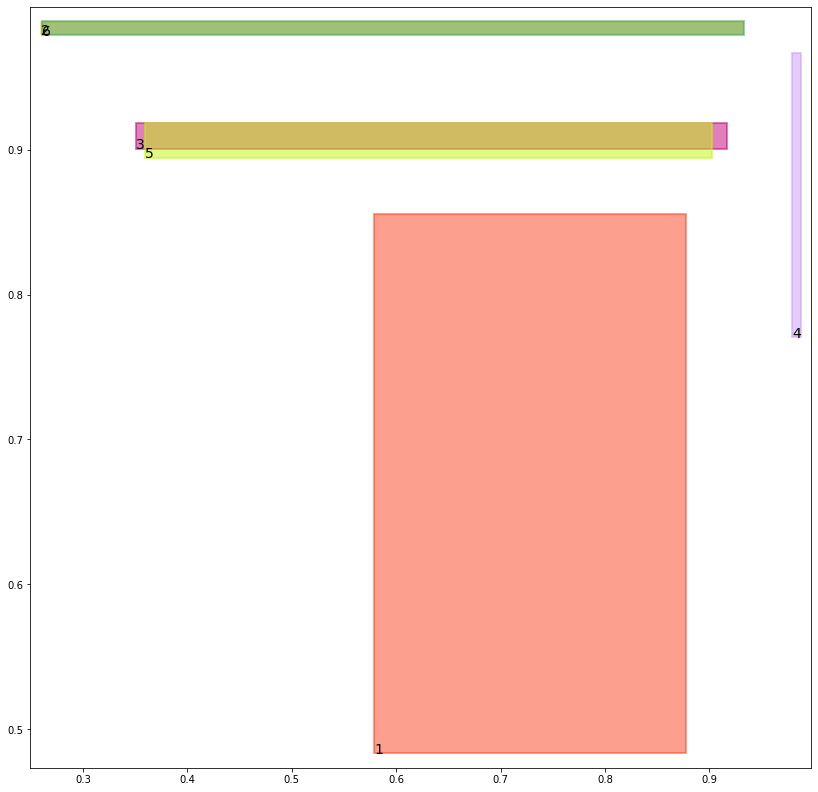

batch (tensor([[5, 3],
        [3, 5],
        [6, 2],
        [2, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.32677459716797 -28.306062698364258 tensor(-54.2251739501953125) tensor(-18.2291851043701172)
tensor(2) -87.16338348388672 -30.767873764038086 tensor(-53.3351287841796875) tensor(-15.4152441024780273)
tensor(3) -84.25074005126953 -29.779760360717773 tensor(-55.2743110656738281) tensor(-16.7083644866943359)
tensor(4) -89.11910247802734 -31.67979621887207 tensor(-82.7514877319335938) tensor(-29.5278682708740234)
tensor(5) -83.44258880615234 -29.409971237182617 tensor(-56.3981552124023438) tensor(-17.2204990386962891)
tensor(6) -87.03077697753906 -30.70728874206543 tensor(-53.2184677124023438) tensor(-15.3600578308105469)


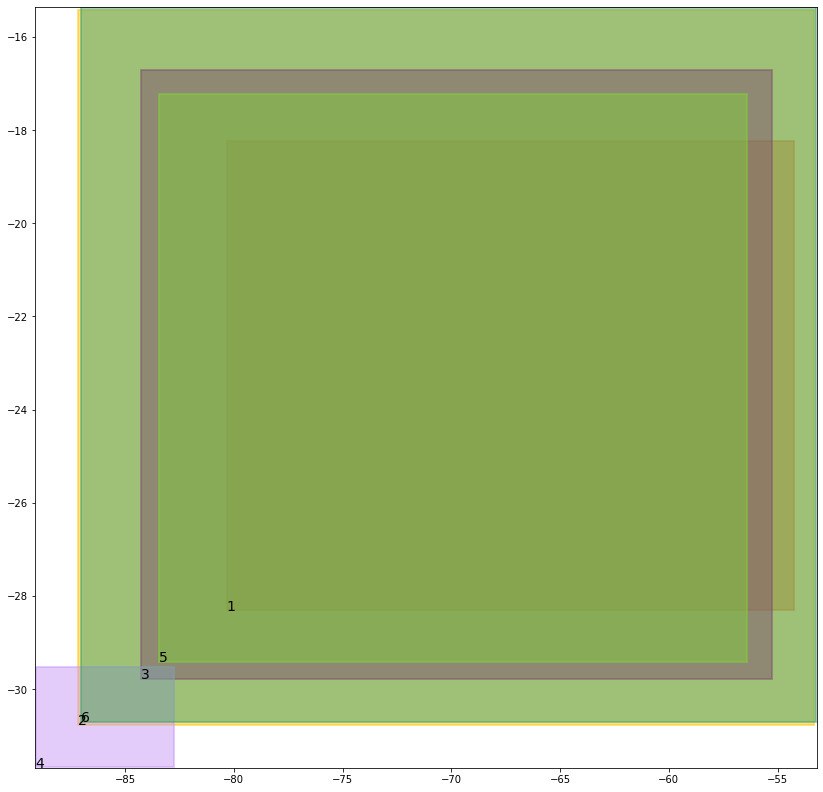

alignment data:
tensor(1) 0.5791795253753662 0.48342159390449524 tensor(0.8772605061531067) tensor(0.8555415272712708)
tensor(2) 0.2604548931121826 0.9793151617050171 tensor(0.9342352151870728) tensor(0.9882856607437134)
tensor(3) 0.3441031873226166 0.8978394269943237 tensor(0.9192481040954590) tensor(0.9171700477600098)
tensor(4) 0.9794753789901733 0.7705532312393188 tensor(0.9878686070442200) tensor(0.9670397043228149)
tensor(5) 0.36483660340309143 0.8985592126846313 tensor(0.9006855487823486) tensor(0.9199981093406677)
tensor(6) 0.2582421600818634 0.9792776703834534 tensor(0.9313572645187378) tensor(0.9884676337242126)


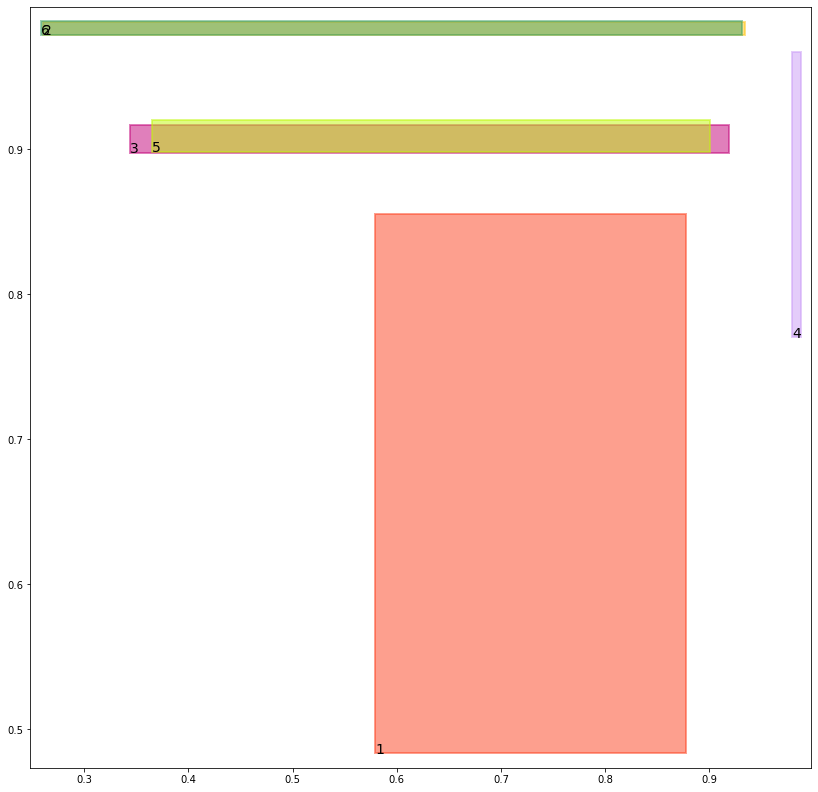

batch (tensor([[4, 5],
        [1, 3],
        [1, 2],
        [4, 6]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.32686614990234 -28.30609703063965 tensor(-54.2252273559570312) tensor(-18.2292118072509766)
tensor(2) -87.25804138183594 -30.809831619262695 tensor(-53.3849945068359375) tensor(-15.4399461746215820)
tensor(3) -84.30575561523438 -29.80605125427246 tensor(-54.8938903808593750) tensor(-16.5468578338623047)
tensor(4) -89.11917877197266 -31.67983055114746 tensor(-82.7515563964843750) tensor(-29.5279026031494141)
tensor(5) -83.39972686767578 -29.38408660888672 tensor(-56.7973327636718750) tensor(-17.3860683441162109)
tensor(6) -86.94709777832031 -30.670269012451172 tensor(-53.1376342773437500) tensor(-15.3202056884765625)


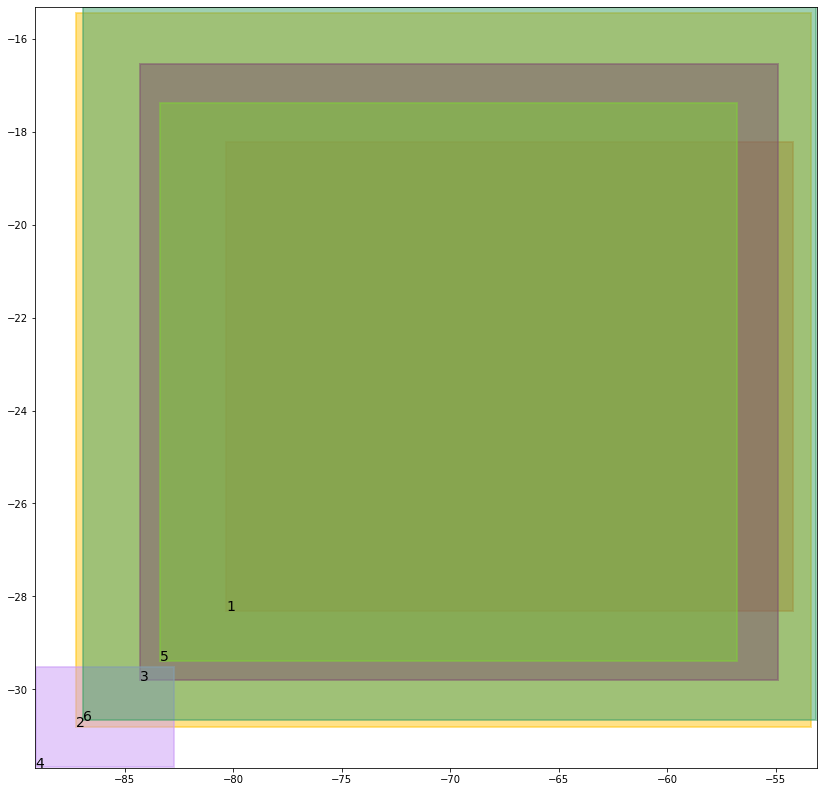

alignment data:
tensor(1) 0.5791797041893005 0.48342153429985046 tensor(0.8772606253623962) tensor(0.8555416464805603)
tensor(2) 0.2615269422531128 0.9791128635406494 tensor(0.9361103177070618) tensor(0.9884314537048340)
tensor(3) 0.3384779393672943 0.8951842784881592 tensor(0.9211330413818359) tensor(0.9159460067749023)
tensor(4) 0.9794753789901733 0.7705531716346741 tensor(0.9878686070442200) tensor(0.9670397043228149)
tensor(5) 0.3702789843082428 0.9021382927894592 tensor(0.8988840579986572) tensor(0.9214096069335938)
tensor(6) 0.25652411580085754 0.9795675277709961 tensor(0.9297066926956177) tensor(0.9883225560188293)


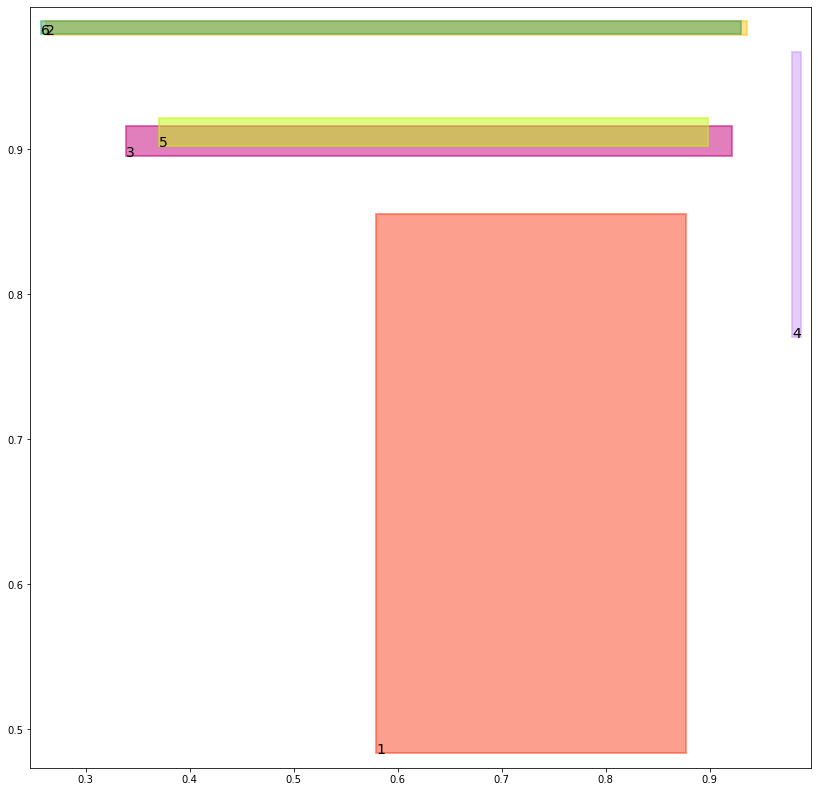

batch (tensor([[2, 6],
        [5, 3],
        [1, 2],
        [6, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.32693481445312 -28.306129455566406 tensor(-54.2252731323242188) tensor(-18.2292308807373047)
tensor(2) -87.30358123779297 -30.830265045166016 tensor(-53.2581291198730469) tensor(-15.3790397644042969)
tensor(3) -84.30680084228516 -29.809608459472656 tensor(-54.8028259277343750) tensor(-16.5097751617431641)
tensor(4) -89.11924743652344 -31.67986488342285 tensor(-82.7516250610351562) tensor(-29.5279254913330078)
tensor(5) -83.42916870117188 -29.39149284362793 tensor(-56.9035797119140625) tensor(-17.4250049591064453)
tensor(6) -86.91425323486328 -30.655485153198242 tensor(-53.2403793334960938) tensor(-15.3689308166503906)


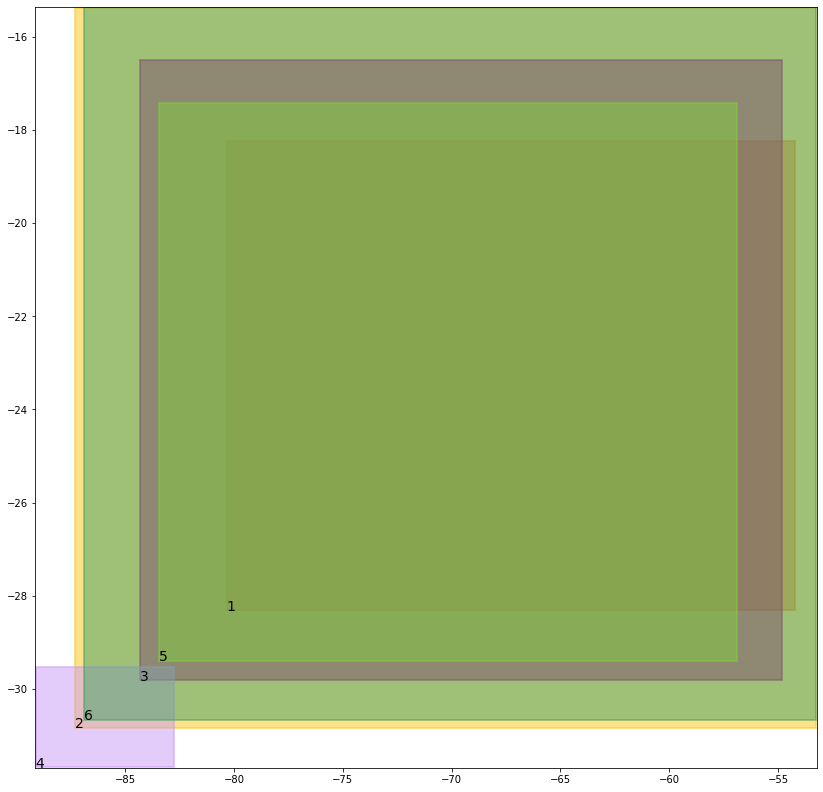

alignment data:
tensor(1) 0.5791798233985901 0.4834214746952057 tensor(0.8772606849670410) tensor(0.8555417060852051)
tensor(2) 0.2590184807777405 0.9792460203170776 tensor(0.9370453357696533) tensor(0.9884498119354248)
tensor(3) 0.3373168706893921 0.8942265510559082 tensor(0.9218717813491821) tensor(0.9147897362709045)
tensor(4) 0.9794752597808838 0.7705531120300293 tensor(0.9878686070442200) tensor(0.9670397043228149)
tensor(5) 0.37112322449684143 0.9041355848312378 tensor(0.8986877202987671) tensor(0.9226655960083008)
tensor(6) 0.2584863007068634 0.9795762300491333 tensor(0.9290229082107544) tensor(0.9883203506469727)


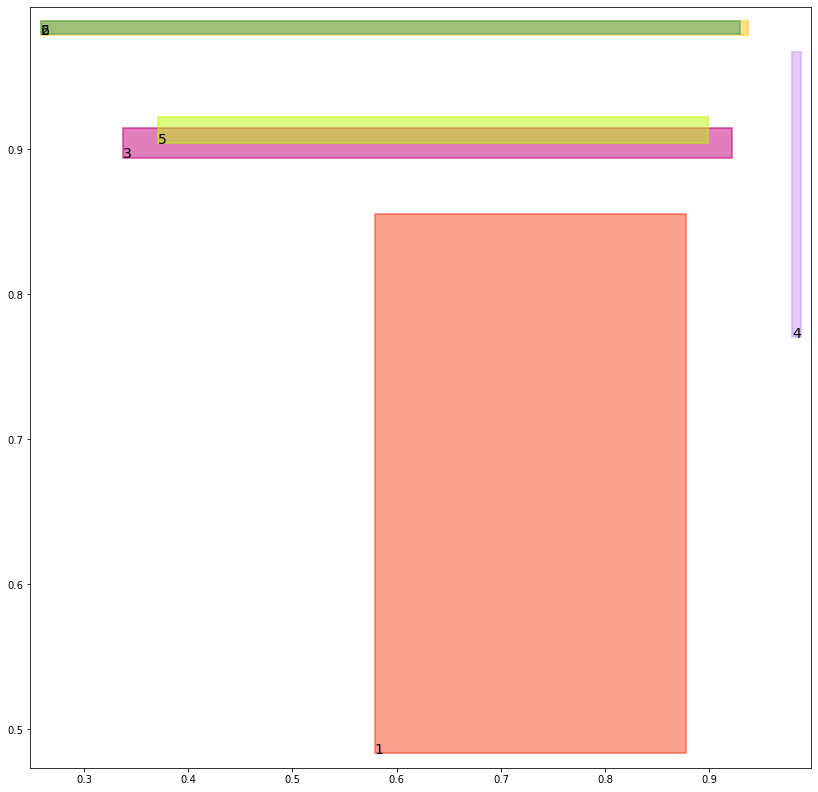

batch (tensor([[4, 6],
        [3, 5],
        [1, 3],
        [4, 5]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.32698822021484 -28.306154251098633 tensor(-54.2253189086914062) tensor(-18.2292537689208984)
tensor(2) -87.34423065185547 -30.848493576049805 tensor(-53.1441650390625000) tensor(-15.3243255615234375)
tensor(3) -84.39248657226562 -29.840694427490234 tensor(-54.7204055786132812) tensor(-16.4762439727783203)
tensor(4) -89.11931610107422 -31.679895401000977 tensor(-82.7516860961914062) tensor(-29.5279521942138672)
tensor(5) -83.3772201538086 -29.374473571777344 tensor(-57.0027847290039062) tensor(-17.4617424011230469)
tensor(6) -86.88433074951172 -30.642009735107422 tensor(-53.3336715698242188) tensor(-15.4131736755371094)


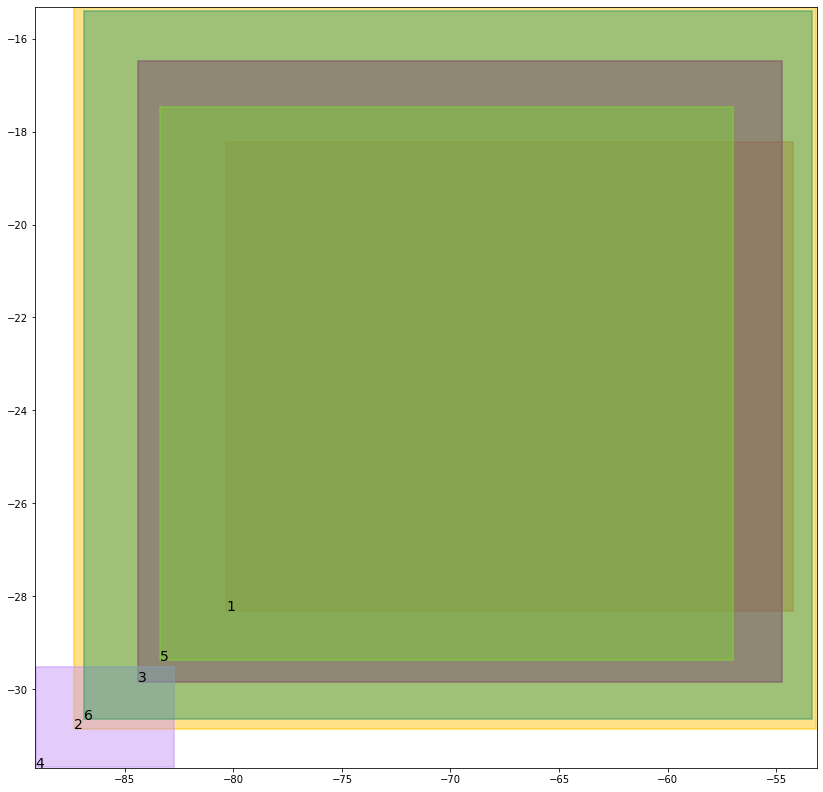

alignment data:
tensor(1) 0.5791799426078796 0.4834214150905609 tensor(0.8772606849670410) tensor(0.8555417060852051)
tensor(2) 0.2567649185657501 0.9793657064437866 tensor(0.9378793239593506) tensor(0.9884665012359619)
tensor(3) 0.33626922965049744 0.8933543562889099 tensor(0.9225339889526367) tensor(0.9165431261062622)
tensor(4) 0.9794752597808838 0.7705530524253845 tensor(0.9878686070442200) tensor(0.9670397043228149)
tensor(5) 0.37195661664009094 0.9059221148490906 tensor(0.8984851837158203) tensor(0.9212969541549683)
tensor(6) 0.2602680027484894 0.9795840382575989 tensor(0.9283996820449829) tensor(0.9883183240890503)


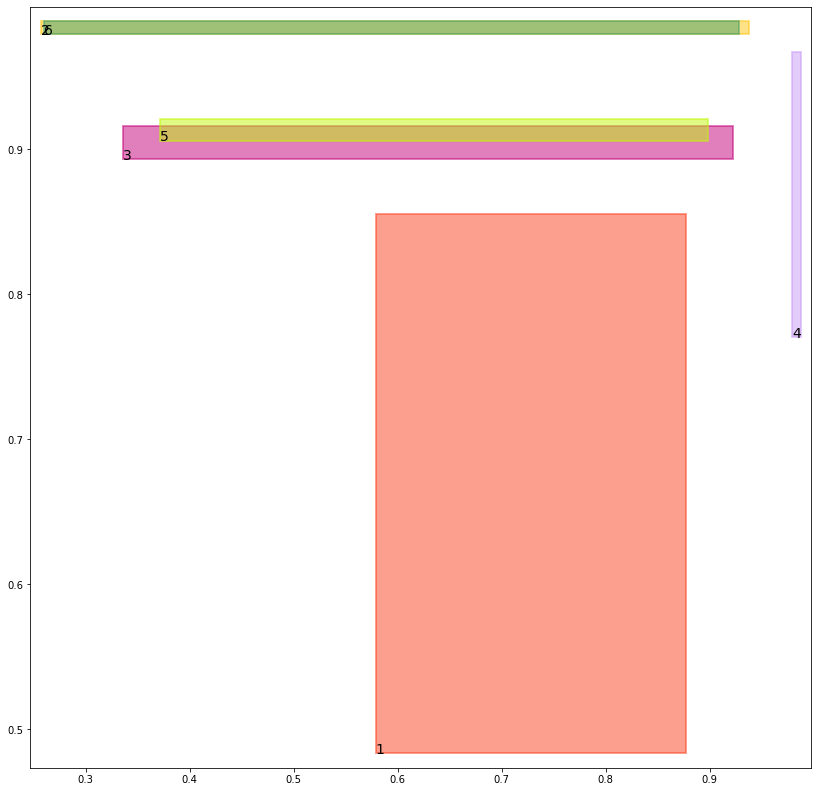

batch (tensor([[2, 6],
        [1, 3],
        [4, 6],
        [4, 5]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.32706451416016 -28.306184768676758 tensor(-54.2253532409667969) tensor(-18.2292709350585938)
tensor(2) -87.38052368164062 -30.864776611328125 tensor(-53.0417175292968750) tensor(-15.2751445770263672)
tensor(3) -84.46885681152344 -29.8684139251709 tensor(-54.6458320617675781) tensor(-16.4459209442138672)
tensor(4) -89.11936950683594 -31.679922103881836 tensor(-82.7517242431640625) tensor(-29.5279750823974609)
tensor(5) -83.3296890258789 -29.358911514282227 tensor(-57.0916748046875000) tensor(-17.4947204589843750)
tensor(6) -86.8570785522461 -30.629741668701172 tensor(-53.4183425903320312) tensor(-15.4533290863037109)


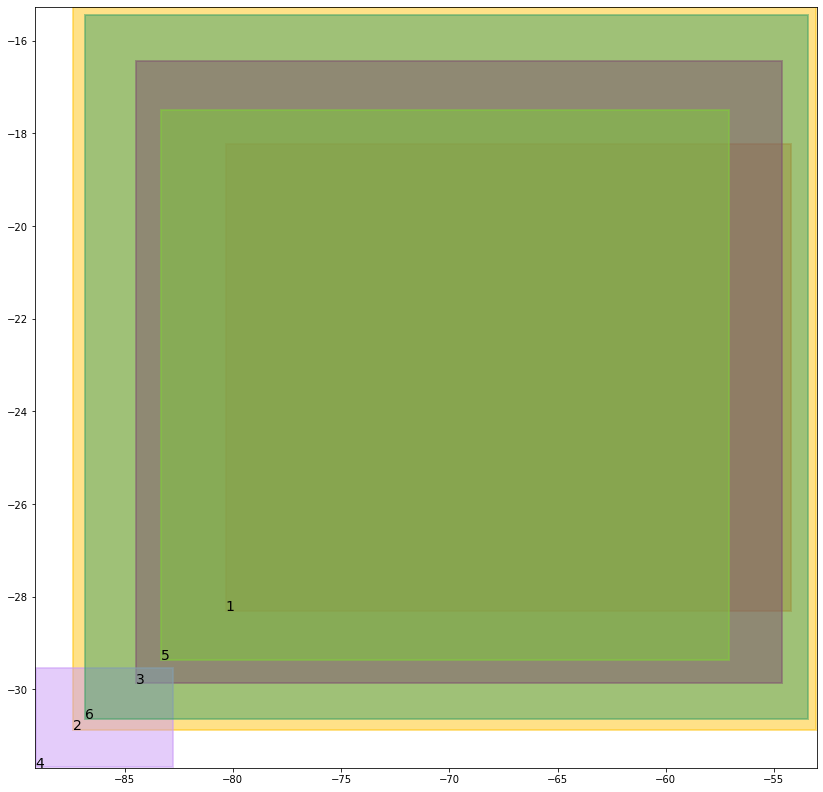

alignment data:
tensor(1) 0.5791800618171692 0.48342135548591614 tensor(0.8772608041763306) tensor(0.8555418252944946)
tensor(2) 0.254739373922348 0.9794731736183167 tensor(0.9386242628097534) tensor(0.9884815216064453)
tensor(3) 0.3353238105773926 0.8925607204437256 tensor(0.9231280088424683) tensor(0.9180994629859924)
tensor(4) 0.9794752597808838 0.7705529928207397 tensor(0.9878686070442200) tensor(0.9670397043228149)
tensor(5) 0.3727104067802429 0.9075109362602234 tensor(0.8983019590377808) tensor(0.9200410842895508)
tensor(6) 0.26188504695892334 0.9795911312103271 tensor(0.9278321862220764) tensor(0.9883164763450623)


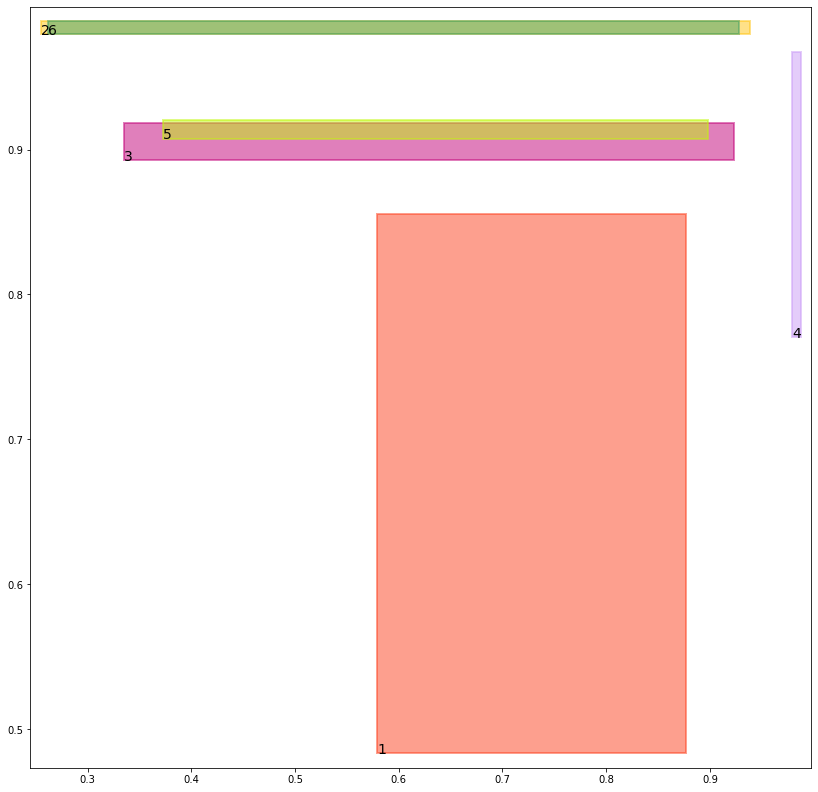

batch (tensor([[5, 3],
        [1, 2],
        [6, 2],
        [3, 5]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.32711029052734 -28.306203842163086 tensor(-54.2253875732421875) tensor(-18.2292861938476562)
tensor(2) -87.37670135498047 -30.863515853881836 tensor(-53.1379470825195312) tensor(-15.3187627792358398)
tensor(3) -84.51720428466797 -29.882692337036133 tensor(-54.8342590332031250) tensor(-16.5282707214355469)
tensor(4) -89.11943817138672 -31.679948806762695 tensor(-82.7517700195312500) tensor(-29.5279979705810547)
tensor(5) -83.32861328125 -29.36794662475586 tensor(-56.9207344055175781) tensor(-17.4144916534423828)
tensor(6) -86.87847137451172 -30.63878059387207 tensor(-53.2983283996582031) tensor(-15.3976230621337891)


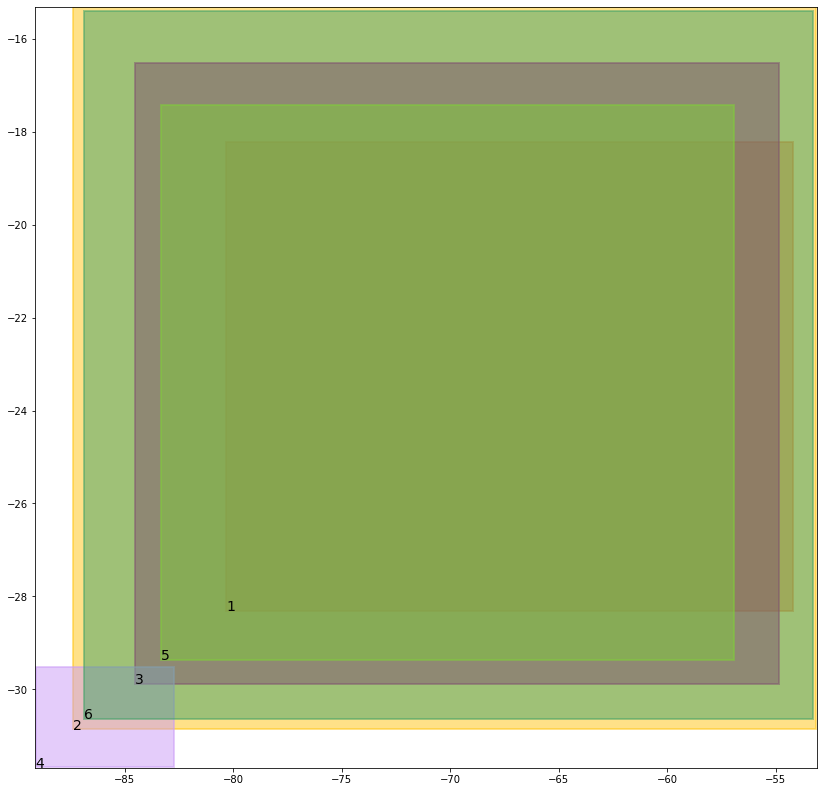

alignment data:
tensor(1) 0.5791801810264587 0.48342132568359375 tensor(0.8772608041763306) tensor(0.8555418252944946)
tensor(2) 0.2563469707965851 0.9798770546913147 tensor(0.9386078119277954) tensor(0.9883813261985779)
tensor(3) 0.3383861184120178 0.8933961391448975 tensor(0.9227493405342102) tensor(0.9202986955642700)
tensor(4) 0.9794752597808838 0.7705528736114502 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.36928191781044006 0.9078758955001831 tensor(0.8995921611785889) tensor(0.9179986119270325)
tensor(6) 0.2597302496433258 0.9793423414230347 tensor(0.9281936883926392) tensor(0.9884455204010010)


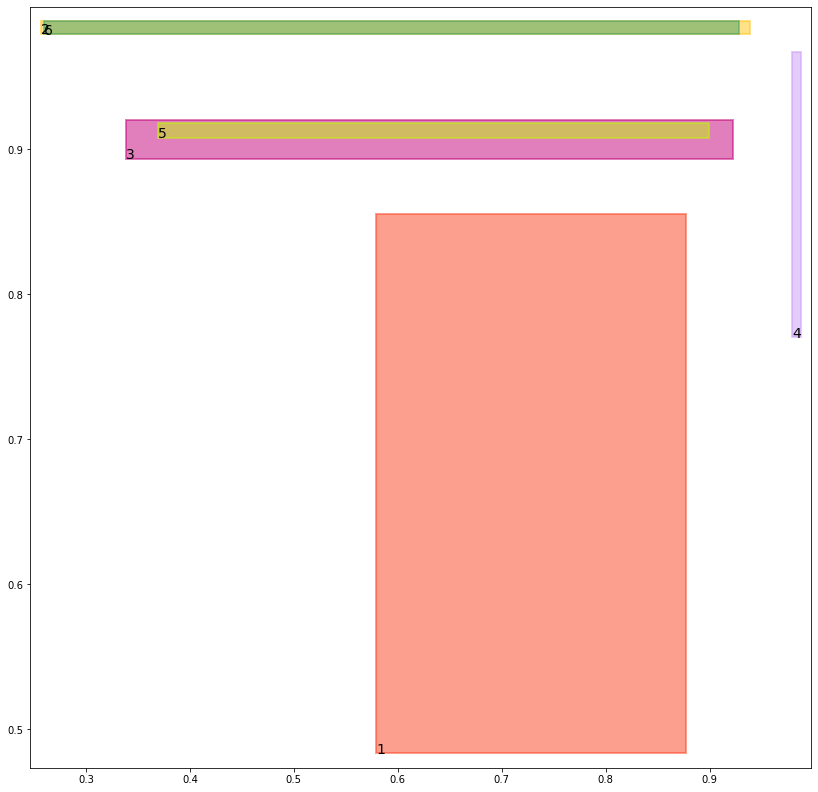

batch (tensor([[1, 2],
        [6, 2],
        [1, 3],
        [4, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.32715606689453 -28.30622673034668 tensor(-54.2254219055175781) tensor(-18.2292995452880859)
tensor(2) -87.27381134033203 -30.817609786987305 tensor(-53.7624130249023438) tensor(-15.6097011566162109)
tensor(3) -84.55941009521484 -29.895099639892578 tensor(-55.0049896240234375) tensor(-16.6029262542724609)
tensor(4) -89.1194839477539 -31.67997169494629 tensor(-82.7518234252929688) tensor(-29.5280170440673828)
tensor(5) -83.32579040527344 -29.375463485717773 tensor(-56.7668228149414062) tensor(-17.3422527313232422)
tensor(6) -87.01870727539062 -30.701416015625 tensor(-52.6568832397460938) tensor(-15.0942897796630859)


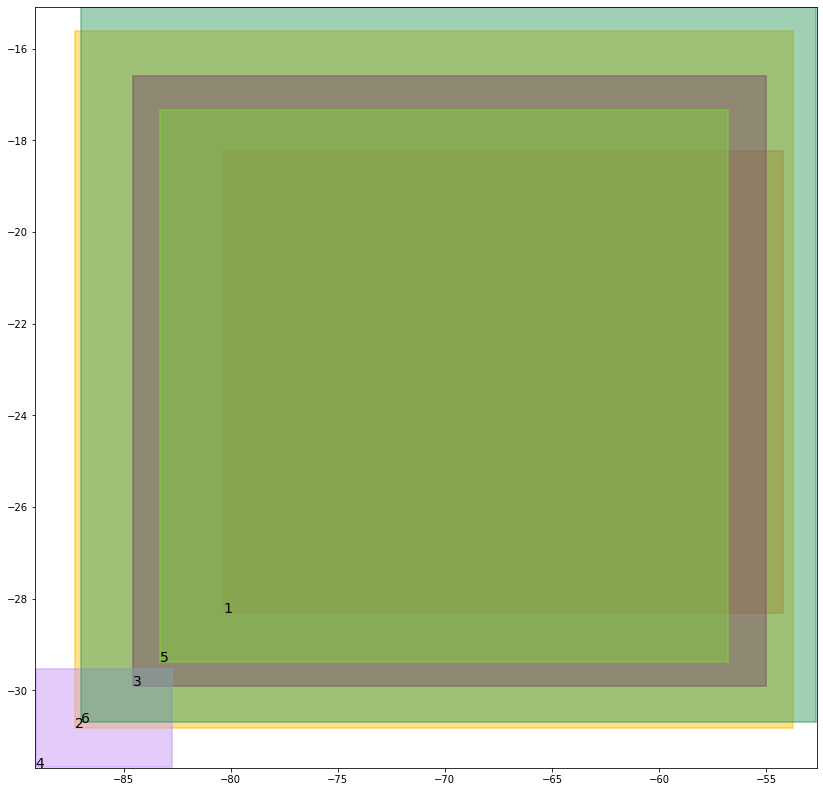

alignment data:
tensor(1) 0.5791802406311035 0.483421266078949 tensor(0.8772608637809753) tensor(0.8555418848991394)
tensor(2) 0.26801836490631104 0.9802426695823669 tensor(0.9365254044532776) tensor(0.9882871508598328)
tensor(3) 0.34116512537002563 0.8941460251808167 tensor(0.9224056601524353) tensor(0.9222396612167358)
tensor(4) 0.9794752597808838 0.7705528140068054 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3661949634552002 0.9082045555114746 tensor(0.9007455110549927) tensor(0.9161121249198914)
tensor(6) 0.24757513403892517 0.9791150093078613 tensor(0.9310381412506104) tensor(0.9885609745979309)


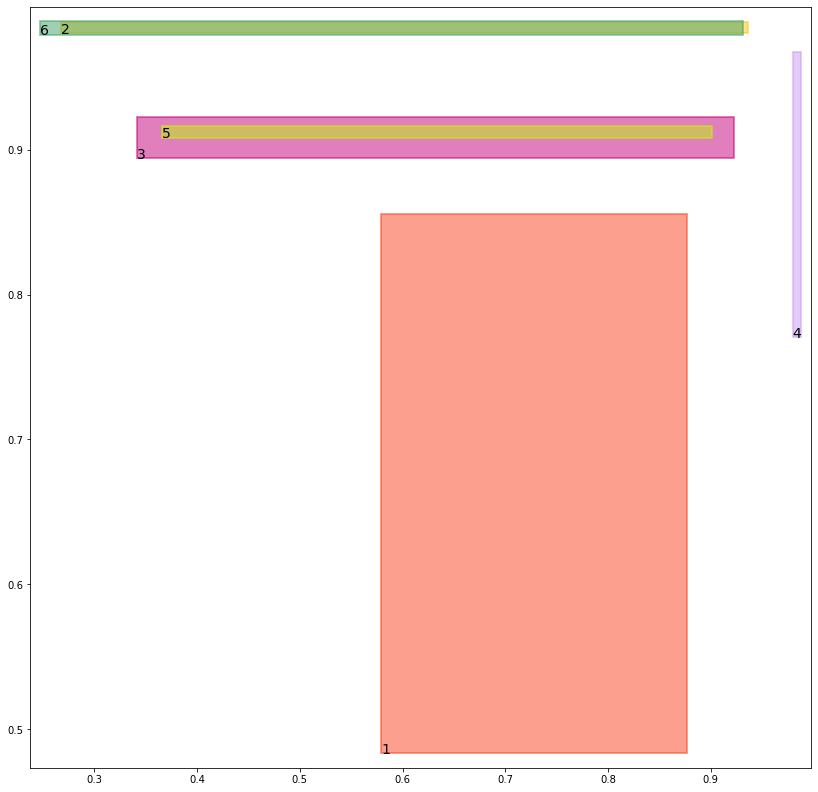

batch (tensor([[4, 5],
        [3, 5],
        [2, 6],
        [5, 3]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.32720184326172 -28.306245803833008 tensor(-54.2254486083984375) tensor(-18.2293148040771484)
tensor(2) -87.18170928955078 -30.77597999572754 tensor(-54.1453094482421875) tensor(-15.7851943969726562)
tensor(3) -84.52523040771484 -29.87842559814453 tensor(-55.4186935424804688) tensor(-16.7820701599121094)
tensor(4) -89.1195297241211 -31.679990768432617 tensor(-82.7518539428710938) tensor(-29.5280361175537109)
tensor(5) -83.41873931884766 -29.42085838317871 tensor(-56.3802642822265625) tensor(-17.1686248779296875)
tensor(6) -87.1368179321289 -30.75473976135254 tensor(-52.2723388671875000) tensor(-14.9114170074462891)


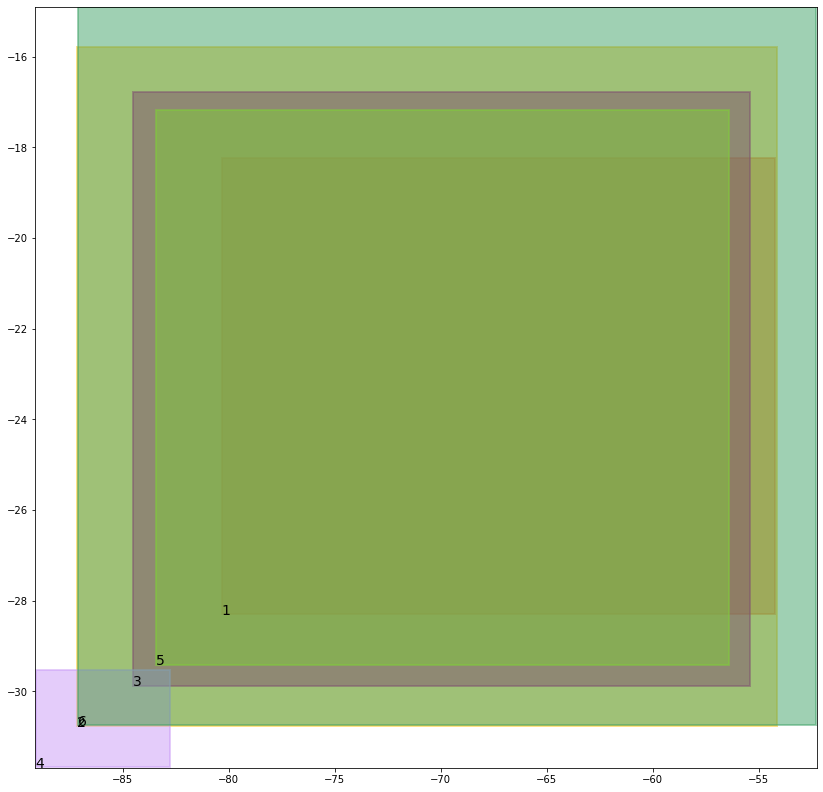

alignment data:
tensor(1) 0.5791803002357483 0.483421266078949 tensor(0.8772608637809753) tensor(0.8555418848991394)
tensor(2) 0.2752002477645874 0.9802829027175903 tensor(0.9345871210098267) tensor(0.9883181452751160)
tensor(3) 0.34769362211227417 0.8963197469711304 tensor(0.9211528301239014) tensor(0.9231289029121399)
tensor(4) 0.9794752597808838 0.7705527544021606 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3593601882457733 0.9074426889419556 tensor(0.9031658172607422) tensor(0.9153565764427185)
tensor(6) 0.24017149209976196 0.9791786670684814 tensor(0.9335122108459473) tensor(0.9885362386703491)


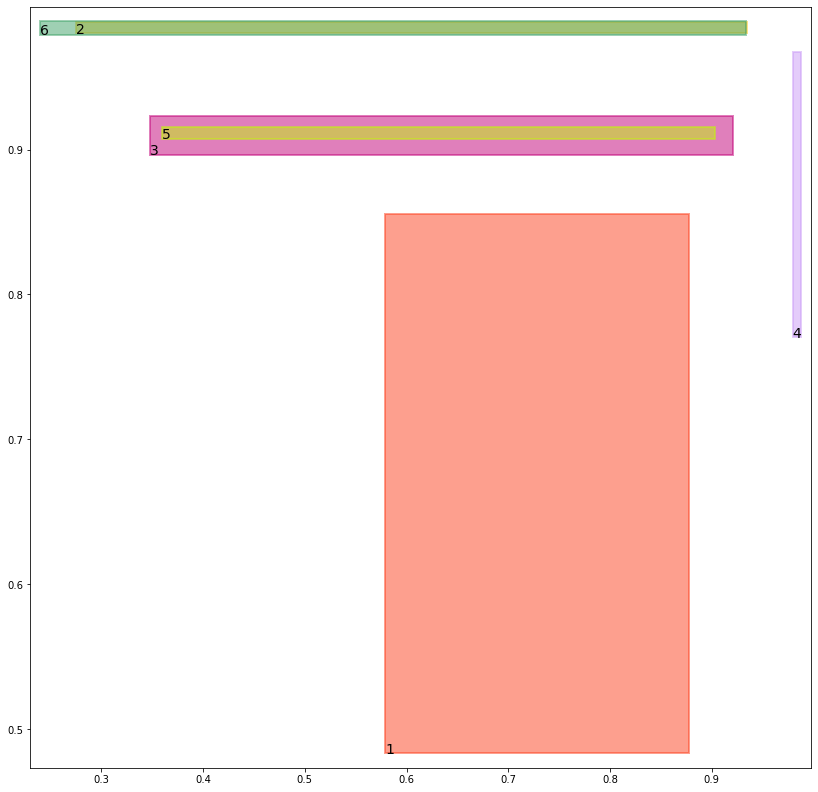

batch (tensor([[1, 3],
        [3, 5],
        [4, 6],
        [4, 5]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.32723236083984 -28.30626106262207 tensor(-54.2254714965820312) tensor(-18.2293262481689453)
tensor(2) -87.0962142944336 -30.737333297729492 tensor(-54.4967117309570312) tensor(-15.9462509155273438)
tensor(3) -84.49333953857422 -29.862951278686523 tensor(-55.7941207885742188) tensor(-16.9448490142822266)
tensor(4) -89.11956024169922 -31.68000602722168 tensor(-82.7518844604492188) tensor(-29.5280513763427734)
tensor(5) -83.5003890991211 -29.460847854614258 tensor(-56.0333862304687500) tensor(-17.0128688812255859)
tensor(6) -87.24015045166016 -30.8013858795166 tensor(-51.9317016601562500) tensor(-14.7494220733642578)


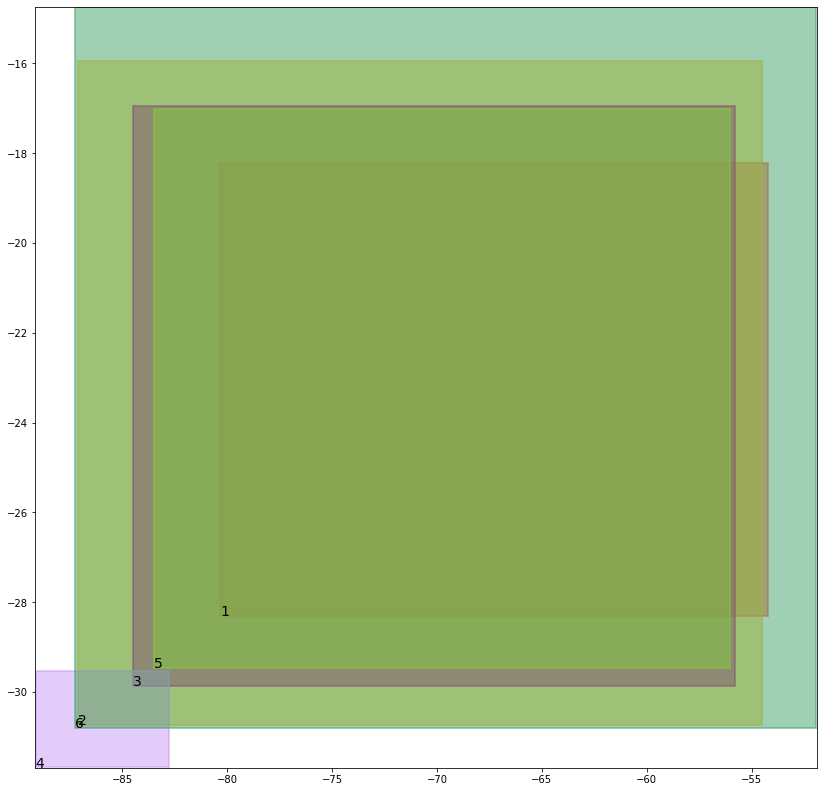

alignment data:
tensor(1) 0.5791804194450378 0.4834212064743042 tensor(0.8772609829902649) tensor(0.8555418848991394)
tensor(2) 0.28179171681404114 0.980319082736969 tensor(0.9327883720397949) tensor(0.9883460402488708)
tensor(3) 0.35364267230033875 0.8982499241828918 tensor(0.9200048446655273) tensor(0.9239245057106018)
tensor(4) 0.9794752597808838 0.7705526947975159 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3532326817512512 0.9067493081092834 tensor(0.9053074717521667) tensor(0.9146685004234314)
tensor(6) 0.2336127609014511 0.9792361855506897 tensor(0.9356768727302551) tensor(0.9885140061378479)


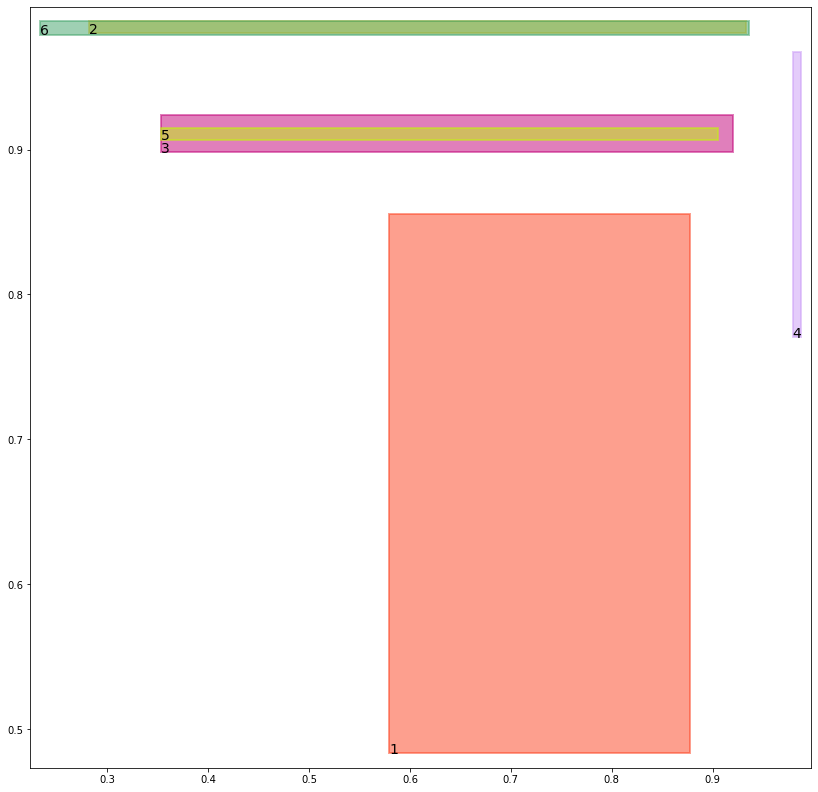

batch (tensor([[2, 6],
        [5, 3],
        [1, 2],
        [6, 2]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.32726287841797 -28.3062801361084 tensor(-54.2254943847656250) tensor(-18.2293357849121094)
tensor(2) -87.0599594116211 -30.72035026550293 tensor(-54.6066360473632812) tensor(-15.9979324340820312)
tensor(3) -84.39104461669922 -29.819332122802734 tensor(-56.1808547973632812) tensor(-17.1070995330810547)
tensor(4) -89.1196060180664 -31.680021286010742 tensor(-82.7519149780273438) tensor(-29.5280666351318359)
tensor(5) -83.66511535644531 -29.533227920532227 tensor(-55.6877365112304688) tensor(-16.8628482818603516)
tensor(6) -87.29291534423828 -30.82587242126465 tensor(-51.7972679138183594) tensor(-14.6839675903320312)


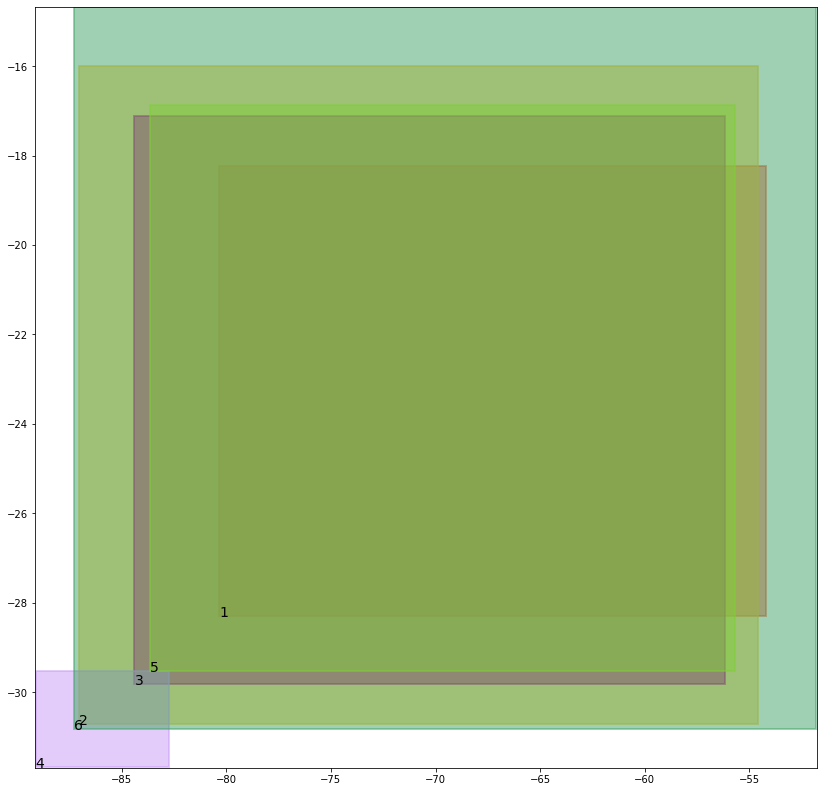

alignment data:
tensor(1) 0.5791804194450378 0.4834211468696594 tensor(0.8772609829902649) tensor(0.8555420041084290)
tensor(2) 0.2840060889720917 0.980066180229187 tensor(0.9319431781768799) tensor(0.9884855747222900)
tensor(3) 0.35913223028182983 0.9013431668281555 tensor(0.9179531335830688) tensor(0.9238373041152954)
tensor(4) 0.9794752597808838 0.7705526947975159 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3477369546890259 0.905003011226654 tensor(0.9084846973419189) tensor(0.9150597453117371)
tensor(6) 0.23085038363933563 0.9795571565628052 tensor(0.9368731975555420) tensor(0.9883610606193542)


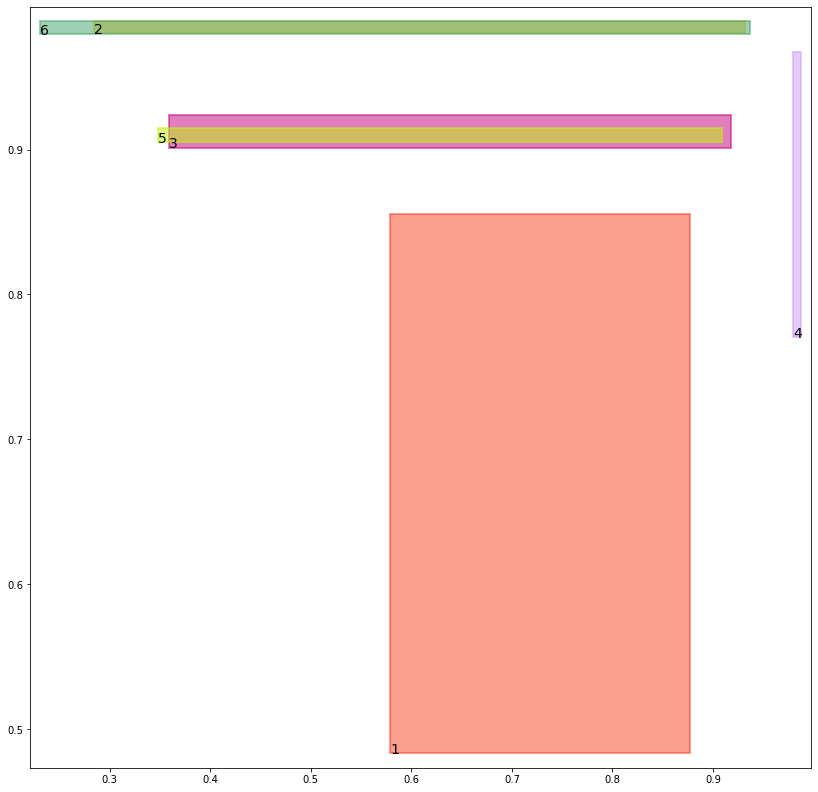

batch (tensor([[6, 2],
        [5, 3],
        [1, 2],
        [4, 5]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.32730865478516 -28.306291580200195 tensor(-54.2255172729492188) tensor(-18.2293453216552734)
tensor(2) -87.02154541015625 -30.703250885009766 tensor(-54.7063827514648438) tensor(-16.0448379516601562)
tensor(3) -84.18448638916016 -29.73228645324707 tensor(-56.5925292968750000) tensor(-17.2732334136962891)
tensor(4) -89.11963653564453 -31.68004035949707 tensor(-82.7519454956054688) tensor(-29.5280780792236328)
tensor(5) -83.941162109375 -29.648990631103516 tensor(-55.3228912353515625) tensor(-16.7118911743164062)
tensor(6) -87.34579467773438 -30.849424362182617 tensor(-51.6766891479492188) tensor(-14.6252727508544922)


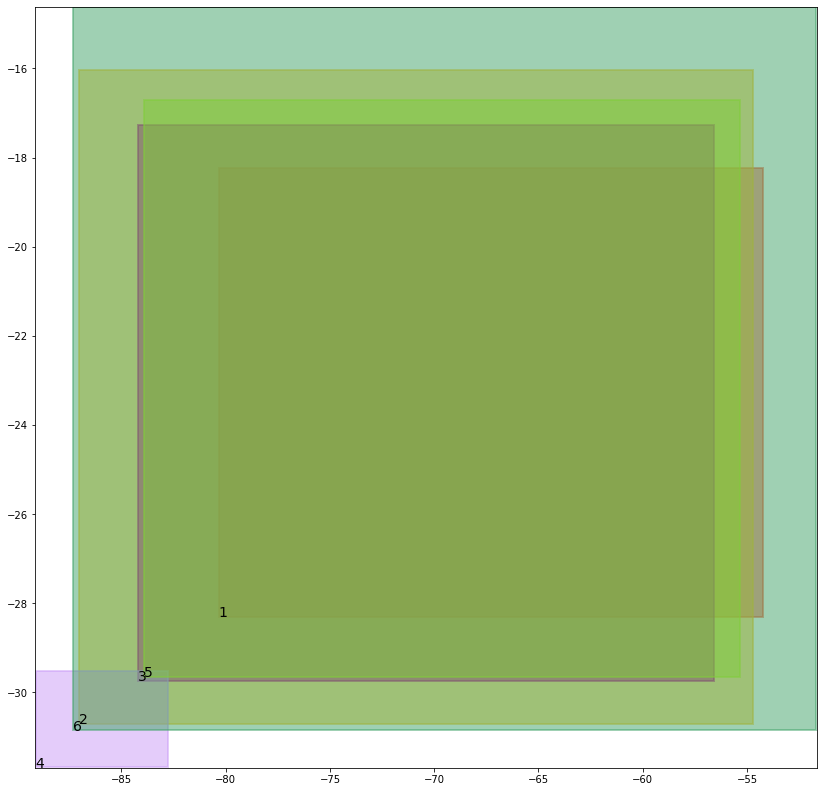

alignment data:
tensor(1) 0.5791804790496826 0.4834211468696594 tensor(0.8772609829902649) tensor(0.8555420041084290)
tensor(2) 0.2860164940357208 0.979835033416748 tensor(0.9311707019805908) tensor(0.9884418249130249)
tensor(3) 0.36420226097106934 0.9059742093086243 tensor(0.9144800901412964) tensor(0.9225498437881470)
tensor(4) 0.9794751405715942 0.7705526351928711 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3428057134151459 0.9016550183296204 tensor(0.9130462408065796) tensor(0.9169021844863892)
tensor(6) 0.22837409377098083 0.9798429608345032 tensor(0.9379364252090454) tensor(0.9884186387062073)


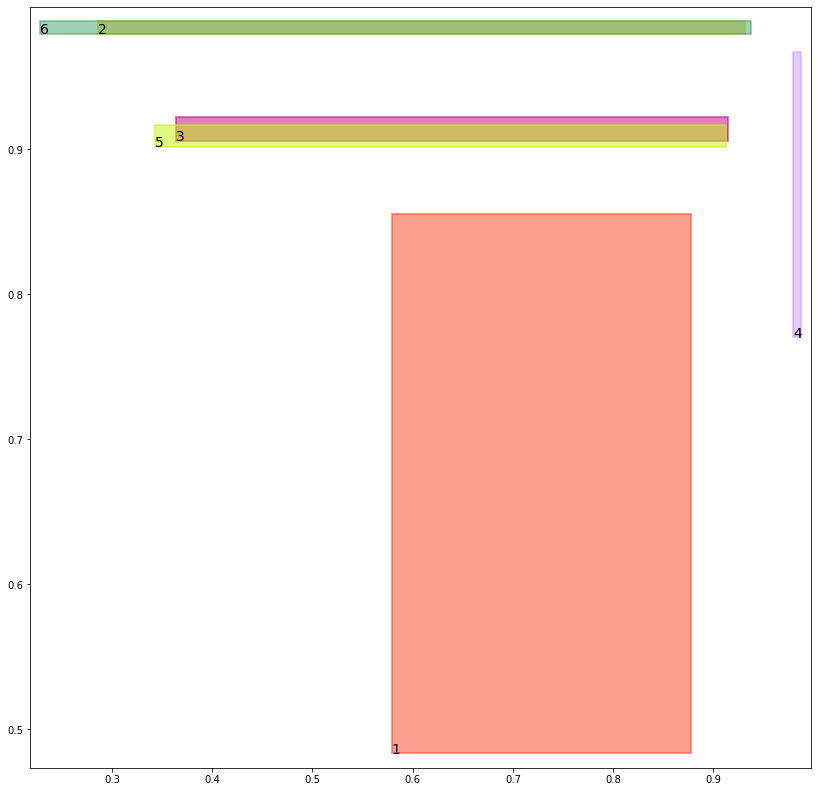

batch (tensor([[4, 6],
        [3, 5],
        [2, 6],
        [1, 3]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.32733154296875 -28.306303024291992 tensor(-54.2255401611328125) tensor(-18.2293567657470703)
tensor(2) -87.0472640991211 -30.715024948120117 tensor(-54.4913368225097656) tensor(-15.9471988677978516)
tensor(3) -83.9918441772461 -29.6510066986084 tensor(-56.5717315673828125) tensor(-17.2526302337646484)
tensor(4) -89.11966705322266 -31.6800479888916 tensor(-82.7519760131835938) tensor(-29.5280895233154297)
tensor(5) -84.18083190917969 -29.746946334838867 tensor(-55.3666992187500000) tensor(-16.7379703521728516)
tensor(6) -87.3442153930664 -30.8485050201416 tensor(-51.8040695190429688) tensor(-14.6843605041503906)


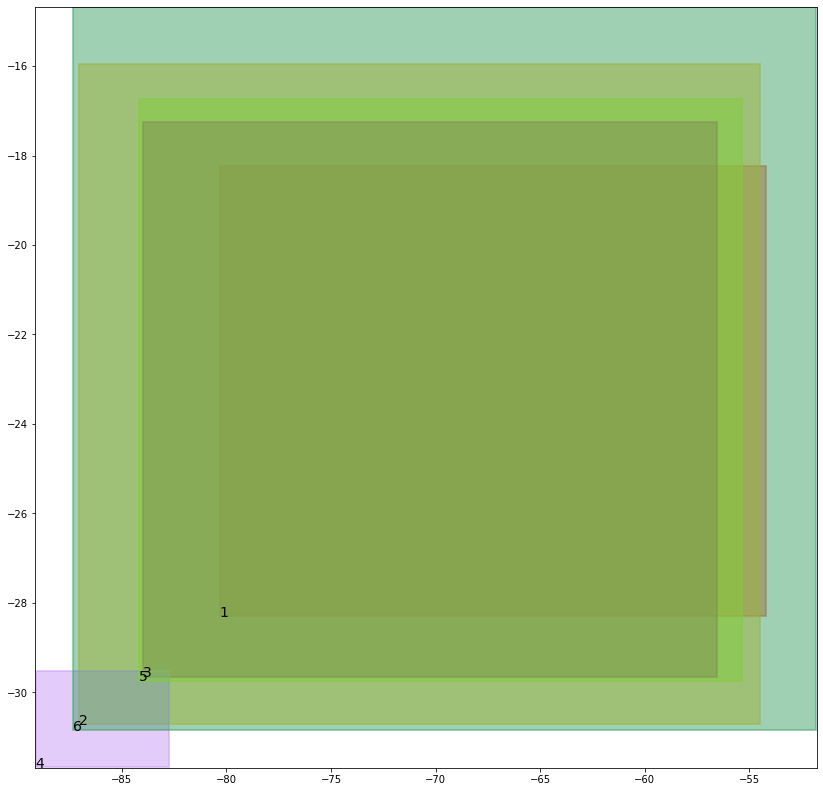

alignment data:
tensor(1) 0.5791805386543274 0.4834211468696594 tensor(0.8772609829902649) tensor(0.8555420041084290)
tensor(2) 0.28209125995635986 0.9796238541603088 tensor(0.9317314028739929) tensor(0.9884020686149597)
tensor(3) 0.36250951886177063 0.9082250595092773 tensor(0.9112278223037720) tensor(0.9213694334030151)
tensor(4) 0.9794751405715942 0.7705526351928711 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.34433287382125854 0.9004385471343994 tensor(0.9169719815254211) tensor(0.9185130596160889)
tensor(6) 0.2306567132472992 0.9801126718521118 tensor(0.9378744363784790) tensor(0.9884626269340515)


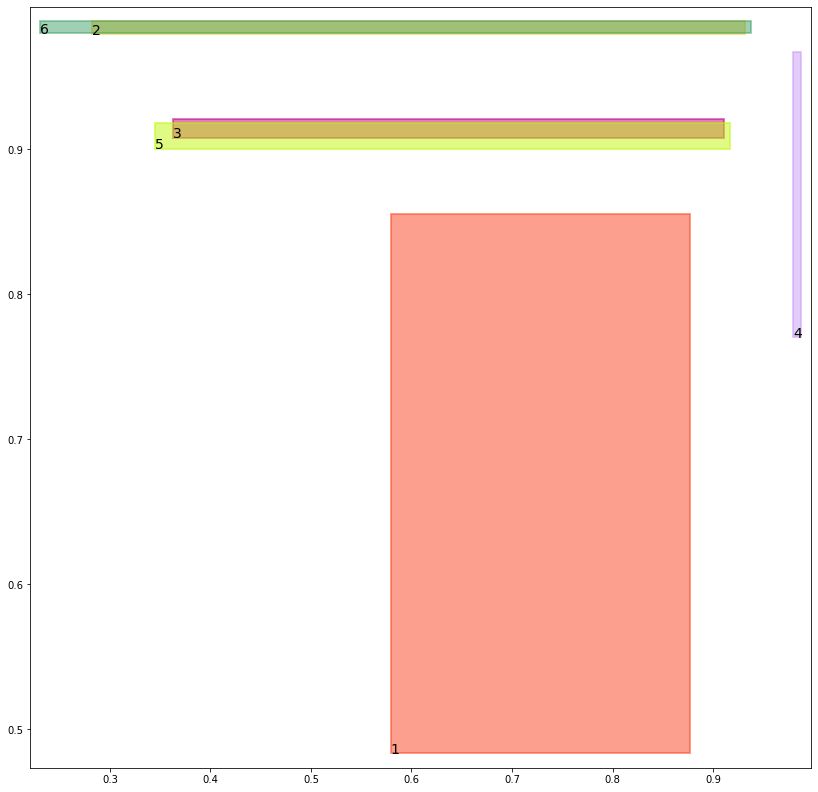

batch (tensor([[5, 3],
        [4, 5],
        [6, 2],
        [2, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.32735443115234 -28.306316375732422 tensor(-54.2255554199218750) tensor(-18.2293643951416016)
tensor(2) -87.11328125 -30.74439239501953 tensor(-54.1103668212890625) tensor(-15.7718257904052734)
tensor(3) -83.78617095947266 -29.567384719848633 tensor(-56.5523185729980469) tensor(-17.2339229583740234)
tensor(4) -89.11968994140625 -31.680063247680664 tensor(-82.7519912719726562) tensor(-29.5281009674072266)
tensor(5) -84.41870880126953 -29.840028762817383 tensor(-55.4060745239257812) tensor(-16.7614936828613281)
tensor(6) -87.3058853149414 -30.83168601989746 tensor(-52.0725364685058594) tensor(-14.8117675781250000)


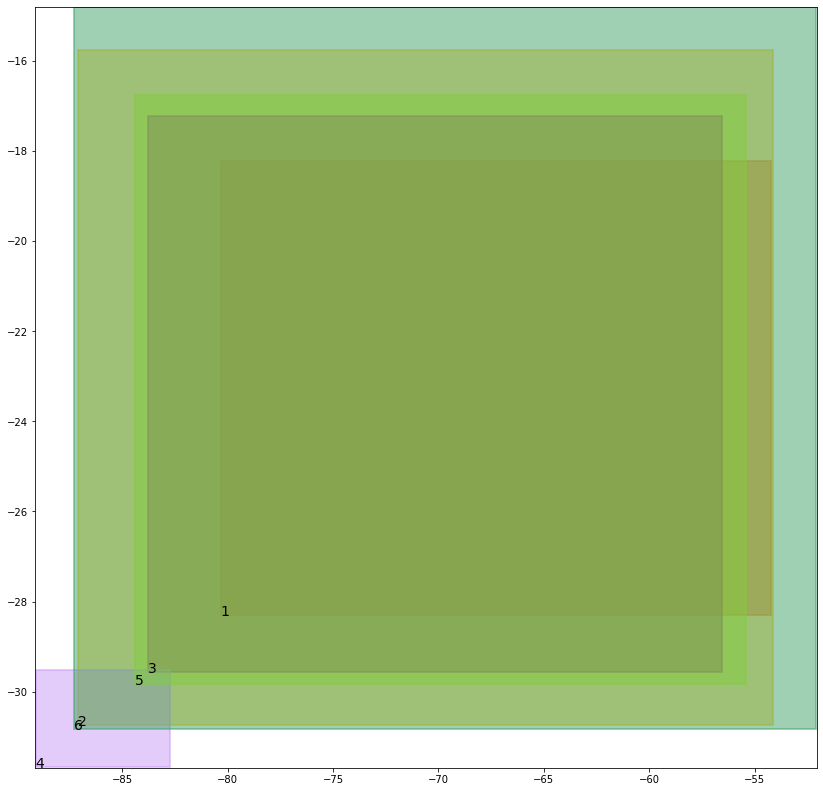

alignment data:
tensor(1) 0.5791806578636169 0.48342108726501465 tensor(0.8772610425949097) tensor(0.8555420041084290)
tensor(2) 0.27485498785972595 0.9797389507293701 tensor(0.9330543279647827) tensor(0.9884809255599976)
tensor(3) 0.36099156737327576 0.9102185964584351 tensor(0.9081913232803345) tensor(0.9194319248199463)
tensor(4) 0.9794751405715942 0.7705525755882263 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3457155227661133 0.8993279337882996 tensor(0.9203797578811646) tensor(0.9208607673645020)
tensor(6) 0.23579521477222443 0.9801188707351685 tensor(0.9371372461318970) tensor(0.9883676171302795)


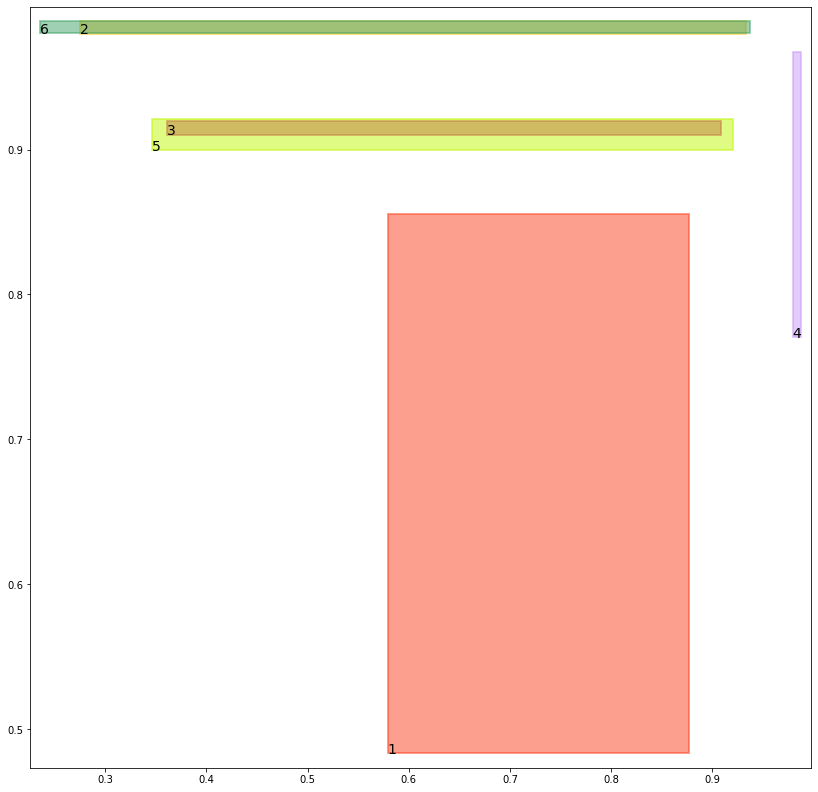

batch (tensor([[1, 2],
        [3, 5],
        [4, 6],
        [1, 3]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.3273696899414 -28.306324005126953 tensor(-54.2255630493164062) tensor(-18.2293701171875000)
tensor(2) -87.17191314697266 -30.770475387573242 tensor(-53.7714424133300781) tensor(-15.6158046722412109)
tensor(3) -83.85895538330078 -29.596147537231445 tensor(-55.7944908142089844) tensor(-16.8937664031982422)
tensor(4) -89.11971282958984 -31.680078506469727 tensor(-82.7520141601562500) tensor(-29.5281105041503906)
tensor(5) -84.40187072753906 -29.834718704223633 tensor(-56.1907463073730469) tensor(-17.1077098846435547)
tensor(6) -87.27091217041016 -30.816329956054688 tensor(-52.3186187744140625) tensor(-14.9285564422607422)


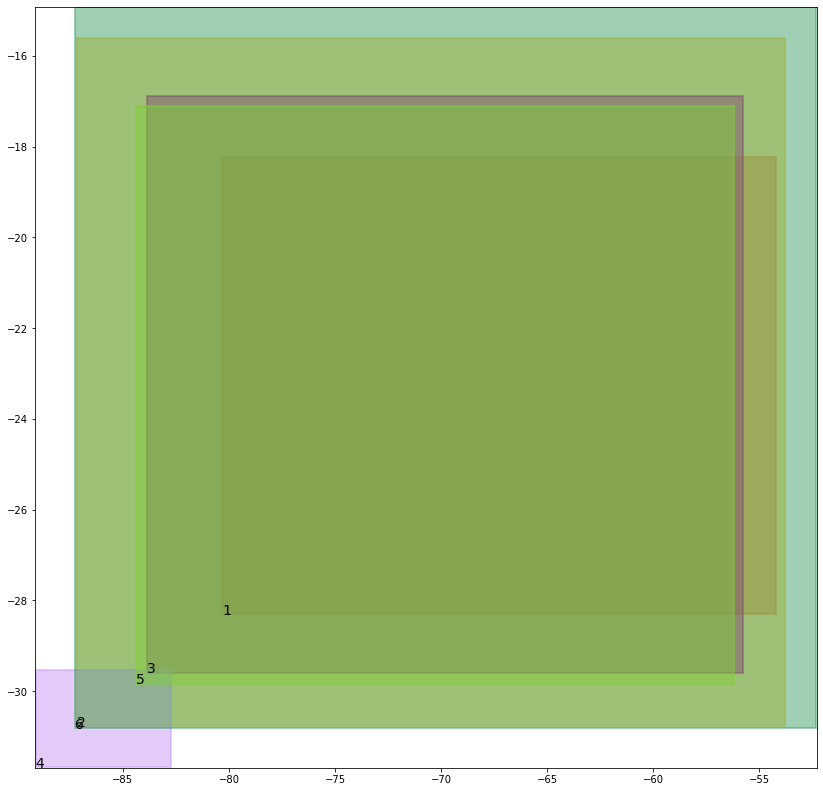

alignment data:
tensor(1) 0.5791806578636169 0.4834210276603699 tensor(0.8772610425949097) tensor(0.8555420041084290)
tensor(2) 0.26841697096824646 0.9798422455787659 tensor(0.9342291355133057) tensor(0.9885517358779907)
tensor(3) 0.3476199805736542 0.9086788892745972 tensor(0.9091510772705078) tensor(0.9202952384948730)
tensor(4) 0.9794751405715942 0.7705525755882263 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.35885557532310486 0.9021413922309875 tensor(0.9204329252243042) tensor(0.9202203154563904)
tensor(6) 0.24050553143024445 0.9801244735717773 tensor(0.9364641308784485) tensor(0.9882810711860657)


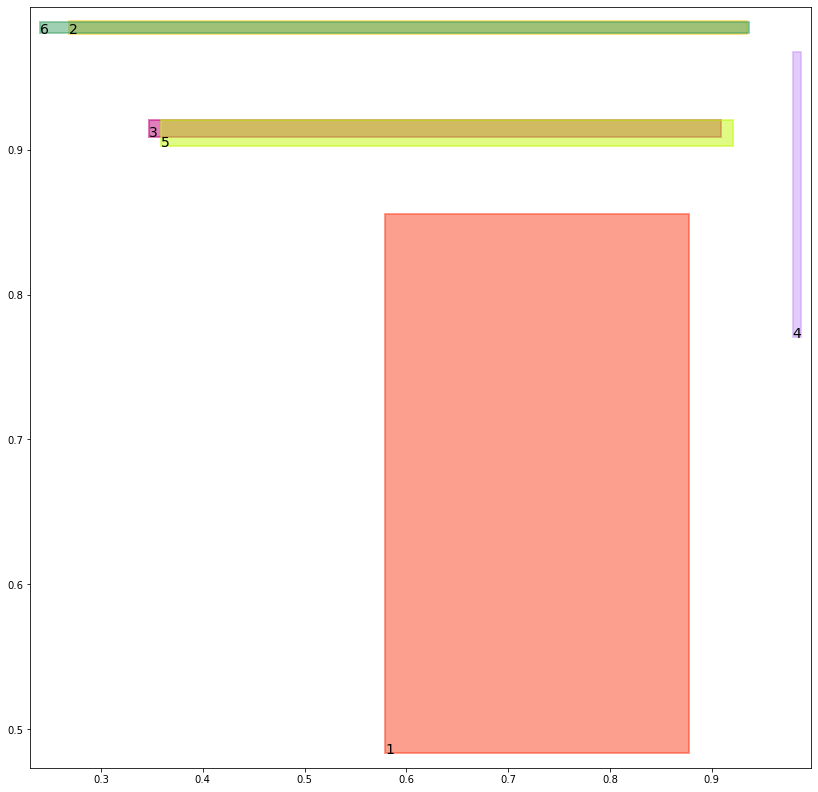

batch (tensor([[4, 5],
        [5, 3],
        [1, 3],
        [3, 5]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.32738494873047 -28.306333541870117 tensor(-54.2255744934082031) tensor(-18.2293758392333984)
tensor(2) -87.22408294677734 -30.79368019104004 tensor(-53.4706802368164062) tensor(-15.4764041900634766)
tensor(3) -83.96924591064453 -29.648279190063477 tensor(-55.3807983398437500) tensor(-16.7193202972412109)
tensor(4) -89.1197280883789 -31.680086135864258 tensor(-82.7520294189453125) tensor(-29.5281162261962891)
tensor(5) -84.35565185546875 -29.813390731811523 tensor(-56.6378326416015625) tensor(-17.2921009063720703)
tensor(6) -87.23900604248047 -30.802330017089844 tensor(-52.5438308715820312) tensor(-15.0354366302490234)


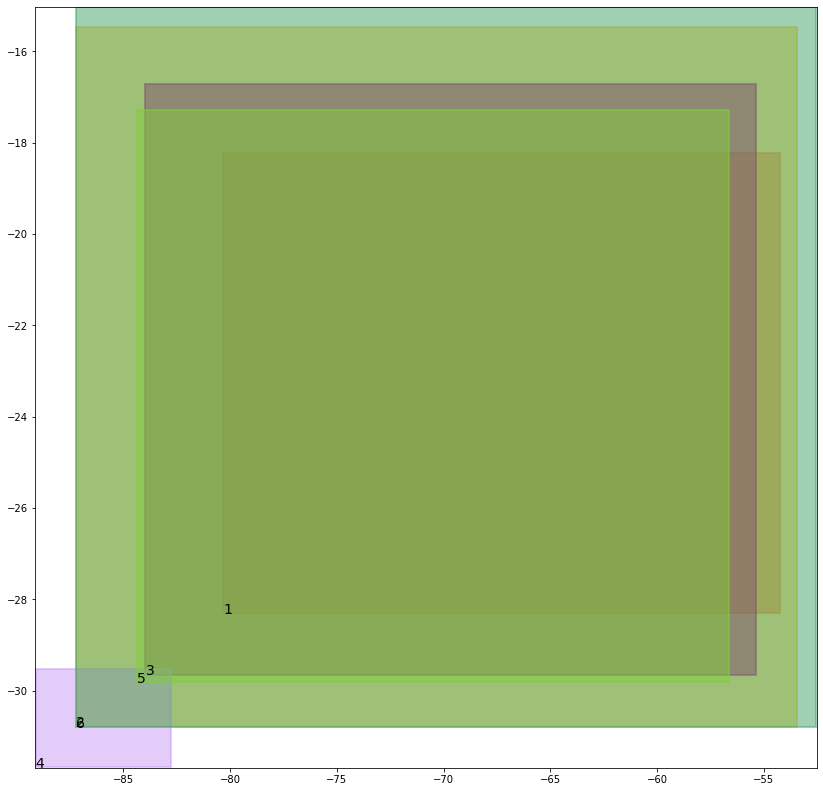

alignment data:
tensor(1) 0.5791807174682617 0.4834210276603699 tensor(0.8772610425949097) tensor(0.8555420637130737)
tensor(2) 0.26268309354782104 0.9799352288246155 tensor(0.9352738857269287) tensor(0.9886152744293213)
tensor(3) 0.34164297580718994 0.9055500030517578 tensor(0.9117842912673950) tensor(0.9197707176208496)
tensor(4) 0.9794751405715942 0.7705525755882263 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3648279309272766 0.9063646793365479 tensor(0.9190214276313782) tensor(0.9209690690040588)
tensor(6) 0.24481618404388428 0.9801295399665833 tensor(0.9358502626419067) tensor(0.9882023930549622)


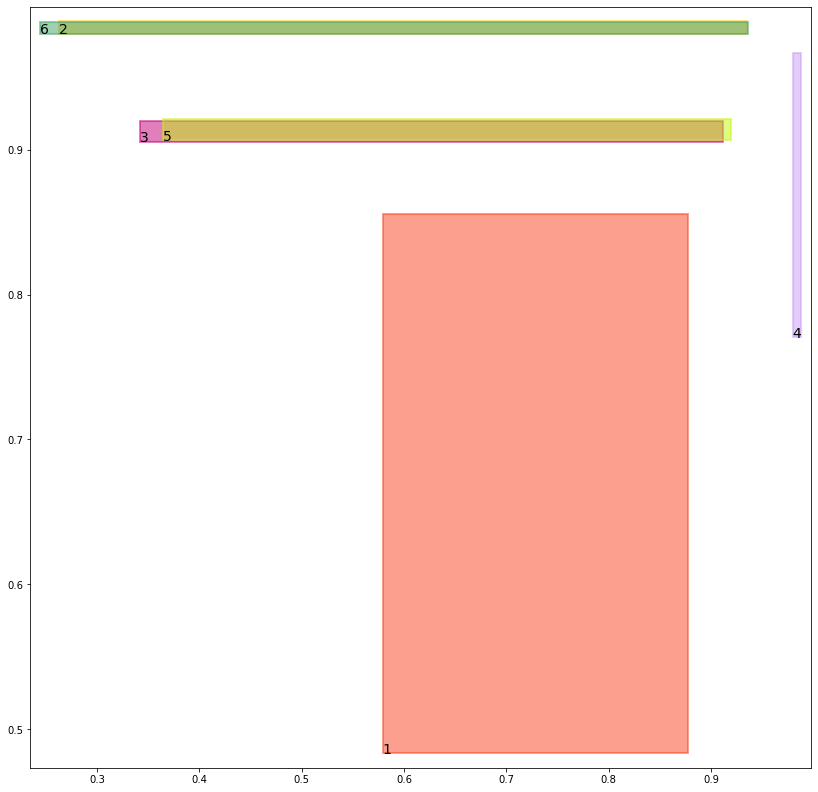

batch (tensor([[2, 6],
        [4, 6],
        [1, 2],
        [6, 2]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.32740783691406 -28.30634307861328 tensor(-54.2255859375000000) tensor(-18.2293834686279297)
tensor(2) -87.31904602050781 -30.83698844909668 tensor(-52.9534378051757812) tensor(-15.2281551361083984)
tensor(3) -84.06596374511719 -29.694063186645508 tensor(-55.0067901611328125) tensor(-16.5620040893554688)
tensor(4) -89.1197509765625 -31.68009376525879 tensor(-82.7520446777343750) tensor(-29.5281238555908203)
tensor(5) -84.31278228759766 -29.793663024902344 tensor(-57.0393371582031250) tensor(-17.4582748413085938)
tensor(6) -87.1635971069336 -30.767732620239258 tensor(-52.9991760253906250) tensor(-15.2534694671630859)


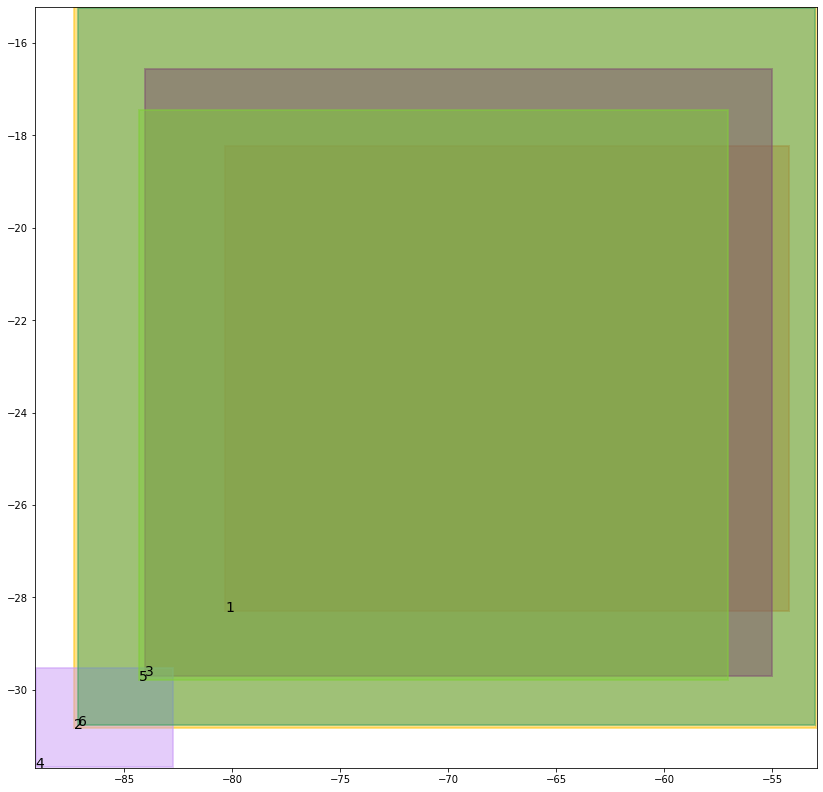

alignment data:
tensor(1) 0.5791807174682617 0.4834210276603699 tensor(0.8772610425949097) tensor(0.8555420637130737)
tensor(2) 0.2524655759334564 0.9804671406745911 tensor(0.9373239278793335) tensor(0.9885015487670898)
tensor(3) 0.3362858295440674 0.9026410579681396 tensor(0.9141038656234741) tensor(0.9192940592765808)
tensor(4) 0.9794751405715942 0.7705524563789368 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.37025976181030273 0.9100388288497925 tensor(0.9177266359329224) tensor(0.9216400980949402)
tensor(6) 0.25375258922576904 0.9797611236572266 tensor(0.9341939091682434) tensor(0.9883359074592590)


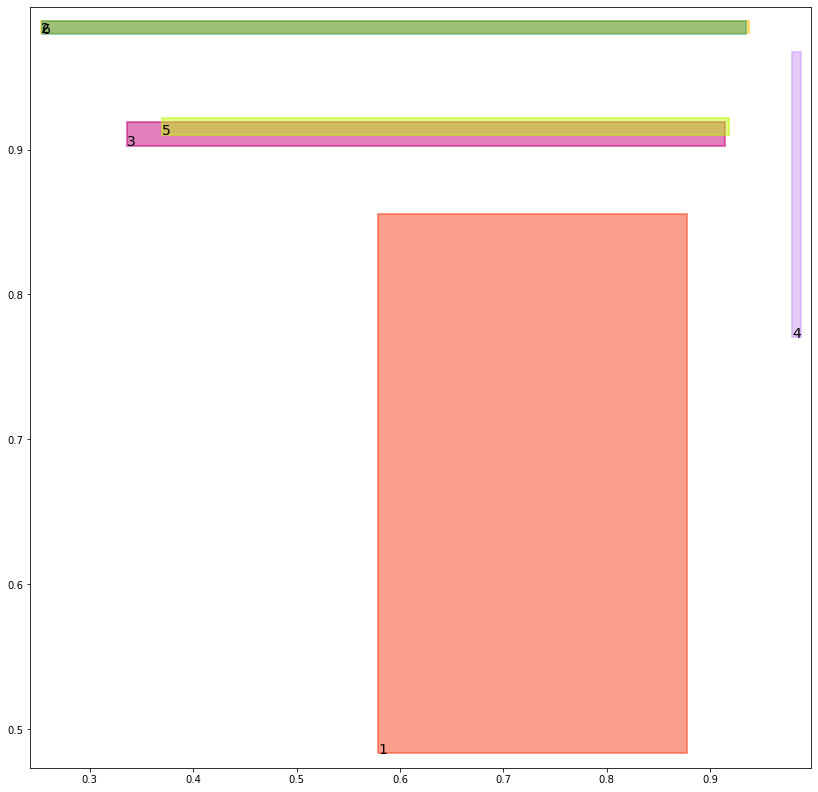

batch (tensor([[4, 5],
        [4, 6],
        [2, 6],
        [3, 5]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.32743072509766 -28.306352615356445 tensor(-54.2256011962890625) tensor(-18.2293872833251953)
tensor(2) -87.4023208618164 -30.874980926513672 tensor(-52.4846725463867188) tensor(-15.0054368972778320)
tensor(3) -84.26873779296875 -29.779207229614258 tensor(-54.6687011718750000) tensor(-16.4201240539550781)
tensor(4) -89.1197738647461 -31.68010139465332 tensor(-82.7520675659179688) tensor(-29.5281333923339844)
tensor(5) -84.15882110595703 -29.72825813293457 tensor(-57.4012832641601562) tensor(-17.6085681915283203)
tensor(6) -87.09375762939453 -30.735715866088867 tensor(-53.4320297241210938) tensor(-15.4586620330810547)


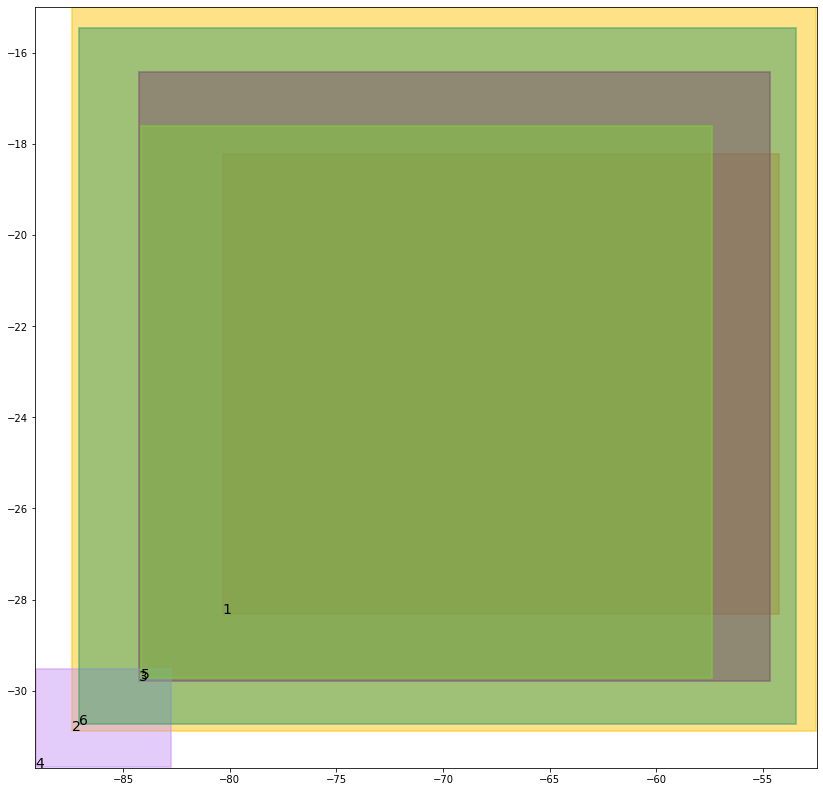

alignment data:
tensor(1) 0.5791807770729065 0.4834210276603699 tensor(0.8772610425949097) tensor(0.8555420637130737)
tensor(2) 0.24346387386322021 0.9805054068565369 tensor(0.9391236305236816) tensor(0.9883978962898254)
tensor(3) 0.3314818739891052 0.899944543838501 tensor(0.9177352786064148) tensor(0.9201757907867432)
tensor(4) 0.9794751405715942 0.7705524563789368 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3752143085002899 0.9132512211799622 tensor(0.9149824380874634) tensor(0.9209339618682861)
tensor(6) 0.26201170682907104 0.9798160791397095 tensor(0.9326627254486084) tensor(0.9884551763534546)


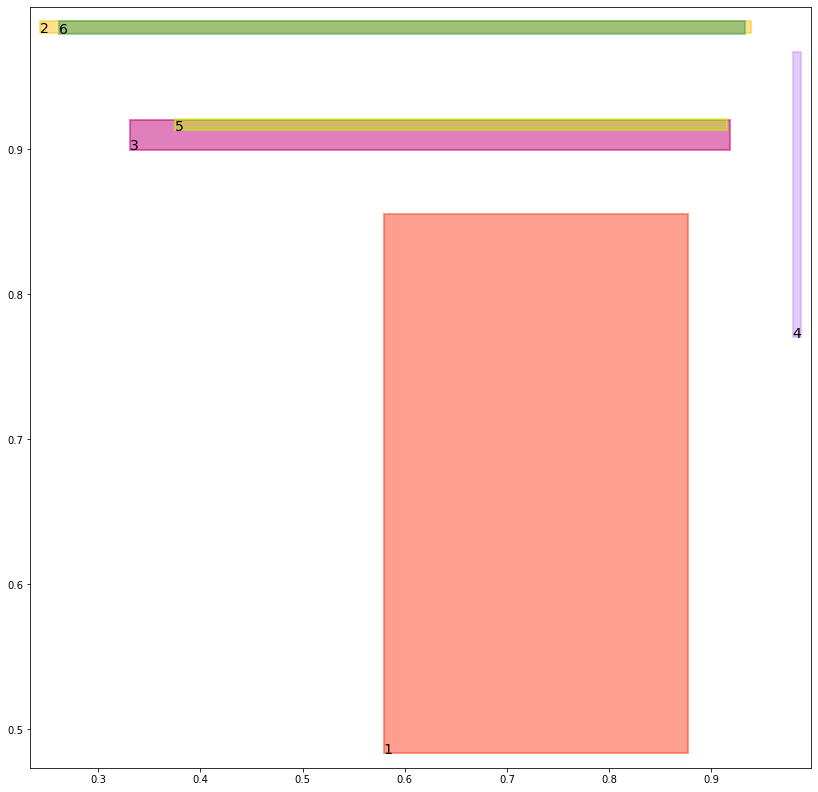

batch (tensor([[6, 2],
        [5, 3],
        [1, 3],
        [1, 2]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.32744598388672 -28.306360244750977 tensor(-54.2256126403808594) tensor(-18.2293910980224609)
tensor(2) -87.42625427246094 -30.886213302612305 tensor(-52.3197326660156250) tensor(-14.9269275665283203)
tensor(3) -84.37126922607422 -29.820051193237305 tensor(-54.7338829040527344) tensor(-16.4519348144531250)
tensor(4) -89.11978912353516 -31.68010902404785 tensor(-82.7520828247070312) tensor(-29.5281391143798828)
tensor(5) -84.09590911865234 -29.702905654907227 tensor(-57.3511428833007812) tensor(-17.5786991119384766)
tensor(6) -87.0868148803711 -30.73209571838379 tensor(-53.5447196960449219) tensor(-15.5116577148437500)


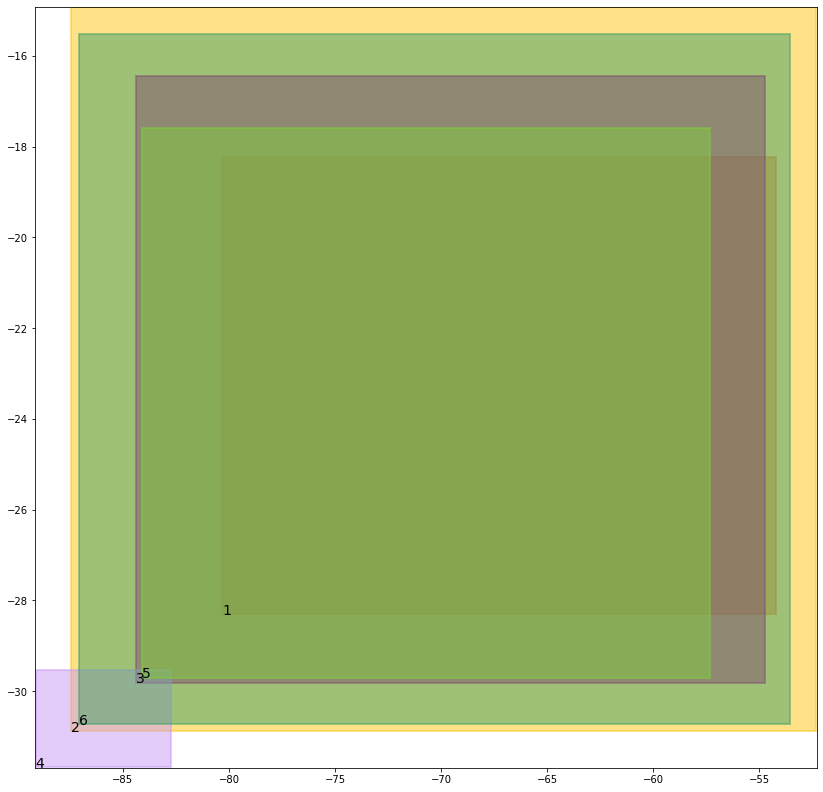

alignment data:
tensor(1) 0.5791807770729065 0.4834210276603699 tensor(0.8772611618041992) tensor(0.8555420637130737)
tensor(2) 0.24028030037879944 0.9805465340614319 tensor(0.9396840333938599) tensor(0.9883008003234863)
tensor(3) 0.3329322338104248 0.8995570540428162 tensor(0.9193714261054993) tensor(0.9209181070327759)
tensor(4) 0.9794751405715942 0.7705524563789368 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.37346360087394714 0.9146472811698914 tensor(0.9140855073928833) tensor(0.9202911257743835)
tensor(6) 0.26413610577583313 0.9798656105995178 tensor(0.9324493408203125) tensor(0.9885619878768921)


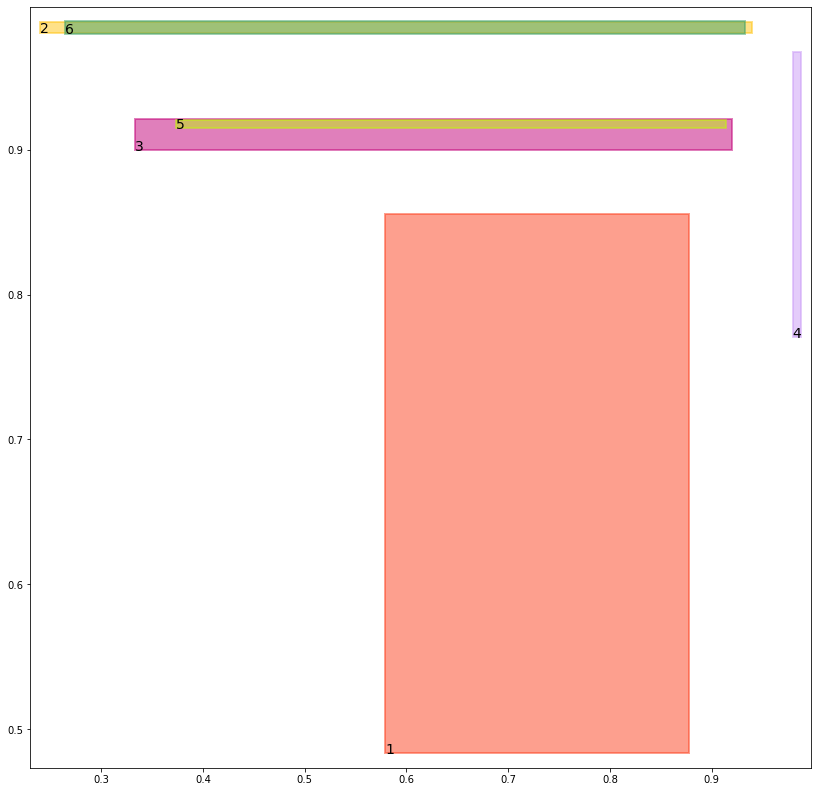

batch (tensor([[4, 6],
        [1, 2],
        [5, 3],
        [2, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.32746124267578 -28.306367874145508 tensor(-54.2256240844726562) tensor(-18.2293949127197266)
tensor(2) -87.4532470703125 -30.897945404052734 tensor(-52.1588745117187500) tensor(-14.8525810241699219)
tensor(3) -84.3495101928711 -29.81272315979004 tensor(-55.1640243530273438) tensor(-16.6408596038818359)
tensor(4) -89.11980438232422 -31.680116653442383 tensor(-82.7520904541015625) tensor(-29.5281467437744141)
tensor(5) -84.15911865234375 -29.727853775024414 tensor(-56.9372024536132812) tensor(-17.3895015716552734)
tensor(6) -87.07437896728516 -30.726961135864258 tensor(-53.6604576110839844) tensor(-15.5626735687255859)


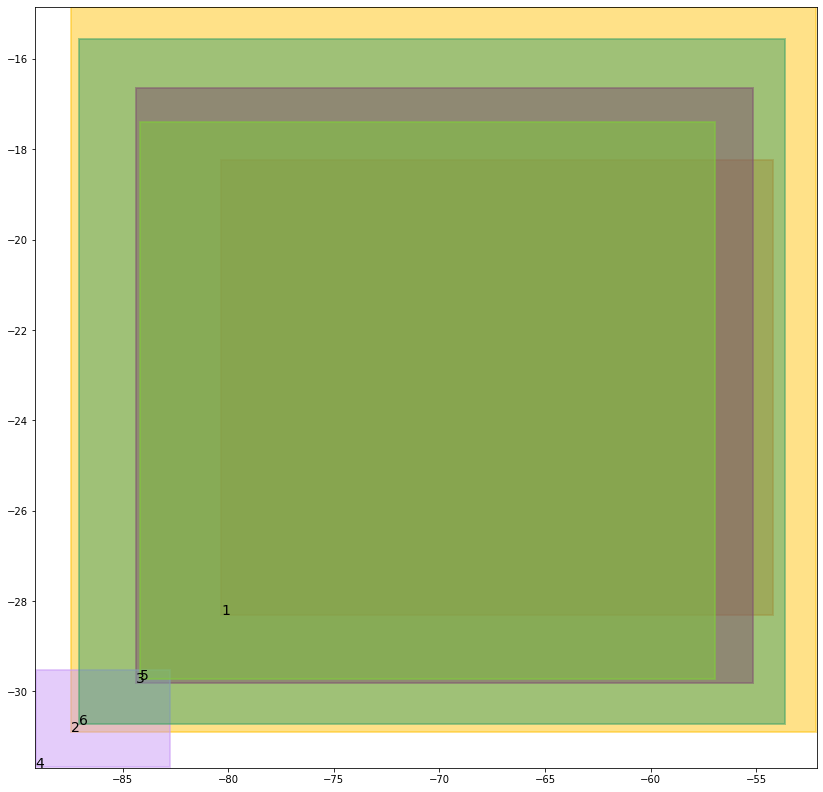

alignment data:
tensor(1) 0.5791808366775513 0.4834209680557251 tensor(0.8772611618041992) tensor(0.8555420637130737)
tensor(2) 0.23742884397506714 0.9801514148712158 tensor(0.9401862621307373) tensor(0.9883931279182434)
tensor(3) 0.3400338292121887 0.9012748003005981 tensor(0.9193322658538818) tensor(0.9202645421028137)
tensor(4) 0.9794751405715942 0.770552396774292 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3657604455947876 0.9144968390464783 tensor(0.9149137139320374) tensor(0.9210492372512817)
tensor(6) 0.2660684287548065 0.9802901148796082 tensor(0.9322551488876343) tensor(0.9884605407714844)


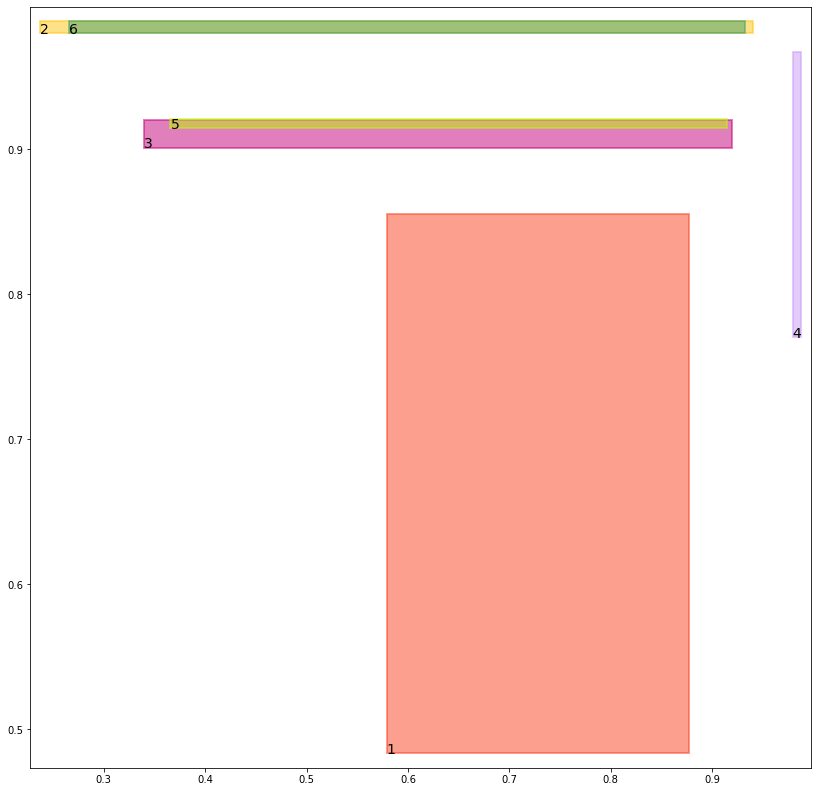

batch (tensor([[3, 5],
        [4, 5],
        [6, 2],
        [1, 3]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.32748413085938 -28.306371688842773 tensor(-54.2256393432617188) tensor(-18.2294006347656250)
tensor(2) -87.4287338256836 -30.88652992248535 tensor(-52.2712936401367188) tensor(-14.9054603576660156)
tensor(3) -84.36914825439453 -29.81903648376465 tensor(-55.5552215576171875) tensor(-16.8128452301025391)
tensor(4) -89.11981964111328 -31.680124282836914 tensor(-82.7521133422851562) tensor(-29.5281486511230469)
tensor(5) -84.17463684082031 -29.737873077392578 tensor(-56.5665512084960938) tensor(-17.2200965881347656)
tensor(6) -87.12027740478516 -30.748071670532227 tensor(-53.4647598266601562) tensor(-15.4717273712158203)


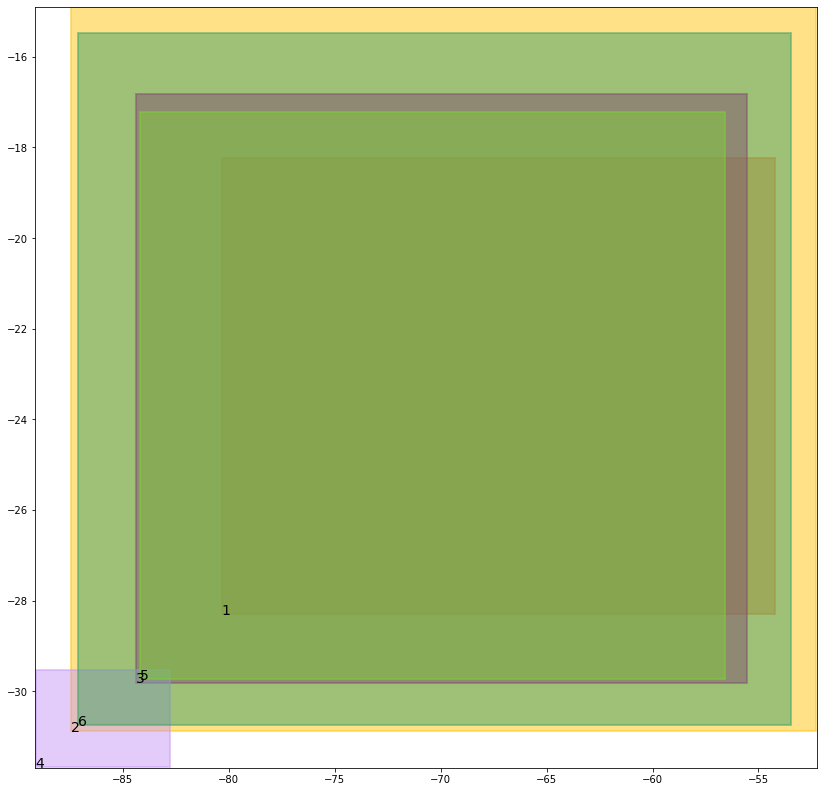

alignment data:
tensor(1) 0.579180896282196 0.4834209680557251 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.23952652513980865 0.9802467823028564 tensor(0.9396248459815979) tensor(0.9884721040725708)
tensor(3) 0.34651172161102295 0.9028039574623108 tensor(0.9192968606948853) tensor(0.9209676384925842)
tensor(4) 0.9794751405715942 0.770552396774292 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3588634729385376 0.9143612384796143 tensor(0.9156548380851746) tensor(0.9203987121582031)
tensor(6) 0.2623564600944519 0.9802999496459961 tensor(0.9332699179649353) tensor(0.9883682131767273)


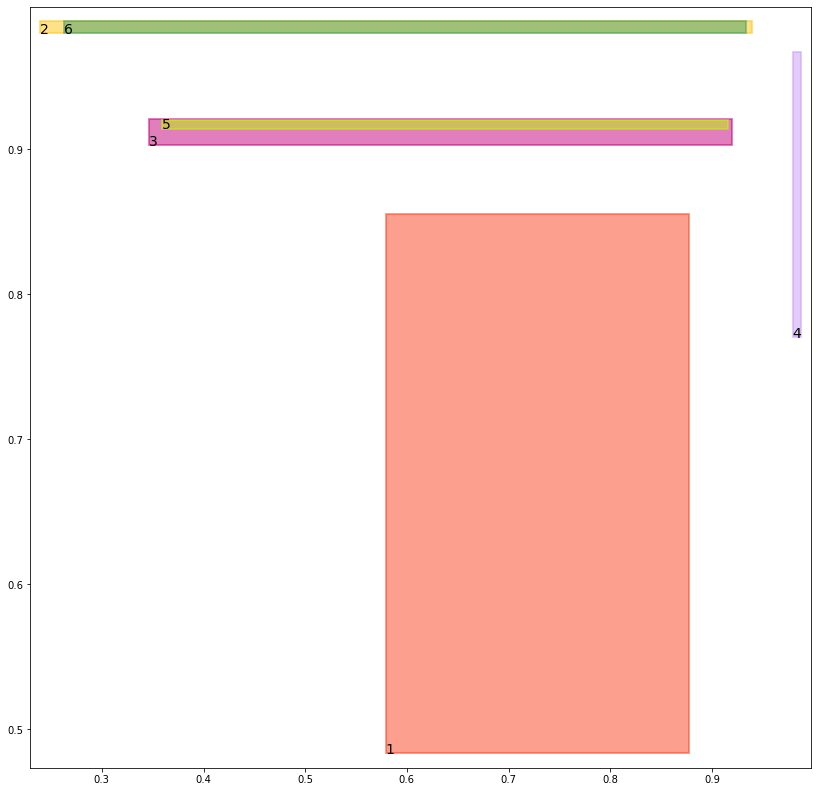

batch (tensor([[4, 6],
        [2, 6],
        [4, 5],
        [6, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.3274917602539 -28.30637550354004 tensor(-54.2256469726562500) tensor(-18.2294044494628906)
tensor(2) -87.35076141357422 -30.85191535949707 tensor(-52.6335678100585938) tensor(-15.0747404098510742)
tensor(3) -84.38675689697266 -29.82469367980957 tensor(-55.9106903076171875) tensor(-16.9692497253417969)
tensor(4) -89.11983489990234 -31.68012809753418 tensor(-82.7521286010742188) tensor(-29.5281562805175781)
tensor(5) -84.18839263916016 -29.746625900268555 tensor(-56.2343597412109375) tensor(-17.0682716369628906)
tensor(6) -87.2221908569336 -30.793413162231445 tensor(-53.0058288574218750) tensor(-15.2557258605957031)


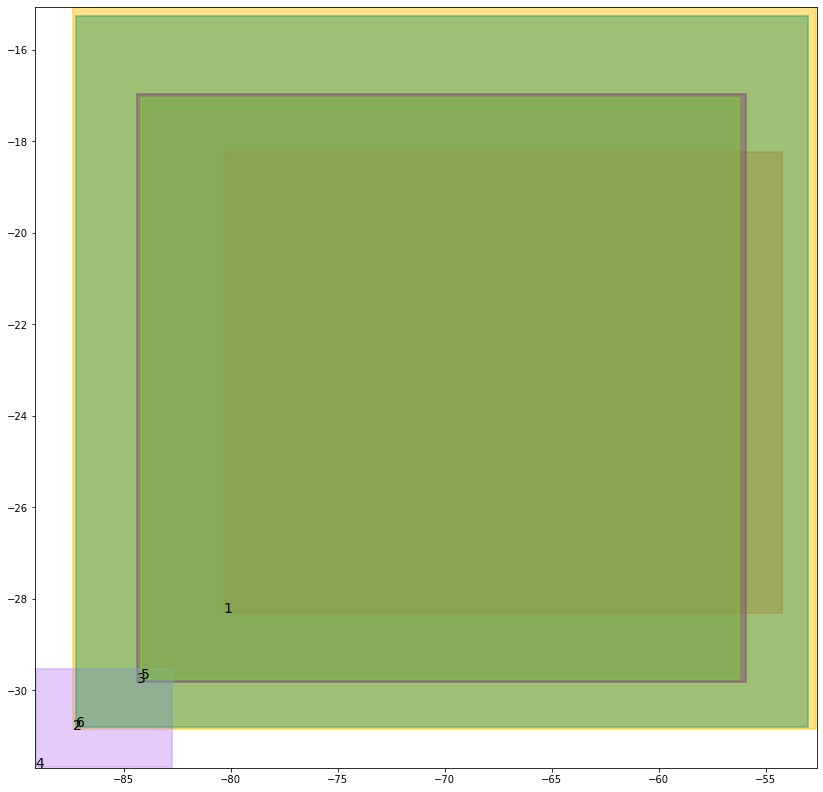

alignment data:
tensor(1) 0.579180896282196 0.4834209382534027 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.24615886807441711 0.9807741045951843 tensor(0.9380716085433960) tensor(0.9883624911308289)
tensor(3) 0.3524129092693329 0.9041671752929688 tensor(0.9192650318145752) tensor(0.9215978980064392)
tensor(4) 0.9794751405715942 0.770552396774292 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.35268276929855347 0.9142385721206665 tensor(0.9163193106651306) tensor(0.9198069572448730)
tensor(6) 0.253776878118515 0.9799367189407349 tensor(0.9353138208389282) tensor(0.9884884953498840)


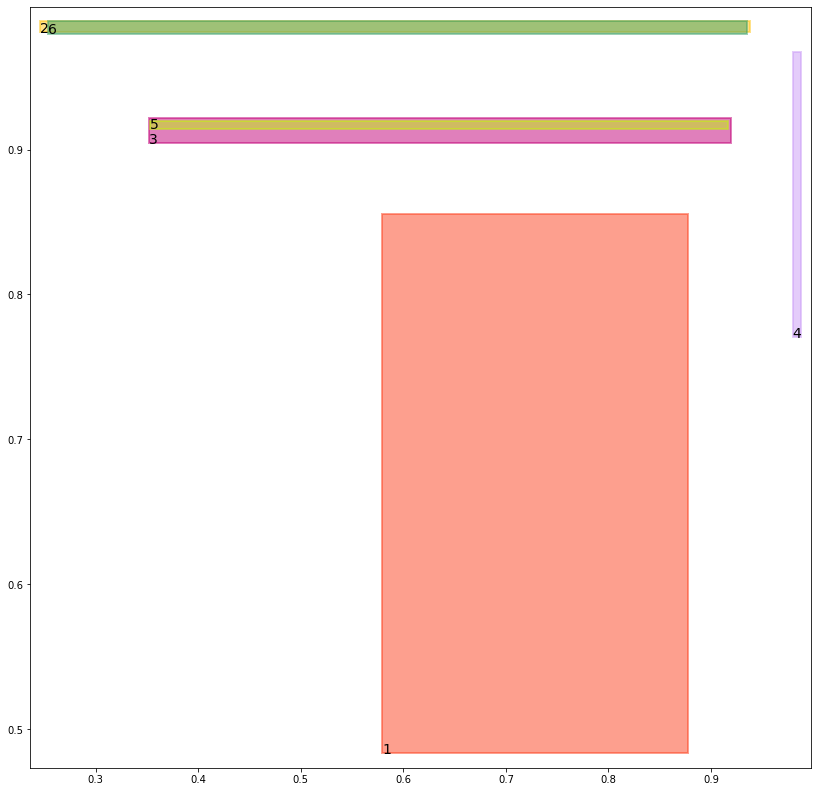

batch (tensor([[1, 2],
        [1, 3],
        [3, 5],
        [5, 3]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.32750701904297 -28.30638313293457 tensor(-54.2256546020507812) tensor(-18.2294063568115234)
tensor(2) -87.27874755859375 -30.819944381713867 tensor(-52.9659652709960938) tensor(-15.2301597595214844)
tensor(3) -84.28958129882812 -29.786027908325195 tensor(-56.6134910583496094) tensor(-17.2766304016113281)
tensor(4) -89.1198501586914 -31.680131912231445 tensor(-82.7521438598632812) tensor(-29.5281581878662109)
tensor(5) -84.31966400146484 -29.79920196533203 tensor(-55.5811271667480469) tensor(-16.7762336730957031)
tensor(6) -87.31179809570312 -30.83327293395996 tensor(-52.5994949340820312) tensor(-15.0645389556884766)


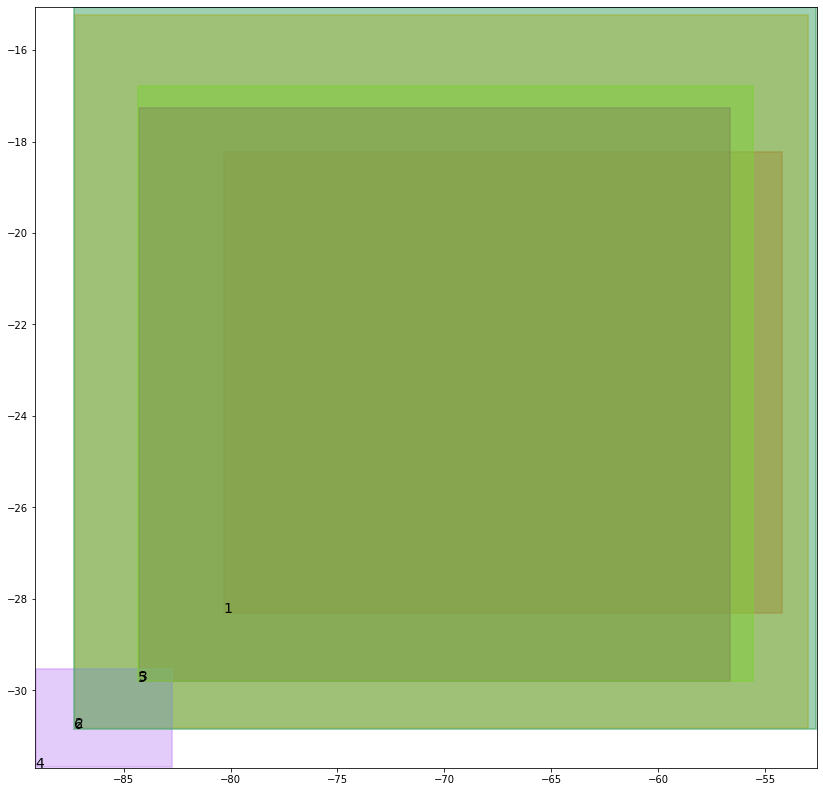

alignment data:
tensor(1) 0.579180896282196 0.4834209382534027 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.25225549936294556 0.9812384843826294 tensor(0.9366364479064941) tensor(0.9882624745368958)
tensor(3) 0.36386317014694214 0.9072388410568237 tensor(0.9177249670028687) tensor(0.9208758473396301)
tensor(4) 0.9794751405715942 0.770552396774292 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3412947952747345 0.9126724600791931 tensor(0.9184796810150146) tensor(0.9206520915031433)
tensor(6) 0.24618759751319885 0.9796028733253479 tensor(0.9371098279953003) tensor(0.9885962605476379)


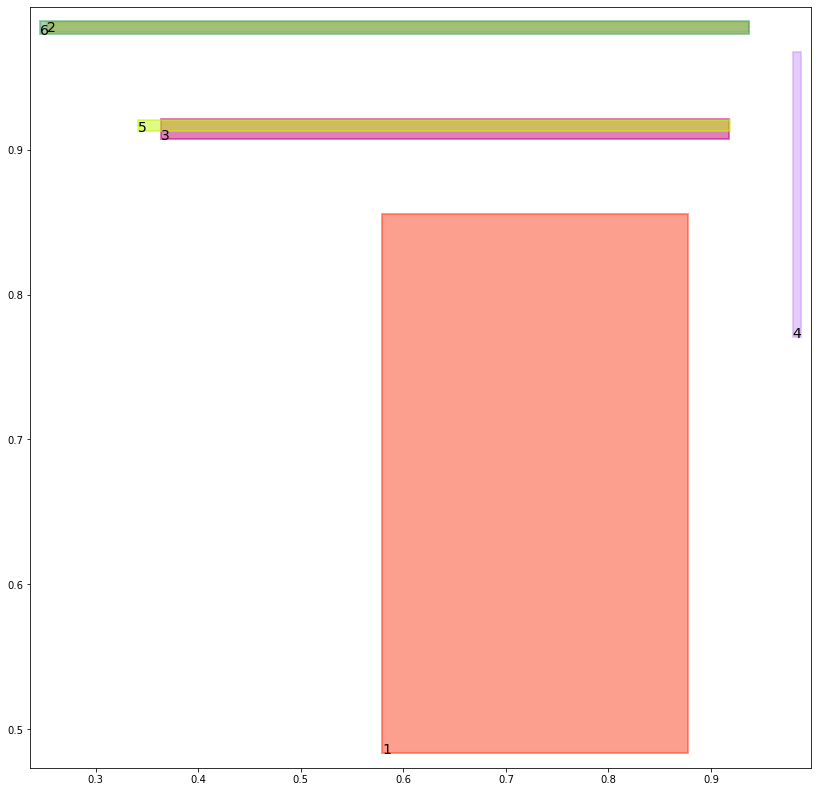

batch (tensor([[4, 6],
        [1, 3],
        [1, 2],
        [3, 5]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.32752227783203 -28.306386947631836 tensor(-54.2256622314453125) tensor(-18.2294101715087891)
tensor(2) -87.21240234375 -30.790481567382812 tensor(-53.2703895568847656) tensor(-15.3725795745849609)
tensor(3) -84.3494644165039 -29.812822341918945 tensor(-56.5960998535156250) tensor(-17.2553920745849609)
tensor(4) -89.11986541748047 -31.68013572692871 tensor(-82.7521438598632812) tensor(-29.5281658172607422)
tensor(5) -84.2863998413086 -29.78337287902832 tensor(-55.6135864257812500) tensor(-16.7979660034179688)
tensor(6) -87.3907699584961 -30.868406295776367 tensor(-52.2392272949218750) tensor(-14.8950805664062500)


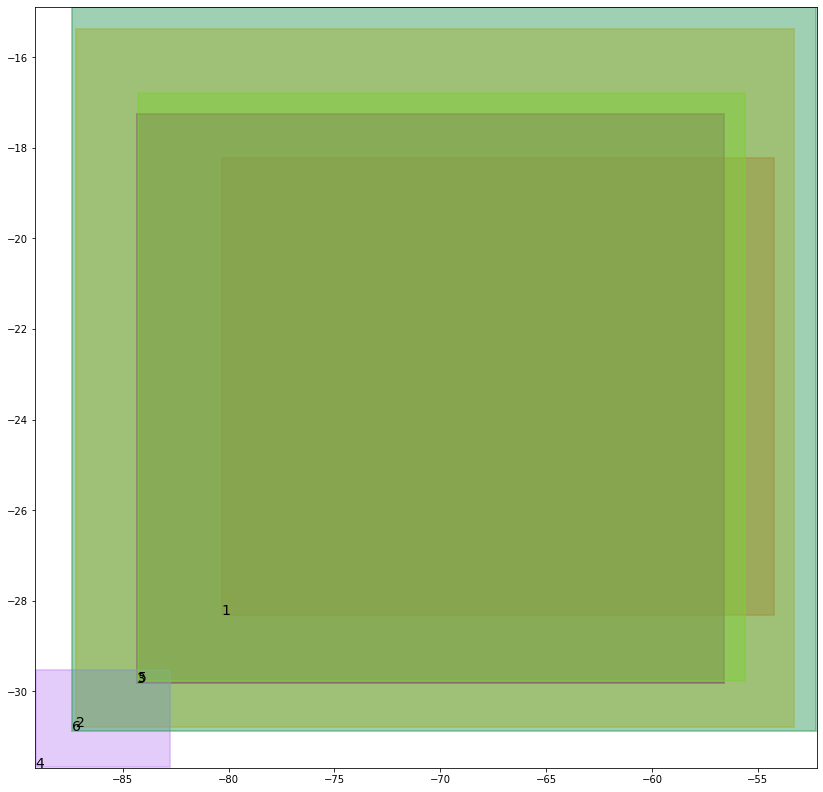

alignment data:
tensor(1) 0.579180896282196 0.4834209382534027 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.25784793496131897 0.9816486835479736 tensor(0.9353133440017700) tensor(0.9881715178489685)
tensor(3) 0.36197614669799805 0.9099372625350952 tensor(0.9193587303161621) tensor(0.9202182888984680)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3427101969718933 0.9112801551818848 tensor(0.9173533916473389) tensor(0.9213688373565674)
tensor(6) 0.23946477472782135 0.9792966246604919 tensor(0.9386920928955078) tensor(0.9886926412582397)


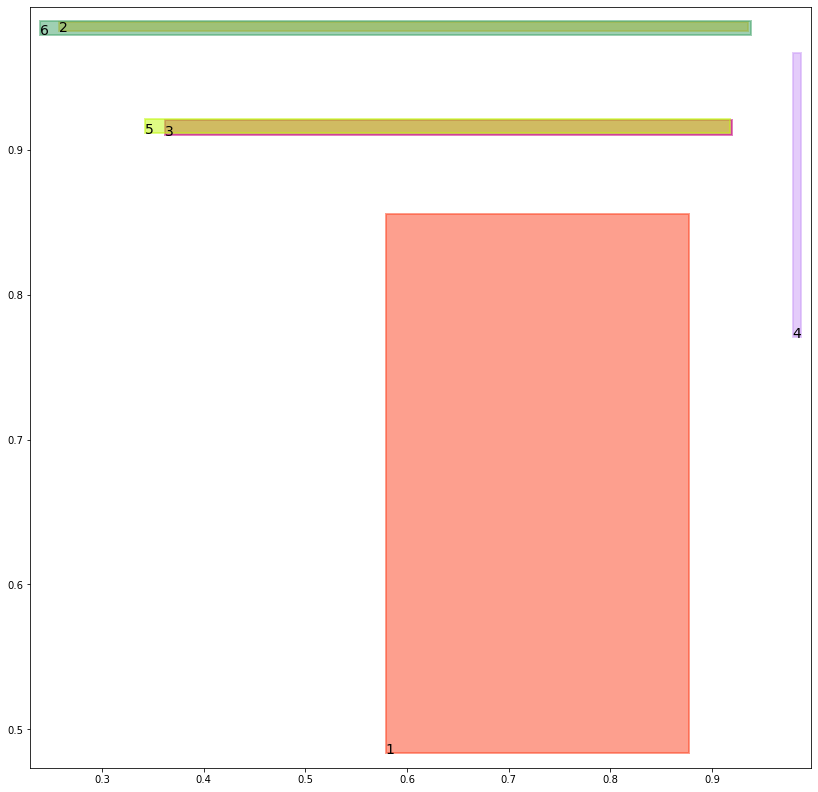

batch (tensor([[4, 5],
        [2, 6],
        [6, 2],
        [5, 3]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.32752227783203 -28.30638885498047 tensor(-54.2256622314453125) tensor(-18.2294139862060547)
tensor(2) -87.19324493408203 -30.781652450561523 tensor(-53.3589820861816406) tensor(-15.4140853881835938)
tensor(3) -84.35468292236328 -29.816625595092773 tensor(-56.6125679016113281) tensor(-17.2459125518798828)
tensor(4) -89.11986541748047 -31.680143356323242 tensor(-82.7521514892578125) tensor(-29.5281677246093750)
tensor(5) -84.30628967285156 -29.789663314819336 tensor(-55.6104965209960938) tensor(-16.8079395294189453)
tensor(6) -87.42438507080078 -30.883760452270508 tensor(-52.0949249267578125) tensor(-14.8265781402587891)


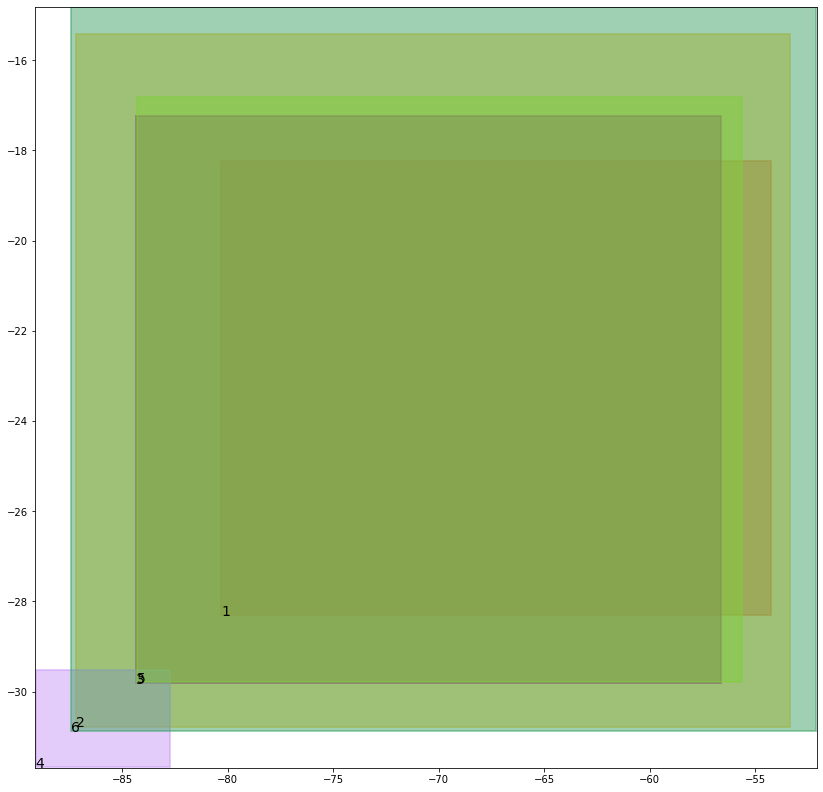

alignment data:
tensor(1) 0.579180896282196 0.4834209382534027 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.2594820559024811 0.9817565679550171 tensor(0.9348866939544678) tensor(0.9882147312164307)
tensor(3) 0.3602820336818695 0.9134042859077454 tensor(0.9198385477066040) tensor(0.9196183681488037)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.34399116039276123 0.9089634418487549 tensor(0.9173577427864075) tensor(0.9220111966133118)
tensor(6) 0.23670031130313873 0.9792971014976501 tensor(0.9394211173057556) tensor(0.9886465668678284)


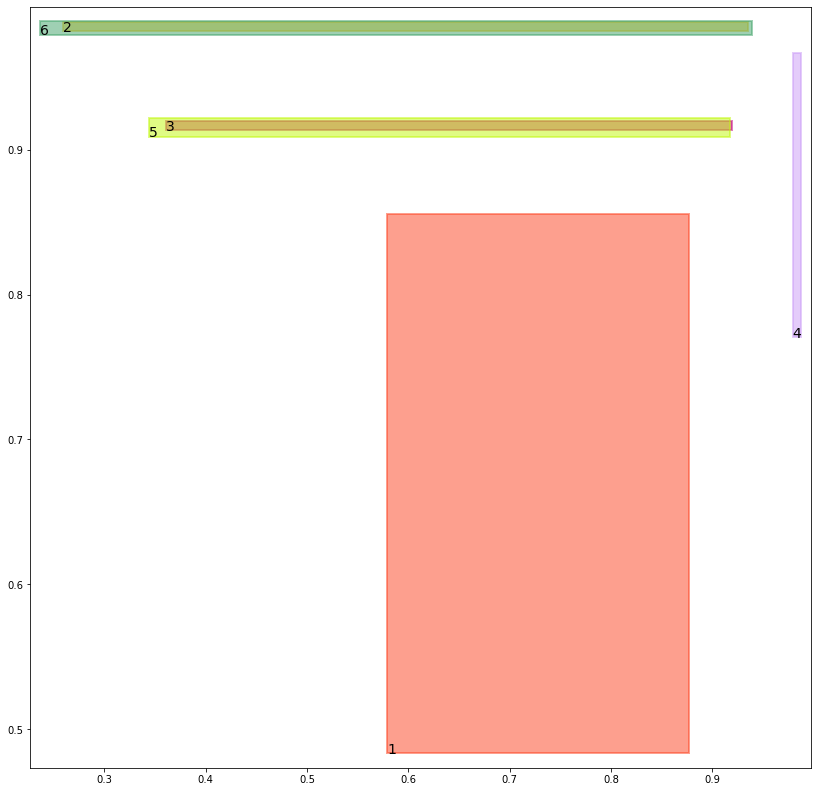

batch (tensor([[3, 5],
        [5, 3],
        [1, 2],
        [2, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.32752227783203 -28.306394577026367 tensor(-54.2256698608398438) tensor(-18.2294178009033203)
tensor(2) -87.2176284790039 -30.791879653930664 tensor(-53.2502441406250000) tensor(-15.3632774353027344)
tensor(3) -84.33899688720703 -29.809127807617188 tensor(-56.3817672729492188) tensor(-17.1301765441894531)
tensor(4) -89.11986541748047 -31.680147171020508 tensor(-82.7521591186523438) tensor(-29.5281715393066406)
tensor(5) -84.3460464477539 -29.807424545288086 tensor(-55.8456878662109375) tensor(-16.9209098815917969)
tensor(6) -87.41840362548828 -30.88189125061035 tensor(-52.1398544311523438) tensor(-14.8464870452880859)


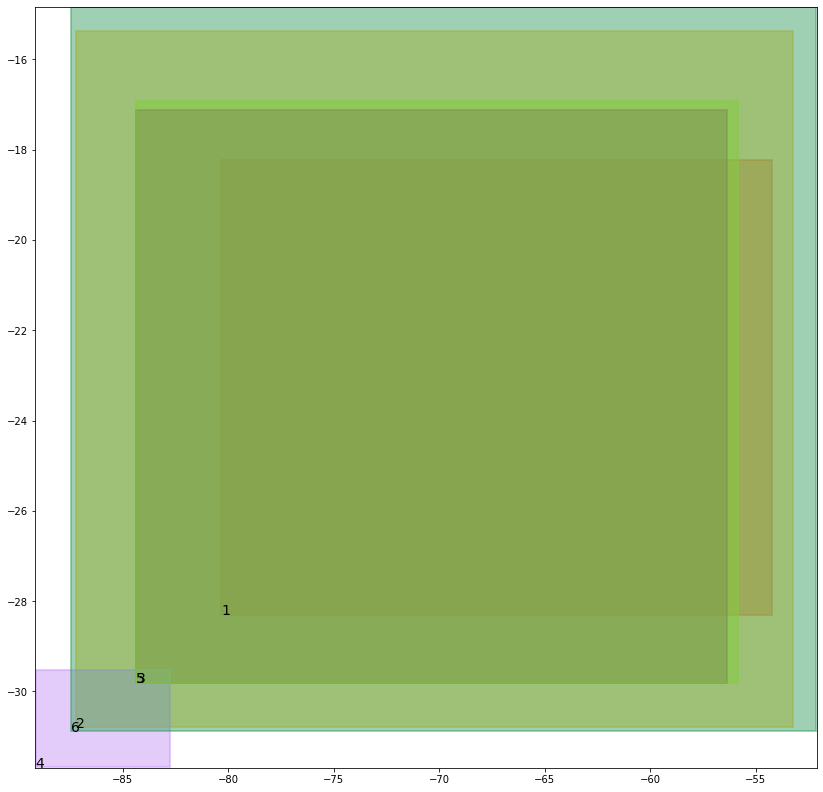

alignment data:
tensor(1) 0.5791809558868408 0.4834209382534027 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.2574913799762726 0.9815981388092041 tensor(0.9352896213531494) tensor(0.9883773922920227)
tensor(3) 0.35478171706199646 0.9154058694839478 tensor(0.9193001985549927) tensor(0.9199677109718323)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.34901154041290283 0.9079350233078003 tensor(0.9183716773986816) tensor(0.9216938018798828)
tensor(6) 0.2373988777399063 0.9795754551887512 tensor(0.9394103288650513) tensor(0.9884695410728455)


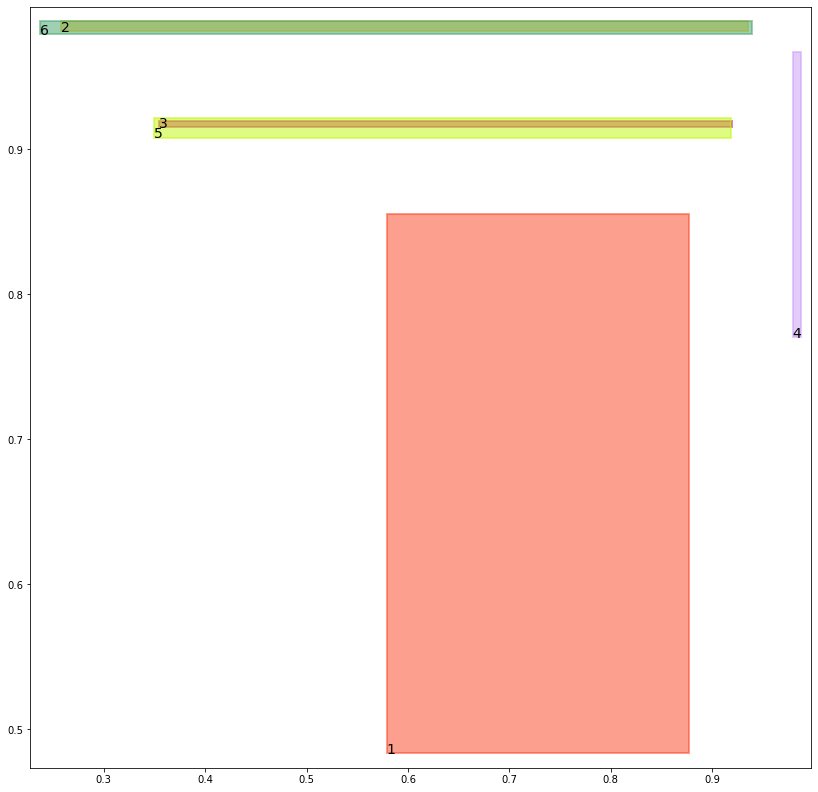

batch (tensor([[4, 5],
        [6, 2],
        [1, 3],
        [4, 6]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.32752227783203 -28.306396484375 tensor(-54.2256736755371094) tensor(-18.2294178009033203)
tensor(2) -87.2394790649414 -30.801054000854492 tensor(-53.1524467468261719) tensor(-15.3175878524780273)
tensor(3) -84.32463836669922 -29.802282333374023 tensor(-56.1739196777343750) tensor(-17.0261020660400391)
tensor(4) -89.11986541748047 -31.680147171020508 tensor(-82.7521591186523438) tensor(-29.5281753540039062)
tensor(5) -84.38159942626953 -29.823057174682617 tensor(-56.0593986511230469) tensor(-17.0235786437988281)
tensor(6) -87.41291046142578 -30.880178451538086 tensor(-52.1804046630859375) tensor(-14.8644695281982422)


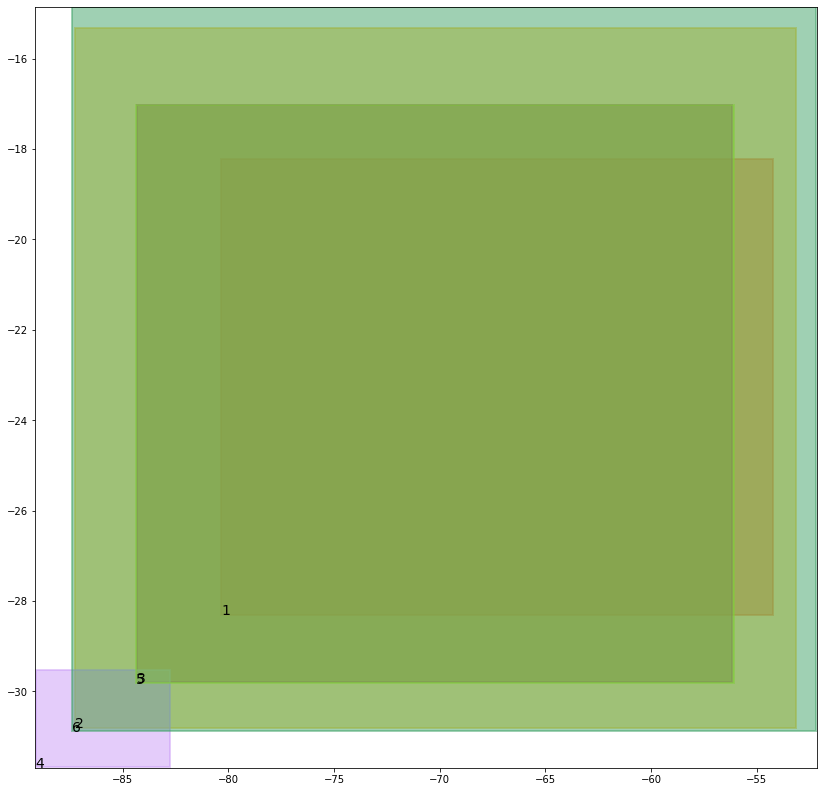

alignment data:
tensor(1) 0.5791809558868408 0.4834209382534027 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.2557018995285034 0.9814538955688477 tensor(0.9356515407562256) tensor(0.9885224103927612)
tensor(3) 0.3498463034629822 0.9171775579452515 tensor(0.9188109636306763) tensor(0.9202821254730225)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.353575199842453 0.9069972634315491 tensor(0.9192779064178467) tensor(0.9214061498641968)
tensor(6) 0.2380310595035553 0.9798237085342407 tensor(0.9394004344940186) tensor(0.9883071780204773)


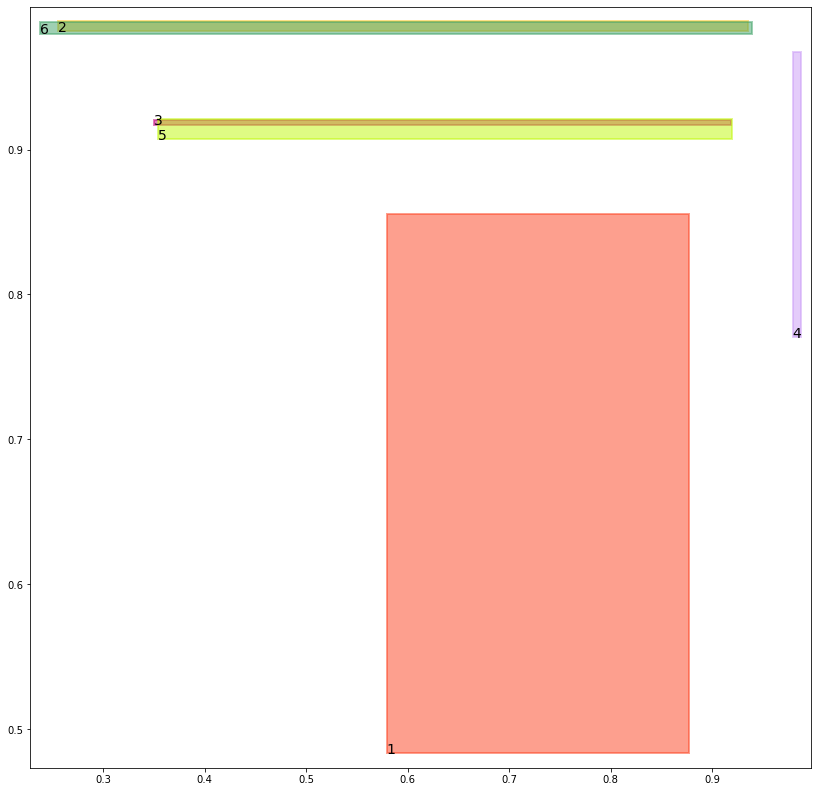

batch (tensor([[1, 3],
        [1, 2],
        [2, 6],
        [4, 5]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.32752990722656 -28.306398391723633 tensor(-54.2256736755371094) tensor(-18.2294216156005859)
tensor(2) -87.36746215820312 -30.85809898376465 tensor(-52.5265808105468750) tensor(-15.0252580642700195)
tensor(3) -84.31153106689453 -29.796043395996094 tensor(-55.9867630004882812) tensor(-16.9325027465820312)
tensor(4) -89.119873046875 -31.680150985717773 tensor(-82.7521591186523438) tensor(-29.5281772613525391)
tensor(5) -84.41329193115234 -29.837005615234375 tensor(-56.2534217834472656) tensor(-17.1168060302734375)
tensor(6) -87.31083679199219 -30.834917068481445 tensor(-52.7393150329589844) tensor(-15.1247596740722656)


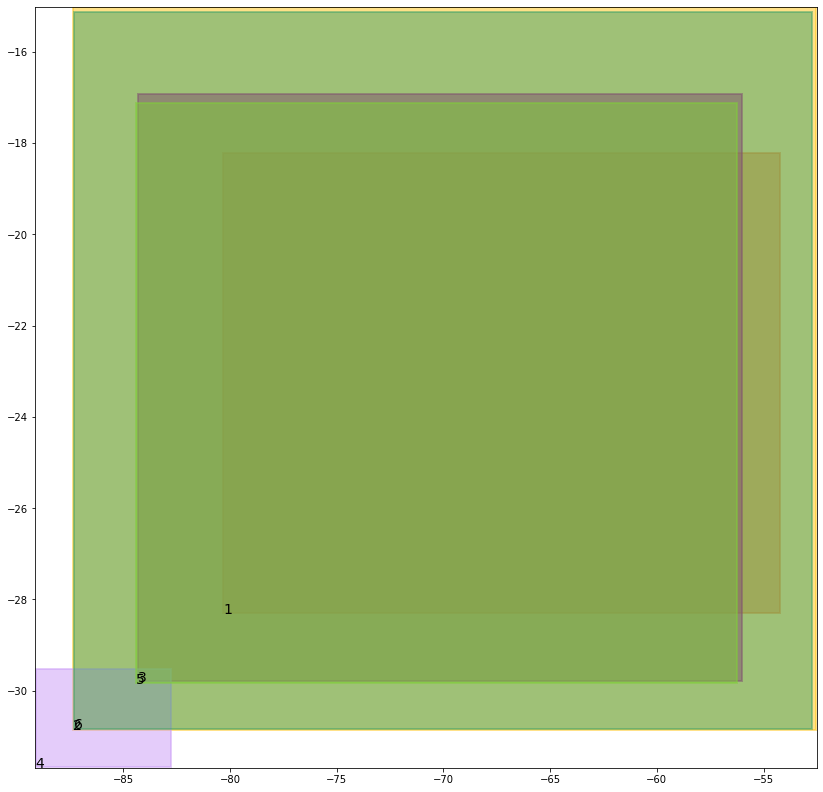

alignment data:
tensor(1) 0.5791809558868408 0.4834209382534027 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.24425750970840454 0.9805189371109009 tensor(0.9382323622703552) tensor(0.9886519312858582)
tensor(3) 0.34541594982147217 0.9187487363815308 tensor(0.9183667302131653) tensor(0.9205650687217712)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3577203154563904 0.9061428308486938 tensor(0.9200882911682129) tensor(0.9211455583572388)
tensor(6) 0.248163104057312 0.9808099865913391 tensor(0.9373747706413269) tensor(0.9881525635719299)


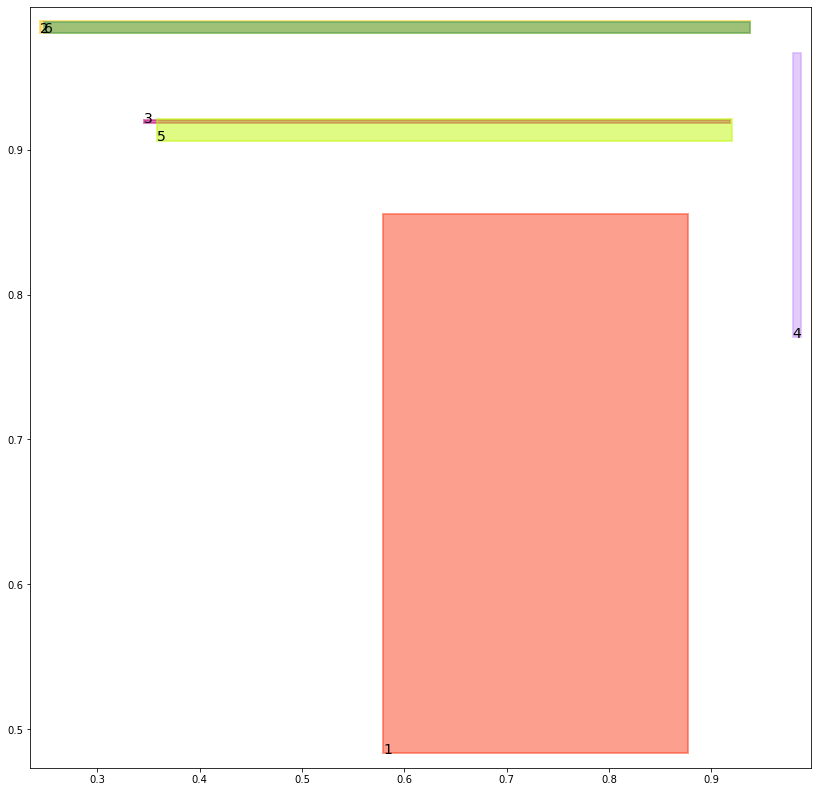

batch (tensor([[4, 6],
        [5, 3],
        [6, 2],
        [3, 5]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.32752990722656 -28.3064022064209 tensor(-54.2256698608398438) tensor(-18.2294216156005859)
tensor(2) -87.44168090820312 -30.891542434692383 tensor(-52.1480522155761719) tensor(-14.8485317230224609)
tensor(3) -84.37496948242188 -29.819528579711914 tensor(-55.9963073730468750) tensor(-16.9345912933349609)
tensor(4) -89.11988067626953 -31.680150985717773 tensor(-82.7521591186523438) tensor(-29.5281791687011719)
tensor(5) -84.36561584472656 -29.82020378112793 tensor(-56.2552108764648438) tensor(-17.1157550811767578)
tensor(6) -87.25513458251953 -30.809803009033203 tensor(-53.0708312988281250) tensor(-15.2789669036865234)


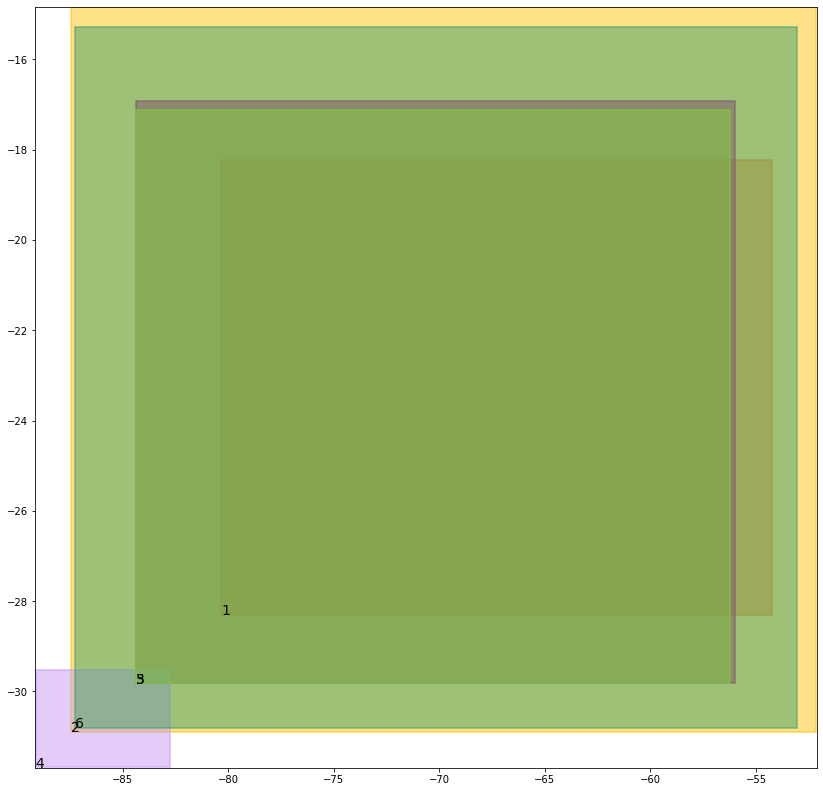

alignment data:
tensor(1) 0.5791809558868408 0.4834209382534027 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.23734457790851593 0.9799384474754333 tensor(0.9397790431976318) tensor(0.9886496067047119)
tensor(3) 0.34532594680786133 0.919215202331543 tensor(0.9189660549163818) tensor(0.9216895103454590)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3575335741043091 0.906524121761322 tensor(0.9198326468467712) tensor(0.9199870824813843)
tensor(6) 0.25415220856666565 0.9814302325248718 tensor(0.9362113475799561) tensor(0.9881582856178284)


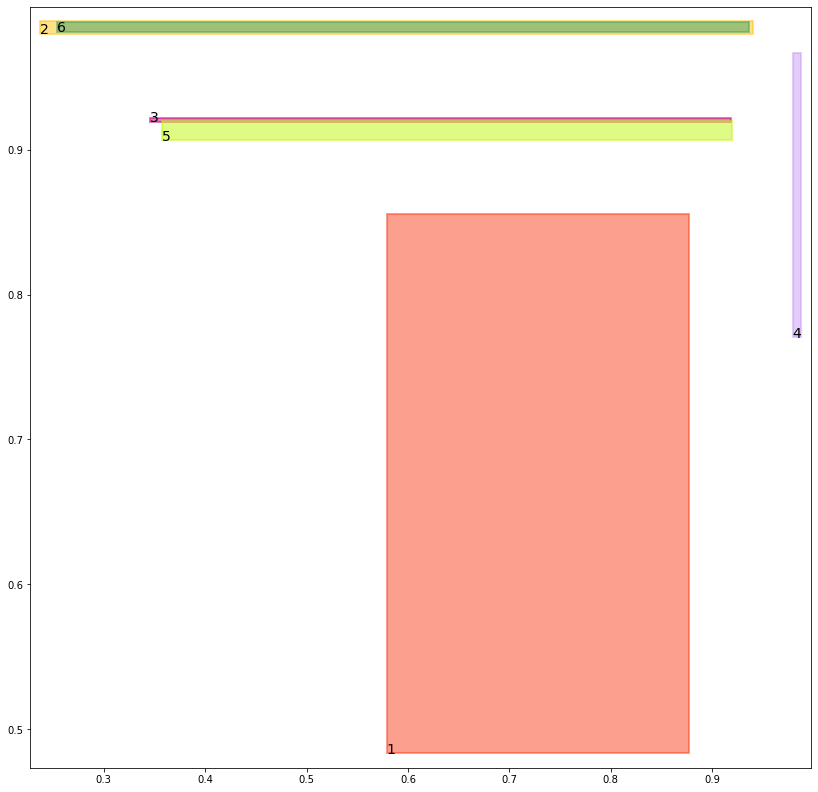

batch (tensor([[4, 6],
        [1, 3],
        [6, 2],
        [4, 5]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.32752990722656 -28.3064022064209 tensor(-54.2256736755371094) tensor(-18.2294235229492188)
tensor(2) -87.39755249023438 -30.873361587524414 tensor(-52.3151016235351562) tensor(-14.9258480072021484)
tensor(3) -84.43173217773438 -29.840543746948242 tensor(-56.0048713684082031) tensor(-16.9364604949951172)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281810760498047)
tensor(5) -84.32211303710938 -29.804880142211914 tensor(-56.2567977905273438) tensor(-17.1147937774658203)
tensor(6) -87.32122039794922 -30.837575912475586 tensor(-52.8237380981445312) tensor(-15.1622629165649414)


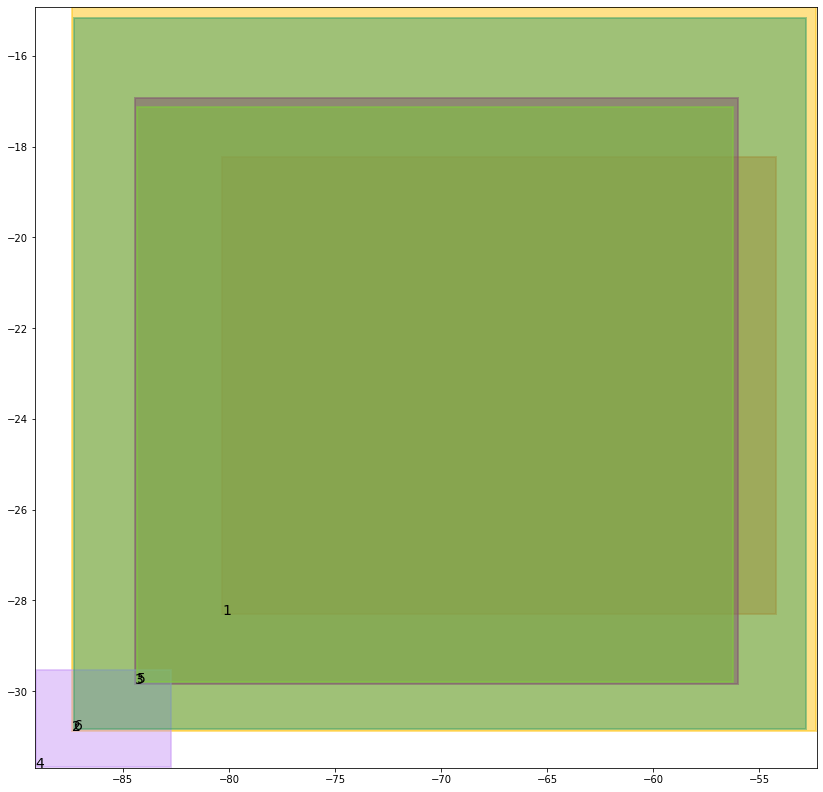

alignment data:
tensor(1) 0.5791809558868408 0.4834209382534027 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.24031798541545868 0.9803275465965271 tensor(0.9390940666198730) tensor(0.9882861971855164)
tensor(3) 0.34524470567703247 0.9196345210075378 tensor(0.9195038676261902) tensor(0.9226925969123840)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3573649823665619 0.9068673253059387 tensor(0.9196010828018188) tensor(0.9189274907112122)
tensor(6) 0.24948643147945404 0.9813147187232971 tensor(0.9373112916946411) tensor(0.9885872602462769)


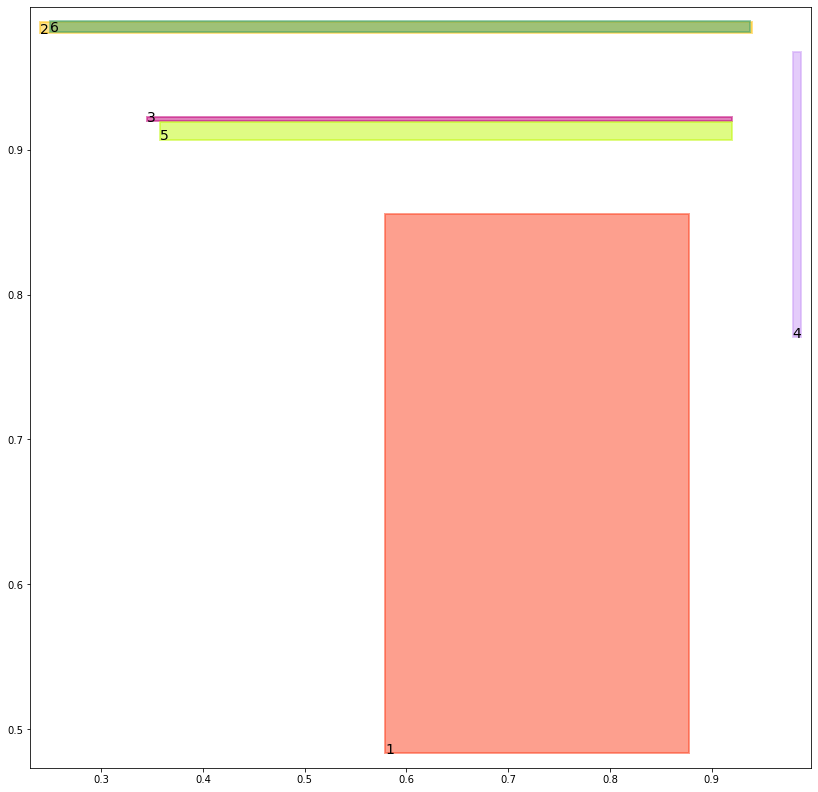

batch (tensor([[3, 5],
        [5, 3],
        [2, 6],
        [1, 2]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256774902343750) tensor(-18.2294254302978516)
tensor(2) -87.36106872558594 -30.8579044342041 tensor(-52.4669265747070312) tensor(-14.9961585998535156)
tensor(3) -84.5040054321289 -29.87062644958496 tensor(-56.1925048828125000) tensor(-17.0252399444580078)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281810760498047)
tensor(5) -84.2625503540039 -29.780010223388672 tensor(-56.0840606689453125) tensor(-17.0284461975097656)
tensor(6) -87.3757095336914 -30.860984802246094 tensor(-52.6031837463378906) tensor(-15.0580968856811523)


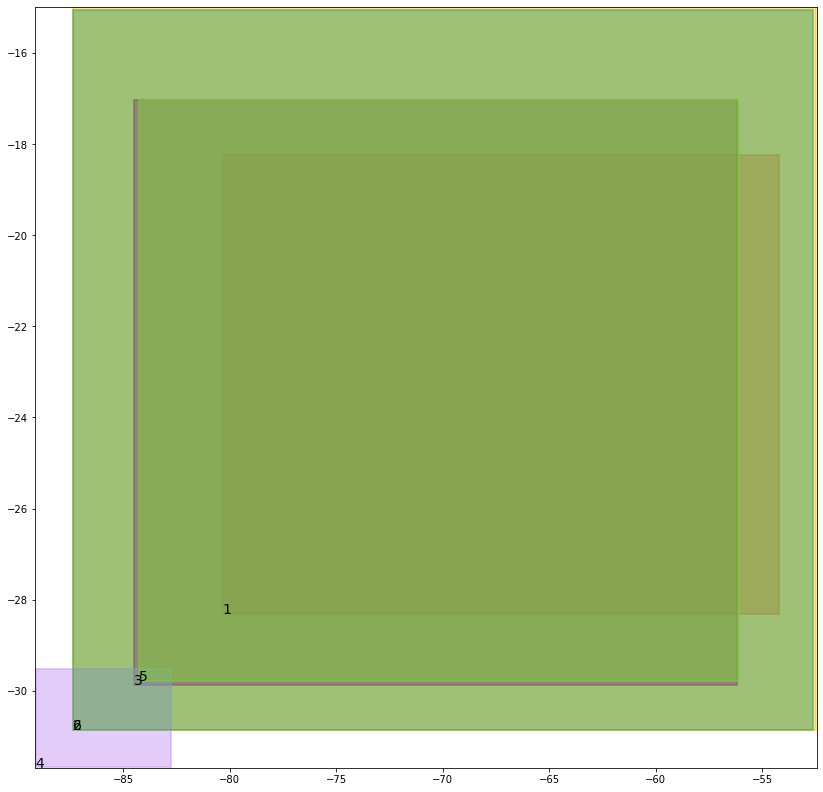

alignment data:
tensor(1) 0.5791810154914856 0.4834209382534027 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.2430252581834793 0.9806726574897766 tensor(0.9384691715240479) tensor(0.9880766868591309)
tensor(3) 0.3490913510322571 0.9190883040428162 tensor(0.9209544062614441) tensor(0.9227383732795715)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.35328030586242676 0.9083102941513062 tensor(0.9183865785598755) tensor(0.9189204573631287)
tensor(6) 0.2453225702047348 0.981209933757782 tensor(0.9382893443107605) tensor(0.9888300299644470)


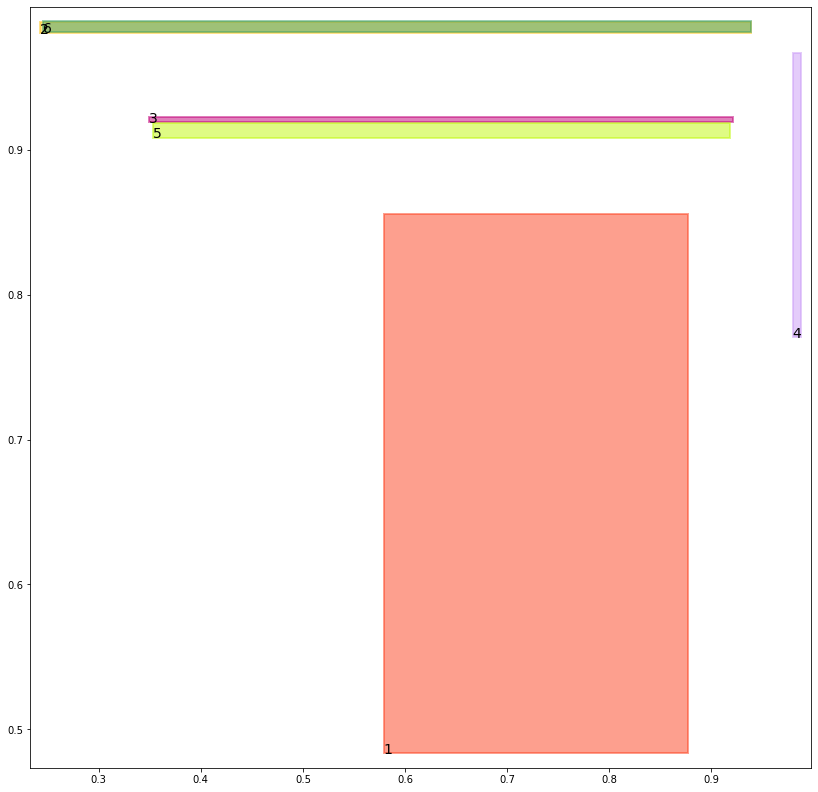

batch (tensor([[4, 6],
        [4, 5],
        [5, 3],
        [1, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256774902343750) tensor(-18.2294254302978516)
tensor(2) -87.32776641845703 -30.84379768371582 tensor(-52.6048126220703125) tensor(-15.0600500106811523)
tensor(3) -84.34967803955078 -29.812952041625977 tensor(-56.9835700988769531) tensor(-17.3905696868896484)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -84.4411392211914 -29.847074508666992 tensor(-55.3238067626953125) tensor(-16.6732845306396484)
tensor(6) -87.4241714477539 -30.881818771362305 tensor(-52.4060821533203125) tensor(-14.9650192260742188)


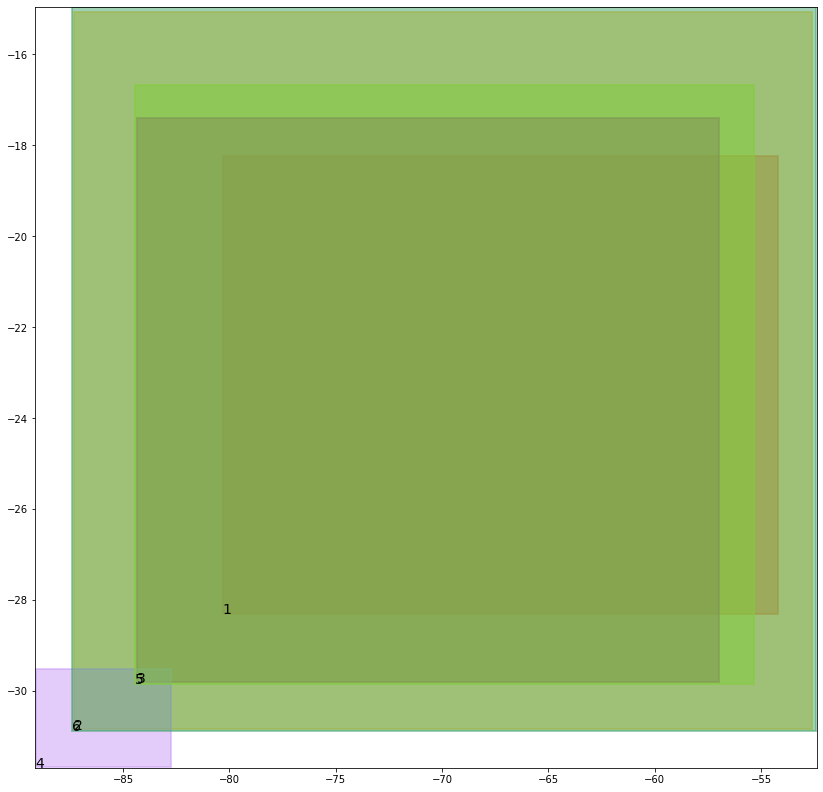

alignment data:
tensor(1) 0.5791810154914856 0.4834209382534027 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.24548809230327606 0.9809792041778564 tensor(0.9378996491432190) tensor(0.9878843426704407)
tensor(3) 0.36425477266311646 0.9186097383499146 tensor(0.9193698167800903) tensor(0.9202067255973816)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3382300138473511 0.9095962047576904 tensor(0.9202948212623596) tensor(0.9217298626899719)
tensor(6) 0.24160252511501312 0.9811146855354309 tensor(0.9391602873802185) tensor(0.9890449047088623)


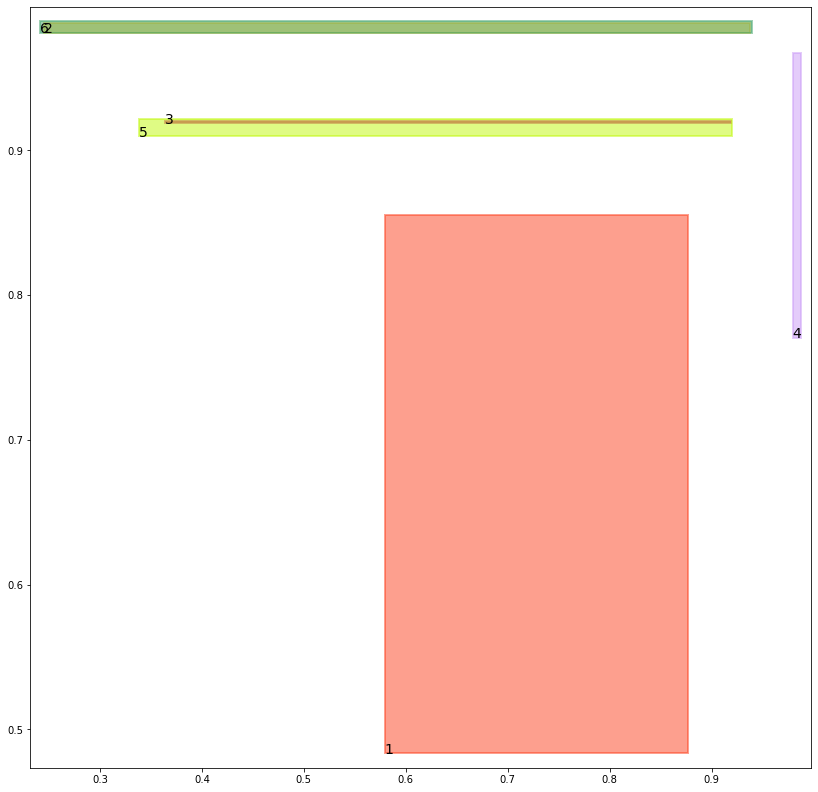

batch (tensor([[1, 3],
        [6, 2],
        [3, 5],
        [2, 6]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256774902343750) tensor(-18.2294273376464844)
tensor(2) -87.33658599853516 -30.84795570373535 tensor(-52.5729217529296875) tensor(-15.0421476364135742)
tensor(3) -84.28328704833984 -29.789091110229492 tensor(-57.4639053344726562) tensor(-17.6178398132324219)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -84.52391052246094 -29.877437591552734 tensor(-54.8834381103515625) tensor(-16.4602642059326172)
tensor(6) -87.43161010742188 -30.884857177734375 tensor(-52.3874206542968750) tensor(-14.9577865600585938)


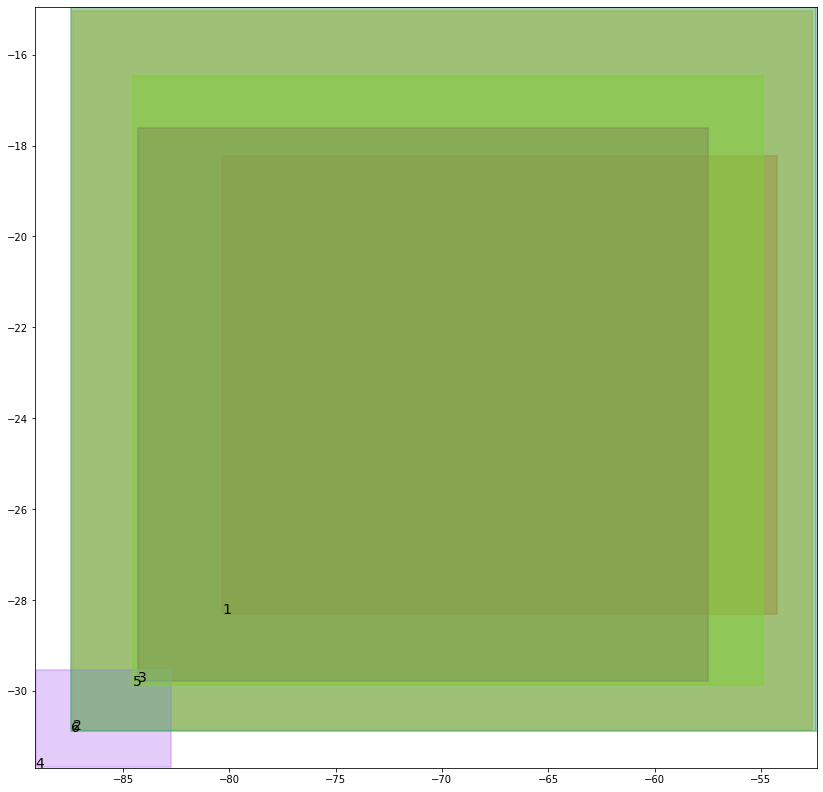

alignment data:
tensor(1) 0.5791810154914856 0.4834209382534027 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.24456201493740082 0.9815207123756409 tensor(0.9381087422370911) tensor(0.9878443479537964)
tensor(3) 0.3741022050380707 0.9172115921974182 tensor(0.9189070463180542) tensor(0.9187656641006470)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.32865336537361145 0.9118273258209229 tensor(0.9210141897201538) tensor(0.9232972860336304)
tensor(6) 0.24143058061599731 0.9807959794998169 tensor(0.9392725229263306) tensor(0.9891110062599182)


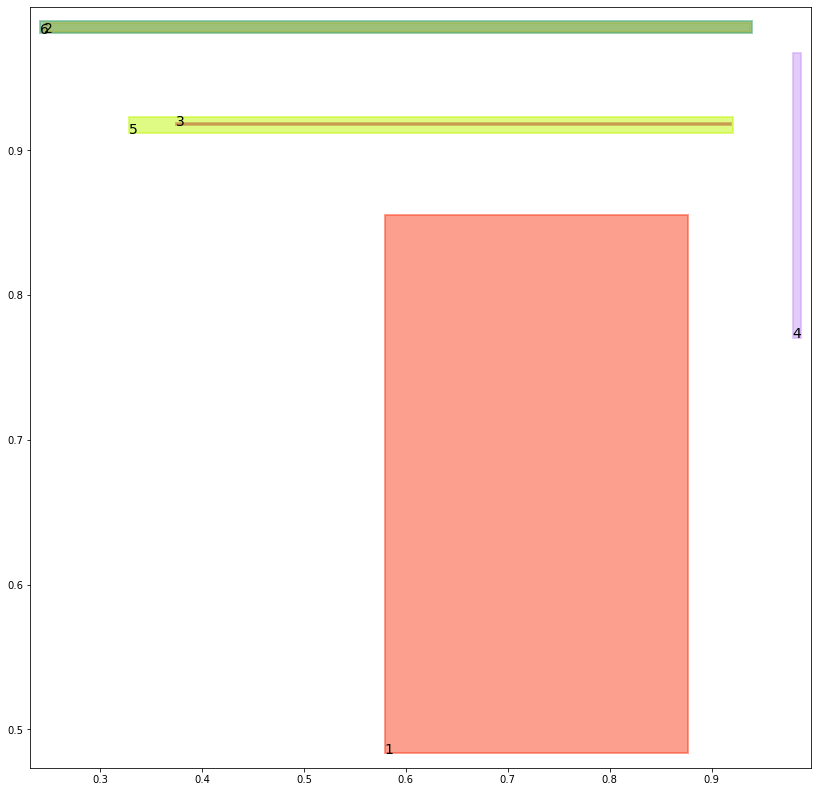

batch (tensor([[2, 6],
        [4, 6],
        [3, 5],
        [6, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256774902343750) tensor(-18.2294273376464844)
tensor(2) -87.38311004638672 -30.868452072143555 tensor(-52.3732604980468750) tensor(-14.9462499618530273)
tensor(3) -84.29898071289062 -29.796724319458008 tensor(-57.6521377563476562) tensor(-17.7154083251953125)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -84.52371978759766 -29.875974655151367 tensor(-54.7172431945800781) tensor(-16.3692340850830078)
tensor(6) -87.40225982666016 -30.871946334838867 tensor(-52.5435905456542969) tensor(-15.0321769714355469)


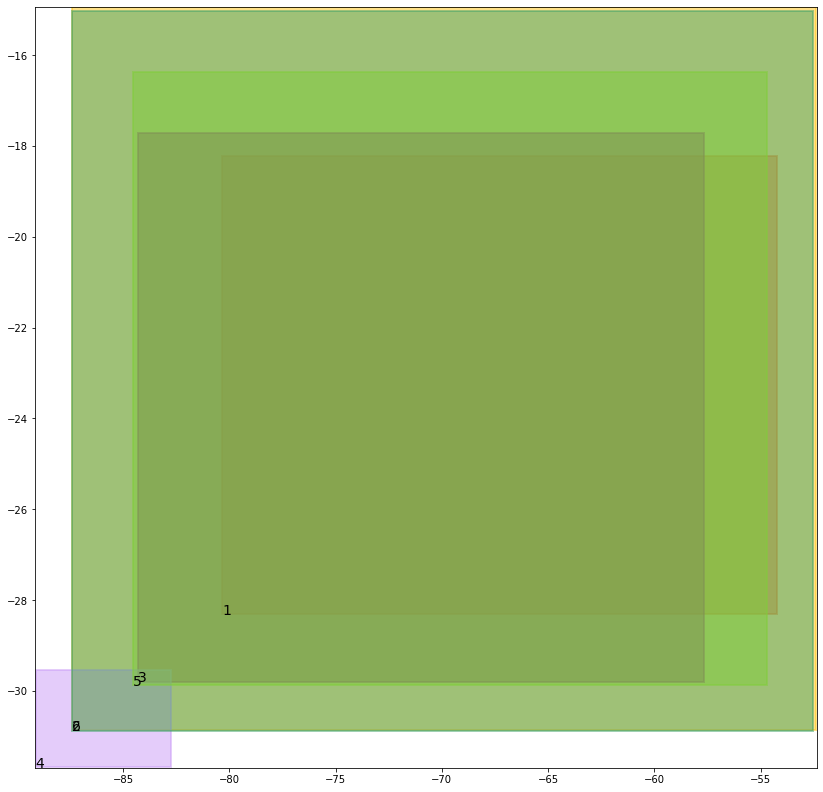

alignment data:
tensor(1) 0.5791810154914856 0.4834209382534027 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.2406097799539566 0.9817403554916382 tensor(0.9390134215354919) tensor(0.9879440069198608)
tensor(3) 0.3789616823196411 0.9149326086044312 tensor(0.9194754362106323) tensor(0.9183681607246399)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3237883746623993 0.9148331880569458 tensor(0.9206911325454712) tensor(0.9238109588623047)
tensor(6) 0.24445100128650665 0.9807461500167847 tensor(0.9387036561965942) tensor(0.9890457391738892)


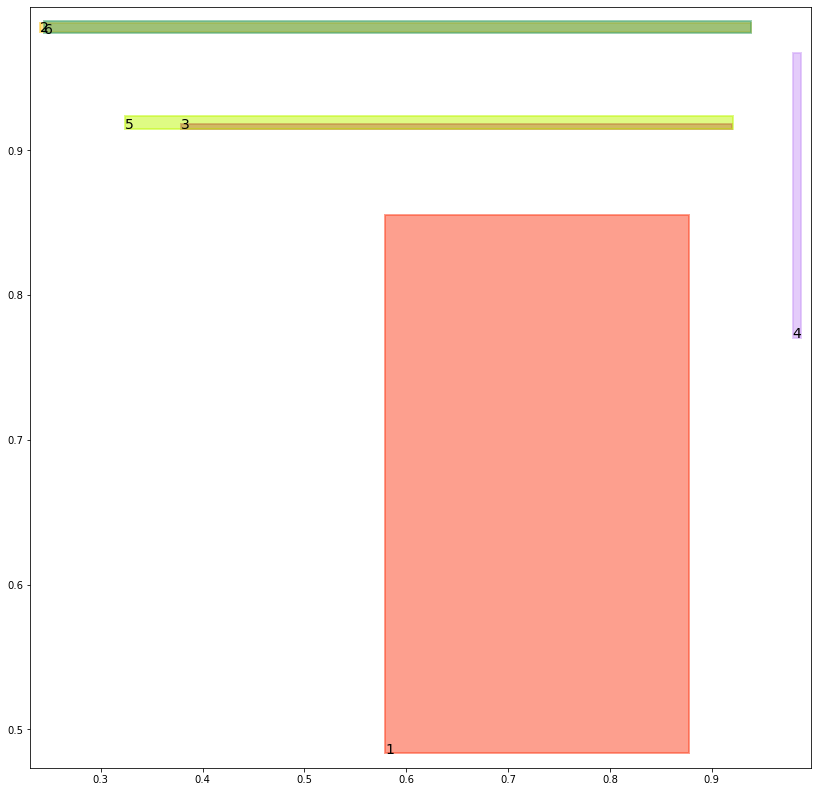

batch (tensor([[1, 2],
        [4, 5],
        [5, 3],
        [1, 3]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256774902343750) tensor(-18.2294273376464844)
tensor(2) -87.42459869384766 -30.886728286743164 tensor(-52.1948471069335938) tensor(-14.8605556488037109)
tensor(3) -84.3129653930664 -29.80354118347168 tensor(-57.8217506408691406) tensor(-17.8035869598388672)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -84.52342224121094 -29.874605178833008 tensor(-54.5664100646972656) tensor(-16.2870788574218750)
tensor(6) -87.37555694580078 -30.860187530517578 tensor(-52.6857681274414062) tensor(-15.0998992919921875)


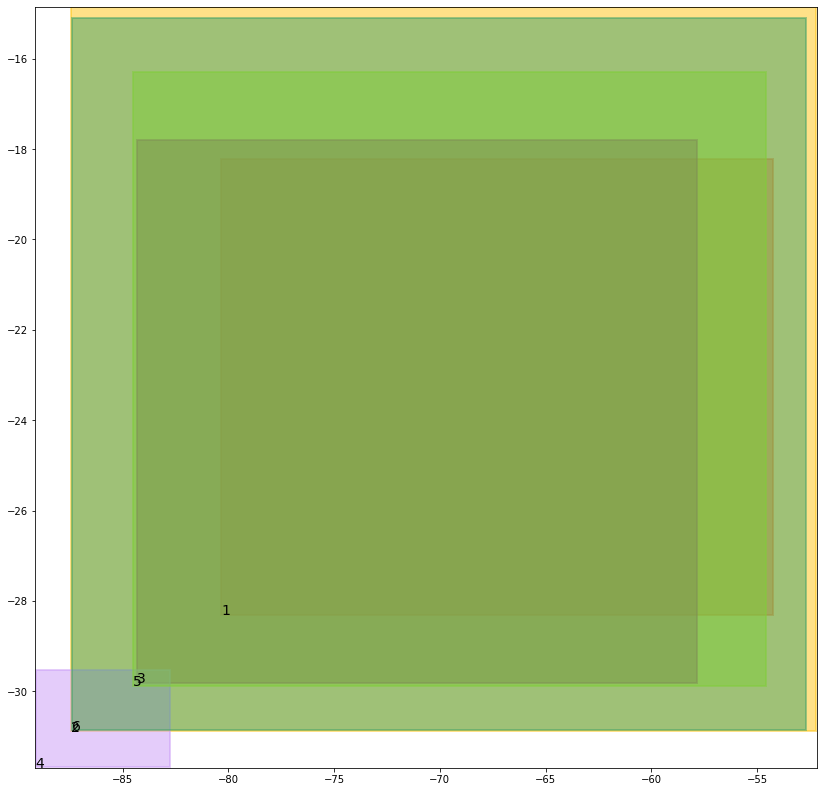

alignment data:
tensor(1) 0.5791810154914856 0.4834209382534027 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.23707818984985352 0.9819363951683044 tensor(0.9398196935653687) tensor(0.9880334138870239)
tensor(3) 0.3833712637424469 0.9128258228302002 tensor(0.9199856519699097) tensor(0.9180076718330383)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3194272816181183 0.9174675941467285 tensor(0.9203982353210449) tensor(0.9242720603942871)
tensor(6) 0.24720065295696259 0.9807010889053345 tensor(0.9381855726242065) tensor(0.9889864921569824)


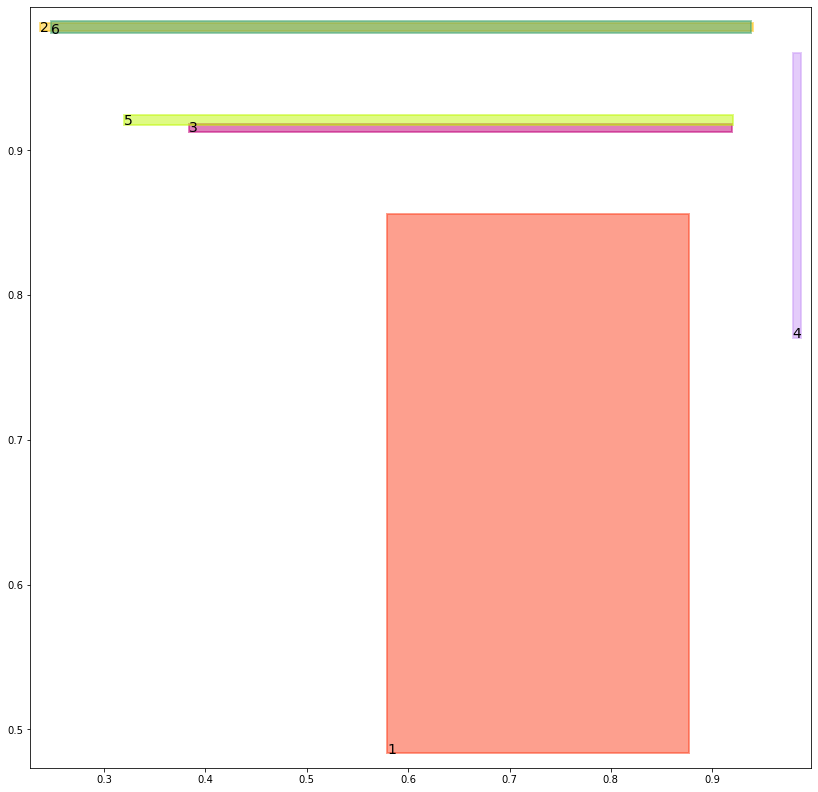

batch (tensor([[1, 3],
        [1, 2],
        [4, 6],
        [6, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256774902343750) tensor(-18.2294273376464844)
tensor(2) -87.36205291748047 -30.858186721801758 tensor(-52.5068511962890625) tensor(-15.0077428817749023)
tensor(3) -84.325439453125 -29.80963134765625 tensor(-57.9745521545410156) tensor(-17.8832492828369141)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -84.52303314208984 -29.87333106994629 tensor(-54.4296722412109375) tensor(-16.2129592895507812)
tensor(6) -87.44933319091797 -30.8936767578125 tensor(-52.3141441345214844) tensor(-14.9236965179443359)


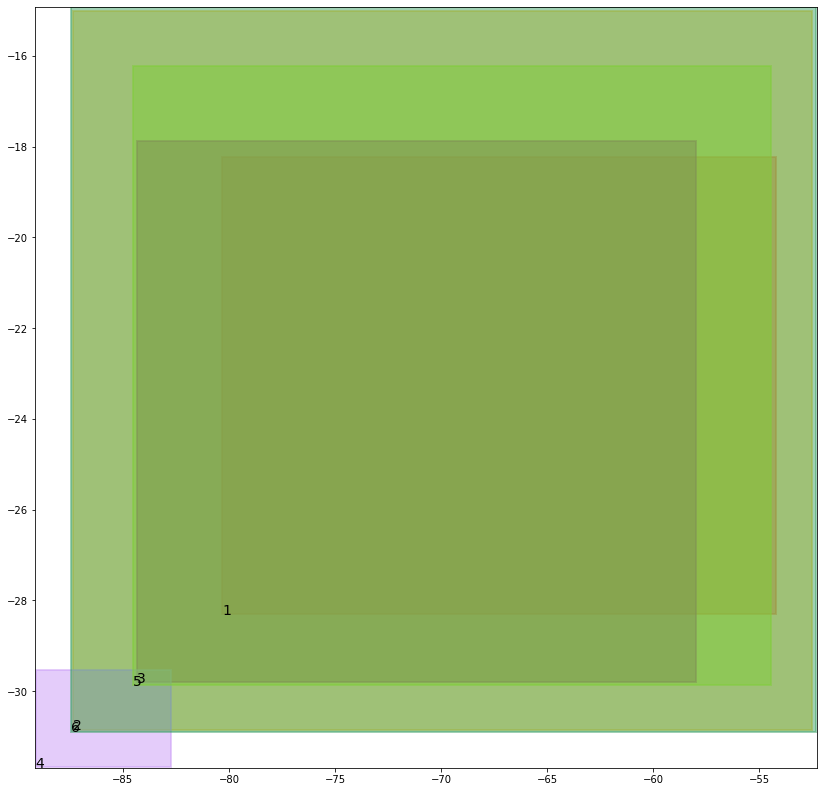

alignment data:
tensor(1) 0.5791810154914856 0.4834209382534027 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.24294941127300262 0.9821171164512634 tensor(0.9384676814079285) tensor(0.9881107807159424)
tensor(3) 0.3873699903488159 0.9108826518058777 tensor(0.9204438924789429) tensor(0.9176808595657349)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.31551581621170044 0.9197827577590942 tensor(0.9201329350471497) tensor(0.9246863126754761)
tensor(6) 0.24010594189167023 0.9806602597236633 tensor(0.9397562146186829) tensor(0.9889327287673950)


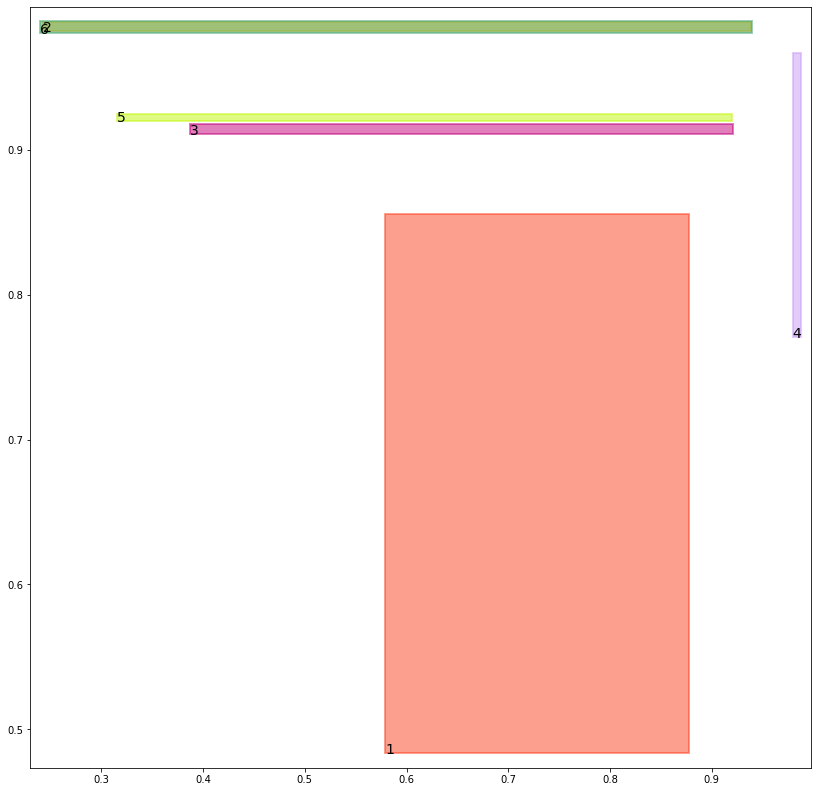

batch (tensor([[3, 5],
        [2, 6],
        [4, 5],
        [5, 3]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.34319305419922 -30.848764419555664 tensor(-52.6226654052734375) tensor(-15.0631523132324219)
tensor(3) -84.31768798828125 -29.804685592651367 tensor(-57.9255294799804688) tensor(-17.8639335632324219)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -84.5418472290039 -29.88252830505371 tensor(-54.4696884155273438) tensor(-16.2252750396728516)
tensor(6) -87.47924041748047 -30.907989501953125 tensor(-52.1523361206054688) tensor(-14.8458232879638672)


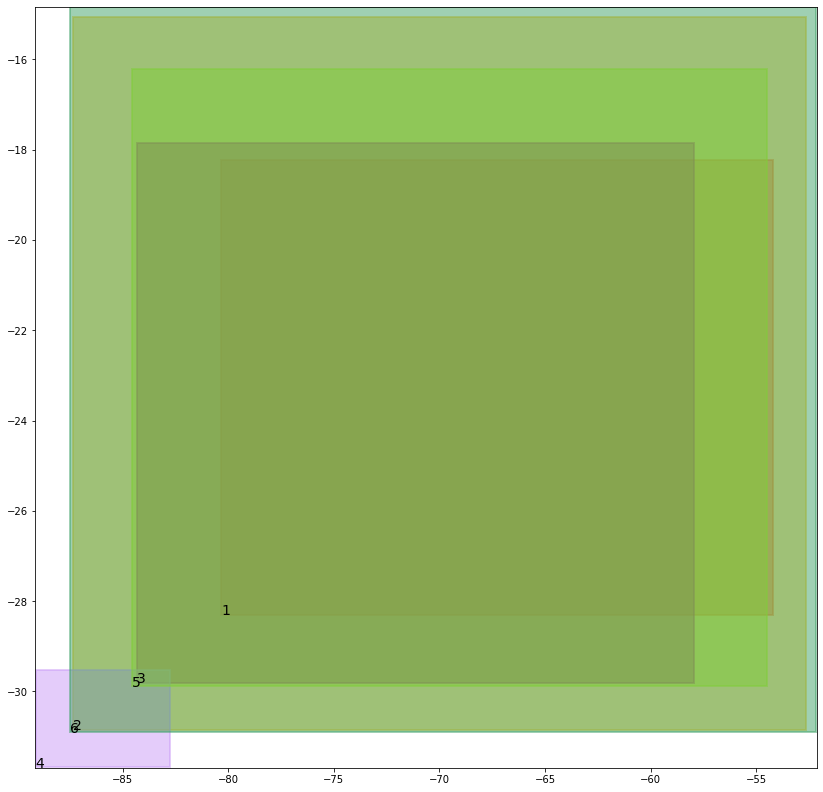

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.24521714448928833 0.9820323586463928 tensor(0.9379467964172363) tensor(0.9883104562759399)
tensor(3) 0.38682135939598083 0.9102357625961304 tensor(0.9198915958404541) tensor(0.9183144569396973)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3155576288700104 0.9210134744644165 tensor(0.9208264350891113) tensor(0.9241899847984314)
tensor(6) 0.23688548803329468 0.9808681607246399 tensor(0.9404947161674500) tensor(0.9887528419494629)


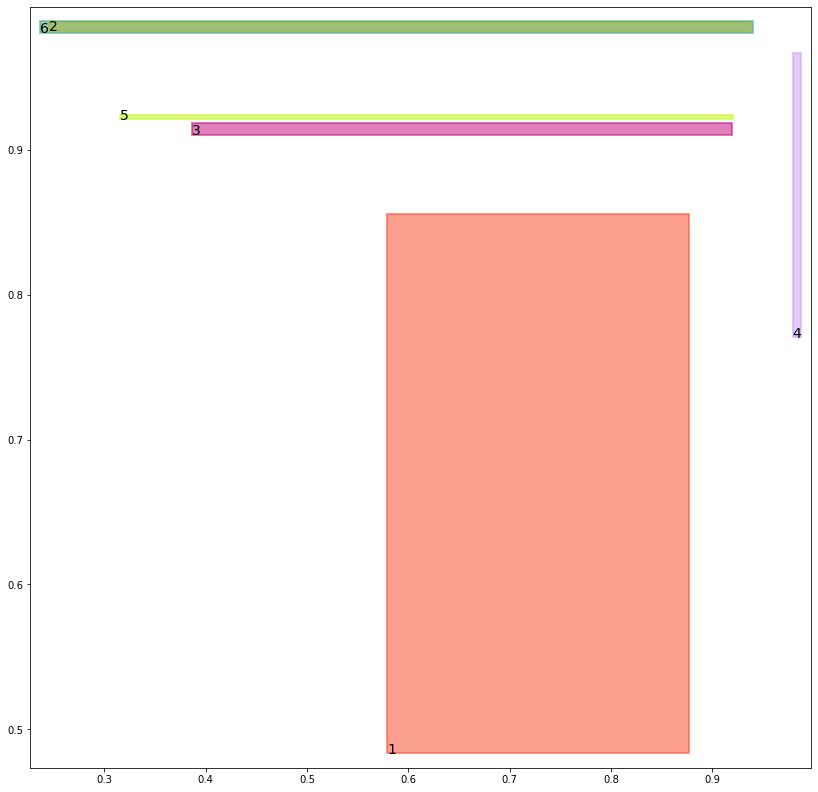

batch (tensor([[4, 5],
        [2, 6],
        [6, 2],
        [1, 3]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.38387298583984 -30.865394592285156 tensor(-52.4729804992675781) tensor(-14.9944171905517578)
tensor(3) -84.3104476928711 -29.800127029418945 tensor(-57.8811645507812500) tensor(-17.8464641571044922)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -84.55854034423828 -29.890714645385742 tensor(-54.5053710937500000) tensor(-16.2362613677978516)
tensor(6) -87.45319366455078 -30.897977828979492 tensor(-52.2561759948730469) tensor(-14.8923606872558594)


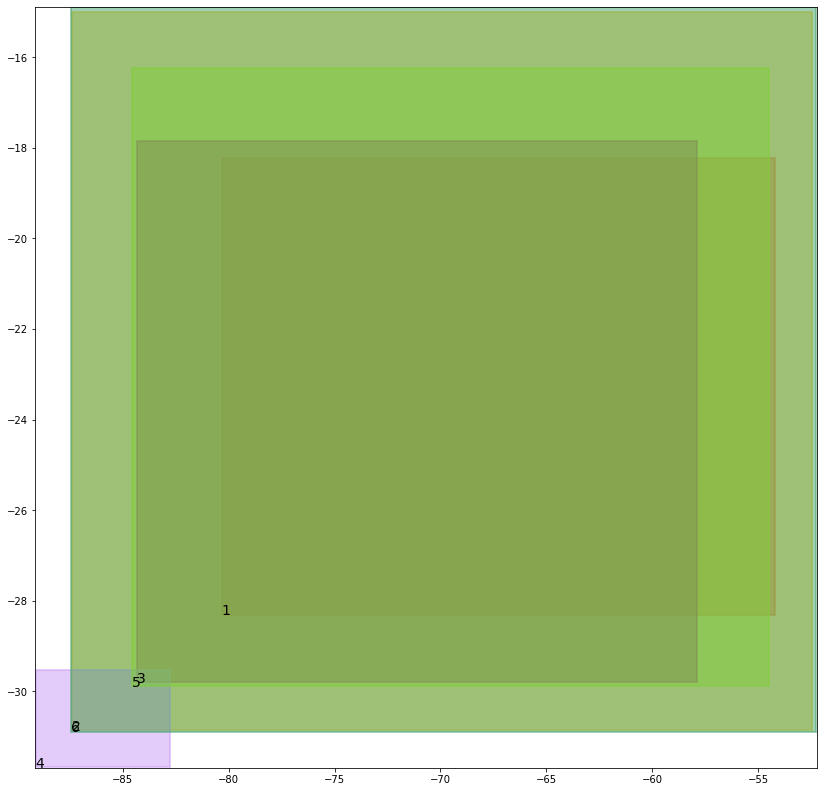

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.2426145076751709 0.9815778136253357 tensor(0.9385597705841064) tensor(0.9886742234230042)
tensor(3) 0.3863261640071869 0.9096478819847107 tensor(0.9193899631500244) tensor(0.9188829064369202)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.315595418214798 0.9221099019050598 tensor(0.9214479923248291) tensor(0.9237391352653503)
tensor(6) 0.2385600209236145 0.9814086556434631 tensor(0.9401906132698059) tensor(0.9883819222450256)


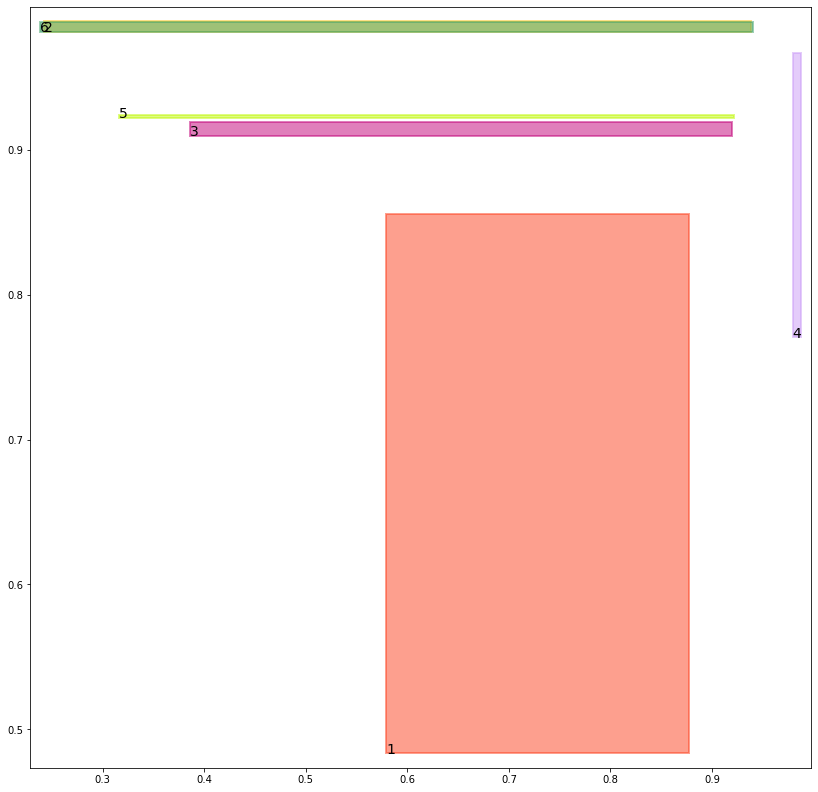

batch (tensor([[1, 2],
        [3, 5],
        [4, 6],
        [5, 3]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.42007446289062 -30.880216598510742 tensor(-52.3383636474609375) tensor(-14.9326553344726562)
tensor(3) -84.41567993164062 -29.839107513427734 tensor(-57.5655212402343750) tensor(-17.6957416534423828)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -84.46106719970703 -29.8547306060791 tensor(-54.7858619689941406) tensor(-16.3659076690673828)
tensor(6) -87.42927551269531 -30.88881492614746 tensor(-52.3499145507812500) tensor(-14.9344367980957031)


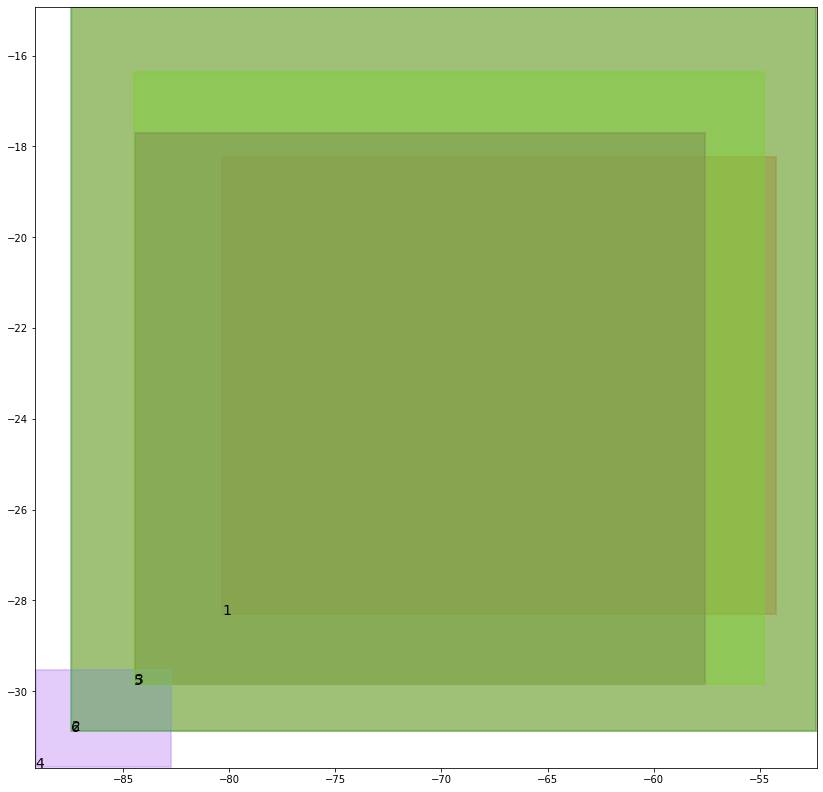

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.2402804046869278 0.9811576008796692 tensor(0.9391083717346191) tensor(0.9889929890632629)
tensor(3) 0.3796933591365814 0.9108465313911438 tensor(0.9203914403915405) tensor(0.9207360744476318)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3209851086139679 0.9219172596931458 tensor(0.9205479621887207) tensor(0.9219785332679749)
tensor(6) 0.2400791049003601 0.9818837642669678 tensor(0.9399148225784302) tensor(0.9880367517471313)


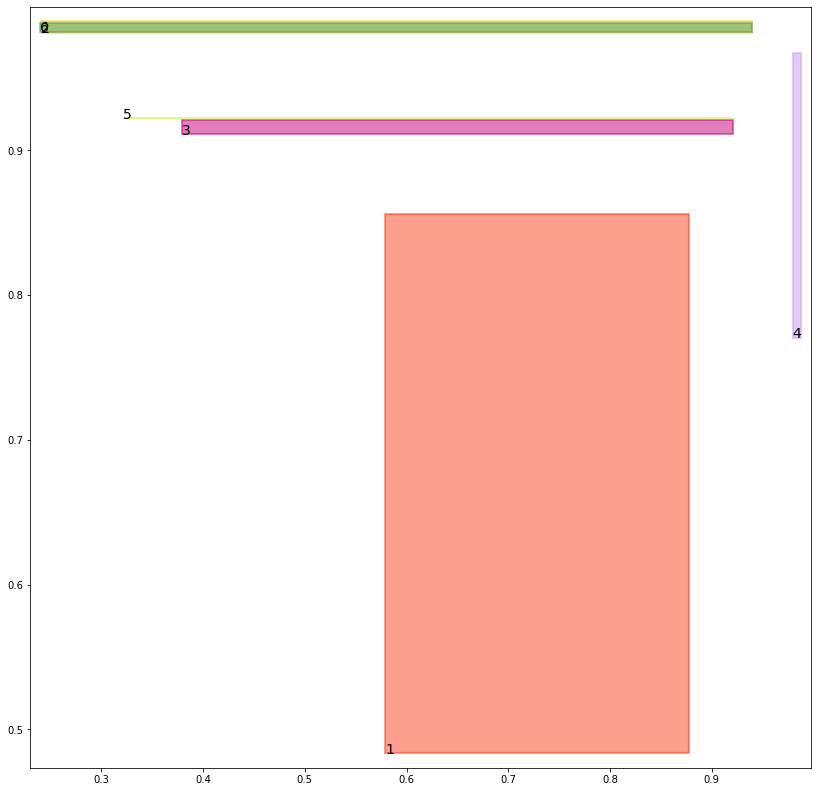

batch (tensor([[4, 5],
        [1, 2],
        [3, 5],
        [1, 3]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.45233917236328 -30.89344596862793 tensor(-52.2172470092773438) tensor(-14.8771381378173828)
tensor(3) -84.72152709960938 -29.955711364746094 tensor(-56.6500549316406250) tensor(-17.2704277038574219)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -84.27103424072266 -29.774587631225586 tensor(-55.4813385009765625) tensor(-16.7065696716308594)
tensor(6) -87.40735626220703 -30.880435943603516 tensor(-52.4345474243164062) tensor(-14.9724760055541992)


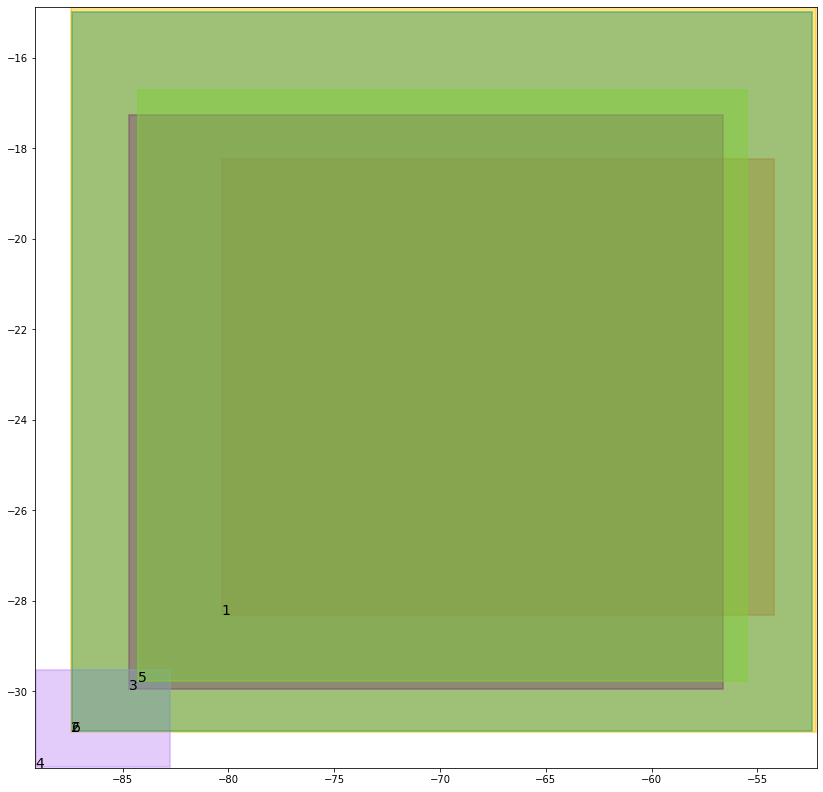

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.23818597197532654 0.9807701110839844 tensor(0.9395998716354370) tensor(0.9892733693122864)
tensor(3) 0.36184707283973694 0.9119165539741516 tensor(0.9240647554397583) tensor(0.9248949885368347)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3366072475910187 0.9175329208374023 tensor(0.9167340993881226) tensor(0.9218389391899109)
tensor(6) 0.2414565533399582 0.9823024868965149 tensor(0.9396646618843079) tensor(0.9877162575721741)


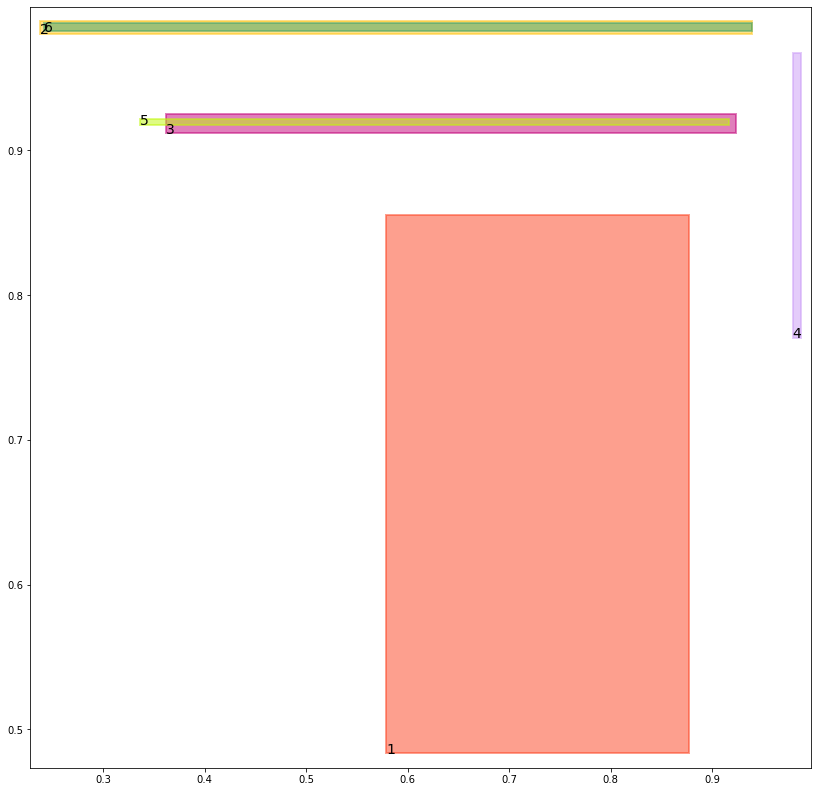

batch (tensor([[4, 6],
        [5, 3],
        [2, 6],
        [6, 2]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.51068878173828 -30.91907501220703 tensor(-52.2748069763183594) tensor(-14.9047908782958984)
tensor(3) -84.91967010498047 -30.03097152709961 tensor(-55.8761520385742188) tensor(-16.9051494598388672)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -84.17509460449219 -29.72776985168457 tensor(-56.0865707397460938) tensor(-17.0100517272949219)
tensor(6) -87.3602294921875 -30.85982322692871 tensor(-52.3415145874023438) tensor(-14.9274730682373047)


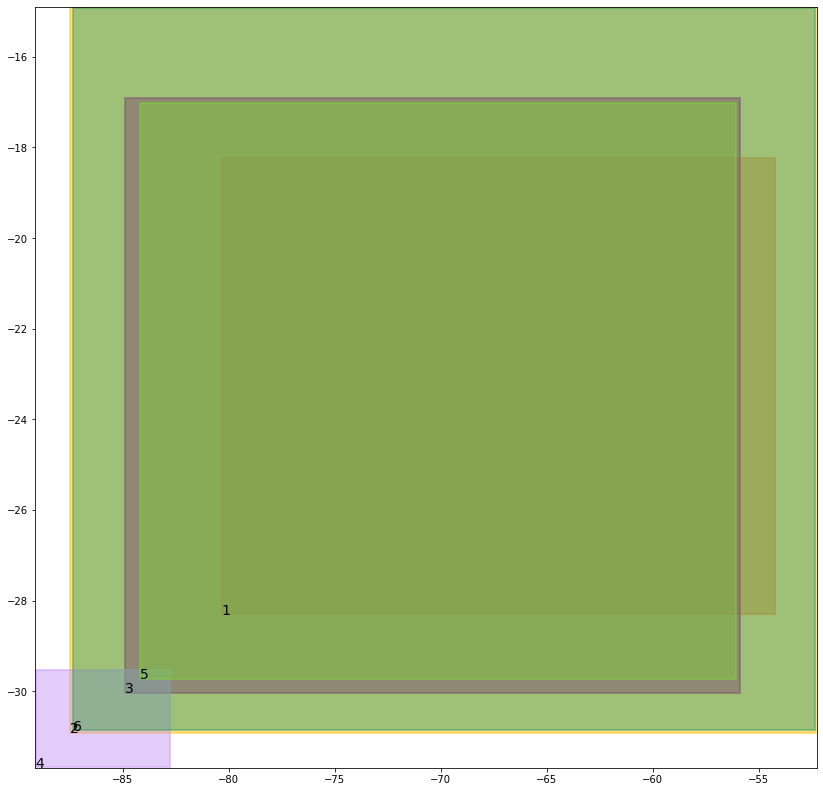

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.23932619392871857 0.9807053208351135 tensor(0.9407247304916382) tensor(0.9894129633903503)
tensor(3) 0.3460862636566162 0.9139875769615173 tensor(0.9263792634010315) tensor(0.9276943206787109)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3510286808013916 0.9122874140739441 tensor(0.9142392873764038) tensor(0.9226125478744507)
tensor(6) 0.23957867920398712 0.9824672341346741 tensor(0.9387689232826233) tensor(0.9875834584236145)


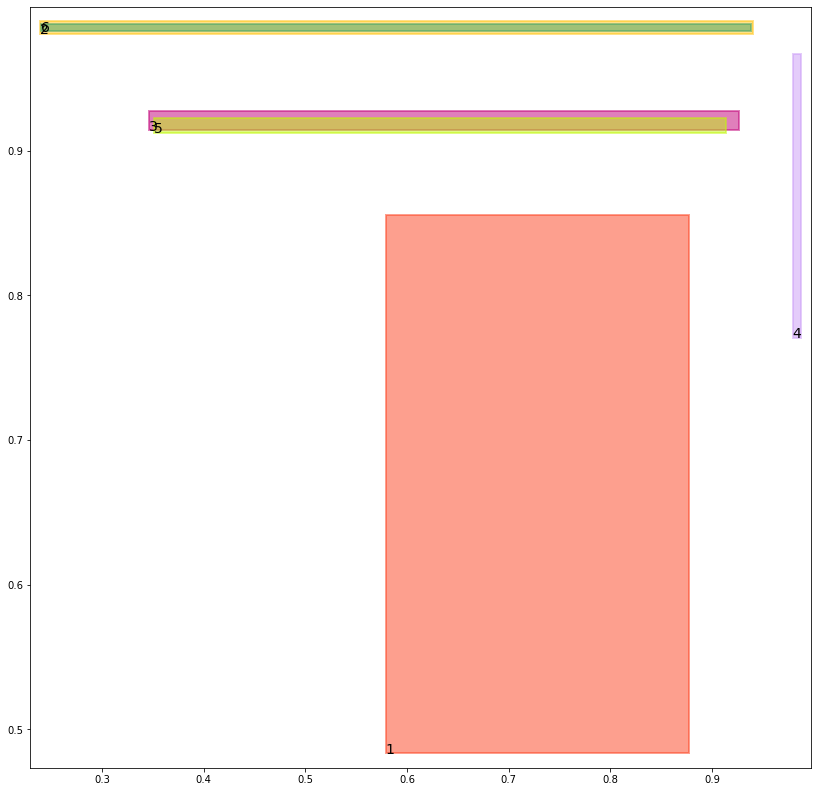

batch (tensor([[3, 5],
        [6, 2],
        [1, 3],
        [2, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.52708435058594 -30.92637825012207 tensor(-52.4956130981445312) tensor(-15.0084342956542969)
tensor(3) -85.09332275390625 -30.096952438354492 tensor(-55.1582374572753906) tensor(-16.5720157623291016)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -84.08540344238281 -29.684141159057617 tensor(-56.6742324829101562) tensor(-17.2984600067138672)
tensor(6) -87.35533905029297 -30.8574161529541 tensor(-52.0917816162109375) tensor(-14.8092136383056641)


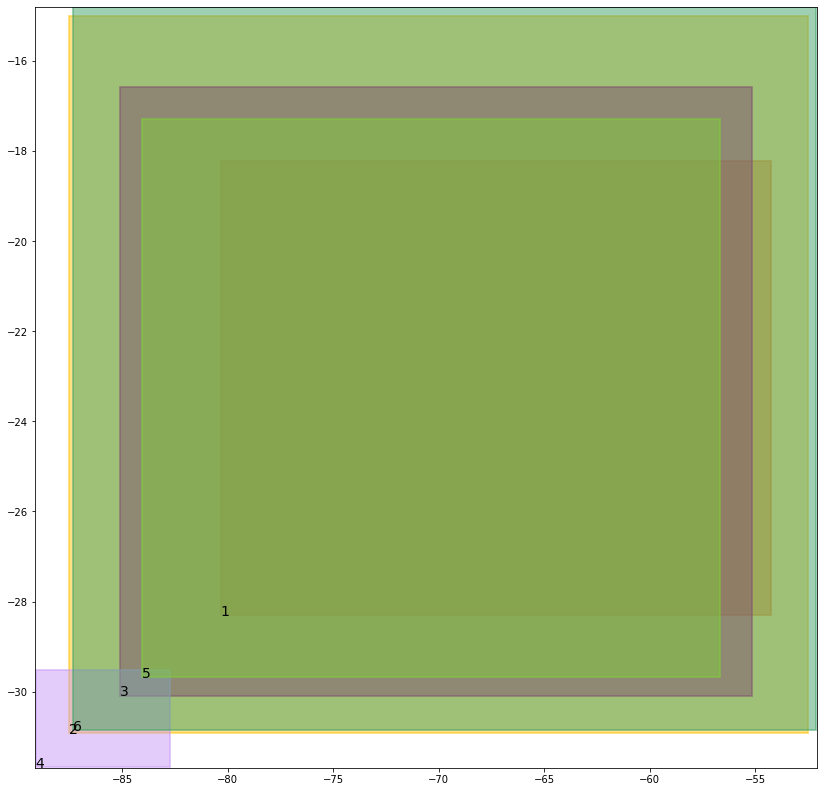

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.24342170357704163 0.9809355735778809 tensor(0.9410542249679565) tensor(0.9894313812255859)
tensor(3) 0.33213821053504944 0.9147452116012573 tensor(0.9284131526947021) tensor(0.9301389455795288)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3642944395542145 0.908469557762146 tensor(0.9119269847869873) tensor(0.9233042597770691)
tensor(6) 0.2348281443119049 0.9824103116989136 tensor(0.9386388063430786) tensor(0.9876273870468140)


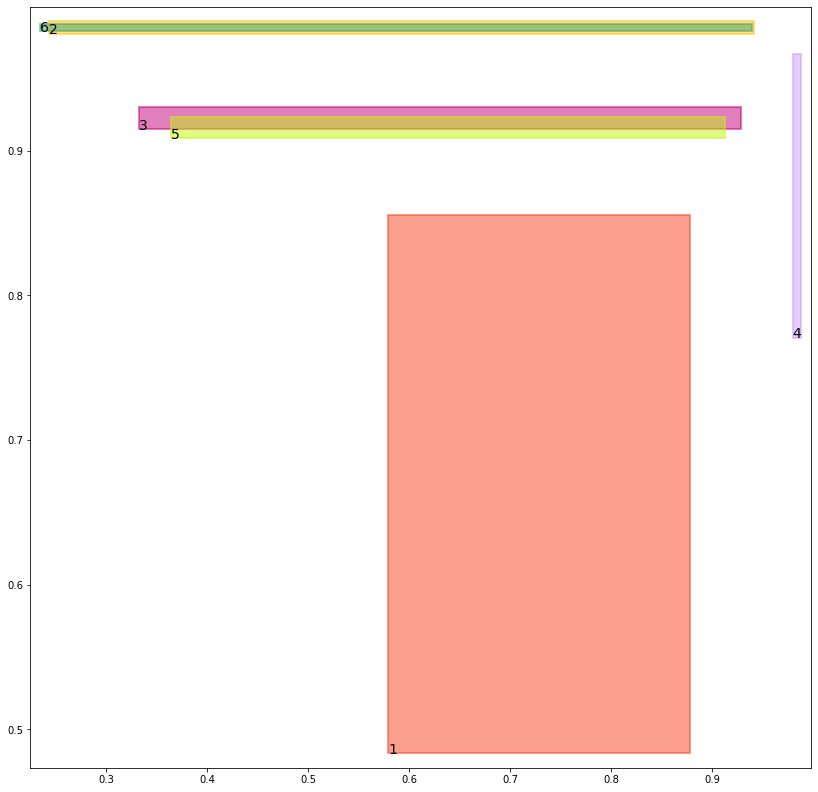

batch (tensor([[4, 5],
        [5, 3],
        [1, 2],
        [4, 6]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.54181671142578 -30.93293571472168 tensor(-52.6970443725585938) tensor(-15.1030035018920898)
tensor(3) -85.06159210205078 -30.083742141723633 tensor(-55.1201934814453125) tensor(-16.5506839752197266)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -84.24398803710938 -29.7415828704834 tensor(-56.5694313049316406) tensor(-17.2679386138916016)
tensor(6) -87.35092163085938 -30.855241775512695 tensor(-51.8692245483398438) tensor(-14.7038288116455078)


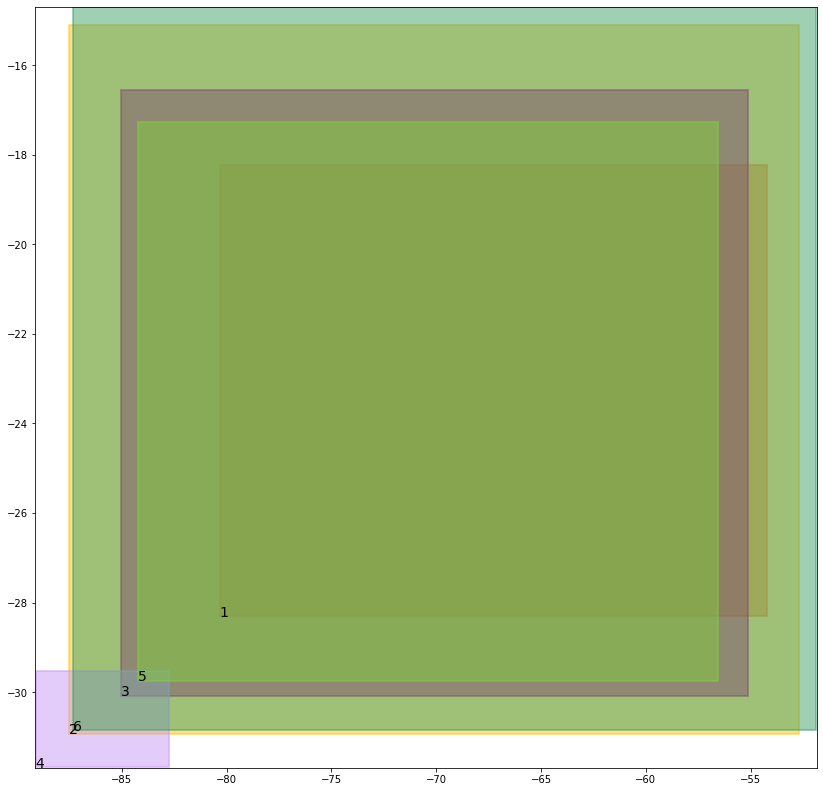

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.24716044962406158 0.981141209602356 tensor(0.9413503408432007) tensor(0.9894480705261230)
tensor(3) 0.3309667408466339 0.9155331254005432 tensor(0.9277753829956055) tensor(0.9301202893257141)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.36438846588134766 0.9048945903778076 tensor(0.9132971763610840) tensor(0.9263076782226562)
tensor(6) 0.23059502243995667 0.9823588728904724 tensor(0.9385212659835815) tensor(0.9876670837402344)


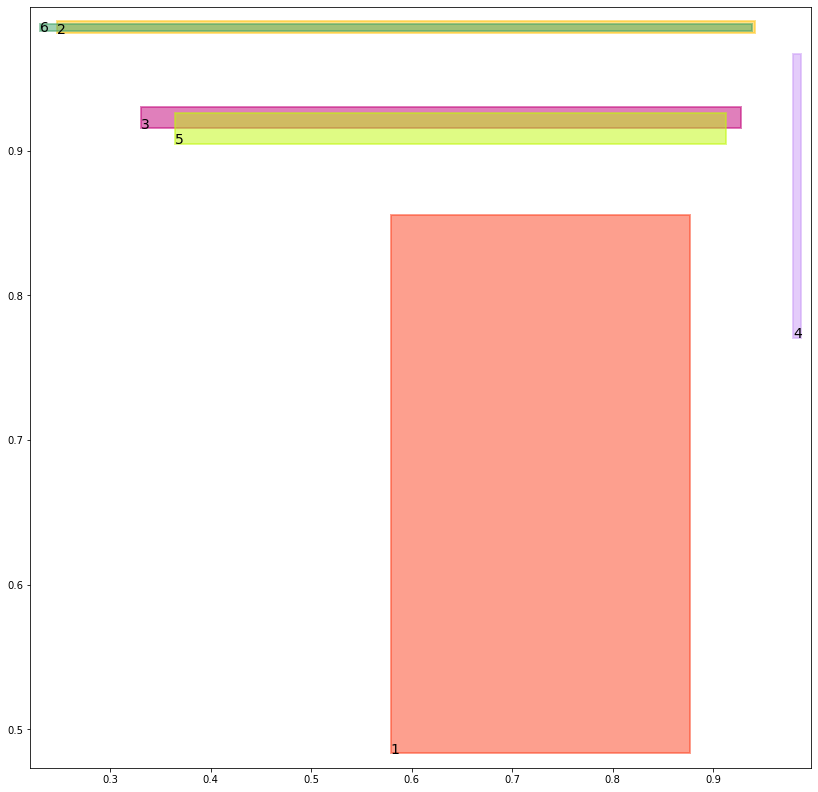

batch (tensor([[5, 3],
        [2, 6],
        [1, 3],
        [3, 5]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.55506896972656 -30.938833236694336 tensor(-52.7136650085449219) tensor(-15.1099567413330078)
tensor(3) -84.96980285644531 -30.047391891479492 tensor(-55.2499656677246094) tensor(-16.6117420196533203)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -84.45844268798828 -29.82261085510254 tensor(-56.3060989379882812) tensor(-17.1569499969482422)
tensor(6) -87.3466796875 -30.853172302246094 tensor(-51.8245239257812500) tensor(-14.6828384399414062)


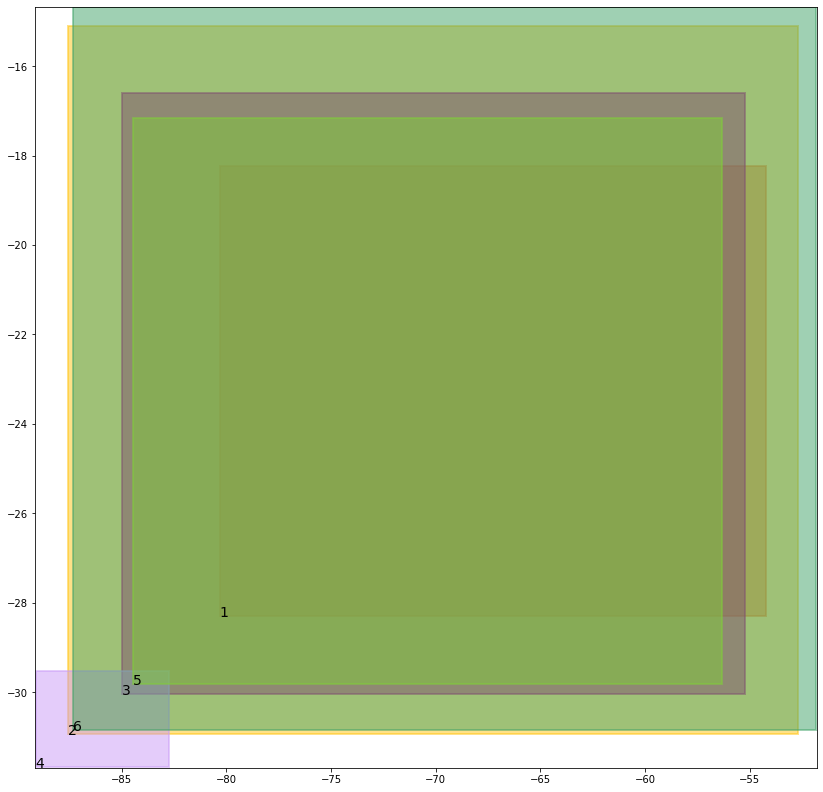

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.2473718822002411 0.9813250303268433 tensor(0.9416165351867676) tensor(0.9894631505012512)
tensor(3) 0.33358657360076904 0.9152258634567261 tensor(0.9263609647750854) tensor(0.9293740391731262)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.360590398311615 0.9028921127319336 tensor(0.9156118631362915) tensor(0.9296512603759766)
tensor(6) 0.22976474463939667 0.9823142290115356 tensor(0.9384111166000366) tensor(0.9877011179924011)


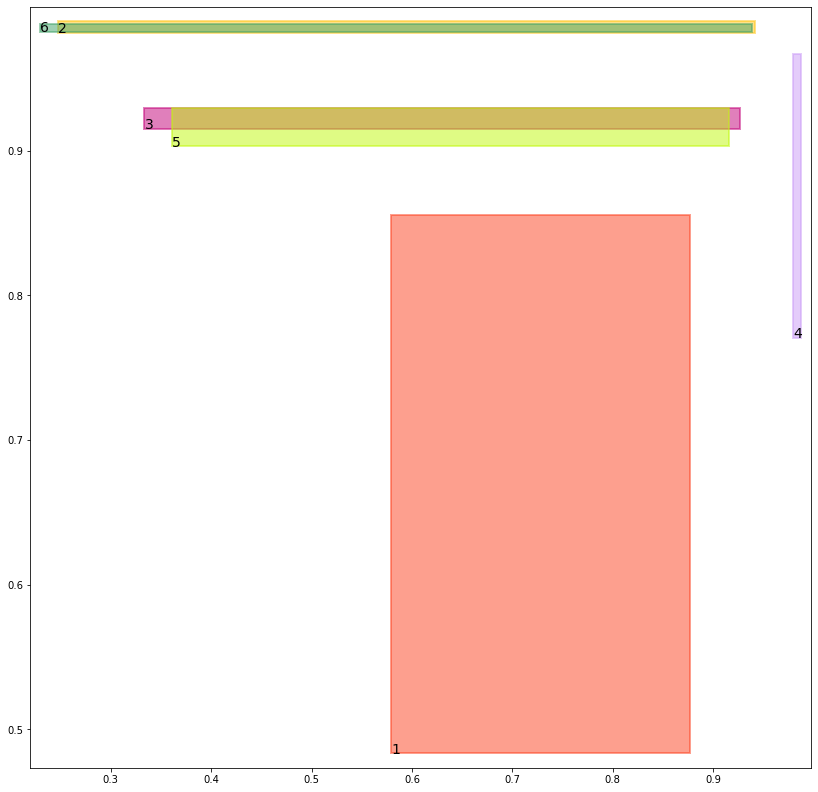

batch (tensor([[4, 6],
        [4, 5],
        [1, 2],
        [6, 2]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.46156311035156 -30.89814567565918 tensor(-52.7539100646972656) tensor(-15.1242351531982422)
tensor(3) -84.88566589355469 -30.014062881469727 tensor(-55.3675842285156250) tensor(-16.6670799255371094)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -84.64603424072266 -29.89360809326172 tensor(-56.0681457519531250) tensor(-17.0568084716796875)
tensor(6) -87.45529174804688 -30.899763107299805 tensor(-51.7650146484375000) tensor(-14.6580257415771484)


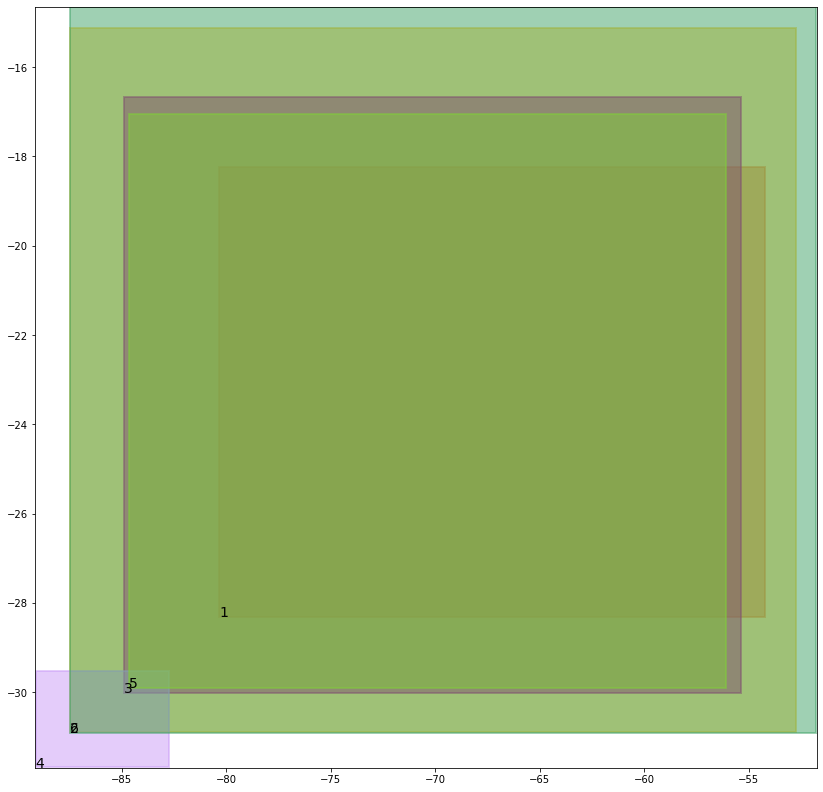

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.24759213626384735 0.9822711944580078 tensor(0.9398673176765442) tensor(0.9891560077667236)
tensor(3) 0.33596092462539673 0.9149474501609802 tensor(0.9250620603561401) tensor(0.9286938905715942)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3571760058403015 0.9010518789291382 tensor(0.9176535606384277) tensor(0.9325491786003113)
tensor(6) 0.22901682555675507 0.9816408753395081 tensor(0.9403503537178040) tensor(0.9882015585899353)


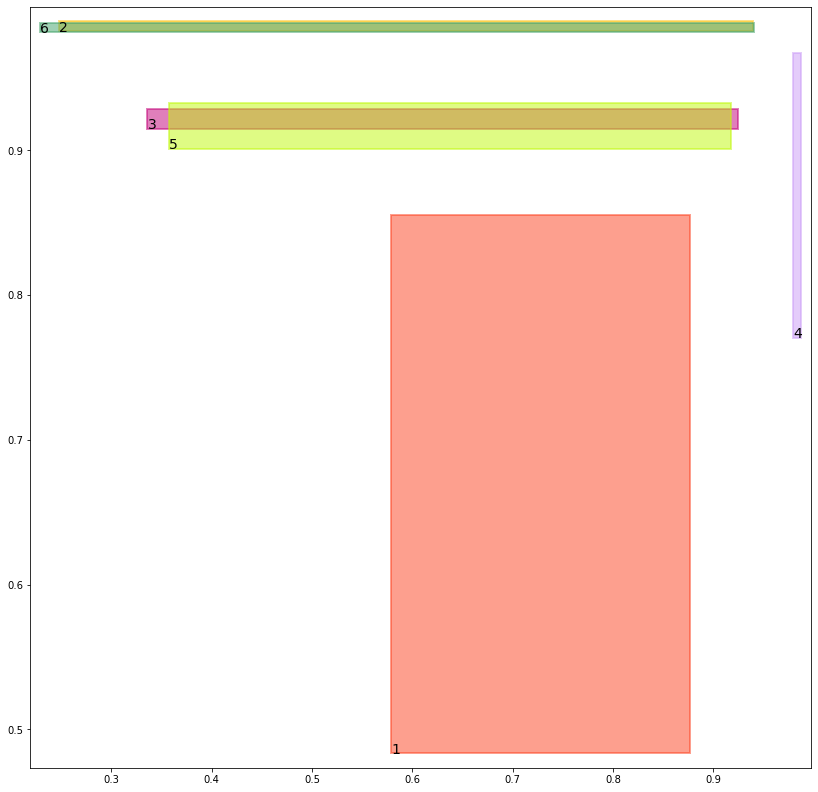

batch (tensor([[4, 6],
        [5, 3],
        [1, 3],
        [6, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.3695297241211 -30.858816146850586 tensor(-52.7891998291015625) tensor(-15.1368360519409180)
tensor(3) -84.74207305908203 -29.955781936645508 tensor(-55.7728881835937500) tensor(-16.8541431427001953)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -84.88272857666016 -29.98848533630371 tensor(-55.5467987060546875) tensor(-16.8258876800537109)
tensor(6) -87.55694580078125 -30.94255256652832 tensor(-51.7107162475585938) tensor(-14.6354579925537109)


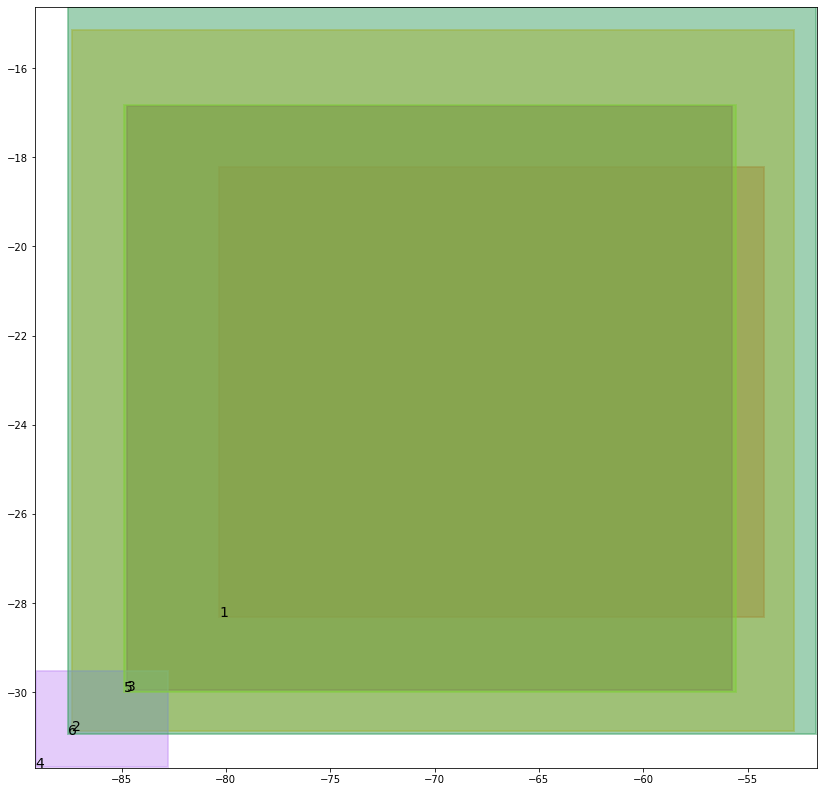

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.24779440462589264 0.9830852150917053 tensor(0.9382452964782715) tensor(0.9886987805366516)
tensor(3) 0.3437168598175049 0.9147247672080994 tensor(0.9225212931632996) tensor(0.9280544519424438)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3483407497406006 0.8993636965751648 tensor(0.9209601879119873) tensor(0.9350701570510864)
tensor(6) 0.22834303975105286 0.9810112714767456 tensor(0.9420520067214966) tensor(0.9888466000556946)


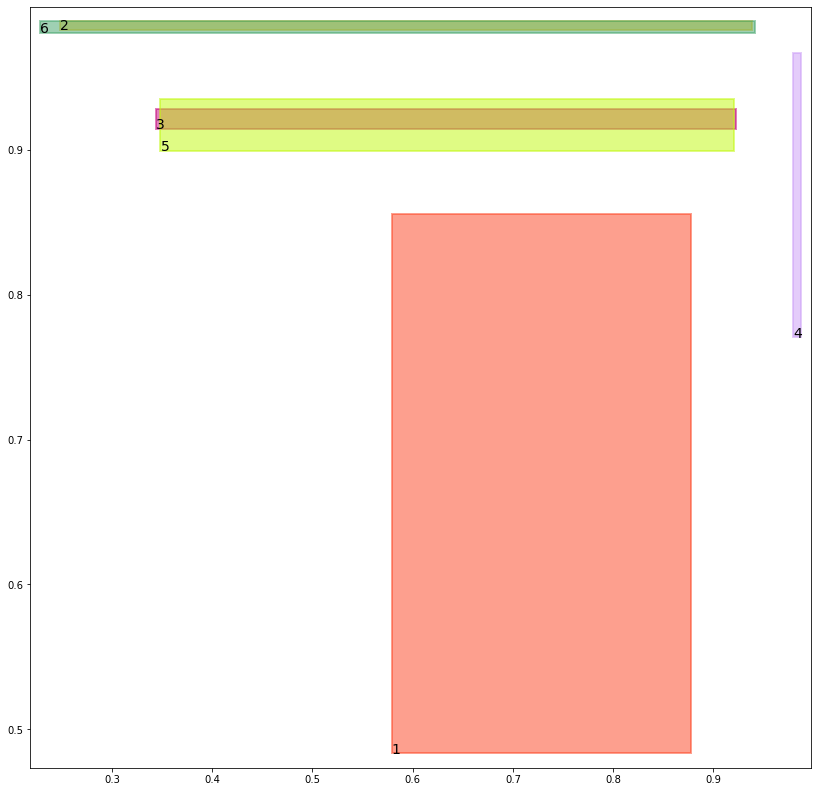

batch (tensor([[3, 5],
        [2, 6],
        [4, 5],
        [1, 2]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.34337615966797 -30.848154067993164 tensor(-52.5612564086914062) tensor(-15.0266990661621094)
tensor(3) -84.64481353759766 -29.91140365600586 tensor(-56.0918998718261719) tensor(-17.0096340179443359)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -85.05973052978516 -30.062227249145508 tensor(-55.1531982421875000) tensor(-16.6419677734375000)
tensor(6) -87.59561920166016 -30.958303451538086 tensor(-51.9042129516601562) tensor(-14.7284030914306641)


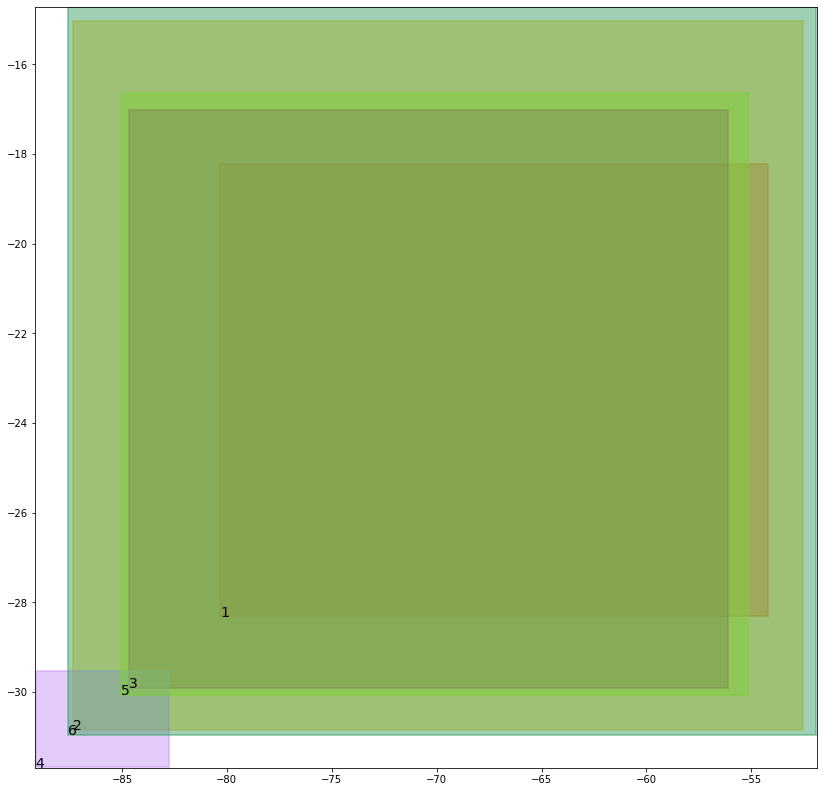

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.24320755898952484 0.9834643006324768 tensor(0.9378558993339539) tensor(0.9884572625160217)
tensor(3) 0.3507921099662781 0.9128702878952026 tensor(0.9201596379280090) tensor(0.9286131262779236)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3405437171459198 0.9000383019447327 tensor(0.9238183498382568) tensor(0.9363563656806946)
tensor(6) 0.23217381536960602 0.9807977080345154 tensor(0.9426270723342896) tensor(0.9892043471336365)


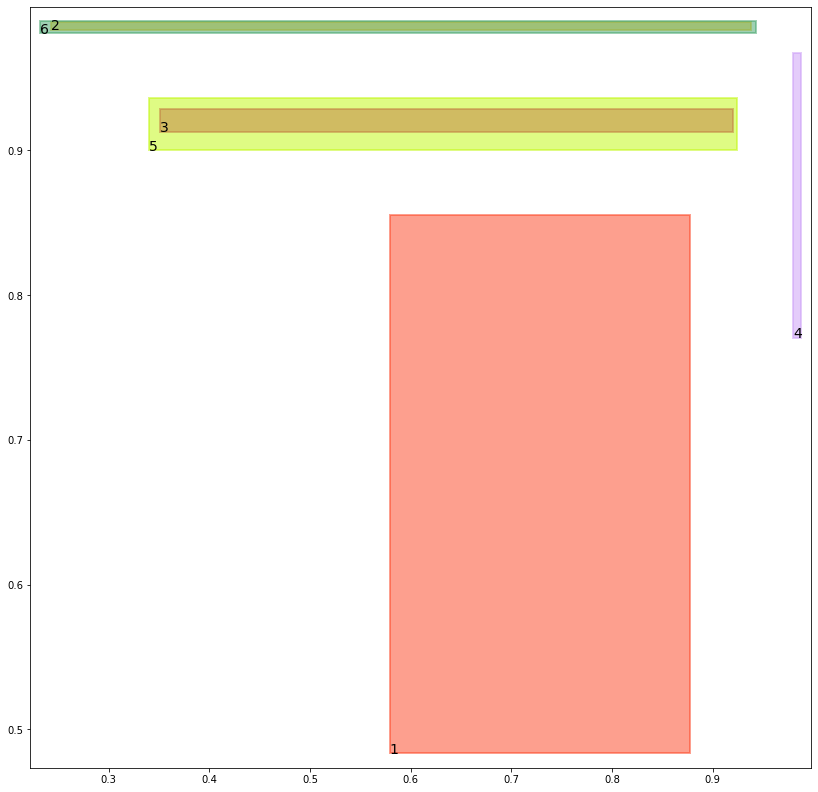

batch (tensor([[3, 5],
        [5, 3],
        [1, 2],
        [2, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.35894012451172 -30.855607986450195 tensor(-52.1913986206054688) tensor(-14.8504905700683594)
tensor(3) -84.62667083740234 -29.897443771362305 tensor(-56.1388931274414062) tensor(-17.0452728271484375)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -85.15303802490234 -30.10173225402832 tensor(-55.0484924316406250) tensor(-16.5838451385498047)
tensor(6) -87.59686279296875 -30.957983016967773 tensor(-52.2476119995117188) tensor(-14.8911380767822266)


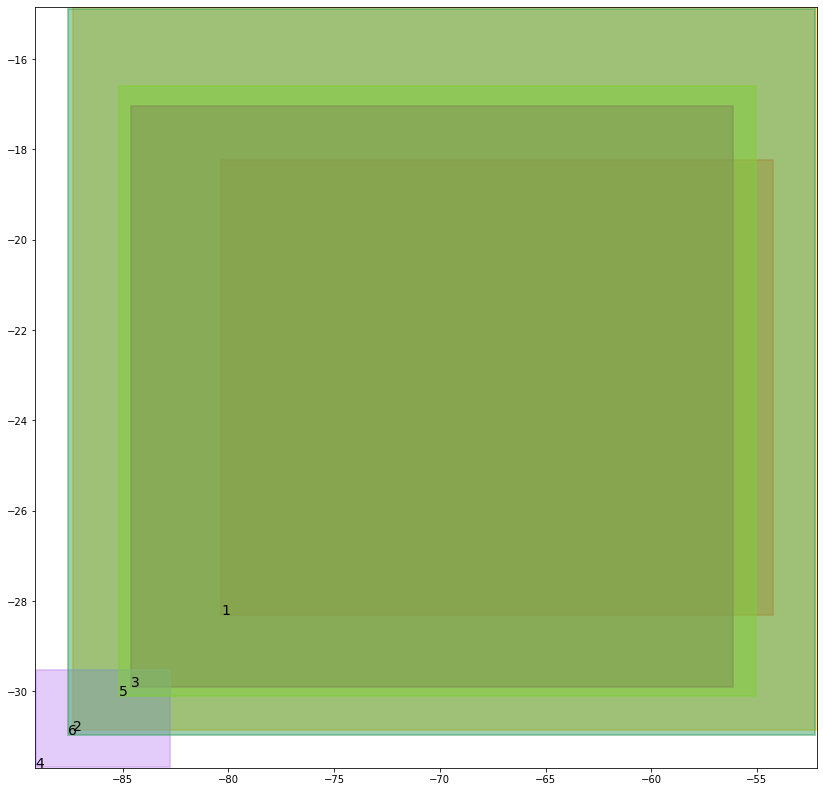

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.23605036735534668 0.9835889339447021 tensor(0.9382403492927551) tensor(0.9883634448051453)
tensor(3) 0.35333219170570374 0.9100058078765869 tensor(0.9189834594726562) tensor(0.9298546910285950)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.33738768100738525 0.9020897150039673 tensor(0.9254121780395508) tensor(0.9368984103202820)
tensor(6) 0.23872007429599762 0.980851948261261 tensor(0.9425309300422668) tensor(0.9893942475318909)


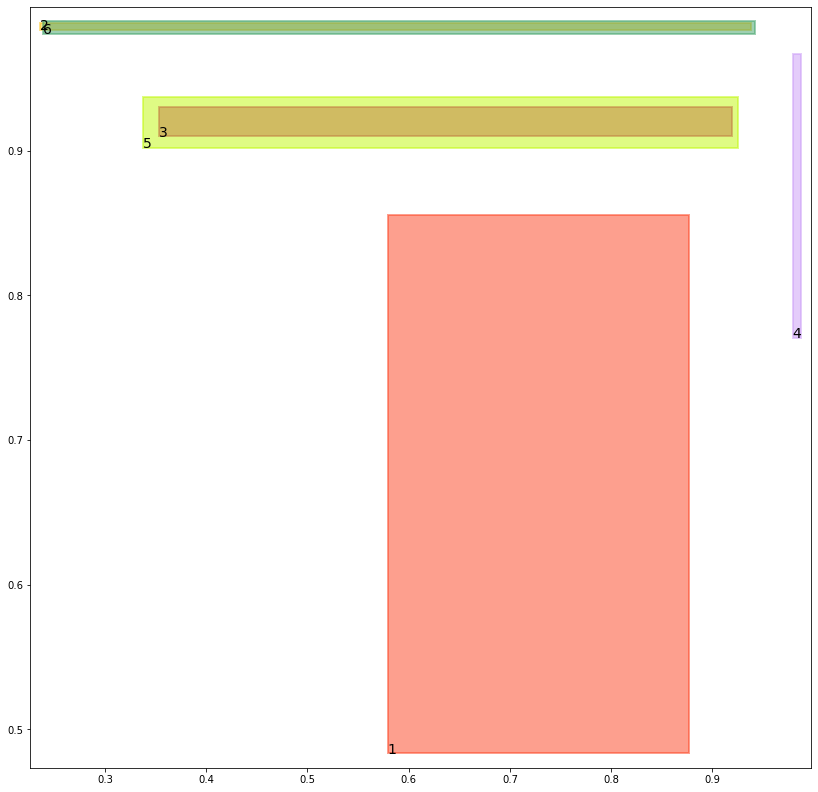

batch (tensor([[4, 5],
        [4, 6],
        [1, 3],
        [6, 2]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.37276458740234 -30.862239837646484 tensor(-52.3310928344726562) tensor(-14.9162311553955078)
tensor(3) -84.6091079711914 -29.884389877319336 tensor(-56.1794738769531250) tensor(-17.0769596099853516)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -85.23588562011719 -30.13679313659668 tensor(-54.9536285400390625) tensor(-16.5313758850097656)
tensor(6) -87.59790802001953 -30.957666397094727 tensor(-52.0762748718261719) tensor(-14.8095512390136719)


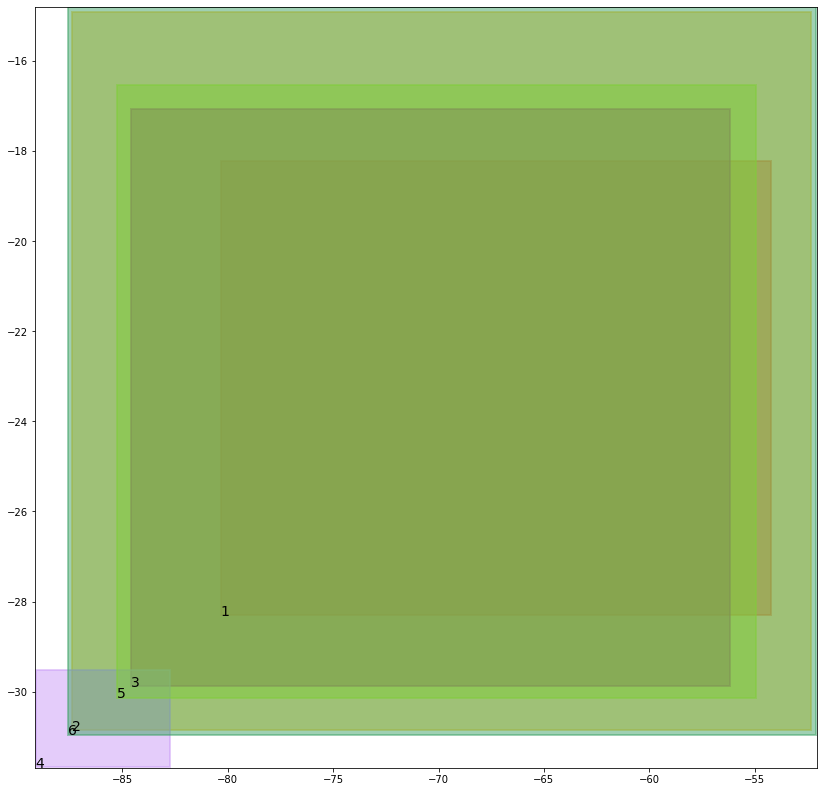

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.23866070806980133 0.9837015867233276 tensor(0.9385836124420166) tensor(0.9882773756980896)
tensor(3) 0.3556326627731323 0.9073469638824463 tensor(0.9179080128669739) tensor(0.9309584498405457)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3345505893230438 0.9039095640182495 tensor(0.9268248081207275) tensor(0.9373840093612671)
tensor(6) 0.23540958762168884 0.9809007048606873 tensor(0.9424440860748291) tensor(0.9895630478858948)


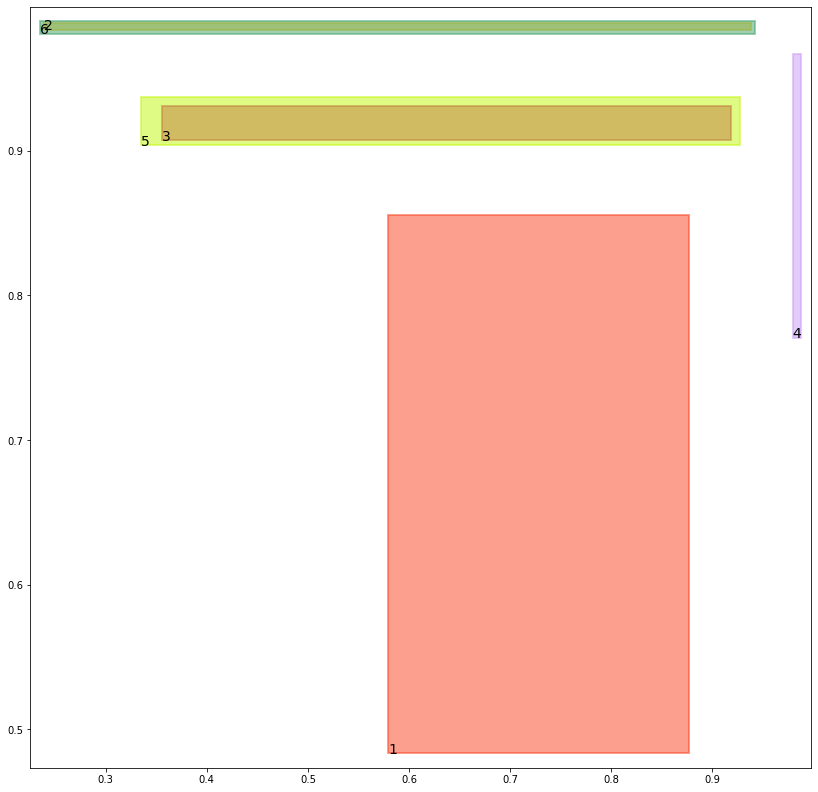

batch (tensor([[1, 3],
        [4, 6],
        [2, 6],
        [5, 3]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.44278717041016 -30.893224716186523 tensor(-52.2133560180664062) tensor(-14.8614253997802734)
tensor(3) -84.59230041503906 -29.87223243713379 tensor(-56.2145690917968750) tensor(-17.1051540374755859)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -85.310302734375 -30.166929244995117 tensor(-54.8677215576171875) tensor(-16.4840126037597656)
tensor(6) -87.54842376708984 -30.935495376586914 tensor(-52.1700134277343750) tensor(-14.8519687652587891)


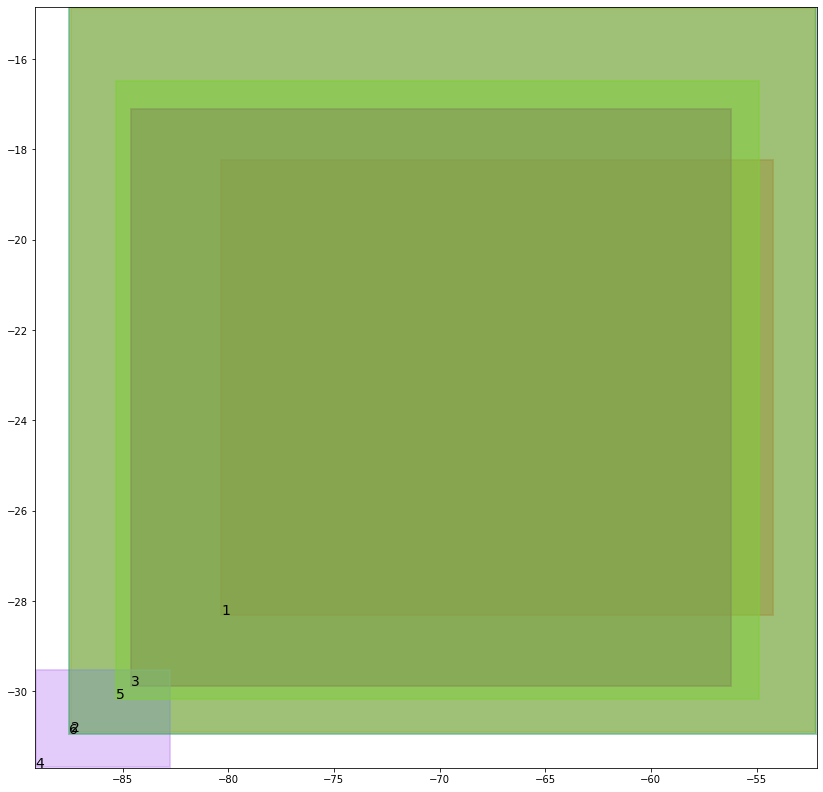

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.23652908205986023 0.9834891557693481 tensor(0.9399650096893311) tensor(0.9883961677551270)
tensor(3) 0.357715368270874 0.9048860669136047 tensor(0.9169258475303650) tensor(0.9319412112236023)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.33199939131736755 0.9055264592170715 tensor(0.9280791282653809) tensor(0.9378195405006409)
tensor(6) 0.23696771264076233 0.9813087582588196 tensor(0.9414305686950684) tensor(0.9895368814468384)


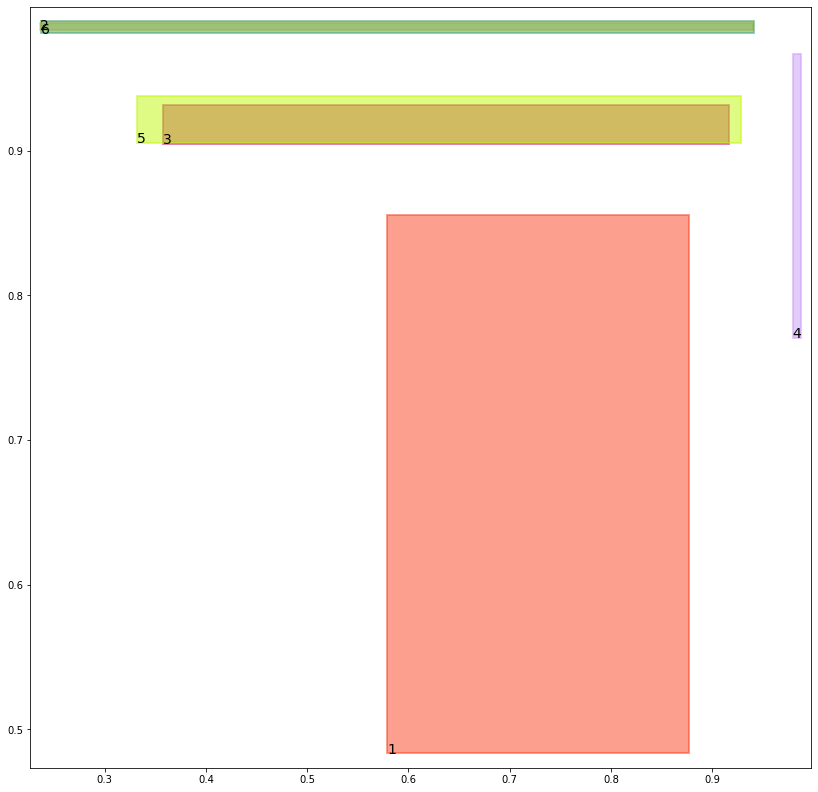

batch (tensor([[6, 2],
        [4, 5],
        [3, 5],
        [1, 2]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.5047607421875 -30.92064666748047 tensor(-52.3398666381835938) tensor(-14.9224672317504883)
tensor(3) -84.68534088134766 -29.90534019470215 tensor(-55.9285163879394531) tensor(-16.9850635528564453)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -85.28864288330078 -30.15920066833496 tensor(-55.0913314819335938) tensor(-16.5792942047119141)
tensor(6) -87.50305938720703 -30.915170669555664 tensor(-52.0185241699218750) tensor(-14.7782135009765625)


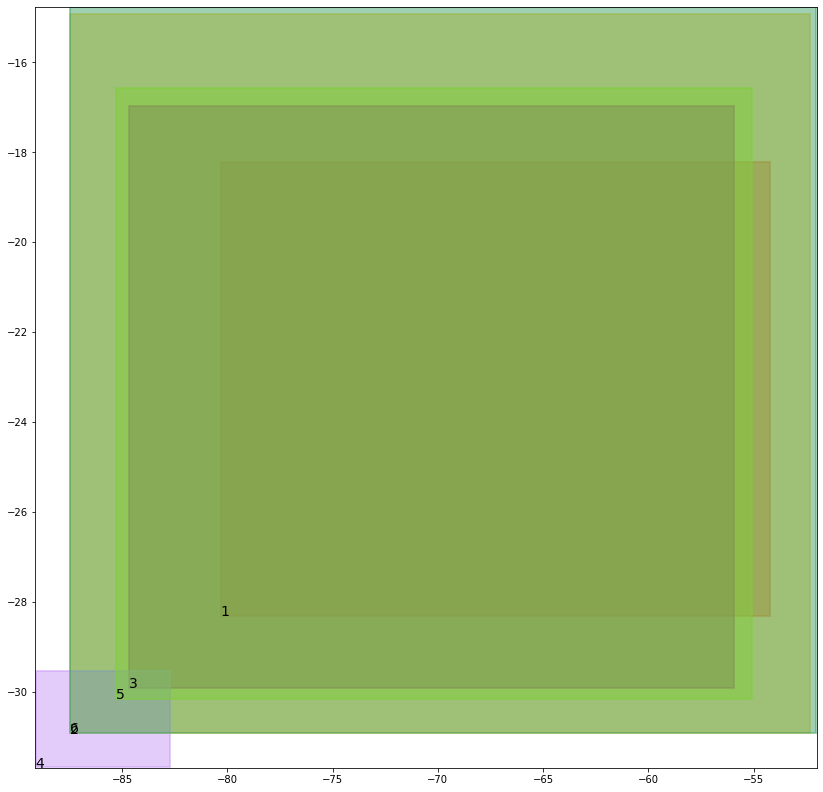

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.23906531929969788 0.9832950234413147 tensor(0.9411869049072266) tensor(0.9885023832321167)
tensor(3) 0.353645384311676 0.9026142358779907 tensor(0.9176471233367920) tensor(0.9338317513465881)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3353462815284729 0.907016396522522 tensor(0.9279416203498840) tensor(0.9373274445533752)
tensor(6) 0.23385581374168396 0.9816696643829346 tensor(0.9405013322830200) tensor(0.9895132184028625)


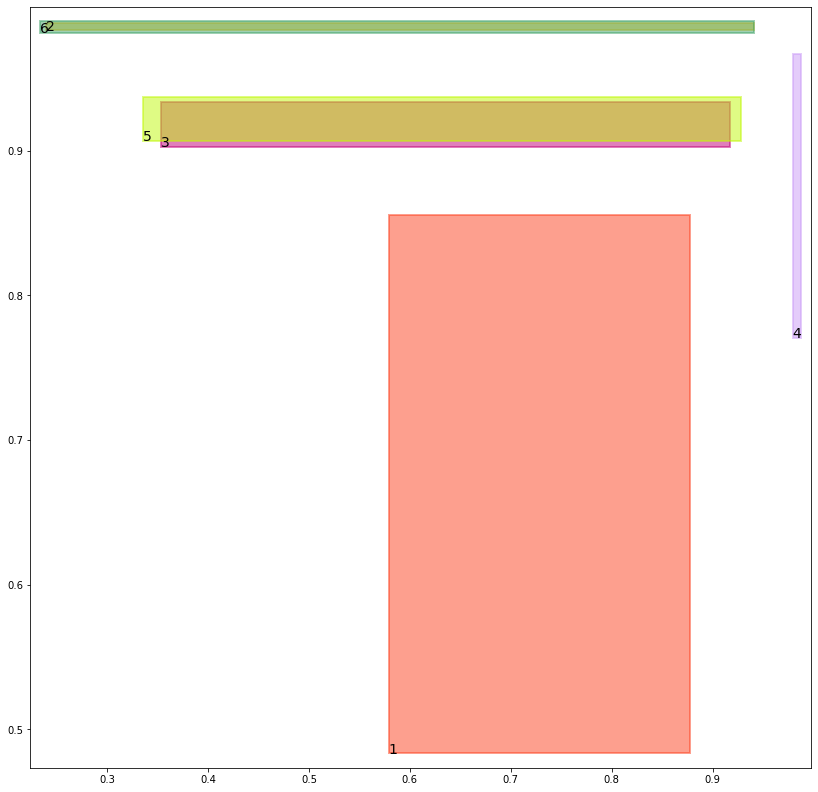

batch (tensor([[1, 3],
        [1, 2],
        [5, 3],
        [2, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.56551361083984 -30.946699142456055 tensor(-52.2095222473144531) tensor(-14.8632087707519531)
tensor(3) -84.76750183105469 -29.93460464477539 tensor(-55.7364807128906250) tensor(-16.8967475891113281)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -85.26897430419922 -30.152189254760742 tensor(-55.2346572875976562) tensor(-16.6479396820068359)
tensor(6) -87.45575714111328 -30.894811630249023 tensor(-52.1257514953613281) tensor(-14.8257980346679688)


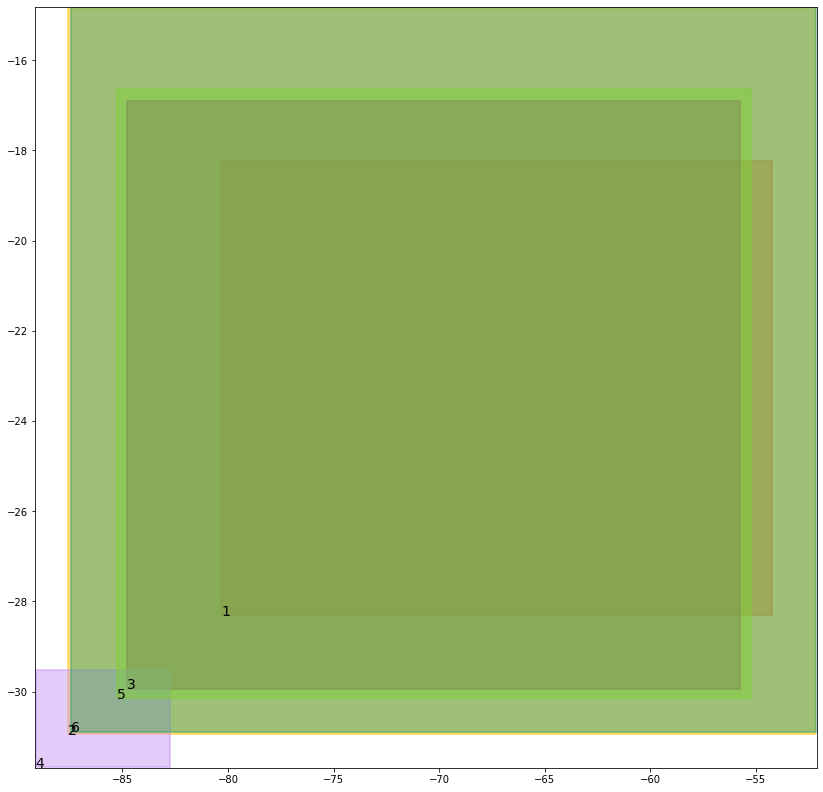

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.23686695098876953 0.9827824234962463 tensor(0.9422700405120850) tensor(0.9887849092483521)
tensor(3) 0.35000771284103394 0.9026556015014648 tensor(0.9182885289192200) tensor(0.9354943633079529)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.33838218450546265 0.9064304828643799 tensor(0.9278173446655273) tensor(0.9368799924850464)
tensor(6) 0.2355310022830963 0.9823207855224609 tensor(0.9396468400955200) tensor(0.9893108606338501)


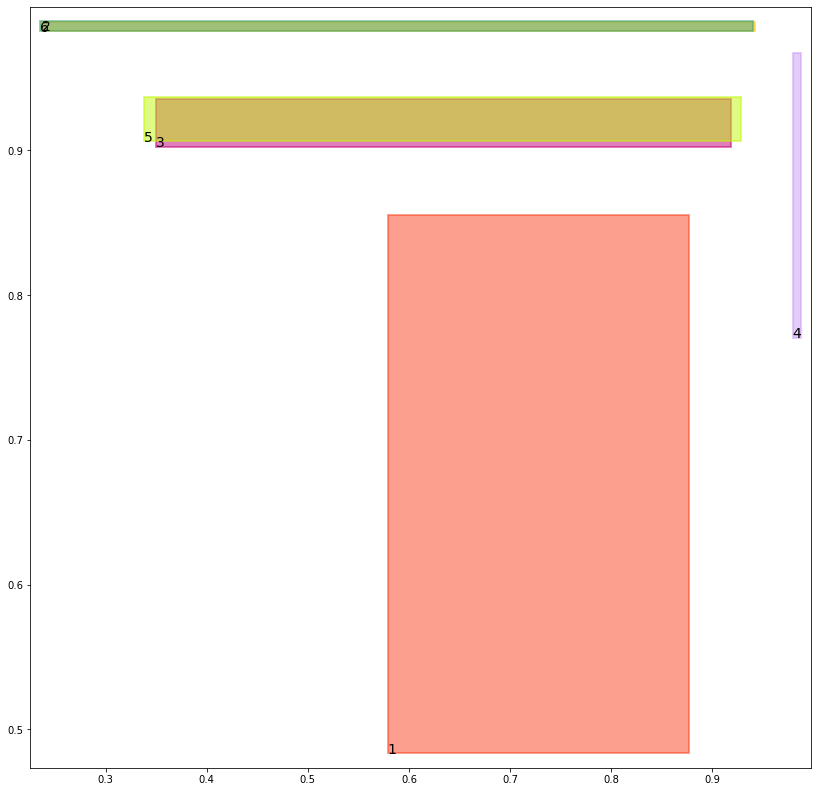

batch (tensor([[4, 6],
        [6, 2],
        [3, 5],
        [4, 5]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.5726547241211 -30.948759078979492 tensor(-52.0922927856445312) tensor(-14.8099842071533203)
tensor(3) -84.94336700439453 -30.002704620361328 tensor(-55.2552871704101562) tensor(-16.6757717132568359)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -85.16085815429688 -30.11057472229004 tensor(-55.6709747314453125) tensor(-16.8506183624267578)
tensor(6) -87.46160888671875 -30.8983097076416 tensor(-52.2223472595214844) tensor(-14.8687496185302734)


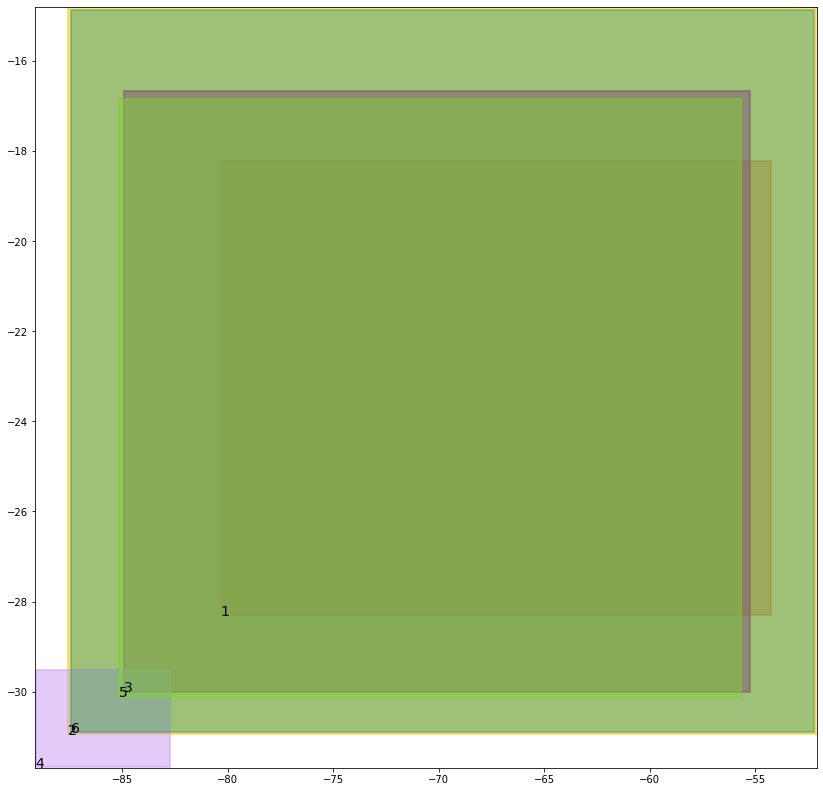

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.23489810526371002 0.9823070168495178 tensor(0.9422587156295776) tensor(0.9890338182449341)
tensor(3) 0.34093064069747925 0.9026930332183838 tensor(0.9204151034355164) tensor(0.9378810524940491)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.346884548664093 0.9059261679649353 tensor(0.9264274835586548) tensor(0.9355568885803223)
tensor(6) 0.23705045878887177 0.9828890562057495 tensor(0.9398883581161499) tensor(0.9891247749328613)


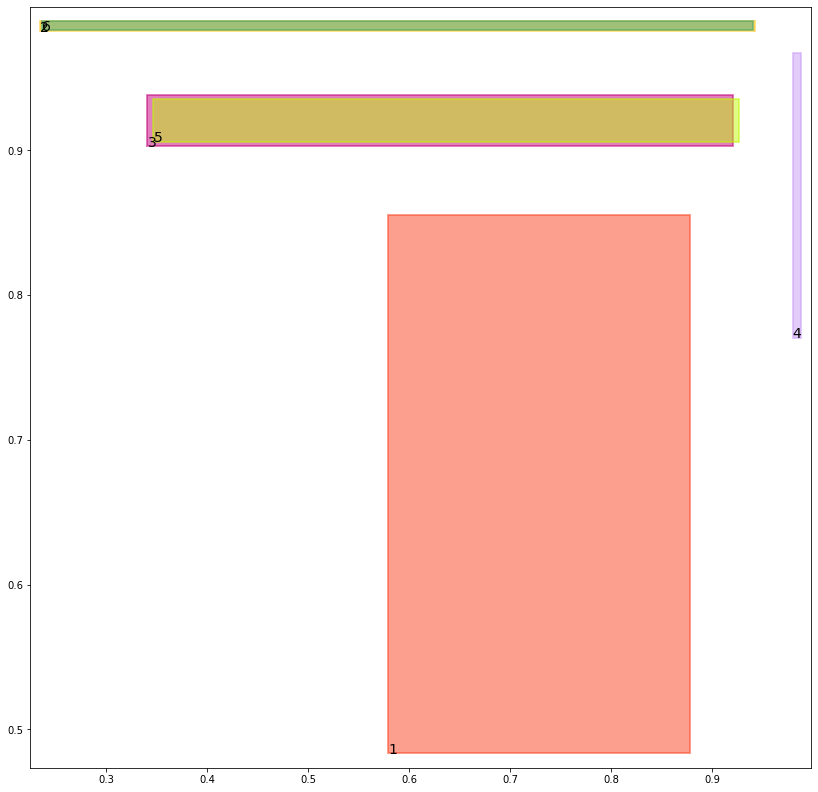

batch (tensor([[4, 6],
        [1, 2],
        [3, 5],
        [1, 3]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.57896423339844 -30.950572967529297 tensor(-51.9866371154785156) tensor(-14.7620754241943359)
tensor(3) -85.23458862304688 -30.124181747436523 tensor(-54.8261184692382812) tensor(-16.4786834716796875)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -84.93355560302734 -30.01481819152832 tensor(-56.0711441040039062) tensor(-17.0364074707031250)
tensor(6) -87.46678161621094 -30.90143394470215 tensor(-52.3093795776367188) tensor(-14.9075288772583008)


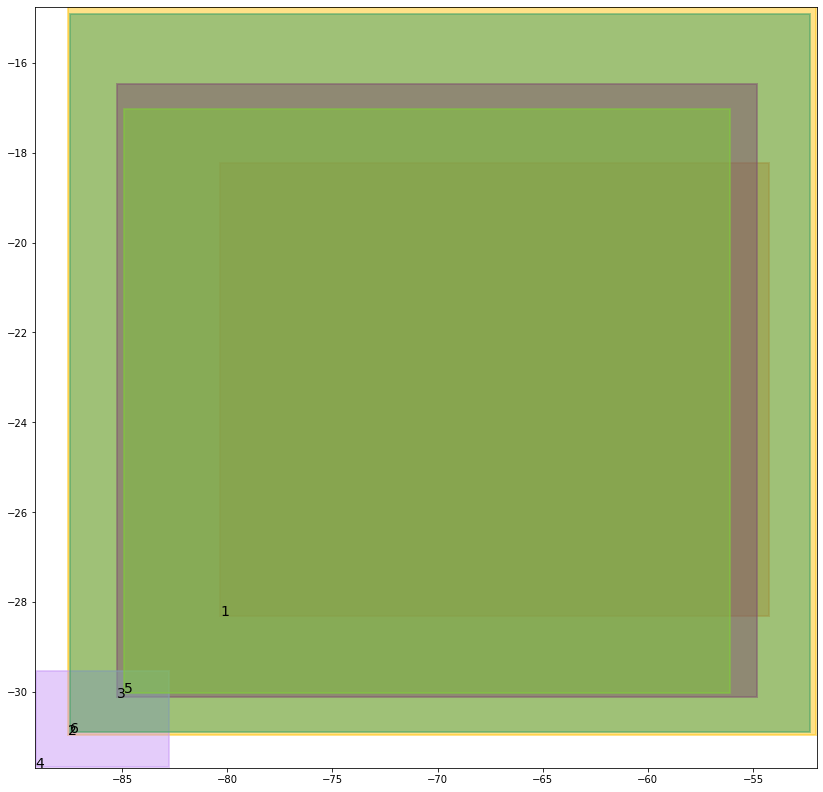

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.23313045501708984 0.981866717338562 tensor(0.9422485232353210) tensor(0.9892538785934448)
tensor(3) 0.33283478021621704 0.9027267098426819 tensor(0.9251380562782288) tensor(0.9399645924568176)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.354670912027359 0.9054837822914124 tensor(0.9224923849105835) tensor(0.9343330860137939)
tensor(6) 0.2384280413389206 0.9833866953849792 tensor(0.9401056766510010) tensor(0.9889540672302246)


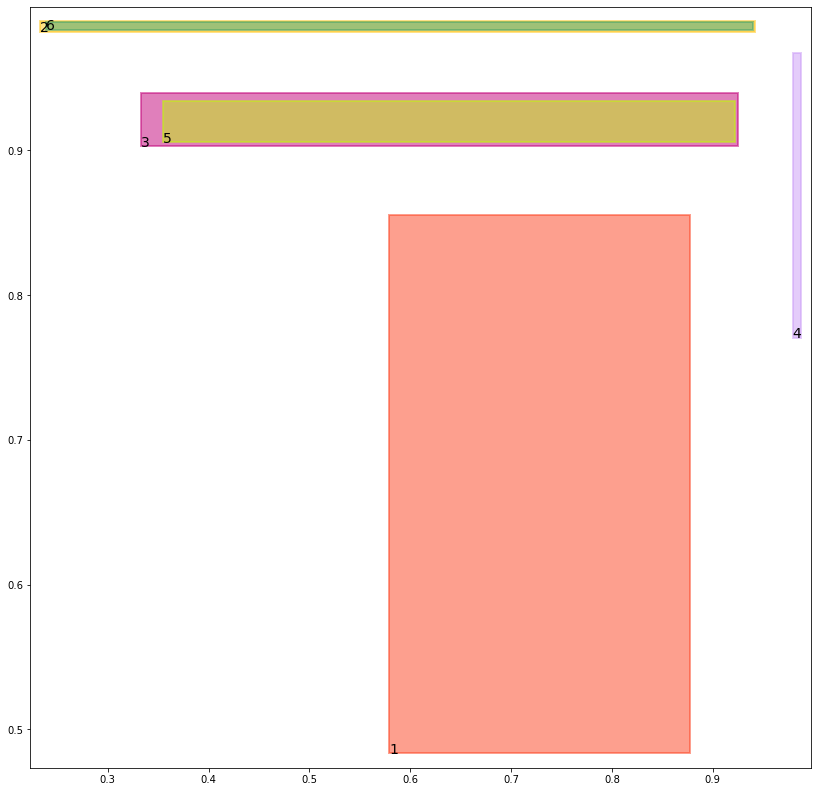

batch (tensor([[4, 5],
        [2, 6],
        [6, 2],
        [5, 3]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.54935455322266 -30.936845779418945 tensor(-52.0523223876953125) tensor(-14.7939720153808594)
tensor(3) -85.42630767822266 -30.20462417602539 tensor(-54.6881713867187500) tensor(-16.4082069396972656)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -84.78792572021484 -29.951406478881836 tensor(-56.1818466186523438) tensor(-17.0957622528076172)
tensor(6) -87.50743865966797 -30.91985511779785 tensor(-52.2223701477050781) tensor(-14.8649387359619141)


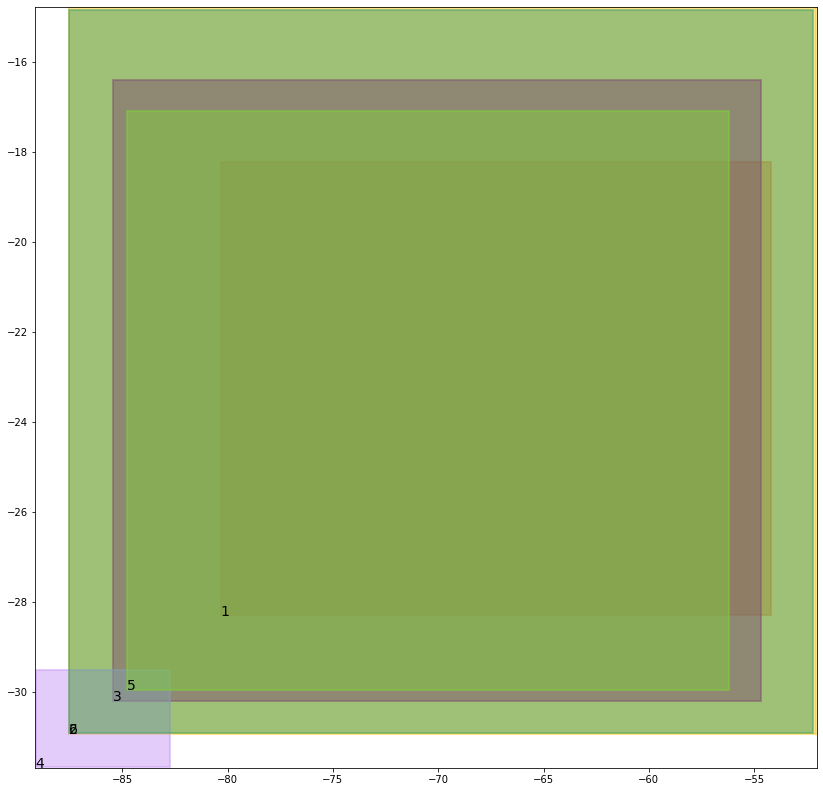

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.23447050154209137 0.9817259907722473 tensor(0.9415784478187561) tensor(0.9893372058868408)
tensor(3) 0.3293945789337158 0.9041871428489685 tensor(0.9283125400543213) tensor(0.9412349462509155)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.35776111483573914 0.9037415981292725 tensor(0.9197633266448975) tensor(0.9338622093200684)
tensor(6) 0.23661455512046814 0.9836390018463135 tensor(0.9409664869308472) tensor(0.9889318943023682)


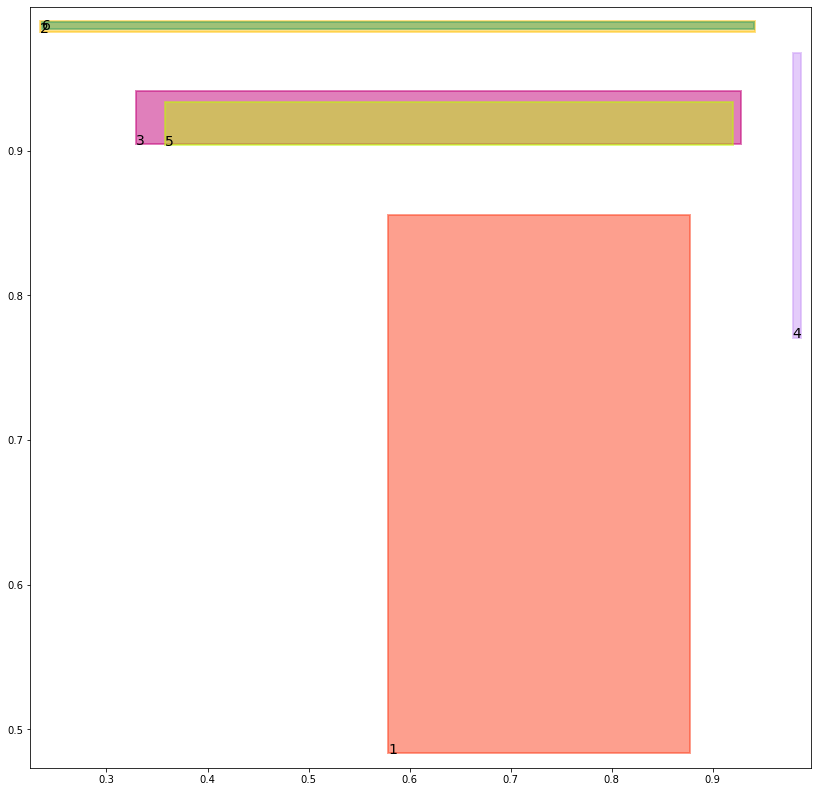

batch (tensor([[6, 2],
        [4, 5],
        [2, 6],
        [1, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.46794891357422 -30.900609970092773 tensor(-52.3563613891601562) tensor(-14.9369316101074219)
tensor(3) -85.59444427490234 -30.273435592651367 tensor(-54.5639419555664062) tensor(-16.3448104858398438)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -84.65277862548828 -29.892518997192383 tensor(-56.2815628051757812) tensor(-17.1493701934814453)
tensor(6) -87.5959243774414 -30.95887565612793 tensor(-51.9019699096679688) tensor(-14.7130947113037109)


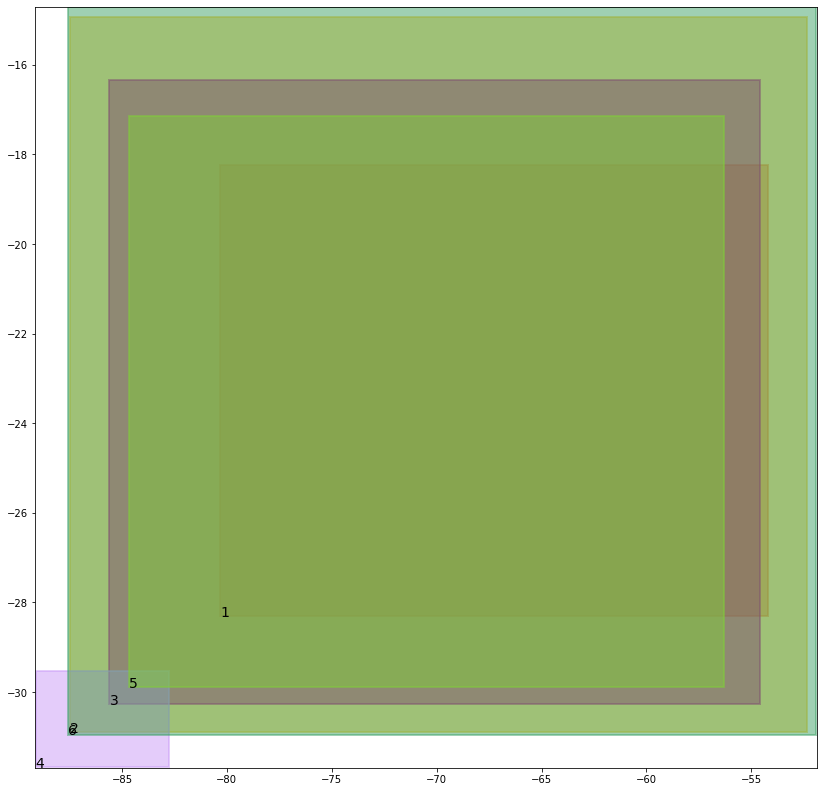

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.2401382476091385 0.9819942116737366 tensor(0.9399431347846985) tensor(0.9892448186874390)
tensor(3) 0.32630449533462524 0.9054887294769287 tensor(0.9310711026191711) tensor(0.9423601031303406)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3605610132217407 0.9021442532539368 tensor(0.9172246456146240) tensor(0.9334344267845154)
tensor(6) 0.23050576448440552 0.9835900664329529 tensor(0.9426934123039246) tensor(0.9891108870506287)


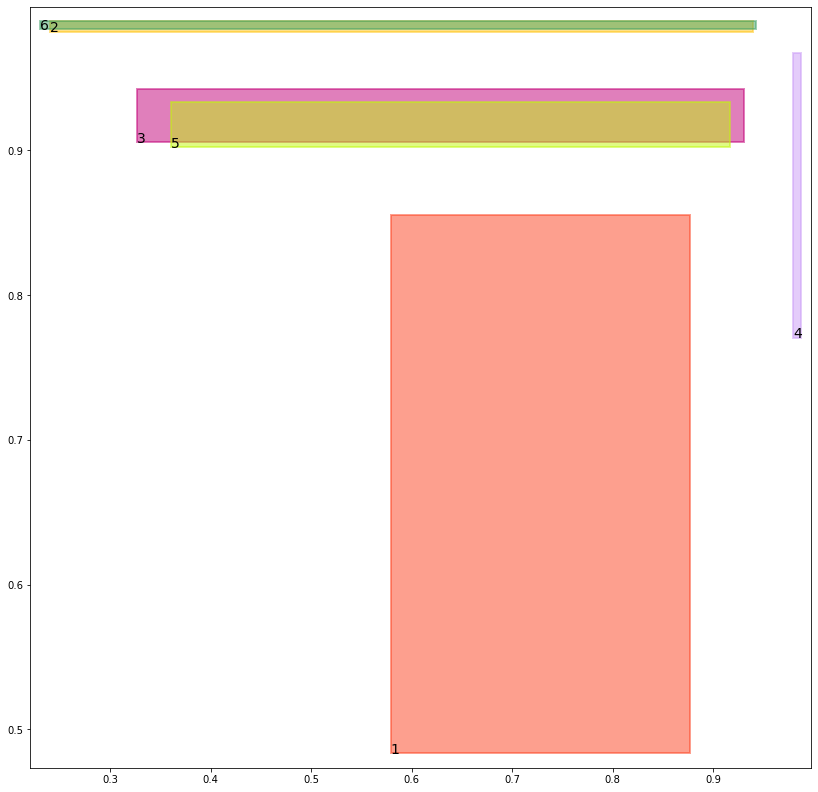

batch (tensor([[5, 3],
        [1, 3],
        [4, 6],
        [3, 5]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.39268493652344 -30.867094039916992 tensor(-52.6348953247070312) tensor(-15.0679349899291992)
tensor(3) -85.66224670410156 -30.301206588745117 tensor(-54.6918640136718750) tensor(-16.4072952270507812)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -84.63640594482422 -29.882368087768555 tensor(-56.1175155639648438) tensor(-17.0708332061767578)
tensor(6) -87.67374420166016 -30.99319839477539 tensor(-51.6177139282226562) tensor(-14.5783843994140625)


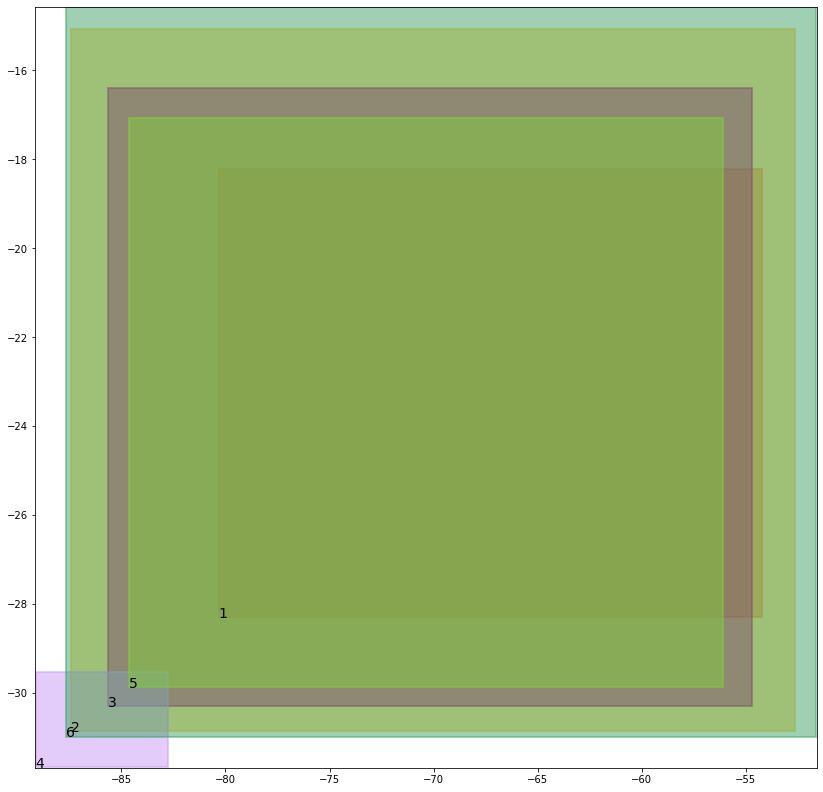

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.245334655046463 0.9822331666946411 tensor(0.9384301900863647) tensor(0.9891607165336609)
tensor(3) 0.32915738224983215 0.9047179222106934 tensor(0.9323291778564453) tensor(0.9425678849220276)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.35709020495414734 0.9028076529502869 tensor(0.9164999723434448) tensor(0.9340316057205200)
tensor(6) 0.22508662939071655 0.9835457801818848 tensor(0.9442114830017090) tensor(0.9892700314521790)


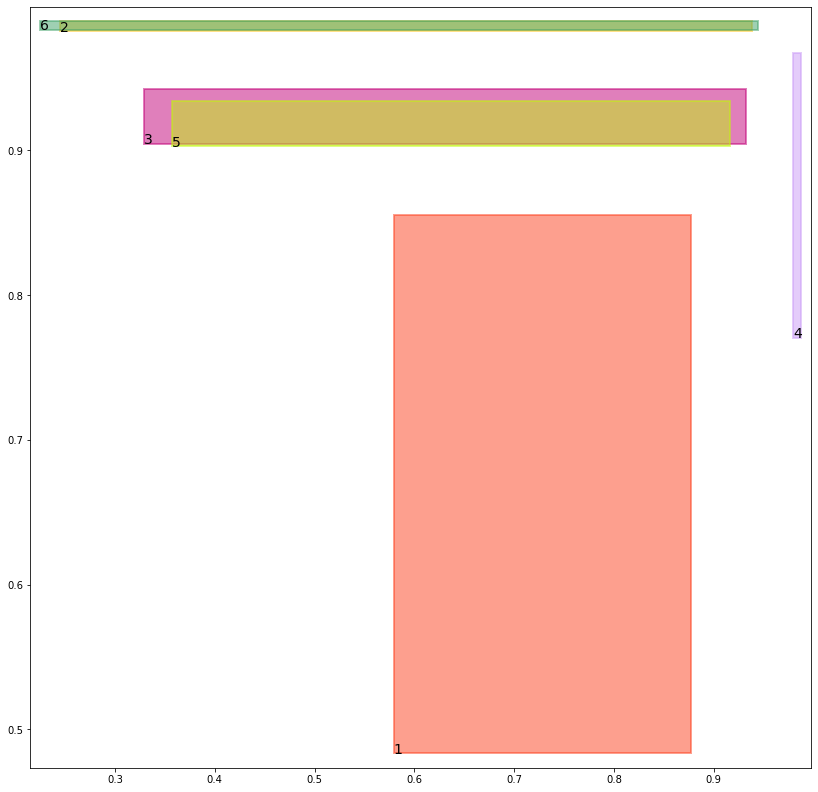

batch (tensor([[1, 3],
        [5, 3],
        [2, 6],
        [6, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.3629379272461 -30.853515625 tensor(-52.7321701049804688) tensor(-15.1117744445800781)
tensor(3) -85.66983795166016 -30.3053035736084 tensor(-55.0111007690429688) tensor(-16.5570011138916016)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -84.69342803955078 -29.902563095092773 tensor(-55.7599983215332031) tensor(-16.9038639068603516)
tensor(6) -87.71038055419922 -31.00962257385254 tensor(-51.5072021484375000) tensor(-14.5270633697509766)


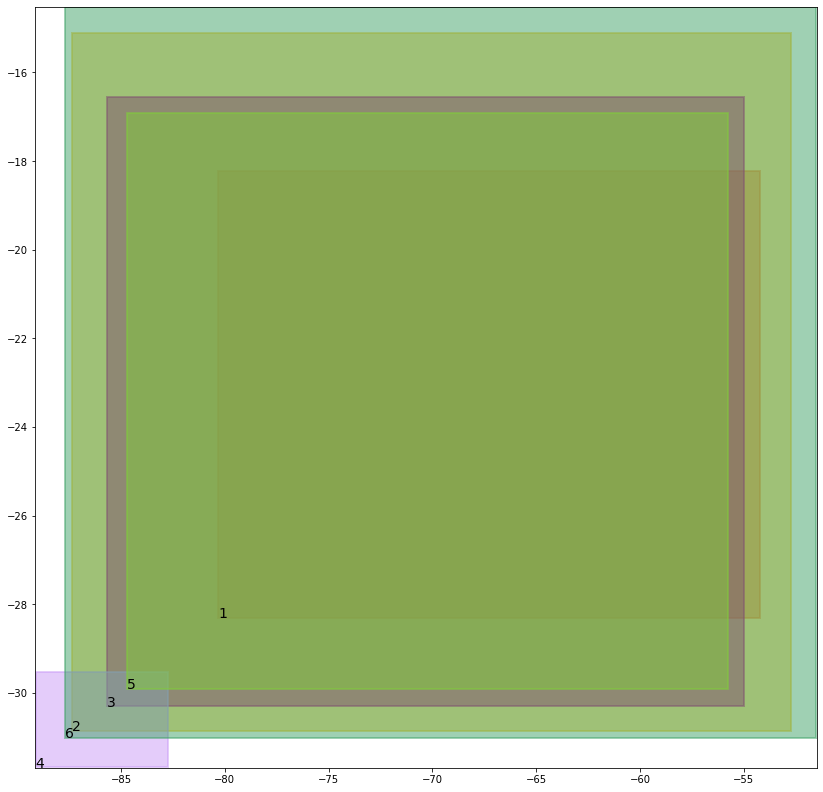

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.2469315081834793 0.9826906323432922 tensor(0.9377864003181458) tensor(0.9891987442970276)
tensor(3) 0.3355444669723511 0.9040611386299133 tensor(0.9326975345611572) tensor(0.9422253966331482)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.35001808404922485 0.9034031629562378 tensor(0.9169299602508545) tensor(0.9352087378501892)
tensor(6) 0.22309979796409607 0.9833225011825562 tensor(0.9449644088745117) tensor(0.9892849326133728)


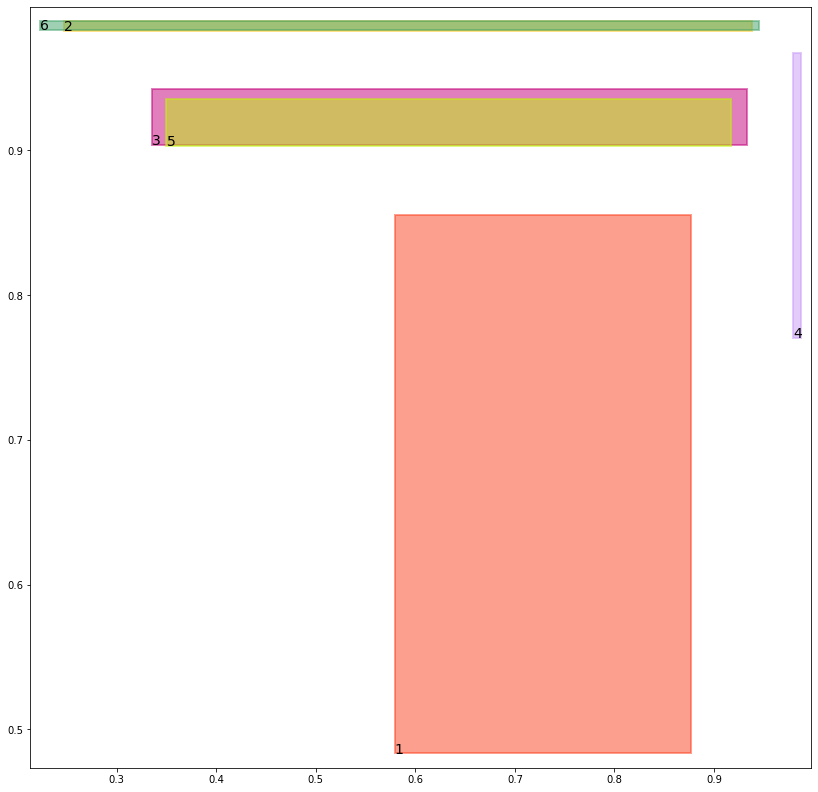

batch (tensor([[4, 6],
        [3, 5],
        [1, 2],
        [4, 5]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.33582305908203 -30.841142654418945 tensor(-52.8199806213378906) tensor(-15.1514053344726562)
tensor(3) -85.67658233642578 -30.30895233154297 tensor(-55.1732215881347656) tensor(-16.6549148559570312)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -84.74419403076172 -29.920560836791992 tensor(-55.5634155273437500) tensor(-16.7913608551025391)
tensor(6) -87.74303436279297 -31.024274826049805 tensor(-51.4079399108886719) tensor(-14.4809837341308594)


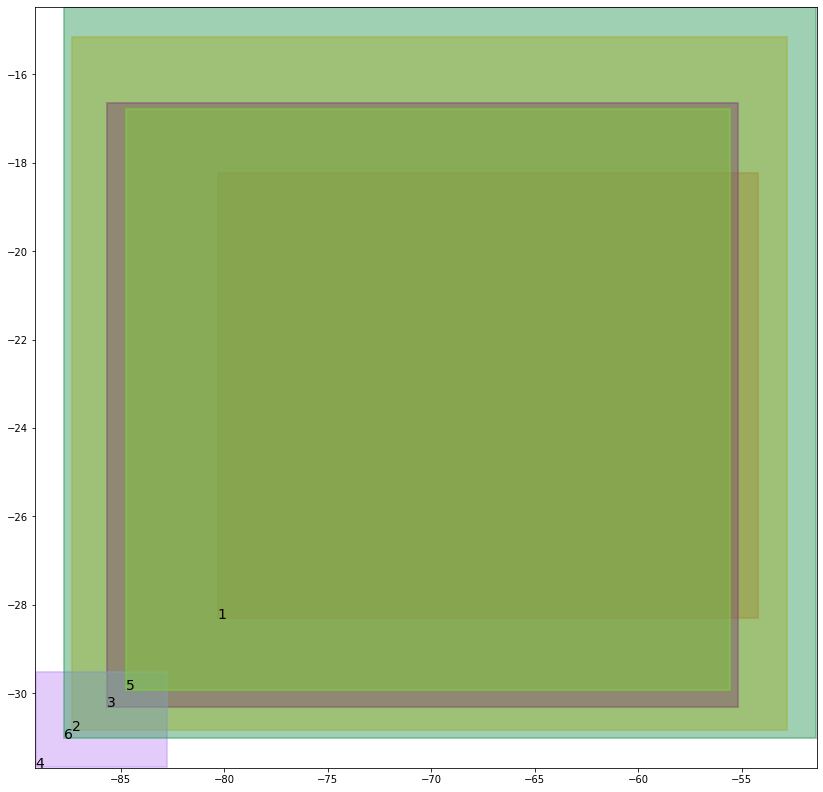

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.24837899208068848 0.9830938577651978 tensor(0.9371999502182007) tensor(0.9892330169677734)
tensor(3) 0.34136244654655457 0.8992738127708435 tensor(0.9330284595489502) tensor(0.9419145584106445)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3436955213546753 0.9079416394233704 tensor(0.9173147678375244) tensor(0.9362539649009705)
tensor(6) 0.22131706774234772 0.98311847448349 tensor(0.9456357359886169) tensor(0.9892984628677368)


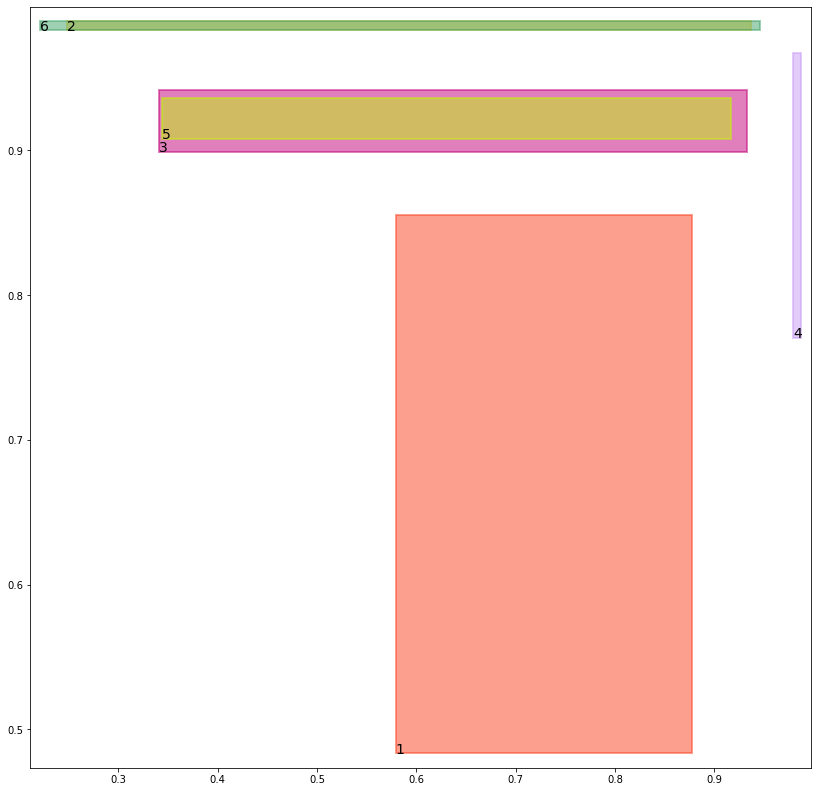

batch (tensor([[1, 2],
        [4, 6],
        [5, 3],
        [2, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.37179565429688 -30.85642433166504 tensor(-52.6508750915527344) tensor(-15.0693149566650391)
tensor(3) -85.60297393798828 -30.281160354614258 tensor(-55.7035026550292969) tensor(-16.9087238311767578)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -84.89397430419922 -29.979475021362305 tensor(-55.0235748291015625) tensor(-16.5334148406982422)
tensor(6) -87.72528839111328 -31.017122268676758 tensor(-51.5381393432617188) tensor(-14.5437088012695312)


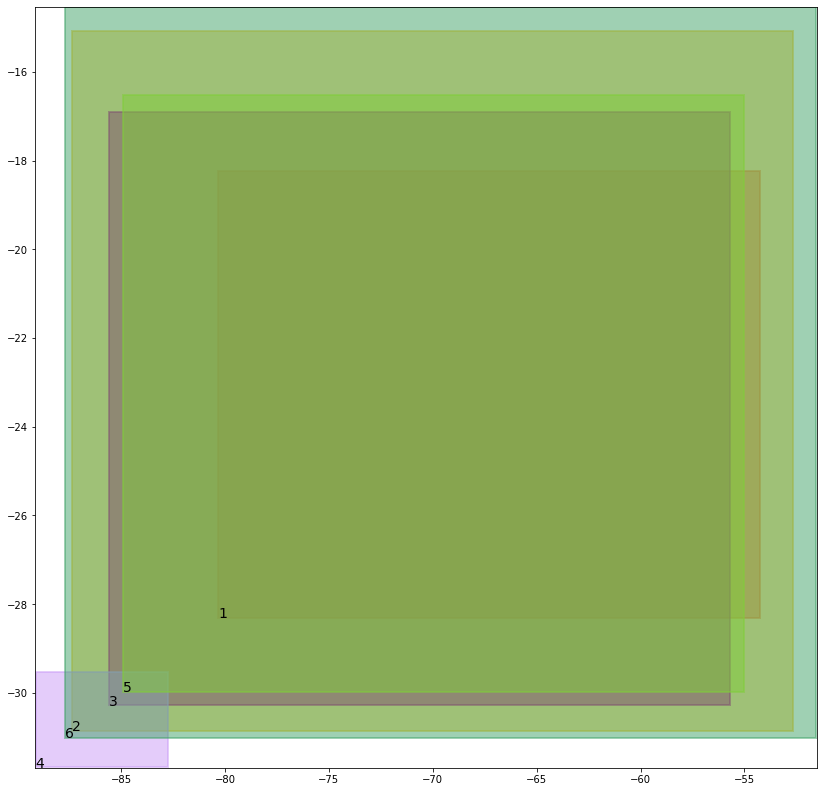

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.2449326515197754 0.9834497570991516 tensor(0.9378212094306946) tensor(0.9894315004348755)
tensor(3) 0.3525758683681488 0.8971383571624756 tensor(0.9322061538696289) tensor(0.9408144950866699)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3323318660259247 0.9100255966186523 tensor(0.9192519187927246) tensor(0.9380907416343689)
tensor(6) 0.22391586005687714 0.9829385280609131 tensor(0.9453825354576111) tensor(0.9891174435615540)


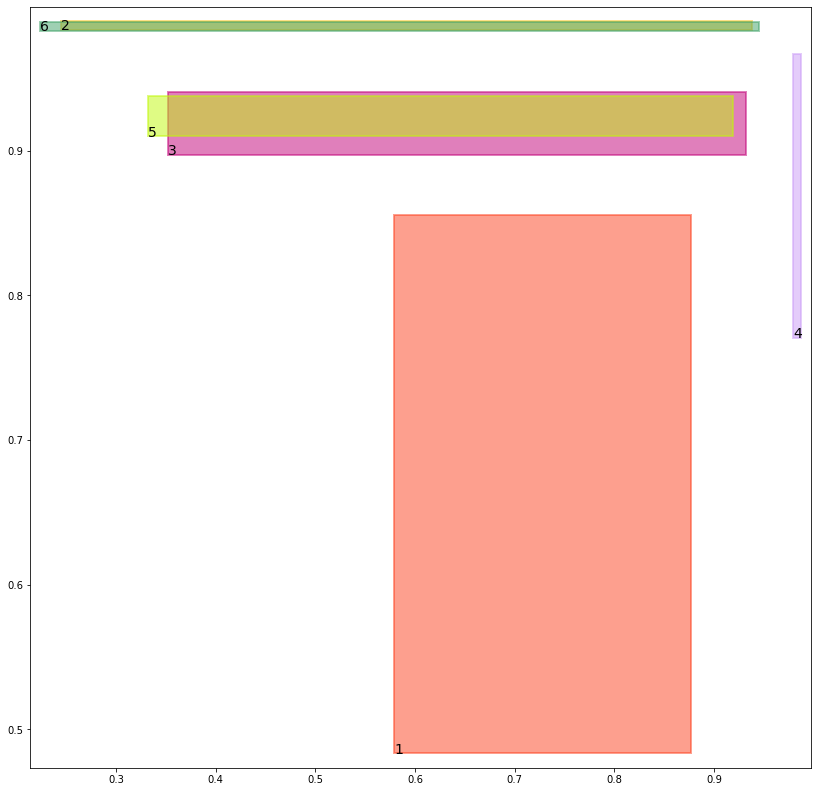

batch (tensor([[3, 5],
        [1, 3],
        [6, 2],
        [4, 5]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.39889526367188 -30.868568420410156 tensor(-52.4995422363281250) tensor(-14.9958724975585938)
tensor(3) -85.5356216430664 -30.255739212036133 tensor(-55.8677597045898438) tensor(-16.9937343597412109)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -85.02528381347656 -30.03114891052246 tensor(-54.8429069519042969) tensor(-16.4413414001464844)
tensor(6) -87.71519470214844 -31.01243782043457 tensor(-51.6566009521484375) tensor(-14.6007766723632812)


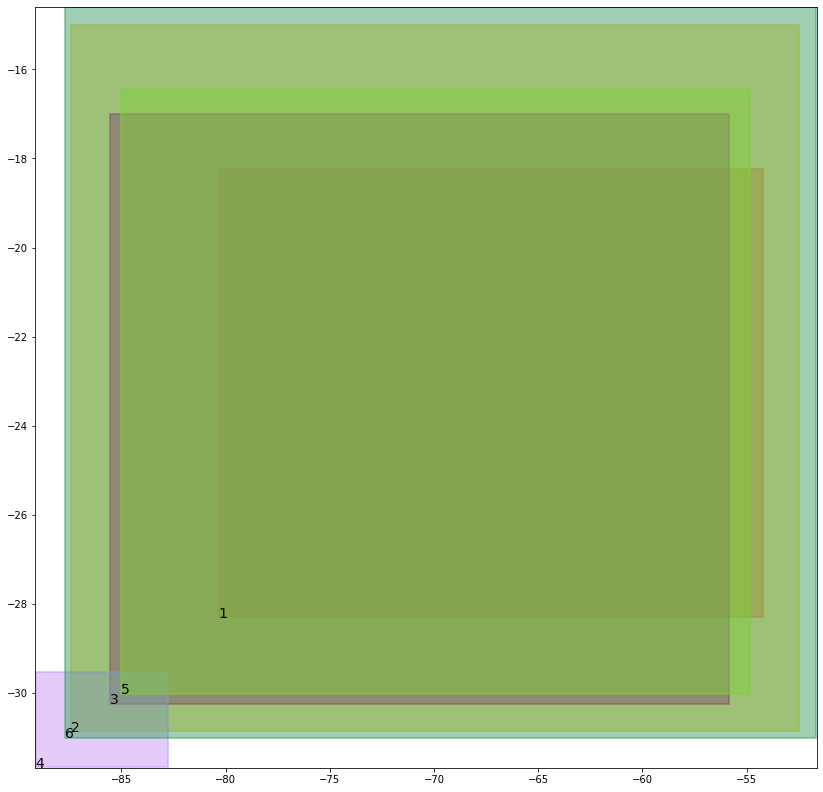

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.2418506145477295 0.9837648272514343 tensor(0.9383769035339355) tensor(0.9894447922706604)
tensor(3) 0.35680103302001953 0.8951764106750488 tensor(0.9314556717872620) tensor(0.9398048520088196)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.32785269618034363 0.911892831325531 tensor(0.9209537506103516) tensor(0.9396953582763672)
tensor(6) 0.2262803167104721 0.982774555683136 tensor(0.9451529979705811) tensor(0.9891475439071655)


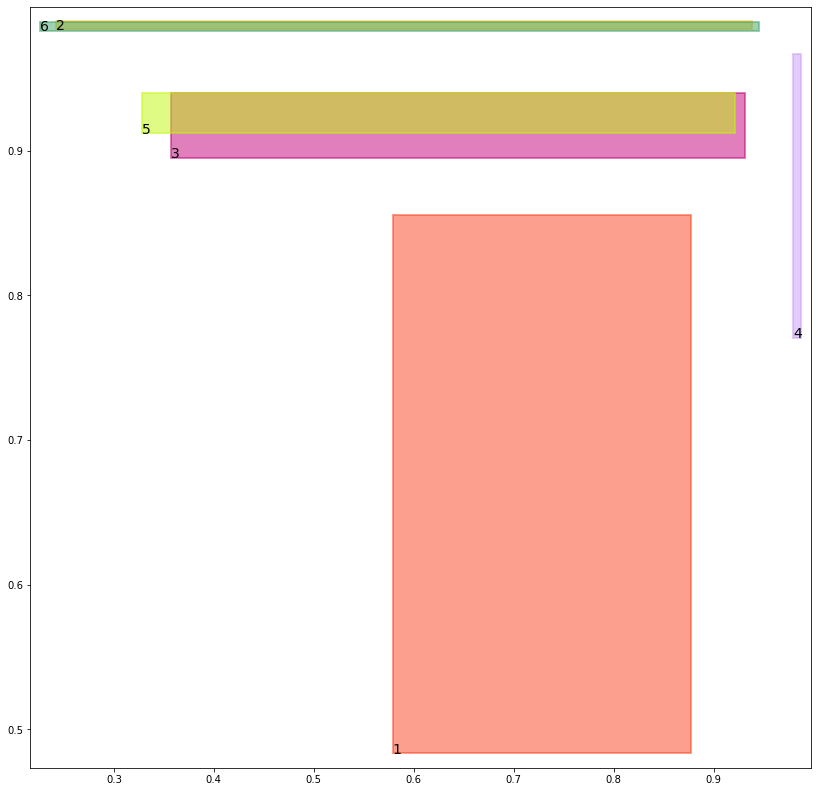

batch (tensor([[6, 2],
        [5, 3],
        [1, 3],
        [4, 5]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.41805267333984 -30.877910614013672 tensor(-52.3640289306640625) tensor(-14.9301185607910156)
tensor(3) -85.38972473144531 -30.199628829956055 tensor(-56.0964241027832031) tensor(-17.0954799652099609)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -85.23561096191406 -30.115537643432617 tensor(-54.6271820068359375) tensor(-16.3427257537841797)
tensor(6) -87.71195220947266 -31.00995635986328 tensor(-51.7642784118652344) tensor(-14.6526527404785156)


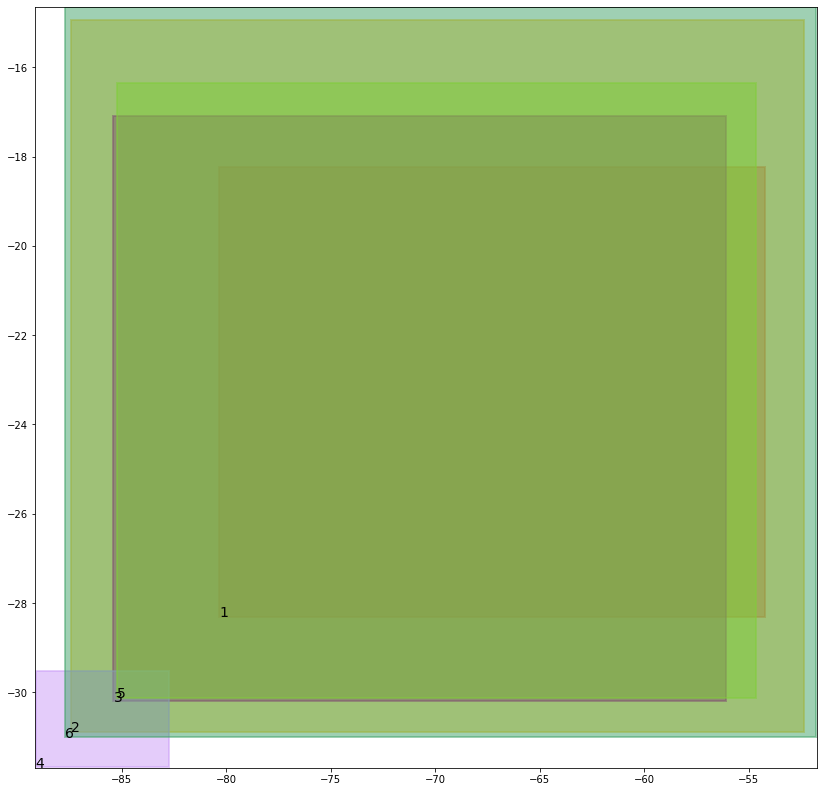

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.23909227550029755 0.9840441346168518 tensor(0.9388741850852966) tensor(0.9892914891242981)
tensor(3) 0.3607306182384491 0.8958226442337036 tensor(0.9295908212661743) tensor(0.9380021095275879)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.32383614778518677 0.9118183255195618 tensor(0.9239026904106140) tensor(0.9419188499450684)
tensor(6) 0.22842980921268463 0.9826251268386841 tensor(0.9449449777603149) tensor(0.9893661737442017)


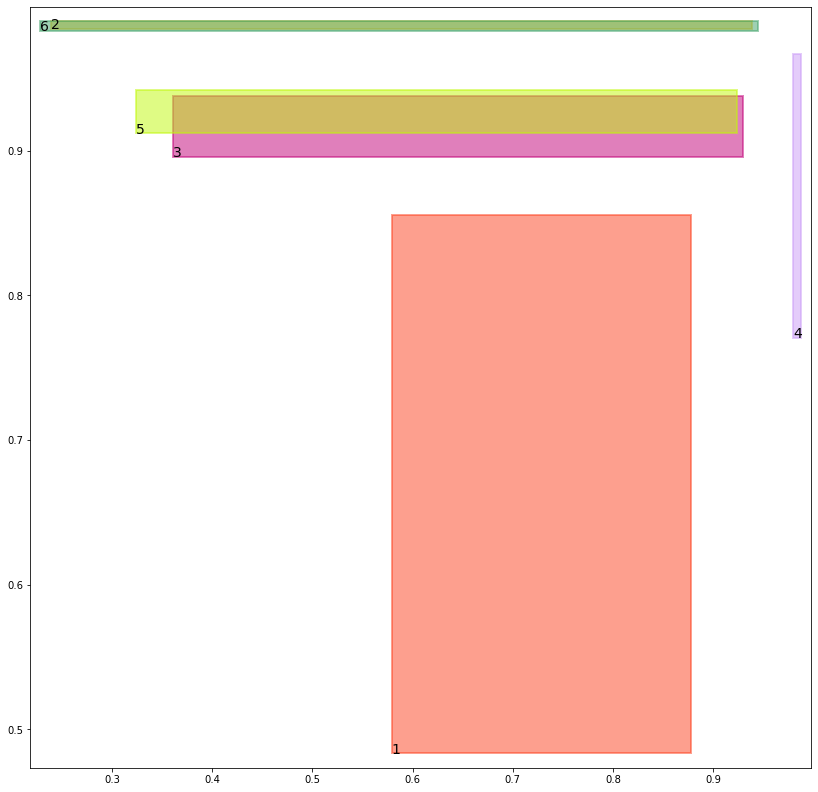

batch (tensor([[1, 2],
        [4, 6],
        [2, 6],
        [3, 5]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.49272918701172 -30.911409378051758 tensor(-51.9990997314453125) tensor(-14.7571830749511719)
tensor(3) -85.28255462646484 -30.156875610351562 tensor(-55.9812469482421875) tensor(-17.0397777557373047)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -85.39409637451172 -30.181520462036133 tensor(-54.7289543151855469) tensor(-16.3895320892333984)
tensor(6) -87.66045379638672 -30.986730575561523 tensor(-52.1032028198242188) tensor(-14.8126163482666016)


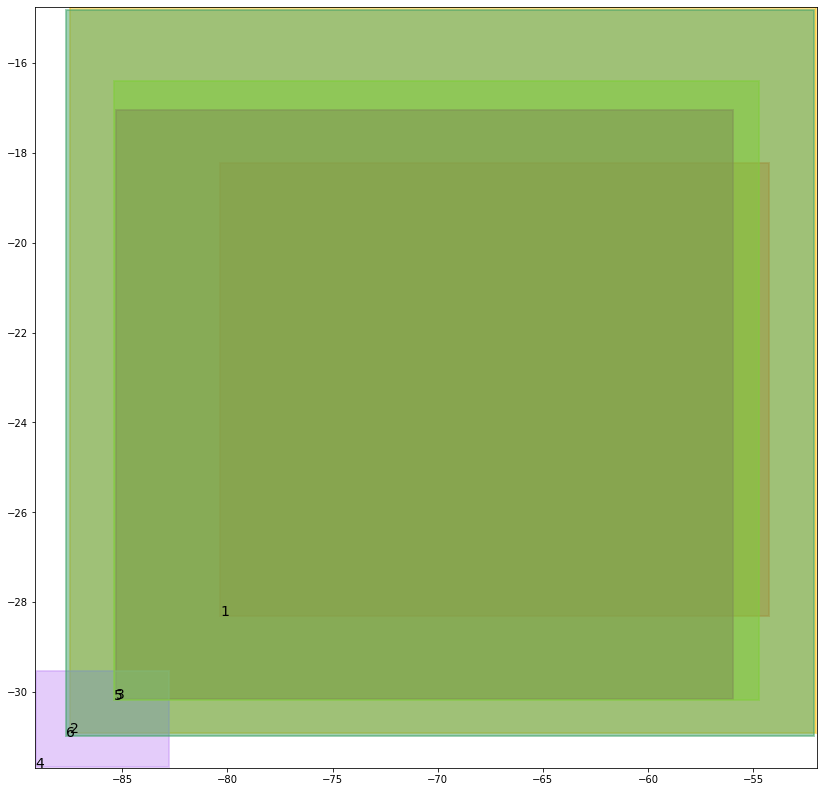

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.23213611543178558 0.9839856028556824 tensor(0.9404094815254211) tensor(0.9893217086791992)
tensor(3) 0.3582276403903961 0.8964029550552368 tensor(0.9278671741485596) tensor(0.9372469782829285)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.32576465606689453 0.9117951989173889 tensor(0.9264559149742126) tensor(0.9430792927742004)
tensor(6) 0.23481658101081848 0.9828060269355774 tensor(0.9438688755035400) tensor(0.9893723130226135)


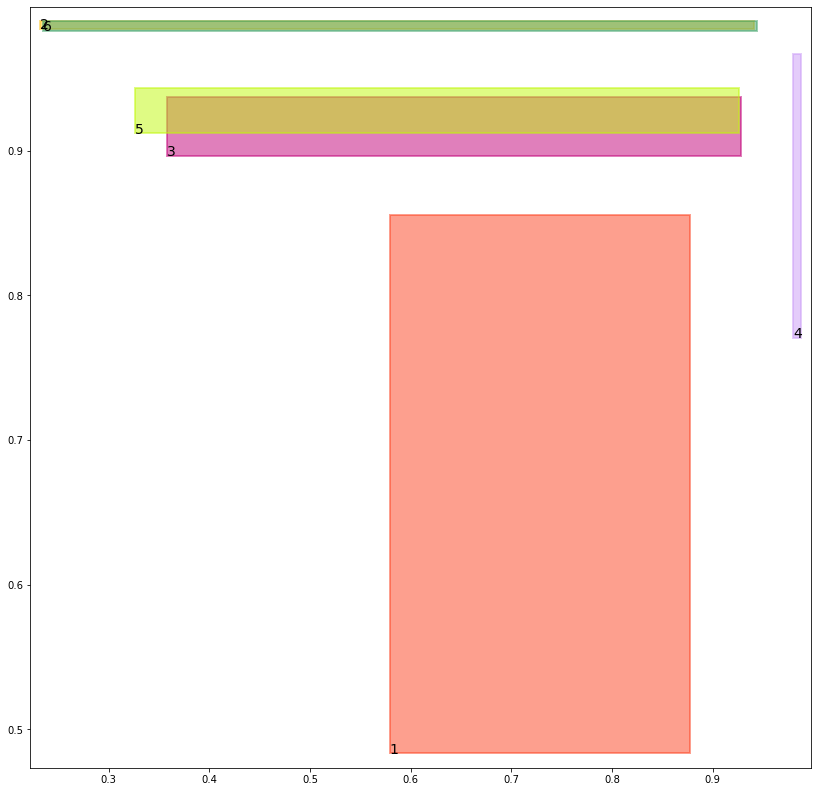

batch (tensor([[4, 5],
        [5, 3],
        [2, 6],
        [4, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.61299133300781 -30.964679718017578 tensor(-51.6665115356445312) tensor(-14.6011810302734375)
tensor(3) -85.12103271484375 -30.08894157409668 tensor(-55.9527893066406250) tensor(-17.0127162933349609)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -85.59339904785156 -30.266508102416992 tensor(-54.7668914794921875) tensor(-16.4157161712646484)
tensor(6) -87.56266021728516 -30.943532943725586 tensor(-52.4242782592773438) tensor(-14.9626636505126953)


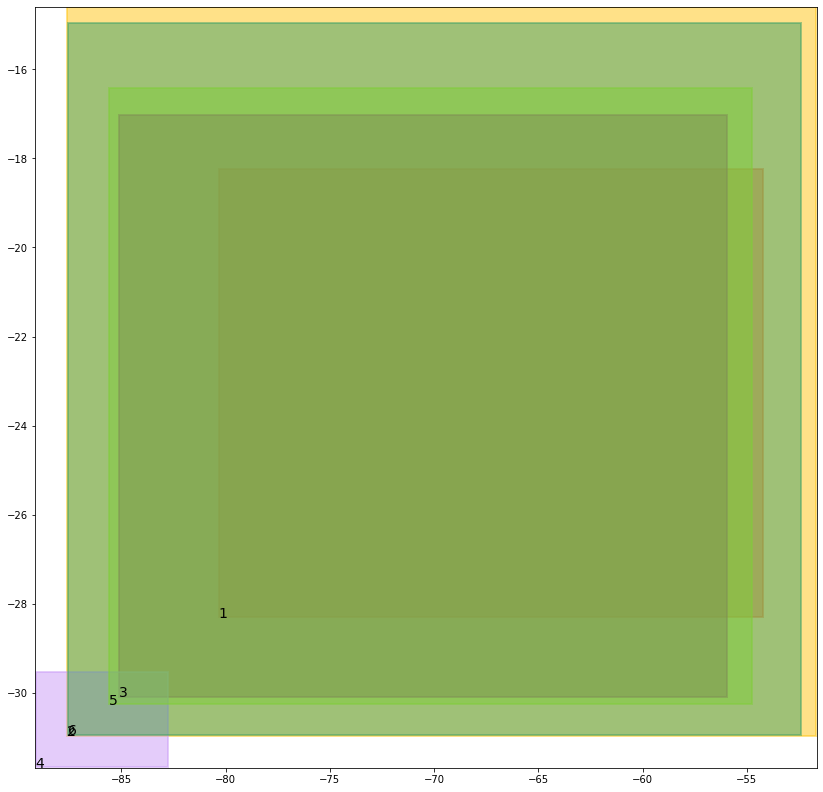

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.22597946226596832 0.9836177825927734 tensor(0.9427883028984070) tensor(0.9895162582397461)
tensor(3) 0.3560446798801422 0.8992534279823303 tensor(0.9249697923660278) tensor(0.9365501999855042)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3275105059146881 0.9100099205970764 tensor(0.9299437999725342) tensor(0.9441080689430237)
tensor(6) 0.24069638550281525 0.9832708239555359 tensor(0.9419510364532471) tensor(0.9891886711120605)


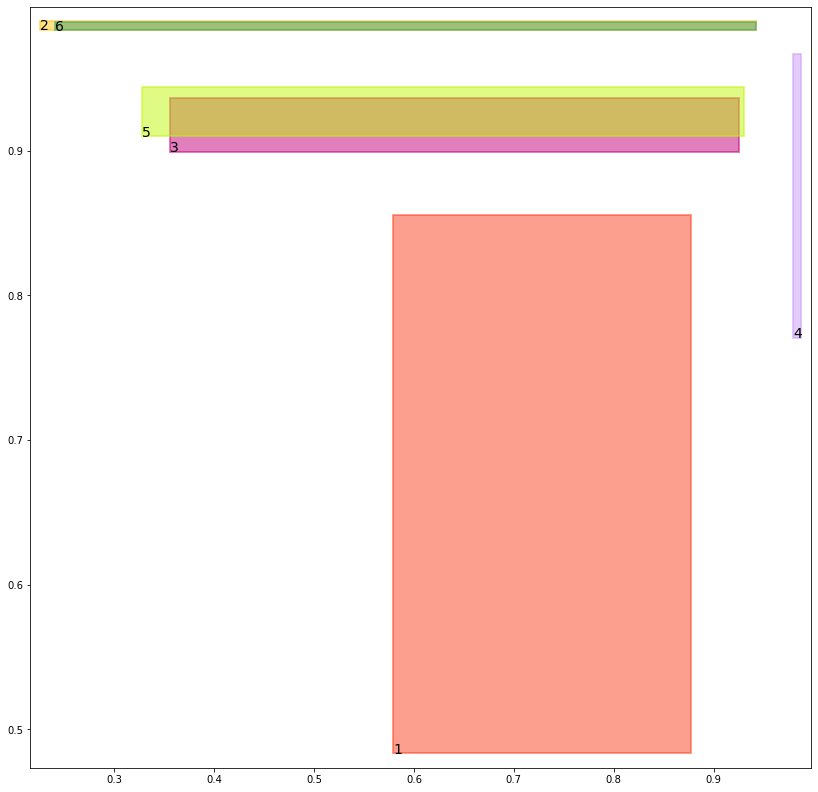

batch (tensor([[6, 2],
        [1, 3],
        [3, 5],
        [1, 2]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.66639709472656 -30.988691329956055 tensor(-51.5919570922851562) tensor(-14.5675029754638672)
tensor(3) -85.06782531738281 -30.063520431518555 tensor(-55.6095504760742188) tensor(-16.8428745269775391)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -85.68724060058594 -30.307035446166992 tensor(-55.1018753051757812) tensor(-16.5772514343261719)
tensor(6) -87.5253677368164 -30.92661476135254 tensor(-52.4697189331054688) tensor(-14.9821462631225586)


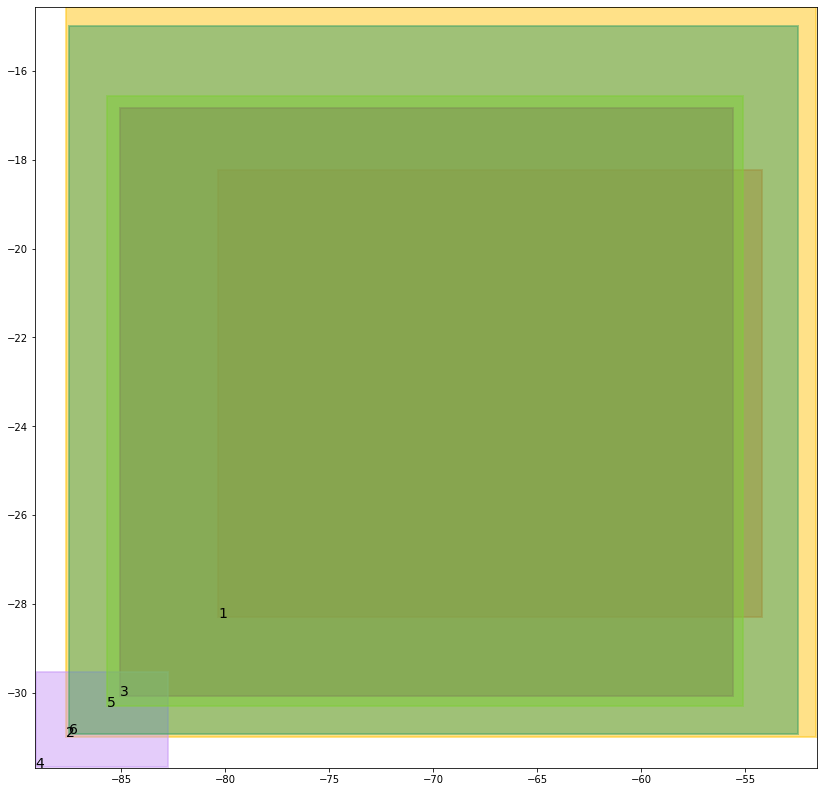

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.2247469574213028 0.983281672000885 tensor(0.9438941478729248) tensor(0.9895254373550415)
tensor(3) 0.34813299775123596 0.901766300201416 tensor(0.9236619472503662) tensor(0.9368613958358765)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3347353935241699 0.9084166288375854 tensor(0.9317767620086670) tensor(0.9442793726921082)
tensor(6) 0.24132879078388214 0.9836797118186951 tensor(0.9411577582359314) tensor(0.9892151951789856)


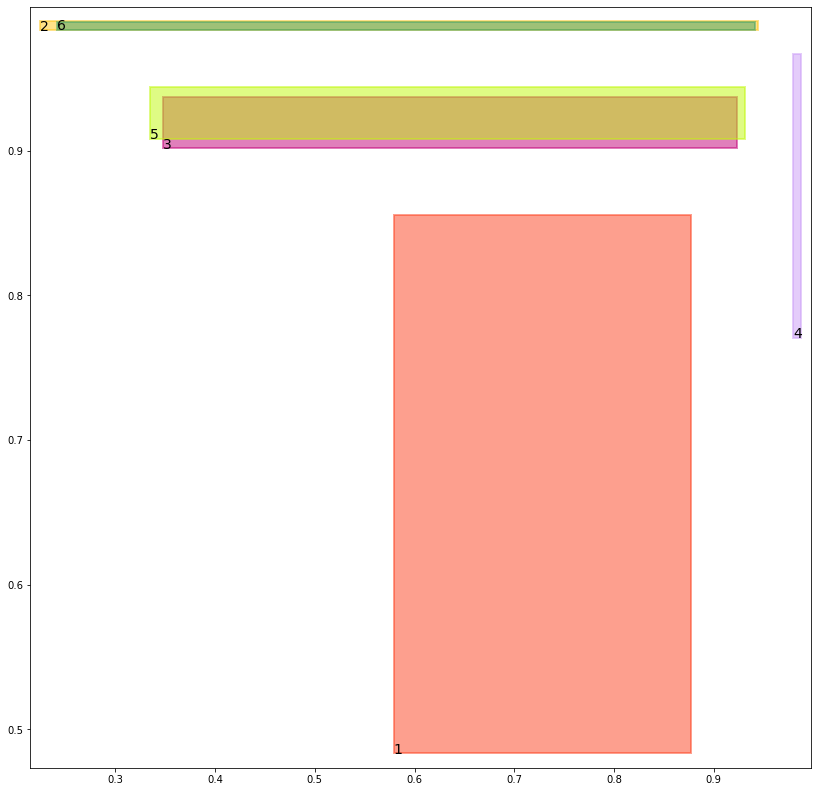

batch (tensor([[1, 3],
        [5, 3],
        [4, 5],
        [3, 5]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.7137680053711 -31.009992599487305 tensor(-51.5247039794921875) tensor(-14.5371532440185547)
tensor(3) -85.1153335571289 -30.079299926757812 tensor(-55.0610198974609375) tensor(-16.5700302124023438)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -85.69237518310547 -30.310773849487305 tensor(-55.6556930541992188) tensor(-16.8478393554687500)
tensor(6) -87.49129486083984 -30.91115379333496 tensor(-52.5105285644531250) tensor(-14.9996795654296875)


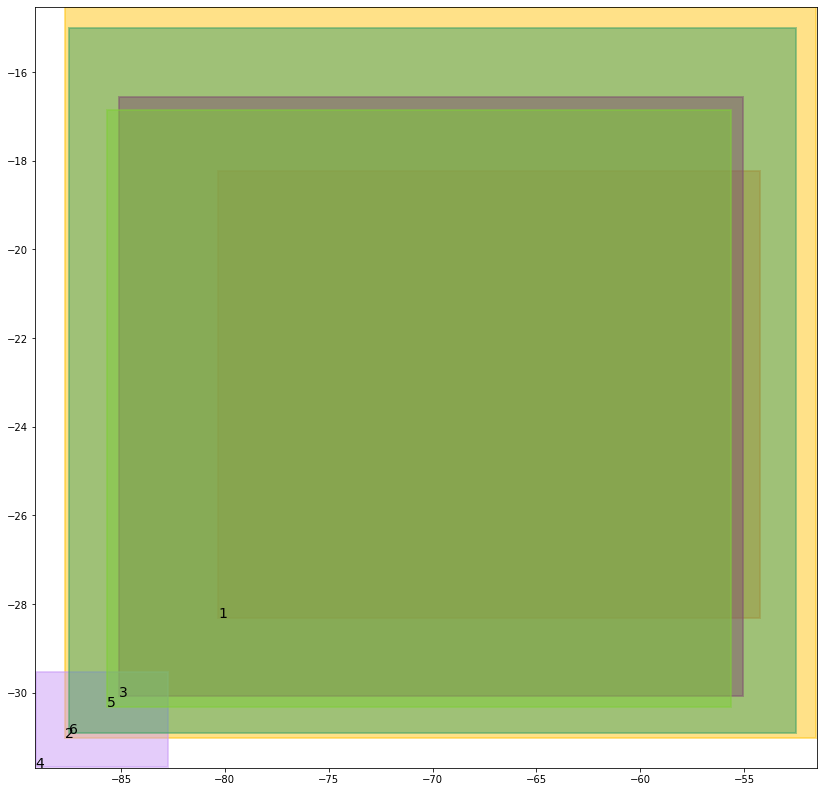

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.22363857924938202 0.9829725623130798 tensor(0.9448750019073486) tensor(0.9895338416099548)
tensor(3) 0.33532240986824036 0.9060706496238708 tensor(0.9238754510879517) tensor(0.9380673170089722)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.34709492325782776 0.9050646424293518 tensor(0.9322491884231567) tensor(0.9436880350112915)
tensor(6) 0.24190060794353485 0.9840403199195862 tensor(0.9404330253601074) tensor(0.9892389774322510)


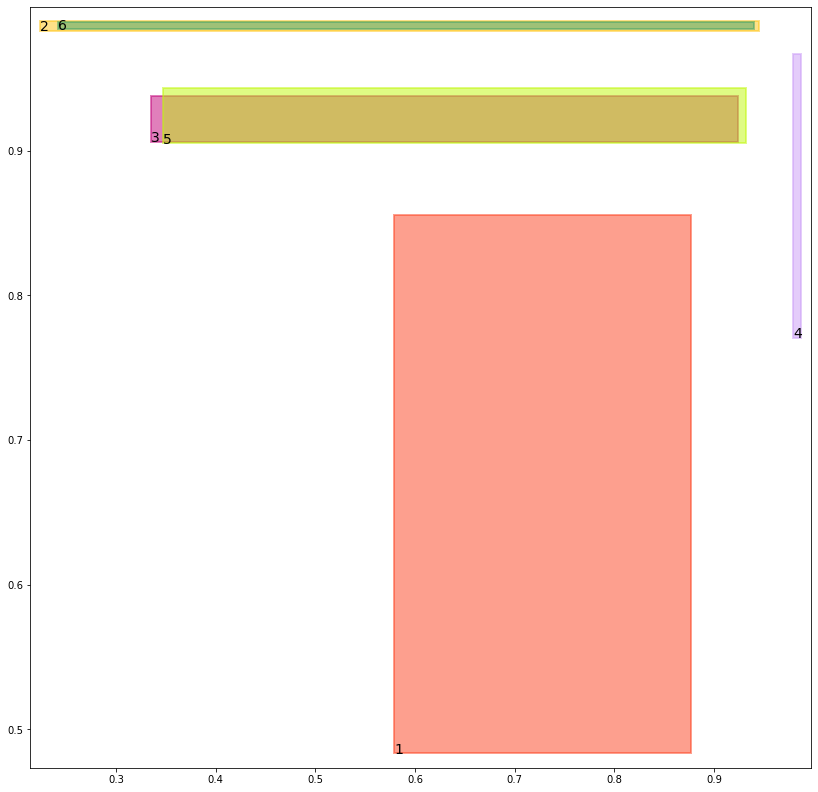

batch (tensor([[2, 6],
        [6, 2],
        [4, 6],
        [1, 2]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.7065658569336 -31.007492065429688 tensor(-51.6951217651367188) tensor(-14.6176643371582031)
tensor(3) -85.1576156616211 -30.093360900878906 tensor(-54.5722579956054688) tensor(-16.3273906707763672)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -85.69670867919922 -30.31403923034668 tensor(-56.1622772216796875) tensor(-17.0956134796142578)
tensor(6) -87.51507568359375 -30.920879364013672 tensor(-52.2936019897460938) tensor(-14.8964271545410156)


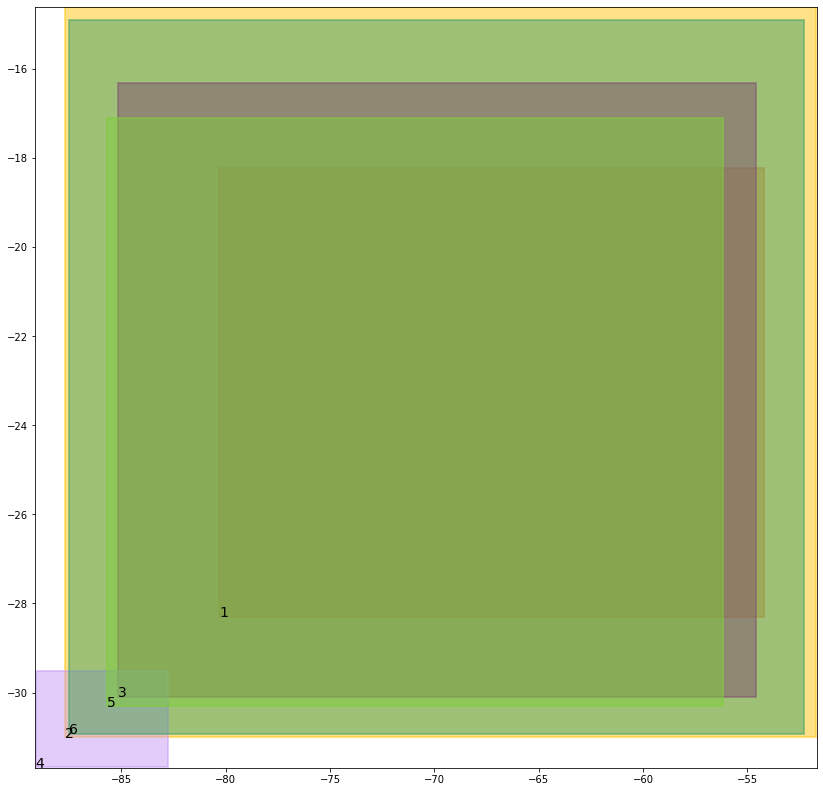

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.22685888409614563 0.9830482006072998 tensor(0.9448271989822388) tensor(0.9893749952316284)
tensor(3) 0.3239634037017822 0.9098098874092102 tensor(0.9240676164627075) tensor(0.9391372799873352)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3584311604499817 0.901945173740387 tensor(0.9326730966567993) tensor(0.9431492686271667)
tensor(6) 0.2377137392759323 0.9840946793556213 tensor(0.9407921433448792) tensor(0.9894501566886902)


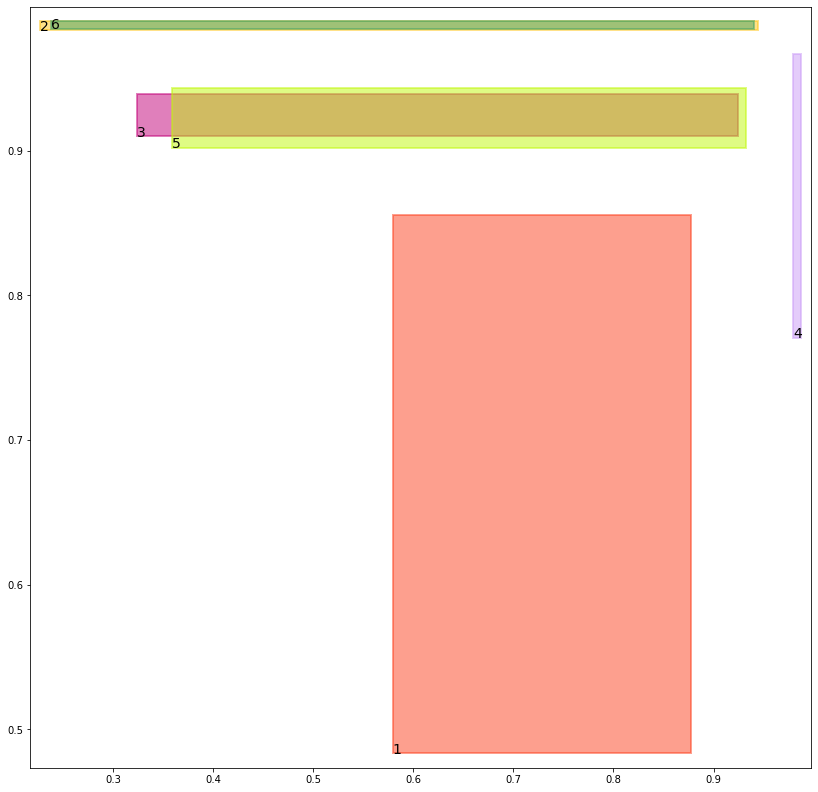

batch (tensor([[5, 3],
        [2, 6],
        [1, 3],
        [6, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.67365264892578 -30.992815017700195 tensor(-52.0082588195800781) tensor(-14.7647800445556641)
tensor(3) -85.1943588256836 -30.105539321899414 tensor(-54.3327293395996094) tensor(-16.2013397216796875)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -85.70040130615234 -30.31690788269043 tensor(-56.4075126647949219) tensor(-17.2223567962646484)
tensor(6) -87.56450653076172 -30.942846298217773 tensor(-51.9365386962890625) tensor(-14.7275886535644531)


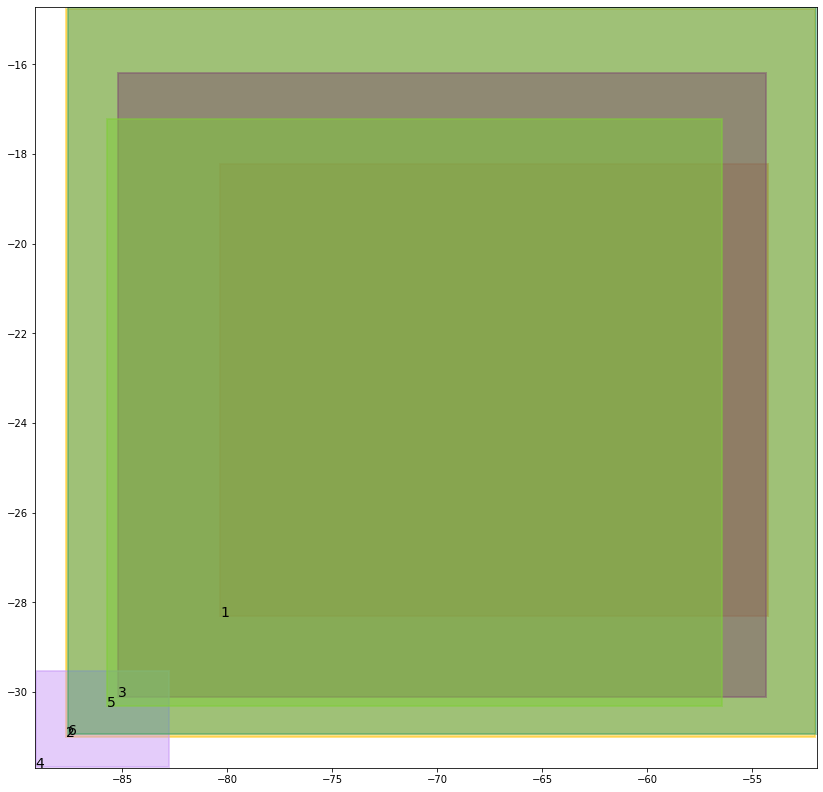

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.2326820343732834 0.9833489656448364 tensor(0.9441631436347961) tensor(0.9893419742584229)
tensor(3) 0.3175569176673889 0.9130950570106506 tensor(0.9242291450500488) tensor(0.9400755167007446)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3647186756134033 0.8990514874458313 tensor(0.9330534934997559) tensor(0.9426588416099548)
tensor(6) 0.23094947636127472 0.9839655160903931 tensor(0.9417796134948730) tensor(0.9895149469375610)


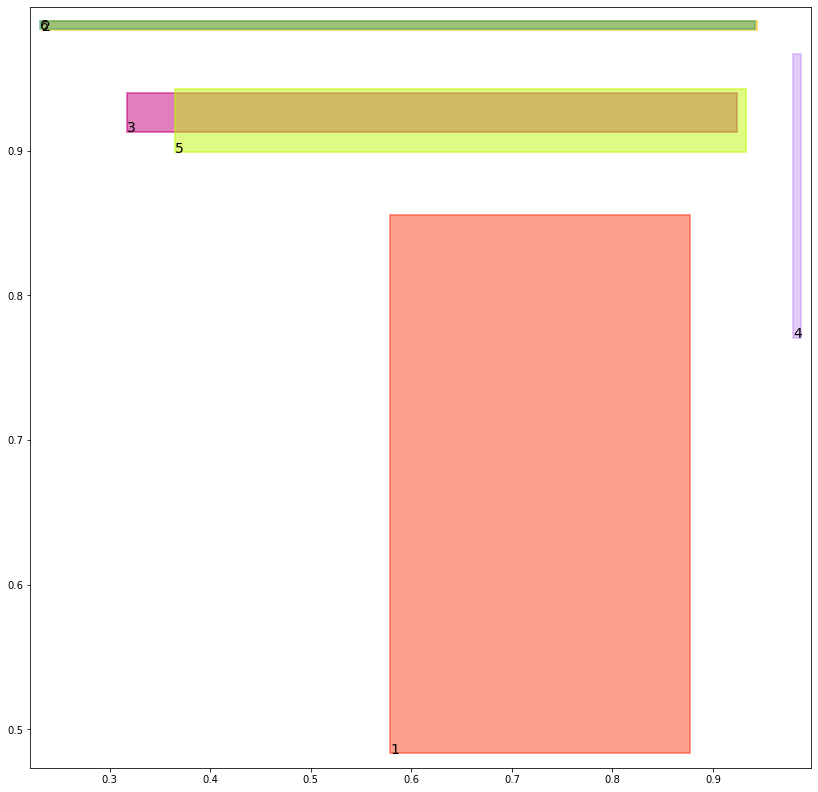

batch (tensor([[3, 5],
        [1, 2],
        [4, 5],
        [4, 6]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.64363861083984 -30.979433059692383 tensor(-52.2953910827636719) tensor(-14.8997173309326172)
tensor(3) -85.40745544433594 -30.18999481201172 tensor(-54.0125045776367188) tensor(-16.0569782257080078)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -85.54572296142578 -30.25772476196289 tensor(-56.7779235839843750) tensor(-17.3832359313964844)
tensor(6) -87.60846710205078 -30.96237564086914 tensor(-51.6203231811523438) tensor(-14.5780811309814453)


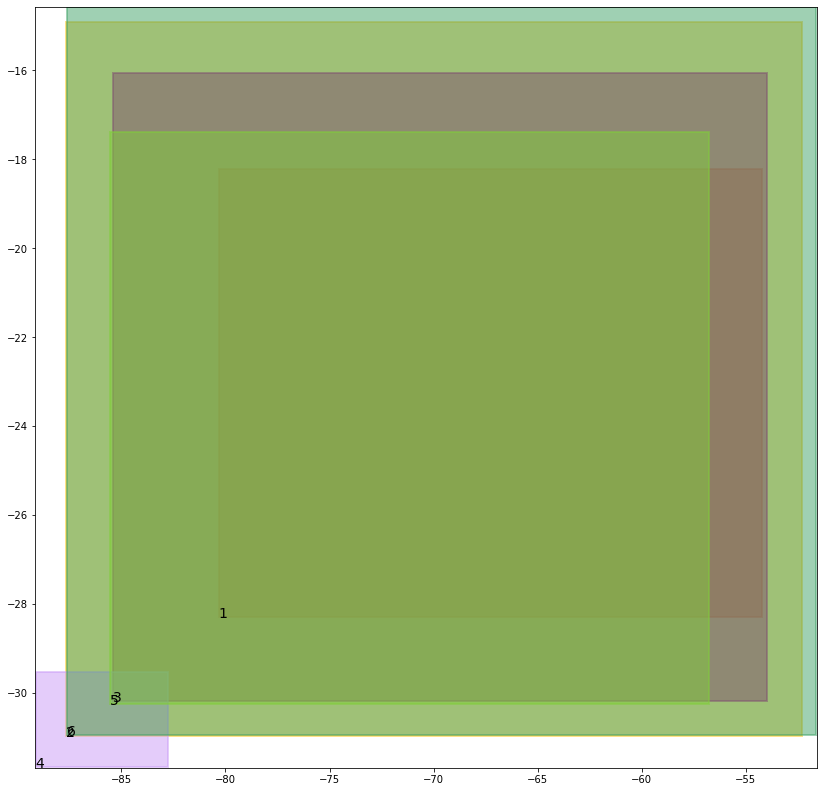

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.2380266636610031 0.9836159348487854 tensor(0.9435573816299438) tensor(0.9893121123313904)
tensor(3) 0.3118331730365753 0.9125718474388123 tensor(0.9270728826522827) tensor(0.9425523877143860)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3706209659576416 0.9008998274803162 tensor(0.9311466813087463) tensor(0.9406345486640930)
tensor(6) 0.22496074438095093 0.9838480353355408 tensor(0.9426574707031250) tensor(0.9895730614662170)


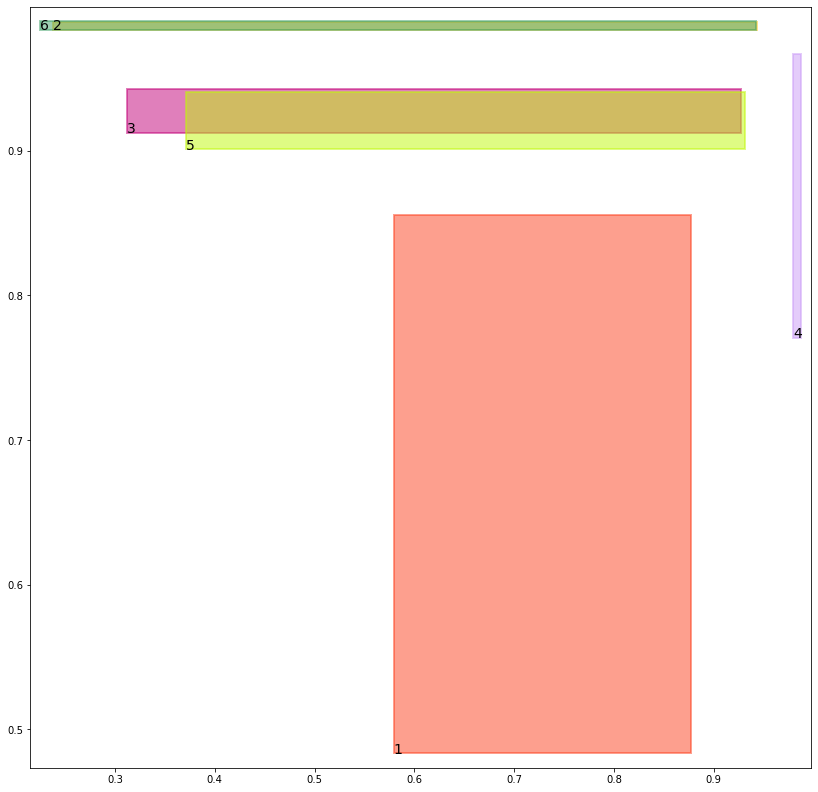

batch (tensor([[4, 5],
        [2, 6],
        [1, 2],
        [6, 2]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.57442474365234 -30.94759178161621 tensor(-52.3269119262695312) tensor(-14.9118366241455078)
tensor(3) -85.5931625366211 -30.26361846923828 tensor(-53.7260055541992188) tensor(-15.9278507232666016)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -85.40226745605469 -30.202852249145508 tensor(-57.1132278442382812) tensor(-17.5290164947509766)
tensor(6) -87.68653106689453 -30.998153686523438 tensor(-51.5553894042968750) tensor(-14.5492153167724609)


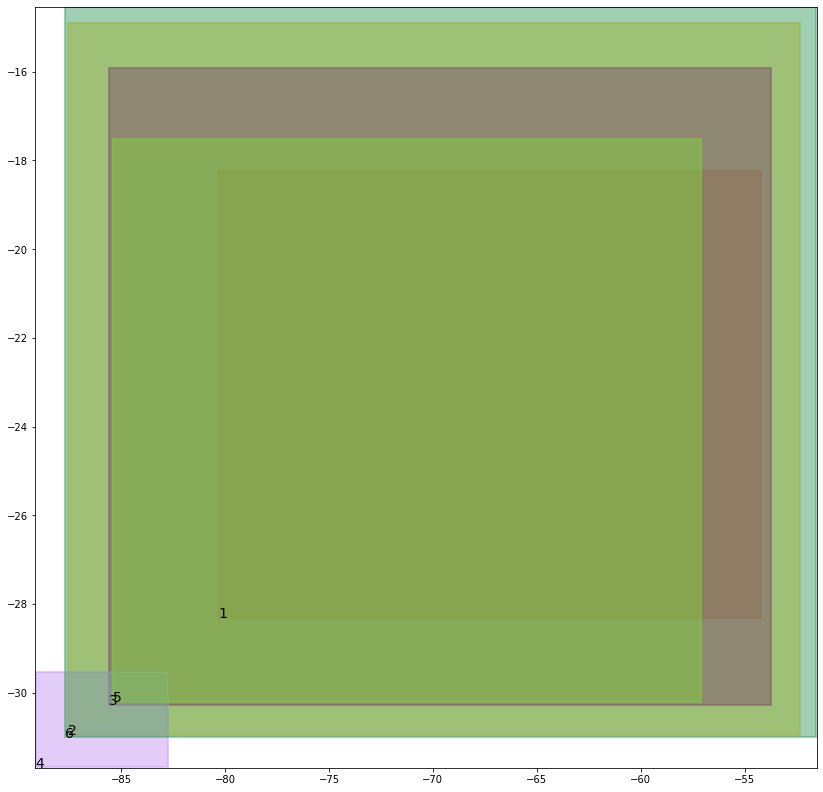

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.23830601572990417 0.9841732978820801 tensor(0.9420245885848999) tensor(0.9894552826881409)
tensor(3) 0.3067159056663513 0.9120972752571106 tensor(0.9295548796653748) tensor(0.9447049498558044)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3759816586971283 0.9025421738624573 tensor(0.9293824434280396) tensor(0.9387502074241638)
tensor(6) 0.22394047677516937 0.9834638237953186 tensor(0.9443675279617310) tensor(0.9894411563873291)


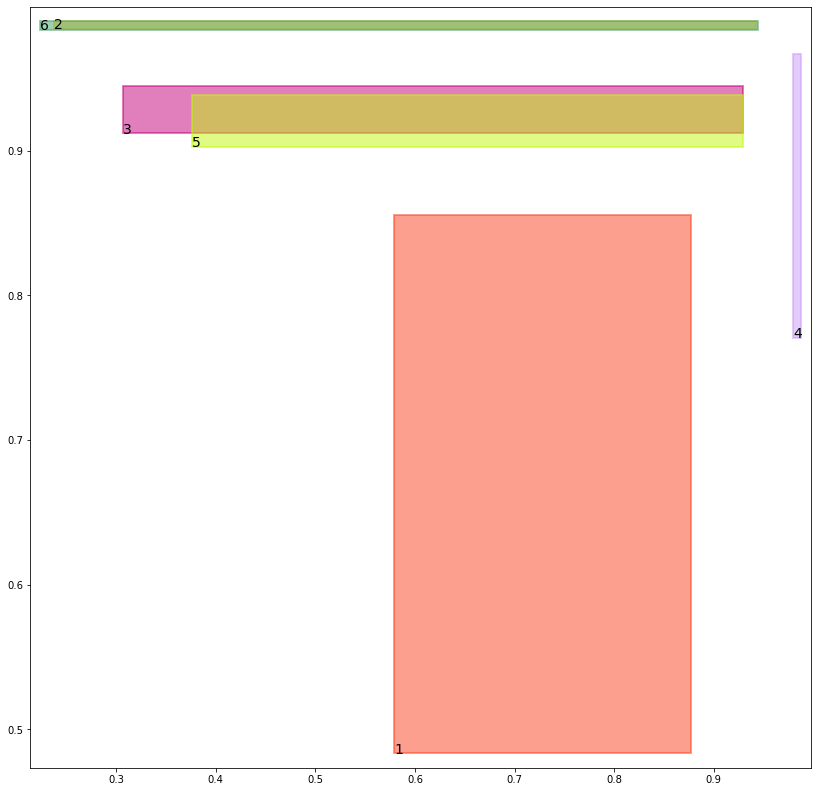

batch (tensor([[1, 3],
        [3, 5],
        [5, 3],
        [4, 6]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.51032257080078 -30.918115615844727 tensor(-52.3548736572265625) tensor(-14.9226293563842773)
tensor(3) -85.67399597167969 -30.29475212097168 tensor(-53.7004280090332031) tensor(-15.9264411926269531)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -85.35598754882812 -30.18584632873535 tensor(-57.1464500427246094) tensor(-17.5271549224853516)
tensor(6) -87.75495147705078 -31.029539108276367 tensor(-51.4966964721679688) tensor(-14.5231609344482422)


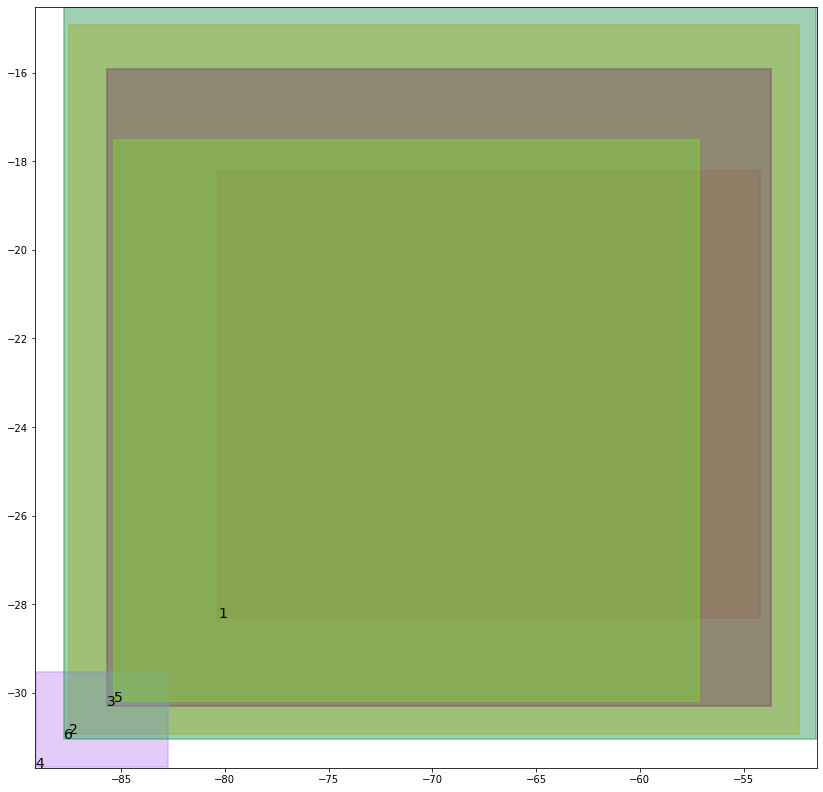

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.23855838179588318 0.9846602082252502 tensor(0.9406076669692993) tensor(0.9895828962326050)
tensor(3) 0.30744898319244385 0.9099963307380676 tensor(0.9305091500282288) tensor(0.9458377957344055)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3745948076248169 0.906023383140564 tensor(0.9289748072624207) tensor(0.9378823041915894)
tensor(6) 0.2230224609375 0.9831094145774841 tensor(0.9458695650100708) tensor(0.9893206357955933)


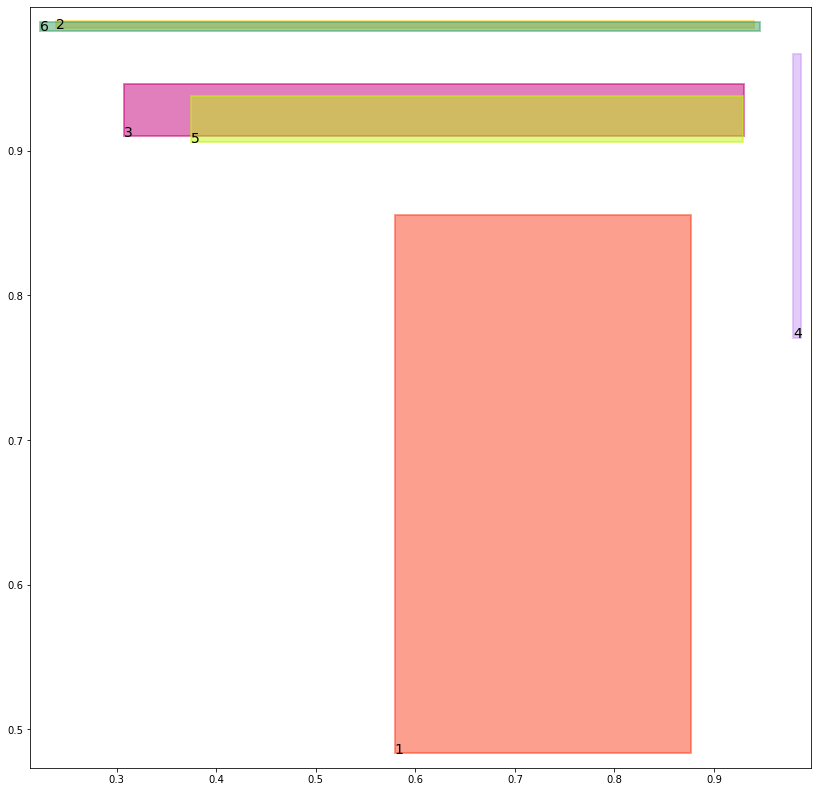

batch (tensor([[1, 2],
        [4, 6],
        [1, 3],
        [4, 5]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.4510726928711 -30.890899658203125 tensor(-52.3797454833984375) tensor(-14.9322576522827148)
tensor(3) -85.7458724975586 -30.32245445251465 tensor(-53.6761970520019531) tensor(-15.9248313903808594)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -85.3138198852539 -30.170366287231445 tensor(-57.1735801696777344) tensor(-17.5246372222900391)
tensor(6) -87.81510162353516 -31.057146072387695 tensor(-51.4436492919921875) tensor(-14.4996433258056641)


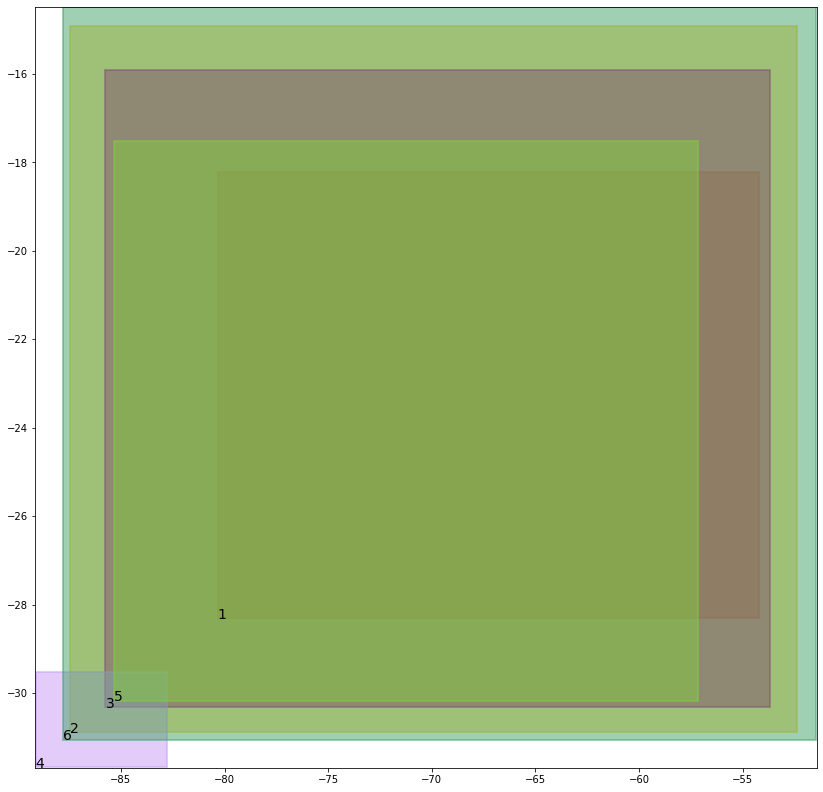

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.23878628015518188 0.9850871562957764 tensor(0.9393011331558228) tensor(0.9896968603134155)
tensor(3) 0.30811142921447754 0.9080613255500793 tensor(0.9313602447509766) tensor(0.9468413591384888)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.37334486842155457 0.909069299697876 tensor(0.9286050796508789) tensor(0.9370890855789185)
tensor(6) 0.22219620645046234 0.9827830791473389 tensor(0.9471924304962158) tensor(0.9892107248306274)


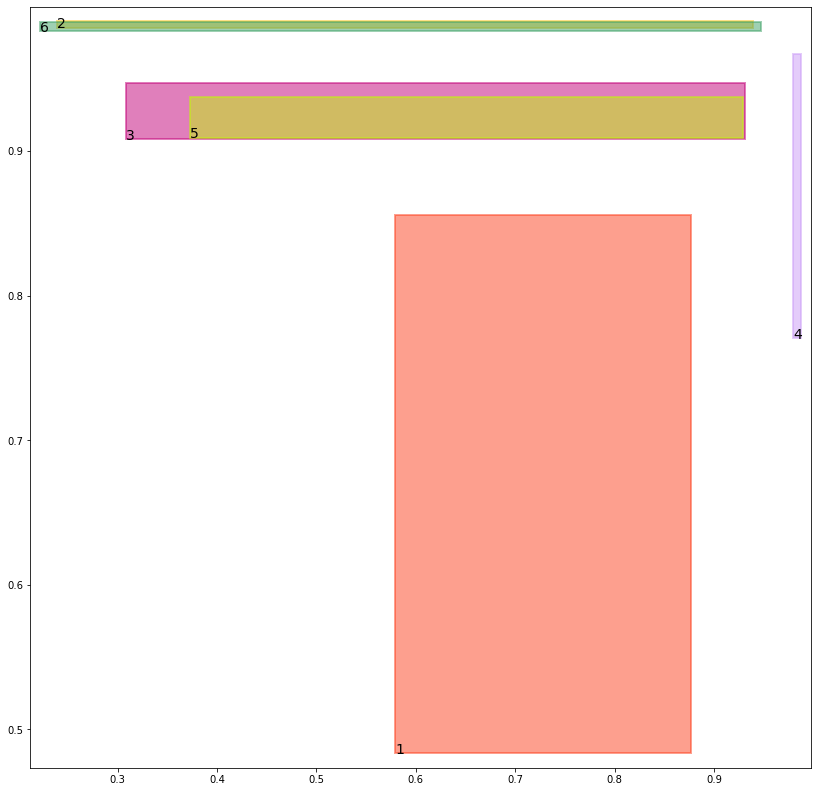

batch (tensor([[3, 5],
        [2, 6],
        [5, 3],
        [6, 2]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.42112731933594 -30.877302169799805 tensor(-52.2779312133789062) tensor(-14.8826999664306641)
tensor(3) -85.7705307006836 -30.331056594848633 tensor(-53.8278274536132812) tensor(-15.9982013702392578)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -85.31981658935547 -30.173582077026367 tensor(-57.0023803710937500) tensor(-17.4373664855957031)
tensor(6) -87.85147857666016 -31.073549270629883 tensor(-51.5124549865722656) tensor(-14.5330142974853516)


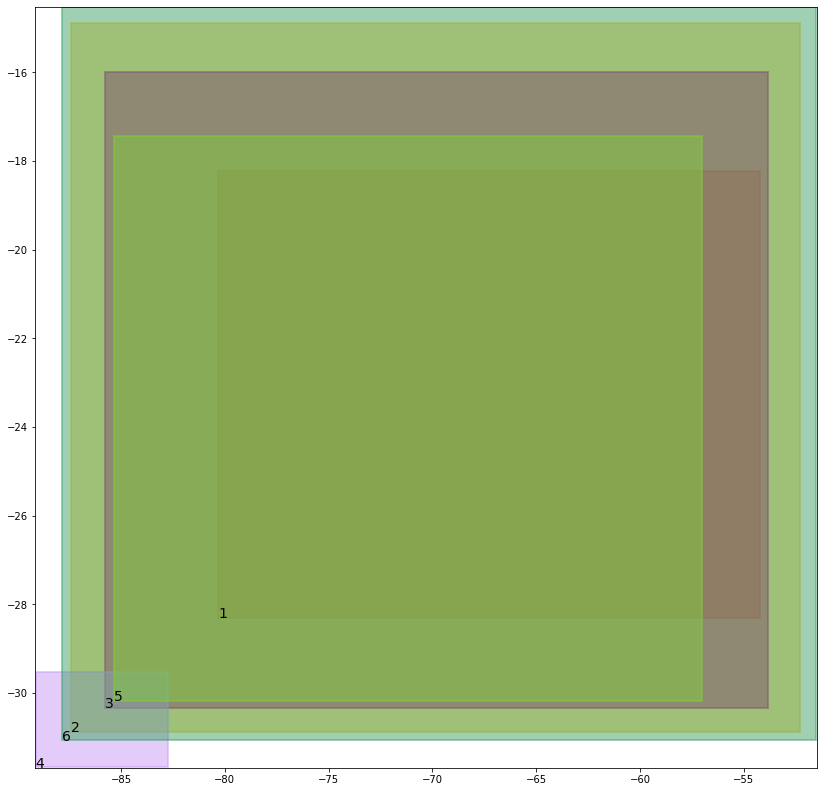

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.2366960346698761 0.9853277802467346 tensor(0.9386632442474365) tensor(0.9897189140319824)
tensor(3) 0.31141141057014465 0.907288670539856 tensor(0.9315273761749268) tensor(0.9473797678947449)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.369098037481308 0.9108427166938782 tensor(0.9288910627365112) tensor(0.9368266463279724)
tensor(6) 0.22359466552734375 0.9826450347900391 tensor(0.9479519724845886) tensor(0.9892073869705200)


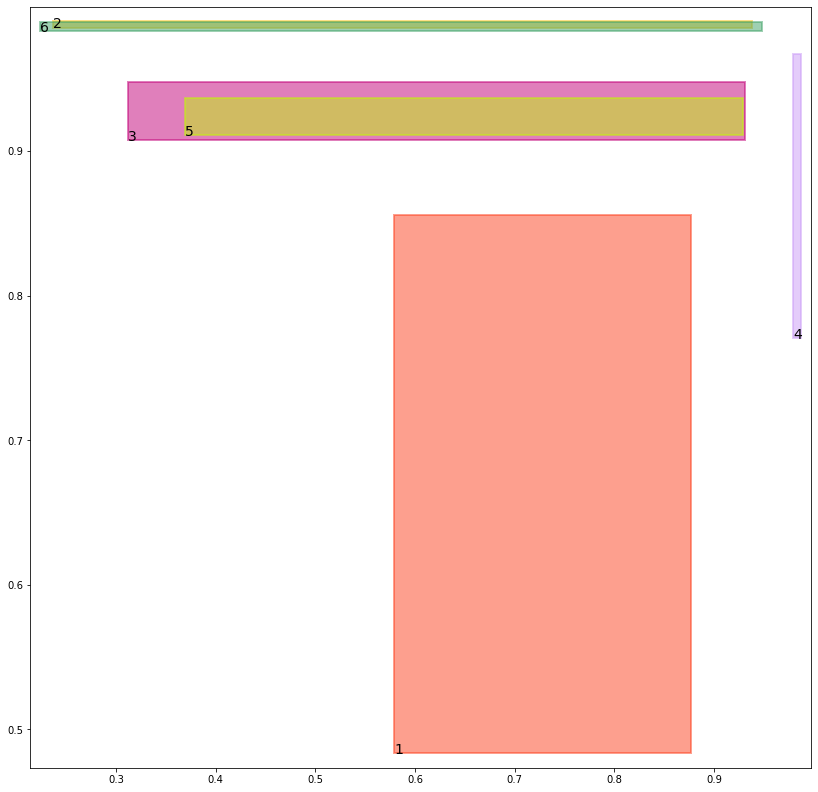

batch (tensor([[2, 6],
        [1, 2],
        [6, 2],
        [4, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.44339752197266 -30.887996673583984 tensor(-51.9446105957031250) tensor(-14.7247314453125000)
tensor(3) -85.7926254272461 -30.33876609802246 tensor(-53.9653968811035156) tensor(-16.0647773742675781)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -85.3251724243164 -30.17645835876465 tensor(-56.8479614257812500) tensor(-17.3587779998779297)
tensor(6) -87.85114288330078 -31.072519302368164 tensor(-51.8118209838867188) tensor(-14.6741085052490234)


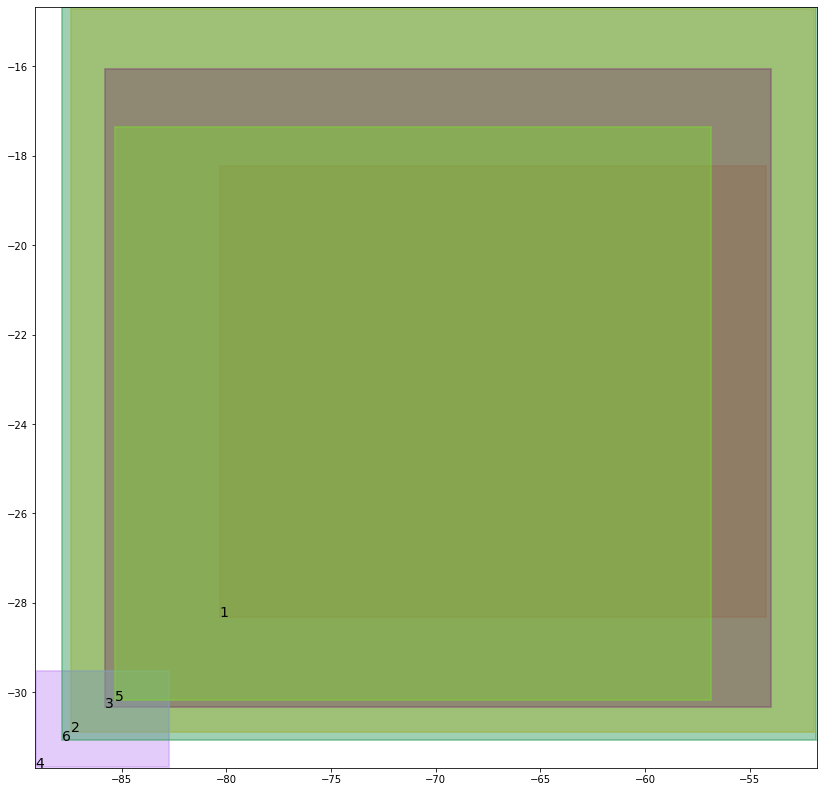

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.2303408682346344 0.985276997089386 tensor(0.9392176866531372) tensor(0.9895780682563782)
tensor(3) 0.31440624594688416 0.9065863490104675 tensor(0.9316779375076294) tensor(0.9478611350059509)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3652825355529785 0.9124163389205933 tensor(0.9291482567787170) tensor(0.9365888833999634)
tensor(6) 0.22921352088451385 0.9828434586524963 tensor(0.9478238821029663) tensor(0.9893955588340759)


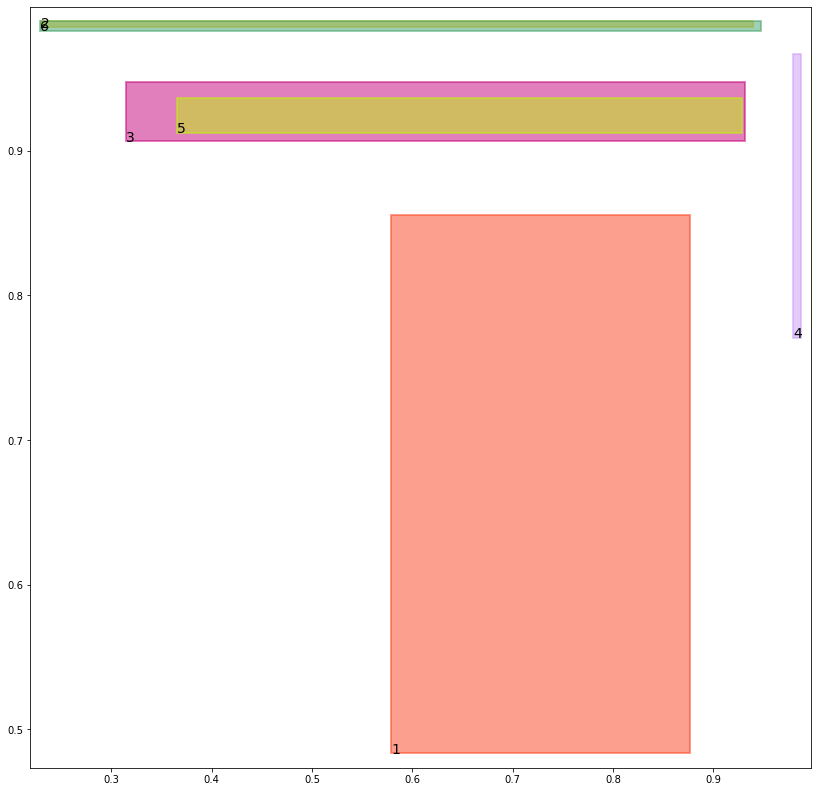

batch (tensor([[4, 5],
        [1, 3],
        [5, 3],
        [3, 5]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)


tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.46326446533203 -30.897546768188477 tensor(-51.6491851806640625) tensor(-14.5847263336181641)
tensor(3) -85.7339096069336 -30.31351089477539 tensor(-54.4474563598632812) tensor(-16.2791118621826172)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -85.41765594482422 -30.213171005249023 tensor(-56.3322181701660156) tensor(-17.1237068176269531)
tensor(6) -87.8507308959961 -31.071557998657227 tensor(-52.0863571166992188) tensor(-14.8035278320312500)


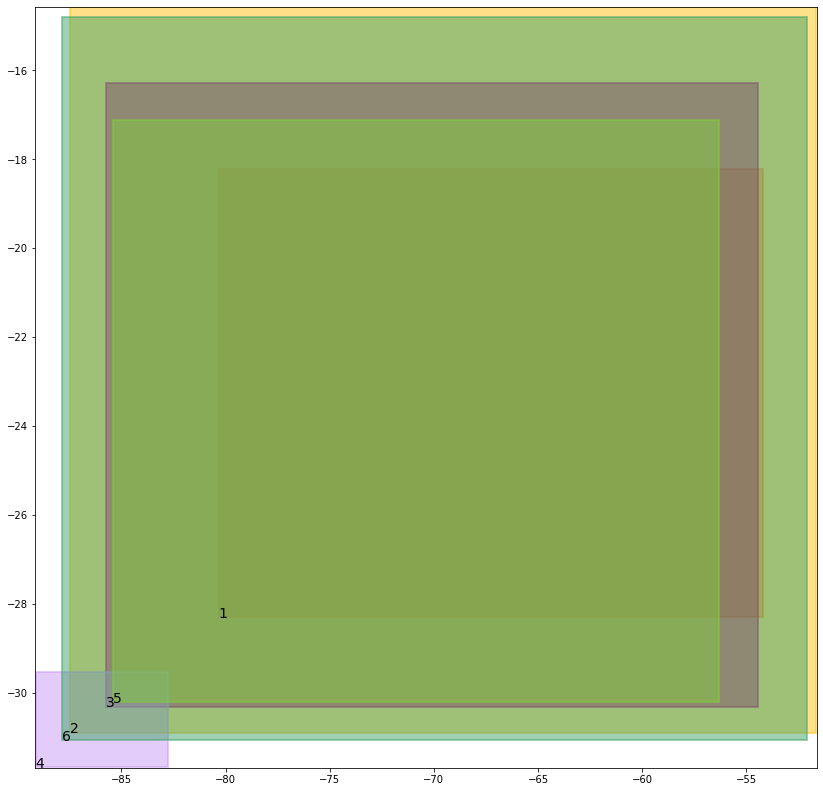

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.2247087061405182 0.9852310419082642 tensor(0.9397140741348267) tensor(0.9894493222236633)
tensor(3) 0.3226712644100189 0.9079822897911072 tensor(0.9306207895278931) tensor(0.9476039409637451)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3557620942592621 0.9120960831642151 tensor(0.9305945634841919) tensor(0.9373067021369934)
tensor(6) 0.23436914384365082 0.983020544052124 tensor(0.9477080106735229) tensor(0.9895625710487366)


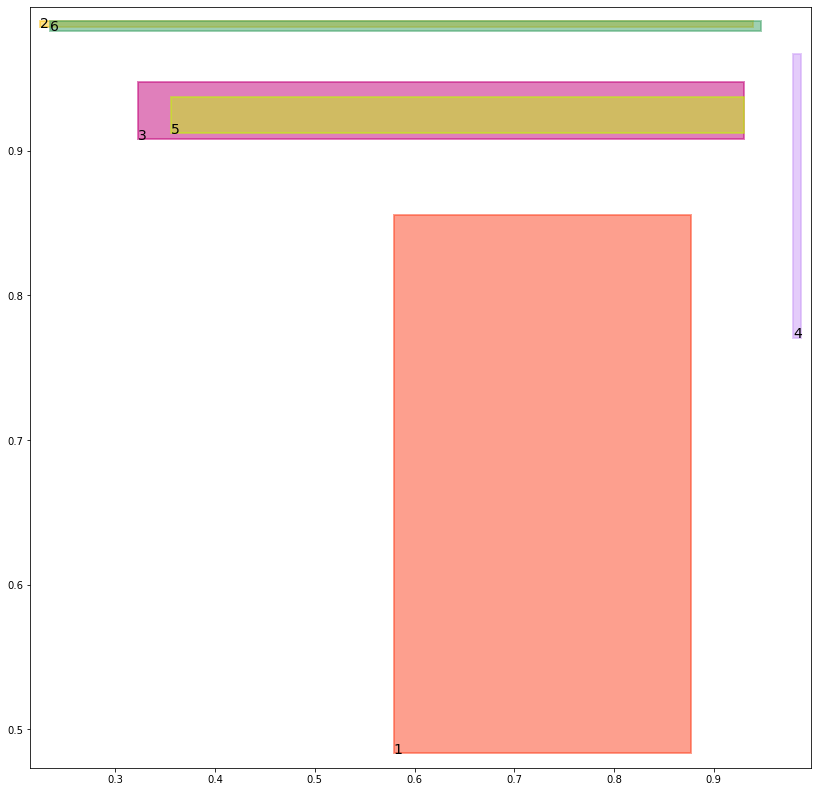

batch (tensor([[1, 2],
        [1, 3],
        [3, 5],
        [2, 6]]), tensor([1., 1., 1., 1.]))
tree data:
tensor(1) -80.3275375366211 -28.306406021118164 tensor(-54.2256736755371094) tensor(-18.2294254302978516)
tensor(2) -87.5383529663086 -30.931123733520508 tensor(-51.3786468505859375) tensor(-14.4579143524169922)
tensor(3) -85.68025970458984 -30.290430068969727 tensor(-54.8871726989746094) tensor(-16.4747562408447266)
tensor(4) -89.11988067626953 -31.68015480041504 tensor(-82.7521591186523438) tensor(-29.5281848907470703)
tensor(5) -85.49977111816406 -30.245756149291992 tensor(-55.8718681335449219) tensor(-16.9139041900634766)
tensor(6) -87.80509185791016 -31.051164627075195 tensor(-52.3479309082031250) tensor(-14.9253425598144531)


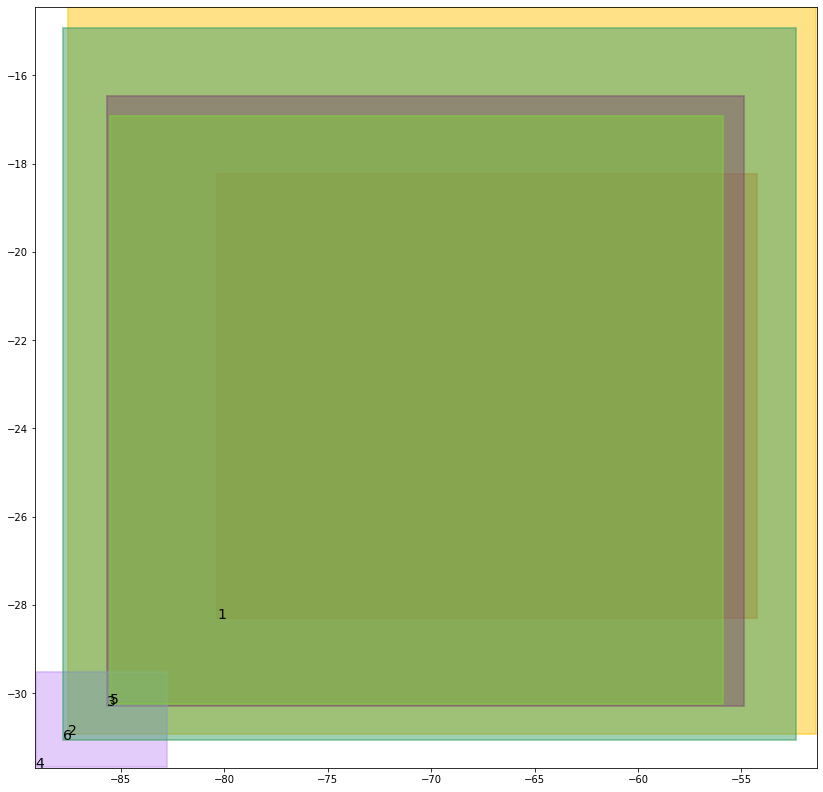

alignment data:
tensor(1) 0.5791810154914856 0.48342087864875793 tensor(0.8772611618041992) tensor(0.8555421829223633)
tensor(2) 0.21971021592617035 0.9849156141281128 tensor(0.9412436485290527) tensor(0.9895017743110657)
tensor(3) 0.3302270174026489 0.9092261791229248 tensor(0.9296537637710571) tensor(0.9473707675933838)
tensor(4) 0.9794751405715942 0.7705523371696472 tensor(0.9878686070442200) tensor(0.9670398235321045)
tensor(5) 0.3472664952278137 0.9118061065673828 tensor(0.9318761229515076) tensor(0.9379479885101318)
tensor(6) 0.23911087214946747 0.9834823608398438 tensor(0.9467810392379761) tensor(0.9895262718200684)


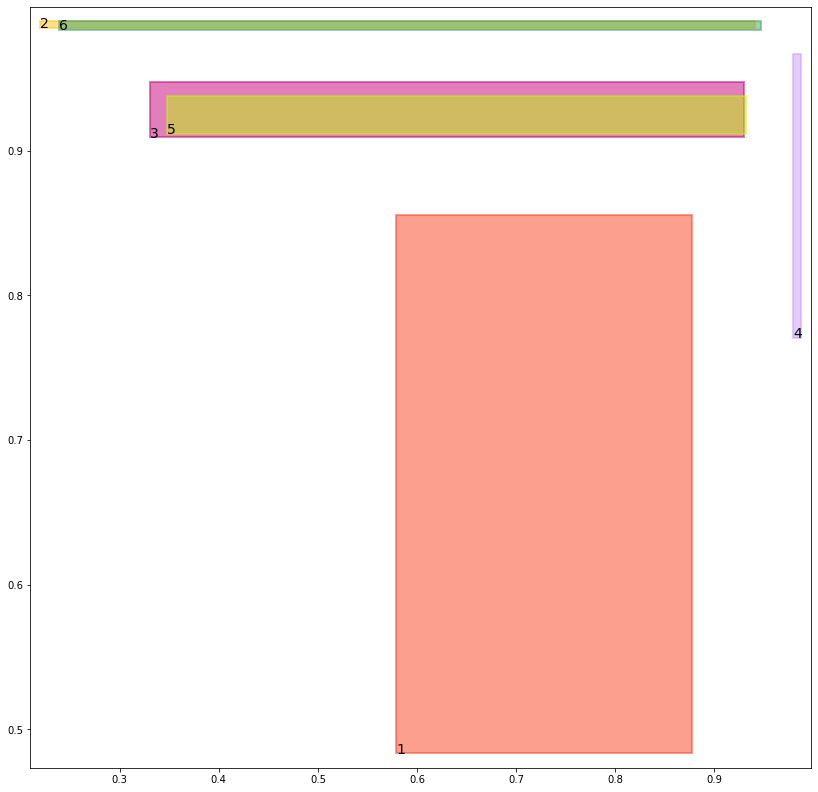

batch (tensor([[5, 3],
        [4, 6],
        [4, 5],
        [6, 2]]), tensor([1., 1., 1., 1.]))
align_evaluation_train_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_train_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_train_align_0.8_metric_hard_f1_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_accuracy_align_mean tensor(1.)
align_evaluation_dev_align_0.8_metric_hard_f1_align_mean tensor(1.)
evaluation_human_metric_hard_accuracy tensor(1.)
evaluation_human_metric_hard_f1 tensor(1.)
evaluation_mouse_metric_hard_accuracy_1 tensor(1.)
evaluation_mouse_metric_hard_f1_1 tensor(1.)



In [19]:
nEpochs = 100
l.train(nEpochs)